In [1]:
!nvidia-smi

Sun Feb 25 19:06:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   38C    P8              21W / 215W |    550MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
np.save(f'{data_dir}esd.audio16k.train.npy', 
        np.array(x_train, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.audio16k.test.npy', 
        np.array(x_test, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.label_emotion.train.npy', 
        np.array(y_train, dtype=object), allow_pickle=True)
np.save(f'{data_dir}esd.label_emotion.test.npy', 
        np.array(y_test, dtype=object), allow_pickle=True)

In [9]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [10]:
np.unique(y_test)

array(['anger', 'hapiness', 'neutral', 'sadness'], dtype='<U8')

In [11]:
labels = ['ang', 'neu', 'sad', 'hap']

In [12]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
import traceback

In [14]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [15]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                        | 0.0005714285714285715/10 [00:00<3:46:04, 1356.56s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.499211
Mem before-during-after: 3254784 3496596992 36363776


  0%|                          | 0.023428571428571413/10 [00:15<2:02:02, 733.98s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.454902
Mem before-during-after: 37138432 3514867200 37138432


  0%|                          | 0.046285714285714215/10 [00:31<2:07:01, 765.74s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.302741
Mem before-during-after: 37138432 3515327488 36363776


  1%|▏                          | 0.06914285714285702/10 [00:46<2:10:30, 788.51s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.355951
Mem before-during-after: 37271552 3514867200 36363776


  1%|▏                          | 0.09199999999999982/10 [01:01<2:01:45, 737.34s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.492739
Mem before-during-after: 36363776 3514948096 37279232


  1%|▎                          | 0.11485714285714262/10 [01:16<1:54:38, 695.86s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.760175
Mem before-during-after: 38053888 3515782656 38053888


  1%|▎                          | 0.13771428571428573/10 [01:31<1:52:33, 684.83s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.146697
Mem before-during-after: 37582336 3196485120 36363776


  2%|▍                           | 0.1605714285714291/10 [01:47<1:58:32, 722.89s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.176046
Mem before-during-after: 36363776 3515782656 37219328


  2%|▍                          | 0.18342857142857244/10 [02:02<1:54:33, 700.22s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 0.979152
Mem before-during-after: 37219328 3516406272 37219328


  2%|▌                           | 0.2062857142857158/10 [02:17<1:49:20, 669.88s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.223064
Mem before-during-after: 37352448 3064896512 36435456


  2%|▌                          | 0.22914285714285915/10 [02:32<1:49:24, 671.88s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.206705
Mem before-during-after: 37337600 3515246592 36809216


  3%|▋                           | 0.2520000000000024/10 [02:47<1:44:45, 644.75s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.713105
Mem before-during-after: 37300736 3427169280 37324288


  3%|▋                          | 0.27485714285714463/10 [03:02<1:54:40, 707.47s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 0.967904
Mem before-during-after: 38053888 3516406272 38053888


  3%|▊                          | 0.29828571428571543/10 [03:17<1:37:30, 603.02s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.126138
Mem before-during-after: 37258752 3515871744 37279232


  3%|▉                           | 0.3205714285714291/10 [03:32<1:57:26, 728.03s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.146181
Mem before-during-after: 37324288 3515000320 37271552


  3%|▉                          | 0.34342857142857136/10 [03:47<1:44:26, 648.93s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.533510
Mem before-during-after: 37133312 3516406272 37138432


  4%|█                           | 0.3662857142857136/10 [04:01<1:52:04, 697.97s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.226788
Mem before-during-after: 38053888 3515782656 38053888


  4%|█                          | 0.38914285714285585/10 [04:16<1:49:20, 682.60s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.583397
Mem before-during-after: 37082112 3515701248 37138432


  4%|█▏                          | 0.4119999999999981/10 [04:31<1:54:31, 716.68s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 1.394158
Mem before-during-after: 37082112 3516406272 37279232


  4%|█▏                         | 0.43485714285714033/10 [04:46<1:47:32, 674.61s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.130779
Mem before-during-after: 36363776 3514356224 36363776


  5%|█▎                          | 0.4577142857142826/10 [05:00<1:46:33, 670.06s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.417015
Mem before-during-after: 36363776 3515223040 36363776


  5%|█▎                          | 0.4805714285714248/10 [05:15<1:48:47, 685.75s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 0.991547
Mem before-during-after: 36363776 3512062464 37715456


  5%|█▍                          | 0.5034285714285671/10 [05:30<2:00:20, 760.31s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.044918
Mem before-during-after: 36363776 3515782656 36363776


  5%|█▍                          | 0.5262857142857094/10 [05:44<1:50:27, 699.58s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.329763
Mem before-during-after: 37219328 3515782656 37219328


  5%|█▌                          | 0.5491428571428516/10 [05:59<1:46:51, 678.39s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 1.103402
Mem before-during-after: 37279232 3516014080 37390848


  6%|█▌                          | 0.5719999999999938/10 [06:14<1:54:34, 729.20s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 1.143204
Mem before-during-after: 36577792 3514404864 36363776


  6%|█▋                          | 0.5948571428571361/10 [06:28<1:44:32, 666.92s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.659717
Mem before-during-after: 36363776 3514683904 36363776


  6%|█▋                          | 0.6182857142857069/10 [06:43<1:32:17, 590.24s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.119930
Mem before-during-after: 37352448 3515718656 37352448


  6%|█▊                          | 0.6405714285714206/10 [06:57<1:53:29, 727.53s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.982788
Mem before-during-after: 37219328 3515782656 36363776


  7%|█▊                          | 0.6634285714285628/10 [07:12<1:53:04, 726.69s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 1.244209
Mem before-during-after: 37138432 3237408768 36363776


  7%|█▉                          | 0.6862857142857051/10 [07:27<1:51:18, 717.11s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.966513
Mem before-during-after: 36748800 3515215872 37431296


  7%|█▉                          | 0.7091428571428473/10 [07:41<1:45:21, 680.38s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.169384
Mem before-during-after: 37352448 3514596864 36363776


  7%|██                          | 0.7319999999999895/10 [07:56<1:48:23, 701.70s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 0.915249
Mem before-during-after: 36363776 3514685440 36363776


  8%|██                          | 0.7548571428571318/10 [08:10<1:48:42, 705.46s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.040710
Mem before-during-after: 37279232 3515898368 37138432


  8%|██▎                          | 0.777714285714274/10 [08:25<1:47:46, 701.13s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 1.447229
Mem before-during-after: 37219328 3515782656 37219328


 10%|██▉                           | 0.9999999999999823/10 [09:45<50:26, 336.22s/it]


Test Epoch: 1	Accuracy: 2844/5600 (51%)



 10%|██▉                          | 1.000571428571411/10 [09:46<1:00:33, 403.69s/it]

Train Epoch: 2 [0/22400 (0%)]	Loss: 1.516830
Mem before-during-after: 36359680 3515782656 36363776


 10%|██▊                         | 1.0234285714285576/10 [10:01<1:50:42, 739.98s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 1.391418
Mem before-during-after: 37352448 3515718656 37352448


 10%|██▉                         | 1.0462857142857043/10 [10:16<1:46:44, 715.33s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 1.075507
Mem before-during-after: 36613632 3514075136 37082112


 11%|███                          | 1.069142857142851/10 [10:31<1:36:29, 648.29s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.235298
Mem before-during-after: 37082112 3444710400 36475392


 11%|███                         | 1.0919999999999976/10 [10:46<1:44:05, 701.11s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.411739
Mem before-during-after: 37352448 3515718656 37352448


 11%|███▏                         | 1.115428571428573/10 [11:00<1:24:46, 572.46s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 1.268306
Mem before-during-after: 36577792 3118977024 36363776


 11%|███▎                         | 1.137714285714291/10 [11:14<1:48:01, 731.37s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 1.672854
Mem before-during-after: 36530688 3514126336 36397568


 12%|███▏                        | 1.1605714285714377/10 [11:29<1:43:34, 703.03s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 1.032577
Mem before-during-after: 36727296 3515772416 36562432


 12%|███▎                        | 1.1834285714285844/10 [11:43<1:39:15, 675.46s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 1.335980
Mem before-during-after: 37138432 3354825728 36913664


 12%|███▍                         | 1.206285714285731/10 [11:58<1:38:44, 673.68s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.161097
Mem before-during-after: 36363776 3515179520 37812224


 12%|███▍                        | 1.2291428571428777/10 [12:13<1:43:28, 707.87s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 1.258389
Mem before-during-after: 38053888 3515782656 38053888


 13%|███▌                        | 1.2520000000000244/10 [12:27<1:43:11, 707.78s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 0.911811
Mem before-during-after: 36809216 3515063808 37279232


 13%|███▋                         | 1.274857142857171/10 [12:43<1:50:45, 761.65s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.821034
Mem before-during-after: 37219328 3515782656 37219328


 13%|███▋                        | 1.2977142857143178/10 [12:57<1:43:10, 711.34s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 1.884312
Mem before-during-after: 37283328 3515081216 37352448


 13%|███▋                        | 1.3205714285714645/10 [13:12<1:41:57, 704.84s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 0.957819
Mem before-during-after: 37352448 3515718656 37352448


 13%|███▊                        | 1.3434285714286112/10 [13:26<1:43:48, 719.50s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.950272
Mem before-during-after: 37271552 3514867200 36363776


 14%|███▊                        | 1.3662857142857578/10 [13:41<1:40:23, 697.73s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.112963
Mem before-during-after: 36496896 3515619840 36496896


 14%|███▉                        | 1.3891428571429045/10 [13:56<1:40:58, 703.64s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.063613
Mem before-during-after: 37219328 3515782656 37219328


 14%|███▉                        | 1.4125714285714799/10 [14:10<1:23:49, 585.72s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 1.302889
Mem before-during-after: 36411392 3515622400 36363776


 14%|████▏                        | 1.434857142857198/10 [14:24<1:32:45, 649.76s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.814123
Mem before-during-after: 36513280 3515595264 37555712


 15%|████                        | 1.4577142857143446/10 [14:39<1:39:08, 696.41s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.883255
Mem before-during-after: 38053888 3516406272 37279232


 15%|████▏                       | 1.4805714285714913/10 [14:53<1:28:30, 623.31s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.054854
Mem before-during-after: 36528640 3181495808 36363776


 15%|████▎                        | 1.503428571428638/10 [15:08<1:42:08, 721.31s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 1.483134
Mem before-during-after: 37219328 3515782656 37219328


 15%|████▎                       | 1.5262857142857846/10 [15:22<1:33:42, 663.56s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 1.353419
Mem before-during-after: 36363776 3237707776 36363776


 15%|████▎                       | 1.5491428571429313/10 [15:37<1:41:21, 719.67s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 1.253027
Mem before-during-after: 37219328 3514508800 36363776


 16%|████▌                        | 1.572000000000078/10 [15:52<1:38:33, 701.60s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.966053
Mem before-during-after: 37352448 3515081216 37352448


 16%|████▍                       | 1.5948571428572247/10 [16:07<1:38:48, 705.33s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 1.006831
Mem before-during-after: 36363776 3473327616 36969984


 16%|████▌                       | 1.6177142857143714/10 [16:21<1:30:03, 644.62s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.991476
Mem before-during-after: 36363776 3514026496 36363776


 16%|████▊                        | 1.640571428571518/10 [16:36<1:33:54, 674.00s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 1.066957
Mem before-during-after: 36363776 3340366848 36363776


 17%|████▋                       | 1.6634285714286647/10 [16:51<1:36:36, 695.29s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.876527
Mem before-during-after: 36363776 3515098624 36496896


 17%|████▋                       | 1.6862857142858114/10 [17:05<1:25:19, 615.74s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 1.042078
Mem before-during-after: 36528640 3225342976 37044224


 17%|████▉                        | 1.709142857142958/10 [17:20<1:35:28, 690.91s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 1.313397
Mem before-during-after: 36363776 3368032256 36366848


 17%|████▊                       | 1.7320000000001048/10 [17:35<1:37:08, 704.95s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 1.181621
Mem before-during-after: 37138432 3515782656 36363776


 18%|████▉                       | 1.7554285714286801/10 [17:49<1:19:35, 579.21s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 1.395900
Mem before-during-after: 37219328 3405428224 36479488


 18%|████▉                       | 1.7777142857143982/10 [18:04<1:33:32, 682.63s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 1.343509
Mem before-during-after: 38165504 3352176640 36363776


 20%|██████                        | 2.0000000000001497/10 [19:24<43:11, 324.00s/it]


Test Epoch: 2	Accuracy: 2760/5600 (49%)



 20%|██████▏                        | 2.000571428571578/10 [19:25<56:00, 420.15s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.078355
Mem before-during-after: 37275136 3514874880 36363776


 20%|█████▊                       | 2.023428571428716/10 [19:40<1:28:25, 665.11s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 1.062317
Mem before-during-after: 36528640 3515229184 37219328


 20%|█████▋                      | 2.0462857142858537/10 [19:54<1:32:52, 700.56s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 1.107475
Mem before-during-after: 36528640 3515330048 37138432


 21%|█████▊                      | 2.0691428571429915/10 [20:09<1:34:32, 715.22s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 1.041472
Mem before-during-after: 37138432 3515782656 37138432


 21%|█████▊                      | 2.0920000000001293/10 [20:24<1:34:38, 718.09s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.922486
Mem before-during-after: 36363776 3514677760 36363776


 21%|██████▏                      | 2.114857142857267/10 [20:39<1:30:27, 688.36s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 1.669494
Mem before-during-after: 37219328 3436866048 37101056


 21%|██████▏                      | 2.137714285714405/10 [20:53<1:25:27, 652.19s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.973192
Mem before-during-after: 36363776 3514548736 36363776


 22%|██████                      | 2.1605714285715427/10 [21:08<1:30:34, 693.25s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.091373
Mem before-during-after: 37352448 3515718656 37352448


 22%|██████                      | 2.1834285714286805/10 [21:22<1:31:03, 698.96s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.645899
Mem before-during-after: 37219328 3515782656 37219328


 22%|██████▏                     | 2.2062857142858183/10 [21:36<1:27:01, 670.02s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.184598
Mem before-during-after: 36528640 3313606656 36679680


 22%|██████▍                      | 2.229142857142956/10 [21:51<1:33:47, 724.22s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 1.020580
Mem before-during-after: 36363776 3515782656 36774912


 23%|██████▌                      | 2.252000000000094/10 [22:05<1:30:09, 698.21s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.732122
Mem before-during-after: 37138432 3514982912 37138432


 23%|██████▎                     | 2.2748571428572317/10 [22:20<1:28:14, 685.33s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 0.910145
Mem before-during-after: 37555712 3516241408 37390848


 23%|██████▍                     | 2.2977142857143695/10 [22:35<1:33:16, 726.56s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.922546
Mem before-during-after: 36363776 3515782656 36363776


 23%|██████▍                     | 2.3205714285715073/10 [22:50<1:29:39, 700.50s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.917941
Mem before-during-after: 37219328 3515782656 36363776


 23%|██████▊                      | 2.343428571428645/10 [23:04<1:29:43, 703.12s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.005621
Mem before-during-after: 36613632 3515718656 36613632


 24%|██████▊                      | 2.366285714285783/10 [23:19<1:29:29, 703.38s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 1.160711
Mem before-during-after: 36661760 3424257024 36363776


 24%|██████▉                      | 2.389714285714349/10 [23:34<1:14:50, 590.10s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.012166
Mem before-during-after: 36432896 3515718656 36432896


 24%|██████▉                      | 2.412571428571487/10 [23:48<1:14:50, 591.87s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.650175
Mem before-during-after: 37219328 3515782656 37219328


 24%|███████                      | 2.435428571428625/10 [24:05<1:27:15, 692.12s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 1.029676
Mem before-during-after: 37352448 3515526144 37352448


 25%|███████▏                     | 2.457714285714334/10 [24:19<1:29:13, 709.85s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 0.788841
Mem before-during-after: 37219328 3515782656 37219328


 25%|███████▏                     | 2.480571428571472/10 [24:34<1:33:04, 742.66s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.468780
Mem before-during-after: 36613632 3514867200 36363776


 25%|███████                     | 2.5034285714286098/10 [24:49<1:34:36, 757.15s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 1.022873
Mem before-during-after: 37466112 3515491840 37138432


 25%|███████▎                     | 2.526857142857176/10 [25:04<1:13:23, 589.27s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.630070
Mem before-during-after: 36528640 2885899776 36363776


 25%|███████▏                    | 2.5491428571428854/10 [25:19<1:31:37, 737.81s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 1.086773
Mem before-during-after: 37219328 3515782656 37219328


 26%|███████▍                     | 2.572000000000023/10 [25:35<1:28:12, 712.57s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.908479
Mem before-during-after: 37219328 3515782656 37219328


 26%|███████▌                     | 2.594857142857161/10 [25:49<1:25:34, 693.39s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 0.964573
Mem before-during-after: 37316096 3515605504 37138432


 26%|███████▎                    | 2.6177142857142988/10 [26:04<1:27:22, 710.11s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.332137
Mem before-during-after: 37352448 3515718656 37352448


 26%|███████▍                    | 2.6405714285714366/10 [26:19<1:27:36, 714.27s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.620871
Mem before-during-after: 37279232 3515898368 37138432


 27%|███████▋                     | 2.664000000000003/10 [26:35<1:21:34, 667.14s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 1.446150
Mem before-during-after: 37404672 3514867200 36363776


 27%|███████▌                    | 2.6868571428571406/10 [26:50<1:17:10, 633.21s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.814106
Mem before-during-after: 37352448 3515718656 37352448


 27%|████████▏                     | 2.70914285714285/10 [27:04<1:24:41, 696.92s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 1.087862
Mem before-during-after: 37352448 3515718656 37352448


 27%|███████▋                    | 2.7319999999999878/10 [27:19<1:25:58, 709.77s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.736834
Mem before-during-after: 37352448 3515718656 37352448


 28%|███████▋                    | 2.7548571428571256/10 [27:34<1:18:23, 649.18s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 1.384998
Mem before-during-after: 36363776 3428526080 36475392


 28%|███████▊                    | 2.7777142857142634/10 [27:48<1:25:37, 711.31s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 1.270947
Mem before-during-after: 36528640 3515330048 37138432


 30%|████████▉                     | 2.9999999999999285/10 [29:08<37:18, 319.82s/it]


Test Epoch: 3	Accuracy: 3129/5600 (56%)



 30%|█████████▎                     | 3.000571428571357/10 [29:08<45:34, 390.69s/it]

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.941483
Mem before-during-after: 36359680 3515782656 36363776


 30%|████████▍                   | 3.0234285714284947/10 [29:23<1:23:24, 717.35s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 1.469605
Mem before-during-after: 37138432 3514867200 37138432


 30%|████████▊                    | 3.046857142857061/10 [29:38<1:11:30, 617.05s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 0.701379
Mem before-during-after: 36363776 3514660864 36363776


 31%|████████▌                   | 3.0691428571427704/10 [29:52<1:19:51, 691.27s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.407486
Mem before-during-after: 37219328 3515782656 37219328


 31%|████████▉                    | 3.091999999999908/10 [30:07<1:20:47, 701.79s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 1.222901
Mem before-during-after: 37352448 3515718656 37352448


 31%|█████████                    | 3.114857142857046/10 [30:21<1:18:39, 685.42s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 1.123777
Mem before-during-after: 36363776 3514787328 36563456


 31%|████████▊                   | 3.1377142857141838/10 [30:36<1:16:50, 671.93s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 1.165440
Mem before-during-after: 37352448 3285111808 36363776


 32%|████████▊                   | 3.1605714285713216/10 [30:51<1:20:18, 704.46s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 1.082761
Mem before-during-after: 36560896 3511830016 36727296


 32%|████████▉                   | 3.1834285714284594/10 [31:05<1:23:45, 737.26s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.041229
Mem before-during-after: 36363776 3515782656 36363776


 32%|█████████▎                   | 3.206285714285597/10 [31:19<1:20:47, 713.52s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 1.024511
Mem before-during-after: 37138432 3515063808 37279232


 32%|█████████▎                   | 3.229142857142735/10 [31:34<1:18:43, 697.69s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.867731
Mem before-during-after: 37138432 3514867200 37138432


 33%|█████████                   | 3.2519999999998728/10 [31:48<1:18:33, 698.51s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.986400
Mem before-during-after: 37720576 3516472832 37555712


 33%|█████████▍                   | 3.275428571428439/10 [32:04<1:14:37, 665.85s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 1.242609
Mem before-during-after: 37352448 3515526144 37352448


 33%|█████████▌                   | 3.298285714285577/10 [32:19<1:06:03, 591.36s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 0.713239
Mem before-during-after: 38165504 3516241408 37390848


 33%|█████████▋                   | 3.320571428571286/10 [32:33<1:12:20, 649.89s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 1.115210
Mem before-during-after: 36363776 3485671936 37293056


 33%|█████████▋                   | 3.343428571428424/10 [32:48<1:17:30, 698.65s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.154132
Mem before-during-after: 37352448 3515718656 37352448


 34%|█████████▊                   | 3.366285714285562/10 [33:02<1:16:25, 691.19s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.424917
Mem before-during-after: 37138432 3515214336 37390848


 34%|█████████▍                  | 3.3891428571426996/10 [33:17<1:23:31, 758.11s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 1.052169
Mem before-during-after: 37279232 3515782656 38053888


 34%|█████████▌                  | 3.4119999999998374/10 [33:31<1:17:12, 703.12s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.177020
Mem before-during-after: 36363776 3515782656 36774912


 34%|█████████▌                  | 3.4354285714284036/10 [33:46<1:05:12, 596.04s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.798613
Mem before-during-after: 37138432 3514867200 37138432


 35%|██████████                   | 3.457714285714113/10 [34:01<1:18:45, 722.35s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 1.242236
Mem before-during-after: 36363776 3513959424 36363776


 35%|██████████                   | 3.480571428571251/10 [34:15<1:16:19, 702.41s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 1.251423
Mem before-during-after: 37138432 3515063808 37279232


 35%|█████████▊                  | 3.5034285714283886/10 [34:30<1:15:15, 695.01s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 1.136256
Mem before-during-after: 37352448 3515718656 37352448


 35%|██████████▏                  | 3.526857142856955/10 [34:45<1:01:28, 569.83s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.879318
Mem before-during-after: 37219328 3367956480 36363776


 35%|██████████▎                  | 3.549142857142664/10 [34:59<1:14:42, 694.84s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 1.189706
Mem before-during-after: 37219328 3515782656 37219328


 36%|██████████▎                  | 3.571999999999802/10 [35:14<1:15:47, 707.47s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.916345
Mem before-during-after: 37688832 3483913216 38049280


 36%|██████████▊                   | 3.59485714285694/10 [35:29<1:16:25, 715.92s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 1.223710
Mem before-during-after: 37317120 3516777984 37138432


 36%|██████████▏                 | 3.6177142857140776/10 [35:44<1:20:47, 759.60s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.753312
Mem before-during-after: 36363776 3515782656 36363776


 36%|██████████▏                 | 3.6405714285712154/10 [35:58<1:14:57, 707.22s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 1.170748
Mem before-during-after: 36363776 3438039040 36363776


 37%|██████████▌                  | 3.663428571428353/10 [36:13<1:13:47, 698.71s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 1.467521
Mem before-during-after: 38165504 3516406272 38165504


 37%|██████████▋                  | 3.686285714285491/10 [36:28<1:13:01, 693.95s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 1.000317
Mem before-during-after: 37352448 3515718656 37352448


 37%|██████████▊                  | 3.709142857142629/10 [36:42<1:12:38, 692.79s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 1.092073
Mem before-during-after: 37219328 3515782656 37219328


 37%|██████████▍                 | 3.7319999999997666/10 [36:57<1:09:28, 665.08s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.788092
Mem before-during-after: 36399616 3513929216 36363776


 38%|██████████▉                  | 3.755428571428333/10 [37:12<1:02:21, 599.22s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 1.220677
Mem before-during-after: 38053888 3516406272 38053888


 38%|██████████▉                  | 3.777714285714042/10 [37:26<1:07:12, 648.13s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 1.199208
Mem before-during-after: 37224448 3514461696 36363776


 40%|███████████▉                  | 3.9999999999997073/10 [38:46<32:51, 328.62s/it]


Test Epoch: 4	Accuracy: 3137/5600 (56%)



 40%|████████████▍                  | 4.000571428571136/10 [38:46<40:53, 408.90s/it]

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.975158
Mem before-during-after: 36359680 3513959424 37082112


 40%|███████████▋                 | 4.023428571428291/10 [39:00<1:12:06, 723.91s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 1.221338
Mem before-during-after: 36363776 3514948096 37279232


 40%|███████████▋                 | 4.046285714285447/10 [39:15<1:13:13, 737.86s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.805419
Mem before-during-after: 36363776 3515064320 36560896


 41%|███████████▍                | 4.0691428571426025/10 [39:30<1:11:55, 727.67s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 1.028437
Mem before-during-after: 38049280 3515727360 37138432


 41%|███████████▊                 | 4.091999999999758/10 [39:44<1:08:45, 698.23s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.739479
Mem before-during-after: 36528640 3514537984 36528640


 41%|███████████▉                 | 4.114857142856914/10 [39:59<1:11:16, 726.69s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 1.123547
Mem before-during-after: 37138432 3515782656 36363776


 41%|███████████▉                 | 4.137714285714069/10 [40:13<1:04:00, 655.12s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 1.220953
Mem before-during-after: 37191168 3517103616 36661760


 42%|████████████                 | 4.160571428571225/10 [40:27<1:05:53, 677.07s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.979190
Mem before-during-after: 37219328 3515344896 37219328


 42%|████████████▌                 | 4.18342857142838/10 [40:42<1:08:16, 704.20s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 1.060451
Mem before-during-after: 37352448 3515718656 37352448


 42%|████████████▏                | 4.206285714285536/10 [40:56<1:06:09, 685.12s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 1.168156
Mem before-during-after: 36528640 3515445760 36496896


 42%|███████████▊                | 4.2291428571426914/10 [41:10<1:04:11, 667.34s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.859364
Mem before-during-after: 36363776 3188840448 37097984


 43%|████████████▎                | 4.251999999999847/10 [41:25<1:06:42, 696.26s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.846521
Mem before-during-after: 38053888 3515782656 38053888


 43%|████████████▍                | 4.274857142857003/10 [41:39<1:08:42, 720.03s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.790341
Mem before-during-after: 36363776 3516406272 37219328


 43%|████████████▍                | 4.297714285714158/10 [41:53<1:03:42, 670.37s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 1.115358
Mem before-during-after: 37219328 3515113472 37219328


 43%|████████████▌                | 4.320571428571314/10 [42:08<1:06:09, 698.95s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 1.512292
Mem before-during-after: 37219328 3516406272 37219328


 43%|████████████▌                | 4.343428571428469/10 [42:22<1:05:55, 699.32s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.836865
Mem before-during-after: 36363776 3514596864 36363776


 44%|████████████▋                | 4.366285714285625/10 [42:37<1:05:50, 701.29s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.741639
Mem before-during-after: 38165504 3516406272 38165504


 44%|█████████████▌                 | 4.389714285714209/10 [42:52<55:10, 590.04s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 0.643714
Mem before-during-after: 37138432 3515063808 37279232


 44%|████████████▊                | 4.411999999999936/10 [43:06<1:11:17, 765.44s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.923885
Mem before-during-after: 36363776 3515782656 36363776


 44%|██████████████▏                 | 4.43542857142852/10 [43:21<52:06, 561.91s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 1.359607
Mem before-during-after: 37324288 3515443200 37219328


 45%|████████████▉                | 4.457714285714247/10 [43:35<1:03:55, 691.97s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 1.384391
Mem before-during-after: 37353984 3196191232 36363776


 45%|████████████▉                | 4.480571428571403/10 [43:50<1:03:11, 686.90s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.932333
Mem before-during-after: 36577792 3515526656 36661760


 45%|█████████████                | 4.503428571428558/10 [44:04<1:03:34, 694.04s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 1.120793
Mem before-during-after: 37219328 3516406272 37219328


 45%|█████████████▏               | 4.526285714285714/10 [44:19<1:04:47, 710.25s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.978609
Mem before-during-after: 37138432 3514867200 36363776


 45%|█████████████▏               | 4.549142857142869/10 [44:34<1:03:56, 703.78s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.733376
Mem before-during-after: 36496896 3515312640 37138432


 46%|█████████████▎               | 4.572000000000025/10 [44:49<1:04:20, 711.21s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.959315
Mem before-during-after: 36363776 3515410944 36809216


 46%|████████████▊               | 4.5948571428571805/10 [45:03<1:02:48, 697.12s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.650084
Mem before-during-after: 37219328 3515782656 37219328


 46%|█████████████▍               | 4.617714285714336/10 [45:18<1:03:12, 704.57s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 1.470827
Mem before-during-after: 37352448 3515718656 37352448


 46%|█████████████▍               | 4.640571428571492/10 [45:32<1:03:34, 711.77s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 1.183293
Mem before-during-after: 37138432 3515098624 37138432


 47%|██████████████▍                | 4.663428571428647/10 [45:46<54:23, 611.62s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.919282
Mem before-during-after: 36363776 3307671040 37170688


 47%|██████████████▌                | 4.686285714285803/10 [46:00<56:20, 636.17s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.826668
Mem before-during-after: 37366272 3100965376 36363776


 47%|██████████████▌                | 4.709142857142958/10 [46:15<59:23, 673.43s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 1.004935
Mem before-during-after: 37279232 3362053632 36921344


 47%|█████████████▋               | 4.732000000000114/10 [46:29<1:02:53, 716.26s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 1.249853
Mem before-during-after: 37352448 3515718656 37352448


 48%|██████████████▎               | 4.7548571428572695/10 [46:44<59:11, 677.01s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 0.831414
Mem before-during-after: 36363776 3514075136 36363776


 48%|█████████████▊               | 4.777714285714425/10 [46:58<1:01:52, 710.96s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 1.023807
Mem before-during-after: 37113344 3515616768 37279232


 50%|███████████████▌               | 5.000000000000263/10 [48:17<27:16, 327.38s/it]


Test Epoch: 5	Accuracy: 3290/5600 (59%)



 50%|███████████████▌               | 5.000571428571692/10 [48:18<32:43, 392.72s/it]

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.939090
Mem before-during-after: 36359680 3409411072 36363776


 50%|███████████████▌               | 5.023428571428847/10 [48:32<59:23, 715.96s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.042558
Mem before-during-after: 36363776 3514643456 36363776


 50%|███████████████▋               | 5.046285714286003/10 [48:47<55:12, 668.65s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.879084
Mem before-during-after: 37335552 3514489344 36693504


 51%|██████████████▏             | 5.0691428571431585/10 [49:01<1:00:08, 731.91s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 0.843700
Mem before-during-after: 36363776 3521370624 37186560


 51%|███████████████▊               | 5.092000000000314/10 [49:16<57:14, 699.72s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 1.050879
Mem before-during-after: 38053888 3488655872 37466112


 51%|████████████████▎               | 5.11485714285747/10 [49:30<56:21, 692.27s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 1.116020
Mem before-during-after: 36560896 3514272256 36560896


 51%|███████████████▉               | 5.137714285714625/10 [49:44<53:19, 658.06s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 1.099877
Mem before-during-after: 36363776 3513795072 37279232


 52%|███████████████▉               | 5.160571428571781/10 [49:59<56:05, 695.33s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 1.035697
Mem before-during-after: 37138432 3515782656 37138432


 52%|████████████████               | 5.184000000000365/10 [50:14<47:49, 595.82s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 1.116018
Mem before-during-after: 37219328 3516406272 37219328


 52%|████████████████▏              | 5.206285714286092/10 [50:29<58:08, 727.69s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 1.006480
Mem before-during-after: 38053888 3515782656 38053888


 52%|███████████████▋              | 5.2291428571432474/10 [50:43<56:40, 712.79s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.824808
Mem before-during-after: 38165504 3516406272 38165504


 53%|████████████████▎              | 5.252000000000403/10 [50:58<55:28, 701.05s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 0.669553
Mem before-during-after: 37279232 3515898368 37138432


 53%|████████████████▎              | 5.274857142857559/10 [51:13<53:23, 677.94s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.937119
Mem before-during-after: 36363776 3515049984 36363776


 53%|████████████████▍              | 5.297714285714714/10 [51:27<53:26, 681.86s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 1.389260
Mem before-during-after: 37316096 3514927104 36363776


 53%|█████████████████               | 5.32057142857187/10 [51:43<58:40, 752.33s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.889093
Mem before-during-after: 36363776 3514596864 36363776


 53%|████████████████▌              | 5.343428571429025/10 [51:58<53:39, 691.37s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.894835
Mem before-during-after: 36790784 3515641344 36363776


 54%|████████████████▋              | 5.366285714286181/10 [52:12<51:40, 669.16s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.761153
Mem before-during-after: 36363776 3514075136 36363776


 54%|████████████████▋              | 5.389142857143336/10 [52:27<54:24, 707.96s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.871678
Mem before-during-after: 37555712 3516472832 37523968


 54%|████████████████▊              | 5.412571428571921/10 [52:42<49:47, 651.20s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 1.016153
Mem before-during-after: 37279232 3515782656 38053888


 54%|████████████████▎             | 5.4348571428576475/10 [52:57<56:20, 740.49s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 1.285863
Mem before-during-after: 37219328 3515782656 36363776


 55%|████████████████▉              | 5.457714285714803/10 [53:12<53:39, 708.68s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.938466
Mem before-during-after: 36496896 3515081216 36496896


 55%|████████████████▉              | 5.480571428571959/10 [53:27<54:34, 724.58s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.975926
Mem before-during-after: 38053888 3515782656 38053888


 55%|█████████████████              | 5.503428571429114/10 [53:41<57:35, 768.40s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.857484
Mem before-during-after: 37775360 3515504128 37279232


 55%|█████████████████▋              | 5.52628571428627/10 [53:56<53:11, 713.33s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.769682
Mem before-during-after: 36363776 3514190848 36363776


 55%|█████████████████▏             | 5.549142857143425/10 [54:11<50:32, 681.41s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.956540
Mem before-during-after: 37138432 3252148736 36871680


 56%|█████████████████▎             | 5.572000000000581/10 [54:26<52:50, 716.09s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 1.247113
Mem before-during-after: 38053888 3515782656 38053888


 56%|████████████████▊             | 5.5948571428577365/10 [54:40<51:50, 706.03s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.795359
Mem before-during-after: 37352448 3515718656 37352448


 56%|█████████████████▍             | 5.617714285714892/10 [54:55<51:52, 710.16s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 1.401275
Mem before-during-after: 38053888 3515782656 38053888


 56%|█████████████████▍             | 5.640571428572048/10 [55:10<52:58, 729.07s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.881777
Mem before-during-after: 37555712 3515764736 37390848


 57%|█████████████████▌             | 5.663428571429203/10 [55:25<47:18, 654.53s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 1.104844
Mem before-during-after: 36867072 3515206144 37138432


 57%|█████████████████▋             | 5.686285714286359/10 [55:40<49:02, 682.24s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.858704
Mem before-during-after: 37219328 3072864256 36363776


 57%|█████████████████▋             | 5.709142857143514/10 [55:54<48:11, 673.97s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.847807
Mem before-during-after: 36411392 3515146240 36363776


 57%|██████████████████▎             | 5.73200000000067/10 [56:10<50:05, 704.27s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.917555
Mem before-during-after: 38053888 3515782656 38053888


 58%|█████████████████▎            | 5.7548571428578255/10 [56:25<52:03, 735.69s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 1.200294
Mem before-during-after: 37138432 3514982912 37138432


 58%|█████████████████▉             | 5.777714285714981/10 [56:39<50:29, 717.49s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 1.329678
Mem before-during-after: 37138432 3514867200 36363776


 60%|██████████████████▌            | 6.000000000000819/10 [58:00<22:08, 332.15s/it]


Test Epoch: 6	Accuracy: 3155/5600 (56%)



 60%|██████████████████▌            | 6.000571428572248/10 [58:00<26:40, 400.25s/it]

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.964729
Mem before-during-after: 36359680 3515782656 36363776


 60%|██████████████████▋            | 6.023428571429403/10 [58:15<47:32, 717.22s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.889611
Mem before-during-after: 38053888 3515782656 38053888


 60%|██████████████████▋            | 6.046285714286559/10 [58:29<50:31, 766.72s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 0.842574
Mem before-during-after: 37671424 3516406272 37390848


 61%|██████████████████▏           | 6.0691428571437145/10 [58:44<43:46, 668.27s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 1.037646
Mem before-during-after: 36363776 3322427904 36363776


 61%|███████████████████▍            | 6.09200000000087/10 [58:58<46:30, 713.99s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.738396
Mem before-during-after: 36506112 3515141120 36506112


 61%|██████████████████▉            | 6.114857142858026/10 [59:13<47:27, 732.80s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.866089
Mem before-during-after: 36577792 3515544064 36661760


 61%|███████████████████            | 6.137714285715181/10 [59:28<47:41, 740.98s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 1.083935
Mem before-during-after: 37219328 3515782656 37219328


 62%|███████████████████            | 6.160571428572337/10 [59:43<42:23, 662.44s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.905378
Mem before-during-after: 36363776 3515032576 37138432


 62%|███████████████████▏           | 6.183428571429492/10 [59:58<44:16, 696.04s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.854583
Mem before-during-after: 37279232 3515898368 37138432


 62%|█████████████████▉           | 6.206285714286648/10 [1:00:12<43:30, 688.21s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.856491
Mem before-during-after: 37138432 3515476480 36363776


 62%|█████████████████▍          | 6.2291428571438034/10 [1:00:27<43:59, 699.90s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.886892
Mem before-during-after: 36363776 3515782656 36363776


 63%|██████████████████▏          | 6.252000000000959/10 [1:00:42<45:49, 733.71s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.924683
Mem before-during-after: 36648448 3515898368 36483584


 63%|██████████████████▏          | 6.274857142858115/10 [1:00:57<46:15, 745.20s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.650723
Mem before-during-after: 37219328 3515782656 37219328


 63%|██████████████████▉           | 6.29771428571527/10 [1:01:12<47:08, 764.05s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 1.021294
Mem before-during-after: 36363776 3515782656 37219328


 63%|██████████████████▎          | 6.320571428572426/10 [1:01:26<41:47, 681.40s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 1.021859
Mem before-during-after: 37138432 3437176832 36363776


 63%|██████████████████▍          | 6.343428571429581/10 [1:01:41<42:13, 692.78s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.785649
Mem before-during-after: 37138432 3406597120 36363776


 64%|██████████████████▍          | 6.366285714286737/10 [1:01:56<41:01, 677.35s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.858464
Mem before-during-after: 36363776 3374116864 36363776


 64%|██████████████████▌          | 6.389142857143892/10 [1:02:10<38:18, 636.61s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.908323
Mem before-during-after: 36363776 3292490752 36363776


 64%|██████████████████▌          | 6.412571428572477/10 [1:02:25<34:55, 584.10s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 1.074818
Mem before-during-after: 37138432 3515063808 37279232


 64%|██████████████████          | 6.4348571428582035/10 [1:02:39<41:40, 701.31s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.729113
Mem before-during-after: 37279232 3515898368 37138432


 65%|██████████████████▋          | 6.457714285715359/10 [1:02:54<41:45, 707.30s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.958040
Mem before-during-after: 36662784 3515579904 36631040


 65%|██████████████████▊          | 6.480571428572515/10 [1:03:08<42:04, 717.23s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.893514
Mem before-during-after: 37219328 3515782656 37219328


 65%|███████████████████▌          | 6.50342857142967/10 [1:03:23<41:11, 706.79s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.726284
Mem before-during-after: 37138432 3515782656 36363776


 65%|██████████████████▉          | 6.526285714286826/10 [1:03:38<41:17, 713.15s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 1.417735
Mem before-during-after: 36528640 3515921920 36496896


 65%|██████████████████▉          | 6.549142857143981/10 [1:03:53<40:31, 704.71s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.960479
Mem before-during-after: 37219328 3515782656 37219328


 66%|███████████████████          | 6.572000000001137/10 [1:04:07<40:54, 715.95s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 1.154005
Mem before-during-after: 36363776 3515214336 37138432


 66%|██████████████████▍         | 6.5948571428582925/10 [1:04:22<42:16, 744.98s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.992615
Mem before-during-after: 36363776 3515222016 37153280


 66%|███████████████████▏         | 6.617714285715448/10 [1:04:37<37:41, 668.67s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 1.014387
Mem before-during-after: 36363776 3514075136 37082112


 66%|███████████████████▎         | 6.640571428572604/10 [1:04:51<39:26, 704.36s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 1.115142
Mem before-during-after: 38053888 3515782656 38053888


 67%|███████████████████▎         | 6.663428571429759/10 [1:05:06<40:11, 722.81s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 0.962038
Mem before-during-after: 37352448 3514596864 36363776


 67%|███████████████████▍         | 6.686285714286915/10 [1:05:21<40:50, 739.56s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 1.158270
Mem before-during-after: 38053888 3009639424 36363776


 67%|████████████████████▏         | 6.70914285714407/10 [1:05:36<37:57, 692.02s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.863686
Mem before-during-after: 37279232 3418343936 36541952


 67%|███████████████████▌         | 6.732000000001226/10 [1:05:50<36:42, 673.85s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 1.158171
Mem before-during-after: 37037568 3127027712 36873728


 68%|██████████████████▉         | 6.7548571428583815/10 [1:06:05<38:03, 703.74s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.745827
Mem before-during-after: 36363776 3514272256 37082112


 68%|███████████████████▋         | 6.777714285715537/10 [1:06:20<37:21, 695.60s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 1.121611
Mem before-during-after: 36560896 3515428352 37074432


 70%|████████████████████▎        | 7.000000000001375/10 [1:07:41<16:43, 334.52s/it]


Test Epoch: 7	Accuracy: 3324/5600 (59%)



 70%|████████████████████▎        | 7.000571428572804/10 [1:07:41<20:34, 411.50s/it]

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.957647
Mem before-during-after: 37275136 3514874880 36363776


 70%|████████████████████▎        | 7.023428571429959/10 [1:07:56<34:34, 696.98s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 1.081518
Mem before-during-after: 37138432 3515063808 37279232


 70%|████████████████████▍        | 7.046285714287115/10 [1:08:11<32:08, 652.97s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.727681
Mem before-during-after: 36475392 3285086720 36576768


 71%|███████████████████▊        | 7.0691428571442705/10 [1:08:25<31:12, 638.98s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.854602
Mem before-during-after: 36363776 2687365632 36363776


 71%|████████████████████▌        | 7.092000000001426/10 [1:08:40<34:46, 717.35s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 1.225538
Mem before-during-after: 37138432 3500614144 36363776


 71%|████████████████████▋        | 7.114857142858582/10 [1:08:55<33:54, 705.06s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.065261
Mem before-during-after: 38165504 3516406272 38165504


 71%|████████████████████▋        | 7.137714285715737/10 [1:09:10<33:51, 709.77s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.774088
Mem before-during-after: 37219328 3515782656 37219328


 72%|████████████████████▊        | 7.160571428572893/10 [1:09:25<38:03, 804.24s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.758928
Mem before-during-after: 36363776 3514596864 36363776


 72%|████████████████████▊        | 7.183428571430048/10 [1:09:40<33:39, 717.13s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.917109
Mem before-during-after: 38053888 3516406272 38053888


 72%|████████████████████▉        | 7.206285714287204/10 [1:09:55<32:58, 708.05s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.917531
Mem before-during-after: 37020672 3515782656 37020672


 72%|████████████████████▏       | 7.2291428571443594/10 [1:10:09<30:43, 665.27s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.862066
Mem before-during-after: 36399616 3514440704 36564480


 73%|█████████████████████        | 7.252000000001515/10 [1:10:24<32:21, 706.66s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 0.790816
Mem before-during-after: 37138432 3515063808 37279232


 73%|█████████████████████        | 7.274857142858671/10 [1:10:39<33:38, 740.72s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.918086
Mem before-during-after: 36363776 3515387392 38053888


 73%|█████████████████████▏       | 7.297714285715826/10 [1:10:53<29:57, 665.02s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 1.147388
Mem before-during-after: 36566528 3515532288 36363776


 73%|█████████████████████▏       | 7.320571428572982/10 [1:11:08<30:14, 677.03s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 1.084714
Mem before-during-after: 36791808 3515950080 36363776


 73%|█████████████████████▎       | 7.343428571430137/10 [1:11:24<31:32, 712.20s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.727555
Mem before-during-after: 38053888 3516406272 38053888


 74%|█████████████████████▎       | 7.366285714287293/10 [1:11:38<30:03, 684.81s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.886987
Mem before-during-after: 36363776 3381747712 36495872


 74%|█████████████████████▍       | 7.389142857144448/10 [1:11:53<30:51, 709.11s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 1.125461
Mem before-during-after: 37279232 3516406272 37279232


 74%|█████████████████████▍       | 7.412000000001604/10 [1:12:09<33:46, 782.95s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.903082
Mem before-during-after: 36363776 3514867200 36363776


 74%|████████████████████▊       | 7.4348571428587595/10 [1:12:24<30:52, 722.11s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 1.103900
Mem before-during-after: 36363776 3514404352 36363776


 75%|█████████████████████▋       | 7.457714285715915/10 [1:12:39<28:53, 681.72s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 1.083630
Mem before-during-after: 37390848 3516357120 37085696


 75%|█████████████████████▋       | 7.480571428573071/10 [1:12:53<30:18, 721.92s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.723637
Mem before-during-after: 37219328 3515782656 37219328


 75%|█████████████████████▊       | 7.503428571430226/10 [1:13:08<28:55, 695.07s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.967877
Mem before-during-after: 36560896 3411349504 36363776


 75%|█████████████████████▊       | 7.526285714287382/10 [1:13:23<29:55, 725.65s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.842915
Mem before-during-after: 37279232 3515898368 37138432


 75%|█████████████████████▉       | 7.549142857144537/10 [1:13:37<27:44, 679.31s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.766215
Mem before-during-after: 36528640 3375836672 36363776


 76%|█████████████████████▉       | 7.572000000001693/10 [1:13:52<28:29, 704.22s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.995181
Mem before-during-after: 37138432 3515063808 37279232


 76%|█████████████████████▎      | 7.5948571428588485/10 [1:14:06<27:48, 693.55s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 1.048410
Mem before-during-after: 37138432 3514671104 36528640


 76%|██████████████████████       | 7.617714285716004/10 [1:14:21<26:45, 674.00s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.914821
Mem before-during-after: 38053888 3237960704 36393472


 76%|██████████████████████▉       | 7.64057142857316/10 [1:14:35<27:03, 688.23s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.784175
Mem before-during-after: 37555712 3516125696 38165504


 77%|██████████████████████▏      | 7.663428571430315/10 [1:14:50<27:32, 707.14s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.849623
Mem before-during-after: 36630016 3515718656 36630016


 77%|██████████████████████▎      | 7.686285714287471/10 [1:15:05<25:51, 670.37s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 1.926095
Mem before-during-after: 36541952 3515179520 37316608


 77%|██████████████████████▎      | 7.709142857144626/10 [1:15:20<26:18, 688.99s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 1.016360
Mem before-during-after: 37219328 3341356544 36363776


 77%|██████████████████████▍      | 7.732000000001782/10 [1:15:34<26:08, 691.51s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 1.116489
Mem before-during-after: 36381184 3230213632 36381184


 78%|█████████████████████▋      | 7.7548571428589375/10 [1:15:49<28:59, 774.65s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.823656
Mem before-during-after: 36363776 3515782656 36363776


 78%|██████████████████████▌      | 7.777714285716093/10 [1:16:04<26:24, 713.02s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.772102
Mem before-during-after: 37352448 3515718656 37352448


 80%|███████████████████████▏     | 8.000000000001931/10 [1:17:25<11:05, 332.62s/it]


Test Epoch: 8	Accuracy: 3299/5600 (59%)



 80%|███████████████████████▏     | 8.000571428573359/10 [1:17:25<13:25, 402.68s/it]

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.968401
Mem before-during-after: 37275136 3456613888 36530688


 80%|███████████████████████▎     | 8.023428571430479/10 [1:17:40<23:31, 714.17s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 1.709189
Mem before-during-after: 37138432 3515063808 37279232


 80%|███████████████████████▎     | 8.046285714287599/10 [1:17:54<22:03, 677.55s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 1.198009
Mem before-during-after: 37279232 3516129792 36528640


 81%|███████████████████████▍     | 8.069142857144719/10 [1:18:09<23:20, 725.52s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.914411
Mem before-during-after: 36363776 3514867200 36363776


 81%|███████████████████████▍     | 8.092000000001839/10 [1:18:24<22:17, 700.84s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 1.558487
Mem before-during-after: 36515328 3515986432 36363776


 81%|███████████████████████▌     | 8.114857142858959/10 [1:18:38<22:02, 701.80s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 1.112026
Mem before-during-after: 37555712 3516241408 37555712


 81%|████████████████████████▍     | 8.13771428571608/10 [1:18:53<21:53, 705.28s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.883065
Mem before-during-after: 37555712 3516472832 37523968


 82%|███████████████████████▋     | 8.161142857144627/10 [1:19:07<17:57, 585.77s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.006372
Mem before-during-after: 37836288 3516045312 37555712


 82%|████████████████████████▌     | 8.18342857143032/10 [1:19:22<19:35, 646.84s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.901453
Mem before-during-after: 36871680 3516458496 36528640


 82%|████████████████████████▌     | 8.20628571428744/10 [1:19:36<19:41, 658.75s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 1.063866
Mem before-during-after: 37222912 3515689472 37202432


 82%|████████████████████████▋     | 8.22914285714456/10 [1:19:52<21:57, 744.08s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.735045
Mem before-during-after: 37279232 3515782656 36363776


 83%|████████████████████████▊     | 8.25200000000168/10 [1:20:06<18:52, 648.14s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 1.179663
Mem before-during-after: 36363776 3444034048 37111296


 83%|█████████████████████████▋     | 8.2748571428588/10 [1:20:21<20:58, 729.74s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.883460
Mem before-during-after: 36363776 3515718656 37352448


 83%|████████████████████████▉     | 8.29771428571592/10 [1:20:36<20:43, 730.44s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.959198
Mem before-during-after: 37352448 3515718656 37352448


 83%|████████████████████████▉     | 8.32057142857304/10 [1:20:50<19:09, 684.24s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.958888
Mem before-during-after: 36690432 3455023104 36475392


 83%|█████████████████████████     | 8.34342857143016/10 [1:21:05<19:41, 713.23s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.808754
Mem before-during-after: 37352448 3515718656 37352448


 84%|█████████████████████████     | 8.36628571428728/10 [1:21:20<19:18, 709.18s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.674603
Mem before-during-after: 37138432 3515098624 37138432


 84%|██████████████████████████     | 8.3891428571444/10 [1:21:34<18:26, 686.73s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 1.032054
Mem before-during-after: 37138432 3515063808 37279232


 84%|█████████████████████████▏    | 8.41200000000152/10 [1:21:49<18:42, 706.86s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.148276
Mem before-during-after: 38053888 3515782656 38053888


 84%|█████████████████████████▎    | 8.43485714285864/10 [1:22:04<18:58, 727.69s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.822160
Mem before-during-after: 37219328 3515782656 37219328


 85%|████████████████████████▌    | 8.458285714287188/10 [1:22:19<15:21, 597.95s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.911012
Mem before-during-after: 37111296 3515614720 37279232


 85%|█████████████████████████▍    | 8.48057142857288/10 [1:22:34<18:10, 717.76s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 0.893349
Mem before-during-after: 38053888 3515782656 38053888


 85%|████████████████████████████     | 8.50342857143/10 [1:22:49<17:38, 707.17s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 1.076498
Mem before-during-after: 36654080 3515788800 36654080


 85%|█████████████████████████▌    | 8.52628571428712/10 [1:23:03<17:29, 712.04s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.749583
Mem before-during-after: 37219328 3515063808 37219328


 85%|█████████████████████████▋    | 8.54914285714424/10 [1:23:18<17:14, 713.06s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 0.931473
Mem before-during-after: 37219328 3515782656 37219328


 86%|█████████████████████████▋    | 8.57200000000136/10 [1:23:33<16:17, 684.34s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.977633
Mem before-during-after: 37138432 3368493568 37223936


 86%|█████████████████████████▊    | 8.59485714285848/10 [1:23:48<16:30, 704.57s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.751813
Mem before-during-after: 38165504 3516472832 37555712


 86%|██████████████████████████▋    | 8.6177142857156/10 [1:24:03<15:44, 683.60s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.594433
Mem before-during-after: 38053888 3203886592 37279232


 86%|█████████████████████████▉    | 8.64057142857272/10 [1:24:17<16:07, 712.02s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.886387
Mem before-during-after: 37219328 3515782656 37219328


 87%|█████████████████████████▉    | 8.66342857142984/10 [1:24:32<16:45, 752.56s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 1.302353
Mem before-during-after: 36363776 3515782656 36363776


 87%|██████████████████████████    | 8.68628571428696/10 [1:24:47<14:02, 641.23s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 1.006739
Mem before-during-after: 36363776 3161504256 36363776


 87%|██████████████████████████▏   | 8.70914285714408/10 [1:25:01<16:04, 747.15s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.712870
Mem before-during-after: 36872704 3515887104 36577792


 87%|███████████████████████████    | 8.7320000000012/10 [1:25:16<15:33, 736.57s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 1.147037
Mem before-during-after: 36363776 3515782656 36363776


 88%|██████████████████████████▎   | 8.75485714285832/10 [1:25:31<14:08, 681.57s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.733525
Mem before-during-after: 36363776 3223307776 36363776


 88%|██████████████████████████▎   | 8.77771428571544/10 [1:25:46<14:22, 705.28s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.601618
Mem before-during-after: 37138432 3515063808 37279232


 90%|██████████████████████████   | 9.000000000000933/10 [1:27:07<05:37, 337.56s/it]


Test Epoch: 9	Accuracy: 3334/5600 (60%)



 90%|███████████████████████████   | 9.00057142857236/10 [1:27:07<06:51, 412.04s/it]

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.916806
Mem before-during-after: 37275136 3514874880 36363776


 90%|███████████████████████████   | 9.02342857142948/10 [1:27:22<10:59, 674.95s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.637735
Mem before-during-after: 37390848 3495321600 36692480


 90%|████████████████████████████   | 9.0462857142866/10 [1:27:37<11:12, 705.31s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.877495
Mem before-during-after: 37138432 3515063808 37279232


 91%|███████████████████████████▏  | 9.06914285714372/10 [1:27:51<11:02, 711.41s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 1.354262
Mem before-during-after: 36363776 3514909184 36363776


 91%|██████████████████████████▎  | 9.092571428572269/10 [1:28:07<09:03, 598.63s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 1.068534
Mem before-during-after: 36363776 3514092544 36363776


 91%|███████████████████████████▎  | 9.11485714285796/10 [1:28:21<09:24, 637.44s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.813208
Mem before-during-after: 36903424 3514664448 36363776


 91%|███████████████████████████▍  | 9.13771428571508/10 [1:28:35<09:21, 651.71s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.986007
Mem before-during-after: 36363776 3434540544 36475392


 92%|████████████████████████████▍  | 9.1605714285722/10 [1:28:50<10:09, 726.66s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.586932
Mem before-during-after: 36571648 3514867200 36363776


 92%|██████████████████████████▋  | 9.183428571429321/10 [1:29:05<09:27, 695.19s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 1.104205
Mem before-during-after: 36496896 3515098624 36528640


 92%|██████████████████████████▋  | 9.206857142857869/10 [1:29:20<07:56, 600.22s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.873028
Mem before-during-after: 37219328 3515782656 37219328


 92%|██████████████████████████▊  | 9.229142857143561/10 [1:29:35<09:09, 712.92s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.807380
Mem before-during-after: 37082112 3514810880 36363776


 93%|██████████████████████████▊  | 9.252000000000681/10 [1:29:50<09:00, 722.15s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 1.191840
Mem before-during-after: 36363776 3203365888 37090304


 93%|██████████████████████████▉  | 9.274857142857801/10 [1:30:04<08:08, 673.98s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 1.095794
Mem before-during-after: 37138432 2879020544 37104128


 93%|██████████████████████████▉  | 9.297714285714921/10 [1:30:19<08:16, 707.20s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.838971
Mem before-during-after: 36363776 3515782656 37219328


 93%|███████████████████████████  | 9.320571428572041/10 [1:30:34<08:11, 723.86s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.994693
Mem before-during-after: 38165504 3516406272 38165504


 93%|███████████████████████████  | 9.343428571429161/10 [1:30:48<07:44, 707.22s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 0.812539
Mem before-during-after: 37138432 3515063808 37279232


 94%|███████████████████████████▏ | 9.366285714286281/10 [1:31:03<07:30, 710.21s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.848495
Mem before-during-after: 38053888 3516406272 38053888


 94%|███████████████████████████▏ | 9.389142857143401/10 [1:31:18<07:26, 731.63s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.783408
Mem before-during-after: 36363776 3515782656 37219328


 94%|███████████████████████████▎ | 9.412000000000521/10 [1:31:33<07:23, 754.88s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.961119
Mem before-during-after: 37390848 3516406272 37390848


 94%|███████████████████████████▎ | 9.434857142857641/10 [1:31:48<07:20, 779.89s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 1.073414
Mem before-during-after: 36363776 3514092544 36363776


 95%|███████████████████████████▍ | 9.457714285714761/10 [1:32:03<06:27, 715.26s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.927471
Mem before-during-after: 37219328 3515782656 37219328


 95%|███████████████████████████▍ | 9.480571428571881/10 [1:32:19<06:12, 717.25s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.935317
Mem before-during-after: 36363776 3514537984 36528640


 95%|███████████████████████████▌ | 9.503428571429001/10 [1:32:34<05:17, 640.21s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.635965
Mem before-during-after: 37217792 3515706368 36644352


 95%|███████████████████████████▋ | 9.526285714286121/10 [1:32:48<05:16, 668.24s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 1.120815
Mem before-during-after: 36582400 3514493952 36582400


 95%|███████████████████████████▋ | 9.549142857143242/10 [1:33:03<05:27, 725.86s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.463713
Mem before-during-after: 38053888 3515782656 38053888


 96%|███████████████████████████▊ | 9.572000000000362/10 [1:33:18<05:18, 744.55s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 1.011607
Mem before-during-after: 37138432 3515063808 37279232


 96%|███████████████████████████▊ | 9.594857142857482/10 [1:33:33<04:38, 686.42s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.817613
Mem before-during-after: 36988416 3323300352 36691456


 96%|███████████████████████████▉ | 9.617714285714602/10 [1:33:47<04:32, 712.02s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 1.021932
Mem before-during-after: 37219328 3515782656 37219328


 96%|███████████████████████████▉ | 9.640571428571722/10 [1:34:03<04:19, 720.63s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.917523
Mem before-during-after: 37219328 3515782656 37219328


 97%|████████████████████████████ | 9.663428571428842/10 [1:34:17<03:44, 667.00s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.663375
Mem before-during-after: 36363776 3514026496 37279232


 97%|████████████████████████████ | 9.686285714285962/10 [1:34:32<03:53, 743.93s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 1.045748
Mem before-during-after: 36363776 3514173440 36577792


 97%|████████████████████████████▏| 9.709142857143082/10 [1:34:47<03:26, 711.09s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.925192
Mem before-during-after: 37279232 3515898368 37138432


 97%|████████████████████████████▏| 9.732000000000202/10 [1:35:02<03:09, 706.11s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.873512
Mem before-during-after: 37720576 3516472832 37555712


 98%|████████████████████████████▎| 9.754857142857322/10 [1:35:16<02:52, 703.70s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.876304
Mem before-during-after: 37219328 3515782656 37219328


 98%|████████████████████████████▎| 9.777714285714442/10 [1:35:31<02:29, 670.91s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 1.275682
Mem before-during-after: 38053888 3237703168 37186048


100%|████████████████████████████▉| 9.999999999999934/10 [1:36:52<00:00, 581.26s/it]


Test Epoch: 10	Accuracy: 3292/5600 (59%)



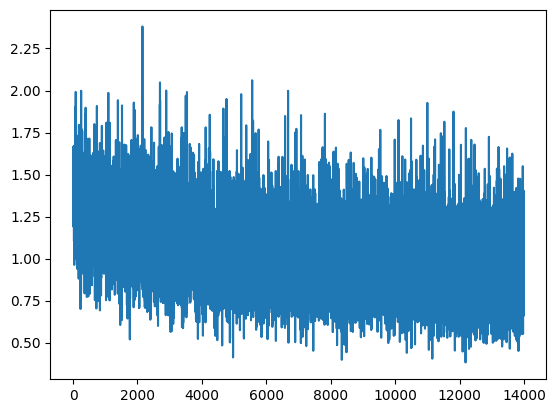

In [19]:
plt.plot(train_losses)

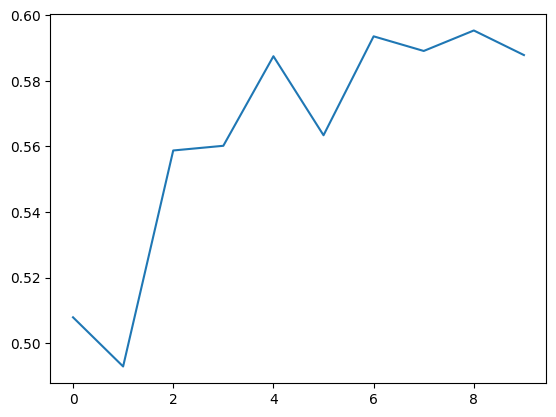

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3292/5600 (0.5879)
{'acc_detail': tensor([0.8629, 0.5186, 0.6771, 0.2929], device='cuda:0'),
 'acc_unweighted': tensor(0.5879, device='cuda:0'),
 'acc_weighted': tensor(0.5879, device='cuda:0'),
 'f1s': tensor(0.5701, device='cuda:0'),
 'f1s_detail': tensor([0.6691, 0.5723, 0.6702, 0.3689], device='cuda:0'),
 'precision_detail': tensor([0.5464, 0.6385, 0.6634, 0.4982], device='cuda:0'),
 'recall_detail': tensor([0.8629, 0.5186, 0.6771, 0.2929], device='cuda:0'),
 'rocauc': tensor([0.8954, 0.8564, 0.8813, 0.7650], device='cuda:0'),
 'uar': tensor(0.5879, device='cuda:0'),
 'wap': tensor(0.5866, device='cuda:0')}


tensor([[1208,   37,   31,  124],
        [ 154,  726,  330,  190],
        [ 161,  192,  948,   99],
        [ 688,  182,  120,  410]], device='cuda:0')

In [23]:
model_path = '../models_esd4/esd4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0005714285714285715/50 [00:00<8:00:52, 577.05s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 1.087191
Mem before-during-after: 30240256 3508747776 36906496


  0%|                          | 0.023428571428571413/50 [00:15<9:45:52, 703.37s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 1.023507
Mem before-during-after: 36906496 3515988480 36906496


  0%|                          | 0.046285714285714215/50 [00:30<9:25:43, 679.51s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 0.555500
Mem before-during-after: 37363200 3516003328 37233152


  0%|                           | 0.06914285714285702/50 [00:46<9:50:18, 709.36s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 0.921392
Mem before-during-after: 36906496 3188882432 36906496


  0%|                          | 0.09199999999999982/50 [01:01<10:30:30, 758.00s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 0.997889
Mem before-during-after: 37121024 3515692032 37401088


  0%|                          | 0.11485714285714262/50 [01:17<10:15:21, 740.12s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 0.951039
Mem before-during-after: 37624832 3515220480 37624832


  0%|                          | 0.13771428571428573/50 [01:33<10:23:23, 750.14s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 0.889724
Mem before-during-after: 37821952 3516325376 38596608


  0%|                            | 0.1605714285714291/50 [01:49<9:35:03, 692.29s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 0.926182
Mem before-during-after: 37103616 3514930688 36906496


  0%|                           | 0.18342857142857244/50 [02:04<9:38:58, 697.34s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 0.840410
Mem before-during-after: 37080576 3515846656 37213696


  0%|                           | 0.2062857142857158/50 [02:20<10:22:49, 750.48s/it]

Train Epoch: 11 [5760/22400 (26%)]	Loss: 1.229401
Mem before-during-after: 36915712 3515220480 36915712


  0%|                           | 0.22914285714285915/50 [02:35<9:33:39, 691.55s/it]

Train Epoch: 11 [6400/22400 (29%)]	Loss: 0.661059
Mem before-during-after: 37746176 3515955712 37309952


  1%|▏                           | 0.2520000000000024/50 [02:50<9:36:19, 695.09s/it]

Train Epoch: 11 [7040/22400 (31%)]	Loss: 0.621364
Mem before-during-after: 36906496 3514320384 36906496


  1%|▏                         | 0.27485714285714463/50 [03:06<10:16:35, 744.00s/it]

Train Epoch: 11 [7680/22400 (34%)]	Loss: 0.939661
Mem before-during-after: 36906496 3516325376 36906496


  1%|▏                           | 0.2977142857142869/50 [03:22<9:50:30, 712.86s/it]

Train Epoch: 11 [8320/22400 (37%)]	Loss: 0.894769
Mem before-during-after: 37299712 3514453504 37757952


  1%|▏                          | 0.3205714285714291/50 [03:37<10:12:50, 740.16s/it]

Train Epoch: 11 [8960/22400 (40%)]	Loss: 0.981379
Mem before-during-after: 37491712 3515203072 36906496


  1%|▏                          | 0.34342857142857136/50 [03:53<9:42:40, 704.05s/it]

Train Epoch: 11 [9600/22400 (43%)]	Loss: 1.008088
Mem before-during-after: 36906496 3514617856 37624832


  1%|▏                          | 0.3662857142857136/50 [04:08<10:14:17, 742.59s/it]

Train Epoch: 11 [10240/22400 (46%)]	Loss: 0.683484
Mem before-during-after: 37925888 3516325376 37925888


  1%|▏                         | 0.38914285714285585/50 [04:24<10:34:54, 767.87s/it]

Train Epoch: 11 [10880/22400 (49%)]	Loss: 0.896269
Mem before-during-after: 37821952 3516325376 38596608


  1%|▏                           | 0.4119999999999981/50 [04:40<9:56:03, 721.21s/it]

Train Epoch: 11 [11520/22400 (51%)]	Loss: 1.164937
Mem before-during-after: 36906496 3147074048 36906496


  1%|▏                          | 0.43485714285714033/50 [04:55<9:11:21, 667.43s/it]

Train Epoch: 11 [12160/22400 (54%)]	Loss: 1.223494
Mem before-during-after: 36906496 3514898944 36906496


  1%|▎                           | 0.4577142857142826/50 [05:10<9:59:39, 726.25s/it]

Train Epoch: 11 [12800/22400 (57%)]	Loss: 0.578523
Mem before-during-after: 36906496 3515080704 36906496


  1%|▎                          | 0.4805714285714248/50 [05:26<10:40:19, 775.84s/it]

Train Epoch: 11 [13440/22400 (60%)]	Loss: 0.725438
Mem before-during-after: 38024704 3515620352 37039616


  1%|▎                           | 0.5034285714285671/50 [05:41<9:45:14, 709.42s/it]

Train Epoch: 11 [14080/22400 (63%)]	Loss: 1.080338
Mem before-during-after: 37204480 3327225344 37305856


  1%|▎                          | 0.5262857142857094/50 [05:56<10:14:20, 745.05s/it]

Train Epoch: 11 [14720/22400 (66%)]	Loss: 1.509306
Mem before-during-after: 36906496 3515063296 36906496


  1%|▎                           | 0.5491428571428516/50 [06:12<9:45:58, 710.97s/it]

Train Epoch: 11 [15360/22400 (69%)]	Loss: 1.039364
Mem before-during-after: 37895168 3057550848 36986880


  1%|▎                           | 0.5719999999999938/50 [06:28<9:28:39, 690.28s/it]

Train Epoch: 11 [16000/22400 (71%)]	Loss: 0.750449
Mem before-during-after: 36906496 3515424768 37821952


  1%|▎                           | 0.5948571428571361/50 [06:43<9:24:21, 685.39s/it]

Train Epoch: 11 [16640/22400 (74%)]	Loss: 1.049498
Mem before-during-after: 37540352 3515872256 36954112


  1%|▎                          | 0.6177142857142783/50 [07:00<10:52:48, 793.17s/it]

Train Epoch: 11 [17280/22400 (77%)]	Loss: 0.964703
Mem before-during-after: 36935168 3501335552 36906496


  1%|▎                          | 0.6405714285714206/50 [07:15<10:11:41, 743.56s/it]

Train Epoch: 11 [17920/22400 (80%)]	Loss: 0.663625
Mem before-during-after: 37624832 3515220480 37624832


  1%|▎                           | 0.6634285714285628/50 [07:31<9:42:27, 708.35s/it]

Train Epoch: 11 [18560/22400 (83%)]	Loss: 1.131571
Mem before-during-after: 37039616 2997640192 36906496


  1%|▎                          | 0.6862857142857051/50 [07:47<10:14:26, 747.58s/it]

Train Epoch: 11 [19200/22400 (86%)]	Loss: 1.034515
Mem before-during-after: 37624832 3466027520 36906496


  1%|▍                           | 0.7091428571428473/50 [08:02<9:55:25, 724.80s/it]

Train Epoch: 11 [19840/22400 (89%)]	Loss: 0.860338
Mem before-during-after: 36906496 3516069376 36906496


  1%|▍                           | 0.7319999999999895/50 [08:17<9:04:42, 663.37s/it]

Train Epoch: 11 [20480/22400 (91%)]	Loss: 0.839733
Mem before-during-after: 37190656 3182554112 37190656


  2%|▍                          | 0.7548571428571318/50 [08:33<10:35:04, 773.78s/it]

Train Epoch: 11 [21120/22400 (94%)]	Loss: 0.909948
Mem before-during-after: 36915712 3514644480 36915712


  2%|▍                           | 0.777714285714274/50 [08:49<10:43:49, 784.80s/it]

Train Epoch: 11 [21760/22400 (97%)]	Loss: 0.706648
Mem before-during-after: 37690368 3515419136 37690368


  2%|▌                           | 0.9999999999999823/50 [10:15<5:03:19, 371.43s/it]


Test Epoch: 11	Accuracy: 3482/5600 (62%)

saved model: ../models_esd4/esd4_m18_best_11epoch.pt


  2%|▌                            | 1.000571428571411/50 [10:15<5:57:08, 437.32s/it]

Train Epoch: 12 [0/22400 (0%)]	Loss: 1.040154
Mem before-during-after: 37929472 3515844096 37933568


  2%|▌                          | 1.0234285714285576/50 [10:31<10:00:55, 736.17s/it]

Train Epoch: 12 [640/22400 (3%)]	Loss: 0.602516
Mem before-during-after: 37762048 3516069376 37895168


  2%|▌                           | 1.0462857142857043/50 [10:47<9:56:17, 730.84s/it]

Train Epoch: 12 [1280/22400 (6%)]	Loss: 1.161236
Mem before-during-after: 37933568 3517015552 38841344


  2%|▌                            | 1.069142857142851/50 [11:02<9:22:29, 689.75s/it]

Train Epoch: 12 [1920/22400 (9%)]	Loss: 0.988874
Mem before-during-after: 37944832 3517309952 37933568


  2%|▌                          | 1.0919999999999976/50 [11:17<10:08:41, 746.73s/it]

Train Epoch: 12 [2560/22400 (11%)]	Loss: 0.909395
Mem before-during-after: 36906496 3516325376 36906496


  2%|▌                          | 1.1148571428571443/50 [11:33<10:04:05, 741.43s/it]

Train Epoch: 12 [3200/22400 (14%)]	Loss: 0.734880
Mem before-during-after: 38841344 3516882432 38708224


  2%|▋                           | 1.137714285714291/50 [11:48<10:39:41, 785.51s/it]

Train Epoch: 12 [3840/22400 (17%)]	Loss: 0.963478
Mem before-during-after: 37331456 3516345856 37681152


  2%|▋                          | 1.1605714285714377/50 [12:04<10:13:12, 753.34s/it]

Train Epoch: 12 [4480/22400 (20%)]	Loss: 0.582603
Mem before-during-after: 37895168 3516261376 37895168


  2%|▋                           | 1.1834285714285844/50 [12:19<9:55:19, 731.71s/it]

Train Epoch: 12 [5120/22400 (23%)]	Loss: 1.168646
Mem before-during-after: 37933568 3515992064 37933568


  2%|▋                            | 1.206285714285731/50 [12:34<9:30:42, 701.78s/it]

Train Epoch: 12 [5760/22400 (26%)]	Loss: 0.742152
Mem before-during-after: 36906496 3515651584 36906496


  2%|▋                          | 1.2291428571428777/50 [12:50<10:00:21, 738.59s/it]

Train Epoch: 12 [6400/22400 (29%)]	Loss: 0.875261
Mem before-during-after: 37895168 3473245184 36906496


  3%|▋                          | 1.2520000000000244/50 [13:05<10:30:28, 776.01s/it]

Train Epoch: 12 [7040/22400 (31%)]	Loss: 0.920303
Mem before-during-after: 36906496 3516325376 37317632


  3%|▋                            | 1.274857142857171/50 [13:21<9:58:11, 736.61s/it]

Train Epoch: 12 [7680/22400 (34%)]	Loss: 0.909905
Mem before-during-after: 37491712 3515203072 36906496


  3%|▋                           | 1.2977142857143178/50 [13:37<9:55:43, 733.92s/it]

Train Epoch: 12 [8320/22400 (37%)]	Loss: 1.037901
Mem before-during-after: 37025280 3218288640 36906496


  3%|▋                          | 1.3205714285714645/50 [13:53<10:05:13, 745.98s/it]

Train Epoch: 12 [8960/22400 (40%)]	Loss: 0.732747
Mem before-during-after: 37895168 3516261376 37895168


  3%|▊                           | 1.3434285714286112/50 [14:08<9:39:04, 714.07s/it]

Train Epoch: 12 [9600/22400 (43%)]	Loss: 0.808621
Mem before-during-after: 37316608 3515585536 36906496


  3%|▋                          | 1.3662857142857578/50 [14:23<10:13:56, 757.43s/it]

Train Epoch: 12 [10240/22400 (46%)]	Loss: 0.994974
Mem before-during-after: 37895168 3516261376 37895168


  3%|▊                           | 1.3891428571429045/50 [14:39<9:52:17, 731.07s/it]

Train Epoch: 12 [10880/22400 (49%)]	Loss: 0.752971
Mem before-during-after: 37933568 3517145600 37933568


  3%|▊                           | 1.4120000000000512/50 [14:54<9:52:34, 731.76s/it]

Train Epoch: 12 [11520/22400 (51%)]	Loss: 1.207020
Mem before-during-after: 37213696 3516028416 37245440


  3%|▊                           | 1.434857142857198/50 [15:10<10:02:23, 744.23s/it]

Train Epoch: 12 [12160/22400 (54%)]	Loss: 1.170444
Mem before-during-after: 36906496 3516325376 36906496


  3%|▊                          | 1.4577142857143446/50 [15:26<10:05:23, 748.29s/it]

Train Epoch: 12 [12800/22400 (57%)]	Loss: 0.726676
Mem before-during-after: 37891072 3516527616 36906496


  3%|▊                          | 1.4805714285714913/50 [15:41<10:01:16, 743.55s/it]

Train Epoch: 12 [13440/22400 (60%)]	Loss: 0.982869
Mem before-during-after: 37531136 3516315136 37531136


  3%|▊                           | 1.503428571428638/50 [15:56<10:01:10, 743.78s/it]

Train Epoch: 12 [14080/22400 (63%)]	Loss: 1.054729
Mem before-during-after: 36906496 3514831872 37491712


  3%|▊                           | 1.5262857142857846/50 [16:12<9:57:37, 739.72s/it]

Train Epoch: 12 [14720/22400 (66%)]	Loss: 0.826775
Mem before-during-after: 37120512 3514831872 37120512


  3%|▊                           | 1.5491428571429313/50 [16:27<9:58:09, 740.74s/it]

Train Epoch: 12 [15360/22400 (69%)]	Loss: 0.914674
Mem before-during-after: 37895168 3516261376 37895168


  3%|▉                           | 1.572000000000078/50 [16:43<10:16:55, 764.35s/it]

Train Epoch: 12 [16000/22400 (71%)]	Loss: 0.853417
Mem before-during-after: 37681152 3516325376 37681152


  3%|▊                          | 1.5948571428572247/50 [16:59<10:16:25, 764.08s/it]

Train Epoch: 12 [16640/22400 (74%)]	Loss: 0.566656
Mem before-during-after: 37947392 3514502144 36906496


  3%|▊                          | 1.6177142857143714/50 [17:14<10:03:34, 748.50s/it]

Train Epoch: 12 [17280/22400 (77%)]	Loss: 0.643666
Mem before-during-after: 36906496 3515567616 36906496


  3%|▉                           | 1.640571428571518/50 [17:30<10:39:21, 793.27s/it]

Train Epoch: 12 [17920/22400 (80%)]	Loss: 0.816834
Mem before-during-after: 37895168 3516261376 37895168


  3%|▉                           | 1.6634285714286647/50 [17:45<8:58:10, 668.04s/it]

Train Epoch: 12 [18560/22400 (83%)]	Loss: 1.001615
Mem before-during-after: 37548544 2997258240 36906496


  3%|▉                           | 1.6862857142858114/50 [18:00<9:57:09, 741.59s/it]

Train Epoch: 12 [19200/22400 (86%)]	Loss: 0.768711
Mem before-during-after: 36906496 3515848192 36906496


  3%|▉                           | 1.709142857142958/50 [18:16<10:34:05, 787.84s/it]

Train Epoch: 12 [19840/22400 (89%)]	Loss: 0.611993
Mem before-during-after: 36906496 3515139584 36906496


  3%|▉                           | 1.7320000000001048/50 [18:31<9:51:47, 735.64s/it]

Train Epoch: 12 [20480/22400 (91%)]	Loss: 0.810429
Mem before-during-after: 36906496 3515451904 36906496


  4%|▉                           | 1.7548571428572515/50 [18:47<9:57:00, 742.46s/it]

Train Epoch: 12 [21120/22400 (94%)]	Loss: 0.880150
Mem before-during-after: 36906496 3515139584 36906496


  4%|▉                          | 1.7777142857143982/50 [19:02<10:10:50, 760.04s/it]

Train Epoch: 12 [21760/22400 (97%)]	Loss: 0.850828
Mem before-during-after: 37548544 3516429824 38312448


  4%|█                           | 2.0000000000001497/50 [20:28<4:48:24, 360.52s/it]


Test Epoch: 12	Accuracy: 3497/5600 (62%)

saved model: ../models_esd4/esd4_m18_best_12epoch.pt


  4%|█▏                           | 2.000571428571578/50 [20:28<5:41:59, 427.50s/it]

Train Epoch: 13 [0/22400 (0%)]	Loss: 0.702425
Mem before-during-after: 37921792 3516325376 38092288


  4%|█▏                           | 2.023428571428716/50 [20:44<9:28:34, 711.06s/it]

Train Epoch: 13 [640/22400 (3%)]	Loss: 0.778342
Mem before-during-after: 36906496 3514933248 36906496


  4%|█▏                          | 2.0462857142858537/50 [20:59<9:00:40, 676.50s/it]

Train Epoch: 13 [1280/22400 (6%)]	Loss: 0.746287
Mem before-during-after: 37876224 3514320384 36925440


  4%|█                          | 2.0691428571429915/50 [21:15<10:04:31, 756.74s/it]

Train Epoch: 13 [1920/22400 (9%)]	Loss: 0.717479
Mem before-during-after: 36988416 3514802176 36906496


  4%|█▏                          | 2.0920000000001293/50 [21:31<9:49:41, 738.52s/it]

Train Epoch: 13 [2560/22400 (11%)]	Loss: 0.992796
Mem before-during-after: 37933568 3517015552 38841344


  4%|█▏                           | 2.114857142857267/50 [21:46<9:26:54, 710.33s/it]

Train Epoch: 13 [3200/22400 (14%)]	Loss: 0.871138
Mem before-during-after: 37681152 3514617856 37624832


  4%|█▏                           | 2.137714285714405/50 [22:02<9:51:24, 741.39s/it]

Train Epoch: 13 [3840/22400 (17%)]	Loss: 0.901697
Mem before-during-after: 36906496 3514705920 37110272


  4%|█▏                          | 2.1605714285715427/50 [22:17<9:31:50, 717.19s/it]

Train Epoch: 13 [4480/22400 (20%)]	Loss: 0.609148
Mem before-during-after: 36950528 3515540480 36906496


  4%|█▏                          | 2.1834285714286805/50 [22:33<9:30:39, 716.06s/it]

Train Epoch: 13 [5120/22400 (23%)]	Loss: 0.949124
Mem before-during-after: 37027328 3514886144 36906496


  4%|█▏                          | 2.2062857142858183/50 [22:50<9:23:24, 707.29s/it]

Train Epoch: 13 [5760/22400 (26%)]	Loss: 1.011040
Mem before-during-after: 37681152 2900655616 36906496


  4%|█▎                           | 2.229142857142956/50 [23:06<9:47:57, 738.48s/it]

Train Epoch: 13 [6400/22400 (29%)]	Loss: 0.911137
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▎                           | 2.252000000000094/50 [23:21<9:26:23, 711.73s/it]

Train Epoch: 13 [7040/22400 (31%)]	Loss: 0.492413
Mem before-during-after: 36906496 3514866688 37169152


  5%|█▎                          | 2.2748571428572317/50 [23:37<9:56:07, 749.45s/it]

Train Epoch: 13 [7680/22400 (34%)]	Loss: 0.615481
Mem before-during-after: 36906496 3514831872 37491712


  5%|█▎                          | 2.2977142857143695/50 [23:52<9:47:04, 738.43s/it]

Train Epoch: 13 [8320/22400 (37%)]	Loss: 1.276929
Mem before-during-after: 37826048 3516297216 37826048


  5%|█▎                          | 2.3205714285715073/50 [24:07<9:55:18, 749.15s/it]

Train Epoch: 13 [8960/22400 (40%)]	Loss: 0.995432
Mem before-during-after: 37302272 3515220480 37302272


  5%|█▎                           | 2.343428571428645/50 [24:22<9:20:51, 706.13s/it]

Train Epoch: 13 [9600/22400 (43%)]	Loss: 0.749178
Mem before-during-after: 37933568 3517015552 38841344


  5%|█▎                          | 2.366285714285783/50 [24:38<10:23:23, 785.23s/it]

Train Epoch: 13 [10240/22400 (46%)]	Loss: 0.608093
Mem before-during-after: 37681152 3515409920 37681152


  5%|█▎                          | 2.3891428571429207/50 [24:53<9:42:00, 733.46s/it]

Train Epoch: 13 [10880/22400 (49%)]	Loss: 1.358494
Mem before-during-after: 36906496 3514502144 36906496


  5%|█▎                          | 2.4120000000000585/50 [25:09<9:28:21, 716.59s/it]

Train Epoch: 13 [11520/22400 (51%)]	Loss: 1.182054
Mem before-during-after: 37814272 3516233216 37681152


  5%|█▎                         | 2.4348571428571963/50 [25:24<10:31:26, 796.52s/it]

Train Epoch: 13 [12160/22400 (54%)]	Loss: 0.715762
Mem before-during-after: 36906496 3516325376 36906496


  5%|█▍                           | 2.457714285714334/50 [25:40<9:23:32, 711.20s/it]

Train Epoch: 13 [12800/22400 (57%)]	Loss: 0.800917
Mem before-during-after: 38596608 3164072448 37821952


  5%|█▍                          | 2.480571428571472/50 [25:56<10:42:47, 811.61s/it]

Train Epoch: 13 [13440/22400 (60%)]	Loss: 0.691867
Mem before-during-after: 37039616 3515139584 36906496


  5%|█▎                         | 2.5034285714286098/50 [26:11<10:02:20, 760.91s/it]

Train Epoch: 13 [14080/22400 (63%)]	Loss: 0.574218
Mem before-during-after: 38092288 3516261376 37895168


  5%|█▍                          | 2.5262857142857476/50 [26:26<9:48:37, 743.94s/it]

Train Epoch: 13 [14720/22400 (66%)]	Loss: 1.085266
Mem before-during-after: 37814272 3515855360 37681152


  5%|█▍                          | 2.5491428571428854/50 [26:42<9:31:47, 723.01s/it]

Train Epoch: 13 [15360/22400 (69%)]	Loss: 0.837303
Mem before-during-after: 37895168 3416978944 36906496


  5%|█▍                           | 2.572000000000023/50 [26:57<9:05:23, 689.95s/it]

Train Epoch: 13 [16000/22400 (71%)]	Loss: 0.787540
Mem before-during-after: 37312000 3516011520 36906496


  5%|█▌                           | 2.594857142857161/50 [27:12<9:10:19, 696.54s/it]

Train Epoch: 13 [16640/22400 (74%)]	Loss: 0.460622
Mem before-during-after: 36906496 3514436096 36906496


  5%|█▍                         | 2.6177142857142988/50 [27:28<10:19:32, 784.52s/it]

Train Epoch: 13 [17280/22400 (77%)]	Loss: 0.755630
Mem before-during-after: 37681152 3514617856 37624832


  5%|█▍                          | 2.6405714285714366/50 [27:44<9:43:35, 739.36s/it]

Train Epoch: 13 [17920/22400 (80%)]	Loss: 1.050005
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▍                         | 2.6634285714285744/50 [27:59<10:12:12, 775.99s/it]

Train Epoch: 13 [18560/22400 (83%)]	Loss: 0.839254
Mem before-during-after: 36906496 3515623936 37895168


  5%|█▌                           | 2.686285714285712/50 [28:15<9:46:55, 744.31s/it]

Train Epoch: 13 [19200/22400 (86%)]	Loss: 1.378770
Mem before-during-after: 38596608 3516325376 38596608


  5%|█▋                            | 2.70914285714285/50 [28:31<9:56:27, 756.74s/it]

Train Epoch: 13 [19840/22400 (89%)]	Loss: 0.899470
Mem before-during-after: 36906496 3515139584 36906496


  5%|█▌                          | 2.7319999999999878/50 [28:46<9:42:02, 738.82s/it]

Train Epoch: 13 [20480/22400 (91%)]	Loss: 1.109148
Mem before-during-after: 36932096 3515353600 36932096


  6%|█▌                          | 2.7548571428571256/50 [29:02<9:00:24, 686.30s/it]

Train Epoch: 13 [21120/22400 (94%)]	Loss: 0.768001
Mem before-during-after: 37365248 3515915264 36906496


  6%|█▌                          | 2.7777142857142634/50 [29:18<9:46:23, 745.07s/it]

Train Epoch: 13 [21760/22400 (97%)]	Loss: 0.922819
Mem before-during-after: 37361664 3514650624 37236736


  6%|█▋                          | 2.9999999999999285/50 [30:44<4:43:39, 362.12s/it]


Test Epoch: 13	Accuracy: 3486/5600 (62%)



  6%|█▋                           | 3.000571428571357/50 [30:44<5:43:42, 438.79s/it]

Train Epoch: 14 [0/22400 (0%)]	Loss: 0.580883
Mem before-during-after: 36902400 3515139584 36906496


  6%|█▋                          | 3.0234285714284947/50 [31:00<9:42:29, 743.99s/it]

Train Epoch: 14 [640/22400 (3%)]	Loss: 1.040531
Mem before-during-after: 37895168 3516261376 37895168


  6%|█▋                          | 3.0462857142856326/50 [31:15<8:59:54, 689.93s/it]

Train Epoch: 14 [1280/22400 (6%)]	Loss: 0.819728
Mem before-during-after: 37714944 3377369600 36940288


  6%|█▋                          | 3.0691428571427704/50 [31:30<9:00:11, 690.62s/it]

Train Epoch: 14 [1920/22400 (9%)]	Loss: 0.923248
Mem before-during-after: 36906496 3515655168 36906496


  6%|█▊                           | 3.091999999999908/50 [31:46<9:46:58, 750.80s/it]

Train Epoch: 14 [2560/22400 (11%)]	Loss: 0.829219
Mem before-during-after: 36906496 3515455488 37491712


  6%|█▊                           | 3.114857142857046/50 [32:02<9:29:54, 729.31s/it]

Train Epoch: 14 [3200/22400 (14%)]	Loss: 0.742258
Mem before-during-after: 36906496 3515567616 36906496


  6%|█▊                          | 3.1377142857141838/50 [32:17<9:34:15, 735.24s/it]

Train Epoch: 14 [3840/22400 (17%)]	Loss: 0.925010
Mem before-during-after: 37540352 3516043776 37821952


  6%|█▊                          | 3.1605714285713216/50 [32:32<9:20:25, 717.89s/it]

Train Epoch: 14 [4480/22400 (20%)]	Loss: 0.699230
Mem before-during-after: 37285376 3516134912 37253632


  6%|█▊                          | 3.1834285714284594/50 [32:48<9:41:06, 744.74s/it]

Train Epoch: 14 [5120/22400 (23%)]	Loss: 0.976012
Mem before-during-after: 37285376 3515329536 37253632


  6%|█▊                           | 3.206285714285597/50 [33:04<9:46:32, 752.08s/it]

Train Epoch: 14 [5760/22400 (26%)]	Loss: 1.072076
Mem before-during-after: 37895168 3516269568 37895168


  6%|█▊                           | 3.229142857142735/50 [33:19<9:24:47, 724.53s/it]

Train Epoch: 14 [6400/22400 (29%)]	Loss: 0.980456
Mem before-during-after: 37071360 3515691008 36906496


  7%|█▊                          | 3.2519999999998728/50 [33:35<8:50:17, 680.62s/it]

Train Epoch: 14 [7040/22400 (31%)]	Loss: 1.346033
Mem before-during-after: 36906496 3516149760 36906496


  7%|█▊                          | 3.2748571428570106/50 [33:50<9:41:28, 746.68s/it]

Train Epoch: 14 [7680/22400 (34%)]	Loss: 0.780124
Mem before-during-after: 36906496 3515451904 36906496


  7%|█▊                          | 3.2977142857141484/50 [34:05<9:43:00, 749.01s/it]

Train Epoch: 14 [8320/22400 (37%)]	Loss: 1.031602
Mem before-during-after: 38596608 3417888256 37084672


  7%|█▉                           | 3.320571428571286/50 [34:21<9:50:29, 758.99s/it]

Train Epoch: 14 [8960/22400 (40%)]	Loss: 0.811675
Mem before-during-after: 37878272 3516261376 37895168


  7%|█▉                           | 3.343428571428424/50 [34:37<9:47:15, 755.21s/it]

Train Epoch: 14 [9600/22400 (43%)]	Loss: 0.703870
Mem before-during-after: 37421568 3473233408 36906496


  7%|█▉                           | 3.366285714285562/50 [34:53<9:56:52, 767.94s/it]

Train Epoch: 14 [10240/22400 (46%)]	Loss: 1.235110
Mem before-during-after: 37895168 3516261376 37895168


  7%|█▉                          | 3.3891428571426996/50 [35:08<9:29:32, 733.13s/it]

Train Epoch: 14 [10880/22400 (49%)]	Loss: 0.962174
Mem before-during-after: 37933568 3517015552 37933568


  7%|█▉                          | 3.4119999999998374/50 [35:24<9:51:19, 761.57s/it]

Train Epoch: 14 [11520/22400 (51%)]	Loss: 0.724665
Mem before-during-after: 37792768 3516325376 37018112


  7%|█▉                           | 3.434857142856975/50 [35:39<9:15:27, 715.72s/it]

Train Epoch: 14 [12160/22400 (54%)]	Loss: 1.224183
Mem before-during-after: 38596608 3417951744 37084672


  7%|██                           | 3.457714285714113/50 [35:55<9:34:36, 740.75s/it]

Train Epoch: 14 [12800/22400 (57%)]	Loss: 0.835509
Mem before-during-after: 37933568 3517015552 38841344


  7%|██                           | 3.480571428571251/50 [36:11<9:37:28, 744.81s/it]

Train Epoch: 14 [13440/22400 (60%)]	Loss: 0.552479
Mem before-during-after: 37895168 3516261376 37895168


  7%|█▉                          | 3.5034285714283886/50 [36:26<9:15:28, 716.79s/it]

Train Epoch: 14 [14080/22400 (63%)]	Loss: 0.877701
Mem before-during-after: 36906496 3514933760 36906496


  7%|█▉                         | 3.5262857142855264/50 [36:42<10:16:05, 795.41s/it]

Train Epoch: 14 [14720/22400 (66%)]	Loss: 0.787186
Mem before-during-after: 37018112 3516325376 37792768


  7%|██                           | 3.549142857142664/50 [36:57<9:07:21, 707.01s/it]

Train Epoch: 14 [15360/22400 (69%)]	Loss: 0.881028
Mem before-during-after: 36906496 3291968512 37160448


  7%|██                           | 3.571999999999802/50 [37:13<9:39:16, 748.60s/it]

Train Epoch: 14 [16000/22400 (71%)]	Loss: 0.653028
Mem before-during-after: 36906496 3514750976 36906496


  7%|██▏                           | 3.59485714285694/50 [37:29<9:57:43, 772.84s/it]

Train Epoch: 14 [16640/22400 (74%)]	Loss: 1.005292
Mem before-during-after: 36906496 3514635264 36906496


  7%|██                          | 3.6177142857140776/50 [37:44<9:05:34, 705.75s/it]

Train Epoch: 14 [17280/22400 (77%)]	Loss: 0.713600
Mem before-during-after: 36906496 3018078208 36906496


  7%|██                          | 3.6405714285712154/50 [38:00<9:34:59, 744.17s/it]

Train Epoch: 14 [17920/22400 (80%)]	Loss: 0.679203
Mem before-during-after: 37895168 3516261376 37895168


  7%|██                           | 3.663428571428353/50 [38:15<9:01:50, 701.61s/it]

Train Epoch: 14 [18560/22400 (83%)]	Loss: 0.840868
Mem before-during-after: 37925888 3362778624 37108736


  7%|██▏                          | 3.686285714285491/50 [38:30<9:27:01, 734.60s/it]

Train Epoch: 14 [19200/22400 (86%)]	Loss: 0.811273
Mem before-during-after: 36906496 3515353600 36906496


  7%|██▏                          | 3.709142857142629/50 [38:46<9:28:35, 736.98s/it]

Train Epoch: 14 [19840/22400 (89%)]	Loss: 0.661945
Mem before-during-after: 37895168 3515623936 37895168


  7%|██                          | 3.7319999999997666/50 [39:01<9:20:43, 727.13s/it]

Train Epoch: 14 [20480/22400 (91%)]	Loss: 0.850399
Mem before-during-after: 37955072 3430215680 37978624


  8%|██                         | 3.7548571428569044/50 [39:17<10:12:53, 795.18s/it]

Train Epoch: 14 [21120/22400 (94%)]	Loss: 0.683683
Mem before-during-after: 37018112 3516325376 38030848


  8%|██▏                          | 3.777714285714042/50 [39:33<8:26:08, 657.01s/it]

Train Epoch: 14 [21760/22400 (97%)]	Loss: 0.654153
Mem before-during-after: 36906496 3516093440 36946432


  8%|██▏                         | 3.9999999999997073/50 [41:00<4:36:41, 360.91s/it]


Test Epoch: 14	Accuracy: 3530/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_14epoch.pt


  8%|██▎                          | 4.000571428571136/50 [41:00<5:27:54, 427.71s/it]

Train Epoch: 15 [0/22400 (0%)]	Loss: 0.754956
Mem before-during-after: 36902400 3515139584 36906496


  8%|██▎                          | 4.023428571428291/50 [41:16<9:38:58, 755.58s/it]

Train Epoch: 15 [640/22400 (3%)]	Loss: 0.632962
Mem before-during-after: 37317632 3516261376 37895168


  8%|██▎                          | 4.046285714285447/50 [41:32<9:53:42, 775.19s/it]

Train Epoch: 15 [1280/22400 (6%)]	Loss: 0.497452
Mem before-during-after: 37120512 3515139584 36906496


  8%|██▎                         | 4.0691428571426025/50 [41:47<8:48:02, 689.78s/it]

Train Epoch: 15 [1920/22400 (9%)]	Loss: 0.695947
Mem before-during-after: 38095360 3397011968 37261824


  8%|██▎                          | 4.091999999999758/50 [42:03<9:23:50, 736.93s/it]

Train Epoch: 15 [2560/22400 (11%)]	Loss: 0.923955
Mem before-during-after: 37895168 3516261376 37895168


  8%|██▍                          | 4.114857142856914/50 [42:18<8:56:50, 701.97s/it]

Train Epoch: 15 [3200/22400 (14%)]	Loss: 0.612696
Mem before-during-after: 37062144 3515615232 37681152


  8%|██▍                          | 4.137714285714069/50 [42:34<9:26:45, 741.47s/it]

Train Epoch: 15 [3840/22400 (17%)]	Loss: 1.097839
Mem before-during-after: 37895168 3516261376 37895168


  8%|██▍                          | 4.160571428571225/50 [42:49<9:08:34, 718.05s/it]

Train Epoch: 15 [4480/22400 (20%)]	Loss: 0.802396
Mem before-during-after: 36906496 3514849280 36906496


  8%|██▌                           | 4.18342857142838/50 [43:04<9:24:46, 739.62s/it]

Train Epoch: 15 [5120/22400 (23%)]	Loss: 0.723453
Mem before-during-after: 37624832 3515844096 37624832


  8%|██▍                          | 4.206285714285536/50 [43:20<9:11:37, 722.75s/it]

Train Epoch: 15 [5760/22400 (26%)]	Loss: 1.068328
Mem before-during-after: 37895168 3266831872 36906496


  8%|██▎                         | 4.2291428571426914/50 [43:36<9:37:50, 757.48s/it]

Train Epoch: 15 [6400/22400 (29%)]	Loss: 1.016101
Mem before-during-after: 37421568 3515844096 37421568


  9%|██▍                          | 4.251999999999847/50 [43:51<9:27:47, 744.68s/it]

Train Epoch: 15 [7040/22400 (31%)]	Loss: 1.205003
Mem before-during-after: 37204480 3515213824 37039616


  9%|██▍                          | 4.274857142857003/50 [44:06<8:42:13, 685.26s/it]

Train Epoch: 15 [7680/22400 (34%)]	Loss: 0.981993
Mem before-during-after: 37115392 3514760704 36906496


  9%|██▍                         | 4.297714285714158/50 [44:23<10:13:24, 805.30s/it]

Train Epoch: 15 [8320/22400 (37%)]	Loss: 0.614182
Mem before-during-after: 37698560 3516325376 37698560


  9%|██▌                          | 4.320571428571314/50 [44:39<9:33:55, 753.85s/it]

Train Epoch: 15 [8960/22400 (40%)]	Loss: 0.537035
Mem before-during-after: 37681152 3515409920 37681152


  9%|██▌                          | 4.343428571428469/50 [44:54<9:57:44, 785.54s/it]

Train Epoch: 15 [9600/22400 (43%)]	Loss: 0.814419
Mem before-during-after: 36906496 3515139584 36906496


  9%|██▌                          | 4.366285714285625/50 [45:10<9:39:39, 762.15s/it]

Train Epoch: 15 [10240/22400 (46%)]	Loss: 1.109258
Mem before-during-after: 38596608 3335173120 36944384


  9%|██▋                           | 4.38914285714278/50 [45:25<9:24:10, 742.16s/it]

Train Epoch: 15 [10880/22400 (49%)]	Loss: 0.839595
Mem before-during-after: 38708224 3517015552 37233152


  9%|██▌                          | 4.411999999999936/50 [45:41<9:38:26, 761.31s/it]

Train Epoch: 15 [11520/22400 (51%)]	Loss: 1.062423
Mem before-during-after: 37039616 3516325376 36906496


  9%|██▍                         | 4.4348571428570915/50 [45:57<9:30:10, 750.81s/it]

Train Epoch: 15 [12160/22400 (54%)]	Loss: 0.913690
Mem before-during-after: 36906496 3514502144 36906496


  9%|██▌                          | 4.457714285714247/50 [46:12<9:49:46, 777.01s/it]

Train Epoch: 15 [12800/22400 (57%)]	Loss: 0.562744
Mem before-during-after: 36906496 3516325376 36906496


  9%|██▌                          | 4.480571428571403/50 [46:28<9:37:39, 761.42s/it]

Train Epoch: 15 [13440/22400 (60%)]	Loss: 1.253242
Mem before-during-after: 36906496 3516063232 38532608


  9%|██▌                          | 4.503428571428558/50 [46:43<8:39:55, 685.67s/it]

Train Epoch: 15 [14080/22400 (63%)]	Loss: 0.727313
Mem before-during-after: 37681152 3376880128 38493696


  9%|██▋                          | 4.526285714285714/50 [46:59<9:33:57, 757.31s/it]

Train Epoch: 15 [14720/22400 (66%)]	Loss: 0.813056
Mem before-during-after: 36906496 3515139584 36906496


  9%|██▋                          | 4.549142857142869/50 [47:14<9:11:58, 728.67s/it]

Train Epoch: 15 [15360/22400 (69%)]	Loss: 1.295400
Mem before-during-after: 37821952 3301052416 37656064


  9%|██▋                          | 4.572000000000025/50 [47:30<9:26:59, 748.86s/it]

Train Epoch: 15 [16000/22400 (71%)]	Loss: 0.585082
Mem before-during-after: 37895168 3516261376 37895168


  9%|██▌                         | 4.5948571428571805/50 [47:46<9:51:30, 781.65s/it]

Train Epoch: 15 [16640/22400 (74%)]	Loss: 0.762699
Mem before-during-after: 38596608 3516325376 38596608


  9%|██▋                          | 4.617714285714336/50 [48:01<9:31:29, 755.57s/it]

Train Epoch: 15 [17280/22400 (77%)]	Loss: 0.909539
Mem before-during-after: 37039616 3515550720 36906496


  9%|██▋                          | 4.640571428571492/50 [48:16<9:23:06, 744.87s/it]

Train Epoch: 15 [17920/22400 (80%)]	Loss: 0.849381
Mem before-during-after: 37933568 3517015552 38841344


  9%|██▋                          | 4.663428571428647/50 [48:32<9:10:04, 727.99s/it]

Train Epoch: 15 [18560/22400 (83%)]	Loss: 0.604356
Mem before-during-after: 37018112 3514960896 37018112


  9%|██▋                          | 4.686285714285803/50 [48:47<9:11:25, 730.15s/it]

Train Epoch: 15 [19200/22400 (86%)]	Loss: 0.826795
Mem before-during-after: 36906496 3515691008 37071360


  9%|██▋                          | 4.709142857142958/50 [49:03<9:33:21, 759.57s/it]

Train Epoch: 15 [19840/22400 (89%)]	Loss: 0.766343
Mem before-during-after: 38596608 3516325376 38596608


  9%|██▋                          | 4.732000000000114/50 [49:18<9:40:41, 769.68s/it]

Train Epoch: 15 [20480/22400 (91%)]	Loss: 0.707005
Mem before-during-after: 37069312 3515705856 37814272


 10%|██▋                         | 4.7548571428572695/50 [49:34<8:36:23, 684.78s/it]

Train Epoch: 15 [21120/22400 (94%)]	Loss: 1.235772
Mem before-during-after: 38538752 3515621888 38092288


 10%|██▊                          | 4.777714285714425/50 [49:49<9:43:07, 773.68s/it]

Train Epoch: 15 [21760/22400 (97%)]	Loss: 1.037121
Mem before-during-after: 36906496 3514502144 36906496


 10%|██▉                          | 5.000000000000263/50 [51:16<4:23:00, 350.68s/it]


Test Epoch: 15	Accuracy: 3537/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_15epoch.pt


 10%|██▉                          | 5.000571428571692/50 [51:16<5:16:13, 421.64s/it]

Train Epoch: 16 [0/22400 (0%)]	Loss: 0.752575
Mem before-during-after: 36907008 3515028480 36911104


 10%|██▉                          | 5.023428571428847/50 [51:32<9:27:19, 756.82s/it]

Train Epoch: 16 [640/22400 (3%)]	Loss: 0.984709
Mem before-during-after: 36906496 3514831872 37491712


 10%|██▉                          | 5.046285714286003/50 [51:47<9:15:18, 741.18s/it]

Train Epoch: 16 [1280/22400 (6%)]	Loss: 0.659369
Mem before-during-after: 37120512 3515455488 37120512


 10%|██▊                         | 5.0691428571431585/50 [52:03<9:36:55, 770.43s/it]

Train Epoch: 16 [1920/22400 (9%)]	Loss: 1.022765
Mem before-during-after: 36906496 3516325376 36906496


 10%|██▉                          | 5.092000000000314/50 [52:18<8:44:19, 700.52s/it]

Train Epoch: 16 [2560/22400 (11%)]	Loss: 0.536131
Mem before-during-after: 38288384 3516872192 37681152


 10%|███                           | 5.11485714285747/50 [52:33<8:59:58, 721.82s/it]

Train Epoch: 16 [3200/22400 (14%)]	Loss: 0.621541
Mem before-during-after: 36906496 3516149248 38098432


 10%|██▉                          | 5.137714285714625/50 [52:49<8:50:03, 708.92s/it]

Train Epoch: 16 [3840/22400 (17%)]	Loss: 0.888959
Mem before-during-after: 38596608 3445441024 37654016


 10%|██▉                          | 5.160571428571781/50 [53:04<9:22:33, 752.76s/it]

Train Epoch: 16 [4480/22400 (20%)]	Loss: 1.441455
Mem before-during-after: 37564928 3515559936 36906496


 10%|███                          | 5.183428571428936/50 [53:20<8:44:34, 702.29s/it]

Train Epoch: 16 [5120/22400 (23%)]	Loss: 0.815460
Mem before-during-after: 37772800 3516704768 37933568


 10%|███                          | 5.206285714286092/50 [53:35<8:42:56, 700.47s/it]

Train Epoch: 16 [5760/22400 (26%)]	Loss: 0.853040
Mem before-during-after: 37624832 3355542016 36932096


 10%|██▉                         | 5.2291428571432474/50 [53:51<9:15:35, 744.57s/it]

Train Epoch: 16 [6400/22400 (29%)]	Loss: 0.673737
Mem before-during-after: 37253632 3515429376 37189632


 11%|███                          | 5.252000000000403/50 [54:06<8:46:06, 705.43s/it]

Train Epoch: 16 [7040/22400 (31%)]	Loss: 0.894613
Mem before-during-after: 36906496 3515641344 37191168


 11%|██▉                         | 5.274857142857559/50 [54:22<10:05:48, 812.71s/it]

Train Epoch: 16 [7680/22400 (34%)]	Loss: 0.840748
Mem before-during-after: 36906496 3514502144 36906496


 11%|███                          | 5.297714285714714/50 [54:38<9:16:07, 746.43s/it]

Train Epoch: 16 [8320/22400 (37%)]	Loss: 0.484820
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▏                          | 5.32057142857187/50 [54:54<9:17:26, 748.60s/it]

Train Epoch: 16 [8960/22400 (40%)]	Loss: 0.666577
Mem before-during-after: 37895168 3516261376 37895168


 11%|███                          | 5.343428571429025/50 [55:09<9:30:28, 766.48s/it]

Train Epoch: 16 [9600/22400 (43%)]	Loss: 0.962959
Mem before-during-after: 36906496 3516325376 36906496


 11%|███                          | 5.366285714286181/50 [55:25<9:15:48, 747.17s/it]

Train Epoch: 16 [10240/22400 (46%)]	Loss: 0.740430
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▏                         | 5.389142857143336/50 [55:40<8:38:04, 696.79s/it]

Train Epoch: 16 [10880/22400 (49%)]	Loss: 0.996952
Mem before-during-after: 37071360 3515213824 36906496


 11%|███▏                         | 5.412000000000492/50 [55:56<9:53:11, 798.23s/it]

Train Epoch: 16 [11520/22400 (51%)]	Loss: 0.748691
Mem before-during-after: 36906496 3516325376 36906496


 11%|███                         | 5.4348571428576475/50 [56:12<9:01:16, 728.74s/it]

Train Epoch: 16 [12160/22400 (54%)]	Loss: 0.921514
Mem before-during-after: 36970496 3141354496 36948992


 11%|███▏                         | 5.457714285714803/50 [56:27<8:19:32, 672.89s/it]

Train Epoch: 16 [12800/22400 (57%)]	Loss: 0.803199
Mem before-during-after: 36906496 3411378176 37113344


 11%|███▏                         | 5.480571428571959/50 [56:43<9:24:03, 760.20s/it]

Train Epoch: 16 [13440/22400 (60%)]	Loss: 1.318102
Mem before-during-after: 37351936 3515623936 36906496


 11%|███▏                         | 5.503428571429114/50 [56:58<9:04:51, 734.71s/it]

Train Epoch: 16 [14080/22400 (63%)]	Loss: 0.892685
Mem before-during-after: 38596608 3516325376 38596608


 11%|███▎                          | 5.52628571428627/50 [57:14<9:28:38, 767.17s/it]

Train Epoch: 16 [14720/22400 (66%)]	Loss: 1.056740
Mem before-during-after: 36923904 3515220480 36923904


 11%|███▏                         | 5.549142857143425/50 [57:29<8:38:14, 699.52s/it]

Train Epoch: 16 [15360/22400 (69%)]	Loss: 0.625334
Mem before-during-after: 37071360 3515757056 36906496


 11%|███▏                         | 5.572000000000581/50 [57:45<9:38:12, 780.87s/it]

Train Epoch: 16 [16000/22400 (71%)]	Loss: 0.929330
Mem before-during-after: 36915712 3516325376 36915712


 11%|███▏                        | 5.5948571428577365/50 [58:01<9:38:49, 782.10s/it]

Train Epoch: 16 [16640/22400 (74%)]	Loss: 0.625585
Mem before-during-after: 36906496 3516325376 36906496


 11%|███▎                         | 5.617714285714892/50 [58:16<8:34:25, 695.45s/it]

Train Epoch: 16 [17280/22400 (77%)]	Loss: 0.482291
Mem before-during-after: 36906496 3514453504 36906496


 11%|███▎                         | 5.640571428572048/50 [58:32<9:30:12, 771.26s/it]

Train Epoch: 16 [17920/22400 (80%)]	Loss: 0.769134
Mem before-during-after: 37859840 3517406720 37681152


 11%|███▎                         | 5.663428571429203/50 [58:48<8:58:21, 728.56s/it]

Train Epoch: 16 [18560/22400 (83%)]	Loss: 1.015895
Mem before-during-after: 36906496 3516016128 36906496


 11%|███▎                         | 5.686285714286359/50 [59:03<8:23:05, 681.17s/it]

Train Epoch: 16 [19200/22400 (86%)]	Loss: 1.059136
Mem before-during-after: 37018112 3306712576 37018112


 11%|███▎                         | 5.709142857143514/50 [59:18<8:41:39, 706.67s/it]

Train Epoch: 16 [19840/22400 (89%)]	Loss: 1.209156
Mem before-during-after: 37365248 3009669120 36906496


 11%|███▍                          | 5.73200000000067/50 [59:33<8:32:21, 694.44s/it]

Train Epoch: 16 [20480/22400 (91%)]	Loss: 0.995920
Mem before-during-after: 37018112 3383029760 37149184


 12%|███▏                        | 5.7548571428578255/50 [59:49<9:02:06, 735.14s/it]

Train Epoch: 16 [21120/22400 (94%)]	Loss: 0.710931
Mem before-during-after: 36906496 3514750976 36906496


 12%|███                        | 5.777714285714981/50 [1:00:03<9:02:54, 736.61s/it]

Train Epoch: 16 [21760/22400 (97%)]	Loss: 0.776904
Mem before-during-after: 37933568 3517015552 38841344


 12%|███▏                       | 6.000000000000819/50 [1:01:32<4:29:50, 367.97s/it]


Test Epoch: 16	Accuracy: 3537/5600 (63%)



 12%|███▏                       | 6.000571428572248/50 [1:01:33<5:18:35, 434.45s/it]

Train Epoch: 17 [0/22400 (0%)]	Loss: 0.588930
Mem before-during-after: 36902400 3515139584 36906496


 12%|███▎                       | 6.023428571429403/50 [1:01:48<8:57:03, 732.74s/it]

Train Epoch: 17 [640/22400 (3%)]	Loss: 0.856582
Mem before-during-after: 37895168 3516261376 37895168


 12%|███▎                       | 6.046285714286559/50 [1:02:03<8:40:33, 710.59s/it]

Train Epoch: 17 [1280/22400 (6%)]	Loss: 1.073145
Mem before-during-after: 36906496 3515739648 37895168


 12%|███▏                      | 6.0691428571437145/50 [1:02:19<9:35:46, 786.38s/it]

Train Epoch: 17 [1920/22400 (9%)]	Loss: 0.592022
Mem before-during-after: 36906496 3514502144 36906496


 12%|███▍                        | 6.09200000000087/50 [1:02:35<9:34:40, 785.28s/it]

Train Epoch: 17 [2560/22400 (11%)]	Loss: 0.877800
Mem before-during-after: 36906496 3516325376 36906496


 12%|███▎                       | 6.114857142858026/50 [1:02:51<9:12:40, 755.62s/it]

Train Epoch: 17 [3200/22400 (14%)]	Loss: 0.673740
Mem before-during-after: 36906496 3516325376 36906496


 12%|███▎                       | 6.137714285715181/50 [1:03:07<8:43:13, 715.73s/it]

Train Epoch: 17 [3840/22400 (17%)]	Loss: 0.754021
Mem before-during-after: 36906496 2892392448 37399552


 12%|███▎                       | 6.160571428572337/50 [1:03:23<9:32:55, 784.12s/it]

Train Epoch: 17 [4480/22400 (20%)]	Loss: 0.885592
Mem before-during-after: 37681152 3515409920 37681152


 12%|███▎                       | 6.183428571429492/50 [1:03:39<9:12:34, 756.67s/it]

Train Epoch: 17 [5120/22400 (23%)]	Loss: 1.138447
Mem before-during-after: 36906496 3472685568 36906496


 12%|███▏                      | 6.206285714286648/50 [1:03:55<10:09:28, 835.01s/it]

Train Epoch: 17 [5760/22400 (26%)]	Loss: 0.580360
Mem before-during-after: 36906496 3515147776 37401088


 12%|███▏                      | 6.2291428571438034/50 [1:04:11<8:44:44, 719.31s/it]

Train Epoch: 17 [6400/22400 (29%)]	Loss: 0.633185
Mem before-during-after: 37022208 3515261440 37821952


 13%|███▍                       | 6.252000000000959/50 [1:04:26<8:28:48, 697.83s/it]

Train Epoch: 17 [7040/22400 (31%)]	Loss: 0.799181
Mem before-during-after: 37760512 3516446720 36906496


 13%|███▍                       | 6.274857142858115/50 [1:04:42<8:42:22, 716.81s/it]

Train Epoch: 17 [7680/22400 (34%)]	Loss: 0.696834
Mem before-during-after: 36906496 3390187520 37038592


 13%|███▌                        | 6.29771428571527/50 [1:04:58<8:58:39, 739.54s/it]

Train Epoch: 17 [8320/22400 (37%)]	Loss: 0.566630
Mem before-during-after: 36906496 3515139584 36906496


 13%|███▍                       | 6.320571428572426/50 [1:05:13<9:17:36, 765.95s/it]

Train Epoch: 17 [8960/22400 (40%)]	Loss: 0.820046
Mem before-during-after: 36906496 3516261376 37895168


 13%|███▍                       | 6.343428571429581/50 [1:05:29<9:26:57, 779.21s/it]

Train Epoch: 17 [9600/22400 (43%)]	Loss: 0.710278
Mem before-during-after: 36906496 3361842688 36906496


 13%|███▍                       | 6.366285714286737/50 [1:05:45<8:57:10, 738.66s/it]

Train Epoch: 17 [10240/22400 (46%)]	Loss: 0.678177
Mem before-during-after: 37681152 3516325376 37681152


 13%|███▍                       | 6.389142857143892/50 [1:06:01<8:57:45, 739.84s/it]

Train Epoch: 17 [10880/22400 (49%)]	Loss: 0.858579
Mem before-during-after: 36906496 3390377472 36906496


 13%|███▍                       | 6.412000000001048/50 [1:06:17<9:31:29, 786.67s/it]

Train Epoch: 17 [11520/22400 (51%)]	Loss: 0.614837
Mem before-during-after: 37895168 3516261376 37895168


 13%|███▎                      | 6.4348571428582035/50 [1:06:34<9:32:25, 788.38s/it]

Train Epoch: 17 [12160/22400 (54%)]	Loss: 1.104561
Mem before-during-after: 37624832 3315981312 36985344


 13%|███▍                       | 6.457714285715359/50 [1:06:50<9:14:38, 764.29s/it]

Train Epoch: 17 [12800/22400 (57%)]	Loss: 0.715908
Mem before-during-after: 37039616 3514635264 37039616


 13%|███▍                       | 6.480571428572515/50 [1:07:05<9:07:32, 754.89s/it]

Train Epoch: 17 [13440/22400 (60%)]	Loss: 0.995411
Mem before-during-after: 38596608 3516325376 38596608


 13%|███▋                        | 6.50342857142967/50 [1:07:21<8:59:36, 744.34s/it]

Train Epoch: 17 [14080/22400 (63%)]	Loss: 0.689885
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▌                       | 6.526285714286826/50 [1:07:38<9:08:06, 756.46s/it]

Train Epoch: 17 [14720/22400 (66%)]	Loss: 0.692964
Mem before-during-after: 38596608 3516325376 38596608


 13%|███▌                       | 6.549142857143981/50 [1:07:54<9:42:43, 804.67s/it]

Train Epoch: 17 [15360/22400 (69%)]	Loss: 0.636176
Mem before-during-after: 37681152 3515409920 37681152


 13%|███▌                       | 6.572000000001137/50 [1:08:11<9:26:08, 782.18s/it]

Train Epoch: 17 [16000/22400 (71%)]	Loss: 0.897678
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▍                      | 6.5948571428582925/50 [1:08:27<9:16:12, 768.87s/it]

Train Epoch: 17 [16640/22400 (74%)]	Loss: 1.390798
Mem before-during-after: 36906496 3514502144 36906496


 13%|███▌                       | 6.617714285715448/50 [1:08:44<9:21:32, 776.64s/it]

Train Epoch: 17 [17280/22400 (77%)]	Loss: 0.750417
Mem before-during-after: 36906496 3516325376 36906496


 13%|███▌                       | 6.640571428572604/50 [1:08:59<8:57:26, 743.71s/it]

Train Epoch: 17 [17920/22400 (80%)]	Loss: 0.901862
Mem before-during-after: 37831680 3516325376 37831680


 13%|███▌                       | 6.663428571429759/50 [1:09:15<9:03:38, 752.68s/it]

Train Epoch: 17 [18560/22400 (83%)]	Loss: 1.003788
Mem before-during-after: 36906496 3515147776 37401088


 13%|███▌                       | 6.686285714286915/50 [1:09:31<9:06:02, 756.39s/it]

Train Epoch: 17 [19200/22400 (86%)]	Loss: 0.942115
Mem before-during-after: 37895168 3516261376 37895168


 13%|███▊                        | 6.70914285714407/50 [1:09:47<9:28:57, 788.55s/it]

Train Epoch: 17 [19840/22400 (89%)]	Loss: 0.981291
Mem before-during-after: 37681152 3515139584 36906496


 13%|███▋                       | 6.732000000001226/50 [1:10:03<9:13:04, 766.95s/it]

Train Epoch: 17 [20480/22400 (91%)]	Loss: 0.994401
Mem before-during-after: 36906496 3515623936 36906496


 14%|███▌                      | 6.7548571428583815/50 [1:10:19<8:48:29, 733.26s/it]

Train Epoch: 17 [21120/22400 (94%)]	Loss: 0.941275
Mem before-during-after: 37681152 3429516800 37867008


 14%|███▋                       | 6.777714285715537/50 [1:10:35<9:37:02, 801.02s/it]

Train Epoch: 17 [21760/22400 (97%)]	Loss: 0.934271
Mem before-during-after: 37895168 3516261376 37895168


 14%|███▊                       | 7.000000000001375/50 [1:12:03<4:21:17, 364.60s/it]


Test Epoch: 17	Accuracy: 3531/5600 (63%)



 14%|███▊                       | 7.000571428572804/50 [1:12:04<5:24:35, 452.93s/it]

Train Epoch: 18 [0/22400 (0%)]	Loss: 0.905117
Mem before-during-after: 36902400 3515139584 36906496


 14%|███▊                       | 7.023428571429959/50 [1:12:20<8:53:33, 744.92s/it]

Train Epoch: 18 [640/22400 (3%)]	Loss: 0.882186
Mem before-during-after: 36906496 3516325376 36906496


 14%|███▋                      | 7.046285714287115/50 [1:12:36<10:11:40, 854.41s/it]

Train Epoch: 18 [1280/22400 (6%)]	Loss: 0.875492
Mem before-during-after: 37616128 3516325376 36906496


 14%|███▋                      | 7.0691428571442705/50 [1:12:52<9:06:13, 763.40s/it]

Train Epoch: 18 [1920/22400 (9%)]	Loss: 0.914757
Mem before-during-after: 37895168 3516261376 37895168


 14%|███▊                       | 7.092000000001426/50 [1:13:08<8:56:37, 750.38s/it]

Train Epoch: 18 [2560/22400 (11%)]	Loss: 0.543288
Mem before-during-after: 37859840 3516325376 37018112


 14%|███▋                      | 7.114857142858582/50 [1:13:24<10:00:11, 839.71s/it]

Train Epoch: 18 [3200/22400 (14%)]	Loss: 1.229042
Mem before-during-after: 37681152 3515936256 37681152


 14%|███▊                       | 7.137714285715737/50 [1:13:41<9:07:47, 766.81s/it]

Train Epoch: 18 [3840/22400 (17%)]	Loss: 0.732615
Mem before-during-after: 36906496 3516261376 37895168


 14%|███▊                       | 7.160571428572893/50 [1:13:57<9:05:33, 764.09s/it]

Train Epoch: 18 [4480/22400 (20%)]	Loss: 0.982959
Mem before-during-after: 38596608 3516325376 38596608


 14%|███▉                       | 7.183428571430048/50 [1:14:13<9:42:42, 816.56s/it]

Train Epoch: 18 [5120/22400 (23%)]	Loss: 0.798876
Mem before-during-after: 37821952 3516325376 38596608


 14%|███▉                       | 7.206285714287204/50 [1:14:29<9:00:28, 757.78s/it]

Train Epoch: 18 [5760/22400 (26%)]	Loss: 1.132079
Mem before-during-after: 36906496 3516261376 37895168


 14%|███▊                      | 7.2291428571443594/50 [1:14:45<8:50:13, 743.81s/it]

Train Epoch: 18 [6400/22400 (29%)]	Loss: 0.628515
Mem before-during-after: 36906496 3514502144 36906496


 15%|███▉                       | 7.252000000001515/50 [1:15:00<8:42:55, 733.97s/it]

Train Epoch: 18 [7040/22400 (31%)]	Loss: 0.453236
Mem before-during-after: 37814272 3516180480 37814272


 15%|███▉                       | 7.274857142858671/50 [1:15:16<8:25:14, 709.52s/it]

Train Epoch: 18 [7680/22400 (34%)]	Loss: 0.785240
Mem before-during-after: 38596608 3196780032 36906496


 15%|███▉                       | 7.297714285715826/50 [1:15:32<9:10:09, 773.00s/it]

Train Epoch: 18 [8320/22400 (37%)]	Loss: 1.093183
Mem before-during-after: 37895168 3515623936 37895168


 15%|███▉                       | 7.320571428572982/50 [1:15:49<8:59:42, 758.73s/it]

Train Epoch: 18 [8960/22400 (40%)]	Loss: 1.221073
Mem before-during-after: 36906496 3516325376 36906496


 15%|███▉                       | 7.343428571430137/50 [1:16:05<8:47:44, 742.30s/it]

Train Epoch: 18 [9600/22400 (43%)]	Loss: 1.017583
Mem before-during-after: 36906496 3516261376 37895168


 15%|███▉                       | 7.366285714287293/50 [1:16:21<8:50:51, 747.09s/it]

Train Epoch: 18 [10240/22400 (46%)]	Loss: 0.752999
Mem before-during-after: 38596608 3417875968 37084672


 15%|███▉                       | 7.389142857144448/50 [1:16:37<8:45:14, 739.59s/it]

Train Epoch: 18 [10880/22400 (49%)]	Loss: 0.790809
Mem before-during-after: 37531136 3515540480 38066688


 15%|████                       | 7.412000000001604/50 [1:16:52<8:58:41, 758.93s/it]

Train Epoch: 18 [11520/22400 (51%)]	Loss: 1.212586
Mem before-during-after: 37204480 3515988480 37204480


 15%|███▊                      | 7.4348571428587595/50 [1:17:08<8:46:26, 742.08s/it]

Train Epoch: 18 [12160/22400 (54%)]	Loss: 1.029136
Mem before-during-after: 36958720 3514554368 36958720


 15%|████                       | 7.457714285715915/50 [1:17:24<9:02:36, 765.28s/it]

Train Epoch: 18 [12800/22400 (57%)]	Loss: 0.796392
Mem before-during-after: 36906496 3514733568 36906496


 15%|████                       | 7.480571428573071/50 [1:17:40<8:47:49, 744.83s/it]

Train Epoch: 18 [13440/22400 (60%)]	Loss: 0.625313
Mem before-during-after: 37895168 3473639936 36906496


 15%|████                       | 7.503428571430226/50 [1:17:56<9:19:58, 790.62s/it]

Train Epoch: 18 [14080/22400 (63%)]	Loss: 0.557426
Mem before-during-after: 37814272 3514502144 36906496


 15%|████                       | 7.526285714287382/50 [1:18:12<9:13:56, 782.51s/it]

Train Epoch: 18 [14720/22400 (66%)]	Loss: 0.824209
Mem before-during-after: 36906496 3515409920 36906496


 15%|████                       | 7.549142857144537/50 [1:18:28<9:11:16, 779.18s/it]

Train Epoch: 18 [15360/22400 (69%)]	Loss: 0.698511
Mem before-during-after: 36906496 3515409920 36906496


 15%|████                       | 7.572000000001693/50 [1:18:44<9:08:25, 775.56s/it]

Train Epoch: 18 [16000/22400 (71%)]	Loss: 0.631862
Mem before-during-after: 36906496 3516325376 36906496


 15%|███▉                      | 7.5948571428588485/50 [1:19:01<8:15:05, 700.52s/it]

Train Epoch: 18 [16640/22400 (74%)]	Loss: 0.441743
Mem before-during-after: 36906496 3515573248 36906496


 15%|████                       | 7.617714285716004/50 [1:19:16<8:38:56, 734.67s/it]

Train Epoch: 18 [17280/22400 (77%)]	Loss: 0.746702
Mem before-during-after: 36906496 3515385856 36906496


 15%|████▎                       | 7.64057142857316/50 [1:19:33<8:46:21, 745.56s/it]

Train Epoch: 18 [17920/22400 (80%)]	Loss: 1.163159
Mem before-during-after: 36906496 3516325376 36906496


 15%|████▏                      | 7.663428571430315/50 [1:19:49<8:50:16, 751.50s/it]

Train Epoch: 18 [18560/22400 (83%)]	Loss: 0.742504
Mem before-during-after: 37895168 3516261376 37895168


 15%|████▏                      | 7.686285714287471/50 [1:20:05<8:53:01, 755.81s/it]

Train Epoch: 18 [19200/22400 (86%)]	Loss: 1.003038
Mem before-during-after: 36906496 3515220480 36906496


 15%|████▏                      | 7.709142857144626/50 [1:20:20<8:20:19, 709.83s/it]

Train Epoch: 18 [19840/22400 (89%)]	Loss: 1.116038
Mem before-during-after: 37814272 3390187520 37038592


 15%|████▏                      | 7.732571428573211/50 [1:20:36<7:08:58, 608.95s/it]

Train Epoch: 18 [20480/22400 (91%)]	Loss: 0.901252
Mem before-during-after: 36906496 3321224704 36906496


 16%|████                      | 7.7548571428589375/50 [1:20:52<8:47:46, 749.59s/it]

Train Epoch: 18 [21120/22400 (94%)]	Loss: 0.817955
Mem before-during-after: 36906496 3516261376 37895168


 16%|████▏                      | 7.777714285716093/50 [1:21:08<9:11:20, 783.49s/it]

Train Epoch: 18 [21760/22400 (97%)]	Loss: 0.565392
Mem before-during-after: 36906496 3514502144 36906496


 16%|████▎                      | 8.000000000001931/50 [1:22:38<4:08:51, 355.50s/it]


Test Epoch: 18	Accuracy: 3547/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_18epoch.pt


 16%|████▎                      | 8.000571428573359/50 [1:22:38<5:00:28, 429.25s/it]

Train Epoch: 19 [0/22400 (0%)]	Loss: 0.988539
Mem before-during-after: 36902400 3515139584 36906496


 16%|████▎                      | 8.023428571430479/50 [1:22:54<9:02:52, 775.96s/it]

Train Epoch: 19 [640/22400 (3%)]	Loss: 0.931187
Mem before-during-after: 37895168 3516261376 37895168


 16%|████▎                      | 8.046285714287599/50 [1:23:10<8:46:21, 752.78s/it]

Train Epoch: 19 [1280/22400 (6%)]	Loss: 0.776862
Mem before-during-after: 37821952 3516441088 37681152


 16%|████▎                      | 8.069142857144719/50 [1:23:27<9:13:55, 792.64s/it]

Train Epoch: 19 [1920/22400 (9%)]	Loss: 0.660171
Mem before-during-after: 38596608 3516325376 38596608


 16%|████▎                      | 8.092000000001839/50 [1:23:43<9:02:43, 777.03s/it]

Train Epoch: 19 [2560/22400 (11%)]	Loss: 0.926931
Mem before-during-after: 38596608 3516325376 38596608


 16%|████▍                      | 8.114857142858959/50 [1:23:58<9:16:18, 796.91s/it]

Train Epoch: 19 [3200/22400 (14%)]	Loss: 0.730345
Mem before-during-after: 36906496 3516325376 37898752


 16%|████▌                       | 8.13771428571608/50 [1:24:15<9:22:25, 806.10s/it]

Train Epoch: 19 [3840/22400 (17%)]	Loss: 0.994406
Mem before-during-after: 37084672 3515588096 37821952


 16%|████▋                        | 8.1605714285732/50 [1:24:31<8:43:41, 751.01s/it]

Train Epoch: 19 [4480/22400 (20%)]	Loss: 0.951932
Mem before-during-after: 37681152 3516325376 37681152


 16%|████▌                       | 8.18342857143032/50 [1:24:46<8:01:52, 691.41s/it]

Train Epoch: 19 [5120/22400 (23%)]	Loss: 0.546285
Mem before-during-after: 37233152 3516315136 38140928


 16%|████▌                       | 8.20628571428744/50 [1:25:02<8:30:09, 732.40s/it]

Train Epoch: 19 [5760/22400 (26%)]	Loss: 0.584593
Mem before-during-after: 38708224 3218197504 36906496


 16%|████▌                       | 8.22914285714456/50 [1:25:17<8:25:29, 726.10s/it]

Train Epoch: 19 [6400/22400 (29%)]	Loss: 0.587287
Mem before-during-after: 36906496 3515454976 36906496


 17%|████▌                       | 8.25200000000168/50 [1:25:33<8:32:23, 736.40s/it]

Train Epoch: 19 [7040/22400 (31%)]	Loss: 0.895019
Mem before-during-after: 37282304 3515141120 36906496


 17%|████▊                        | 8.2748571428588/50 [1:25:49<8:57:11, 772.47s/it]

Train Epoch: 19 [7680/22400 (34%)]	Loss: 0.747909
Mem before-during-after: 36906496 3515409920 36906496


 17%|████▋                       | 8.29771428571592/50 [1:26:04<8:40:06, 748.32s/it]

Train Epoch: 19 [8320/22400 (37%)]	Loss: 0.762657
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▋                       | 8.32057142857304/50 [1:26:20<8:35:12, 741.67s/it]

Train Epoch: 19 [8960/22400 (40%)]	Loss: 0.869953
Mem before-during-after: 36906496 3515220480 36906496


 17%|████▋                       | 8.34342857143016/50 [1:26:36<9:10:06, 792.36s/it]

Train Epoch: 19 [9600/22400 (43%)]	Loss: 0.904773
Mem before-during-after: 37681152 3515606528 37821952


 17%|████▋                       | 8.36628571428728/50 [1:26:52<8:38:29, 747.22s/it]

Train Epoch: 19 [10240/22400 (46%)]	Loss: 1.004029
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▊                        | 8.3891428571444/50 [1:27:08<8:43:16, 754.52s/it]

Train Epoch: 19 [10880/22400 (49%)]	Loss: 0.749341
Mem before-during-after: 36906496 3514502144 36906496


 17%|████▋                       | 8.41200000000152/50 [1:27:24<9:02:18, 782.41s/it]

Train Epoch: 19 [11520/22400 (51%)]	Loss: 1.074928
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▋                       | 8.43485714285864/50 [1:27:40<7:53:43, 683.84s/it]

Train Epoch: 19 [12160/22400 (54%)]	Loss: 0.929065
Mem before-during-after: 36906496 3515424768 37821952


 17%|████▋                       | 8.45771428571576/50 [1:27:55<8:38:25, 748.76s/it]

Train Epoch: 19 [12800/22400 (57%)]	Loss: 0.928812
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▋                       | 8.48057142857288/50 [1:28:11<8:36:57, 747.05s/it]

Train Epoch: 19 [13440/22400 (60%)]	Loss: 0.584667
Mem before-during-after: 37204480 3515213824 37039616


 17%|█████▎                         | 8.50342857143/50 [1:28:27<8:48:23, 764.00s/it]

Train Epoch: 19 [14080/22400 (63%)]	Loss: 1.055479
Mem before-during-after: 38596608 3458114560 36906496


 17%|████▊                       | 8.52628571428712/50 [1:28:44<9:15:04, 803.02s/it]

Train Epoch: 19 [14720/22400 (66%)]	Loss: 0.529591
Mem before-during-after: 36906496 3515703808 37681152


 17%|████▊                       | 8.54914285714424/50 [1:28:59<8:32:47, 742.26s/it]

Train Epoch: 19 [15360/22400 (69%)]	Loss: 0.863231
Mem before-during-after: 37925888 3516325376 38092288


 17%|████▊                       | 8.57200000000136/50 [1:29:15<7:53:31, 685.80s/it]

Train Epoch: 19 [16000/22400 (71%)]	Loss: 0.528070
Mem before-during-after: 36906496 3341042688 36906496


 17%|████▊                       | 8.59485714285848/50 [1:29:31<8:28:46, 737.27s/it]

Train Epoch: 19 [16640/22400 (74%)]	Loss: 0.832376
Mem before-during-after: 36906496 3416948224 37018112


 17%|████▉                        | 8.6177142857156/50 [1:29:47<9:02:13, 786.16s/it]

Train Epoch: 19 [17280/22400 (77%)]	Loss: 0.681704
Mem before-during-after: 38596608 3516325376 38596608


 17%|████▊                       | 8.64057142857272/50 [1:30:03<8:42:17, 757.70s/it]

Train Epoch: 19 [17920/22400 (80%)]	Loss: 0.809714
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▊                       | 8.66342857142984/50 [1:30:19<8:34:59, 747.50s/it]

Train Epoch: 19 [18560/22400 (83%)]	Loss: 0.558304
Mem before-during-after: 37895168 3516261376 37895168


 17%|████▊                       | 8.68628571428696/50 [1:30:35<8:08:31, 709.49s/it]

Train Epoch: 19 [19200/22400 (86%)]	Loss: 0.638505
Mem before-during-after: 36906496 3052261376 36906496


 17%|████▉                       | 8.70914285714408/50 [1:30:51<8:25:55, 735.17s/it]

Train Epoch: 19 [19840/22400 (89%)]	Loss: 0.654224
Mem before-during-after: 37895168 3516261376 37895168


 17%|█████                        | 8.7320000000012/50 [1:31:07<8:37:06, 751.84s/it]

Train Epoch: 19 [20480/22400 (91%)]	Loss: 1.098380
Mem before-during-after: 37792768 3388933632 37018112


 18%|████▉                       | 8.75485714285832/50 [1:31:23<8:53:21, 775.89s/it]

Train Epoch: 19 [21120/22400 (94%)]	Loss: 0.812741
Mem before-during-after: 36911616 3514541056 37658624


 18%|████▉                       | 8.77771428571544/50 [1:31:39<8:28:43, 740.47s/it]

Train Epoch: 19 [21760/22400 (97%)]	Loss: 0.890111
Mem before-during-after: 37723136 3492928512 36948480


 18%|████▊                      | 9.000000000000933/50 [1:33:09<4:10:32, 366.64s/it]


Test Epoch: 19	Accuracy: 3555/5600 (63%)

saved model: ../models_esd4/esd4_m18_best_19epoch.pt


 18%|█████                       | 9.00057142857236/50 [1:33:09<4:57:54, 435.98s/it]

Train Epoch: 20 [0/22400 (0%)]	Loss: 0.731748
Mem before-during-after: 36944384 3516325376 36948480


 18%|█████                       | 9.02342857142948/50 [1:33:25<8:13:32, 722.68s/it]

Train Epoch: 20 [640/22400 (3%)]	Loss: 1.201959
Mem before-during-after: 37524992 3515634688 36948480


 18%|█████▏                       | 9.0462857142866/50 [1:33:41<8:29:32, 746.52s/it]

Train Epoch: 20 [1280/22400 (6%)]	Loss: 0.625985
Mem before-during-after: 37895168 3516261376 37895168


 18%|█████                       | 9.06914285714372/50 [1:33:58<8:48:23, 774.57s/it]

Train Epoch: 20 [1920/22400 (9%)]	Loss: 1.237248
Mem before-during-after: 37895168 3466298368 36906496


 18%|█████                       | 9.09200000000084/50 [1:34:14<8:40:46, 763.82s/it]

Train Epoch: 20 [2560/22400 (11%)]	Loss: 0.672245
Mem before-during-after: 36906496 3515543040 37814272


 18%|█████                       | 9.11485714285796/50 [1:34:29<8:06:52, 714.51s/it]

Train Epoch: 20 [3200/22400 (14%)]	Loss: 0.952983
Mem before-during-after: 37491712 3079073280 36958720


 18%|█████                       | 9.13771428571508/50 [1:34:45<7:59:26, 703.99s/it]

Train Epoch: 20 [3840/22400 (17%)]	Loss: 0.617656
Mem before-during-after: 36906496 3515472384 37895168


 18%|█████▎                       | 9.1605714285722/50 [1:35:01<8:33:01, 753.72s/it]

Train Epoch: 20 [4480/22400 (20%)]	Loss: 0.593542
Mem before-during-after: 36906496 3516325376 36906496


 18%|████▉                      | 9.183428571429321/50 [1:35:17<8:30:37, 750.61s/it]

Train Epoch: 20 [5120/22400 (23%)]	Loss: 0.883036
Mem before-during-after: 37018112 3320950272 37018112


 18%|████▉                      | 9.206285714286441/50 [1:35:34<8:27:59, 747.16s/it]

Train Epoch: 20 [5760/22400 (26%)]	Loss: 0.580283
Mem before-during-after: 38274048 3516325376 38274048


 18%|████▉                      | 9.229142857143561/50 [1:35:50<7:52:53, 695.93s/it]

Train Epoch: 20 [6400/22400 (29%)]	Loss: 0.814299
Mem before-during-after: 36906496 3457629184 37018112


 19%|████▉                      | 9.252000000000681/50 [1:36:05<8:39:45, 765.31s/it]

Train Epoch: 20 [7040/22400 (31%)]	Loss: 0.588428
Mem before-during-after: 36906496 3506398208 36906496


 19%|█████                      | 9.274857142857801/50 [1:36:21<8:31:52, 754.14s/it]

Train Epoch: 20 [7680/22400 (34%)]	Loss: 0.363027
Mem before-during-after: 36989952 3515607040 36989952


 19%|█████                      | 9.297714285714921/50 [1:36:36<7:50:52, 694.12s/it]

Train Epoch: 20 [8320/22400 (37%)]	Loss: 1.039732
Mem before-during-after: 37861888 3516561408 37201408


 19%|█████                      | 9.320571428572041/50 [1:36:53<9:00:33, 797.29s/it]

Train Epoch: 20 [8960/22400 (40%)]	Loss: 1.131477
Mem before-during-after: 37895168 3516261376 37895168


 19%|█████                      | 9.343428571429161/50 [1:37:09<8:19:47, 737.59s/it]

Train Epoch: 20 [9600/22400 (43%)]	Loss: 0.495333
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████                      | 9.366285714286281/50 [1:37:25<8:12:48, 727.68s/it]

Train Epoch: 20 [10240/22400 (46%)]	Loss: 0.661532
Mem before-during-after: 36906496 3516298240 36906496


 19%|█████                      | 9.389142857143401/50 [1:37:41<8:17:31, 735.06s/it]

Train Epoch: 20 [10880/22400 (49%)]	Loss: 0.360431
Mem before-during-after: 37895168 3516261376 37895168


 19%|█████                      | 9.412000000000521/50 [1:37:56<8:22:51, 743.36s/it]

Train Epoch: 20 [11520/22400 (51%)]	Loss: 0.531947
Mem before-during-after: 37624832 3515336192 36906496


 19%|█████                      | 9.434857142857641/50 [1:38:12<8:04:22, 716.44s/it]

Train Epoch: 20 [12160/22400 (54%)]	Loss: 0.967943
Mem before-during-after: 37355008 3515213824 36906496


 19%|█████                      | 9.457714285714761/50 [1:38:28<9:10:42, 815.02s/it]

Train Epoch: 20 [12800/22400 (57%)]	Loss: 0.702009
Mem before-during-after: 36906496 3515409920 36906496


 19%|█████                      | 9.480571428571881/50 [1:38:44<9:27:12, 839.90s/it]

Train Epoch: 20 [13440/22400 (60%)]	Loss: 0.943857
Mem before-during-after: 36906496 3515147776 37401088


 19%|█████▏                     | 9.503428571429001/50 [1:39:00<8:27:24, 751.77s/it]

Train Epoch: 20 [14080/22400 (63%)]	Loss: 0.943238
Mem before-during-after: 36906496 3514502144 36906496


 19%|█████▏                     | 9.526285714286121/50 [1:39:16<8:42:42, 774.90s/it]

Train Epoch: 20 [14720/22400 (66%)]	Loss: 0.809159
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.549142857143242/50 [1:39:32<8:14:52, 734.05s/it]

Train Epoch: 20 [15360/22400 (69%)]	Loss: 0.983342
Mem before-during-after: 37825536 3515722240 37825536


 19%|█████▏                     | 9.572000000000362/50 [1:39:47<8:22:41, 746.05s/it]

Train Epoch: 20 [16000/22400 (71%)]	Loss: 1.036159
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.594857142857482/50 [1:40:03<8:22:15, 745.84s/it]

Train Epoch: 20 [16640/22400 (74%)]	Loss: 0.829964
Mem before-during-after: 36906496 3515220480 36906496


 19%|█████▏                     | 9.617714285714602/50 [1:40:19<8:52:16, 790.86s/it]

Train Epoch: 20 [17280/22400 (77%)]	Loss: 0.721671
Mem before-during-after: 38596608 3516325376 38596608


 19%|█████▏                     | 9.640571428571722/50 [1:40:35<8:14:26, 735.06s/it]

Train Epoch: 20 [17920/22400 (80%)]	Loss: 0.683063
Mem before-during-after: 37681152 3299568640 37027328


 19%|█████▏                     | 9.663428571428842/50 [1:40:51<8:06:09, 723.15s/it]

Train Epoch: 20 [18560/22400 (83%)]	Loss: 0.829238
Mem before-during-after: 37895168 3287273984 36906496


 19%|█████▏                     | 9.686285714285962/50 [1:41:07<7:56:59, 709.92s/it]

Train Epoch: 20 [19200/22400 (86%)]	Loss: 0.963505
Mem before-during-after: 36906496 3515708416 37204480


 19%|█████▏                     | 9.709142857143082/50 [1:41:22<8:11:42, 732.24s/it]

Train Epoch: 20 [19840/22400 (89%)]	Loss: 0.863095
Mem before-during-after: 36923904 3515220480 36923904


 19%|█████▎                     | 9.732000000000202/50 [1:41:38<8:20:48, 746.20s/it]

Train Epoch: 20 [20480/22400 (91%)]	Loss: 0.799830
Mem before-during-after: 37792768 3516325376 37792768


 20%|█████▎                     | 9.754857142857322/50 [1:41:54<7:53:09, 705.42s/it]

Train Epoch: 20 [21120/22400 (94%)]	Loss: 0.855041
Mem before-during-after: 36956672 3514486272 36956672


 20%|█████▎                     | 9.777714285714442/50 [1:42:10<7:44:27, 692.83s/it]

Train Epoch: 20 [21760/22400 (97%)]	Loss: 1.050355
Mem before-during-after: 36906496 3114284032 36906496


 20%|█████▍                     | 9.999999999999934/50 [1:43:39<4:18:11, 387.29s/it]


Test Epoch: 20	Accuracy: 3543/5600 (63%)



 20%|█████▏                    | 10.000571428571362/50 [1:43:39<5:01:20, 452.02s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.622268
Mem before-during-after: 36902400 3515139584 36906496


 20%|█████▏                    | 10.023428571428482/50 [1:43:55<7:55:52, 714.23s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.956451
Mem before-during-after: 37285376 3516115456 37285376


 20%|█████▏                    | 10.046285714285602/50 [1:44:11<8:14:25, 742.51s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.754376
Mem before-during-after: 37499392 3516742144 37681152


 20%|█████▏                    | 10.069142857142722/50 [1:44:27<8:25:17, 759.25s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.938112
Mem before-during-after: 37491712 3515203072 36906496


 20%|█████▏                    | 10.078857142856998/50 [1:44:34<6:54:10, 622.50s/it]

KeyboardInterrupt



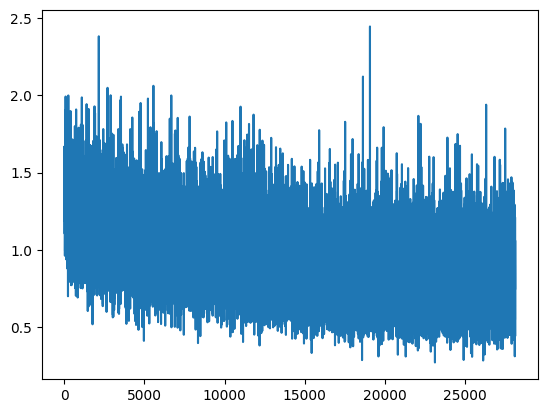

In [25]:
plt.plot(train_losses)

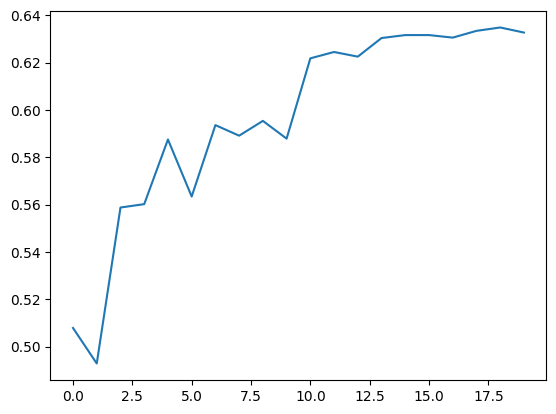

In [26]:
plt.plot(test_accuracy)

In [27]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3539/5600 (0.6320)
{'acc_detail': tensor([0.7364, 0.6700, 0.6571, 0.4643], device='cuda:0'),
 'acc_unweighted': tensor(0.6320, device='cuda:0'),
 'acc_weighted': tensor(0.6320, device='cuda:0'),
 'f1s': tensor(0.6295, device='cuda:0'),
 'f1s_detail': tensor([0.6943, 0.6351, 0.6910, 0.4975], device='cuda:0'),
 'precision_detail': tensor([0.6567, 0.6036, 0.7284, 0.5359], device='cuda:0'),
 'recall_detail': tensor([0.7364, 0.6700, 0.6571, 0.4643], device='cuda:0'),
 'rocauc': tensor([0.9044, 0.8746, 0.8978, 0.7985], device='cuda:0'),
 'uar': tensor(0.6320, device='cuda:0'),
 'wap': tensor(0.6311, device='cuda:0')}


tensor([[1031,   56,   43,  270],
        [  69,  938,  216,  177],
        [  80,  284,  920,  116],
        [ 390,  276,   84,  650]], device='cuda:0')

In [28]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m18_best_19epoch.pt
Correct: 3555/5600 (0.6348)
{'acc_detail': tensor([0.6671, 0.7229, 0.6507, 0.4986], device='cuda:0'),
 'acc_unweighted': tensor(0.6348, device='cuda:0'),
 'acc_weighted': tensor(0.6348, device='cuda:0'),
 'f1s': tensor(0.6345, device='cuda:0'),
 'f1s_detail': tensor([0.6842, 0.6500, 0.6886, 0.5151], device='cuda:0'),
 'precision_detail': tensor([0.7023, 0.5904, 0.7311, 0.5328], device='cuda:0'),
 'recall_detail': tensor([0.6671, 0.7229, 0.6507, 0.4986], device='cuda:0'),
 'rocauc': tensor([0.9050, 0.8754, 0.8984, 0.7977], device='cuda:0'),
 'uar': tensor(0.6348, device='cuda:0'),
 'wap': tensor(0.6392, device='cuda:0')}


tensor([[ 934,   74,   51,  341],
        [  41, 1012,  187,  160],
        [  56,  322,  911,  111],
        [ 299,  306,   97,  698]], device='cuda:0')

In [29]:
checkpoint_path = '../models_esd4/esd4_m18_20epoch.ckpt'
torch.save({
    'epoch': 20,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


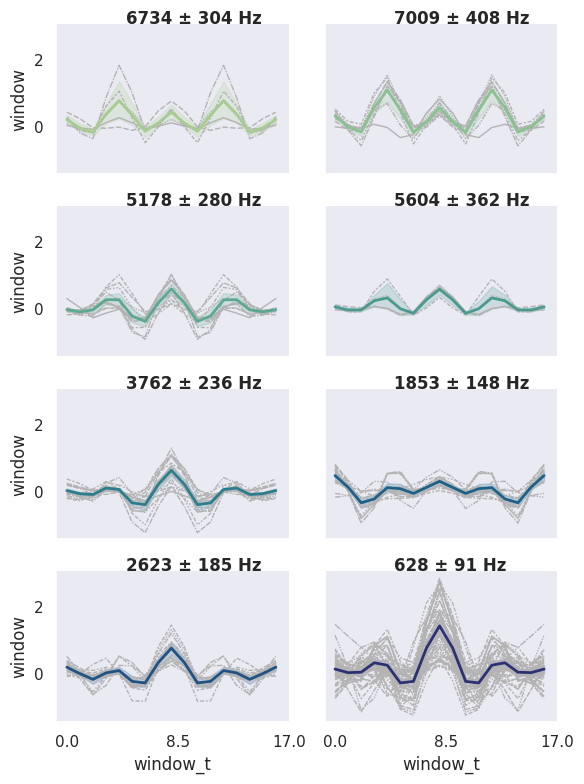

In [31]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


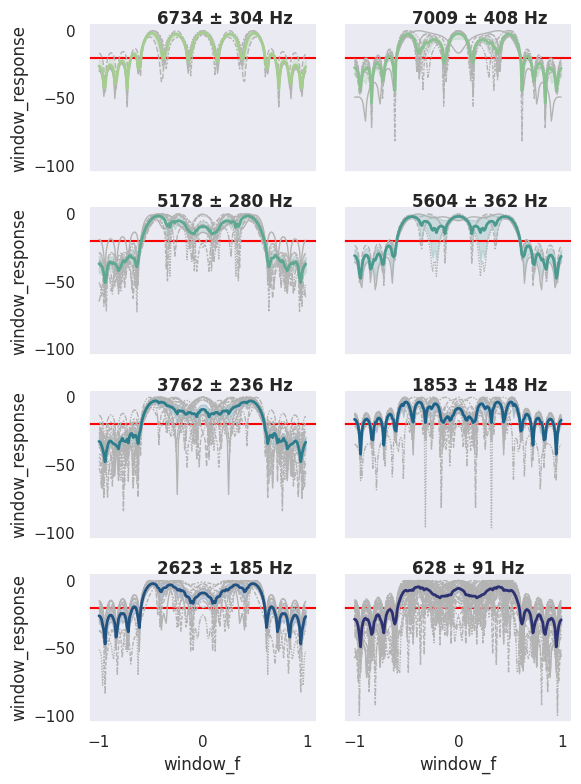

In [32]:
filtviz.visualize_filters(filter_domain='freq')

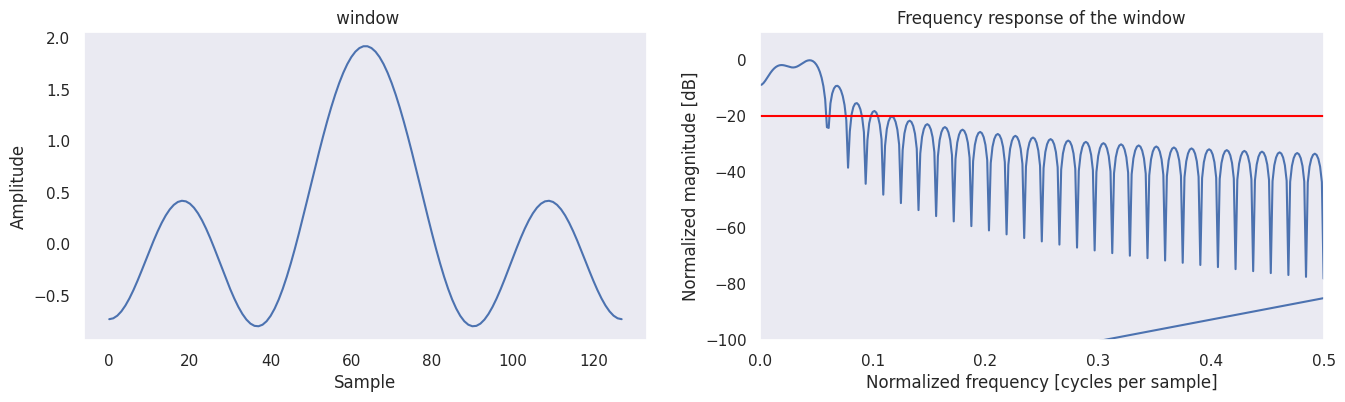

In [33]:
filtviz.visualize_one_window(n_out=10)

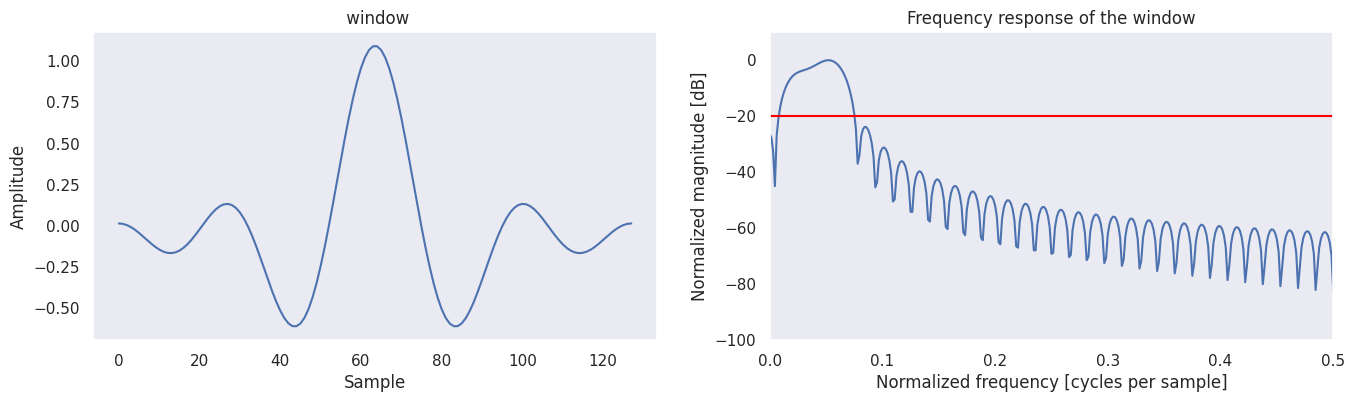

In [34]:
filtviz.visualize_one_window(n_out=30)

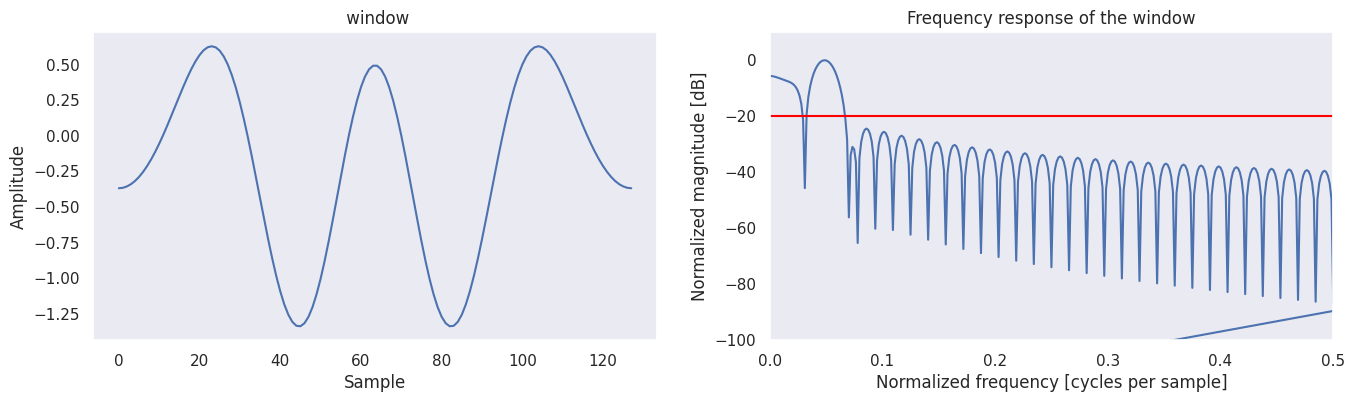

In [35]:
filtviz.visualize_one_window(n_out=50)

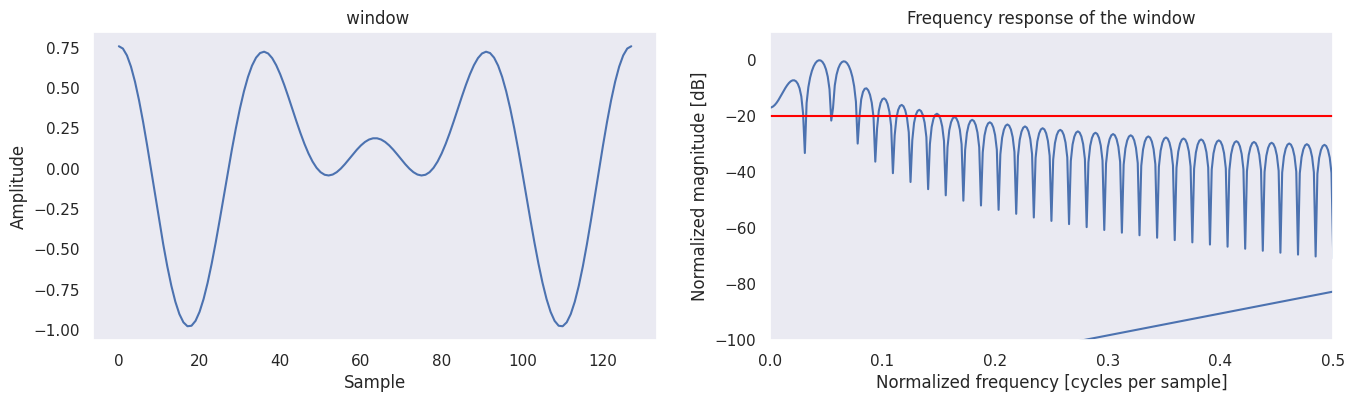

In [36]:
filtviz.visualize_one_window(n_out=60)

In [37]:
n_epoch = 10
n_epoch2 = 10
n_epoch3 = 100

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.0005714285714285715/100 [00:00<30:03:20, 1082.01s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.779681
Mem before-during-after: 37617152 3516183552 43902464


  0%|                                    | 0.023428571428571413/100 [00:19<21:31:51, 775.30s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.794154
Mem before-during-after: 44168704 3521988096 44168704


  0%|                                    | 0.046285714285714215/100 [00:38<20:00:52, 720.86s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.714264
Mem before-during-after: 43928064 3412320256 44504576


  0%|                                     | 0.06914285714285702/100 [00:58<25:17:41, 911.25s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.453966
Mem before-during-after: 44035584 3521897472 43902464


  0%|                                     | 0.09199999999999982/100 [01:17<22:36:58, 814.94s/it]

Train Epoch: 21 [2560/22400 (11%)]	Loss: 0.616767
Mem before-during-after: 44035584 2962840576 43902464


  0%|                                     | 0.11485714285714262/100 [01:35<22:26:39, 808.92s/it]

Train Epoch: 21 [3200/22400 (14%)]	Loss: 0.948196
Mem before-during-after: 43902464 3521764352 43902464


  0%|                                     | 0.13771428571428573/100 [01:51<20:04:56, 723.96s/it]

Train Epoch: 21 [3840/22400 (17%)]	Loss: 1.005617
Mem before-during-after: 44175872 3521632256 43902464


  0%|                                      | 0.1605714285714291/100 [02:10<21:36:49, 779.35s/it]

Train Epoch: 21 [4480/22400 (20%)]	Loss: 0.836670
Mem before-during-after: 44152320 3521928704 44152320


  0%|                                     | 0.18342857142857244/100 [02:28<20:26:43, 737.39s/it]

Train Epoch: 21 [5120/22400 (23%)]	Loss: 1.429131
Mem before-during-after: 43947520 2927909376 44103168


  0%|                                      | 0.2062857142857158/100 [02:47<22:43:33, 819.83s/it]

Train Epoch: 21 [5760/22400 (26%)]	Loss: 0.861552
Mem before-during-after: 43902464 3521631232 44035584


  0%|                                     | 0.22914285714285915/100 [03:07<25:54:50, 935.05s/it]

Train Epoch: 21 [6400/22400 (29%)]	Loss: 1.105539
Mem before-during-after: 44035584 3521764352 44035584


  0%|                                      | 0.2520000000000024/100 [03:25<20:48:21, 750.91s/it]

Train Epoch: 21 [7040/22400 (31%)]	Loss: 0.935513
Mem before-during-after: 43902464 3440713216 44330496


  0%|                                     | 0.27485714285714463/100 [03:44<21:12:13, 765.44s/it]

Train Epoch: 21 [7680/22400 (34%)]	Loss: 1.078510
Mem before-during-after: 43902464 3507503616 43902464


  0%|                                      | 0.2977142857142869/100 [04:04<25:05:29, 906.00s/it]

Train Epoch: 21 [8320/22400 (37%)]	Loss: 0.915885
Mem before-during-after: 44035584 3521897472 43902464


  0%|                                      | 0.3205714285714291/100 [04:24<25:31:33, 921.89s/it]

Train Epoch: 21 [8960/22400 (40%)]	Loss: 0.517862
Mem before-during-after: 44280320 3521875968 44280320


  0%|▏                                    | 0.34342857142857136/100 [04:44<22:38:52, 818.13s/it]

Train Epoch: 21 [9600/22400 (43%)]	Loss: 0.795185
Mem before-during-after: 44035584 3404073472 44249600


  0%|▏                                     | 0.3662857142857136/100 [05:01<21:15:59, 768.41s/it]

Train Epoch: 21 [10240/22400 (46%)]	Loss: 0.743613
Mem before-during-after: 43902464 3522325504 43902464


  0%|▏                                    | 0.38914285714285585/100 [05:20<25:27:37, 920.16s/it]

Train Epoch: 21 [10880/22400 (49%)]	Loss: 0.538222
Mem before-during-after: 44035584 3521897472 43902464


  0%|▏                                     | 0.4119999999999981/100 [05:38<24:14:10, 876.12s/it]

Train Epoch: 21 [11520/22400 (51%)]	Loss: 0.859621
Mem before-during-after: 43902464 3521631232 44035584


  0%|▏                                    | 0.43485714285714033/100 [05:57<25:03:05, 905.79s/it]

Train Epoch: 21 [12160/22400 (54%)]	Loss: 1.076854
Mem before-during-after: 43902464 3521631232 44035584


  0%|▏                                     | 0.4577142857142826/100 [06:16<22:23:19, 809.70s/it]

Train Epoch: 21 [12800/22400 (57%)]	Loss: 0.596749
Mem before-during-after: 43902464 3521828352 43902464


  0%|▏                                     | 0.4805714285714248/100 [06:34<20:36:44, 745.63s/it]

Train Epoch: 21 [13440/22400 (60%)]	Loss: 1.082620
Mem before-during-after: 43902464 3521631232 44035584


  1%|▏                                     | 0.5034285714285671/100 [06:52<23:09:24, 837.86s/it]

Train Epoch: 21 [14080/22400 (63%)]	Loss: 0.487448
Mem before-during-after: 44168704 3521897472 43902464


  1%|▏                                     | 0.5262857142857094/100 [07:11<22:51:23, 827.19s/it]

Train Epoch: 21 [14720/22400 (66%)]	Loss: 0.652006
Mem before-during-after: 44696064 3522216960 43902464


  1%|▏                                     | 0.5491428571428516/100 [07:29<20:44:10, 750.63s/it]

Train Epoch: 21 [15360/22400 (69%)]	Loss: 0.704574
Mem before-during-after: 44035584 3521897472 43902464


  1%|▏                                     | 0.5719999999999938/100 [07:46<22:04:16, 799.14s/it]

Train Epoch: 21 [16000/22400 (71%)]	Loss: 0.880924
Mem before-during-after: 44035584 3307549696 44023296


  1%|▏                                     | 0.5948571428571361/100 [08:03<24:35:00, 890.30s/it]

Train Epoch: 21 [16640/22400 (74%)]	Loss: 0.958200
Mem before-during-after: 44035584 3521764352 44035584


  1%|▏                                     | 0.6177142857142783/100 [08:21<21:49:13, 790.41s/it]

Train Epoch: 21 [17280/22400 (77%)]	Loss: 0.679081
Mem before-during-after: 44168704 3521880064 43902464


  1%|▏                                     | 0.6405714285714206/100 [08:40<20:48:08, 753.71s/it]

Train Epoch: 21 [17920/22400 (80%)]	Loss: 0.901335
Mem before-during-after: 43902464 3521680896 44035584


  1%|▎                                     | 0.6634285714285628/100 [08:58<20:28:53, 742.26s/it]

Train Epoch: 21 [18560/22400 (83%)]	Loss: 0.745592
Mem before-during-after: 43902464 3434067968 44144128


  1%|▎                                     | 0.6862857142857051/100 [09:15<22:02:09, 798.78s/it]

Train Epoch: 21 [19200/22400 (86%)]	Loss: 0.665705
Mem before-during-after: 43902464 3521518592 43902464


  1%|▎                                     | 0.7091428571428473/100 [09:34<23:05:57, 837.51s/it]

Train Epoch: 21 [19840/22400 (89%)]	Loss: 0.808759
Mem before-during-after: 44817920 3522679808 44168704


  1%|▎                                     | 0.7319999999999895/100 [09:53<25:27:01, 922.97s/it]

Train Epoch: 21 [20480/22400 (91%)]	Loss: 0.936498
Mem before-during-after: 43902464 3522328064 43902464


  1%|▎                                     | 0.7548571428571318/100 [10:13<22:33:16, 818.14s/it]

Train Epoch: 21 [21120/22400 (94%)]	Loss: 0.895975
Mem before-during-after: 43902464 3521764352 43902464


  1%|▎                                      | 0.777714285714274/100 [10:33<22:41:13, 823.14s/it]

Train Epoch: 21 [21760/22400 (97%)]	Loss: 1.240189
Mem before-during-after: 44035584 3369267200 43936256


  1%|▍                                     | 0.9999999999999823/100 [12:08<10:32:28, 383.32s/it]


Test Epoch: 21	Accuracy: 3495/5600 (62%)



  1%|▍                                      | 1.000571428571411/100 [12:08<12:39:32, 460.33s/it]

Train Epoch: 22 [0/22400 (0%)]	Loss: 0.845140
Mem before-during-after: 44276224 3522009088 44211200


  1%|▍                                     | 1.0234285714285576/100 [12:24<21:00:30, 764.13s/it]

Train Epoch: 22 [640/22400 (3%)]	Loss: 0.998251
Mem before-during-after: 44249600 3521845248 44249600


  1%|▍                                     | 1.0462857142857043/100 [12:43<20:50:49, 758.43s/it]

Train Epoch: 22 [1280/22400 (6%)]	Loss: 0.566332
Mem before-during-after: 43902464 3521631232 44035584


  1%|▍                                      | 1.069142857142851/100 [12:59<23:46:06, 864.91s/it]

Train Epoch: 22 [1920/22400 (9%)]	Loss: 0.484250
Mem before-during-after: 43902464 3521764352 43902464


  1%|▍                                     | 1.0919999999999976/100 [13:17<20:44:35, 755.00s/it]

Train Epoch: 22 [2560/22400 (11%)]	Loss: 0.598664
Mem before-during-after: 43902464 3521862656 44035584


  1%|▍                                     | 1.1148571428571443/100 [13:36<20:50:48, 758.94s/it]

Train Epoch: 22 [3200/22400 (14%)]	Loss: 1.032858
Mem before-during-after: 44035584 3383456256 44760576


  1%|▍                                      | 1.137714285714291/100 [13:53<20:30:08, 746.58s/it]

Train Epoch: 22 [3840/22400 (17%)]	Loss: 1.050920
Mem before-during-after: 43902464 3522534912 43902464


  1%|▍                                     | 1.1605714285714377/100 [14:12<24:37:12, 896.73s/it]

Train Epoch: 22 [4480/22400 (20%)]	Loss: 0.803705
Mem before-during-after: 44035584 3521897472 43902464


  1%|▍                                     | 1.1834285714285844/100 [14:30<21:04:33, 767.82s/it]

Train Epoch: 22 [5120/22400 (23%)]	Loss: 0.669759
Mem before-during-after: 43902464 3522692096 44035584


  1%|▍                                      | 1.206285714285731/100 [14:50<21:19:09, 776.87s/it]

Train Epoch: 22 [5760/22400 (26%)]	Loss: 0.428193
Mem before-during-after: 44116480 3523307008 44200448


  1%|▍                                     | 1.2291428571428777/100 [15:07<23:57:07, 873.01s/it]

Train Epoch: 22 [6400/22400 (29%)]	Loss: 1.124459
Mem before-during-after: 44168704 3521897472 43902464


  1%|▍                                     | 1.2520000000000244/100 [15:26<21:12:38, 773.27s/it]

Train Epoch: 22 [7040/22400 (31%)]	Loss: 0.687396
Mem before-during-after: 44035584 3521880064 44035584


  1%|▍                                      | 1.274857142857171/100 [15:42<20:49:21, 759.30s/it]

Train Epoch: 22 [7680/22400 (34%)]	Loss: 0.939765
Mem before-during-after: 44035584 3521897472 43902464


  1%|▍                                     | 1.2977142857143178/100 [16:02<25:26:26, 927.91s/it]

Train Epoch: 22 [8320/22400 (37%)]	Loss: 0.841572
Mem before-during-after: 44121600 3521764352 44035584


  1%|▌                                     | 1.3205714285714645/100 [16:23<24:35:05, 896.90s/it]

Train Epoch: 22 [8960/22400 (40%)]	Loss: 0.837852
Mem before-during-after: 43902464 3521631232 44035584


  1%|▌                                     | 1.3434285714286112/100 [16:43<22:49:51, 833.10s/it]

Train Epoch: 22 [9600/22400 (43%)]	Loss: 1.056049
Mem before-during-after: 44035584 3424274944 44035584


  1%|▌                                     | 1.3662857142857578/100 [17:03<24:54:46, 909.29s/it]

Train Epoch: 22 [10240/22400 (46%)]	Loss: 1.192015
Mem before-during-after: 44168704 3521880064 43902464


  1%|▌                                     | 1.3891428571429045/100 [17:24<26:13:15, 957.26s/it]

Train Epoch: 22 [10880/22400 (49%)]	Loss: 0.600077
Mem before-during-after: 44035584 3521897472 43902464


  1%|▌                                     | 1.4120000000000512/100 [17:45<24:29:38, 894.42s/it]

Train Epoch: 22 [11520/22400 (51%)]	Loss: 0.622495
Mem before-during-after: 43902464 3521828352 43902464


  1%|▌                                      | 1.434857142857198/100 [18:05<23:15:36, 849.56s/it]

Train Epoch: 22 [12160/22400 (54%)]	Loss: 1.187530
Mem before-during-after: 44208640 3521804288 43902464


  1%|▌                                     | 1.4577142857143446/100 [18:24<23:58:18, 875.75s/it]

Train Epoch: 22 [12800/22400 (57%)]	Loss: 0.623021
Mem before-during-after: 44035584 3521897472 43902464


  1%|▌                                     | 1.4805714285714913/100 [18:43<25:34:33, 934.57s/it]

Train Epoch: 22 [13440/22400 (60%)]	Loss: 0.716430
Mem before-during-after: 44035584 3521764352 44035584


  2%|▌                                      | 1.503428571428638/100 [19:05<25:57:36, 948.83s/it]

Train Epoch: 22 [14080/22400 (63%)]	Loss: 0.753246
Mem before-during-after: 44035584 3521764352 44035584


  2%|▌                                     | 1.5262857142857846/100 [19:25<25:43:31, 940.47s/it]

Train Epoch: 22 [14720/22400 (66%)]	Loss: 0.617925
Mem before-during-after: 44035584 3521897472 43902464


  2%|▌                                     | 1.5491428571429313/100 [19:45<25:12:02, 921.50s/it]

Train Epoch: 22 [15360/22400 (69%)]	Loss: 0.707512
Mem before-during-after: 44168704 3521988096 44168704


  2%|▌                                      | 1.572000000000078/100 [20:06<25:14:47, 923.39s/it]

Train Epoch: 22 [16000/22400 (71%)]	Loss: 0.691006
Mem before-during-after: 43902464 3521897472 43902464


  2%|▌                                     | 1.5948571428572247/100 [20:27<25:52:48, 946.79s/it]

Train Epoch: 22 [16640/22400 (74%)]	Loss: 0.935359
Mem before-during-after: 44168704 3521897472 44168704


  2%|▌                                     | 1.6177142857143714/100 [20:47<22:30:42, 823.75s/it]

Train Epoch: 22 [17280/22400 (77%)]	Loss: 1.212392
Mem before-during-after: 43902464 3521631232 44035584


  2%|▋                                      | 1.640571428571518/100 [21:07<24:32:57, 898.52s/it]

Train Epoch: 22 [17920/22400 (80%)]	Loss: 0.814879
Mem before-during-after: 43902464 3521631232 44035584


  2%|▋                                     | 1.6634285714286647/100 [21:26<23:02:29, 843.53s/it]

Train Epoch: 22 [18560/22400 (83%)]	Loss: 1.098119
Mem before-during-after: 44269056 3521607168 43902464


  2%|▋                                     | 1.6862857142858114/100 [21:47<25:35:42, 937.23s/it]

Train Epoch: 22 [19200/22400 (86%)]	Loss: 1.166382
Mem before-during-after: 44035584 3521897472 43902464


  2%|▋                                      | 1.709142857142958/100 [22:06<25:47:12, 944.47s/it]

Train Epoch: 22 [19840/22400 (89%)]	Loss: 0.747006
Mem before-during-after: 44168704 3521764352 44168704


  2%|▋                                     | 1.7320000000001048/100 [22:25<21:23:27, 783.65s/it]

Train Epoch: 22 [20480/22400 (91%)]	Loss: 0.544640
Mem before-during-after: 43902464 3521944064 43966464


  2%|▋                                     | 1.7548571428572515/100 [22:45<25:54:29, 949.36s/it]

Train Epoch: 22 [21120/22400 (94%)]	Loss: 0.816420
Mem before-during-after: 43902464 3521631232 44035584


  2%|▋                                     | 1.7777142857143982/100 [23:05<19:13:12, 704.45s/it]

Train Epoch: 22 [21760/22400 (97%)]	Loss: 0.867086
Mem before-during-after: 44168704 3161840128 43902464


  2%|▊                                     | 2.0000000000001497/100 [24:36<10:34:58, 388.76s/it]


Test Epoch: 22	Accuracy: 3535/5600 (63%)



  2%|▊                                      | 2.000571428571578/100 [24:37<12:46:10, 469.09s/it]

Train Epoch: 23 [0/22400 (0%)]	Loss: 0.753564
Mem before-during-after: 44164608 3522461184 44168704


  2%|▊                                      | 2.023428571428716/100 [24:56<23:42:45, 871.29s/it]

Train Epoch: 23 [640/22400 (3%)]	Loss: 0.479999
Mem before-during-after: 44168704 3521631232 43902464


  2%|▊                                     | 2.0462857142858537/100 [25:16<21:27:36, 788.70s/it]

Train Epoch: 23 [1280/22400 (6%)]	Loss: 0.640006
Mem before-during-after: 43902464 3521631232 44035584


  2%|▊                                     | 2.0691428571429915/100 [25:33<20:03:05, 737.10s/it]

Train Epoch: 23 [1920/22400 (9%)]	Loss: 0.800047
Mem before-during-after: 44619264 3522582528 44362240


  2%|▊                                     | 2.0920000000001293/100 [25:53<22:06:29, 812.90s/it]

Train Epoch: 23 [2560/22400 (11%)]	Loss: 0.920522
Mem before-during-after: 43902464 3335694848 43902464


  2%|▊                                      | 2.114857142857267/100 [26:12<19:54:33, 732.22s/it]

Train Epoch: 23 [3200/22400 (14%)]	Loss: 0.554782
Mem before-during-after: 44168704 3521831424 44168704


  2%|▊                                      | 2.137714285714405/100 [26:32<24:49:43, 913.36s/it]

Train Epoch: 23 [3840/22400 (17%)]	Loss: 0.722819
Mem before-during-after: 44035584 3521764352 44035584


  2%|▊                                     | 2.1605714285715427/100 [26:50<21:27:09, 789.35s/it]

Train Epoch: 23 [4480/22400 (20%)]	Loss: 0.656831
Mem before-during-after: 44280320 3521875968 44280320


  2%|▊                                     | 2.1834285714286805/100 [27:07<20:30:54, 755.03s/it]

Train Epoch: 23 [5120/22400 (23%)]	Loss: 0.650260
Mem before-during-after: 44194304 3522549760 44092928


  2%|▊                                     | 2.2062857142858183/100 [27:26<21:39:26, 797.25s/it]

Train Epoch: 23 [5760/22400 (26%)]	Loss: 0.579363
Mem before-during-after: 44035584 3521897472 43902464


  2%|▊                                      | 2.229142857142956/100 [27:44<21:02:50, 774.98s/it]

Train Epoch: 23 [6400/22400 (29%)]	Loss: 0.753617
Mem before-during-after: 44035584 3521764352 44035584


  2%|▉                                      | 2.252000000000094/100 [28:02<19:32:17, 719.58s/it]

Train Epoch: 23 [7040/22400 (31%)]	Loss: 0.652871
Mem before-during-after: 44168704 3238054912 44132352


  2%|▊                                     | 2.2748571428572317/100 [28:20<23:40:57, 872.42s/it]

Train Epoch: 23 [7680/22400 (34%)]	Loss: 0.951728
Mem before-during-after: 44035584 3521897472 43902464


  2%|▊                                     | 2.2977142857143695/100 [28:40<22:29:38, 828.82s/it]

Train Epoch: 23 [8320/22400 (37%)]	Loss: 0.673248
Mem before-during-after: 43902464 3322494464 43981312


  2%|▉                                     | 2.3205714285715073/100 [28:56<19:57:58, 735.86s/it]

Train Epoch: 23 [8960/22400 (40%)]	Loss: 0.707658
Mem before-during-after: 43902464 3522275328 44035584


  2%|▉                                      | 2.343428571428645/100 [29:14<25:38:39, 945.35s/it]

Train Epoch: 23 [9600/22400 (43%)]	Loss: 0.472304
Mem before-during-after: 43902464 3521631232 44035584


  2%|▉                                      | 2.366285714285783/100 [29:34<25:23:27, 936.23s/it]

Train Epoch: 23 [10240/22400 (46%)]	Loss: 0.633709
Mem before-during-after: 44035584 3521897472 43902464


  2%|▉                                     | 2.3891428571429207/100 [29:51<20:26:07, 753.68s/it]

Train Epoch: 23 [10880/22400 (49%)]	Loss: 0.756665
Mem before-during-after: 43902464 3522128896 44035584


  2%|▉                                     | 2.4120000000000585/100 [30:08<20:53:22, 770.61s/it]

Train Epoch: 23 [11520/22400 (51%)]	Loss: 0.696761
Mem before-during-after: 44168704 3522668032 44168704


  2%|▉                                     | 2.4348571428571963/100 [30:23<19:22:30, 714.91s/it]

Train Epoch: 23 [12160/22400 (54%)]	Loss: 1.291614
Mem before-during-after: 43903488 3521502208 43903488


  2%|▉                                      | 2.457714285714334/100 [30:40<20:52:26, 770.40s/it]

Train Epoch: 23 [12800/22400 (57%)]	Loss: 0.559087
Mem before-during-after: 43902464 3441459712 44330496


  2%|▉                                      | 2.480571428571472/100 [30:56<20:49:45, 768.93s/it]

Train Epoch: 23 [13440/22400 (60%)]	Loss: 1.126098
Mem before-during-after: 44035584 3522470912 43902464


  3%|▉                                     | 2.5034285714286098/100 [31:13<25:20:00, 935.42s/it]

Train Epoch: 23 [14080/22400 (63%)]	Loss: 0.915490
Mem before-during-after: 43902464 3521631232 44035584


  3%|▉                                     | 2.5262857142857476/100 [31:33<22:06:28, 816.51s/it]

Train Epoch: 23 [14720/22400 (66%)]	Loss: 0.977739
Mem before-during-after: 43902464 3161692672 43902464


  3%|▉                                     | 2.5491428571428854/100 [31:51<23:23:33, 864.17s/it]

Train Epoch: 23 [15360/22400 (69%)]	Loss: 0.898632
Mem before-during-after: 43902464 3521631232 44035584


  3%|█                                      | 2.572000000000023/100 [32:11<20:32:37, 759.10s/it]

Train Epoch: 23 [16000/22400 (71%)]	Loss: 0.835506
Mem before-during-after: 43902464 3522710528 43902464


  3%|█                                      | 2.594857142857161/100 [32:30<25:17:31, 934.78s/it]

Train Epoch: 23 [16640/22400 (74%)]	Loss: 0.850423
Mem before-during-after: 43902464 3521631232 44035584


  3%|▉                                     | 2.6177142857142988/100 [32:49<22:01:14, 814.06s/it]

Train Epoch: 23 [17280/22400 (77%)]	Loss: 0.473609
Mem before-during-after: 44035584 3521764352 44035584


  3%|█                                     | 2.6405714285714366/100 [33:09<25:46:25, 953.02s/it]

Train Epoch: 23 [17920/22400 (80%)]	Loss: 0.820526
Mem before-during-after: 44035584 3521764352 44035584


  3%|█                                     | 2.6634285714285744/100 [33:27<20:25:42, 755.55s/it]

Train Epoch: 23 [18560/22400 (83%)]	Loss: 0.975503
Mem before-during-after: 43902464 3521567232 43902464


  3%|█                                      | 2.686285714285712/100 [33:43<20:36:32, 762.41s/it]

Train Epoch: 23 [19200/22400 (86%)]	Loss: 0.886147
Mem before-during-after: 43902464 3521631232 44035584


  3%|█                                       | 2.70914285714285/100 [34:02<25:31:13, 944.32s/it]

Train Epoch: 23 [19840/22400 (89%)]	Loss: 0.792358
Mem before-during-after: 44035584 3521897472 43902464


  3%|█                                     | 2.7319999999999878/100 [34:21<25:20:13, 937.76s/it]

Train Epoch: 23 [20480/22400 (91%)]	Loss: 1.035108
Mem before-during-after: 44035584 3521764352 44035584


  3%|█                                     | 2.7548571428571256/100 [34:41<21:44:06, 804.63s/it]

Train Epoch: 23 [21120/22400 (94%)]	Loss: 0.477157
Mem before-during-after: 44035584 3521897472 43902464


  3%|█                                     | 2.7777142857142634/100 [34:57<21:01:18, 778.41s/it]

Train Epoch: 23 [21760/22400 (97%)]	Loss: 0.796050
Mem before-during-after: 43902464 3521897472 43902464


  3%|█▏                                     | 2.9999999999999285/100 [36:30<9:55:42, 368.47s/it]


Test Epoch: 23	Accuracy: 3578/5600 (64%)

saved model: ../models_esd4/esd4_m18_best_23epoch.pt


  3%|█▏                                     | 3.000571428571357/100 [36:31<12:02:25, 446.86s/it]

Train Epoch: 24 [0/22400 (0%)]	Loss: 0.983051
Mem before-during-after: 43898368 3521631232 44035584


  3%|█▏                                    | 3.0234285714284947/100 [36:48<20:16:04, 752.40s/it]

Train Epoch: 24 [640/22400 (3%)]	Loss: 0.978469
Mem before-during-after: 44392960 3523421184 44168704


  3%|█▏                                    | 3.0462857142856326/100 [37:04<20:32:48, 762.93s/it]

Train Epoch: 24 [1280/22400 (6%)]	Loss: 0.614457
Mem before-during-after: 44035584 3522470912 43902464


  3%|█▏                                    | 3.0691428571427704/100 [37:20<19:23:26, 720.17s/it]

Train Epoch: 24 [1920/22400 (9%)]	Loss: 1.086170
Mem before-during-after: 43902464 3218346496 43902464


  3%|█▏                                     | 3.091999999999908/100 [37:37<21:16:35, 790.40s/it]

Train Epoch: 24 [2560/22400 (11%)]	Loss: 0.696122
Mem before-during-after: 43902464 3521567232 43902464


  3%|█▏                                     | 3.114857142857046/100 [37:55<22:07:38, 822.20s/it]

Train Epoch: 24 [3200/22400 (14%)]	Loss: 0.923250
Mem before-during-after: 44168704 3521764352 44168704


  3%|█▏                                    | 3.1377142857141838/100 [38:13<20:50:50, 774.82s/it]

Train Epoch: 24 [3840/22400 (17%)]	Loss: 0.616154
Mem before-during-after: 43902464 3521631232 44035584


  3%|█▏                                    | 3.1605714285713216/100 [38:31<22:21:40, 831.27s/it]

Train Epoch: 24 [4480/22400 (20%)]	Loss: 0.970507
Mem before-during-after: 43902464 3521715712 44168704


  3%|█▏                                    | 3.1834285714284594/100 [38:50<21:22:08, 794.58s/it]

Train Epoch: 24 [5120/22400 (23%)]	Loss: 0.591947
Mem before-during-after: 44363264 3521764864 44035584


  3%|█▎                                     | 3.206285714285597/100 [39:10<21:04:41, 783.95s/it]

Train Epoch: 24 [5760/22400 (26%)]	Loss: 1.174133
Mem before-during-after: 44140032 2976537088 44075008


  3%|█▎                                     | 3.229142857142735/100 [39:26<22:55:15, 852.69s/it]

Train Epoch: 24 [6400/22400 (29%)]	Loss: 1.029155
Mem before-during-after: 44035584 3521764352 44035584


  3%|█▏                                    | 3.2519999999998728/100 [39:45<25:39:11, 954.56s/it]

Train Epoch: 24 [7040/22400 (31%)]	Loss: 0.636057
Mem before-during-after: 44035584 3521764352 44035584


  3%|█▏                                    | 3.2748571428570106/100 [40:06<21:26:23, 797.97s/it]

Train Epoch: 24 [7680/22400 (34%)]	Loss: 0.480226
Mem before-during-after: 44353536 3521883136 44168704


  3%|█▎                                    | 3.2977142857141484/100 [40:25<25:12:07, 938.21s/it]

Train Epoch: 24 [8320/22400 (37%)]	Loss: 0.560495
Mem before-during-after: 43902464 3521631232 44035584


  3%|█▎                                     | 3.320571428571286/100 [40:44<21:35:05, 803.75s/it]

Train Epoch: 24 [8960/22400 (40%)]	Loss: 0.947742
Mem before-during-after: 44232192 3522500096 44232192


  3%|█▎                                     | 3.343428571428424/100 [41:00<19:29:23, 725.90s/it]

Train Epoch: 24 [9600/22400 (43%)]	Loss: 0.763336
Mem before-during-after: 44168704 3521715712 43902464


  3%|█▎                                     | 3.366285714285562/100 [41:20<24:52:41, 926.82s/it]

Train Epoch: 24 [10240/22400 (46%)]	Loss: 1.144234
Mem before-during-after: 43902464 3521631232 44035584


  3%|█▎                                    | 3.3891428571426996/100 [41:38<21:18:05, 793.75s/it]

Train Epoch: 24 [10880/22400 (49%)]	Loss: 0.978573
Mem before-during-after: 44067328 3522209792 44200448


  3%|█▎                                    | 3.4119999999998374/100 [41:54<20:13:35, 753.88s/it]

Train Epoch: 24 [11520/22400 (51%)]	Loss: 1.018649
Mem before-during-after: 44200448 3522373632 44067328


  3%|█▎                                     | 3.434857142856975/100 [42:12<25:52:02, 964.35s/it]

Train Epoch: 24 [12160/22400 (54%)]	Loss: 0.801625
Mem before-during-after: 44035584 3521764352 44035584


  3%|█▎                                     | 3.457714285714113/100 [42:30<19:51:32, 740.53s/it]

Train Epoch: 24 [12800/22400 (57%)]	Loss: 0.827809
Mem before-during-after: 44035584 3521764352 44035584


  3%|█▎                                     | 3.480571428571251/100 [42:49<23:24:40, 873.19s/it]

Train Epoch: 24 [13440/22400 (60%)]	Loss: 0.621175
Mem before-during-after: 44182016 3521944576 43902464


  4%|█▎                                    | 3.5034285714283886/100 [43:10<25:21:37, 946.12s/it]

Train Epoch: 24 [14080/22400 (63%)]	Loss: 0.686503
Mem before-during-after: 44035584 3521764352 44035584


  4%|█▎                                    | 3.5262857142855264/100 [43:28<20:43:58, 773.67s/it]

Train Epoch: 24 [14720/22400 (66%)]	Loss: 0.879855
Mem before-during-after: 44035584 3521764352 44035584


  4%|█▍                                     | 3.549142857142664/100 [43:44<21:31:20, 803.31s/it]

Train Epoch: 24 [15360/22400 (69%)]	Loss: 0.822985
Mem before-during-after: 44035584 3521764352 44035584


  4%|█▍                                     | 3.571999999999802/100 [44:01<19:28:44, 727.22s/it]

Train Epoch: 24 [16000/22400 (71%)]	Loss: 0.888899
Mem before-during-after: 43902464 3521501184 43902464


  4%|█▍                                      | 3.59485714285694/100 [44:19<22:21:25, 834.86s/it]

Train Epoch: 24 [16640/22400 (74%)]	Loss: 1.332436
Mem before-during-after: 43902464 3521828352 43902464


  4%|█▎                                    | 3.6177142857140776/100 [44:35<19:43:20, 736.65s/it]

Train Epoch: 24 [17280/22400 (77%)]	Loss: 0.749711
Mem before-during-after: 44197888 3522718208 44281344


  4%|█▍                                    | 3.6405714285712154/100 [44:52<20:59:34, 784.30s/it]

Train Epoch: 24 [17920/22400 (80%)]	Loss: 0.561301
Mem before-during-after: 43902464 3522013184 44035584


  4%|█▍                                     | 3.663428571428353/100 [45:12<22:25:43, 838.14s/it]

Train Epoch: 24 [18560/22400 (83%)]	Loss: 0.665789
Mem before-during-after: 43902464 3522461184 44035584


  4%|█▍                                     | 3.686285714285491/100 [45:33<24:52:23, 929.71s/it]

Train Epoch: 24 [19200/22400 (86%)]	Loss: 0.733088
Mem before-during-after: 44035584 3521764352 44035584


  4%|█▍                                     | 3.709142857142629/100 [45:52<20:17:10, 758.43s/it]

Train Epoch: 24 [19840/22400 (89%)]	Loss: 0.853706
Mem before-during-after: 44035584 3521796608 44035584


  4%|█▍                                    | 3.7319999999997666/100 [46:08<22:56:48, 858.11s/it]

Train Epoch: 24 [20480/22400 (91%)]	Loss: 0.635053
Mem before-during-after: 44035584 3521897472 43902464


  4%|█▍                                    | 3.7548571428569044/100 [46:25<20:12:23, 755.82s/it]

Train Epoch: 24 [21120/22400 (94%)]	Loss: 0.790342
Mem before-during-after: 43902464 3522286592 44035584


  4%|█▍                                     | 3.777714285714042/100 [46:44<23:31:59, 880.45s/it]

Train Epoch: 24 [21760/22400 (97%)]	Loss: 1.043006
Mem before-during-after: 44035584 3521897472 43902464


  4%|█▌                                     | 3.9999999999997073/100 [48:16<9:49:57, 368.72s/it]


Test Epoch: 24	Accuracy: 3535/5600 (63%)



  4%|█▌                                     | 4.000571428571136/100 [48:16<12:03:07, 451.96s/it]

Train Epoch: 25 [0/22400 (0%)]	Loss: 0.755208
Mem before-during-after: 43898368 3521631232 44035584


  4%|█▌                                     | 4.023428571428291/100 [48:34<21:16:52, 798.24s/it]

Train Epoch: 25 [640/22400 (3%)]	Loss: 0.494328
Mem before-during-after: 44035584 3522264064 43902464


  4%|█▌                                     | 4.046285714285447/100 [48:49<20:01:30, 751.30s/it]

Train Epoch: 25 [1280/22400 (6%)]	Loss: 1.230466
Mem before-during-after: 44200448 3522373632 44067328


  4%|█▌                                    | 4.0691428571426025/100 [49:05<19:57:14, 748.81s/it]

Train Epoch: 25 [1920/22400 (9%)]	Loss: 1.046049
Mem before-during-after: 44035584 3328638976 43902464


  4%|█▌                                     | 4.091999999999758/100 [49:24<20:09:07, 756.43s/it]

Train Epoch: 25 [2560/22400 (11%)]	Loss: 0.783299
Mem before-during-after: 43902464 3521631232 44035584


  4%|█▌                                     | 4.114857142856914/100 [49:40<24:02:20, 902.54s/it]

Train Epoch: 25 [3200/22400 (14%)]	Loss: 0.767735
Mem before-during-after: 43902464 3521897472 43902464


  4%|█▌                                     | 4.137714285714069/100 [49:59<20:04:55, 754.16s/it]

Train Epoch: 25 [3840/22400 (17%)]	Loss: 0.615369
Mem before-during-after: 43902464 3521631232 44035584


  4%|█▌                                     | 4.160571428571225/100 [50:16<20:14:28, 760.32s/it]

Train Epoch: 25 [4480/22400 (20%)]	Loss: 0.797358
Mem before-during-after: 44361216 3522223104 43902464


  4%|█▋                                      | 4.18342857142838/100 [50:34<21:00:38, 789.41s/it]

Train Epoch: 25 [5120/22400 (23%)]	Loss: 1.035807
Mem before-during-after: 43902464 3453499392 43902464


  4%|█▋                                     | 4.206285714285536/100 [50:52<20:39:05, 776.10s/it]

Train Epoch: 25 [5760/22400 (26%)]	Loss: 1.051005
Mem before-during-after: 44035584 3521796608 43902464


  4%|█▌                                    | 4.2291428571426914/100 [51:11<24:57:14, 938.02s/it]

Train Epoch: 25 [6400/22400 (29%)]	Loss: 1.227305
Mem before-during-after: 44035584 3521764352 44035584


  4%|█▋                                     | 4.251999999999847/100 [51:30<17:53:20, 672.61s/it]

Train Epoch: 25 [7040/22400 (31%)]	Loss: 1.113751
Mem before-during-after: 43902464 3523123200 44035584


  4%|█▋                                     | 4.274857142857003/100 [51:46<21:05:14, 793.05s/it]

Train Epoch: 25 [7680/22400 (34%)]	Loss: 1.142720
Mem before-during-after: 43902464 3521854976 43902464


  4%|█▋                                     | 4.297714285714158/100 [52:03<19:17:33, 725.73s/it]

Train Epoch: 25 [8320/22400 (37%)]	Loss: 0.768542
Mem before-during-after: 44035584 2962697216 44853760


  4%|█▋                                     | 4.320571428571314/100 [52:19<20:31:02, 771.98s/it]

Train Epoch: 25 [8960/22400 (40%)]	Loss: 1.351621
Mem before-during-after: 43902464 3521567232 43902464


  4%|█▋                                     | 4.343428571428469/100 [52:35<20:24:57, 768.35s/it]

Train Epoch: 25 [9600/22400 (43%)]	Loss: 1.222428
Mem before-during-after: 44035584 3522470912 43902464


  4%|█▋                                     | 4.366285714285625/100 [52:51<21:22:10, 804.42s/it]

Train Epoch: 25 [10240/22400 (46%)]	Loss: 0.980440
Mem before-during-after: 43902464 3522130944 43902464


  4%|█▊                                      | 4.38914285714278/100 [53:08<21:44:21, 818.54s/it]

Train Epoch: 25 [10880/22400 (49%)]	Loss: 0.832604
Mem before-during-after: 44035584 3521897472 43902464


  4%|█▋                                     | 4.411999999999936/100 [53:28<22:21:42, 842.18s/it]

Train Epoch: 25 [11520/22400 (51%)]	Loss: 0.665195
Mem before-during-after: 43902464 3424529920 43902464


  4%|█▋                                    | 4.4348571428570915/100 [53:47<19:48:49, 746.39s/it]

Train Epoch: 25 [12160/22400 (54%)]	Loss: 0.713012
Mem before-during-after: 44032512 3521631232 43902464


  4%|█▋                                     | 4.457714285714247/100 [54:06<22:03:14, 830.99s/it]

Train Epoch: 25 [12800/22400 (57%)]	Loss: 0.931244
Mem before-during-after: 44168704 3522595840 44168704


  4%|█▋                                     | 4.480571428571403/100 [54:24<19:38:10, 740.07s/it]

Train Epoch: 25 [13440/22400 (60%)]	Loss: 0.806648
Mem before-during-after: 44035584 3521796608 44035584


  5%|█▊                                     | 4.503428571428558/100 [54:40<20:02:11, 755.33s/it]

Train Epoch: 25 [14080/22400 (63%)]	Loss: 0.932144
Mem before-during-after: 43902464 3522401792 44035584


  5%|█▊                                     | 4.526285714285714/100 [54:58<19:43:52, 744.00s/it]

Train Epoch: 25 [14720/22400 (66%)]	Loss: 0.720135
Mem before-during-after: 44168704 3522254336 43902464


  5%|█▊                                     | 4.549142857142869/100 [55:18<20:51:45, 786.85s/it]

Train Epoch: 25 [15360/22400 (69%)]	Loss: 0.645057
Mem before-during-after: 43902464 3521828352 44168704


  5%|█▊                                     | 4.572000000000025/100 [55:38<25:16:06, 953.24s/it]

Train Epoch: 25 [16000/22400 (71%)]	Loss: 0.779985
Mem before-during-after: 43902464 3521631232 44035584


  5%|█▋                                    | 4.5948571428571805/100 [55:58<20:48:16, 785.03s/it]

Train Epoch: 25 [16640/22400 (74%)]	Loss: 1.015668
Mem before-during-after: 44168704 3397789184 43902464


  5%|█▊                                     | 4.617714285714336/100 [56:18<24:29:28, 924.36s/it]

Train Epoch: 25 [17280/22400 (77%)]	Loss: 0.748573
Mem before-during-after: 44035584 3521764352 44035584


  5%|█▊                                     | 4.640571428571492/100 [56:37<24:40:22, 931.45s/it]

Train Epoch: 25 [17920/22400 (80%)]	Loss: 0.638338
Mem before-during-after: 43902464 3521631232 44035584


  5%|█▊                                     | 4.663428571428647/100 [56:58<25:21:48, 957.74s/it]

Train Epoch: 25 [18560/22400 (83%)]	Loss: 0.734884
Mem before-during-after: 44035584 3521764352 44035584


  5%|█▊                                     | 4.686285714285803/100 [57:18<22:14:17, 839.94s/it]

Train Epoch: 25 [19200/22400 (86%)]	Loss: 0.986760
Mem before-during-after: 44232192 3521764352 44168704


  5%|█▊                                     | 4.709142857142958/100 [57:38<21:23:35, 808.21s/it]

Train Epoch: 25 [19840/22400 (89%)]	Loss: 1.012179
Mem before-during-after: 44498432 3522227200 44168704


  5%|█▊                                     | 4.732000000000114/100 [57:57<21:48:58, 824.39s/it]

Train Epoch: 25 [20480/22400 (91%)]	Loss: 1.183496
Mem before-during-after: 43902464 3521631232 43902464


  5%|█▊                                    | 4.7548571428572695/100 [58:16<20:36:18, 778.82s/it]

Train Epoch: 25 [21120/22400 (94%)]	Loss: 0.996043
Mem before-during-after: 43902464 3521565184 43902464


  5%|█▊                                     | 4.777714285714425/100 [58:32<20:56:07, 791.49s/it]

Train Epoch: 25 [21760/22400 (97%)]	Loss: 0.768872
Mem before-during-after: 43902464 3521631232 44035584


  5%|█▉                                    | 5.000000000000263/100 [1:00:03<9:54:04, 375.20s/it]


Test Epoch: 25	Accuracy: 3576/5600 (64%)



  5%|█▊                                   | 5.000571428571692/100 [1:00:04<11:51:44, 449.52s/it]

Train Epoch: 26 [0/22400 (0%)]	Loss: 1.530641
Mem before-during-after: 43898368 3521631232 44035584


  5%|█▊                                   | 5.023428571428847/100 [1:00:24<21:34:05, 817.52s/it]

Train Epoch: 26 [640/22400 (3%)]	Loss: 0.950906
Mem before-during-after: 44035584 3134958080 44324352


  5%|█▊                                   | 5.046285714286003/100 [1:00:44<25:18:18, 959.40s/it]

Train Epoch: 26 [1280/22400 (6%)]	Loss: 0.960340
Mem before-during-after: 44035584 3521897472 43902464


  5%|█▊                                  | 5.0691428571431585/100 [1:01:05<23:53:41, 906.15s/it]

Train Epoch: 26 [1920/22400 (9%)]	Loss: 0.632124
Mem before-during-after: 44035584 3521897472 43902464


  5%|█▉                                   | 5.092000000000314/100 [1:01:24<24:43:59, 938.17s/it]

Train Epoch: 26 [2560/22400 (11%)]	Loss: 0.843923
Mem before-during-after: 44035584 3521897472 43902464


  5%|█▉                                    | 5.11485714285747/100 [1:01:45<24:56:56, 946.58s/it]

Train Epoch: 26 [3200/22400 (14%)]	Loss: 1.041805
Mem before-during-after: 44035584 3521764352 44035584


  5%|█▉                                   | 5.137714285714625/100 [1:02:03<18:24:44, 698.75s/it]

Train Epoch: 26 [3840/22400 (17%)]	Loss: 1.034954
Mem before-during-after: 43902464 3521449472 43902464


  5%|█▉                                   | 5.160571428571781/100 [1:02:21<20:41:59, 785.74s/it]

Train Epoch: 26 [4480/22400 (20%)]	Loss: 0.631587
Mem before-during-after: 43902464 3522545664 43902464


  5%|█▉                                   | 5.183428571428936/100 [1:02:37<19:58:28, 758.39s/it]

Train Epoch: 26 [5120/22400 (23%)]	Loss: 0.587676
Mem before-during-after: 44168704 3521928704 44168704


  5%|█▉                                   | 5.206285714286092/100 [1:02:56<21:43:10, 824.85s/it]

Train Epoch: 26 [5760/22400 (26%)]	Loss: 0.768151
Mem before-during-after: 44063232 3521974272 43902464


  5%|█▉                                  | 5.2291428571432474/100 [1:03:13<21:40:39, 823.45s/it]

Train Epoch: 26 [6400/22400 (29%)]	Loss: 0.859650
Mem before-during-after: 44035584 3521897472 43902464


  5%|█▉                                   | 5.252000000000403/100 [1:03:31<18:30:26, 703.20s/it]

Train Epoch: 26 [7040/22400 (31%)]	Loss: 0.953866
Mem before-during-after: 43902464 3522493952 44035584


  5%|█▉                                   | 5.274857142857559/100 [1:03:48<20:43:44, 787.81s/it]

Train Epoch: 26 [7680/22400 (34%)]	Loss: 0.960721
Mem before-during-after: 44035584 3265507328 43902464


  5%|█▉                                   | 5.297714285714714/100 [1:04:04<19:58:57, 759.62s/it]

Train Epoch: 26 [8320/22400 (37%)]	Loss: 0.540938
Mem before-during-after: 44035584 3521897472 43902464


  5%|██                                    | 5.32057142857187/100 [1:04:20<19:46:32, 751.93s/it]

Train Epoch: 26 [8960/22400 (40%)]	Loss: 0.711822
Mem before-during-after: 44035584 3522500096 44035584


  5%|█▉                                   | 5.343428571429025/100 [1:04:40<22:01:50, 837.88s/it]

Train Epoch: 26 [9600/22400 (43%)]	Loss: 0.766879
Mem before-during-after: 44168704 3521897472 43902464


  5%|█▉                                   | 5.366285714286181/100 [1:04:57<24:26:55, 930.06s/it]

Train Epoch: 26 [10240/22400 (46%)]	Loss: 1.456437
Mem before-during-after: 44035584 3521897472 43902464


  5%|█▉                                   | 5.389142857143336/100 [1:05:16<19:57:15, 759.27s/it]

Train Epoch: 26 [10880/22400 (49%)]	Loss: 0.676665
Mem before-during-after: 44035584 3521897472 43902464


  5%|██                                   | 5.412000000000492/100 [1:05:33<21:45:06, 827.87s/it]

Train Epoch: 26 [11520/22400 (51%)]	Loss: 0.620845
Mem before-during-after: 43928064 3521789952 43928064


  5%|█▉                                  | 5.4348571428576475/100 [1:05:50<20:47:59, 791.84s/it]

Train Epoch: 26 [12160/22400 (54%)]	Loss: 0.609041
Mem before-during-after: 43902464 3522461184 43902464


  5%|██                                   | 5.457714285714803/100 [1:06:05<18:56:09, 721.05s/it]

Train Epoch: 26 [12800/22400 (57%)]	Loss: 0.757643
Mem before-during-after: 44410368 3522090496 43902464


  5%|██                                   | 5.480571428571959/100 [1:06:26<22:56:14, 873.62s/it]

Train Epoch: 26 [13440/22400 (60%)]	Loss: 0.794867
Mem before-during-after: 43919872 3521914880 44052992


  6%|██                                   | 5.503428571429114/100 [1:06:44<19:45:42, 752.86s/it]

Train Epoch: 26 [14080/22400 (63%)]	Loss: 0.686261
Mem before-during-after: 43902464 3521854976 43902464


  6%|██                                    | 5.52628571428627/100 [1:07:01<22:52:38, 871.77s/it]

Train Epoch: 26 [14720/22400 (66%)]	Loss: 1.033109
Mem before-during-after: 43902464 3522445312 43902464


  6%|██                                   | 5.549142857143425/100 [1:07:21<24:48:26, 945.54s/it]

Train Epoch: 26 [15360/22400 (69%)]	Loss: 1.001551
Mem before-during-after: 44035584 3521764352 44035584


  6%|██                                   | 5.572000000000581/100 [1:07:41<25:55:22, 988.29s/it]

Train Epoch: 26 [16000/22400 (71%)]	Loss: 0.740943
Mem before-during-after: 44035584 3521897472 43902464


  6%|██                                  | 5.5948571428577365/100 [1:08:01<19:52:13, 757.73s/it]

Train Epoch: 26 [16640/22400 (74%)]	Loss: 0.714826
Mem before-during-after: 44132352 3521812480 43902464


  6%|██                                   | 5.617714285714892/100 [1:08:17<22:42:17, 866.03s/it]

Train Epoch: 26 [17280/22400 (77%)]	Loss: 0.698233
Mem before-during-after: 43902464 3521828352 43902464


  6%|██                                   | 5.640571428572048/100 [1:08:34<24:01:34, 916.65s/it]

Train Epoch: 26 [17920/22400 (80%)]	Loss: 0.548420
Mem before-during-after: 43902464 3521631232 44035584


  6%|██                                   | 5.663428571429203/100 [1:08:55<23:56:23, 913.58s/it]

Train Epoch: 26 [18560/22400 (83%)]	Loss: 0.711381
Mem before-during-after: 44035584 3521897472 43902464


  6%|██                                   | 5.686285714286359/100 [1:09:13<19:53:16, 759.13s/it]

Train Epoch: 26 [19200/22400 (86%)]	Loss: 0.972049
Mem before-during-after: 43902464 3521631232 44035584


  6%|██                                   | 5.709142857143514/100 [1:09:30<24:04:37, 919.25s/it]

Train Epoch: 26 [19840/22400 (89%)]	Loss: 1.009725
Mem before-during-after: 43902464 3521897472 43902464


  6%|██▏                                   | 5.73200000000067/100 [1:09:49<22:59:41, 878.15s/it]

Train Epoch: 26 [20480/22400 (91%)]	Loss: 0.673920
Mem before-during-after: 44168704 3521897472 43902464


  6%|██                                  | 5.7548571428578255/100 [1:10:09<20:21:52, 777.89s/it]

Train Epoch: 26 [21120/22400 (94%)]	Loss: 0.669239
Mem before-during-after: 43902464 3521565184 43902464


  6%|██▏                                  | 5.777714285714981/100 [1:10:25<18:46:45, 717.51s/it]

Train Epoch: 26 [21760/22400 (97%)]	Loss: 0.997725
Mem before-during-after: 43902464 3521698304 44035584


  6%|██▎                                   | 6.000000000000819/100 [1:11:59<9:49:19, 376.17s/it]


Test Epoch: 26	Accuracy: 3611/5600 (64%)

saved model: ../models_esd4/esd4_m18_best_26epoch.pt


  6%|██▏                                  | 6.000571428572248/100 [1:12:00<11:49:45, 453.04s/it]

Train Epoch: 27 [0/22400 (0%)]	Loss: 0.817268
Mem before-during-after: 43898368 3521631232 44035584


  6%|██▏                                  | 6.023428571429403/100 [1:12:18<20:14:00, 775.09s/it]

Train Epoch: 27 [640/22400 (3%)]	Loss: 0.848966
Mem before-during-after: 43902464 3521897472 43902464


  6%|██▏                                  | 6.046285714286559/100 [1:12:36<19:16:03, 738.27s/it]

Train Epoch: 27 [1280/22400 (6%)]	Loss: 0.943043
Mem before-during-after: 44363264 3278473728 44469760


  6%|██▏                                 | 6.0691428571437145/100 [1:12:55<24:23:24, 934.77s/it]

Train Epoch: 27 [1920/22400 (9%)]	Loss: 1.322104
Mem before-during-after: 44035584 3521897472 43902464


  6%|██▎                                   | 6.09200000000087/100 [1:13:13<20:46:19, 796.31s/it]

Train Epoch: 27 [2560/22400 (11%)]	Loss: 0.616566
Mem before-during-after: 44410368 3522411520 43902464


  6%|██▎                                  | 6.114857142858026/100 [1:13:32<23:26:49, 899.07s/it]

Train Epoch: 27 [3200/22400 (14%)]	Loss: 0.680644
Mem before-during-after: 43902464 3481549312 44428800


  6%|██▎                                  | 6.137714285715181/100 [1:13:52<23:46:05, 911.60s/it]

Train Epoch: 27 [3840/22400 (17%)]	Loss: 0.665487
Mem before-during-after: 44035584 3521897472 43902464


  6%|██▎                                  | 6.160571428572337/100 [1:14:12<23:09:14, 888.27s/it]

Train Epoch: 27 [4480/22400 (20%)]	Loss: 0.965298
Mem before-during-after: 43902464 3521854976 43902464


  6%|██▎                                  | 6.183428571429492/100 [1:14:30<20:00:43, 767.92s/it]

Train Epoch: 27 [5120/22400 (23%)]	Loss: 0.724490
Mem before-during-after: 44361216 3523022336 43902464


  6%|██▎                                  | 6.206285714286648/100 [1:14:51<22:27:02, 861.71s/it]

Train Epoch: 27 [5760/22400 (26%)]	Loss: 0.839133
Mem before-during-after: 43902464 3522401792 44168704


  6%|██▏                                 | 6.2291428571438034/100 [1:15:12<21:44:09, 834.48s/it]

Train Epoch: 27 [6400/22400 (29%)]	Loss: 0.712840
Mem before-during-after: 44035584 3362765824 44269056


  6%|██▎                                  | 6.252000000000959/100 [1:15:31<23:49:56, 915.19s/it]

Train Epoch: 27 [7040/22400 (31%)]	Loss: 1.425221
Mem before-during-after: 43902464 3521631232 44035584


  6%|██▎                                  | 6.274857142858115/100 [1:15:52<24:01:53, 923.06s/it]

Train Epoch: 27 [7680/22400 (34%)]	Loss: 0.971500
Mem before-during-after: 43902464 3521631232 44035584


  6%|██▍                                   | 6.29771428571527/100 [1:16:13<21:35:33, 829.57s/it]

Train Epoch: 27 [8320/22400 (37%)]	Loss: 0.822628
Mem before-during-after: 44168704 3522461184 44168704


  6%|██▎                                  | 6.320571428572426/100 [1:16:32<23:46:16, 913.51s/it]

Train Epoch: 27 [8960/22400 (40%)]	Loss: 0.791050
Mem before-during-after: 44035584 3521764352 44035584


  6%|██▎                                  | 6.343428571429581/100 [1:16:53<24:52:28, 956.14s/it]

Train Epoch: 27 [9600/22400 (43%)]	Loss: 0.570484
Mem before-during-after: 43902464 3521631232 44035584


  6%|██▎                                  | 6.366285714286737/100 [1:17:14<22:11:20, 853.12s/it]

Train Epoch: 27 [10240/22400 (46%)]	Loss: 1.266811
Mem before-during-after: 43902464 3521631232 44035584


  6%|██▎                                  | 6.389142857143892/100 [1:17:33<22:34:27, 868.14s/it]

Train Epoch: 27 [10880/22400 (49%)]	Loss: 0.837139
Mem before-during-after: 43983872 3521648640 43902464


  6%|██▎                                  | 6.412000000001048/100 [1:17:52<23:13:56, 893.67s/it]

Train Epoch: 27 [11520/22400 (51%)]	Loss: 0.549589
Mem before-during-after: 43902464 3521828352 43902464


  6%|██▎                                 | 6.4348571428582035/100 [1:18:13<24:25:09, 939.55s/it]

Train Epoch: 27 [12160/22400 (54%)]	Loss: 0.984981
Mem before-during-after: 43902464 3521631232 44035584


  6%|██▍                                  | 6.457714285715359/100 [1:18:33<20:37:24, 793.70s/it]

Train Epoch: 27 [12800/22400 (57%)]	Loss: 0.883354
Mem before-during-after: 43902464 3468816384 44640768


  6%|██▍                                  | 6.480571428572515/100 [1:18:54<24:34:32, 946.03s/it]

Train Epoch: 27 [13440/22400 (60%)]	Loss: 0.555869
Mem before-during-after: 43902464 3522461184 43902464


  7%|██▍                                   | 6.50342857142967/100 [1:19:14<21:34:41, 830.85s/it]

Train Epoch: 27 [14080/22400 (63%)]	Loss: 0.821560
Mem before-during-after: 43902464 3522461184 44035584


  7%|██▍                                  | 6.526285714286826/100 [1:19:35<21:41:43, 835.57s/it]

Train Epoch: 27 [14720/22400 (66%)]	Loss: 0.934656
Mem before-during-after: 43902464 3071884288 43974144


  7%|██▍                                  | 6.549142857143981/100 [1:19:55<23:54:13, 920.84s/it]

Train Epoch: 27 [15360/22400 (69%)]	Loss: 0.556029
Mem before-during-after: 43902464 3521631232 44035584


  7%|██▍                                  | 6.572000000001137/100 [1:20:15<24:21:44, 938.74s/it]

Train Epoch: 27 [16000/22400 (71%)]	Loss: 0.872842
Mem before-during-after: 43902464 3521631232 44035584


  7%|██▎                                 | 6.5948571428582925/100 [1:20:35<21:51:42, 842.59s/it]

Train Epoch: 27 [16640/22400 (74%)]	Loss: 0.922280
Mem before-during-after: 43902464 3521567232 43902464


  7%|██▍                                  | 6.617714285715448/100 [1:20:55<24:13:47, 934.09s/it]

Train Epoch: 27 [17280/22400 (77%)]	Loss: 0.929127
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▍                                  | 6.640571428572604/100 [1:21:15<20:35:17, 793.90s/it]

Train Epoch: 27 [17920/22400 (80%)]	Loss: 0.887942
Mem before-during-after: 43902464 3398159872 43933184


  7%|██▍                                  | 6.663428571429759/100 [1:21:35<24:04:23, 928.51s/it]

Train Epoch: 27 [18560/22400 (83%)]	Loss: 1.183250
Mem before-during-after: 43902464 3522111488 44347904


  7%|██▍                                  | 6.686285714286915/100 [1:21:55<23:44:31, 915.95s/it]

Train Epoch: 27 [19200/22400 (86%)]	Loss: 0.659882
Mem before-during-after: 43902464 3521764352 43902464


  7%|██▌                                   | 6.70914285714407/100 [1:22:14<24:02:22, 927.66s/it]

Train Epoch: 27 [19840/22400 (89%)]	Loss: 0.942729
Mem before-during-after: 44035584 3521897472 43902464


  7%|██▍                                  | 6.732000000001226/100 [1:22:34<22:47:23, 879.66s/it]

Train Epoch: 27 [20480/22400 (91%)]	Loss: 0.675241
Mem before-during-after: 44116480 3521746944 43902464


  7%|██▍                                 | 6.7548571428583815/100 [1:22:54<20:35:27, 794.97s/it]

Train Epoch: 27 [21120/22400 (94%)]	Loss: 1.054932
Mem before-during-after: 43902464 2823809024 43902464


  7%|██▌                                  | 6.777714285715537/100 [1:23:13<22:46:13, 879.33s/it]

Train Epoch: 27 [21760/22400 (97%)]	Loss: 0.778363
Mem before-during-after: 44036608 3521632256 43902464


  7%|██▌                                  | 7.000000000001375/100 [1:24:47<11:11:01, 432.92s/it]


Test Epoch: 27	Accuracy: 3607/5600 (64%)



  7%|██▌                                  | 7.000571428572804/100 [1:24:47<12:48:29, 495.80s/it]

Train Epoch: 28 [0/22400 (0%)]	Loss: 0.819022
Mem before-during-after: 43898368 3521631232 44035584


  7%|██▌                                  | 7.023428571429959/100 [1:25:07<24:12:39, 937.43s/it]

Train Epoch: 28 [640/22400 (3%)]	Loss: 0.845330
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▌                                  | 7.046285714287115/100 [1:25:25<20:29:07, 793.38s/it]

Train Epoch: 28 [1280/22400 (6%)]	Loss: 0.836755
Mem before-during-after: 43902464 3321077248 43902464


  7%|██▌                                 | 7.0691428571442705/100 [1:25:41<20:12:14, 782.67s/it]

Train Epoch: 28 [1920/22400 (9%)]	Loss: 0.889130
Mem before-during-after: 43902464 3521631232 44035584


  7%|██▌                                  | 7.092000000001426/100 [1:25:59<21:35:17, 836.50s/it]

Train Epoch: 28 [2560/22400 (11%)]	Loss: 0.911927
Mem before-during-after: 43902464 3521631232 43902464


  7%|██▋                                  | 7.114857142858582/100 [1:26:18<24:15:54, 940.45s/it]

Train Epoch: 28 [3200/22400 (14%)]	Loss: 0.623373
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▋                                  | 7.137714285715737/100 [1:26:37<21:20:05, 827.09s/it]

Train Epoch: 28 [3840/22400 (17%)]	Loss: 0.650363
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▋                                  | 7.160571428572893/100 [1:26:55<19:41:19, 763.47s/it]

Train Epoch: 28 [4480/22400 (20%)]	Loss: 1.124511
Mem before-during-after: 45124096 3522662912 43902464


  7%|██▋                                  | 7.183428571430048/100 [1:27:14<21:00:54, 815.10s/it]

Train Epoch: 28 [5120/22400 (23%)]	Loss: 1.111681
Mem before-during-after: 43902464 3521978368 44035584


  7%|██▋                                  | 7.206285714287204/100 [1:27:31<23:07:31, 897.17s/it]

Train Epoch: 28 [5760/22400 (26%)]	Loss: 0.895024
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▌                                 | 7.2291428571443594/100 [1:27:50<19:28:53, 755.99s/it]

Train Epoch: 28 [6400/22400 (29%)]	Loss: 0.879766
Mem before-during-after: 44035584 3521764352 44035584


  7%|██▋                                  | 7.252000000001515/100 [1:28:10<24:12:42, 939.77s/it]

Train Epoch: 28 [7040/22400 (31%)]	Loss: 0.892243
Mem before-during-after: 43902464 3521631232 44035584


  7%|██▋                                  | 7.274857142858671/100 [1:28:27<17:49:57, 692.34s/it]

Train Epoch: 28 [7680/22400 (34%)]	Loss: 0.816791
Mem before-during-after: 44128256 3523753472 43902464


  7%|██▋                                  | 7.297714285715826/100 [1:28:46<19:03:50, 740.33s/it]

Train Epoch: 28 [8320/22400 (37%)]	Loss: 1.082586
Mem before-during-after: 44410368 3522206208 43902464


  7%|██▋                                  | 7.320571428572982/100 [1:29:02<19:12:29, 746.12s/it]

Train Epoch: 28 [8960/22400 (40%)]	Loss: 1.241159
Mem before-during-after: 44067328 3522209792 44200448


  7%|██▋                                  | 7.343428571430137/100 [1:29:21<24:18:52, 944.70s/it]

Train Epoch: 28 [9600/22400 (43%)]	Loss: 0.909869
Mem before-during-after: 44035584 3521897472 43902464


  7%|██▋                                  | 7.366285714287293/100 [1:29:41<22:57:30, 892.23s/it]

Train Epoch: 28 [10240/22400 (46%)]	Loss: 0.818414
Mem before-during-after: 43902464 3521631232 44035584


  7%|██▋                                  | 7.389142857144448/100 [1:30:01<19:56:12, 774.99s/it]

Train Epoch: 28 [10880/22400 (49%)]	Loss: 0.553420
Mem before-during-after: 44035584 3521831424 44035584


  7%|██▋                                  | 7.412000000001604/100 [1:30:19<22:35:55, 878.68s/it]

Train Epoch: 28 [11520/22400 (51%)]	Loss: 0.879277
Mem before-during-after: 44249600 3521845248 44249600


  7%|██▋                                 | 7.4348571428587595/100 [1:30:38<22:15:43, 865.80s/it]

Train Epoch: 28 [12160/22400 (54%)]	Loss: 0.830842
Mem before-during-after: 43902464 3521631232 43902464


  7%|██▊                                  | 7.457714285715915/100 [1:30:58<21:16:40, 827.74s/it]

Train Epoch: 28 [12800/22400 (57%)]	Loss: 0.658801
Mem before-during-after: 43902464 3521498112 43902464


  7%|██▊                                  | 7.480571428573071/100 [1:31:19<24:31:31, 954.31s/it]

Train Epoch: 28 [13440/22400 (60%)]	Loss: 0.682458
Mem before-during-after: 44035584 3521897472 43902464


  8%|██▊                                  | 7.503428571430226/100 [1:31:39<20:52:29, 812.46s/it]

Train Epoch: 28 [14080/22400 (63%)]	Loss: 0.667195
Mem before-during-after: 43902464 3521764352 43902464


  8%|██▊                                  | 7.526285714287382/100 [1:31:59<22:41:09, 883.16s/it]

Train Epoch: 28 [14720/22400 (66%)]	Loss: 0.817319
Mem before-during-after: 44035584 3155222528 44173824


  8%|██▊                                  | 7.549142857144537/100 [1:32:19<24:19:34, 947.25s/it]

Train Epoch: 28 [15360/22400 (69%)]	Loss: 0.791905
Mem before-during-after: 44035584 3521897472 43902464


  8%|██▊                                  | 7.572000000001693/100 [1:32:40<24:00:16, 934.96s/it]

Train Epoch: 28 [16000/22400 (71%)]	Loss: 0.911065
Mem before-during-after: 43902464 3521631232 44035584


  8%|██▋                                 | 7.5948571428588485/100 [1:32:58<20:50:15, 811.81s/it]

Train Epoch: 28 [16640/22400 (74%)]	Loss: 0.960611
Mem before-during-after: 44168704 3521897472 43902464


  8%|██▊                                  | 7.617714285716004/100 [1:33:15<20:44:35, 808.34s/it]

Train Epoch: 28 [17280/22400 (77%)]	Loss: 0.935929
Mem before-during-after: 44035584 3521897472 43902464


  8%|██▉                                   | 7.64057142857316/100 [1:33:33<23:07:29, 901.37s/it]

Train Epoch: 28 [17920/22400 (80%)]	Loss: 0.980218
Mem before-during-after: 43902464 3521631232 44035584


  8%|██▊                                  | 7.663428571430315/100 [1:33:55<21:49:34, 850.96s/it]

Train Epoch: 28 [18560/22400 (83%)]	Loss: 0.644679
Mem before-during-after: 43902464 3306830848 44023296


  8%|██▊                                  | 7.686285714287471/100 [1:34:16<22:35:41, 881.14s/it]

Train Epoch: 28 [19200/22400 (86%)]	Loss: 0.749268
Mem before-during-after: 43902464 3521828352 43902464


  8%|██▊                                  | 7.709142857144626/100 [1:34:35<21:31:22, 839.55s/it]

Train Epoch: 28 [19840/22400 (89%)]	Loss: 0.857454
Mem before-during-after: 44168704 3521764352 44168704


  8%|██▊                                  | 7.732000000001782/100 [1:34:56<24:30:39, 956.34s/it]

Train Epoch: 28 [20480/22400 (91%)]	Loss: 0.853397
Mem before-during-after: 44035584 3521764352 44035584


  8%|██▊                                 | 7.7548571428589375/100 [1:35:16<24:05:12, 940.02s/it]

Train Epoch: 28 [21120/22400 (94%)]	Loss: 0.747064
Mem before-during-after: 44035584 3521764352 44035584


  8%|██▉                                  | 7.777714285716093/100 [1:35:36<23:26:31, 915.09s/it]

Train Epoch: 28 [21760/22400 (97%)]	Loss: 0.570185
Mem before-during-after: 43902464 3527767040 43902464


  8%|███                                   | 8.000000000001931/100 [1:37:05<9:25:33, 368.84s/it]


Test Epoch: 28	Accuracy: 3623/5600 (65%)

saved model: ../models_esd4/esd4_m18_best_28epoch.pt


  8%|██▉                                  | 8.000571428573359/100 [1:37:06<10:58:24, 429.39s/it]

Train Epoch: 29 [0/22400 (0%)]	Loss: 0.935539
Mem before-during-after: 43898368 3207735296 44019200


  8%|██▉                                  | 8.023428571430479/100 [1:37:26<17:29:58, 684.94s/it]

Train Epoch: 29 [640/22400 (3%)]	Loss: 0.912152
Mem before-during-after: 43902464 3412812288 43946496


  8%|██▉                                  | 8.046285714287599/100 [1:37:45<24:14:03, 948.77s/it]

Train Epoch: 29 [1280/22400 (6%)]	Loss: 0.637155
Mem before-during-after: 44035584 3521764352 44035584


  8%|██▉                                  | 8.069142857144719/100 [1:38:04<24:03:56, 942.41s/it]

Train Epoch: 29 [1920/22400 (9%)]	Loss: 0.608811
Mem before-during-after: 44035584 3521897472 43902464


  8%|██▉                                  | 8.092000000001839/100 [1:38:24<24:05:09, 943.44s/it]

Train Epoch: 29 [2560/22400 (11%)]	Loss: 1.053165
Mem before-during-after: 44168704 3522461184 44168704


  8%|███                                  | 8.114857142858959/100 [1:38:41<20:43:51, 812.22s/it]

Train Epoch: 29 [3200/22400 (14%)]	Loss: 0.776429
Mem before-during-after: 44035584 3253061120 43902464


  8%|███                                   | 8.13771428571608/100 [1:38:59<19:37:00, 768.76s/it]

Train Epoch: 29 [3840/22400 (17%)]	Loss: 0.734070
Mem before-during-after: 44200448 3522373632 44067328


  8%|███▏                                   | 8.1605714285732/100 [1:39:17<24:21:11, 954.62s/it]

Train Epoch: 29 [4480/22400 (20%)]	Loss: 0.814849
Mem before-during-after: 44035584 3521764352 44035584


  8%|███                                   | 8.18342857143032/100 [1:39:36<19:24:02, 760.68s/it]

Train Epoch: 29 [5120/22400 (23%)]	Loss: 1.052611
Mem before-during-after: 44168704 3521715712 43902464


  8%|███                                   | 8.20628571428744/100 [1:39:52<18:39:17, 731.62s/it]

Train Epoch: 29 [5760/22400 (26%)]	Loss: 0.902414
Mem before-during-after: 43944960 3521779200 43944960


  8%|███▏                                  | 8.22914285714456/100 [1:40:11<20:44:50, 813.88s/it]

Train Epoch: 29 [6400/22400 (29%)]	Loss: 0.604607
Mem before-during-after: 44538368 3522400256 43902464


  8%|███▏                                  | 8.25200000000168/100 [1:40:29<22:13:24, 872.00s/it]

Train Epoch: 29 [7040/22400 (31%)]	Loss: 0.708282
Mem before-during-after: 43902464 3522401792 44168704


  8%|███▏                                   | 8.2748571428588/100 [1:40:45<17:36:08, 690.85s/it]

Train Epoch: 29 [7680/22400 (34%)]	Loss: 0.906190
Mem before-during-after: 44643840 3522126848 43902464


  8%|███▏                                  | 8.29771428571592/100 [1:41:01<18:19:31, 719.41s/it]

Train Epoch: 29 [8320/22400 (37%)]	Loss: 1.058880
Mem before-during-after: 43902464 3142175744 44461568


  8%|███▏                                  | 8.32057142857304/100 [1:41:20<19:03:47, 748.56s/it]

Train Epoch: 29 [8960/22400 (40%)]	Loss: 1.343385
Mem before-during-after: 44707840 3258642944 43902464


  8%|███▏                                  | 8.34342857143016/100 [1:41:38<24:04:28, 945.58s/it]

Train Epoch: 29 [9600/22400 (43%)]	Loss: 0.675684
Mem before-during-after: 44035584 3521764352 44035584


  8%|███▏                                  | 8.36628571428728/100 [1:41:58<18:22:55, 722.17s/it]

Train Epoch: 29 [10240/22400 (46%)]	Loss: 0.758597
Mem before-during-after: 44035584 3424662016 44156416


  8%|███▎                                   | 8.3891428571444/100 [1:42:17<25:08:46, 988.16s/it]

Train Epoch: 29 [10880/22400 (49%)]	Loss: 0.804066
Mem before-during-after: 44035584 3521764352 44035584


  8%|███▏                                  | 8.41200000000152/100 [1:42:36<20:14:04, 795.35s/it]

Train Epoch: 29 [11520/22400 (51%)]	Loss: 1.343308
Mem before-during-after: 44067328 3521764352 44035584


  8%|███▏                                  | 8.43485714285864/100 [1:42:55<24:08:35, 949.22s/it]

Train Epoch: 29 [12160/22400 (54%)]	Loss: 0.720113
Mem before-during-after: 44035584 3521764352 44035584


  8%|███▏                                  | 8.45771428571576/100 [1:43:14<23:51:27, 938.22s/it]

Train Epoch: 29 [12800/22400 (57%)]	Loss: 0.515349
Mem before-during-after: 44035584 3521897472 43902464


  8%|███▏                                  | 8.48057142857288/100 [1:43:33<23:25:20, 921.34s/it]

Train Epoch: 29 [13440/22400 (60%)]	Loss: 0.849265
Mem before-during-after: 44035584 3521897472 43902464


  9%|███▍                                     | 8.50342857143/100 [1:43:52<23:21:41, 919.18s/it]

Train Epoch: 29 [14080/22400 (63%)]	Loss: 0.705131
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▏                                  | 8.52628571428712/100 [1:44:11<23:04:40, 908.25s/it]

Train Epoch: 29 [14720/22400 (66%)]	Loss: 0.787329
Mem before-during-after: 44428800 3522128896 44298752


  9%|███▏                                  | 8.54914285714424/100 [1:44:31<19:37:56, 772.83s/it]

Train Epoch: 29 [15360/22400 (69%)]	Loss: 0.894477
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▎                                  | 8.57200000000136/100 [1:44:49<22:28:50, 885.19s/it]

Train Epoch: 29 [16000/22400 (71%)]	Loss: 1.090399
Mem before-during-after: 43902464 3521764352 43902464


  9%|███▎                                  | 8.59485714285848/100 [1:45:08<22:59:02, 905.22s/it]

Train Epoch: 29 [16640/22400 (74%)]	Loss: 0.894657
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▎                                   | 8.6177142857156/100 [1:45:26<24:15:12, 955.47s/it]

Train Epoch: 29 [17280/22400 (77%)]	Loss: 0.966504
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▎                                  | 8.64057142857272/100 [1:45:46<19:34:05, 771.08s/it]

Train Epoch: 29 [17920/22400 (80%)]	Loss: 0.691698
Mem before-during-after: 44168704 3522526720 44168704


  9%|███▎                                  | 8.66342857142984/100 [1:46:04<21:40:00, 853.99s/it]

Train Epoch: 29 [18560/22400 (83%)]	Loss: 0.706651
Mem before-during-after: 44168704 3522393600 44168704


  9%|███▎                                  | 8.68628571428696/100 [1:46:25<23:28:53, 925.75s/it]

Train Epoch: 29 [19200/22400 (86%)]	Loss: 0.915949
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▎                                  | 8.70914285714408/100 [1:46:44<24:09:48, 952.87s/it]

Train Epoch: 29 [19840/22400 (89%)]	Loss: 0.878354
Mem before-during-after: 44035584 3521897472 43902464


  9%|███▍                                   | 8.7320000000012/100 [1:47:03<20:44:20, 818.03s/it]

Train Epoch: 29 [20480/22400 (91%)]	Loss: 0.696474
Mem before-during-after: 43902464 3522461184 43902464


  9%|███▎                                  | 8.75485714285832/100 [1:47:22<24:27:27, 964.96s/it]

Train Epoch: 29 [21120/22400 (94%)]	Loss: 0.682503
Mem before-during-after: 44035584 3521764352 44035584


  9%|███▎                                  | 8.77771428571544/100 [1:47:41<24:09:11, 953.19s/it]

Train Epoch: 29 [21760/22400 (97%)]	Loss: 0.470975
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▍                                  | 9.000000000000933/100 [1:49:16<9:16:31, 366.94s/it]


Test Epoch: 29	Accuracy: 3604/5600 (64%)



  9%|███▍                                  | 9.00057142857236/100 [1:49:16<11:24:44, 451.49s/it]

Train Epoch: 30 [0/22400 (0%)]	Loss: 0.885787
Mem before-during-after: 43898368 3521631232 44035584


  9%|███▍                                  | 9.02342857142948/100 [1:49:35<19:41:17, 779.07s/it]

Train Epoch: 30 [640/22400 (3%)]	Loss: 0.811465
Mem before-during-after: 43902464 3060855808 43902464


  9%|███▌                                   | 9.0462857142866/100 [1:49:55<19:13:50, 761.17s/it]

Train Epoch: 30 [1280/22400 (6%)]	Loss: 0.637822
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▍                                  | 9.06914285714372/100 [1:50:13<24:02:35, 951.88s/it]

Train Epoch: 30 [1920/22400 (9%)]	Loss: 0.635440
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▍                                  | 9.09200000000084/100 [1:50:32<20:11:26, 799.56s/it]

Train Epoch: 30 [2560/22400 (11%)]	Loss: 0.592856
Mem before-during-after: 44067328 3522209792 44200448


  9%|███▍                                  | 9.11485714285796/100 [1:50:51<20:51:48, 826.41s/it]

Train Epoch: 30 [3200/22400 (14%)]	Loss: 0.573767
Mem before-during-after: 43902464 3521877504 43902464


  9%|███▍                                  | 9.13771428571508/100 [1:51:11<21:02:53, 833.94s/it]

Train Epoch: 30 [3840/22400 (17%)]	Loss: 0.736839
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▌                                   | 9.1605714285722/100 [1:51:31<23:52:12, 945.98s/it]

Train Epoch: 30 [4480/22400 (20%)]	Loss: 0.672547
Mem before-during-after: 44035584 3521764352 44035584


  9%|███▍                                 | 9.183428571429321/100 [1:51:48<19:02:36, 754.89s/it]

Train Epoch: 30 [5120/22400 (23%)]	Loss: 0.828692
Mem before-during-after: 44035584 3521880064 44035584


  9%|███▍                                 | 9.206285714286441/100 [1:52:05<19:13:16, 762.13s/it]

Train Epoch: 30 [5760/22400 (26%)]	Loss: 0.818616
Mem before-during-after: 44067328 3522094080 44067328


  9%|███▍                                 | 9.229142857143561/100 [1:52:23<19:14:01, 762.81s/it]

Train Epoch: 30 [6400/22400 (29%)]	Loss: 1.059811
Mem before-during-after: 44067328 3521978368 44067328


  9%|███▍                                 | 9.252000000000681/100 [1:52:42<24:02:58, 954.06s/it]

Train Epoch: 30 [7040/22400 (31%)]	Loss: 0.919897
Mem before-during-after: 44035584 3521897472 43902464


  9%|███▍                                 | 9.274857142857801/100 [1:53:02<22:21:49, 887.40s/it]

Train Epoch: 30 [7680/22400 (34%)]	Loss: 0.643007
Mem before-during-after: 43902464 3521897472 43902464


  9%|███▍                                 | 9.297714285714921/100 [1:53:21<22:09:14, 879.31s/it]

Train Epoch: 30 [8320/22400 (37%)]	Loss: 1.008493
Mem before-during-after: 44168704 3521897472 43902464


  9%|███▍                                 | 9.320571428572041/100 [1:53:42<24:10:02, 959.45s/it]

Train Epoch: 30 [8960/22400 (40%)]	Loss: 0.584720
Mem before-during-after: 44035584 3521897472 43902464


  9%|███▍                                 | 9.343428571429161/100 [1:54:02<21:39:34, 860.11s/it]

Train Epoch: 30 [9600/22400 (43%)]	Loss: 0.588774
Mem before-during-after: 44023296 3523049472 43902464


  9%|███▍                                 | 9.366285714286281/100 [1:54:22<23:37:47, 938.59s/it]

Train Epoch: 30 [10240/22400 (46%)]	Loss: 0.802070
Mem before-during-after: 44035584 3521764352 44035584


  9%|███▍                                 | 9.389142857143401/100 [1:54:42<19:40:38, 781.79s/it]

Train Epoch: 30 [10880/22400 (49%)]	Loss: 1.094030
Mem before-during-after: 43902464 3440222720 44330496


  9%|███▍                                 | 9.412000000000521/100 [1:55:00<23:08:40, 919.78s/it]

Train Epoch: 30 [11520/22400 (51%)]	Loss: 0.523731
Mem before-during-after: 44035584 3521764352 44035584


  9%|███▍                                 | 9.434857142857641/100 [1:55:21<23:31:02, 934.83s/it]

Train Epoch: 30 [12160/22400 (54%)]	Loss: 1.234826
Mem before-during-after: 43902464 3521631232 44035584


  9%|███▍                                 | 9.457714285714761/100 [1:55:39<20:21:23, 809.38s/it]

Train Epoch: 30 [12800/22400 (57%)]	Loss: 1.462005
Mem before-during-after: 44233216 3521961984 44168704


  9%|███▌                                 | 9.480571428571881/100 [1:56:00<23:47:46, 946.39s/it]

Train Epoch: 30 [13440/22400 (60%)]	Loss: 0.638159
Mem before-during-after: 44035584 3521764352 44035584


 10%|███▌                                 | 9.503428571429001/100 [1:56:17<19:08:13, 761.29s/it]

Train Epoch: 30 [14080/22400 (63%)]	Loss: 0.544096
Mem before-during-after: 44035584 3521897472 43902464


 10%|███▌                                 | 9.526285714286121/100 [1:56:34<23:29:33, 934.79s/it]

Train Epoch: 30 [14720/22400 (66%)]	Loss: 1.000292
Mem before-during-after: 44035584 3521897472 43902464


 10%|███▌                                 | 9.549142857143242/100 [1:56:51<20:17:25, 807.57s/it]

Train Epoch: 30 [15360/22400 (69%)]	Loss: 0.766817
Mem before-during-after: 43902464 3522194944 43902464


 10%|███▌                                 | 9.572000000000362/100 [1:57:09<23:27:04, 933.61s/it]

Train Epoch: 30 [16000/22400 (71%)]	Loss: 0.788585
Mem before-during-after: 43902464 3521897472 43902464


 10%|███▌                                 | 9.594857142857482/100 [1:57:29<19:35:05, 779.88s/it]

Train Epoch: 30 [16640/22400 (74%)]	Loss: 0.550351
Mem before-during-after: 44168704 3521988096 44168704


 10%|███▌                                 | 9.617714285714602/100 [1:57:45<21:18:54, 849.00s/it]

Train Epoch: 30 [17280/22400 (77%)]	Loss: 0.899724
Mem before-during-after: 43902464 3521828352 43902464


 10%|███▌                                 | 9.640571428571722/100 [1:58:04<19:28:52, 776.15s/it]

Train Epoch: 30 [17920/22400 (80%)]	Loss: 1.076807
Mem before-during-after: 44035584 3521880064 44035584


 10%|███▌                                 | 9.663428571428842/100 [1:58:22<21:42:05, 864.82s/it]

Train Epoch: 30 [18560/22400 (83%)]	Loss: 0.695990
Mem before-during-after: 44035584 3521764352 44035584


 10%|███▌                                 | 9.686285714285962/100 [1:58:42<21:23:44, 852.85s/it]

Train Epoch: 30 [19200/22400 (86%)]	Loss: 0.964720
Mem before-during-after: 43902464 3521828352 43966464


 10%|███▌                                 | 9.709142857143082/100 [1:59:00<22:36:30, 901.43s/it]

Train Epoch: 30 [19840/22400 (89%)]	Loss: 0.823772
Mem before-during-after: 43902464 3521631232 44035584


 10%|███▌                                 | 9.732000000000202/100 [1:59:20<21:35:08, 860.86s/it]

Train Epoch: 30 [20480/22400 (91%)]	Loss: 0.905805
Mem before-during-after: 43902464 3521631232 43902464


 10%|███▌                                 | 9.754857142857322/100 [1:59:39<22:57:08, 915.60s/it]

Train Epoch: 30 [21120/22400 (94%)]	Loss: 0.641402
Mem before-during-after: 43902464 3521631232 44035584


 10%|███▌                                 | 9.777714285714442/100 [2:00:00<22:28:43, 896.94s/it]

Train Epoch: 30 [21760/22400 (97%)]	Loss: 1.249665
Mem before-during-after: 43902464 3521828352 43902464


 10%|███▊                                  | 9.999999999999934/100 [2:01:34<9:02:22, 361.58s/it]


Test Epoch: 30	Accuracy: 3631/5600 (65%)

saved model: ../models_esd4/esd4_m18_best_30epoch.pt


 10%|███▌                                | 10.000571428571362/100 [2:01:35<11:07:08, 444.77s/it]

Train Epoch: 31 [0/22400 (0%)]	Loss: 0.572262
Mem before-during-after: 43898368 3521631232 44035584


 10%|███▌                                | 10.023428571428482/100 [2:01:54<19:11:16, 767.72s/it]

Train Epoch: 31 [640/22400 (3%)]	Loss: 0.645605
Mem before-during-after: 44407296 3522906624 43902464


 10%|███▌                                | 10.046285714285602/100 [2:02:12<18:50:49, 754.27s/it]

Train Epoch: 31 [1280/22400 (6%)]	Loss: 0.734859
Mem before-during-after: 44035584 3522534912 44035584


 10%|███▌                                | 10.069142857142722/100 [2:02:29<19:53:54, 796.55s/it]

Train Epoch: 31 [1920/22400 (9%)]	Loss: 0.733653
Mem before-during-after: 44168704 3368891904 43936256


 10%|███▋                                | 10.091999999999842/100 [2:02:50<20:57:33, 839.23s/it]

Train Epoch: 31 [2560/22400 (11%)]	Loss: 1.081353
Mem before-during-after: 44035584 3189857792 44768768


 10%|███▋                                | 10.114857142856962/100 [2:03:07<19:06:29, 765.30s/it]

Train Epoch: 31 [3200/22400 (14%)]	Loss: 0.930648
Mem before-during-after: 43902464 3521631232 44035584


 10%|███▋                                | 10.137714285714083/100 [2:03:24<23:02:40, 923.20s/it]

Train Epoch: 31 [3840/22400 (17%)]	Loss: 0.613415
Mem before-during-after: 44035584 3521764352 44035584


 10%|███▋                                | 10.160571428571203/100 [2:03:44<23:42:48, 950.24s/it]

Train Epoch: 31 [4480/22400 (20%)]	Loss: 1.180174
Mem before-during-after: 43902464 3521631232 44035584


 10%|███▋                                | 10.183428571428323/100 [2:04:02<18:48:27, 753.84s/it]

Train Epoch: 31 [5120/22400 (23%)]	Loss: 0.939512
Mem before-during-after: 44067328 3522209792 44200448


 10%|███▋                                | 10.206285714285443/100 [2:04:18<18:36:42, 746.18s/it]

Train Epoch: 31 [5760/22400 (26%)]	Loss: 0.862685
Mem before-during-after: 44035584 3521764352 44035584


 10%|███▋                                | 10.229142857142563/100 [2:04:34<18:49:37, 755.01s/it]

Train Epoch: 31 [6400/22400 (29%)]	Loss: 0.959761
Mem before-during-after: 44410368 3523118080 43902464


 10%|███▋                                | 10.251999999999683/100 [2:04:53<20:28:07, 821.05s/it]

Train Epoch: 31 [7040/22400 (31%)]	Loss: 0.538727
Mem before-during-after: 43902464 3383456256 44760576


 10%|███▋                                | 10.274857142856803/100 [2:05:13<20:55:07, 839.32s/it]

Train Epoch: 31 [7680/22400 (34%)]	Loss: 0.901252
Mem before-during-after: 44199936 3521928704 44199936


 10%|███▋                                | 10.297714285713923/100 [2:05:32<21:53:53, 878.83s/it]

Train Epoch: 31 [8320/22400 (37%)]	Loss: 0.831745
Mem before-during-after: 43902464 3521764352 44035584


 10%|███▋                                | 10.320571428571043/100 [2:05:52<18:42:55, 751.29s/it]

Train Epoch: 31 [8960/22400 (40%)]	Loss: 0.444983
Mem before-during-after: 44809216 3522309632 43902464


 10%|███▋                                | 10.343428571428163/100 [2:06:11<22:20:11, 896.88s/it]

Train Epoch: 31 [9600/22400 (43%)]	Loss: 1.055483
Mem before-during-after: 43902464 3521828352 43902464


 10%|███▋                                | 10.366285714285283/100 [2:06:31<23:24:55, 940.45s/it]

Train Epoch: 31 [10240/22400 (46%)]	Loss: 0.985770
Mem before-during-after: 44035584 3521764352 44035584


 10%|███▋                                | 10.389142857142403/100 [2:06:52<23:17:17, 935.57s/it]

Train Epoch: 31 [10880/22400 (49%)]	Loss: 0.486981
Mem before-during-after: 43902464 3521631232 44035584


 10%|███▋                                | 10.411999999999523/100 [2:07:11<18:40:17, 750.30s/it]

Train Epoch: 31 [11520/22400 (51%)]	Loss: 0.676693
Mem before-during-after: 44035584 3521897472 43902464


 10%|███▊                                | 10.434857142856643/100 [2:07:31<20:45:44, 834.53s/it]

Train Epoch: 31 [12160/22400 (54%)]	Loss: 1.053408
Mem before-during-after: 43902464 2886156800 43902464


 10%|███▊                                | 10.457714285713763/100 [2:07:48<19:57:31, 802.43s/it]

Train Epoch: 31 [12800/22400 (57%)]	Loss: 0.587323
Mem before-during-after: 44269056 3521457664 43902464


 10%|███▊                                | 10.480571428570883/100 [2:08:07<19:32:01, 785.54s/it]

Train Epoch: 31 [13440/22400 (60%)]	Loss: 0.990016
Mem before-during-after: 43902464 3521565184 43902464


 11%|███▊                                | 10.503428571428003/100 [2:08:26<22:12:26, 893.29s/it]

Train Epoch: 31 [14080/22400 (63%)]	Loss: 0.544472
Mem before-during-after: 44035584 3521764352 44035584


 11%|███▊                                | 10.526285714285123/100 [2:08:45<22:11:33, 892.92s/it]

Train Epoch: 31 [14720/22400 (66%)]	Loss: 0.777370
Mem before-during-after: 44044800 3521640448 43902464


 11%|███▊                                | 10.549142857142243/100 [2:09:04<19:43:46, 794.03s/it]

Train Epoch: 31 [15360/22400 (69%)]	Loss: 0.767532
Mem before-during-after: 43933184 3314104832 44839424


 11%|███▊                                | 10.571999999999363/100 [2:09:24<17:42:54, 713.13s/it]

Train Epoch: 31 [16000/22400 (71%)]	Loss: 0.782227
Mem before-during-after: 43902464 3521963520 43902464


 11%|███▊                                | 10.594857142856483/100 [2:09:44<23:43:43, 955.46s/it]

Train Epoch: 31 [16640/22400 (74%)]	Loss: 0.654961
Mem before-during-after: 44168704 3522461184 44168704


 11%|███▊                                | 10.617714285713603/100 [2:10:05<22:41:42, 914.08s/it]

Train Epoch: 31 [17280/22400 (77%)]	Loss: 0.642403
Mem before-during-after: 44035584 3521897472 43902464


 11%|███▊                                | 10.640571428570723/100 [2:10:24<19:04:38, 768.57s/it]

Train Epoch: 31 [17920/22400 (80%)]	Loss: 0.983149
Mem before-during-after: 44856832 3294900224 44168704


 11%|███▊                                | 10.663428571427843/100 [2:10:43<19:11:26, 773.33s/it]

Train Epoch: 31 [18560/22400 (83%)]	Loss: 0.831976
Mem before-during-after: 44361216 3522041344 44168704


 11%|███▊                                | 10.686285714284963/100 [2:11:03<20:17:51, 818.14s/it]

Train Epoch: 31 [19200/22400 (86%)]	Loss: 0.755952
Mem before-during-after: 44461568 3522401792 44168704


 11%|███▊                                | 10.709142857142083/100 [2:11:23<22:49:01, 919.93s/it]

Train Epoch: 31 [19840/22400 (89%)]	Loss: 0.518886
Mem before-during-after: 44035584 3521897472 43902464


 11%|███▊                                | 10.731999999999204/100 [2:11:41<18:52:12, 760.99s/it]

Train Epoch: 31 [20480/22400 (91%)]	Loss: 0.538465
Mem before-during-after: 44035584 3521880064 44035584


 11%|███▊                                | 10.754857142856324/100 [2:11:58<21:58:59, 886.76s/it]

Train Epoch: 31 [21120/22400 (94%)]	Loss: 0.844737
Mem before-during-after: 43902464 3522461184 43902464


 11%|███▉                                | 10.777714285713444/100 [2:12:18<23:35:57, 952.20s/it]

Train Epoch: 31 [21760/22400 (97%)]	Loss: 0.925443
Mem before-during-after: 44035584 3521897472 43902464


 11%|████                                 | 10.999999999998936/100 [2:13:52<9:07:57, 369.41s/it]


Test Epoch: 31	Accuracy: 3612/5600 (64%)



 11%|███▉                                | 11.000571428570364/100 [2:13:52<11:13:26, 454.01s/it]

Train Epoch: 32 [0/22400 (0%)]	Loss: 0.854171
Mem before-during-after: 43898368 3521631232 44035584


 11%|███▉                                | 11.023428571427484/100 [2:14:10<18:46:37, 759.72s/it]

Train Epoch: 32 [640/22400 (3%)]	Loss: 0.982174
Mem before-during-after: 44035584 3522470912 43902464


 11%|███▉                                | 11.046285714284604/100 [2:14:27<18:52:32, 763.91s/it]

Train Epoch: 32 [1280/22400 (6%)]	Loss: 0.772158
Mem before-during-after: 44035584 3521854976 44035584


 11%|███▉                                | 11.069142857141724/100 [2:14:43<20:09:27, 816.00s/it]

Train Epoch: 32 [1920/22400 (9%)]	Loss: 0.641138
Mem before-during-after: 43902464 3521897472 43902464


 11%|███▉                                | 11.091999999998844/100 [2:15:00<18:51:51, 763.84s/it]

Train Epoch: 32 [2560/22400 (11%)]	Loss: 0.706508
Mem before-during-after: 43902464 3434820608 43929088


 11%|████                                | 11.114857142855964/100 [2:15:17<18:57:23, 767.77s/it]

Train Epoch: 32 [3200/22400 (14%)]	Loss: 0.729793
Mem before-during-after: 44035584 3521897472 43902464


 11%|████                                | 11.137714285713084/100 [2:15:36<23:00:47, 932.31s/it]

Train Epoch: 32 [3840/22400 (17%)]	Loss: 0.631909
Mem before-during-after: 43902464 3521631232 44035584


 11%|████                                | 11.160571428570204/100 [2:15:56<22:00:10, 891.61s/it]

Train Epoch: 32 [4480/22400 (20%)]	Loss: 0.641259
Mem before-during-after: 44035584 3521764352 44035584


 11%|████                                | 11.183428571427324/100 [2:16:15<24:26:25, 990.65s/it]

Train Epoch: 32 [5120/22400 (23%)]	Loss: 0.829226
Mem before-during-after: 44035584 3521897472 43902464


 11%|████                                | 11.206285714284444/100 [2:16:34<19:03:26, 772.65s/it]

Train Epoch: 32 [5760/22400 (26%)]	Loss: 0.788607
Mem before-during-after: 44200448 3500104704 43902464


 11%|████                                | 11.229142857141564/100 [2:16:52<18:50:42, 764.24s/it]

Train Epoch: 32 [6400/22400 (29%)]	Loss: 0.901974
Mem before-during-after: 44035584 3521897472 43902464


 11%|████                                | 11.251999999998684/100 [2:17:11<21:06:33, 856.28s/it]

Train Epoch: 32 [7040/22400 (31%)]	Loss: 0.934001
Mem before-during-after: 44035584 3521764352 44035584


 11%|████                                | 11.274857142855804/100 [2:17:29<22:37:15, 917.85s/it]

Train Epoch: 32 [7680/22400 (34%)]	Loss: 0.780105
Mem before-during-after: 43902464 3521631232 44035584


 11%|████                                | 11.297714285712924/100 [2:17:50<20:52:22, 847.13s/it]

Train Epoch: 32 [8320/22400 (37%)]	Loss: 0.646758
Mem before-during-after: 43933184 3521859072 43933184


 11%|████                                | 11.320571428570045/100 [2:18:10<20:01:19, 812.81s/it]

Train Epoch: 32 [8960/22400 (40%)]	Loss: 0.831069
Mem before-during-after: 44168704 3522103808 44168704


 11%|████                                | 11.343428571427165/100 [2:18:29<20:35:44, 836.32s/it]

Train Epoch: 32 [9600/22400 (43%)]	Loss: 0.796950
Mem before-during-after: 43902464 3522461184 43902464


 11%|████                                | 11.366285714284285/100 [2:18:47<22:54:00, 930.12s/it]

Train Epoch: 32 [10240/22400 (46%)]	Loss: 0.761089
Mem before-during-after: 44035584 3521764352 44035584


 11%|████                                | 11.389142857141405/100 [2:19:07<21:51:38, 888.14s/it]

Train Epoch: 32 [10880/22400 (49%)]	Loss: 0.656980
Mem before-during-after: 43902464 3521789440 43902464


 11%|████                                | 11.411999999998525/100 [2:19:27<23:25:57, 952.24s/it]

Train Epoch: 32 [11520/22400 (51%)]	Loss: 1.103490
Mem before-during-after: 44035584 3521897472 43902464


 11%|████                                | 11.434857142855645/100 [2:19:46<22:52:12, 929.63s/it]

Train Epoch: 32 [12160/22400 (54%)]	Loss: 0.476570
Mem before-during-after: 43902464 3521631232 44035584


 11%|████                                | 11.457714285712765/100 [2:20:04<17:52:09, 726.55s/it]

Train Epoch: 32 [12800/22400 (57%)]	Loss: 0.650184
Mem before-during-after: 43902464 3232401920 44707840


 11%|████▏                               | 11.480571428569885/100 [2:20:23<19:21:53, 787.55s/it]

Train Epoch: 32 [13440/22400 (60%)]	Loss: 0.821295
Mem before-during-after: 44575232 3522371072 43902464


 12%|████▏                               | 11.503428571427005/100 [2:20:45<22:03:09, 897.09s/it]

Train Epoch: 32 [14080/22400 (63%)]	Loss: 0.728158
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▏                               | 11.526285714284125/100 [2:21:05<21:21:44, 869.23s/it]

Train Epoch: 32 [14720/22400 (66%)]	Loss: 0.639696
Mem before-during-after: 44817920 3522679808 44168704


 12%|████▏                               | 11.549142857141245/100 [2:21:24<18:23:02, 748.24s/it]

Train Epoch: 32 [15360/22400 (69%)]	Loss: 0.779865
Mem before-during-after: 44168704 3210915840 44073472


 12%|████▏                               | 11.571999999998365/100 [2:21:44<22:02:21, 897.24s/it]

Train Epoch: 32 [16000/22400 (71%)]	Loss: 0.642777
Mem before-during-after: 44168704 3521897472 43902464


 12%|████▏                               | 11.594857142855485/100 [2:22:03<23:17:02, 948.17s/it]

Train Epoch: 32 [16640/22400 (74%)]	Loss: 0.547039
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▏                               | 11.617714285712605/100 [2:22:23<23:13:07, 945.75s/it]

Train Epoch: 32 [17280/22400 (77%)]	Loss: 0.677912
Mem before-during-after: 44035584 3521897472 43902464


 12%|████▏                               | 11.640571428569725/100 [2:22:39<18:32:14, 755.26s/it]

Train Epoch: 32 [17920/22400 (80%)]	Loss: 0.525498
Mem before-during-after: 44035584 3522470912 43902464


 12%|████▏                               | 11.663428571426845/100 [2:22:58<21:23:44, 871.94s/it]

Train Epoch: 32 [18560/22400 (83%)]	Loss: 0.700527
Mem before-during-after: 43902464 3521828352 43902464


 12%|████▏                               | 11.686285714283965/100 [2:23:17<20:36:29, 840.07s/it]

Train Epoch: 32 [19200/22400 (86%)]	Loss: 0.782468
Mem before-during-after: 44035584 3522598400 44035584


 12%|████▏                               | 11.709142857141085/100 [2:23:35<19:01:26, 775.69s/it]

Train Epoch: 32 [19840/22400 (89%)]	Loss: 0.819886
Mem before-during-after: 43902464 3521764352 44035584


 12%|████▏                               | 11.731999999998205/100 [2:23:52<22:24:25, 913.87s/it]

Train Epoch: 32 [20480/22400 (91%)]	Loss: 0.503018
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▏                               | 11.754857142855325/100 [2:24:11<19:27:05, 793.53s/it]

Train Epoch: 32 [21120/22400 (94%)]	Loss: 0.896829
Mem before-during-after: 44035584 3521897472 43902464


 12%|████▏                               | 11.777714285712445/100 [2:24:31<22:50:14, 931.90s/it]

Train Epoch: 32 [21760/22400 (97%)]	Loss: 0.959766
Mem before-during-after: 44035584 3521897472 43902464


 12%|████▍                                | 11.999999999997938/100 [2:26:05<9:05:43, 372.08s/it]


Test Epoch: 32	Accuracy: 3655/5600 (65%)

saved model: ../models_esd4/esd4_m18_best_32epoch.pt


 12%|████▎                               | 12.000571428569366/100 [2:26:06<11:14:47, 460.08s/it]

Train Epoch: 33 [0/22400 (0%)]	Loss: 1.058618
Mem before-during-after: 43898368 3521631232 44035584


 12%|████▎                               | 12.023428571426486/100 [2:26:25<19:05:33, 781.27s/it]

Train Epoch: 33 [640/22400 (3%)]	Loss: 0.800355
Mem before-during-after: 43902464 3521897472 43902464


 12%|████▎                               | 12.046285714283606/100 [2:26:44<20:58:32, 858.55s/it]

Train Epoch: 33 [1280/22400 (6%)]	Loss: 0.915169
Mem before-during-after: 44035584 3362383872 44696064


 12%|████▎                               | 12.069142857140726/100 [2:27:02<19:08:13, 783.49s/it]

Train Epoch: 33 [1920/22400 (9%)]	Loss: 0.600069
Mem before-during-after: 43902464 3521880064 43902464


 12%|████▎                               | 12.091999999997846/100 [2:27:18<19:38:45, 804.54s/it]

Train Epoch: 33 [2560/22400 (11%)]	Loss: 0.535342
Mem before-during-after: 44035584 3521880064 44035584


 12%|████▎                               | 12.114857142854966/100 [2:27:36<22:57:47, 940.64s/it]

Train Epoch: 33 [3200/22400 (14%)]	Loss: 0.773536
Mem before-during-after: 44035584 3521897472 43902464


 12%|████▎                               | 12.137714285712086/100 [2:27:56<20:45:40, 850.66s/it]

Train Epoch: 33 [3840/22400 (17%)]	Loss: 1.162571
Mem before-during-after: 44232192 3522094080 44035584


 12%|████▍                               | 12.160571428569206/100 [2:28:14<21:00:13, 860.82s/it]

Train Epoch: 33 [4480/22400 (20%)]	Loss: 0.531000
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▍                               | 12.183428571426326/100 [2:28:32<19:01:06, 779.65s/it]

Train Epoch: 33 [5120/22400 (23%)]	Loss: 0.561748
Mem before-during-after: 43903488 3521928704 43903488


 12%|████▍                               | 12.206285714283446/100 [2:28:49<19:59:31, 819.78s/it]

Train Epoch: 33 [5760/22400 (26%)]	Loss: 0.927190
Mem before-during-after: 44035584 3272913408 43902464


 12%|████▍                               | 12.229142857140566/100 [2:29:09<20:32:24, 842.47s/it]

Train Epoch: 33 [6400/22400 (29%)]	Loss: 0.723961
Mem before-during-after: 44035584 3232411136 44707840


 12%|████▍                               | 12.251999999997686/100 [2:29:28<20:12:38, 829.17s/it]

Train Epoch: 33 [7040/22400 (31%)]	Loss: 0.450579
Mem before-during-after: 44168704 3522738688 44625408


 12%|████▍                               | 12.274857142854806/100 [2:29:47<21:22:47, 877.37s/it]

Train Epoch: 33 [7680/22400 (34%)]	Loss: 0.591209
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▍                               | 12.297714285711926/100 [2:30:07<23:05:30, 947.88s/it]

Train Epoch: 33 [8320/22400 (37%)]	Loss: 0.890086
Mem before-during-after: 44035584 3521764352 44035584


 12%|████▍                               | 12.320571428569046/100 [2:30:26<18:52:00, 774.65s/it]

Train Epoch: 33 [8960/22400 (40%)]	Loss: 0.641220
Mem before-during-after: 44035584 3521880064 44035584


 12%|████▍                               | 12.343428571426166/100 [2:30:43<22:02:03, 904.94s/it]

Train Epoch: 33 [9600/22400 (43%)]	Loss: 0.865321
Mem before-during-after: 44188160 3521783808 44188160


 12%|████▍                               | 12.366285714283286/100 [2:31:02<18:13:02, 748.37s/it]

Train Epoch: 33 [10240/22400 (46%)]	Loss: 0.669598
Mem before-during-after: 43936256 2865527296 43902464


 12%|████▍                               | 12.389142857140406/100 [2:31:23<21:49:47, 897.01s/it]

Train Epoch: 33 [10880/22400 (49%)]	Loss: 0.696038
Mem before-during-after: 44035584 3521897472 43902464


 12%|████▍                               | 12.411999999997526/100 [2:31:44<20:44:25, 852.46s/it]

Train Epoch: 33 [11520/22400 (51%)]	Loss: 1.156614
Mem before-during-after: 44363264 3521764864 44035584


 12%|████▍                               | 12.434857142854646/100 [2:32:04<20:59:40, 863.13s/it]

Train Epoch: 33 [12160/22400 (54%)]	Loss: 0.691023
Mem before-during-after: 43946496 3521631232 43902464


 12%|████▍                               | 12.457714285711766/100 [2:32:23<18:21:24, 754.89s/it]

Train Epoch: 33 [12800/22400 (57%)]	Loss: 0.631283
Mem before-during-after: 43902464 3521631232 44035584


 12%|████▍                               | 12.480571428568886/100 [2:32:40<20:37:59, 848.72s/it]

Train Epoch: 33 [13440/22400 (60%)]	Loss: 0.958068
Mem before-during-after: 43902464 3521897472 43902464


 13%|████▌                               | 12.503428571426006/100 [2:33:00<18:55:30, 778.66s/it]

Train Epoch: 33 [14080/22400 (63%)]	Loss: 0.637496
Mem before-during-after: 44361216 3492245504 45402624


 13%|████▌                               | 12.526285714283127/100 [2:33:18<18:52:59, 777.15s/it]

Train Epoch: 33 [14720/22400 (66%)]	Loss: 1.061830
Mem before-during-after: 43902464 3521764352 44066816


 13%|████▌                               | 12.549142857140247/100 [2:33:36<21:27:10, 883.13s/it]

Train Epoch: 33 [15360/22400 (69%)]	Loss: 0.704142
Mem before-during-after: 44168704 3521567232 43902464


 13%|████▌                               | 12.571999999997367/100 [2:33:57<22:56:14, 944.48s/it]

Train Epoch: 33 [16000/22400 (71%)]	Loss: 0.651407
Mem before-during-after: 43902464 3521631232 44035584


 13%|████▌                               | 12.594857142854487/100 [2:34:17<19:20:32, 796.66s/it]

Train Epoch: 33 [16640/22400 (74%)]	Loss: 0.633389
Mem before-during-after: 44035584 3189520896 43923456


 13%|████▌                               | 12.617714285711607/100 [2:34:36<21:51:21, 900.43s/it]

Train Epoch: 33 [17280/22400 (77%)]	Loss: 0.630873
Mem before-during-after: 43932160 3521596928 43902464


 13%|████▌                               | 12.640571428568727/100 [2:34:56<20:21:33, 838.99s/it]

Train Epoch: 33 [17920/22400 (80%)]	Loss: 0.980291
Mem before-during-after: 43902464 3522160640 43902464


 13%|████▌                               | 12.663428571425847/100 [2:35:16<21:30:49, 886.79s/it]

Train Epoch: 33 [18560/22400 (83%)]	Loss: 0.766219
Mem before-during-after: 43902464 3521631232 44035584


 13%|████▌                               | 12.686285714282967/100 [2:35:35<18:49:26, 776.13s/it]

Train Epoch: 33 [19200/22400 (86%)]	Loss: 0.763984
Mem before-during-after: 44035584 3522500096 44035584


 13%|████▌                               | 12.709142857140087/100 [2:35:52<18:18:28, 755.04s/it]

Train Epoch: 33 [19840/22400 (89%)]	Loss: 0.630779
Mem before-during-after: 44066816 3522184704 44199936


 13%|████▌                               | 12.731999999997207/100 [2:36:09<18:39:43, 769.85s/it]

Train Epoch: 33 [20480/22400 (91%)]	Loss: 1.119297
Mem before-during-after: 44035584 3521897472 43902464


 13%|████▌                               | 12.754857142854327/100 [2:36:26<20:37:17, 850.91s/it]

Train Epoch: 33 [21120/22400 (94%)]	Loss: 0.907304
Mem before-during-after: 43902464 3521789440 43902464


 13%|████▌                               | 12.777714285711447/100 [2:36:47<21:32:21, 889.01s/it]

Train Epoch: 33 [21760/22400 (97%)]	Loss: 0.817630
Mem before-during-after: 44035584 3522264064 43902464


 13%|████▉                                 | 12.99999999999694/100 [2:38:17<8:57:42, 370.83s/it]


Test Epoch: 33	Accuracy: 3601/5600 (64%)



 13%|████▋                               | 13.000571428568367/100 [2:38:18<10:39:33, 441.08s/it]

Train Epoch: 34 [0/22400 (0%)]	Loss: 0.605097
Mem before-during-after: 44527616 3351598592 43902464


 13%|████▋                               | 13.023428571425487/100 [2:38:37<22:54:45, 948.36s/it]

Train Epoch: 34 [640/22400 (3%)]	Loss: 1.050777
Mem before-during-after: 44035584 3521764352 44035584


 13%|████▋                               | 13.046285714282607/100 [2:38:56<19:29:45, 807.16s/it]

Train Epoch: 34 [1280/22400 (6%)]	Loss: 0.728915
Mem before-during-after: 43902464 3182355456 44344832


 13%|████▋                               | 13.069142857139727/100 [2:39:14<19:46:32, 818.96s/it]

Train Epoch: 34 [1920/22400 (9%)]	Loss: 0.921322
Mem before-during-after: 44035584 3490222080 44035584


 13%|████▋                               | 13.091999999996847/100 [2:39:33<20:07:29, 833.63s/it]

Train Epoch: 34 [2560/22400 (11%)]	Loss: 0.771993
Mem before-during-after: 44168704 3521897472 43902464


 13%|████▋                               | 13.114857142853968/100 [2:39:50<19:39:22, 814.44s/it]

Train Epoch: 34 [3200/22400 (14%)]	Loss: 0.687139
Mem before-during-after: 44168704 3522103808 44168704


 13%|████▋                               | 13.137714285711088/100 [2:40:08<18:17:40, 758.21s/it]

Train Epoch: 34 [3840/22400 (17%)]	Loss: 0.671073
Mem before-during-after: 44035584 3521929728 44035584


 13%|████▋                               | 13.160571428568208/100 [2:40:26<23:00:44, 954.00s/it]

Train Epoch: 34 [4480/22400 (20%)]	Loss: 0.499358
Mem before-during-after: 44035584 3521764352 44035584


 13%|████▋                               | 13.183428571425328/100 [2:40:46<20:15:27, 840.02s/it]

Train Epoch: 34 [5120/22400 (23%)]	Loss: 0.691296
Mem before-during-after: 43902464 3521828352 43902464


 13%|████▊                               | 13.206285714282448/100 [2:41:06<20:18:26, 842.31s/it]

Train Epoch: 34 [5760/22400 (26%)]	Loss: 0.527266
Mem before-during-after: 44582400 3522198528 43902464


 13%|████▊                               | 13.229142857139568/100 [2:41:25<22:17:54, 925.13s/it]

Train Epoch: 34 [6400/22400 (29%)]	Loss: 0.876098
Mem before-during-after: 44035584 3521764352 44035584


 13%|████▊                               | 13.251999999996688/100 [2:41:44<21:02:01, 872.89s/it]

Train Epoch: 34 [7040/22400 (31%)]	Loss: 0.758203
Mem before-during-after: 43902464 3521897472 43902464


 13%|████▊                               | 13.274857142853808/100 [2:42:02<18:32:37, 769.75s/it]

Train Epoch: 34 [7680/22400 (34%)]	Loss: 0.850732
Mem before-during-after: 43902464 3314362880 44119552


 13%|████▊                               | 13.297714285710928/100 [2:42:18<18:03:46, 750.00s/it]

Train Epoch: 34 [8320/22400 (37%)]	Loss: 0.775905
Mem before-during-after: 44067328 3523057664 44067328


 13%|████▊                               | 13.320571428568048/100 [2:42:38<21:07:09, 877.14s/it]

Train Epoch: 34 [8960/22400 (40%)]	Loss: 0.553472
Mem before-during-after: 44035584 3521897472 43902464


 13%|████▊                               | 13.343428571425168/100 [2:42:58<21:51:09, 907.83s/it]

Train Epoch: 34 [9600/22400 (43%)]	Loss: 0.735506
Mem before-during-after: 43902464 3521897472 43902464


 13%|████▊                               | 13.366285714282288/100 [2:43:18<20:32:04, 853.30s/it]

Train Epoch: 34 [10240/22400 (46%)]	Loss: 0.853734
Mem before-during-after: 43953664 3521682432 44035584


 13%|████▊                               | 13.389142857139408/100 [2:43:38<19:44:07, 820.31s/it]

Train Epoch: 34 [10880/22400 (49%)]	Loss: 0.849347
Mem before-during-after: 43902464 3521567232 43902464


 13%|████▊                               | 13.411999999996528/100 [2:43:56<18:42:01, 777.50s/it]

Train Epoch: 34 [11520/22400 (51%)]	Loss: 0.830806
Mem before-during-after: 43902464 3521631232 44035584


 13%|████▊                               | 13.434857142853648/100 [2:44:13<21:15:32, 884.10s/it]

Train Epoch: 34 [12160/22400 (54%)]	Loss: 0.628571
Mem before-during-after: 44099072 3521883136 44035584


 13%|████▊                               | 13.457714285710768/100 [2:44:32<18:38:11, 775.25s/it]

Train Epoch: 34 [12800/22400 (57%)]	Loss: 0.980542
Mem before-during-after: 44035584 3521897472 43902464


 13%|████▊                               | 13.480571428567888/100 [2:44:48<18:45:57, 780.84s/it]

Train Epoch: 34 [13440/22400 (60%)]	Loss: 0.776431
Mem before-during-after: 43902464 3521854976 43902464


 14%|████▊                               | 13.503428571425008/100 [2:45:07<18:03:29, 751.59s/it]

Train Epoch: 34 [14080/22400 (63%)]	Loss: 0.668060
Mem before-during-after: 44131840 3522076160 44035584


 14%|████▊                               | 13.526285714282128/100 [2:45:23<17:58:56, 748.63s/it]

Train Epoch: 34 [14720/22400 (66%)]	Loss: 0.841726
Mem before-during-after: 43902464 3521631232 44035584


 14%|████▉                               | 13.549142857139248/100 [2:45:39<18:30:25, 770.68s/it]

Train Epoch: 34 [15360/22400 (69%)]	Loss: 0.781645
Mem before-during-after: 43902464 3403439104 43902464


 14%|████▉                               | 13.571999999996368/100 [2:45:59<20:00:44, 833.57s/it]

Train Epoch: 34 [16000/22400 (71%)]	Loss: 0.771302
Mem before-during-after: 43902464 3521631232 43902464


 14%|████▉                               | 13.594857142853488/100 [2:46:16<22:08:04, 922.22s/it]

Train Epoch: 34 [16640/22400 (74%)]	Loss: 0.860005
Mem before-during-after: 43902464 3521897472 43902464


 14%|████▉                               | 13.617714285710608/100 [2:46:36<19:04:00, 794.62s/it]

Train Epoch: 34 [17280/22400 (77%)]	Loss: 0.914603
Mem before-during-after: 44199936 3521928704 44199936


 14%|████▉                               | 13.640571428567728/100 [2:46:55<21:51:56, 911.50s/it]

Train Epoch: 34 [17920/22400 (80%)]	Loss: 0.897910
Mem before-during-after: 44035584 3521764352 44035584


 14%|████▉                               | 13.663428571424848/100 [2:47:14<22:06:03, 921.55s/it]

Train Epoch: 34 [18560/22400 (83%)]	Loss: 0.594072
Mem before-during-after: 44035584 3521897472 43902464


 14%|████▉                               | 13.686285714281968/100 [2:47:33<19:45:45, 824.26s/it]

Train Epoch: 34 [19200/22400 (86%)]	Loss: 0.963011
Mem before-during-after: 44817920 3522679808 44168704


 14%|████▉                               | 13.709142857139089/100 [2:47:54<21:21:58, 891.39s/it]

Train Epoch: 34 [19840/22400 (89%)]	Loss: 0.763306
Mem before-during-after: 44035584 3521897472 43902464


 14%|████▉                               | 13.731999999996209/100 [2:48:14<22:48:41, 951.93s/it]

Train Epoch: 34 [20480/22400 (91%)]	Loss: 1.116035
Mem before-during-after: 43902464 3521631232 44035584


 14%|████▉                               | 13.754857142853329/100 [2:48:35<22:36:47, 943.91s/it]

Train Epoch: 34 [21120/22400 (94%)]	Loss: 0.717300
Mem before-during-after: 44035584 3521764352 44035584


 14%|████▉                               | 13.777714285710449/100 [2:48:52<17:14:00, 719.54s/it]

Train Epoch: 34 [21760/22400 (97%)]	Loss: 0.467598
Mem before-during-after: 43902464 3522587136 44035584


 14%|█████▏                               | 13.999999999995941/100 [2:50:23<8:45:30, 366.64s/it]


Test Epoch: 34	Accuracy: 3667/5600 (65%)

saved model: ../models_esd4/esd4_m18_best_34epoch.pt


 14%|█████                               | 14.000571428567369/100 [2:50:24<10:45:51, 450.60s/it]

Train Epoch: 35 [0/22400 (0%)]	Loss: 0.669556
Mem before-during-after: 43898368 3521631232 44035584


 14%|█████                               | 14.023428571424489/100 [2:50:43<19:11:57, 803.91s/it]

Train Epoch: 35 [640/22400 (3%)]	Loss: 0.950571
Mem before-during-after: 44168704 3521897472 43902464


 14%|█████                               | 14.046285714281609/100 [2:51:02<19:57:46, 836.11s/it]

Train Epoch: 35 [1280/22400 (6%)]	Loss: 0.712416
Mem before-during-after: 43902464 3522236928 43902464


 14%|█████▏                               | 14.06914285713873/100 [2:51:21<21:33:26, 903.13s/it]

Train Epoch: 35 [1920/22400 (9%)]	Loss: 0.666332
Mem before-during-after: 43902464 3521631232 44035584


 14%|█████▏                               | 14.09199999999585/100 [2:51:40<20:56:36, 877.65s/it]

Train Epoch: 35 [2560/22400 (11%)]	Loss: 0.691097
Mem before-during-after: 43902464 3521764352 43902464


 14%|█████▏                               | 14.11485714285297/100 [2:51:57<16:55:09, 709.20s/it]

Train Epoch: 35 [3200/22400 (14%)]	Loss: 0.857679
Mem before-during-after: 43902464 3523381760 44526080


 14%|█████▏                               | 14.13771428571009/100 [2:52:15<19:47:57, 830.13s/it]

Train Epoch: 35 [3840/22400 (17%)]	Loss: 0.926383
Mem before-during-after: 44168704 3521880064 43902464


 14%|█████▏                               | 14.16057142856721/100 [2:52:34<18:09:07, 761.27s/it]

Train Epoch: 35 [4480/22400 (20%)]	Loss: 0.739435
Mem before-during-after: 43902464 3521631232 44035584


 14%|█████▏                               | 14.18342857142433/100 [2:52:51<20:35:01, 863.49s/it]

Train Epoch: 35 [5120/22400 (23%)]	Loss: 1.083826
Mem before-during-after: 43902464 3521880064 44168704


 14%|█████▎                               | 14.20628571428145/100 [2:53:11<22:38:49, 950.29s/it]

Train Epoch: 35 [5760/22400 (26%)]	Loss: 0.931590
Mem before-during-after: 44280320 3521875968 44280320


 14%|█████                               | 14.22914285713857/100 [2:53:32<25:07:24, 1054.48s/it]

Train Epoch: 35 [6400/22400 (29%)]	Loss: 1.051756
Mem before-during-after: 44035584 3521764352 44035584


 14%|█████▎                               | 14.25199999999569/100 [2:53:52<20:55:48, 878.72s/it]

Train Epoch: 35 [7040/22400 (31%)]	Loss: 0.591974
Mem before-during-after: 43902464 3522128896 44298752


 14%|█████▎                               | 14.27485714285281/100 [2:54:10<17:02:17, 715.51s/it]

Train Epoch: 35 [7680/22400 (34%)]	Loss: 1.067313
Mem before-during-after: 44035584 2788563456 43902464


 14%|█████▎                               | 14.29771428570993/100 [2:54:29<22:37:03, 950.07s/it]

Train Epoch: 35 [8320/22400 (37%)]	Loss: 0.879224
Mem before-during-after: 44035584 3521897472 43902464


 14%|█████▎                               | 14.32057142856705/100 [2:54:46<22:01:33, 925.46s/it]

Train Epoch: 35 [8960/22400 (40%)]	Loss: 0.864973
Mem before-during-after: 44035584 3521897472 43902464


 14%|█████▎                               | 14.34342857142417/100 [2:55:05<19:15:05, 809.11s/it]

Train Epoch: 35 [9600/22400 (43%)]	Loss: 0.812162
Mem before-during-after: 44035584 3440010240 44133888


 14%|█████▎                               | 14.36628571428129/100 [2:55:24<19:26:51, 817.57s/it]

Train Epoch: 35 [10240/22400 (46%)]	Loss: 1.200837
Mem before-during-after: 44035584 3323003904 43981312


 14%|█████▎                               | 14.38914285713841/100 [2:55:42<22:03:34, 927.62s/it]

Train Epoch: 35 [10880/22400 (49%)]	Loss: 0.968690
Mem before-during-after: 44035584 3521764352 44035584


 14%|█████▎                               | 14.41199999999553/100 [2:56:01<22:14:16, 935.37s/it]

Train Epoch: 35 [11520/22400 (51%)]	Loss: 0.995382
Mem before-during-after: 44035584 3521764352 44035584


 14%|█████▎                               | 14.43485714285265/100 [2:56:21<19:45:27, 831.26s/it]

Train Epoch: 35 [12160/22400 (54%)]	Loss: 1.205321
Mem before-during-after: 43902464 3523062272 44830720


 14%|█████▎                               | 14.45771428570977/100 [2:56:38<20:55:08, 880.36s/it]

Train Epoch: 35 [12800/22400 (57%)]	Loss: 0.877329
Mem before-during-after: 43902464 3521631232 44035584


 14%|█████▎                               | 14.48057142856689/100 [2:56:58<22:31:11, 947.98s/it]

Train Epoch: 35 [13440/22400 (60%)]	Loss: 1.144027
Mem before-during-after: 44168704 3522461184 44168704


 15%|█████▎                               | 14.50342857142401/100 [2:57:18<20:06:22, 846.62s/it]

Train Epoch: 35 [14080/22400 (63%)]	Loss: 0.477503
Mem before-during-after: 43902464 3203089920 43902464


 15%|█████▎                               | 14.52628571428113/100 [2:57:38<20:25:21, 860.17s/it]

Train Epoch: 35 [14720/22400 (66%)]	Loss: 0.575645
Mem before-during-after: 43902464 3175911424 43902464


 15%|█████▍                               | 14.54914285713825/100 [2:57:59<22:59:20, 968.51s/it]

Train Epoch: 35 [15360/22400 (69%)]	Loss: 1.167387
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▍                               | 14.57199999999537/100 [2:58:16<22:00:29, 927.45s/it]

Train Epoch: 35 [16000/22400 (71%)]	Loss: 0.884999
Mem before-during-after: 43902464 3521631232 44035584


 15%|█████▍                               | 14.59485714285249/100 [2:58:36<21:49:28, 919.95s/it]

Train Epoch: 35 [16640/22400 (74%)]	Loss: 0.725070
Mem before-during-after: 43902464 3521631232 44035584


 15%|█████▍                               | 14.61771428570961/100 [2:58:53<21:26:39, 904.17s/it]

Train Epoch: 35 [17280/22400 (77%)]	Loss: 1.128869
Mem before-during-after: 44035584 3521764352 44035584


 15%|█████▍                               | 14.64057142856673/100 [2:59:14<18:51:15, 795.17s/it]

Train Epoch: 35 [17920/22400 (80%)]	Loss: 1.014613
Mem before-during-after: 43966464 3521944064 43902464


 15%|█████▍                               | 14.66342857142385/100 [2:59:30<18:15:05, 769.96s/it]

Train Epoch: 35 [18560/22400 (83%)]	Loss: 0.935893
Mem before-during-after: 44035584 3461899264 44714496


 15%|█████▍                               | 14.68628571428097/100 [2:59:50<18:53:50, 797.41s/it]

Train Epoch: 35 [19200/22400 (86%)]	Loss: 1.167025
Mem before-during-after: 43919872 3521518592 43919872


 15%|█████▍                               | 14.70914285713809/100 [3:00:11<19:43:24, 832.50s/it]

Train Epoch: 35 [19840/22400 (89%)]	Loss: 0.684760
Mem before-during-after: 43902464 3279142400 44355072


 15%|█████▍                               | 14.73199999999521/100 [3:00:30<17:19:04, 731.16s/it]

Train Epoch: 35 [20480/22400 (91%)]	Loss: 1.233569
Mem before-during-after: 43902464 2996503040 44168704


 15%|█████▍                               | 14.75485714285233/100 [3:00:49<19:34:52, 826.94s/it]

Train Epoch: 35 [21120/22400 (94%)]	Loss: 0.784081
Mem before-during-after: 44035584 3155127808 43902464


 15%|█████▍                               | 14.77771428570945/100 [3:01:09<21:17:57, 899.74s/it]

Train Epoch: 35 [21760/22400 (97%)]	Loss: 0.980882
Mem before-during-after: 43902464 3521764352 43902464


 15%|█████▌                               | 14.999999999994943/100 [3:02:44<8:37:14, 365.11s/it]


Test Epoch: 35	Accuracy: 3621/5600 (65%)



 15%|█████▌                               | 15.00057142856637/100 [3:02:44<10:29:09, 444.12s/it]

Train Epoch: 36 [0/22400 (0%)]	Loss: 0.498719
Mem before-during-after: 43898368 3521631232 44035584


 15%|█████▌                               | 15.02342857142349/100 [3:03:03<20:39:49, 875.41s/it]

Train Epoch: 36 [640/22400 (3%)]	Loss: 0.747039
Mem before-during-after: 44168704 3522461184 44168704


 15%|█████▌                               | 15.04628571428061/100 [3:03:21<18:10:56, 770.50s/it]

Train Epoch: 36 [1280/22400 (6%)]	Loss: 1.065844
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▌                               | 15.06914285713773/100 [3:03:40<22:24:15, 949.66s/it]

Train Epoch: 36 [1920/22400 (9%)]	Loss: 0.790561
Mem before-during-after: 44014080 3521678848 44014080


 15%|█████▌                               | 15.09199999999485/100 [3:04:00<21:12:37, 899.30s/it]

Train Epoch: 36 [2560/22400 (11%)]	Loss: 0.560794
Mem before-during-after: 44035584 3521764352 44035584


 15%|█████▍                              | 15.114857142851971/100 [3:04:18<22:24:58, 950.68s/it]

Train Epoch: 36 [3200/22400 (14%)]	Loss: 0.690415
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▍                              | 15.137714285709091/100 [3:04:38<18:52:16, 800.55s/it]

Train Epoch: 36 [3840/22400 (17%)]	Loss: 0.968942
Mem before-during-after: 44035584 3307366912 44023296


 15%|█████▍                              | 15.160571428566211/100 [3:04:59<22:30:02, 954.78s/it]

Train Epoch: 36 [4480/22400 (20%)]	Loss: 0.997457
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▍                              | 15.183428571423331/100 [3:05:19<19:16:46, 818.31s/it]

Train Epoch: 36 [5120/22400 (23%)]	Loss: 0.735912
Mem before-during-after: 43902464 3521828352 43902464


 15%|█████▍                              | 15.206285714280451/100 [3:05:37<21:48:09, 925.66s/it]

Train Epoch: 36 [5760/22400 (26%)]	Loss: 0.767574
Mem before-during-after: 43902464 3521897472 43902464


 15%|█████▍                              | 15.229142857137571/100 [3:05:55<21:17:25, 904.15s/it]

Train Epoch: 36 [6400/22400 (29%)]	Loss: 1.153067
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▍                              | 15.251999999994691/100 [3:06:16<22:28:44, 954.89s/it]

Train Epoch: 36 [7040/22400 (31%)]	Loss: 0.596177
Mem before-during-after: 44035584 3521897472 43902464


 15%|█████▍                              | 15.274857142851811/100 [3:06:35<19:51:41, 843.92s/it]

Train Epoch: 36 [7680/22400 (34%)]	Loss: 0.802960
Mem before-during-after: 43902464 3521631232 43902464


 15%|█████▌                              | 15.297714285708931/100 [3:06:53<18:46:27, 797.94s/it]

Train Epoch: 36 [8320/22400 (37%)]	Loss: 1.053116
Mem before-during-after: 43936256 3522416640 43902464


 15%|█████▌                              | 15.320571428566051/100 [3:07:12<19:25:37, 825.91s/it]

Train Epoch: 36 [8960/22400 (40%)]	Loss: 0.664798
Mem before-during-after: 43902464 3521897472 43902464


 15%|█████▌                              | 15.343428571423171/100 [3:07:30<18:27:01, 784.60s/it]

Train Epoch: 36 [9600/22400 (43%)]	Loss: 0.626010
Mem before-during-after: 43902464 3522299392 44035584


 15%|█████▌                              | 15.366285714280291/100 [3:07:51<18:41:49, 795.30s/it]

Train Epoch: 36 [10240/22400 (46%)]	Loss: 0.555797
Mem before-during-after: 44199936 3521987584 43902464


 15%|█████▌                              | 15.389142857137411/100 [3:08:07<19:27:26, 827.86s/it]

Train Epoch: 36 [10880/22400 (49%)]	Loss: 0.639605
Mem before-during-after: 44168704 3522103808 44168704


 15%|█████▌                              | 15.411999999994531/100 [3:08:26<17:58:27, 764.97s/it]

Train Epoch: 36 [11520/22400 (51%)]	Loss: 0.460878
Mem before-during-after: 44362240 3522076672 44463616


 15%|█████▌                              | 15.434857142851651/100 [3:08:46<19:57:22, 849.55s/it]

Train Epoch: 36 [12160/22400 (54%)]	Loss: 1.325426
Mem before-during-after: 43902464 3314373120 44119552


 15%|█████▌                              | 15.457714285708771/100 [3:09:04<21:50:03, 929.75s/it]

Train Epoch: 36 [12800/22400 (57%)]	Loss: 0.758196
Mem before-during-after: 44035584 3521764352 44035584


 15%|█████▌                              | 15.480571428565892/100 [3:09:24<22:18:39, 950.31s/it]

Train Epoch: 36 [13440/22400 (60%)]	Loss: 0.584973
Mem before-during-after: 44035584 3521764352 44035584


 16%|█████▌                              | 15.503428571423012/100 [3:09:45<19:47:38, 843.33s/it]

Train Epoch: 36 [14080/22400 (63%)]	Loss: 0.709659
Mem before-during-after: 43902464 3521567232 43902464


 16%|█████▌                              | 15.526285714280132/100 [3:10:06<22:20:39, 952.24s/it]

Train Epoch: 36 [14720/22400 (66%)]	Loss: 0.861485
Mem before-during-after: 44199424 3521928192 44199424


 16%|█████▌                              | 15.549142857137252/100 [3:10:26<21:13:43, 904.95s/it]

Train Epoch: 36 [15360/22400 (69%)]	Loss: 0.892849
Mem before-during-after: 43902464 3521764352 44035584


 16%|█████▌                              | 15.571999999994372/100 [3:10:45<19:23:41, 826.99s/it]

Train Epoch: 36 [16000/22400 (71%)]	Loss: 0.615075
Mem before-during-after: 45493760 3522500608 44817920


 16%|█████▌                              | 15.594857142851492/100 [3:11:05<19:16:16, 821.95s/it]

Train Epoch: 36 [16640/22400 (74%)]	Loss: 0.857775
Mem before-during-after: 44035584 3362814976 44269056


 16%|█████▌                              | 15.617714285708612/100 [3:11:26<21:15:41, 907.08s/it]

Train Epoch: 36 [17280/22400 (77%)]	Loss: 0.695464
Mem before-during-after: 44035584 3521764352 44035584


 16%|█████▋                              | 15.640571428565732/100 [3:11:44<22:41:18, 968.22s/it]

Train Epoch: 36 [17920/22400 (80%)]	Loss: 0.592321
Mem before-during-after: 44035584 3521897472 43902464


 16%|█████▋                              | 15.663428571422852/100 [3:12:05<22:51:54, 976.03s/it]

Train Epoch: 36 [18560/22400 (83%)]	Loss: 0.764767
Mem before-during-after: 43902464 3521631232 44035584


 16%|█████▋                              | 15.686285714279972/100 [3:12:23<19:18:23, 824.34s/it]

Train Epoch: 36 [19200/22400 (86%)]	Loss: 0.425882
Mem before-during-after: 44067328 3523307008 44200448


 16%|█████▋                              | 15.709142857137092/100 [3:12:43<19:41:05, 840.73s/it]

Train Epoch: 36 [19840/22400 (89%)]	Loss: 0.737198
Mem before-during-after: 43902464 3521828352 43902464


 16%|█████▋                              | 15.731999999994212/100 [3:12:59<17:34:46, 751.01s/it]

Train Epoch: 36 [20480/22400 (91%)]	Loss: 0.824155
Mem before-during-after: 44035584 3521854976 44035584


 16%|█████▋                              | 15.754857142851332/100 [3:13:18<19:12:38, 820.92s/it]

Train Epoch: 36 [21120/22400 (94%)]	Loss: 0.890285
Mem before-during-after: 44247552 3521843200 44066816


 16%|█████▋                              | 15.777714285708452/100 [3:13:35<17:33:25, 750.47s/it]

Train Epoch: 36 [21760/22400 (97%)]	Loss: 1.013673
Mem before-during-after: 44280320 3424352768 44280320


 16%|█████▉                               | 15.999999999993944/100 [3:15:09<9:28:18, 405.93s/it]


Test Epoch: 36	Accuracy: 3652/5600 (65%)



 16%|█████▊                              | 16.000571428565372/100 [3:15:09<10:56:10, 468.70s/it]

Train Epoch: 37 [0/22400 (0%)]	Loss: 0.733658
Mem before-during-after: 43898368 3480432128 44428800


 16%|█████▊                              | 16.023428571422563/100 [3:15:28<17:28:39, 749.25s/it]

Train Epoch: 37 [640/22400 (3%)]	Loss: 0.937096
Mem before-during-after: 43902464 3203743232 43902464


 16%|█████▊                              | 16.046285714279755/100 [3:15:48<22:03:08, 945.63s/it]

Train Epoch: 37 [1280/22400 (6%)]	Loss: 0.372657
Mem before-during-after: 44035584 3521897472 43902464


 16%|█████▊                              | 16.069142857136946/100 [3:16:06<17:41:57, 759.17s/it]

Train Epoch: 37 [1920/22400 (9%)]	Loss: 0.785925
Mem before-during-after: 43902464 3521631232 44035584


 16%|█████▊                              | 16.091999999994137/100 [3:16:24<21:30:25, 922.75s/it]

Train Epoch: 37 [2560/22400 (11%)]	Loss: 0.932168
Mem before-during-after: 44035584 3521897472 43902464


 16%|█████▊                              | 16.114857142851328/100 [3:16:44<17:15:38, 740.76s/it]

Train Epoch: 37 [3200/22400 (14%)]	Loss: 0.778656
Mem before-during-after: 44067328 3522209792 44200448


 16%|█████▉                               | 16.13771428570852/100 [3:17:00<21:09:40, 908.41s/it]

Train Epoch: 37 [3840/22400 (17%)]	Loss: 0.831930
Mem before-during-after: 43902464 3521897472 43902464


 16%|█████▉                               | 16.16057142856571/100 [3:17:19<18:26:18, 791.73s/it]

Train Epoch: 37 [4480/22400 (20%)]	Loss: 0.762713
Mem before-during-after: 43902464 3521631232 44035584


 16%|██████▏                               | 16.1834285714229/100 [3:17:36<18:14:23, 783.42s/it]

Train Epoch: 37 [5120/22400 (23%)]	Loss: 1.333375
Mem before-during-after: 43902464 3521631232 44035584


 16%|█████▊                              | 16.206285714280092/100 [3:17:56<22:02:02, 946.64s/it]

Train Epoch: 37 [5760/22400 (26%)]	Loss: 1.036429
Mem before-during-after: 44035584 3521897472 43902464


 16%|█████▊                              | 16.229142857137283/100 [3:18:15<18:27:32, 793.27s/it]

Train Epoch: 37 [6400/22400 (29%)]	Loss: 0.669391
Mem before-during-after: 44894720 3522441216 43902464


 16%|█████▊                              | 16.251999999994474/100 [3:18:34<18:06:45, 778.59s/it]

Train Epoch: 37 [7040/22400 (31%)]	Loss: 0.942266
Mem before-during-after: 43936256 3521581568 43902464


 16%|█████▊                              | 16.274857142851666/100 [3:18:53<20:17:32, 872.53s/it]

Train Epoch: 37 [7680/22400 (34%)]	Loss: 0.942136
Mem before-during-after: 43902464 3521631232 44035584


 16%|█████▊                              | 16.297714285708857/100 [3:19:13<21:00:33, 903.61s/it]

Train Epoch: 37 [8320/22400 (37%)]	Loss: 0.777459
Mem before-during-after: 44035584 3521764352 44035584


 16%|█████▉                              | 16.320571428566048/100 [3:19:32<21:29:49, 924.83s/it]

Train Epoch: 37 [8960/22400 (40%)]	Loss: 0.387508
Mem before-during-after: 44168704 3522461184 44168704


 16%|██████                               | 16.34342857142324/100 [3:19:50<17:44:51, 763.73s/it]

Train Epoch: 37 [9600/22400 (43%)]	Loss: 0.632283
Mem before-during-after: 44199936 3521928704 44199936


 16%|██████                               | 16.36628571428043/100 [3:20:07<21:18:44, 917.38s/it]

Train Epoch: 37 [10240/22400 (46%)]	Loss: 0.983437
Mem before-during-after: 43902464 3521631232 44035584


 16%|██████                               | 16.38914285713762/100 [3:20:24<18:02:15, 776.64s/it]

Train Epoch: 37 [10880/22400 (49%)]	Loss: 0.705665
Mem before-during-after: 43902464 3521680896 44035584


 16%|█████▉                              | 16.411999999994812/100 [3:20:42<22:11:21, 955.65s/it]

Train Epoch: 37 [11520/22400 (51%)]	Loss: 1.110825
Mem before-during-after: 44035584 3521897472 43902464


 16%|█████▉                              | 16.434857142852003/100 [3:21:01<18:29:54, 796.92s/it]

Train Epoch: 37 [12160/22400 (54%)]	Loss: 0.436372
Mem before-during-after: 43902464 3522563584 44035584


 16%|█████▉                              | 16.457714285709194/100 [3:21:21<21:54:25, 944.02s/it]

Train Epoch: 37 [12800/22400 (57%)]	Loss: 0.693327
Mem before-during-after: 43902464 3521631232 44035584


 16%|█████▉                              | 16.480571428566385/100 [3:21:41<19:17:05, 831.24s/it]

Train Epoch: 37 [13440/22400 (60%)]	Loss: 0.681869
Mem before-during-after: 44035584 3444866048 44128768


 17%|█████▉                              | 16.503428571423576/100 [3:22:01<21:22:17, 921.45s/it]

Train Epoch: 37 [14080/22400 (63%)]	Loss: 0.676660
Mem before-during-after: 44035584 3521764352 44035584


 17%|█████▉                              | 16.526285714280768/100 [3:22:21<17:10:51, 740.97s/it]

Train Epoch: 37 [14720/22400 (66%)]	Loss: 0.576389
Mem before-during-after: 44034560 3389954560 43902464


 17%|██████                               | 16.54914285713796/100 [3:22:39<17:44:51, 765.62s/it]

Train Epoch: 37 [15360/22400 (69%)]	Loss: 1.246985
Mem before-during-after: 44067328 3522111488 44035584


 17%|██████▏                              | 16.57199999999515/100 [3:22:55<18:23:56, 793.94s/it]

Train Epoch: 37 [16000/22400 (71%)]	Loss: 0.696023
Mem before-during-after: 44035584 3521764352 44035584


 17%|██████▏                              | 16.59485714285234/100 [3:23:13<18:23:30, 793.84s/it]

Train Epoch: 37 [16640/22400 (74%)]	Loss: 0.558670
Mem before-during-after: 44035584 3148420608 44361216


 17%|█████▉                              | 16.617714285709532/100 [3:23:32<17:53:56, 772.78s/it]

Train Epoch: 37 [17280/22400 (77%)]	Loss: 0.435349
Mem before-during-after: 44035584 3521897472 43902464


 17%|█████▉                              | 16.640571428566723/100 [3:23:49<22:04:55, 953.64s/it]

Train Epoch: 37 [17920/22400 (80%)]	Loss: 1.021176
Mem before-during-after: 44035584 3521764352 44035584


 17%|█████▉                              | 16.663428571423914/100 [3:24:08<17:57:25, 775.71s/it]

Train Epoch: 37 [18560/22400 (83%)]	Loss: 1.160247
Mem before-during-after: 43902464 3522436096 44168704


 17%|██████                              | 16.686285714281105/100 [3:24:25<17:49:56, 770.53s/it]

Train Epoch: 37 [19200/22400 (86%)]	Loss: 1.199221
Mem before-during-after: 43902464 3522534912 43902464


 17%|██████                              | 16.709142857138296/100 [3:24:41<18:53:14, 816.34s/it]

Train Epoch: 37 [19840/22400 (89%)]	Loss: 0.532275
Mem before-during-after: 44168704 3522668032 43902464


 17%|██████                              | 16.731999999995487/100 [3:24:59<22:13:06, 960.59s/it]

Train Epoch: 37 [20480/22400 (91%)]	Loss: 0.651499
Mem before-during-after: 44168704 3522461184 44168704


 17%|██████▏                              | 16.75485714285268/100 [3:25:21<21:56:06, 948.60s/it]

Train Epoch: 37 [21120/22400 (94%)]	Loss: 0.741442
Mem before-during-after: 44035584 3521764352 44035584


 17%|██████▏                              | 16.77771428570987/100 [3:25:41<22:10:20, 959.12s/it]

Train Epoch: 37 [21760/22400 (97%)]	Loss: 0.687242
Mem before-during-after: 44035584 3521764352 44035584


 17%|██████▎                              | 16.999999999996053/100 [3:27:16<9:12:40, 399.52s/it]


Test Epoch: 37	Accuracy: 3679/5600 (66%)

saved model: ../models_esd4/esd4_m18_best_37epoch.pt


 17%|██████                              | 17.000571428567483/100 [3:27:16<10:50:29, 470.24s/it]

Train Epoch: 38 [0/22400 (0%)]	Loss: 0.500073
Mem before-during-after: 43898368 3521631232 44035584


 17%|██████▏                             | 17.023428571424674/100 [3:27:37<21:37:12, 938.00s/it]

Train Epoch: 38 [640/22400 (3%)]	Loss: 0.685021
Mem before-during-after: 44035584 3521897472 43902464


 17%|██████▏                             | 17.046285714281865/100 [3:27:56<21:01:15, 912.26s/it]

Train Epoch: 38 [1280/22400 (6%)]	Loss: 0.396365
Mem before-during-after: 44035584 3521897472 43902464


 17%|██████▏                             | 17.069142857139056/100 [3:28:16<19:03:01, 826.98s/it]

Train Epoch: 38 [1920/22400 (9%)]	Loss: 1.128768
Mem before-during-after: 44035584 2947219456 44410368


 17%|██████▏                             | 17.091999999996247/100 [3:28:35<21:07:00, 916.93s/it]

Train Epoch: 38 [2560/22400 (11%)]	Loss: 0.770308
Mem before-during-after: 44035584 3492004352 44035584


 17%|██████▏                             | 17.114857142853438/100 [3:28:55<22:02:49, 957.58s/it]

Train Epoch: 38 [3200/22400 (14%)]	Loss: 0.496073
Mem before-during-after: 44035584 3521897472 43902464


 17%|██████▎                              | 17.13771428571063/100 [3:29:16<21:42:51, 943.39s/it]

Train Epoch: 38 [3840/22400 (17%)]	Loss: 0.646912
Mem before-during-after: 44035584 3521764352 44035584


 17%|██████▎                              | 17.16057142856782/100 [3:29:37<22:10:25, 963.61s/it]

Train Epoch: 38 [4480/22400 (20%)]	Loss: 0.693806
Mem before-during-after: 44035584 3521764352 44035584


 17%|██████▎                              | 17.18342857142501/100 [3:29:57<16:47:51, 730.19s/it]

Train Epoch: 38 [5120/22400 (23%)]	Loss: 0.896862
Mem before-during-after: 44280320 3369054720 43902464


 17%|██████▏                             | 17.206285714282203/100 [3:30:16<19:28:41, 846.94s/it]

Train Epoch: 38 [5760/22400 (26%)]	Loss: 0.506007
Mem before-during-after: 44035584 3522264064 43902464


 17%|██████▏                             | 17.229142857139394/100 [3:30:36<20:22:44, 886.36s/it]

Train Epoch: 38 [6400/22400 (29%)]	Loss: 0.681496
Mem before-during-after: 43902464 3521764352 44035584


 17%|██████▏                             | 17.251999999996585/100 [3:30:56<18:36:08, 809.30s/it]

Train Epoch: 38 [7040/22400 (31%)]	Loss: 0.678963
Mem before-during-after: 44067328 3522209792 44200448


 17%|██████▏                             | 17.274857142853776/100 [3:31:15<19:04:04, 829.79s/it]

Train Epoch: 38 [7680/22400 (34%)]	Loss: 1.243020
Mem before-during-after: 43902464 3521828352 43902464


 17%|██████▏                             | 17.297714285710967/100 [3:31:36<21:58:31, 956.58s/it]

Train Epoch: 38 [8320/22400 (37%)]	Loss: 0.685250
Mem before-during-after: 43902464 3521631232 44035584


 17%|██████▏                             | 17.320571428568158/100 [3:31:56<19:46:57, 861.36s/it]

Train Epoch: 38 [8960/22400 (40%)]	Loss: 0.925459
Mem before-during-after: 43902464 3522928128 43902464


 17%|██████▍                              | 17.34342857142535/100 [3:32:14<18:04:28, 787.22s/it]

Train Epoch: 38 [9600/22400 (43%)]	Loss: 0.555632
Mem before-during-after: 43902464 3521721856 44035584


 17%|██████▍                              | 17.36628571428254/100 [3:32:31<18:54:47, 823.96s/it]

Train Epoch: 38 [10240/22400 (46%)]	Loss: 0.930081
Mem before-during-after: 43902464 3521897472 43902464


 17%|██████▍                              | 17.38914285713973/100 [3:32:49<21:42:59, 946.36s/it]

Train Epoch: 38 [10880/22400 (49%)]	Loss: 0.659797
Mem before-during-after: 43902464 3521631232 44035584


 17%|██████▎                             | 17.411999999996922/100 [3:33:08<18:19:35, 798.85s/it]

Train Epoch: 38 [11520/22400 (51%)]	Loss: 0.763910
Mem before-during-after: 44168704 3469489664 44215808


 17%|██████▎                             | 17.434857142854113/100 [3:33:27<18:45:07, 817.63s/it]

Train Epoch: 38 [12160/22400 (54%)]	Loss: 0.887828
Mem before-during-after: 43902464 3522763264 44035584


 17%|██████▎                             | 17.457714285711305/100 [3:33:48<21:30:23, 937.98s/it]

Train Epoch: 38 [12800/22400 (57%)]	Loss: 0.656413
Mem before-during-after: 43902464 3522461184 43902464


 17%|██████▎                             | 17.480571428568496/100 [3:34:08<17:32:18, 765.13s/it]

Train Epoch: 38 [13440/22400 (60%)]	Loss: 0.797762
Mem before-during-after: 44035584 3521897472 43902464


 18%|██████▎                             | 17.503428571425687/100 [3:34:27<21:24:25, 934.17s/it]

Train Epoch: 38 [14080/22400 (63%)]	Loss: 0.477279
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▎                             | 17.526285714282878/100 [3:34:47<19:12:05, 838.15s/it]

Train Epoch: 38 [14720/22400 (66%)]	Loss: 0.377136
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▍                              | 17.54914285714007/100 [3:35:07<20:19:15, 887.27s/it]

Train Epoch: 38 [15360/22400 (69%)]	Loss: 0.974326
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▌                              | 17.57199999999726/100 [3:35:27<21:27:00, 936.82s/it]

Train Epoch: 38 [16000/22400 (71%)]	Loss: 0.543778
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▌                              | 17.59485714285445/100 [3:35:45<16:50:36, 735.83s/it]

Train Epoch: 38 [16640/22400 (74%)]	Loss: 0.604574
Mem before-during-after: 44067328 3522500096 44035584


 18%|██████▎                             | 17.617714285711642/100 [3:36:03<17:25:07, 761.17s/it]

Train Epoch: 38 [17280/22400 (77%)]	Loss: 1.024339
Mem before-during-after: 44918272 3149082112 43902464


 18%|██████▎                             | 17.640571428568833/100 [3:36:21<21:46:57, 952.14s/it]

Train Epoch: 38 [17920/22400 (80%)]	Loss: 0.833425
Mem before-during-after: 44035584 3521897472 43902464


 18%|██████▎                             | 17.663428571426024/100 [3:36:42<19:54:22, 870.36s/it]

Train Epoch: 38 [18560/22400 (83%)]	Loss: 0.558243
Mem before-during-after: 44035584 3521567232 43902464


 18%|██████▎                             | 17.686285714283215/100 [3:37:01<18:12:52, 796.61s/it]

Train Epoch: 38 [19200/22400 (86%)]	Loss: 0.560111
Mem before-during-after: 44442112 3522106880 43902464


 18%|██████▍                             | 17.709142857140407/100 [3:37:20<17:27:58, 764.10s/it]

Train Epoch: 38 [19840/22400 (89%)]	Loss: 0.619127
Mem before-during-after: 44035584 3521897472 43902464


 18%|██████▍                             | 17.731999999997598/100 [3:37:39<17:59:43, 787.47s/it]

Train Epoch: 38 [20480/22400 (91%)]	Loss: 0.431946
Mem before-during-after: 43902464 3522451456 44168704


 18%|██████▌                              | 17.75485714285479/100 [3:37:59<19:32:48, 855.60s/it]

Train Epoch: 38 [21120/22400 (94%)]	Loss: 0.790622
Mem before-during-after: 44222976 3521631232 43902464


 18%|██████▌                              | 17.77771428571198/100 [3:38:17<17:03:11, 746.66s/it]

Train Epoch: 38 [21760/22400 (97%)]	Loss: 1.313566
Mem before-during-after: 44180992 3522113536 44168704


 18%|██████▋                              | 17.999999999998163/100 [3:39:51<8:45:42, 384.67s/it]


Test Epoch: 38	Accuracy: 3631/5600 (65%)



 18%|██████▍                             | 18.000571428569593/100 [3:39:51<10:06:47, 443.99s/it]

Train Epoch: 39 [0/22400 (0%)]	Loss: 0.475933
Mem before-during-after: 43898368 3198200320 44051968


 18%|██████▍                             | 18.023428571426784/100 [3:40:11<20:00:14, 878.47s/it]

Train Epoch: 39 [640/22400 (3%)]	Loss: 0.737563
Mem before-during-after: 43902464 3521567232 43902464


 18%|██████▍                             | 18.046285714283975/100 [3:40:30<17:12:25, 755.86s/it]

Train Epoch: 39 [1280/22400 (6%)]	Loss: 0.567758
Mem before-during-after: 43902464 3521402880 43902464


 18%|██████▌                             | 18.069142857141166/100 [3:40:50<21:35:49, 948.97s/it]

Train Epoch: 39 [1920/22400 (9%)]	Loss: 0.626304
Mem before-during-after: 43902464 3521631232 44035584


 18%|██████▌                             | 18.091999999998357/100 [3:41:08<17:32:40, 771.12s/it]

Train Epoch: 39 [2560/22400 (11%)]	Loss: 1.003738
Mem before-during-after: 44035584 3522534912 44035584


 18%|██████▋                              | 18.11485714285555/100 [3:41:26<21:02:50, 925.33s/it]

Train Epoch: 39 [3200/22400 (14%)]	Loss: 0.763299
Mem before-during-after: 44035584 3521897472 43902464


 18%|██████▋                              | 18.13771428571274/100 [3:41:44<20:16:07, 891.34s/it]

Train Epoch: 39 [3840/22400 (17%)]	Loss: 0.650966
Mem before-during-after: 43902464 3521631232 43902464


 18%|██████▋                              | 18.16057142856993/100 [3:42:04<21:13:27, 933.62s/it]

Train Epoch: 39 [4480/22400 (20%)]	Loss: 1.190517
Mem before-during-after: 43902464 3521631232 44035584


 18%|██████▋                              | 18.18342857142712/100 [3:42:24<18:58:35, 834.98s/it]

Train Epoch: 39 [5120/22400 (23%)]	Loss: 0.735899
Mem before-during-after: 44245504 3521644032 43902464


 18%|██████▌                             | 18.206285714284313/100 [3:42:43<21:55:54, 965.29s/it]

Train Epoch: 39 [5760/22400 (26%)]	Loss: 0.763627
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▌                             | 18.229142857141504/100 [3:43:01<18:23:54, 810.01s/it]

Train Epoch: 39 [6400/22400 (29%)]	Loss: 0.799633
Mem before-during-after: 43902464 3521631232 43902464


 18%|██████▌                             | 18.251999999998695/100 [3:43:20<21:03:43, 927.53s/it]

Train Epoch: 39 [7040/22400 (31%)]	Loss: 0.582497
Mem before-during-after: 43902464 3521897472 43902464


 18%|██████▌                             | 18.274857142855886/100 [3:43:40<20:05:20, 884.93s/it]

Train Epoch: 39 [7680/22400 (34%)]	Loss: 0.833775
Mem before-during-after: 44035584 3508811264 44035584


 18%|██████▌                             | 18.297714285713077/100 [3:43:59<18:59:27, 836.79s/it]

Train Epoch: 39 [8320/22400 (37%)]	Loss: 0.909046
Mem before-during-after: 43902464 3286034944 43902464


 18%|██████▊                              | 18.32057142857027/100 [3:44:19<19:54:35, 877.52s/it]

Train Epoch: 39 [8960/22400 (40%)]	Loss: 0.826543
Mem before-during-after: 44298752 3521631232 43902464


 18%|██████▊                              | 18.34342857142746/100 [3:44:39<20:36:53, 908.85s/it]

Train Epoch: 39 [9600/22400 (43%)]	Loss: 0.487662
Mem before-during-after: 44035584 3521764352 44035584


 18%|██████▊                              | 18.36628571428465/100 [3:45:00<18:50:04, 830.59s/it]

Train Epoch: 39 [10240/22400 (46%)]	Loss: 0.938015
Mem before-during-after: 44035584 2852564480 43902464


 18%|██████▊                              | 18.38914285714184/100 [3:45:18<17:34:01, 774.92s/it]

Train Epoch: 39 [10880/22400 (49%)]	Loss: 0.806559
Mem before-during-after: 44324352 3522120192 43902464


 18%|██████▋                             | 18.411999999999033/100 [3:45:39<20:56:23, 923.96s/it]

Train Epoch: 39 [11520/22400 (51%)]	Loss: 0.552253
Mem before-during-after: 43902464 3521631232 44035584


 18%|██████▋                             | 18.434857142856224/100 [3:45:55<18:43:02, 826.12s/it]

Train Epoch: 39 [12160/22400 (54%)]	Loss: 0.925638
Mem before-during-after: 43911168 3521764352 44035584


 18%|██████▋                             | 18.457714285713415/100 [3:46:12<17:59:47, 794.52s/it]

Train Epoch: 39 [12800/22400 (57%)]	Loss: 0.578364
Mem before-during-after: 43902464 3521790976 43902464


 18%|██████▋                             | 18.480571428570606/100 [3:46:28<16:35:35, 732.78s/it]

Train Epoch: 39 [13440/22400 (60%)]	Loss: 1.010962
Mem before-during-after: 44035584 3452647936 44035584


 19%|██████▋                             | 18.503428571427797/100 [3:46:46<18:38:09, 823.22s/it]

Train Epoch: 39 [14080/22400 (63%)]	Loss: 0.514904
Mem before-during-after: 43902464 3508017664 44054016


 19%|██████▋                             | 18.526285714284988/100 [3:47:06<19:20:51, 854.89s/it]

Train Epoch: 39 [14720/22400 (66%)]	Loss: 0.721490
Mem before-during-after: 43902464 3521648128 43902464


 19%|██████▊                              | 18.54914285714218/100 [3:47:22<17:22:09, 767.70s/it]

Train Epoch: 39 [15360/22400 (69%)]	Loss: 0.453640
Mem before-during-after: 44035584 3521897472 43902464


 19%|██████▊                              | 18.57199999999937/100 [3:47:38<17:01:19, 752.56s/it]

Train Epoch: 39 [16000/22400 (71%)]	Loss: 0.369042
Mem before-during-after: 43902464 3521928704 43902464


 19%|██████▉                              | 18.59485714285656/100 [3:47:54<17:48:05, 787.25s/it]

Train Epoch: 39 [16640/22400 (74%)]	Loss: 0.728419
Mem before-during-after: 44168704 3523313664 43902464


 19%|██████▋                             | 18.617714285713753/100 [3:48:14<21:03:34, 931.58s/it]

Train Epoch: 39 [17280/22400 (77%)]	Loss: 0.794505
Mem before-during-after: 44035584 3521764352 44035584


 19%|██████▋                             | 18.640571428570944/100 [3:48:34<17:49:34, 788.78s/it]

Train Epoch: 39 [17920/22400 (80%)]	Loss: 0.707855
Mem before-during-after: 44168704 3521897472 43902464


 19%|██████▋                             | 18.663428571428135/100 [3:48:51<21:20:11, 944.36s/it]

Train Epoch: 39 [18560/22400 (83%)]	Loss: 0.737647
Mem before-during-after: 44035584 3521764352 44035584


 19%|██████▋                             | 18.686285714285326/100 [3:49:10<18:09:48, 804.16s/it]

Train Epoch: 39 [19200/22400 (86%)]	Loss: 0.625168
Mem before-during-after: 44149248 3522401792 44168704


 19%|██████▋                             | 18.709142857142517/100 [3:49:28<16:58:52, 752.03s/it]

Train Epoch: 39 [19840/22400 (89%)]	Loss: 0.642692
Mem before-during-after: 44035584 3522470912 43902464


 19%|██████▋                             | 18.731999999999708/100 [3:49:44<17:29:41, 774.99s/it]

Train Epoch: 39 [20480/22400 (91%)]	Loss: 0.212279
Mem before-during-after: 43902464 3522401792 44035584


 19%|███████▏                              | 18.7548571428569/100 [3:50:00<17:42:54, 784.96s/it]

Train Epoch: 39 [21120/22400 (94%)]	Loss: 0.837875
Mem before-during-after: 44200448 3522423808 44067328


 19%|██████▉                              | 18.77771428571409/100 [3:50:16<17:12:28, 762.71s/it]

Train Epoch: 39 [21760/22400 (97%)]	Loss: 0.653107
Mem before-during-after: 43902464 3522535424 43902464


 19%|███████                              | 19.000000000000274/100 [3:51:49<8:23:22, 372.88s/it]


Test Epoch: 39	Accuracy: 3668/5600 (66%)



 19%|██████▊                             | 19.000571428571703/100 [3:51:49<10:11:31, 452.99s/it]

Train Epoch: 40 [0/22400 (0%)]	Loss: 0.971566
Mem before-during-after: 43898368 3521631232 44035584


 19%|██████▊                             | 19.023428571428894/100 [3:52:06<17:14:16, 766.35s/it]

Train Epoch: 40 [640/22400 (3%)]	Loss: 0.818553
Mem before-during-after: 43902464 3521631232 44035584


 19%|██████▊                             | 19.046285714286086/100 [3:52:23<17:45:55, 790.02s/it]

Train Epoch: 40 [1280/22400 (6%)]	Loss: 0.425682
Mem before-during-after: 43902464 3522194944 43902464


 19%|██████▊                             | 19.069142857143277/100 [3:52:41<17:17:49, 769.41s/it]

Train Epoch: 40 [1920/22400 (9%)]	Loss: 0.566365
Mem before-during-after: 44067328 3522209792 44200448


 19%|██████▊                             | 19.092000000000468/100 [3:52:58<17:02:36, 758.34s/it]

Train Epoch: 40 [2560/22400 (11%)]	Loss: 0.942981
Mem before-during-after: 43902464 3522401792 44035584


 19%|███████                              | 19.11485714285766/100 [3:53:14<16:53:08, 751.54s/it]

Train Epoch: 40 [3200/22400 (14%)]	Loss: 0.634459
Mem before-during-after: 44035584 3522470912 43902464


 19%|███████                              | 19.13771428571485/100 [3:53:32<20:52:48, 929.59s/it]

Train Epoch: 40 [3840/22400 (17%)]	Loss: 0.601544
Mem before-during-after: 44035584 3521764352 44035584


 19%|███████                              | 19.16057142857204/100 [3:53:50<21:16:08, 947.17s/it]

Train Epoch: 40 [4480/22400 (20%)]	Loss: 0.769469
Mem before-during-after: 43902464 3521631232 44035584


 19%|██████▉                             | 19.183428571429232/100 [3:54:09<20:13:05, 900.63s/it]

Train Epoch: 40 [5120/22400 (23%)]	Loss: 0.885701
Mem before-during-after: 43928064 3521923072 44061184


 19%|██████▉                             | 19.206285714286423/100 [3:54:26<21:47:34, 971.05s/it]

Train Epoch: 40 [5760/22400 (26%)]	Loss: 0.556745
Mem before-during-after: 43902464 3521631232 44035584


 19%|██████▉                             | 19.229142857143614/100 [3:54:47<17:23:37, 775.25s/it]

Train Epoch: 40 [6400/22400 (29%)]	Loss: 0.732568
Mem before-during-after: 43902464 3522053120 44762112


 19%|██████▉                             | 19.252000000000805/100 [3:55:07<19:42:46, 878.87s/it]

Train Epoch: 40 [7040/22400 (31%)]	Loss: 0.971085
Mem before-during-after: 43902464 3521631232 44035584


 19%|██████▉                             | 19.274857142857996/100 [3:55:26<20:07:18, 897.35s/it]

Train Epoch: 40 [7680/22400 (34%)]	Loss: 0.925803
Mem before-during-after: 44168704 3521897472 43902464


 19%|██████▉                             | 19.297714285715188/100 [3:55:46<20:41:18, 922.88s/it]

Train Epoch: 40 [8320/22400 (37%)]	Loss: 0.793173
Mem before-during-after: 44035584 3521764352 44035584


 19%|███████▏                             | 19.32057142857238/100 [3:56:08<21:52:57, 976.42s/it]

Train Epoch: 40 [8960/22400 (40%)]	Loss: 0.485414
Mem before-during-after: 44035584 3521764352 44035584


 19%|███████▏                             | 19.34342857142957/100 [3:56:28<21:07:09, 942.63s/it]

Train Epoch: 40 [9600/22400 (43%)]	Loss: 0.486615
Mem before-during-after: 43902464 3521631232 44035584


 19%|███████▏                             | 19.36628571428676/100 [3:56:48<20:56:59, 935.33s/it]

Train Epoch: 40 [10240/22400 (46%)]	Loss: 0.568036
Mem before-during-after: 44035584 3521764352 44035584


 19%|██████▉                             | 19.389142857143952/100 [3:57:05<16:58:17, 757.93s/it]

Train Epoch: 40 [10880/22400 (49%)]	Loss: 0.928826
Mem before-during-after: 44035584 3521854976 44035584


 19%|██████▉                             | 19.412000000001143/100 [3:57:21<17:05:35, 763.59s/it]

Train Epoch: 40 [11520/22400 (51%)]	Loss: 0.630698
Mem before-during-after: 44168704 3521988096 44168704


 19%|██████▉                             | 19.434857142858334/100 [3:57:39<20:20:34, 909.01s/it]

Train Epoch: 40 [12160/22400 (54%)]	Loss: 0.748573
Mem before-during-after: 44035584 3521764352 44035584


 19%|███████                             | 19.457714285715525/100 [3:57:57<20:05:28, 898.02s/it]

Train Epoch: 40 [12800/22400 (57%)]	Loss: 0.927404
Mem before-during-after: 44035584 3521764352 44035584


 19%|███████                             | 19.480571428572716/100 [3:58:19<20:43:29, 926.60s/it]

Train Epoch: 40 [13440/22400 (60%)]	Loss: 0.442050
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████                             | 19.503428571429907/100 [3:58:37<16:57:02, 758.07s/it]

Train Epoch: 40 [14080/22400 (63%)]	Loss: 0.751574
Mem before-during-after: 44035584 3521897472 43902464


 20%|███████▍                              | 19.5262857142871/100 [3:58:53<17:50:30, 798.16s/it]

Train Epoch: 40 [14720/22400 (66%)]	Loss: 0.617161
Mem before-during-after: 43902464 3522534912 43902464


 20%|███████▏                             | 19.54914285714429/100 [3:59:09<17:03:29, 763.32s/it]

Train Epoch: 40 [15360/22400 (69%)]	Loss: 0.933748
Mem before-during-after: 43974144 3522246656 43902464


 20%|███████▏                             | 19.57200000000148/100 [3:59:29<20:22:00, 911.63s/it]

Train Epoch: 40 [16000/22400 (71%)]	Loss: 0.733036
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████▎                             | 19.59485714285867/100 [3:59:47<19:14:22, 861.42s/it]

Train Epoch: 40 [16640/22400 (74%)]	Loss: 0.935441
Mem before-during-after: 43902464 3522401792 43902464


 20%|███████                             | 19.617714285715863/100 [4:00:07<21:05:21, 944.51s/it]

Train Epoch: 40 [17280/22400 (77%)]	Loss: 0.279963
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████                             | 19.640571428573054/100 [4:00:26<16:52:30, 755.99s/it]

Train Epoch: 40 [17920/22400 (80%)]	Loss: 0.611904
Mem before-during-after: 44035584 3521897472 43902464


 20%|███████                             | 19.663428571430245/100 [4:00:44<20:15:55, 908.12s/it]

Train Epoch: 40 [18560/22400 (83%)]	Loss: 0.943612
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████                             | 19.686285714287436/100 [4:01:04<20:28:24, 917.71s/it]

Train Epoch: 40 [19200/22400 (86%)]	Loss: 0.700949
Mem before-during-after: 43902464 3521828352 43902464


 20%|███████                             | 19.709142857144627/100 [4:01:24<17:54:26, 802.92s/it]

Train Epoch: 40 [19840/22400 (89%)]	Loss: 0.765586
Mem before-during-after: 44035584 3141848576 43902464


 20%|███████▎                             | 19.73200000000182/100 [4:01:45<21:00:23, 942.14s/it]

Train Epoch: 40 [20480/22400 (91%)]	Loss: 1.042457
Mem before-during-after: 44035584 3521897472 43902464


 20%|███████▎                             | 19.75485714285901/100 [4:02:05<21:13:35, 952.28s/it]

Train Epoch: 40 [21120/22400 (94%)]	Loss: 0.584726
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████▌                              | 19.7777142857162/100 [4:02:25<17:15:43, 774.64s/it]

Train Epoch: 40 [21760/22400 (97%)]	Loss: 1.200170
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████▍                             | 20.000000000002384/100 [4:03:56<8:14:53, 371.17s/it]


Test Epoch: 40	Accuracy: 3656/5600 (65%)



 20%|███████▏                            | 20.000571428573814/100 [4:03:57<10:00:12, 450.16s/it]

Train Epoch: 41 [0/22400 (0%)]	Loss: 0.780599
Mem before-during-after: 43898368 3521631232 44035584


 20%|███████▏                            | 20.023428571431005/100 [4:04:17<18:26:08, 829.85s/it]

Train Epoch: 41 [640/22400 (3%)]	Loss: 0.694378
Mem before-during-after: 44544512 3522308096 44168704


 20%|███████▏                            | 20.046285714288196/100 [4:04:36<19:04:20, 858.76s/it]

Train Epoch: 41 [1280/22400 (6%)]	Loss: 0.981799
Mem before-during-after: 44557824 3522713088 43902464


 20%|███████▏                            | 20.069142857145387/100 [4:04:56<21:11:22, 954.36s/it]

Train Epoch: 41 [1920/22400 (9%)]	Loss: 0.326652
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████▏                            | 20.092000000002578/100 [4:05:15<20:02:39, 903.03s/it]

Train Epoch: 41 [2560/22400 (11%)]	Loss: 0.493805
Mem before-during-after: 43902464 3521828352 43902464


 20%|███████▍                             | 20.11485714285977/100 [4:05:36<21:23:26, 963.96s/it]

Train Epoch: 41 [3200/22400 (14%)]	Loss: 0.718413
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████▍                             | 20.13771428571696/100 [4:05:55<20:28:27, 922.93s/it]

Train Epoch: 41 [3840/22400 (17%)]	Loss: 0.629276
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████▍                             | 20.16057142857415/100 [4:06:12<16:08:53, 728.14s/it]

Train Epoch: 41 [4480/22400 (20%)]	Loss: 0.726051
Mem before-during-after: 44035584 3424210432 43902464


 20%|███████▎                            | 20.183428571431342/100 [4:06:31<16:44:36, 755.19s/it]

Train Epoch: 41 [5120/22400 (23%)]	Loss: 0.617443
Mem before-during-after: 43902464 3389855744 44211712


 20%|███████▎                            | 20.206285714288533/100 [4:06:50<18:29:31, 834.30s/it]

Train Epoch: 41 [5760/22400 (26%)]	Loss: 0.915433
Mem before-during-after: 43902464 3522150400 43902464


 20%|███████▎                            | 20.229142857145725/100 [4:07:10<17:37:21, 795.29s/it]

Train Epoch: 41 [6400/22400 (29%)]	Loss: 0.833375
Mem before-during-after: 43902464 3523032064 44035584


 20%|███████▎                            | 20.252000000002916/100 [4:07:28<18:34:30, 838.53s/it]

Train Epoch: 41 [7040/22400 (31%)]	Loss: 0.978654
Mem before-during-after: 43919872 3521914880 44052992


 20%|███████▎                            | 20.274857142860107/100 [4:07:45<16:45:48, 756.96s/it]

Train Epoch: 41 [7680/22400 (34%)]	Loss: 0.613754
Mem before-during-after: 43902464 3521631232 44035584


 20%|███████▎                            | 20.297714285717298/100 [4:08:01<16:43:39, 755.56s/it]

Train Epoch: 41 [8320/22400 (37%)]	Loss: 0.732299
Mem before-during-after: 44035584 3521897472 43902464


 20%|███████▌                             | 20.32057142857449/100 [4:08:19<21:10:54, 957.02s/it]

Train Epoch: 41 [8960/22400 (40%)]	Loss: 0.575998
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████▌                             | 20.34342857143168/100 [4:08:38<20:20:51, 919.60s/it]

Train Epoch: 41 [9600/22400 (43%)]	Loss: 0.726256
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████▌                             | 20.36628571428887/100 [4:08:55<16:56:06, 765.58s/it]

Train Epoch: 41 [10240/22400 (46%)]	Loss: 0.845757
Mem before-during-after: 44168704 3522668032 44168704


 20%|███████▎                            | 20.389142857146062/100 [4:09:13<19:42:25, 891.15s/it]

Train Epoch: 41 [10880/22400 (49%)]	Loss: 0.809481
Mem before-during-after: 44035584 3521764352 44035584


 20%|███████▎                            | 20.412000000003253/100 [4:09:34<20:20:10, 919.87s/it]

Train Epoch: 41 [11520/22400 (51%)]	Loss: 0.795086
Mem before-during-after: 44298752 3521631232 43902464


 20%|███████▎                            | 20.434857142860444/100 [4:09:52<16:12:20, 733.25s/it]

Train Epoch: 41 [12160/22400 (54%)]	Loss: 0.722814
Mem before-during-after: 44168704 3182744576 44168704


 20%|███████▎                            | 20.457714285717636/100 [4:10:09<17:20:30, 784.88s/it]

Train Epoch: 41 [12800/22400 (57%)]	Loss: 0.748627
Mem before-during-after: 43902464 3507489280 44132864


 20%|███████▎                            | 20.480571428574827/100 [4:10:25<17:18:50, 783.84s/it]

Train Epoch: 41 [13440/22400 (60%)]	Loss: 1.226569
Mem before-during-after: 44035584 3522470912 43902464


 21%|███████▍                            | 20.503428571432018/100 [4:10:42<17:06:10, 774.50s/it]

Train Epoch: 41 [14080/22400 (63%)]	Loss: 0.726458
Mem before-during-after: 43902464 3522401792 44035584


 21%|███████▌                             | 20.52628571428921/100 [4:10:58<16:50:55, 763.22s/it]

Train Epoch: 41 [14720/22400 (66%)]	Loss: 0.954567
Mem before-during-after: 44035584 3522534912 44035584


 21%|███████▊                              | 20.5491428571464/100 [4:11:14<16:46:05, 759.79s/it]

Train Epoch: 41 [15360/22400 (69%)]	Loss: 0.379022
Mem before-during-after: 44035584 3522534912 44035584


 21%|███████▌                             | 20.57200000000359/100 [4:11:31<17:50:13, 808.45s/it]

Train Epoch: 41 [16000/22400 (71%)]	Loss: 0.938849
Mem before-during-after: 44168704 3522534912 43902464


 21%|███████▍                            | 20.594857142860782/100 [4:11:47<15:51:28, 718.95s/it]

Train Epoch: 41 [16640/22400 (74%)]	Loss: 0.624386
Mem before-during-after: 43902464 3522140672 43902464


 21%|███████▍                            | 20.617714285717973/100 [4:12:02<16:38:53, 755.00s/it]

Train Epoch: 41 [17280/22400 (77%)]	Loss: 0.732016
Mem before-during-after: 43902464 3521567232 43902464


 21%|███████▍                            | 20.640571428575164/100 [4:12:21<18:05:14, 820.50s/it]

Train Epoch: 41 [17920/22400 (80%)]	Loss: 0.475260
Mem before-during-after: 44035584 3521764352 44035584


 21%|███████▍                            | 20.663428571432355/100 [4:12:42<21:09:28, 960.07s/it]

Train Epoch: 41 [18560/22400 (83%)]	Loss: 0.863664
Mem before-during-after: 44035584 3521897472 43902464


 21%|███████▍                            | 20.686285714289546/100 [4:13:02<21:14:26, 964.10s/it]

Train Epoch: 41 [19200/22400 (86%)]	Loss: 0.716987
Mem before-during-after: 43902464 3521631232 44035584


 21%|███████▍                            | 20.709142857146738/100 [4:13:21<17:44:47, 805.74s/it]

Train Epoch: 41 [19840/22400 (89%)]	Loss: 0.535034
Mem before-during-after: 44269056 3521457664 43902464


 21%|███████▋                             | 20.73200000000393/100 [4:13:41<21:03:12, 956.16s/it]

Train Epoch: 41 [20480/22400 (91%)]	Loss: 0.725777
Mem before-during-after: 44035584 3521897472 43902464


 21%|███████▋                             | 20.75485714286112/100 [4:14:01<18:04:31, 821.15s/it]

Train Epoch: 41 [21120/22400 (94%)]	Loss: 0.667201
Mem before-during-after: 43902464 3349727744 43911680


 21%|███████▋                             | 20.77771428571831/100 [4:14:20<16:59:18, 771.99s/it]

Train Epoch: 41 [21760/22400 (97%)]	Loss: 0.701495
Mem before-during-after: 43902464 3264802304 44150272


 21%|███████▊                             | 21.000000000004494/100 [4:15:51<8:12:25, 374.00s/it]


Test Epoch: 41	Accuracy: 3650/5600 (65%)



 21%|███████▊                             | 21.000571428575924/100 [4:15:51<9:52:39, 450.12s/it]

Train Epoch: 42 [0/22400 (0%)]	Loss: 1.181092
Mem before-during-after: 43898368 3521631232 44035584


 21%|███████▌                            | 21.023428571433115/100 [4:16:11<16:20:32, 744.93s/it]

Train Epoch: 42 [640/22400 (3%)]	Loss: 0.546480
Mem before-during-after: 43902464 3348303360 43911680


 21%|███████▌                            | 21.046285714290306/100 [4:16:28<14:50:45, 676.92s/it]

Train Epoch: 42 [1280/22400 (6%)]	Loss: 0.776195
Mem before-during-after: 43902464 3161610752 43902464


 21%|███████▌                            | 21.069142857147497/100 [4:16:45<20:22:43, 929.47s/it]

Train Epoch: 42 [1920/22400 (9%)]	Loss: 0.662683
Mem before-during-after: 44035584 3521897472 43902464


 21%|███████▊                             | 21.09200000000469/100 [4:17:04<16:19:23, 744.71s/it]

Train Epoch: 42 [2560/22400 (11%)]	Loss: 0.718899
Mem before-during-after: 44168704 3521715712 43902464


 21%|███████▊                             | 21.11485714286188/100 [4:17:24<19:35:15, 893.90s/it]

Train Epoch: 42 [3200/22400 (14%)]	Loss: 0.851765
Mem before-during-after: 44066304 3521795072 44199424


 21%|███████▊                             | 21.13771428571907/100 [4:17:41<17:35:34, 803.10s/it]

Train Epoch: 42 [3840/22400 (17%)]	Loss: 0.737417
Mem before-during-after: 44035584 3522534912 44035584


 21%|███████▊                             | 21.16057142857626/100 [4:17:57<16:40:04, 761.10s/it]

Train Epoch: 42 [4480/22400 (20%)]	Loss: 0.750493
Mem before-during-after: 44035584 3521790976 43902464


 21%|███████▋                            | 21.183428571433453/100 [4:18:15<21:44:11, 992.83s/it]

Train Epoch: 42 [5120/22400 (23%)]	Loss: 0.787654
Mem before-during-after: 44035584 3521764352 44035584


 21%|███████▋                            | 21.206285714290644/100 [4:18:35<17:55:16, 818.80s/it]

Train Epoch: 42 [5760/22400 (26%)]	Loss: 0.630692
Mem before-during-after: 44035584 3521897472 43902464


 21%|███████▋                            | 21.229142857147835/100 [4:18:51<17:05:31, 781.14s/it]

Train Epoch: 42 [6400/22400 (29%)]	Loss: 0.814090
Mem before-during-after: 44035584 3521897472 43902464


 21%|███████▋                            | 21.252000000005026/100 [4:19:07<17:06:19, 781.99s/it]

Train Epoch: 42 [7040/22400 (31%)]	Loss: 0.825416
Mem before-during-after: 44035584 3134576640 44755456


 21%|███████▋                            | 21.274857142862217/100 [4:19:23<15:49:59, 724.03s/it]

Train Epoch: 42 [7680/22400 (34%)]	Loss: 0.771952
Mem before-during-after: 43902464 3521711616 44865536


 21%|███████▋                            | 21.297714285719408/100 [4:19:42<16:55:40, 774.31s/it]

Train Epoch: 42 [8320/22400 (37%)]	Loss: 0.729081
Mem before-during-after: 43902464 3521814016 44168704


 21%|████████                              | 21.3205714285766/100 [4:20:02<19:01:58, 870.85s/it]

Train Epoch: 42 [8960/22400 (40%)]	Loss: 0.534850
Mem before-during-after: 43902464 3522236928 43902464


 21%|███████▉                             | 21.34342857143379/100 [4:20:18<16:33:28, 757.83s/it]

Train Epoch: 42 [9600/22400 (43%)]	Loss: 0.492204
Mem before-during-after: 43902464 3521631232 44035584


 21%|███████▉                             | 21.36628571429098/100 [4:20:35<20:14:39, 926.82s/it]

Train Epoch: 42 [10240/22400 (46%)]	Loss: 1.006298
Mem before-during-after: 44035584 3521764352 44035584


 21%|███████▋                            | 21.389142857148173/100 [4:20:52<18:52:43, 864.55s/it]

Train Epoch: 42 [10880/22400 (49%)]	Loss: 0.676751
Mem before-during-after: 43902464 3521631232 44035584


 21%|███████▋                            | 21.412000000005364/100 [4:21:12<20:46:28, 951.65s/it]

Train Epoch: 42 [11520/22400 (51%)]	Loss: 0.731291
Mem before-during-after: 44035584 3521764352 44035584


 21%|███████▋                            | 21.434857142862555/100 [4:21:30<15:32:50, 712.40s/it]

Train Epoch: 42 [12160/22400 (54%)]	Loss: 0.863034
Mem before-during-after: 44753408 3307858944 44753408


 21%|███████▋                            | 21.457714285719746/100 [4:21:51<20:56:04, 959.54s/it]

Train Epoch: 42 [12800/22400 (57%)]	Loss: 0.647422
Mem before-during-after: 43902464 3521631232 44035584


 21%|███████▋                            | 21.480571428576937/100 [4:22:12<20:46:54, 952.82s/it]

Train Epoch: 42 [13440/22400 (60%)]	Loss: 1.019216
Mem before-during-after: 44035584 3521897472 43902464


 22%|███████▋                            | 21.503428571434128/100 [4:22:31<20:56:04, 960.10s/it]

Train Epoch: 42 [14080/22400 (63%)]	Loss: 0.488450
Mem before-during-after: 43902464 3521631232 44035584


 22%|███████▉                             | 21.52628571429132/100 [4:22:50<17:26:42, 800.30s/it]

Train Epoch: 42 [14720/22400 (66%)]	Loss: 1.127227
Mem before-during-after: 43902464 3044412416 43902464


 22%|███████▉                             | 21.54914285714851/100 [4:23:10<20:44:13, 951.59s/it]

Train Epoch: 42 [15360/22400 (69%)]	Loss: 0.714747
Mem before-during-after: 44035584 3521764352 44035584


 22%|████████▏                             | 21.5720000000057/100 [4:23:30<17:22:14, 797.35s/it]

Train Epoch: 42 [16000/22400 (71%)]	Loss: 0.705462
Mem before-during-after: 43944448 3522416640 43902464


 22%|███████▊                            | 21.594857142862892/100 [4:23:48<17:33:08, 805.92s/it]

Train Epoch: 42 [16640/22400 (74%)]	Loss: 0.702188
Mem before-during-after: 43902464 3521897472 43902464


 22%|███████▊                            | 21.617714285720083/100 [4:24:05<18:43:26, 859.97s/it]

Train Epoch: 42 [17280/22400 (77%)]	Loss: 0.356164
Mem before-during-after: 44168704 3521803264 44168704


 22%|███████▊                            | 21.640571428577275/100 [4:24:22<15:52:31, 729.35s/it]

Train Epoch: 42 [17920/22400 (80%)]	Loss: 0.312115
Mem before-during-after: 43902464 3521720832 43902464


 22%|███████▊                            | 21.663428571434466/100 [4:24:41<16:32:07, 759.90s/it]

Train Epoch: 42 [18560/22400 (83%)]	Loss: 0.373388
Mem before-during-after: 44200448 3522373632 44067328


 22%|███████▊                            | 21.686285714291657/100 [4:24:57<17:07:42, 787.38s/it]

Train Epoch: 42 [19200/22400 (86%)]	Loss: 1.108248
Mem before-during-after: 43902464 3341605888 43903488


 22%|███████▊                            | 21.709142857148848/100 [4:25:16<19:48:47, 911.05s/it]

Train Epoch: 42 [19840/22400 (89%)]	Loss: 0.609594
Mem before-during-after: 44036608 3521632256 43902464


 22%|████████                             | 21.73200000000604/100 [4:25:37<20:48:25, 957.04s/it]

Train Epoch: 42 [20480/22400 (91%)]	Loss: 0.778933
Mem before-during-after: 44035584 3521764352 44035584


 22%|████████                             | 21.75485714286323/100 [4:25:56<15:31:06, 713.99s/it]

Train Epoch: 42 [21120/22400 (94%)]	Loss: 1.355042
Mem before-during-after: 43902464 3114346496 43902464


 22%|████████                             | 21.77771428572042/100 [4:26:17<20:39:01, 950.39s/it]

Train Epoch: 42 [21760/22400 (97%)]	Loss: 0.583914
Mem before-during-after: 44035584 3521764352 44035584


 22%|████████▏                            | 22.000000000006604/100 [4:27:49<8:06:39, 374.35s/it]


Test Epoch: 42	Accuracy: 3670/5600 (66%)



 22%|████████▏                            | 22.000571428578034/100 [4:27:49<9:46:50, 451.42s/it]

Train Epoch: 43 [0/22400 (0%)]	Loss: 1.168221
Mem before-during-after: 43898368 3521631232 44035584


 22%|███████▉                            | 22.023428571435225/100 [4:28:08<16:25:35, 758.38s/it]

Train Epoch: 43 [640/22400 (3%)]	Loss: 1.062791
Mem before-during-after: 44067328 3522227200 44067328


 22%|███████▉                            | 22.046285714292416/100 [4:28:25<15:47:14, 729.08s/it]

Train Epoch: 43 [1280/22400 (6%)]	Loss: 0.624256
Mem before-during-after: 43903488 3521433088 43902464


 22%|███████▉                            | 22.069142857149608/100 [4:28:42<16:46:26, 774.88s/it]

Train Epoch: 43 [1920/22400 (9%)]	Loss: 1.273998
Mem before-during-after: 43902464 3521897472 43902464


 22%|████████▍                             | 22.0920000000068/100 [4:29:01<17:05:10, 789.52s/it]

Train Epoch: 43 [2560/22400 (11%)]	Loss: 0.737436
Mem before-during-after: 43902464 3521631232 44035584


 22%|████████▏                            | 22.11485714286399/100 [4:29:18<18:13:11, 842.15s/it]

Train Epoch: 43 [3200/22400 (14%)]	Loss: 0.358849
Mem before-during-after: 44168704 3522236928 44168704


 22%|████████▏                            | 22.13771428572118/100 [4:29:39<20:50:57, 963.97s/it]

Train Epoch: 43 [3840/22400 (17%)]	Loss: 1.718330
Mem before-during-after: 44035584 3521897472 43902464


 22%|███████▉                            | 22.160571428578372/100 [4:29:58<16:13:25, 750.33s/it]

Train Epoch: 43 [4480/22400 (20%)]	Loss: 0.897758
Mem before-during-after: 44168704 3435185664 44862976


 22%|███████▉                            | 22.183428571435563/100 [4:30:17<16:29:09, 762.68s/it]

Train Epoch: 43 [5120/22400 (23%)]	Loss: 1.032104
Mem before-during-after: 44280320 3521928704 44280320


 22%|███████▉                            | 22.206285714292754/100 [4:30:33<16:49:12, 778.38s/it]

Train Epoch: 43 [5760/22400 (26%)]	Loss: 0.503881
Mem before-during-after: 43902464 3521631232 43902464


 22%|████████                            | 22.229142857149945/100 [4:30:52<20:18:40, 940.21s/it]

Train Epoch: 43 [6400/22400 (29%)]	Loss: 0.798965
Mem before-during-after: 44035584 3521897472 43902464


 22%|████████                            | 22.252000000007136/100 [4:31:13<17:44:39, 821.62s/it]

Train Epoch: 43 [7040/22400 (31%)]	Loss: 1.087612
Mem before-during-after: 44168704 3522370048 44168704


 22%|████████                            | 22.274857142864327/100 [4:31:32<16:06:20, 745.97s/it]

Train Epoch: 43 [7680/22400 (34%)]	Loss: 1.247138
Mem before-during-after: 44035584 3424232960 43902464


 22%|████████▎                            | 22.29771428572152/100 [4:31:50<15:53:36, 736.35s/it]

Train Epoch: 43 [8320/22400 (37%)]	Loss: 1.162197
Mem before-during-after: 44067328 3341685760 43902464


 22%|████████▎                            | 22.32057142857871/100 [4:32:10<20:20:22, 942.63s/it]

Train Epoch: 43 [8960/22400 (40%)]	Loss: 0.352296
Mem before-during-after: 43902464 3521631232 44035584


 22%|████████▍                             | 22.3434285714359/100 [4:32:27<19:44:50, 915.44s/it]

Train Epoch: 43 [9600/22400 (43%)]	Loss: 0.471797
Mem before-during-after: 43902464 3521631232 44035584


 22%|████████▎                            | 22.36628571429309/100 [4:32:46<20:06:19, 932.32s/it]

Train Epoch: 43 [10240/22400 (46%)]	Loss: 0.825376
Mem before-during-after: 43902464 3522461184 43902464


 22%|████████                            | 22.389142857150283/100 [4:33:02<16:19:21, 757.13s/it]

Train Epoch: 43 [10880/22400 (49%)]	Loss: 0.861939
Mem before-during-after: 44035584 3521880064 44035584


 22%|████████                            | 22.412000000007474/100 [4:33:19<16:22:59, 760.16s/it]

Train Epoch: 43 [11520/22400 (51%)]	Loss: 0.531045
Mem before-during-after: 43902464 3521721856 44035584


 22%|████████                            | 22.434857142864665/100 [4:33:38<19:22:34, 899.30s/it]

Train Epoch: 43 [12160/22400 (54%)]	Loss: 0.721212
Mem before-during-after: 43902464 3521631232 44035584


 22%|████████                            | 22.457714285721856/100 [4:33:58<16:34:57, 769.87s/it]

Train Epoch: 43 [12800/22400 (57%)]	Loss: 1.026179
Mem before-during-after: 43902464 3521897472 43902464


 22%|████████                            | 22.480571428579047/100 [4:34:16<17:02:17, 791.25s/it]

Train Epoch: 43 [13440/22400 (60%)]	Loss: 0.864106
Mem before-during-after: 44035584 3522044928 44035584


 23%|████████▎                            | 22.50342857143624/100 [4:34:35<18:17:58, 850.08s/it]

Train Epoch: 43 [14080/22400 (63%)]	Loss: 0.616560
Mem before-during-after: 43902464 3521567232 43902464


 23%|████████▎                            | 22.52628571429343/100 [4:34:54<20:25:18, 948.94s/it]

Train Epoch: 43 [14720/22400 (66%)]	Loss: 0.901631
Mem before-during-after: 44035584 3521764352 44035584


 23%|████████▎                            | 22.54914285715062/100 [4:35:12<16:08:46, 750.50s/it]

Train Epoch: 43 [15360/22400 (69%)]	Loss: 0.847694
Mem before-during-after: 43902464 3232517120 44707840


 23%|████████▎                            | 22.57200000000781/100 [4:35:33<20:24:45, 949.09s/it]

Train Epoch: 43 [16000/22400 (71%)]	Loss: 0.764968
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▏                           | 22.594857142865003/100 [4:35:51<16:33:23, 770.03s/it]

Train Epoch: 43 [16640/22400 (74%)]	Loss: 0.505650
Mem before-during-after: 43902464 3521828352 43902464


 23%|████████▏                           | 22.617714285722194/100 [4:36:07<16:14:51, 755.88s/it]

Train Epoch: 43 [17280/22400 (77%)]	Loss: 0.808480
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▏                           | 22.640571428579385/100 [4:36:26<17:33:55, 817.42s/it]

Train Epoch: 43 [17920/22400 (80%)]	Loss: 0.860468
Mem before-during-after: 44911104 3521931264 44066816


 23%|████████▏                           | 22.663428571436576/100 [4:36:46<18:12:00, 847.21s/it]

Train Epoch: 43 [18560/22400 (83%)]	Loss: 0.935935
Mem before-during-after: 44363264 3521764864 44035584


 23%|████████▏                           | 22.686285714293767/100 [4:37:05<20:09:28, 938.62s/it]

Train Epoch: 43 [19200/22400 (86%)]	Loss: 0.780328
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▏                           | 22.709142857150958/100 [4:37:26<20:12:23, 941.17s/it]

Train Epoch: 43 [19840/22400 (89%)]	Loss: 0.703144
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▍                            | 22.73200000000815/100 [4:37:44<16:47:25, 782.28s/it]

Train Epoch: 43 [20480/22400 (91%)]	Loss: 0.724387
Mem before-during-after: 44792320 3349765632 44934656


 23%|████████▍                            | 22.75485714286534/100 [4:38:02<20:06:51, 937.43s/it]

Train Epoch: 43 [21120/22400 (94%)]	Loss: 0.999307
Mem before-during-after: 43902464 3521631232 44035584


 23%|████████▍                            | 22.77771428572253/100 [4:38:22<16:26:11, 766.24s/it]

Train Epoch: 43 [21760/22400 (97%)]	Loss: 0.738368
Mem before-during-after: 44035584 3521880064 44035584


 23%|████████▌                            | 23.000000000008715/100 [4:39:56<8:07:33, 379.91s/it]


Test Epoch: 43	Accuracy: 3674/5600 (66%)



 23%|████████▌                            | 23.000571428580145/100 [4:39:56<9:45:38, 456.35s/it]

Train Epoch: 44 [0/22400 (0%)]	Loss: 0.737329
Mem before-during-after: 43898368 3521631232 44035584


 23%|████████▎                           | 23.023428571437336/100 [4:40:15<16:01:02, 749.09s/it]

Train Epoch: 44 [640/22400 (3%)]	Loss: 0.884711
Mem before-during-after: 44140032 3211265536 44807680


 23%|████████▎                           | 23.046285714294527/100 [4:40:34<19:41:22, 921.10s/it]

Train Epoch: 44 [1280/22400 (6%)]	Loss: 0.896795
Mem before-during-after: 43902464 3521700864 44232192


 23%|████████▎                           | 23.069142857151718/100 [4:40:54<18:41:15, 874.50s/it]

Train Epoch: 44 [1920/22400 (9%)]	Loss: 0.459968
Mem before-during-after: 44168704 3522103808 44168704


 23%|████████▌                            | 23.09200000000891/100 [4:41:14<20:07:23, 941.95s/it]

Train Epoch: 44 [2560/22400 (11%)]	Loss: 0.668025
Mem before-during-after: 44035584 3521764352 44035584


 23%|████████▊                             | 23.1148571428661/100 [4:41:34<20:08:46, 943.31s/it]

Train Epoch: 44 [3200/22400 (14%)]	Loss: 0.722575
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▌                            | 23.13771428572329/100 [4:41:52<18:10:02, 850.90s/it]

Train Epoch: 44 [3840/22400 (17%)]	Loss: 0.893839
Mem before-during-after: 44168704 3522236928 44168704


 23%|████████▎                           | 23.160571428580482/100 [4:42:11<18:42:31, 876.52s/it]

Train Epoch: 44 [4480/22400 (20%)]	Loss: 0.668358
Mem before-during-after: 43902464 3521631232 44035584


 23%|████████▎                           | 23.183428571437673/100 [4:42:31<19:49:55, 929.43s/it]

Train Epoch: 44 [5120/22400 (23%)]	Loss: 0.409509
Mem before-during-after: 43902464 3521631232 44035584


 23%|████████▎                           | 23.206285714294864/100 [4:42:51<19:22:32, 908.31s/it]

Train Epoch: 44 [5760/22400 (26%)]	Loss: 0.663423
Mem before-during-after: 43902464 3521764352 43902464


 23%|████████▎                           | 23.229142857152056/100 [4:43:09<17:31:01, 821.43s/it]

Train Epoch: 44 [6400/22400 (29%)]	Loss: 0.504366
Mem before-during-after: 44034560 3521779200 44034560


 23%|████████▎                           | 23.252000000009247/100 [4:43:29<18:08:45, 851.17s/it]

Train Epoch: 44 [7040/22400 (31%)]	Loss: 1.235711
Mem before-during-after: 43902464 3383468544 44758528


 23%|████████▍                           | 23.274857142866438/100 [4:43:49<16:02:42, 752.85s/it]

Train Epoch: 44 [7680/22400 (34%)]	Loss: 0.929025
Mem before-during-after: 43966976 3521582080 43966976


 23%|████████▌                            | 23.29771428572363/100 [4:44:08<16:35:14, 778.52s/it]

Train Epoch: 44 [8320/22400 (37%)]	Loss: 0.655261
Mem before-during-after: 43902464 3521828352 43902464


 23%|████████▋                            | 23.32057142858082/100 [4:44:28<20:51:42, 979.43s/it]

Train Epoch: 44 [8960/22400 (40%)]	Loss: 0.562429
Mem before-during-after: 44035584 3521764352 44035584


 23%|████████▋                            | 23.34342857143801/100 [4:44:46<18:13:56, 856.23s/it]

Train Epoch: 44 [9600/22400 (43%)]	Loss: 1.215628
Mem before-during-after: 43902464 3522236928 43902464


 23%|████████▍                           | 23.366285714295202/100 [4:45:06<18:11:54, 854.90s/it]

Train Epoch: 44 [10240/22400 (46%)]	Loss: 0.912209
Mem before-during-after: 44035584 3396534272 44158464


 23%|████████▍                           | 23.389142857152393/100 [4:45:27<19:17:24, 906.45s/it]

Train Epoch: 44 [10880/22400 (49%)]	Loss: 0.633963
Mem before-during-after: 43902464 3521631232 44035584


 23%|████████▍                           | 23.412000000009584/100 [4:45:48<17:51:08, 839.15s/it]

Train Epoch: 44 [11520/22400 (51%)]	Loss: 0.725532
Mem before-during-after: 43902464 3521764352 43902464


 23%|████████▍                           | 23.434857142866775/100 [4:46:07<19:51:55, 934.05s/it]

Train Epoch: 44 [12160/22400 (54%)]	Loss: 1.080058
Mem before-during-after: 44035584 3521897472 43902464


 23%|████████▍                           | 23.457714285723966/100 [4:46:27<19:02:52, 895.88s/it]

Train Epoch: 44 [12800/22400 (57%)]	Loss: 0.704386
Mem before-during-after: 43902464 3521631232 44035584


 23%|████████▍                           | 23.480571428581158/100 [4:46:47<17:16:43, 812.91s/it]

Train Epoch: 44 [13440/22400 (60%)]	Loss: 0.709763
Mem before-during-after: 44125696 3521889280 44177920


 24%|████████▋                            | 23.50342857143835/100 [4:47:07<19:23:15, 912.40s/it]

Train Epoch: 44 [14080/22400 (63%)]	Loss: 0.959452
Mem before-during-after: 43902464 3487785472 44264960


 24%|████████▋                            | 23.52628571429554/100 [4:47:26<16:07:23, 759.00s/it]

Train Epoch: 44 [14720/22400 (66%)]	Loss: 0.478328
Mem before-during-after: 44620800 3522399232 44067328


 24%|████████▋                            | 23.54914285715273/100 [4:47:44<15:52:29, 747.53s/it]

Train Epoch: 44 [15360/22400 (69%)]	Loss: 0.967476
Mem before-during-after: 43902464 3099410432 43902464


 24%|████████▍                           | 23.572000000009922/100 [4:48:04<15:34:09, 733.36s/it]

Train Epoch: 44 [16000/22400 (71%)]	Loss: 0.997362
Mem before-during-after: 43902464 3521715712 44168704


 24%|████████▍                           | 23.594857142867113/100 [4:48:23<19:20:55, 911.66s/it]

Train Epoch: 44 [16640/22400 (74%)]	Loss: 0.720275
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▌                           | 23.617714285724304/100 [4:48:42<19:47:20, 932.68s/it]

Train Epoch: 44 [17280/22400 (77%)]	Loss: 0.835918
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▌                           | 23.640571428581495/100 [4:49:02<18:48:09, 886.46s/it]

Train Epoch: 44 [17920/22400 (80%)]	Loss: 0.543390
Mem before-during-after: 44035584 3521764352 44035584


 24%|████████▌                           | 23.663428571438686/100 [4:49:21<15:53:58, 749.81s/it]

Train Epoch: 44 [18560/22400 (83%)]	Loss: 0.480623
Mem before-during-after: 44213760 3521928192 43902464


 24%|████████▌                           | 23.686285714295877/100 [4:49:41<17:53:38, 844.13s/it]

Train Epoch: 44 [19200/22400 (86%)]	Loss: 0.447701
Mem before-during-after: 44035584 3342024704 43903488


 24%|████████▊                            | 23.70914285715307/100 [4:50:01<17:58:24, 848.13s/it]

Train Epoch: 44 [19840/22400 (89%)]	Loss: 0.492081
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▊                            | 23.73200000001026/100 [4:50:22<19:28:45, 919.46s/it]

Train Epoch: 44 [20480/22400 (91%)]	Loss: 0.533954
Mem before-during-after: 44035584 3481221120 44428800


 24%|████████▊                            | 23.75485714286745/100 [4:50:43<20:06:26, 949.39s/it]

Train Epoch: 44 [21120/22400 (94%)]	Loss: 0.668418
Mem before-during-after: 44035584 3521897472 43902464


 24%|████████▊                            | 23.77771428572464/100 [4:51:03<20:12:41, 954.60s/it]

Train Epoch: 44 [21760/22400 (97%)]	Loss: 0.546305
Mem before-during-after: 44035584 3521764352 44035584


 24%|████████▉                            | 24.000000000010825/100 [4:52:37<7:52:07, 372.74s/it]


Test Epoch: 44	Accuracy: 3686/5600 (66%)

saved model: ../models_esd4/esd4_m18_best_44epoch.pt


 24%|████████▉                            | 24.000571428582255/100 [4:52:37<9:25:32, 446.49s/it]

Train Epoch: 45 [0/22400 (0%)]	Loss: 0.989092
Mem before-during-after: 44031488 3521764352 43902464


 24%|████████▋                           | 24.023428571439446/100 [4:52:57<19:14:23, 911.64s/it]

Train Epoch: 45 [640/22400 (3%)]	Loss: 0.318084
Mem before-during-after: 44035584 3521897472 43902464


 24%|████████▋                           | 24.046285714296637/100 [4:53:16<19:21:42, 917.70s/it]

Train Epoch: 45 [1280/22400 (6%)]	Loss: 0.621467
Mem before-during-after: 44168704 3521897472 43902464


 24%|████████▋                           | 24.069142857153828/100 [4:53:35<16:09:12, 765.86s/it]

Train Epoch: 45 [1920/22400 (9%)]	Loss: 0.584626
Mem before-during-after: 44035584 3521897472 43902464


 24%|████████▉                            | 24.09200000001102/100 [4:53:52<16:42:48, 792.65s/it]

Train Epoch: 45 [2560/22400 (11%)]	Loss: 0.905455
Mem before-during-after: 44168704 3496737280 44396032


 24%|████████▉                            | 24.11485714286821/100 [4:54:09<16:29:05, 782.05s/it]

Train Epoch: 45 [3200/22400 (14%)]	Loss: 0.555477
Mem before-during-after: 43902464 3521700864 44035584


 24%|█████████▏                            | 24.1377142857254/100 [4:54:30<20:01:29, 950.26s/it]

Train Epoch: 45 [3840/22400 (17%)]	Loss: 0.938274
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▋                           | 24.160571428582593/100 [4:54:49<14:49:42, 703.89s/it]

Train Epoch: 45 [4480/22400 (20%)]	Loss: 0.776181
Mem before-during-after: 44002304 3522063872 44067328


 24%|████████▋                           | 24.183428571439784/100 [4:55:07<19:39:29, 933.43s/it]

Train Epoch: 45 [5120/22400 (23%)]	Loss: 0.844416
Mem before-during-after: 44035584 3521897472 43902464


 24%|████████▋                           | 24.206285714296975/100 [4:55:27<17:46:44, 844.46s/it]

Train Epoch: 45 [5760/22400 (26%)]	Loss: 0.607232
Mem before-during-after: 43902464 3521764352 43902464


 24%|████████▋                           | 24.229142857154166/100 [4:55:47<18:45:14, 891.04s/it]

Train Epoch: 45 [6400/22400 (29%)]	Loss: 0.811084
Mem before-during-after: 43970048 3521897472 43902464


 24%|████████▋                           | 24.252000000011357/100 [4:56:07<19:14:51, 914.76s/it]

Train Epoch: 45 [7040/22400 (31%)]	Loss: 0.681635
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▋                           | 24.274857142868548/100 [4:56:26<17:15:40, 820.61s/it]

Train Epoch: 45 [7680/22400 (34%)]	Loss: 0.994153
Mem before-during-after: 44035584 3169463296 44168704


 24%|████████▉                            | 24.29771428572574/100 [4:56:45<14:34:00, 692.72s/it]

Train Epoch: 45 [8320/22400 (37%)]	Loss: 0.670882
Mem before-during-after: 43902464 3521565184 44035584


 24%|████████▉                            | 24.32057142858293/100 [4:57:02<16:54:26, 804.27s/it]

Train Epoch: 45 [8960/22400 (40%)]	Loss: 0.663605
Mem before-during-after: 44035584 3521764352 44035584


 24%|█████████                            | 24.34342857144012/100 [4:57:22<17:02:14, 810.70s/it]

Train Epoch: 45 [9600/22400 (43%)]	Loss: 0.907911
Mem before-during-after: 44035584 2981981696 43902464


 24%|████████▊                           | 24.366285714297312/100 [4:57:39<15:41:38, 747.00s/it]

Train Epoch: 45 [10240/22400 (46%)]	Loss: 0.948915
Mem before-during-after: 44035584 3521716224 44035584


 24%|████████▊                           | 24.389142857154503/100 [4:58:00<20:43:58, 987.14s/it]

Train Epoch: 45 [10880/22400 (49%)]	Loss: 0.518316
Mem before-during-after: 43902464 3521631232 44035584


 24%|████████▊                           | 24.412000000011695/100 [4:58:18<16:33:11, 788.37s/it]

Train Epoch: 45 [11520/22400 (51%)]	Loss: 0.981240
Mem before-during-after: 44665344 3522744320 43902464


 24%|████████▊                           | 24.434857142868886/100 [4:58:36<20:08:07, 959.27s/it]

Train Epoch: 45 [12160/22400 (54%)]	Loss: 0.825342
Mem before-during-after: 44035584 3521764352 44035584


 24%|████████▊                           | 24.457714285726077/100 [4:58:56<19:44:39, 940.93s/it]

Train Epoch: 45 [12800/22400 (57%)]	Loss: 0.665729
Mem before-during-after: 44035584 3521764352 44035584


 24%|████████▊                           | 24.480571428583268/100 [4:59:12<16:08:02, 769.11s/it]

Train Epoch: 45 [13440/22400 (60%)]	Loss: 0.771639
Mem before-during-after: 44035584 3521897472 43902464


 25%|█████████                            | 24.50342857144046/100 [4:59:29<17:04:09, 813.94s/it]

Train Epoch: 45 [14080/22400 (63%)]	Loss: 0.538134
Mem before-during-after: 44035584 3016311808 43902464


 25%|█████████                            | 24.52628571429765/100 [4:59:47<16:57:44, 809.08s/it]

Train Epoch: 45 [14720/22400 (66%)]	Loss: 0.866957
Mem before-during-after: 44168704 3521988096 44168704


 25%|█████████                            | 24.54914285715484/100 [5:00:08<18:59:42, 906.32s/it]

Train Epoch: 45 [15360/22400 (69%)]	Loss: 0.565541
Mem before-during-after: 44035584 3521897472 43902464


 25%|████████▊                           | 24.572000000012032/100 [5:00:27<16:03:56, 766.78s/it]

Train Epoch: 45 [16000/22400 (71%)]	Loss: 0.833654
Mem before-during-after: 44035584 3521897472 43902464


 25%|████████▊                           | 24.594857142869223/100 [5:00:45<17:18:14, 826.13s/it]

Train Epoch: 45 [16640/22400 (74%)]	Loss: 0.763299
Mem before-during-after: 43902464 2940615168 43902464


 25%|████████▊                           | 24.617714285726414/100 [5:01:01<18:16:29, 872.74s/it]

Train Epoch: 45 [17280/22400 (77%)]	Loss: 1.104894
Mem before-during-after: 44035584 3521764352 44035584


 25%|████████▊                           | 24.640571428583605/100 [5:01:20<20:07:27, 961.36s/it]

Train Epoch: 45 [17920/22400 (80%)]	Loss: 0.980083
Mem before-during-after: 43902464 3521631232 44035584


 25%|████████▉                           | 24.663428571440797/100 [5:01:41<18:43:44, 894.97s/it]

Train Epoch: 45 [18560/22400 (83%)]	Loss: 1.099794
Mem before-during-after: 44035584 3521764352 44035584


 25%|████████▉                           | 24.686285714297988/100 [5:02:00<16:02:41, 766.95s/it]

Train Epoch: 45 [19200/22400 (86%)]	Loss: 0.547555
Mem before-during-after: 44035584 3521897472 43902464


 25%|█████████▏                           | 24.70914285715518/100 [5:02:17<14:49:40, 708.99s/it]

Train Epoch: 45 [19840/22400 (89%)]	Loss: 0.834572
Mem before-during-after: 44168704 3521831424 44168704


 25%|█████████▏                           | 24.73200000001237/100 [5:02:35<20:01:46, 958.00s/it]

Train Epoch: 45 [20480/22400 (91%)]	Loss: 0.667103
Mem before-during-after: 44035584 3521897472 43902464


 25%|█████████▏                           | 24.75485714286956/100 [5:02:55<19:49:31, 948.53s/it]

Train Epoch: 45 [21120/22400 (94%)]	Loss: 0.543759
Mem before-during-after: 44035584 3521897472 43902464


 25%|████████▉                           | 24.777714285726752/100 [5:03:15<16:23:23, 784.39s/it]

Train Epoch: 45 [21760/22400 (97%)]	Loss: 0.914177
Mem before-during-after: 44168704 2921388032 44168704


 25%|█████████▎                           | 25.000000000012935/100 [5:04:49<7:37:58, 366.38s/it]


Test Epoch: 45	Accuracy: 3637/5600 (65%)



 25%|█████████▎                           | 25.000571428584365/100 [5:04:49<9:28:31, 454.82s/it]

Train Epoch: 46 [0/22400 (0%)]	Loss: 0.642838
Mem before-during-after: 43898368 3521631232 44035584


 25%|█████████                           | 25.023428571441556/100 [5:05:10<17:45:37, 852.77s/it]

Train Epoch: 46 [640/22400 (3%)]	Loss: 0.786986
Mem before-during-after: 43902464 3397466112 44034560


 25%|█████████                           | 25.046285714298747/100 [5:05:30<20:24:42, 980.37s/it]

Train Epoch: 46 [1280/22400 (6%)]	Loss: 0.567520
Mem before-during-after: 44035584 3521897472 43902464


 25%|█████████▎                           | 25.06914285715594/100 [5:05:50<17:17:54, 831.09s/it]

Train Epoch: 46 [1920/22400 (9%)]	Loss: 0.632819
Mem before-during-after: 44247552 3521843200 44066816


 25%|█████████▎                           | 25.09200000001313/100 [5:06:08<19:00:07, 913.22s/it]

Train Epoch: 46 [2560/22400 (11%)]	Loss: 0.472837
Mem before-during-after: 44035584 3521764352 44035584


 25%|█████████▎                           | 25.11485714287032/100 [5:06:27<18:21:17, 882.39s/it]

Train Epoch: 46 [3200/22400 (14%)]	Loss: 0.788514
Mem before-during-after: 43902464 3522461184 43902464


 25%|█████████▎                           | 25.13771428572751/100 [5:06:46<17:24:31, 837.16s/it]

Train Epoch: 46 [3840/22400 (17%)]	Loss: 0.384682
Mem before-during-after: 43902464 3521617920 43902464


 25%|█████████                           | 25.160571428584703/100 [5:07:05<17:03:38, 820.67s/it]

Train Epoch: 46 [4480/22400 (20%)]	Loss: 0.594582
Mem before-during-after: 44200448 3522423808 44067328


 25%|█████████                           | 25.183428571441894/100 [5:07:25<18:27:42, 888.34s/it]

Train Epoch: 46 [5120/22400 (23%)]	Loss: 0.550175
Mem before-during-after: 43902464 3521631232 44035584


 25%|█████████                           | 25.206285714299085/100 [5:07:44<19:42:01, 948.23s/it]

Train Epoch: 46 [5760/22400 (26%)]	Loss: 0.554870
Mem before-during-after: 44035584 3521764352 44035584


 25%|█████████                           | 25.229142857156276/100 [5:08:03<19:23:08, 933.36s/it]

Train Epoch: 46 [6400/22400 (29%)]	Loss: 0.437307
Mem before-during-after: 43902464 3521631232 44035584


 25%|█████████                           | 25.252000000013467/100 [5:08:21<15:52:25, 764.51s/it]

Train Epoch: 46 [7040/22400 (31%)]	Loss: 0.483696
Mem before-during-after: 44035584 3521880064 44035584


 25%|█████████▎                           | 25.27485714287066/100 [5:08:38<15:48:09, 761.32s/it]

Train Epoch: 46 [7680/22400 (34%)]	Loss: 0.442319
Mem before-during-after: 43902464 3521631232 44035584


 25%|█████████▎                           | 25.29771428572785/100 [5:08:55<18:01:08, 868.37s/it]

Train Epoch: 46 [8320/22400 (37%)]	Loss: 0.585625
Mem before-during-after: 44035584 3495392256 44264960


 25%|█████████▎                           | 25.32057142858504/100 [5:09:12<15:23:47, 742.20s/it]

Train Epoch: 46 [8960/22400 (40%)]	Loss: 0.678379
Mem before-during-after: 44023296 3389840896 44043776


 25%|█████████▍                           | 25.34342857144223/100 [5:09:30<19:34:30, 943.93s/it]

Train Epoch: 46 [9600/22400 (43%)]	Loss: 0.714816
Mem before-during-after: 44035584 3521764352 44035584


 25%|█████████▏                          | 25.366285714299423/100 [5:09:51<19:40:05, 948.71s/it]

Train Epoch: 46 [10240/22400 (46%)]	Loss: 0.577900
Mem before-during-after: 44035584 3521764352 44035584


 25%|█████████▏                          | 25.389142857156614/100 [5:10:11<16:01:33, 773.26s/it]

Train Epoch: 46 [10880/22400 (49%)]	Loss: 0.798130
Mem before-during-after: 44035584 3271857664 43902464


 25%|█████████▏                          | 25.412000000013805/100 [5:10:30<18:06:24, 873.93s/it]

Train Epoch: 46 [11520/22400 (51%)]	Loss: 0.673278
Mem before-during-after: 44035584 3522264064 43902464


 25%|█████████▏                          | 25.434857142870996/100 [5:10:49<18:58:48, 916.36s/it]

Train Epoch: 46 [12160/22400 (54%)]	Loss: 0.471725
Mem before-during-after: 43902464 3521897472 43902464


 25%|█████████▏                          | 25.457714285728187/100 [5:11:08<19:45:57, 954.59s/it]

Train Epoch: 46 [12800/22400 (57%)]	Loss: 0.714667
Mem before-during-after: 44035584 3521764352 44035584


 25%|█████████▏                          | 25.480571428585378/100 [5:11:28<16:21:20, 790.13s/it]

Train Epoch: 46 [13440/22400 (60%)]	Loss: 0.750400
Mem before-during-after: 44525056 3522386944 43902464


 26%|█████████▍                           | 25.50342857144257/100 [5:11:46<15:47:15, 762.93s/it]

Train Epoch: 46 [14080/22400 (63%)]	Loss: 0.551312
Mem before-during-after: 43902464 3522401792 44035584


 26%|█████████▍                           | 25.52628571429976/100 [5:12:03<18:00:38, 870.62s/it]

Train Epoch: 46 [14720/22400 (66%)]	Loss: 0.664613
Mem before-during-after: 43902464 3472393216 43978240


 26%|█████████▍                           | 25.54914285715695/100 [5:12:23<19:44:17, 954.42s/it]

Train Epoch: 46 [15360/22400 (69%)]	Loss: 0.764381
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▏                          | 25.572000000014143/100 [5:12:41<17:33:28, 849.26s/it]

Train Epoch: 46 [16000/22400 (71%)]	Loss: 0.857541
Mem before-during-after: 43902464 3521897472 43902464


 26%|█████████▏                          | 25.594857142871334/100 [5:13:01<18:14:17, 882.43s/it]

Train Epoch: 46 [16640/22400 (74%)]	Loss: 0.710569
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▏                          | 25.617714285728525/100 [5:13:19<15:42:46, 760.49s/it]

Train Epoch: 46 [17280/22400 (77%)]	Loss: 0.730881
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▏                          | 25.640571428585716/100 [5:13:38<18:23:08, 890.11s/it]

Train Epoch: 46 [17920/22400 (80%)]	Loss: 0.741557
Mem before-during-after: 43902464 3521897472 43902464


 26%|█████████▏                          | 25.663428571442907/100 [5:13:57<15:15:31, 738.95s/it]

Train Epoch: 46 [18560/22400 (83%)]	Loss: 0.662739
Mem before-during-after: 44410368 3522411520 43902464


 26%|█████████▏                          | 25.686285714300098/100 [5:14:15<15:56:20, 772.13s/it]

Train Epoch: 46 [19200/22400 (86%)]	Loss: 1.134760
Mem before-during-after: 44168704 3182591488 44611072


 26%|█████████▌                           | 25.70914285715729/100 [5:14:35<18:16:27, 885.54s/it]

Train Epoch: 46 [19840/22400 (89%)]	Loss: 0.647352
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▌                           | 25.73200000001448/100 [5:14:54<19:07:49, 927.31s/it]

Train Epoch: 46 [20480/22400 (91%)]	Loss: 0.951607
Mem before-during-after: 44035584 3521897472 43902464


 26%|█████████▌                           | 25.75485714287167/100 [5:15:14<14:39:51, 711.05s/it]

Train Epoch: 46 [21120/22400 (94%)]	Loss: 0.717807
Mem before-during-after: 43902464 3521687040 43902464


 26%|█████████▎                          | 25.777714285728862/100 [5:15:33<18:46:41, 910.79s/it]

Train Epoch: 46 [21760/22400 (97%)]	Loss: 0.519880
Mem before-during-after: 43902464 3521567232 43902464


 26%|█████████▌                           | 26.000000000015046/100 [5:17:07<7:45:16, 377.26s/it]


Test Epoch: 46	Accuracy: 3647/5600 (65%)



 26%|█████████▌                           | 26.000571428586476/100 [5:17:07<9:08:11, 444.48s/it]

Train Epoch: 47 [0/22400 (0%)]	Loss: 0.980467
Mem before-during-after: 43898368 3326550528 43902464


 26%|█████████▎                          | 26.023428571443667/100 [5:17:28<17:28:29, 850.39s/it]

Train Epoch: 47 [640/22400 (3%)]	Loss: 0.789086
Mem before-during-after: 43902464 3521631232 44035584


 26%|█████████▍                          | 26.046285714300858/100 [5:17:46<17:56:49, 873.65s/it]

Train Epoch: 47 [1280/22400 (6%)]	Loss: 0.969873
Mem before-during-after: 43902464 3521897472 43902464


 26%|█████████▋                           | 26.06914285715805/100 [5:18:04<19:12:00, 934.93s/it]

Train Epoch: 47 [1920/22400 (9%)]	Loss: 0.879042
Mem before-during-after: 43902464 3522461184 43902464


 26%|█████████▋                           | 26.09200000001524/100 [5:18:22<15:37:16, 760.90s/it]

Train Epoch: 47 [2560/22400 (11%)]	Loss: 0.768556
Mem before-during-after: 44035584 3521897472 43902464


 26%|█████████▋                           | 26.11485714287243/100 [5:18:41<19:12:05, 935.58s/it]

Train Epoch: 47 [3200/22400 (14%)]	Loss: 0.956210
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▍                          | 26.137714285729622/100 [5:18:59<19:23:30, 945.15s/it]

Train Epoch: 47 [3840/22400 (17%)]	Loss: 0.808015
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▍                          | 26.160571428586813/100 [5:19:20<18:39:55, 910.03s/it]

Train Epoch: 47 [4480/22400 (20%)]	Loss: 0.478291
Mem before-during-after: 44035584 3521897472 43902464


 26%|█████████▍                          | 26.183428571444004/100 [5:19:40<19:30:41, 951.56s/it]

Train Epoch: 47 [5120/22400 (23%)]	Loss: 0.528346
Mem before-during-after: 43902464 3521631232 44035584


 26%|█████████▍                          | 26.206285714301195/100 [5:19:59<17:15:54, 842.27s/it]

Train Epoch: 47 [5760/22400 (26%)]	Loss: 0.646444
Mem before-during-after: 43902464 3521764352 44066816


 26%|█████████▍                          | 26.229142857158386/100 [5:20:15<15:38:22, 763.21s/it]

Train Epoch: 47 [6400/22400 (29%)]	Loss: 0.186712
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▍                          | 26.252000000015578/100 [5:20:33<18:56:07, 924.33s/it]

Train Epoch: 47 [7040/22400 (31%)]	Loss: 0.865849
Mem before-during-after: 43902464 3521631232 44035584


 26%|█████████▋                           | 26.27485714287277/100 [5:20:53<17:11:09, 839.19s/it]

Train Epoch: 47 [7680/22400 (34%)]	Loss: 0.589474
Mem before-during-after: 44168704 3521764352 44168704


 26%|█████████▋                           | 26.29771428572996/100 [5:21:11<15:33:41, 760.10s/it]

Train Epoch: 47 [8320/22400 (37%)]	Loss: 0.478338
Mem before-during-after: 44168704 3521764352 44168704


 26%|█████████▋                           | 26.32057142858715/100 [5:21:29<19:30:54, 953.51s/it]

Train Epoch: 47 [8960/22400 (40%)]	Loss: 0.591052
Mem before-during-after: 43902464 3521631232 44035584


 26%|█████████▍                          | 26.343428571444342/100 [5:21:47<17:41:26, 864.64s/it]

Train Epoch: 47 [9600/22400 (43%)]	Loss: 0.627453
Mem before-during-after: 43902464 3527755264 43902464


 26%|█████████▍                          | 26.366285714301533/100 [5:22:05<19:30:53, 954.10s/it]

Train Epoch: 47 [10240/22400 (46%)]	Loss: 0.789114
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▌                          | 26.389142857158724/100 [5:22:25<19:03:44, 932.26s/it]

Train Epoch: 47 [10880/22400 (49%)]	Loss: 0.480762
Mem before-during-after: 44035584 3521764352 44035584


 26%|█████████▌                          | 26.412000000015915/100 [5:22:45<16:14:10, 794.30s/it]

Train Epoch: 47 [11520/22400 (51%)]	Loss: 0.520982
Mem before-during-after: 44032512 3521631232 43902464


 26%|█████████▌                          | 26.434857142873106/100 [5:23:05<18:38:42, 912.42s/it]

Train Epoch: 47 [12160/22400 (54%)]	Loss: 0.619829
Mem before-during-after: 43902464 3521631232 44035584


 26%|█████████▌                          | 26.457714285730297/100 [5:23:26<16:43:31, 818.73s/it]

Train Epoch: 47 [12800/22400 (57%)]	Loss: 0.491931
Mem before-during-after: 44066816 3522184704 44199936


 26%|█████████▊                           | 26.48057142858749/100 [5:23:42<16:02:33, 785.55s/it]

Train Epoch: 47 [13440/22400 (60%)]	Loss: 0.509463
Mem before-during-after: 43944448 3527526400 43902464


 27%|█████████▊                           | 26.50342857144468/100 [5:24:02<18:31:13, 907.16s/it]

Train Epoch: 47 [14080/22400 (63%)]	Loss: 0.501458
Mem before-during-after: 44036608 3521632256 43902464


 27%|█████████▊                           | 26.52628571430187/100 [5:24:22<19:35:44, 960.14s/it]

Train Epoch: 47 [14720/22400 (66%)]	Loss: 1.136884
Mem before-during-after: 44035584 3521897472 43902464


 27%|█████████▊                           | 26.54914285715906/100 [5:24:42<17:58:29, 880.99s/it]

Train Epoch: 47 [15360/22400 (69%)]	Loss: 0.904316
Mem before-during-after: 44035584 3521764352 44035584


 27%|█████████▌                          | 26.572000000016253/100 [5:24:59<16:06:28, 789.73s/it]

Train Epoch: 47 [16000/22400 (71%)]	Loss: 0.635167
Mem before-during-after: 44035584 3522534912 44035584


 27%|█████████▌                          | 26.594857142873444/100 [5:25:15<15:33:54, 763.36s/it]

Train Epoch: 47 [16640/22400 (74%)]	Loss: 0.487937
Mem before-during-after: 44067328 3522209792 44200448


 27%|█████████▌                          | 26.617714285730635/100 [5:25:32<18:29:53, 907.49s/it]

Train Epoch: 47 [17280/22400 (77%)]	Loss: 0.851760
Mem before-during-after: 43902464 3521631232 44035584


 27%|█████████▌                          | 26.640571428587826/100 [5:25:50<15:11:33, 745.56s/it]

Train Epoch: 47 [17920/22400 (80%)]	Loss: 0.983959
Mem before-during-after: 44168704 3446730752 43902464


 27%|█████████▌                          | 26.663428571445017/100 [5:26:08<16:50:48, 826.98s/it]

Train Epoch: 47 [18560/22400 (83%)]	Loss: 0.520312
Mem before-during-after: 43902464 3521828352 43966464


 27%|█████████▊                           | 26.68628571430221/100 [5:26:27<15:38:18, 767.91s/it]

Train Epoch: 47 [19200/22400 (86%)]	Loss: 0.767118
Mem before-during-after: 44035584 3521897472 43902464


 27%|██████████▏                           | 26.7091428571594/100 [5:26:43<15:34:22, 764.93s/it]

Train Epoch: 47 [19840/22400 (89%)]	Loss: 0.805843
Mem before-during-after: 43902464 3521721856 44035584


 27%|█████████▉                           | 26.73200000001659/100 [5:26:59<14:42:30, 722.70s/it]

Train Epoch: 47 [20480/22400 (91%)]	Loss: 1.072164
Mem before-during-after: 44197376 3279508480 43902464


 27%|█████████▉                           | 26.75485714287378/100 [5:27:17<15:24:53, 757.65s/it]

Train Epoch: 47 [21120/22400 (94%)]	Loss: 0.703601
Mem before-during-after: 44067328 3522924544 44067328


 27%|█████████▋                          | 26.777714285730973/100 [5:27:33<16:09:06, 794.10s/it]

Train Epoch: 47 [21760/22400 (97%)]	Loss: 0.587690
Mem before-during-after: 43902464 3521631232 44035584


 27%|█████████▉                           | 27.000000000017156/100 [5:29:08<7:29:29, 369.45s/it]


Test Epoch: 47	Accuracy: 3674/5600 (66%)



 27%|█████████▉                           | 27.000571428588586/100 [5:29:09<9:07:06, 449.69s/it]

Train Epoch: 48 [0/22400 (0%)]	Loss: 0.609989
Mem before-during-after: 43898368 3521631232 44035584


 27%|█████████▋                          | 27.023428571445777/100 [5:29:28<15:09:40, 747.92s/it]

Train Epoch: 48 [640/22400 (3%)]	Loss: 0.784665
Mem before-during-after: 44200448 3522227200 44067328


 27%|█████████▋                          | 27.046285714302968/100 [5:29:48<19:24:49, 958.00s/it]

Train Epoch: 48 [1280/22400 (6%)]	Loss: 0.596783
Mem before-during-after: 44035584 3521764352 44035584


 27%|██████████                           | 27.06914285716016/100 [5:30:06<17:32:05, 865.55s/it]

Train Epoch: 48 [1920/22400 (9%)]	Loss: 0.525448
Mem before-during-after: 44035584 3521828352 43902464


 27%|██████████                           | 27.09200000001735/100 [5:30:25<16:20:18, 806.75s/it]

Train Epoch: 48 [2560/22400 (11%)]	Loss: 1.046376
Mem before-during-after: 44067328 3522534912 43902464


 27%|██████████                           | 27.11485714287454/100 [5:30:43<15:31:29, 766.81s/it]

Train Epoch: 48 [3200/22400 (14%)]	Loss: 0.691618
Mem before-during-after: 43902464 3521631232 44035584


 27%|█████████▊                          | 27.137714285731732/100 [5:31:00<18:59:54, 938.69s/it]

Train Epoch: 48 [3840/22400 (17%)]	Loss: 1.130881
Mem before-during-after: 44035584 3521764352 44035584


 27%|█████████▊                          | 27.160571428588923/100 [5:31:20<19:29:21, 963.23s/it]

Train Epoch: 48 [4480/22400 (20%)]	Loss: 0.522766
Mem before-during-after: 44035584 3521897472 43902464


 27%|█████████▊                          | 27.183428571446115/100 [5:31:39<16:20:23, 807.83s/it]

Train Epoch: 48 [5120/22400 (23%)]	Loss: 1.065267
Mem before-during-after: 43902464 3168840704 44168704


 27%|█████████▊                          | 27.206285714303306/100 [5:31:57<17:01:22, 841.86s/it]

Train Epoch: 48 [5760/22400 (26%)]	Loss: 0.732444
Mem before-during-after: 44035584 3231956992 44564992


 27%|█████████▊                          | 27.229142857160497/100 [5:32:17<18:44:56, 927.52s/it]

Train Epoch: 48 [6400/22400 (29%)]	Loss: 0.836891
Mem before-during-after: 44035584 3521764352 44035584


 27%|█████████▊                          | 27.252000000017688/100 [5:32:33<16:46:16, 829.95s/it]

Train Epoch: 48 [7040/22400 (31%)]	Loss: 0.728582
Mem before-during-after: 44035584 3521764352 44035584


 27%|██████████                           | 27.27485714287488/100 [5:32:54<19:31:18, 966.36s/it]

Train Epoch: 48 [7680/22400 (34%)]	Loss: 0.520942
Mem before-during-after: 43902464 3521631232 44035584


 27%|██████████                           | 27.29771428573207/100 [5:33:14<17:25:57, 863.21s/it]

Train Epoch: 48 [8320/22400 (37%)]	Loss: 0.795211
Mem before-during-after: 43902464 3513594368 43969536


 27%|██████████                           | 27.32057142858926/100 [5:33:34<19:19:35, 957.30s/it]

Train Epoch: 48 [8960/22400 (40%)]	Loss: 0.576454
Mem before-during-after: 44035584 3521764352 44035584


 27%|█████████▊                          | 27.343428571446452/100 [5:33:51<18:29:58, 916.61s/it]

Train Epoch: 48 [9600/22400 (43%)]	Loss: 0.849256
Mem before-during-after: 44168704 3522236928 44168704


 27%|█████████▊                          | 27.366285714303643/100 [5:34:11<16:50:36, 834.82s/it]

Train Epoch: 48 [10240/22400 (46%)]	Loss: 1.022306
Mem before-during-after: 43902464 3328883200 44808704


 27%|█████████▊                          | 27.389142857160834/100 [5:34:29<19:17:34, 956.53s/it]

Train Epoch: 48 [10880/22400 (49%)]	Loss: 0.613259
Mem before-during-after: 44035584 3521897472 43902464


 27%|█████████▊                          | 27.412000000018026/100 [5:34:47<17:09:27, 850.93s/it]

Train Epoch: 48 [11520/22400 (51%)]	Loss: 0.562086
Mem before-during-after: 43902464 3521631232 44035584


 27%|█████████▉                          | 27.434857142875217/100 [5:35:07<15:50:50, 786.20s/it]

Train Epoch: 48 [12160/22400 (54%)]	Loss: 0.893403
Mem before-during-after: 44035584 3106977280 44244480


 27%|█████████▉                          | 27.457714285732408/100 [5:35:28<19:17:11, 957.12s/it]

Train Epoch: 48 [12800/22400 (57%)]	Loss: 0.706078
Mem before-during-after: 44035584 3521897472 43902464


 27%|██████████▍                           | 27.4805714285896/100 [5:35:49<16:55:54, 840.52s/it]

Train Epoch: 48 [13440/22400 (60%)]	Loss: 0.559249
Mem before-during-after: 44035584 3440354816 44330496


 28%|██████████▏                          | 27.50342857144679/100 [5:36:08<15:45:02, 782.14s/it]

Train Epoch: 48 [14080/22400 (63%)]	Loss: 1.217700
Mem before-during-after: 44324352 3522120192 43902464


 28%|██████████▏                          | 27.52628571430398/100 [5:36:27<19:17:40, 958.42s/it]

Train Epoch: 48 [14720/22400 (66%)]	Loss: 0.878767
Mem before-during-after: 44168704 3522461184 44168704


 28%|█████████▉                          | 27.549142857161172/100 [5:36:47<19:03:07, 946.67s/it]

Train Epoch: 48 [15360/22400 (69%)]	Loss: 0.852476
Mem before-during-after: 43902464 3521828352 43902464


 28%|█████████▉                          | 27.572000000018363/100 [5:37:05<14:24:50, 716.44s/it]

Train Epoch: 48 [16000/22400 (71%)]	Loss: 0.920333
Mem before-during-after: 43902464 3521778176 44168704


 28%|█████████▉                          | 27.594857142875554/100 [5:37:26<18:57:44, 942.81s/it]

Train Epoch: 48 [16640/22400 (74%)]	Loss: 0.736511
Mem before-during-after: 44035584 3521897472 43902464


 28%|█████████▉                          | 27.617714285732745/100 [5:37:45<15:48:28, 786.23s/it]

Train Epoch: 48 [17280/22400 (77%)]	Loss: 0.701257
Mem before-during-after: 43902464 3521631232 44035584


 28%|█████████▉                          | 27.640571428589936/100 [5:38:02<17:33:47, 873.80s/it]

Train Epoch: 48 [17920/22400 (80%)]	Loss: 0.398223
Mem before-during-after: 44035584 3521828352 43902464


 28%|█████████▉                          | 27.663428571447128/100 [5:38:19<16:35:09, 825.44s/it]

Train Epoch: 48 [18560/22400 (83%)]	Loss: 0.663223
Mem before-during-after: 44035584 2975120896 43902464


 28%|██████████▏                          | 27.68628571430432/100 [5:38:38<15:22:57, 765.80s/it]

Train Epoch: 48 [19200/22400 (86%)]	Loss: 0.647673
Mem before-during-after: 44168704 3521988096 44168704


 28%|██████████▎                          | 27.70914285716151/100 [5:38:57<16:34:52, 825.72s/it]

Train Epoch: 48 [19840/22400 (89%)]	Loss: 0.504421
Mem before-during-after: 43902464 3292853248 44406272


 28%|██████████▌                           | 27.7320000000187/100 [5:39:14<17:22:55, 865.89s/it]

Train Epoch: 48 [20480/22400 (91%)]	Loss: 0.352353
Mem before-during-after: 43902464 3521631232 44035584


 28%|█████████▉                          | 27.754857142875892/100 [5:39:35<18:51:30, 939.72s/it]

Train Epoch: 48 [21120/22400 (94%)]	Loss: 0.925476
Mem before-during-after: 44280320 3521875968 44280320


 28%|█████████▉                          | 27.777714285733083/100 [5:39:56<18:48:45, 937.74s/it]

Train Epoch: 48 [21760/22400 (97%)]	Loss: 0.559206
Mem before-during-after: 43902464 3521845248 43902464


 28%|██████████▎                          | 28.000000000019266/100 [5:41:29<7:25:13, 371.01s/it]


Test Epoch: 48	Accuracy: 3700/5600 (66%)

saved model: ../models_esd4/esd4_m18_best_48epoch.pt


 28%|██████████▎                          | 28.000571428590696/100 [5:41:29<9:02:35, 452.16s/it]

Train Epoch: 49 [0/22400 (0%)]	Loss: 0.463918
Mem before-during-after: 43898368 3521631232 44035584


 28%|██████████                          | 28.023428571447887/100 [5:41:48<18:46:24, 938.99s/it]

Train Epoch: 49 [640/22400 (3%)]	Loss: 1.033098
Mem before-during-after: 44035584 3521897472 43902464


 28%|██████████▍                          | 28.04628571430508/100 [5:42:07<19:19:54, 967.21s/it]

Train Epoch: 49 [1280/22400 (6%)]	Loss: 0.604287
Mem before-during-after: 44035584 3521764352 44035584


 28%|██████████▍                          | 28.06914285716227/100 [5:42:26<14:37:52, 732.26s/it]

Train Epoch: 49 [1920/22400 (9%)]	Loss: 1.237933
Mem before-during-after: 44280320 3128413696 44280320


 28%|██████████▍                          | 28.09200000001946/100 [5:42:44<16:02:38, 803.23s/it]

Train Epoch: 49 [2560/22400 (11%)]	Loss: 0.930841
Mem before-during-after: 44168704 3521988096 44168704


 28%|██████████▍                          | 28.11485714287665/100 [5:43:03<15:37:28, 782.47s/it]

Train Epoch: 49 [3200/22400 (14%)]	Loss: 1.132968
Mem before-during-after: 43902464 3210655744 44926464


 28%|██████████▏                         | 28.137714285733843/100 [5:43:19<15:25:51, 773.03s/it]

Train Epoch: 49 [3840/22400 (17%)]	Loss: 0.591114
Mem before-during-after: 44035584 3521854976 44035584


 28%|██████████▏                         | 28.160571428591034/100 [5:43:35<15:22:52, 770.78s/it]

Train Epoch: 49 [4480/22400 (20%)]	Loss: 0.749490
Mem before-during-after: 43902464 3521721856 44035584


 28%|██████████▏                         | 28.183428571448225/100 [5:43:51<15:05:10, 756.24s/it]

Train Epoch: 49 [5120/22400 (23%)]	Loss: 0.642959
Mem before-during-after: 44035584 3521897472 43902464


 28%|██████████▏                         | 28.206285714305416/100 [5:44:08<14:50:28, 744.20s/it]

Train Epoch: 49 [5760/22400 (26%)]	Loss: 1.405855
Mem before-during-after: 44424192 3522185216 44402688


 28%|██████████▏                         | 28.229142857162607/100 [5:44:27<15:25:59, 774.12s/it]

Train Epoch: 49 [6400/22400 (29%)]	Loss: 0.674649
Mem before-during-after: 44067328 3522227200 44067328


 28%|██████████▏                         | 28.252000000019798/100 [5:44:46<15:37:08, 783.70s/it]

Train Epoch: 49 [7040/22400 (31%)]	Loss: 0.937787
Mem before-during-after: 44168704 3357001216 43919872


 28%|██████████▍                          | 28.27485714287699/100 [5:45:05<17:03:56, 856.56s/it]

Train Epoch: 49 [7680/22400 (34%)]	Loss: 0.944728
Mem before-during-after: 43902464 3521567232 43902464


 28%|██████████▍                          | 28.29771428573418/100 [5:45:25<16:11:48, 813.20s/it]

Train Epoch: 49 [8320/22400 (37%)]	Loss: 0.591424
Mem before-during-after: 44035584 3521764352 44035584


 28%|██████████▍                          | 28.32057142859137/100 [5:45:45<18:32:52, 931.55s/it]

Train Epoch: 49 [8960/22400 (40%)]	Loss: 0.774487
Mem before-during-after: 44035584 3521764352 44035584


 28%|██████████▏                         | 28.343428571448563/100 [5:46:05<16:44:45, 841.31s/it]

Train Epoch: 49 [9600/22400 (43%)]	Loss: 0.852158
Mem before-during-after: 44035584 2885890560 43902464


 28%|██████████▏                         | 28.366285714305754/100 [5:46:22<18:34:07, 933.19s/it]

Train Epoch: 49 [10240/22400 (46%)]	Loss: 0.333269
Mem before-during-after: 43902464 3521631232 44035584


 28%|██████████▏                         | 28.389142857162945/100 [5:46:42<18:06:20, 910.20s/it]

Train Epoch: 49 [10880/22400 (49%)]	Loss: 0.440181
Mem before-during-after: 44035584 3521764352 44035584


 28%|██████████▏                         | 28.412000000020136/100 [5:47:01<15:34:04, 782.88s/it]

Train Epoch: 49 [11520/22400 (51%)]	Loss: 0.704925
Mem before-during-after: 44035584 3521897472 43902464


 28%|██████████▏                         | 28.434857142877327/100 [5:47:17<15:44:25, 791.80s/it]

Train Epoch: 49 [12160/22400 (54%)]	Loss: 0.583349
Mem before-during-after: 44035584 3435274752 44142080


 28%|██████████▏                         | 28.457714285734518/100 [5:47:38<18:54:26, 951.41s/it]

Train Epoch: 49 [12800/22400 (57%)]	Loss: 0.554517
Mem before-during-after: 44035584 3521897472 43902464


 28%|██████████▌                          | 28.48057142859171/100 [5:47:57<17:34:22, 884.56s/it]

Train Epoch: 49 [13440/22400 (60%)]	Loss: 0.954163
Mem before-during-after: 43902464 3521631232 44035584


 29%|██████████▊                           | 28.5034285714489/100 [5:48:17<18:51:27, 949.52s/it]

Train Epoch: 49 [14080/22400 (63%)]	Loss: 0.450394
Mem before-during-after: 44035584 3521764352 44035584


 29%|██████████▌                          | 28.52628571430609/100 [5:48:38<17:34:10, 884.95s/it]

Train Epoch: 49 [14720/22400 (66%)]	Loss: 0.740721
Mem before-during-after: 43902464 3521631232 44035584


 29%|██████████▎                         | 28.549142857163282/100 [5:48:58<14:14:06, 717.23s/it]

Train Epoch: 49 [15360/22400 (69%)]	Loss: 0.508841
Mem before-during-after: 44035584 3266201600 44168704


 29%|██████████▎                         | 28.572000000020473/100 [5:49:18<18:28:46, 931.38s/it]

Train Epoch: 49 [16000/22400 (71%)]	Loss: 0.955717
Mem before-during-after: 43902464 3521631232 44035584


 29%|██████████▎                         | 28.594857142877665/100 [5:49:35<17:47:57, 897.38s/it]

Train Epoch: 49 [16640/22400 (74%)]	Loss: 0.480064
Mem before-during-after: 43902464 3521897472 43902464


 29%|██████████▎                         | 28.617714285734856/100 [5:49:56<14:49:25, 747.60s/it]

Train Epoch: 49 [17280/22400 (77%)]	Loss: 0.799295
Mem before-during-after: 44324352 3522120192 43902464


 29%|██████████▎                         | 28.640571428592047/100 [5:50:16<18:51:29, 951.38s/it]

Train Epoch: 49 [17920/22400 (80%)]	Loss: 0.680596
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▎                         | 28.663428571449238/100 [5:50:35<15:21:05, 774.72s/it]

Train Epoch: 49 [18560/22400 (83%)]	Loss: 0.563950
Mem before-during-after: 44035584 3521764352 44035584


 29%|██████████▌                          | 28.68628571430643/100 [5:50:53<18:57:14, 956.83s/it]

Train Epoch: 49 [19200/22400 (86%)]	Loss: 0.516898
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▌                          | 28.70914285716362/100 [5:51:15<18:54:02, 954.43s/it]

Train Epoch: 49 [19840/22400 (89%)]	Loss: 0.517536
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▋                          | 28.73200000002081/100 [5:51:35<19:04:43, 963.73s/it]

Train Epoch: 49 [20480/22400 (91%)]	Loss: 0.555785
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▎                         | 28.754857142878002/100 [5:51:54<14:57:09, 755.56s/it]

Train Epoch: 49 [21120/22400 (94%)]	Loss: 0.893867
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▎                         | 28.777714285735193/100 [5:52:11<16:47:21, 848.63s/it]

Train Epoch: 49 [21760/22400 (97%)]	Loss: 0.858076
Mem before-during-after: 43902464 3521700864 44232192


 29%|██████████▋                          | 29.000000000021377/100 [5:53:45<7:20:58, 372.66s/it]


Test Epoch: 49	Accuracy: 3629/5600 (65%)



 29%|██████████▋                          | 29.000571428592806/100 [5:53:46<8:59:42, 456.10s/it]

Train Epoch: 50 [0/22400 (0%)]	Loss: 0.740460
Mem before-during-after: 43898368 3521631232 44035584


 29%|██████████▍                         | 29.023428571449998/100 [5:54:06<15:26:37, 783.32s/it]

Train Epoch: 50 [640/22400 (3%)]	Loss: 0.737828
Mem before-during-after: 44168704 3521897472 43902464


 29%|██████████▋                          | 29.04628571430719/100 [5:54:25<16:09:09, 819.54s/it]

Train Epoch: 50 [1280/22400 (6%)]	Loss: 0.641398
Mem before-during-after: 43902464 3521631232 44035584


 29%|██████████▊                          | 29.06914285716438/100 [5:54:45<14:56:07, 758.02s/it]

Train Epoch: 50 [1920/22400 (9%)]	Loss: 0.967061
Mem before-during-after: 44035584 3521947136 44067328


 29%|██████████▊                          | 29.09200000002157/100 [5:55:06<18:52:59, 958.69s/it]

Train Epoch: 50 [2560/22400 (11%)]	Loss: 0.630686
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▍                         | 29.114857142878762/100 [5:55:25<17:11:03, 872.73s/it]

Train Epoch: 50 [3200/22400 (14%)]	Loss: 1.094054
Mem before-during-after: 43902464 3443749376 43902464


 29%|██████████▍                         | 29.137714285735953/100 [5:55:43<14:24:44, 732.18s/it]

Train Epoch: 50 [3840/22400 (17%)]	Loss: 0.764320
Mem before-during-after: 43902464 3521565184 43902464


 29%|██████████▍                         | 29.160571428593144/100 [5:56:00<15:53:56, 807.98s/it]

Train Epoch: 50 [4480/22400 (20%)]	Loss: 0.813209
Mem before-during-after: 44035584 3522534912 44035584


 29%|██████████▌                         | 29.183428571450335/100 [5:56:17<17:39:03, 897.30s/it]

Train Epoch: 50 [5120/22400 (23%)]	Loss: 0.823629
Mem before-during-after: 43902464 3521631232 44035584


 29%|██████████▌                         | 29.206285714307526/100 [5:56:37<16:37:59, 845.83s/it]

Train Epoch: 50 [5760/22400 (26%)]	Loss: 0.514326
Mem before-during-after: 44035584 3508606464 44363264


 29%|██████████▌                         | 29.229142857164717/100 [5:56:57<18:15:01, 928.37s/it]

Train Epoch: 50 [6400/22400 (29%)]	Loss: 0.531662
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▊                          | 29.25200000002191/100 [5:57:17<17:56:05, 912.61s/it]

Train Epoch: 50 [7040/22400 (31%)]	Loss: 0.440945
Mem before-during-after: 43902464 3521631232 44035584


 29%|███████████                           | 29.2748571428791/100 [5:57:35<15:41:27, 798.69s/it]

Train Epoch: 50 [7680/22400 (34%)]	Loss: 0.689191
Mem before-during-after: 43902464 3521698304 43902464


 29%|██████████▊                          | 29.29771428573629/100 [5:57:53<15:42:29, 799.83s/it]

Train Epoch: 50 [8320/22400 (37%)]	Loss: 0.597769
Mem before-during-after: 44035584 3521764352 44035584


 29%|██████████▊                          | 29.32057142859348/100 [5:58:12<18:30:30, 942.72s/it]

Train Epoch: 50 [8960/22400 (40%)]	Loss: 0.641947
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▌                         | 29.343428571450673/100 [5:58:33<16:42:20, 851.17s/it]

Train Epoch: 50 [9600/22400 (43%)]	Loss: 1.039188
Mem before-during-after: 43902464 3481382400 43902464


 29%|██████████▌                         | 29.366285714307864/100 [5:58:52<13:45:19, 701.07s/it]

Train Epoch: 50 [10240/22400 (46%)]	Loss: 0.684585
Mem before-during-after: 44046848 3231978496 43902464


 29%|██████████▌                         | 29.389142857165055/100 [5:59:11<14:32:47, 741.64s/it]

Train Epoch: 50 [10880/22400 (49%)]	Loss: 1.164086
Mem before-during-after: 44035584 3335715328 43902464


 29%|██████████▌                         | 29.412000000022246/100 [5:59:31<18:52:50, 962.92s/it]

Train Epoch: 50 [11520/22400 (51%)]	Loss: 0.390961
Mem before-during-after: 44035584 3521897472 43902464


 29%|██████████▌                         | 29.434857142879437/100 [5:59:49<18:09:09, 926.09s/it]

Train Epoch: 50 [12160/22400 (54%)]	Loss: 0.651686
Mem before-during-after: 43902464 3521897472 43902464


 29%|██████████▉                          | 29.45771428573663/100 [6:00:09<16:53:45, 862.26s/it]

Train Epoch: 50 [12800/22400 (57%)]	Loss: 0.455668
Mem before-during-after: 43902464 3521713664 43902464


 29%|██████████▉                          | 29.48057142859382/100 [6:00:26<14:59:03, 764.94s/it]

Train Epoch: 50 [13440/22400 (60%)]	Loss: 0.749028
Mem before-during-after: 44168704 3521988096 44168704


 30%|██████████▉                          | 29.50342857145101/100 [6:00:43<18:09:04, 926.92s/it]

Train Epoch: 50 [14080/22400 (63%)]	Loss: 0.358031
Mem before-during-after: 44035584 3521897472 43902464


 30%|███████████▏                          | 29.5262857143082/100 [6:00:59<14:41:40, 750.64s/it]

Train Epoch: 50 [14720/22400 (66%)]	Loss: 0.894484
Mem before-during-after: 43902464 3265263616 43902464


 30%|██████████▋                         | 29.549142857165393/100 [6:01:19<14:56:49, 763.79s/it]

Train Epoch: 50 [15360/22400 (69%)]	Loss: 0.801349
Mem before-during-after: 44168704 3521715712 44168704


 30%|██████████▋                         | 29.572000000022584/100 [6:01:37<18:39:22, 953.63s/it]

Train Epoch: 50 [16000/22400 (71%)]	Loss: 0.620753
Mem before-during-after: 43902464 3521631232 44035584


 30%|██████████▋                         | 29.594857142879775/100 [6:01:55<16:10:20, 826.94s/it]

Train Epoch: 50 [16640/22400 (74%)]	Loss: 0.799514
Mem before-during-after: 44035584 3521854976 44035584


 30%|██████████▋                         | 29.617714285736966/100 [6:02:13<18:28:49, 945.27s/it]

Train Epoch: 50 [17280/22400 (77%)]	Loss: 0.570119
Mem before-during-after: 44035584 3521897472 43902464


 30%|██████████▋                         | 29.640571428594157/100 [6:02:31<16:27:15, 841.90s/it]

Train Epoch: 50 [17920/22400 (80%)]	Loss: 0.728638
Mem before-during-after: 44035584 3081650176 43902464


 30%|██████████▋                         | 29.663428571451348/100 [6:02:49<16:23:24, 838.88s/it]

Train Epoch: 50 [18560/22400 (83%)]	Loss: 0.898754
Mem before-during-after: 44035584 3413259776 44280320


 30%|██████████▉                          | 29.68628571430854/100 [6:03:08<15:20:06, 785.14s/it]

Train Epoch: 50 [19200/22400 (86%)]	Loss: 0.572898
Mem before-during-after: 43902464 3521631232 44035584


 30%|██████████▉                          | 29.70914285716573/100 [6:03:29<18:51:20, 965.71s/it]

Train Epoch: 50 [19840/22400 (89%)]	Loss: 1.164202
Mem before-during-after: 44035584 3528055808 44043776


 30%|███████████                          | 29.73200000002292/100 [6:03:48<18:21:16, 940.35s/it]

Train Epoch: 50 [20480/22400 (91%)]	Loss: 0.953314
Mem before-during-after: 44035584 3521764352 44035584


 30%|██████████▋                         | 29.754857142880113/100 [6:04:06<15:14:20, 780.98s/it]

Train Epoch: 50 [21120/22400 (94%)]	Loss: 0.439943
Mem before-during-after: 44977664 3522132992 43902464


 30%|██████████▋                         | 29.777714285737304/100 [6:04:22<14:57:04, 766.49s/it]

Train Epoch: 50 [21760/22400 (97%)]	Loss: 0.747886
Mem before-during-after: 43902464 3473185792 44014080


 30%|███████████                          | 30.000000000023487/100 [6:05:54<7:20:26, 377.52s/it]


Test Epoch: 50	Accuracy: 3688/5600 (66%)



 30%|███████████                          | 30.000571428594917/100 [6:05:54<8:52:20, 456.30s/it]

Train Epoch: 51 [0/22400 (0%)]	Loss: 0.632520
Mem before-during-after: 44370432 3522103296 44168704


 30%|██████████▊                         | 30.023428571452108/100 [6:06:10<13:43:41, 706.26s/it]

Train Epoch: 51 [640/22400 (3%)]	Loss: 1.030863
Mem before-during-after: 44035584 3121440256 43910144


 30%|███████████▍                          | 30.0462857143093/100 [6:06:30<16:15:17, 836.51s/it]

Train Epoch: 51 [1280/22400 (6%)]	Loss: 0.810246
Mem before-during-after: 43902464 2968373248 44938752


 30%|███████████▏                         | 30.06914285716649/100 [6:06:48<14:48:02, 761.93s/it]

Train Epoch: 51 [1920/22400 (9%)]	Loss: 1.085541
Mem before-during-after: 43902464 3521946624 44347904


 30%|███████████▏                         | 30.09200000002368/100 [6:07:06<18:20:16, 944.33s/it]

Train Epoch: 51 [2560/22400 (11%)]	Loss: 0.560091
Mem before-during-after: 43902464 3521631232 44035584


 30%|██████████▊                         | 30.114857142880872/100 [6:07:26<17:26:16, 898.29s/it]

Train Epoch: 51 [3200/22400 (14%)]	Loss: 0.582074
Mem before-during-after: 44035584 3521897472 43902464


 30%|██████████▊                         | 30.137714285738063/100 [6:07:45<17:01:37, 877.40s/it]

Train Epoch: 51 [3840/22400 (17%)]	Loss: 0.792626
Mem before-during-after: 44035584 3521764352 44035584


 30%|██████████▊                         | 30.160571428595254/100 [6:08:05<17:11:07, 885.86s/it]

Train Epoch: 51 [4480/22400 (20%)]	Loss: 0.918381
Mem before-during-after: 44298752 3521631232 43902464


 30%|██████████▊                         | 30.183428571452446/100 [6:08:25<14:52:12, 766.76s/it]

Train Epoch: 51 [5120/22400 (23%)]	Loss: 0.999375
Mem before-during-after: 43902464 3434062336 44862976


 30%|██████████▊                         | 30.206285714309637/100 [6:08:46<18:27:24, 952.02s/it]

Train Epoch: 51 [5760/22400 (26%)]	Loss: 0.817180
Mem before-during-after: 44035584 3521764352 44035584


 30%|██████████▉                         | 30.229142857166828/100 [6:09:05<18:33:21, 957.44s/it]

Train Epoch: 51 [6400/22400 (29%)]	Loss: 0.344999
Mem before-during-after: 44035584 3521764352 44035584


 30%|███████████▏                         | 30.25200000002402/100 [6:09:25<17:46:21, 917.33s/it]

Train Epoch: 51 [7040/22400 (31%)]	Loss: 0.596609
Mem before-during-after: 43902464 3521897472 43902464


 30%|███████████▏                         | 30.27485714288121/100 [6:09:44<16:01:18, 827.23s/it]

Train Epoch: 51 [7680/22400 (34%)]	Loss: 0.797713
Mem before-during-after: 44817920 3522679808 44168704


 30%|███████████▌                          | 30.2977142857384/100 [6:10:04<15:49:25, 817.28s/it]

Train Epoch: 51 [8320/22400 (37%)]	Loss: 0.808634
Mem before-during-after: 43902464 3522143744 43902464


 30%|██████████▉                         | 30.320571428595592/100 [6:10:23<18:26:27, 952.75s/it]

Train Epoch: 51 [8960/22400 (40%)]	Loss: 0.571880
Mem before-during-after: 43902464 3521764352 43902464


 30%|██████████▉                         | 30.343428571452783/100 [6:10:43<17:45:47, 918.04s/it]

Train Epoch: 51 [9600/22400 (43%)]	Loss: 0.786059
Mem before-during-after: 43902464 3521897472 43902464


 30%|██████████▉                         | 30.366285714309974/100 [6:10:59<14:43:17, 761.08s/it]

Train Epoch: 51 [10240/22400 (46%)]	Loss: 0.925850
Mem before-during-after: 44035584 3521995776 44035584


 30%|██████████▉                         | 30.389142857167165/100 [6:11:16<16:22:29, 846.84s/it]

Train Epoch: 51 [10880/22400 (49%)]	Loss: 0.923459
Mem before-during-after: 44168704 3521764352 44168704


 30%|██████████▉                         | 30.412000000024356/100 [6:11:36<17:22:58, 899.28s/it]

Train Epoch: 51 [11520/22400 (51%)]	Loss: 0.740257
Mem before-during-after: 44168704 3521897472 43902464


 30%|██████████▉                         | 30.434857142881548/100 [6:11:55<17:14:49, 892.54s/it]

Train Epoch: 51 [12160/22400 (54%)]	Loss: 0.856161
Mem before-during-after: 44035584 3521897472 43902464


 30%|███████████▎                         | 30.45771428573874/100 [6:12:15<18:04:13, 935.46s/it]

Train Epoch: 51 [12800/22400 (57%)]	Loss: 0.509781
Mem before-during-after: 44035584 3508578816 44363264


 30%|███████████▎                         | 30.48057142859593/100 [6:12:37<18:14:46, 944.87s/it]

Train Epoch: 51 [13440/22400 (60%)]	Loss: 0.780836
Mem before-during-after: 43902464 3521631232 44035584


 31%|███████████▎                         | 30.50342857145312/100 [6:12:57<18:25:59, 954.85s/it]

Train Epoch: 51 [14080/22400 (63%)]	Loss: 0.446767
Mem before-during-after: 44035584 3521897472 43902464


 31%|██████████▉                         | 30.526285714310312/100 [6:13:19<17:29:28, 906.36s/it]

Train Epoch: 51 [14720/22400 (66%)]	Loss: 0.468906
Mem before-during-after: 43902464 3521631232 44035584


 31%|██████████▉                         | 30.549142857167503/100 [6:13:38<15:10:02, 786.20s/it]

Train Epoch: 51 [15360/22400 (69%)]	Loss: 0.689336
Mem before-during-after: 43902464 3521631232 44035584


 31%|███████████                         | 30.572000000024694/100 [6:13:54<15:14:23, 790.22s/it]

Train Epoch: 51 [16000/22400 (71%)]	Loss: 0.637203
Mem before-during-after: 43902464 3521897472 43902464


 31%|███████████                         | 30.594857142881885/100 [6:14:10<14:31:19, 753.26s/it]

Train Epoch: 51 [16640/22400 (74%)]	Loss: 0.238379
Mem before-during-after: 44035584 3521764352 44035584


 31%|███████████                         | 30.617714285739076/100 [6:14:30<17:56:59, 931.36s/it]

Train Epoch: 51 [17280/22400 (77%)]	Loss: 1.337232
Mem before-during-after: 44035584 3521764352 44035584


 31%|███████████                         | 30.640571428596267/100 [6:14:49<13:38:33, 708.10s/it]

Train Epoch: 51 [17920/22400 (80%)]	Loss: 0.635176
Mem before-during-after: 43902464 3463556096 44744192


 31%|███████████▎                         | 30.66342857145346/100 [6:15:06<16:04:33, 834.68s/it]

Train Epoch: 51 [18560/22400 (83%)]	Loss: 0.722072
Mem before-during-after: 44182016 3521944576 43902464


 31%|███████████▎                         | 30.68628571431065/100 [6:15:27<17:24:48, 904.42s/it]

Train Epoch: 51 [19200/22400 (86%)]	Loss: 0.809363
Mem before-during-after: 43902464 3521631232 44035584


 31%|███████████▎                         | 30.70914285716784/100 [6:15:48<18:04:42, 939.26s/it]

Train Epoch: 51 [19840/22400 (89%)]	Loss: 0.770527
Mem before-during-after: 43902464 3521631232 44035584


 31%|███████████▎                         | 30.73200000002503/100 [6:16:07<14:05:54, 732.73s/it]

Train Epoch: 51 [20480/22400 (91%)]	Loss: 0.626284
Mem before-during-after: 43902464 3521912320 44067328


 31%|███████████                         | 30.754857142882223/100 [6:16:24<16:06:37, 837.56s/it]

Train Epoch: 51 [21120/22400 (94%)]	Loss: 0.867569
Mem before-during-after: 44596736 3522458624 43902464


 31%|███████████                         | 30.777714285739414/100 [6:16:43<16:10:48, 841.47s/it]

Train Epoch: 51 [21760/22400 (97%)]	Loss: 1.157026
Mem before-during-after: 43902464 3203114496 43902464


 31%|███████████▍                         | 31.000000000025597/100 [6:18:18<7:10:18, 374.18s/it]


Test Epoch: 51	Accuracy: 3678/5600 (66%)



 31%|███████████▍                         | 31.000571428597027/100 [6:18:18<9:03:55, 472.98s/it]

Train Epoch: 52 [0/22400 (0%)]	Loss: 1.133178
Mem before-during-after: 43898368 3521631232 44035584


 31%|███████████▏                        | 31.023428571454218/100 [6:18:34<13:55:36, 726.87s/it]

Train Epoch: 52 [640/22400 (3%)]	Loss: 0.649961
Mem before-during-after: 44035584 3434073088 44862976


 31%|███████████▍                         | 31.04628571431141/100 [6:18:52<13:43:02, 716.17s/it]

Train Epoch: 52 [1280/22400 (6%)]	Loss: 0.936290
Mem before-during-after: 43902464 3286557184 43902464


 31%|███████████▊                          | 31.0691428571686/100 [6:19:12<18:15:26, 953.51s/it]

Train Epoch: 52 [1920/22400 (9%)]	Loss: 0.407458
Mem before-during-after: 44035584 3521764352 44035584


 31%|███████████▌                         | 31.09200000002579/100 [6:19:31<15:25:19, 805.70s/it]

Train Epoch: 52 [2560/22400 (11%)]	Loss: 0.869779
Mem before-during-after: 43902464 3521828352 43902464


 31%|███████████▏                        | 31.114857142882983/100 [6:19:51<16:07:09, 842.41s/it]

Train Epoch: 52 [3200/22400 (14%)]	Loss: 0.815093
Mem before-during-after: 44327424 3523255808 44168704


 31%|███████████▏                        | 31.137714285740174/100 [6:20:10<16:26:22, 859.43s/it]

Train Epoch: 52 [3840/22400 (17%)]	Loss: 0.419688
Mem before-during-after: 44035584 3521764352 44035584


 31%|███████████▏                        | 31.160571428597365/100 [6:20:31<18:17:41, 956.74s/it]

Train Epoch: 52 [4480/22400 (20%)]	Loss: 0.651356
Mem before-during-after: 44035584 3521764352 44035584


 31%|███████████▏                        | 31.183428571454556/100 [6:20:51<14:56:13, 781.40s/it]

Train Epoch: 52 [5120/22400 (23%)]	Loss: 0.388185
Mem before-during-after: 43902464 3522500096 43902464


 31%|███████████▏                        | 31.206285714311747/100 [6:21:09<17:36:00, 921.02s/it]

Train Epoch: 52 [5760/22400 (26%)]	Loss: 0.711615
Mem before-during-after: 43902464 3521631232 43902464


 31%|███████████▏                        | 31.229142857168938/100 [6:21:30<13:43:34, 718.54s/it]

Train Epoch: 52 [6400/22400 (29%)]	Loss: 1.206717
Mem before-during-after: 44249600 3522729472 43902464


 31%|███████████▌                         | 31.25200000002613/100 [6:21:50<16:20:47, 855.99s/it]

Train Epoch: 52 [7040/22400 (31%)]	Loss: 0.666907
Mem before-during-after: 44035584 3375903744 44762624


 31%|███████████▌                         | 31.27485714288332/100 [6:22:08<14:29:24, 759.04s/it]

Train Epoch: 52 [7680/22400 (34%)]	Loss: 0.826074
Mem before-during-after: 44168704 3521928704 44168704


 31%|███████████▌                         | 31.29771428574051/100 [6:22:26<14:49:37, 776.94s/it]

Train Epoch: 52 [8320/22400 (37%)]	Loss: 0.788473
Mem before-during-after: 43902464 3452585472 43902464


 31%|███████████▎                        | 31.320571428597702/100 [6:22:45<15:58:41, 837.54s/it]

Train Epoch: 52 [8960/22400 (40%)]	Loss: 1.405771
Mem before-during-after: 44035584 2615891968 44168704


 31%|███████████▎                        | 31.343428571454893/100 [6:23:06<18:27:59, 968.30s/it]

Train Epoch: 52 [9600/22400 (43%)]	Loss: 0.760550
Mem before-during-after: 43902464 3521631232 44035584


 31%|███████████▎                        | 31.366285714312085/100 [6:23:26<15:44:17, 825.50s/it]

Train Epoch: 52 [10240/22400 (46%)]	Loss: 1.181646
Mem before-during-after: 44035584 3357011456 43919872


 31%|███████████▎                        | 31.389142857169276/100 [6:23:46<13:51:40, 727.30s/it]

Train Epoch: 52 [10880/22400 (49%)]	Loss: 0.845983
Mem before-during-after: 44035584 3238130688 44132352


 31%|███████████▎                        | 31.412000000026467/100 [6:24:06<17:11:58, 902.76s/it]

Train Epoch: 52 [11520/22400 (51%)]	Loss: 0.735849
Mem before-during-after: 44061184 3521656832 43902464


 31%|███████████▎                        | 31.434857142883658/100 [6:24:27<15:50:19, 831.61s/it]

Train Epoch: 52 [12160/22400 (54%)]	Loss: 0.649677
Mem before-during-after: 44035584 3522401792 44168704


 31%|███████████▋                         | 31.45771428574085/100 [6:24:47<17:37:56, 926.10s/it]

Train Epoch: 52 [12800/22400 (57%)]	Loss: 0.579732
Mem before-during-after: 44035584 3521897472 43902464


 31%|███████████▋                         | 31.48057142859804/100 [6:25:06<17:38:17, 926.71s/it]

Train Epoch: 52 [13440/22400 (60%)]	Loss: 0.921578
Mem before-during-after: 43902464 3521859072 43902464


 32%|███████████▋                         | 31.50342857145523/100 [6:25:26<18:09:36, 954.45s/it]

Train Epoch: 52 [14080/22400 (63%)]	Loss: 0.881302
Mem before-during-after: 43902464 3521661952 43902464


 32%|███████████▎                        | 31.526285714312422/100 [6:25:45<15:34:36, 818.95s/it]

Train Epoch: 52 [14720/22400 (66%)]	Loss: 1.031721
Mem before-during-after: 43902464 3521661952 43902464


 32%|███████████▎                        | 31.549142857169613/100 [6:26:03<17:20:27, 912.01s/it]

Train Epoch: 52 [15360/22400 (69%)]	Loss: 0.679792
Mem before-during-after: 43902464 3521859072 43902464


 32%|███████████▎                        | 31.572000000026804/100 [6:26:22<13:17:42, 699.45s/it]

Train Epoch: 52 [16000/22400 (71%)]	Loss: 0.495130
Mem before-during-after: 44067328 3461404672 44830208


 32%|███████████▎                        | 31.594857142883995/100 [6:26:40<14:25:02, 758.75s/it]

Train Epoch: 52 [16640/22400 (74%)]	Loss: 1.204164
Mem before-during-after: 44200448 3522373632 44200448


 32%|███████████▍                        | 31.617714285741187/100 [6:26:56<14:28:10, 761.75s/it]

Train Epoch: 52 [17280/22400 (77%)]	Loss: 0.695816
Mem before-during-after: 43902464 3521721856 43902464


 32%|███████████▍                        | 31.640571428598378/100 [6:27:13<15:26:33, 813.25s/it]

Train Epoch: 52 [17920/22400 (80%)]	Loss: 0.815395
Mem before-during-after: 44035584 3521795072 44168704


 32%|███████████▋                         | 31.66342857145557/100 [6:27:30<15:01:27, 791.48s/it]

Train Epoch: 52 [18560/22400 (83%)]	Loss: 0.611412
Mem before-during-after: 43902464 3521661952 43902464


 32%|███████████▋                         | 31.68628571431276/100 [6:27:47<13:14:13, 697.57s/it]

Train Epoch: 52 [19200/22400 (86%)]	Loss: 0.640922
Mem before-during-after: 44215808 3522058752 43902464


 32%|███████████▋                         | 31.70914285716995/100 [6:28:03<14:58:25, 789.36s/it]

Train Epoch: 52 [19840/22400 (89%)]	Loss: 0.676659
Mem before-during-after: 44168704 3521928192 44168704


 32%|███████████▍                        | 31.732000000027142/100 [6:28:20<14:28:21, 763.20s/it]

Train Epoch: 52 [20480/22400 (91%)]	Loss: 0.670158
Mem before-during-after: 44168704 3521928192 44168704


 32%|███████████▍                        | 31.754857142884333/100 [6:28:36<15:08:41, 798.91s/it]

Train Epoch: 52 [21120/22400 (94%)]	Loss: 0.495804
Mem before-during-after: 43902464 3521661952 43902464


 32%|███████████▍                        | 31.777714285741524/100 [6:28:55<14:53:47, 786.07s/it]

Train Epoch: 52 [21760/22400 (97%)]	Loss: 0.952234
Mem before-during-after: 43902464 3521729024 44168704


 32%|███████████▊                         | 32.000000000027704/100 [6:30:26<7:06:51, 376.64s/it]


Test Epoch: 52	Accuracy: 3684/5600 (66%)



 32%|████████████▏                         | 32.00057142859913/100 [6:30:27<8:12:46, 434.80s/it]

Train Epoch: 53 [0/22400 (0%)]	Loss: 0.563290
Mem before-during-after: 44031488 3204769792 43902464


 32%|███████████▊                         | 32.02342857145618/100 [6:30:46<16:47:41, 889.45s/it]

Train Epoch: 53 [640/22400 (3%)]	Loss: 0.756025
Mem before-during-after: 44035584 3521859072 44035584


 32%|███████████▊                         | 32.04628571431323/100 [6:31:06<14:52:13, 787.80s/it]

Train Epoch: 53 [1280/22400 (6%)]	Loss: 0.548462
Mem before-during-after: 44168704 3521928192 44168704


 32%|███████████▊                         | 32.06914285717028/100 [6:31:23<14:13:41, 754.02s/it]

Train Epoch: 53 [1920/22400 (9%)]	Loss: 0.743165
Mem before-during-after: 44035584 3521859072 44035584


 32%|███████████▌                        | 32.092000000027326/100 [6:31:39<14:36:36, 774.52s/it]

Train Epoch: 53 [2560/22400 (11%)]	Loss: 0.737880
Mem before-during-after: 43902464 3521854976 43902464


 32%|███████████▌                        | 32.114857142884375/100 [6:31:55<14:32:35, 771.23s/it]

Train Epoch: 53 [3200/22400 (14%)]	Loss: 0.531798
Mem before-during-after: 44035584 3521795072 44168704


 32%|███████████▌                        | 32.137714285741424/100 [6:32:11<14:54:56, 791.26s/it]

Train Epoch: 53 [3840/22400 (17%)]	Loss: 0.516955
Mem before-during-after: 43902464 3521859072 43902464


 32%|███████████▉                         | 32.16057142859847/100 [6:32:28<14:30:45, 770.14s/it]

Train Epoch: 53 [4480/22400 (20%)]	Loss: 0.887166
Mem before-during-after: 44168704 3521928192 44168704


 32%|███████████▉                         | 32.18342857145552/100 [6:32:44<15:53:30, 843.61s/it]

Train Epoch: 53 [5120/22400 (23%)]	Loss: 0.858775
Mem before-during-after: 44168704 3521928192 44168704


 32%|███████████▉                         | 32.20628571431257/100 [6:33:03<16:10:33, 858.98s/it]

Train Epoch: 53 [5760/22400 (26%)]	Loss: 0.791907
Mem before-during-after: 44168704 3522236928 44168704


 32%|███████████▉                         | 32.22914285716962/100 [6:33:22<18:07:06, 962.45s/it]

Train Epoch: 53 [6400/22400 (29%)]	Loss: 0.783613
Mem before-during-after: 44035584 3521897472 43902464


 32%|███████████▉                         | 32.25200000002667/100 [6:33:43<17:33:02, 932.61s/it]

Train Epoch: 53 [7040/22400 (31%)]	Loss: 0.589804
Mem before-during-after: 44035584 3521897472 43902464


 32%|███████████▉                         | 32.27485714288372/100 [6:34:01<17:06:50, 909.72s/it]

Train Epoch: 53 [7680/22400 (34%)]	Loss: 0.561193
Mem before-during-after: 44168704 3521567232 43902464


 32%|███████████▉                         | 32.29771428574077/100 [6:34:21<15:38:16, 831.52s/it]

Train Epoch: 53 [8320/22400 (37%)]	Loss: 0.580383
Mem before-during-after: 44367872 3522032640 43902464


 32%|███████████▋                        | 32.320571428597816/100 [6:34:41<16:28:57, 876.75s/it]

Train Epoch: 53 [8960/22400 (40%)]	Loss: 0.590530
Mem before-during-after: 44035584 3521764352 44035584


 32%|███████████▋                        | 32.343428571454865/100 [6:34:59<14:43:22, 783.41s/it]

Train Epoch: 53 [9600/22400 (43%)]	Loss: 0.762526
Mem before-during-after: 43902464 3479873536 43902464


 32%|███████████▋                        | 32.366285714311914/100 [6:35:18<16:58:29, 903.54s/it]

Train Epoch: 53 [10240/22400 (46%)]	Loss: 0.779455
Mem before-during-after: 43902464 3521631232 44035584


 32%|███████████▉                         | 32.38914285716896/100 [6:35:39<17:56:56, 955.71s/it]

Train Epoch: 53 [10880/22400 (49%)]	Loss: 0.781444
Mem before-during-after: 43902464 3521631232 44035584


 32%|███████████▉                         | 32.41200000002601/100 [6:35:59<15:48:07, 841.68s/it]

Train Epoch: 53 [11520/22400 (51%)]	Loss: 0.902763
Mem before-during-after: 44035584 3404085760 44249600


 32%|████████████                         | 32.43485714288306/100 [6:36:17<14:19:11, 762.99s/it]

Train Epoch: 53 [12160/22400 (54%)]	Loss: 0.522909
Mem before-during-after: 44035584 3521897472 43902464


 32%|████████████                         | 32.45771428574011/100 [6:36:33<14:03:22, 749.19s/it]

Train Epoch: 53 [12800/22400 (57%)]	Loss: 0.834956
Mem before-during-after: 43902464 3521721856 44035584


 32%|████████████                         | 32.48057142859716/100 [6:36:50<13:32:39, 722.15s/it]

Train Epoch: 53 [13440/22400 (60%)]	Loss: 0.807599
Mem before-during-after: 43902464 3521929216 43902464


 33%|████████████                         | 32.50342857145421/100 [6:37:08<17:42:45, 944.72s/it]

Train Epoch: 53 [14080/22400 (63%)]	Loss: 0.431440
Mem before-during-after: 44035584 3521764352 44035584


 33%|████████████                         | 32.52628571431126/100 [6:37:26<15:39:53, 835.78s/it]

Train Epoch: 53 [14720/22400 (66%)]	Loss: 0.443514
Mem before-during-after: 43902464 3521700864 44232192


 33%|███████████▋                        | 32.549142857168306/100 [6:37:45<17:36:37, 939.91s/it]

Train Epoch: 53 [15360/22400 (69%)]	Loss: 0.700303
Mem before-during-after: 43902464 3521631232 44035584


 33%|███████████▋                        | 32.572000000025355/100 [6:38:02<14:20:21, 765.58s/it]

Train Epoch: 53 [16000/22400 (71%)]	Loss: 0.799810
Mem before-during-after: 44067328 3522209792 44200448


 33%|███████████▋                        | 32.594857142882404/100 [6:38:20<15:37:56, 834.90s/it]

Train Epoch: 53 [16640/22400 (74%)]	Loss: 1.192185
Mem before-during-after: 44035584 3468836352 44035584


 33%|████████████                         | 32.61771428573945/100 [6:38:40<15:57:08, 852.28s/it]

Train Epoch: 53 [17280/22400 (77%)]	Loss: 1.638248
Mem before-during-after: 44035584 3092929536 43902464


 33%|████████████▍                         | 32.6405714285965/100 [6:39:00<17:42:00, 945.98s/it]

Train Epoch: 53 [17920/22400 (80%)]	Loss: 0.787728
Mem before-during-after: 44035584 3521897472 43902464


 33%|████████████                         | 32.66342857145355/100 [6:39:20<17:13:25, 920.82s/it]

Train Epoch: 53 [18560/22400 (83%)]	Loss: 0.600166
Mem before-during-after: 44035584 3521764352 44035584


 33%|████████████▍                         | 32.6862857143106/100 [6:39:40<16:42:04, 893.20s/it]

Train Epoch: 53 [19200/22400 (86%)]	Loss: 0.465213
Mem before-during-after: 44280320 3521875968 44280320


 33%|████████████                         | 32.70914285716765/100 [6:39:59<14:32:41, 778.14s/it]

Train Epoch: 53 [19840/22400 (89%)]	Loss: 0.795091
Mem before-during-after: 44621312 3522284032 44168704


 33%|████████████▍                         | 32.7320000000247/100 [6:40:19<17:11:09, 919.75s/it]

Train Epoch: 53 [20480/22400 (91%)]	Loss: 0.651162
Mem before-during-after: 44035584 3521764352 44035584


 33%|████████████                         | 32.75485714288175/100 [6:40:40<16:28:26, 881.94s/it]

Train Epoch: 53 [21120/22400 (94%)]	Loss: 0.542828
Mem before-during-after: 43902464 3521764352 43902464


 33%|███████████▊                        | 32.777714285738796/100 [6:40:57<14:20:53, 768.40s/it]

Train Epoch: 53 [21760/22400 (97%)]	Loss: 0.447660
Mem before-during-after: 44061184 3522312192 43902464


 33%|████████████▊                          | 33.0000000000236/100 [6:42:31<7:00:56, 376.96s/it]


Test Epoch: 53	Accuracy: 3648/5600 (65%)



 33%|████████████▌                         | 33.00057142859502/100 [6:42:32<8:29:26, 456.22s/it]

Train Epoch: 54 [0/22400 (0%)]	Loss: 0.822570
Mem before-during-after: 43898368 3521631232 44035584


 33%|████████████▏                        | 33.02342857145207/100 [6:42:49<14:37:44, 786.32s/it]

Train Epoch: 54 [640/22400 (3%)]	Loss: 0.816629
Mem before-during-after: 44249600 3521779200 44249600


 33%|████████████▏                        | 33.04628571430912/100 [6:43:09<17:37:09, 947.36s/it]

Train Epoch: 54 [1280/22400 (6%)]	Loss: 1.179991
Mem before-during-after: 44035584 3521897472 43902464


 33%|████████████▏                        | 33.06914285716617/100 [6:43:27<13:15:55, 713.50s/it]

Train Epoch: 54 [1920/22400 (9%)]	Loss: 0.771580
Mem before-during-after: 43902464 3490831360 44727808


 33%|████████████▏                        | 33.09200000002322/100 [6:43:43<14:39:23, 788.60s/it]

Train Epoch: 54 [2560/22400 (11%)]	Loss: 0.626209
Mem before-during-after: 43919872 3521584640 43919872


 33%|████████████▎                        | 33.11485714288027/100 [6:43:59<14:11:07, 763.51s/it]

Train Epoch: 54 [3200/22400 (14%)]	Loss: 0.700952
Mem before-during-after: 44035584 3521880064 44035584


 33%|████████████▎                        | 33.13771428573732/100 [6:44:18<15:37:06, 840.94s/it]

Train Epoch: 54 [3840/22400 (17%)]	Loss: 0.521082
Mem before-during-after: 43902464 3521764352 44066816


 33%|███████████▉                        | 33.160571428594366/100 [6:44:35<13:25:23, 722.97s/it]

Train Epoch: 54 [4480/22400 (20%)]	Loss: 0.931258
Mem before-during-after: 43902464 3099422720 43902464


 33%|███████████▉                        | 33.183428571451415/100 [6:44:55<16:19:47, 879.83s/it]

Train Epoch: 54 [5120/22400 (23%)]	Loss: 0.392744
Mem before-during-after: 43902464 3521764352 43902464


 33%|███████████▉                        | 33.206285714308464/100 [6:45:12<15:17:21, 824.06s/it]

Train Epoch: 54 [5760/22400 (26%)]	Loss: 1.257176
Mem before-during-after: 44168704 3522236928 44168704


 33%|████████████▎                        | 33.22914285716551/100 [6:45:32<17:44:19, 956.39s/it]

Train Epoch: 54 [6400/22400 (29%)]	Loss: 0.502066
Mem before-during-after: 43902464 3521631232 44035584


 33%|████████████▎                        | 33.25200000002256/100 [6:45:50<14:57:33, 806.82s/it]

Train Epoch: 54 [7040/22400 (31%)]	Loss: 0.546570
Mem before-during-after: 44067328 3522534912 43902464


 33%|████████████▎                        | 33.27485714287961/100 [6:46:09<15:38:34, 843.97s/it]

Train Epoch: 54 [7680/22400 (34%)]	Loss: 1.323547
Mem before-during-after: 44035584 3128206336 43902464


 33%|████████████▎                        | 33.29771428573666/100 [6:46:28<15:55:47, 859.75s/it]

Train Epoch: 54 [8320/22400 (37%)]	Loss: 0.713236
Mem before-during-after: 43902464 3521713664 43902464


 33%|████████████▎                        | 33.32057142859371/100 [6:46:47<13:29:55, 728.80s/it]

Train Epoch: 54 [8960/22400 (40%)]	Loss: 0.694161
Mem before-during-after: 43902464 3521814016 43902464


 33%|████████████▎                        | 33.34342857145076/100 [6:47:07<17:40:45, 954.82s/it]

Train Epoch: 54 [9600/22400 (43%)]	Loss: 0.626259
Mem before-during-after: 44035584 3521764352 44035584


 33%|████████████▎                        | 33.36628571430781/100 [6:47:25<14:41:33, 793.80s/it]

Train Epoch: 54 [10240/22400 (46%)]	Loss: 0.861095
Mem before-during-after: 43944448 3522374656 43902464


 33%|████████████                        | 33.389142857164856/100 [6:47:44<14:15:58, 771.03s/it]

Train Epoch: 54 [10880/22400 (49%)]	Loss: 0.482654
Mem before-during-after: 44764672 3522479104 43902464


 33%|████████████                        | 33.412000000021905/100 [6:48:02<14:59:12, 810.24s/it]

Train Epoch: 54 [11520/22400 (51%)]	Loss: 0.743654
Mem before-during-after: 44295168 3521890816 43902464


 33%|████████████                        | 33.434857142878954/100 [6:48:20<16:22:22, 885.49s/it]

Train Epoch: 54 [12160/22400 (54%)]	Loss: 0.923146
Mem before-during-after: 44168704 3521764352 44168704


 33%|█████████████                          | 33.457714285736/100 [6:48:39<17:41:17, 956.95s/it]

Train Epoch: 54 [12800/22400 (57%)]	Loss: 0.393209
Mem before-during-after: 43902464 3521631232 44035584


 33%|████████████▍                        | 33.48057142859305/100 [6:48:59<16:20:41, 884.57s/it]

Train Epoch: 54 [13440/22400 (60%)]	Loss: 0.628856
Mem before-during-after: 44168704 3490943488 43902464


 34%|████████████▋                         | 33.5034285714501/100 [6:49:18<14:55:39, 808.16s/it]

Train Epoch: 54 [14080/22400 (63%)]	Loss: 0.441340
Mem before-during-after: 43902464 3521897472 43902464


 34%|████████████▍                        | 33.52628571430715/100 [6:49:37<17:24:06, 942.42s/it]

Train Epoch: 54 [14720/22400 (66%)]	Loss: 0.606501
Mem before-during-after: 44035584 3521897472 43902464


 34%|████████████▋                         | 33.5491428571642/100 [6:49:58<15:50:14, 858.00s/it]

Train Epoch: 54 [15360/22400 (69%)]	Loss: 0.923573
Mem before-during-after: 44035584 3293473792 44667392


 34%|████████████▍                        | 33.57200000002125/100 [6:50:17<16:26:23, 890.95s/it]

Train Epoch: 54 [16000/22400 (71%)]	Loss: 0.694469
Mem before-during-after: 44035584 3521897472 43902464


 34%|████████████▊                         | 33.5948571428783/100 [6:50:36<14:02:56, 761.64s/it]

Train Epoch: 54 [16640/22400 (74%)]	Loss: 1.014515
Mem before-during-after: 43902464 3446074368 43902464


 34%|████████████                        | 33.617714285735346/100 [6:50:52<14:13:22, 771.33s/it]

Train Epoch: 54 [17280/22400 (77%)]	Loss: 0.711364
Mem before-during-after: 44035584 3521897472 43902464


 34%|████████████                        | 33.640571428592395/100 [6:51:09<14:22:48, 780.12s/it]

Train Epoch: 54 [17920/22400 (80%)]	Loss: 0.417256
Mem before-during-after: 44623360 3522535424 43902464


 34%|████████████                        | 33.663428571449444/100 [6:51:28<14:39:12, 795.22s/it]

Train Epoch: 54 [18560/22400 (83%)]	Loss: 0.885563
Mem before-during-after: 43911680 3521510400 43911680


 34%|████████████▍                        | 33.68628571430649/100 [6:51:48<16:36:54, 902.00s/it]

Train Epoch: 54 [19200/22400 (86%)]	Loss: 0.504633
Mem before-during-after: 43902464 3521897472 43902464


 34%|████████████▍                        | 33.70914285716354/100 [6:52:04<13:28:12, 731.51s/it]

Train Epoch: 54 [19840/22400 (89%)]	Loss: 1.133257
Mem before-during-after: 44182016 3522011648 44035584


 34%|████████████▍                        | 33.73200000002059/100 [6:52:23<15:01:43, 816.43s/it]

Train Epoch: 54 [20480/22400 (91%)]	Loss: 0.687643
Mem before-during-after: 44168704 3521631232 43902464


 34%|████████████▍                        | 33.75485714287764/100 [6:52:43<16:02:59, 872.21s/it]

Train Epoch: 54 [21120/22400 (94%)]	Loss: 0.841464
Mem before-during-after: 43902464 3521631232 44035584


 34%|████████████▍                        | 33.77771428573469/100 [6:53:02<13:51:34, 753.43s/it]

Train Epoch: 54 [21760/22400 (97%)]	Loss: 0.754427
Mem before-during-after: 43902464 3521631232 44035584


 34%|████████████▉                         | 34.00000000001949/100 [6:54:34<6:54:57, 377.23s/it]


Test Epoch: 54	Accuracy: 3690/5600 (66%)



 34%|████████████▌                        | 34.000571428590916/100 [6:54:34<8:18:43, 453.39s/it]

Train Epoch: 55 [0/22400 (0%)]	Loss: 0.608131
Mem before-during-after: 43898368 3521631232 44035584


 34%|████████████▏                       | 34.023428571447965/100 [6:54:54<16:24:06, 894.96s/it]

Train Epoch: 55 [640/22400 (3%)]	Loss: 0.667737
Mem before-during-after: 43902464 3521631232 43902464


 34%|████████████▎                       | 34.046285714305014/100 [6:55:15<16:41:16, 910.88s/it]

Train Epoch: 55 [1280/22400 (6%)]	Loss: 0.821674
Mem before-during-after: 43902464 3521631232 44035584


 34%|████████████▌                        | 34.06914285716206/100 [6:55:34<14:06:38, 770.49s/it]

Train Epoch: 55 [1920/22400 (9%)]	Loss: 0.773161
Mem before-during-after: 43902464 3522401792 44035584


 34%|████████████▌                        | 34.09200000001911/100 [6:55:52<15:55:52, 870.19s/it]

Train Epoch: 55 [2560/22400 (11%)]	Loss: 0.669237
Mem before-during-after: 43902464 3521631232 44035584


 34%|████████████▌                        | 34.11485714287616/100 [6:56:12<17:25:43, 952.32s/it]

Train Epoch: 55 [3200/22400 (14%)]	Loss: 0.923097
Mem before-during-after: 43902464 3521631232 44035584


 34%|████████████▋                        | 34.13771428573321/100 [6:56:30<14:02:05, 767.14s/it]

Train Epoch: 55 [3840/22400 (17%)]	Loss: 0.591377
Mem before-during-after: 44768768 3522483200 43902464


 34%|████████████▋                        | 34.16057142859026/100 [6:56:50<16:52:49, 922.99s/it]

Train Epoch: 55 [4480/22400 (20%)]	Loss: 0.706358
Mem before-during-after: 44035584 3521764352 44035584


 34%|████████████▋                        | 34.18342857144731/100 [6:57:11<15:12:23, 831.76s/it]

Train Epoch: 55 [5120/22400 (23%)]	Loss: 0.895659
Mem before-during-after: 44168704 3521897472 43902464


 34%|████████████▋                        | 34.20628571430436/100 [6:57:31<17:25:14, 953.20s/it]

Train Epoch: 55 [5760/22400 (26%)]	Loss: 0.765787
Mem before-during-after: 44035584 3527947264 43902464


 34%|████████████▎                       | 34.229142857161406/100 [6:57:50<16:39:01, 911.37s/it]

Train Epoch: 55 [6400/22400 (29%)]	Loss: 0.734079
Mem before-during-after: 43902464 3521897472 43902464


 34%|████████████▎                       | 34.252000000018455/100 [6:58:07<14:28:04, 792.18s/it]

Train Epoch: 55 [7040/22400 (31%)]	Loss: 1.060307
Mem before-during-after: 44035584 3521897472 43902464


 34%|████████████▎                       | 34.274857142875504/100 [6:58:24<14:27:01, 791.50s/it]

Train Epoch: 55 [7680/22400 (34%)]	Loss: 0.720073
Mem before-during-after: 44221952 3521936384 43902464


 34%|████████████▋                        | 34.29771428573255/100 [6:58:44<16:59:58, 931.45s/it]

Train Epoch: 55 [8320/22400 (37%)]	Loss: 0.617169
Mem before-during-after: 44035584 3521764352 44035584


 34%|█████████████                         | 34.3205714285896/100 [6:59:04<17:30:51, 959.99s/it]

Train Epoch: 55 [8960/22400 (40%)]	Loss: 0.597530
Mem before-during-after: 43902464 3521567232 43902464


 34%|████████████▋                        | 34.34342857144665/100 [6:59:25<17:26:49, 956.64s/it]

Train Epoch: 55 [9600/22400 (43%)]	Loss: 1.085983
Mem before-during-after: 44035584 3521764352 44035584


 34%|█████████████                         | 34.3662857143037/100 [6:59:45<15:21:43, 842.61s/it]

Train Epoch: 55 [10240/22400 (46%)]	Loss: 0.534403
Mem before-during-after: 43902464 3522279424 43902464


 34%|████████████▋                        | 34.38914285716075/100 [7:00:05<17:17:32, 948.81s/it]

Train Epoch: 55 [10880/22400 (49%)]	Loss: 0.579854
Mem before-during-after: 44035584 3521764352 44035584


 34%|█████████████                         | 34.4120000000178/100 [7:00:25<17:30:16, 960.79s/it]

Train Epoch: 55 [11520/22400 (51%)]	Loss: 0.793093
Mem before-during-after: 44035584 3521764352 44035584


 34%|████████████▋                        | 34.43485714287485/100 [7:00:43<15:02:19, 825.74s/it]

Train Epoch: 55 [12160/22400 (54%)]	Loss: 1.077838
Mem before-during-after: 44232192 3362814976 44269056


 34%|████████████▍                       | 34.457714285731896/100 [7:01:01<13:11:13, 724.32s/it]

Train Epoch: 55 [12800/22400 (57%)]	Loss: 0.650976
Mem before-during-after: 43902464 3390111744 44582912


 34%|████████████▍                       | 34.480571428588945/100 [7:01:17<13:07:32, 721.19s/it]

Train Epoch: 55 [13440/22400 (60%)]	Loss: 0.567418
Mem before-during-after: 43902464 3521698304 44035584


 35%|████████████▍                       | 34.503428571445994/100 [7:01:37<17:37:59, 969.20s/it]

Train Epoch: 55 [14080/22400 (63%)]	Loss: 0.608849
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▊                        | 34.52628571430304/100 [7:01:56<13:54:50, 765.05s/it]

Train Epoch: 55 [14720/22400 (66%)]	Loss: 0.583523
Mem before-during-after: 44199936 3521928704 44199936


 35%|████████████▊                        | 34.54914285716009/100 [7:02:13<14:20:08, 788.51s/it]

Train Epoch: 55 [15360/22400 (69%)]	Loss: 0.773389
Mem before-during-after: 45061632 3523867648 44411392


 35%|████████████▊                        | 34.57200000001714/100 [7:02:29<14:24:48, 793.06s/it]

Train Epoch: 55 [16000/22400 (71%)]	Loss: 0.767722
Mem before-during-after: 43902464 3521854976 43902464


 35%|████████████▊                        | 34.59485714287419/100 [7:02:47<16:48:22, 925.04s/it]

Train Epoch: 55 [16640/22400 (74%)]	Loss: 0.465244
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▊                        | 34.61771428573124/100 [7:03:09<17:28:16, 961.98s/it]

Train Epoch: 55 [17280/22400 (77%)]	Loss: 1.052857
Mem before-during-after: 43902464 3521631232 44035584


 35%|████████████▊                        | 34.64057142858829/100 [7:03:29<15:45:33, 868.03s/it]

Train Epoch: 55 [17920/22400 (80%)]	Loss: 0.708378
Mem before-during-after: 44355072 3522757632 43902464


 35%|████████████▊                        | 34.66342857144534/100 [7:03:47<13:52:10, 764.20s/it]

Train Epoch: 55 [18560/22400 (83%)]	Loss: 0.579225
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▍                       | 34.686285714302386/100 [7:04:07<17:18:25, 953.95s/it]

Train Epoch: 55 [19200/22400 (86%)]	Loss: 0.586740
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▍                       | 34.709142857159435/100 [7:04:29<17:34:52, 969.40s/it]

Train Epoch: 55 [19840/22400 (89%)]	Loss: 0.503653
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▌                       | 34.732000000016484/100 [7:04:49<14:30:54, 800.62s/it]

Train Epoch: 55 [20480/22400 (91%)]	Loss: 0.807716
Mem before-during-after: 44116480 3426098688 44157440


 35%|████████████▊                        | 34.75485714287353/100 [7:05:08<16:27:50, 908.42s/it]

Train Epoch: 55 [21120/22400 (94%)]	Loss: 0.702320
Mem before-during-after: 43902464 3521631232 44035584


 35%|████████████▊                        | 34.77771428573058/100 [7:05:28<16:34:42, 915.06s/it]

Train Epoch: 55 [21760/22400 (97%)]	Loss: 0.682211
Mem before-during-after: 43902464 3521631232 44035584


 35%|█████████████▎                        | 35.00000000001538/100 [7:07:04<6:41:03, 370.20s/it]


Test Epoch: 55	Accuracy: 3668/5600 (66%)



 35%|█████████████▎                        | 35.00057142858681/100 [7:07:04<8:11:41, 453.87s/it]

Train Epoch: 56 [0/22400 (0%)]	Loss: 0.637799
Mem before-during-after: 43898368 3521631232 44035584


 35%|████████████▉                        | 35.02342857144386/100 [7:07:24<17:20:40, 960.98s/it]

Train Epoch: 56 [640/22400 (3%)]	Loss: 0.733689
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▉                        | 35.04628571430091/100 [7:07:45<16:08:56, 895.05s/it]

Train Epoch: 56 [1280/22400 (6%)]	Loss: 0.770946
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▌                       | 35.069142857157956/100 [7:08:05<15:04:41, 835.99s/it]

Train Epoch: 56 [1920/22400 (9%)]	Loss: 0.902856
Mem before-during-after: 44035584 3412787200 44035584


 35%|████████████▋                       | 35.092000000015005/100 [7:08:24<14:39:36, 813.10s/it]

Train Epoch: 56 [2560/22400 (11%)]	Loss: 1.034697
Mem before-during-after: 44353536 3521949184 44817920


 35%|████████████▋                       | 35.114857142872054/100 [7:08:45<17:18:37, 960.43s/it]

Train Epoch: 56 [3200/22400 (14%)]	Loss: 0.513100
Mem before-during-after: 44280320 3521875968 44280320


 35%|█████████████▎                        | 35.1377142857291/100 [7:09:04<13:46:43, 764.76s/it]

Train Epoch: 56 [3840/22400 (17%)]	Loss: 0.659683
Mem before-during-after: 44067328 3521912320 44067328


 35%|█████████████                        | 35.16057142858615/100 [7:09:20<15:06:30, 838.84s/it]

Train Epoch: 56 [4480/22400 (20%)]	Loss: 0.544982
Mem before-during-after: 43902464 3522401792 44168704


 35%|█████████████▎                        | 35.1834285714432/100 [7:09:41<15:30:02, 860.94s/it]

Train Epoch: 56 [5120/22400 (23%)]	Loss: 0.744913
Mem before-during-after: 44707840 3522789888 43902464


 35%|█████████████                        | 35.20628571430025/100 [7:10:01<16:54:51, 939.77s/it]

Train Epoch: 56 [5760/22400 (26%)]	Loss: 0.491667
Mem before-during-after: 44035584 3521764352 44035584


 35%|█████████████▍                        | 35.2291428571573/100 [7:10:21<17:20:37, 963.98s/it]

Train Epoch: 56 [6400/22400 (29%)]	Loss: 0.592656
Mem before-during-after: 43902464 3521631232 44035584


 35%|█████████████                        | 35.25200000001435/100 [7:10:39<16:19:46, 907.93s/it]

Train Epoch: 56 [7040/22400 (31%)]	Loss: 0.501331
Mem before-during-after: 44061184 3521656832 43902464


 35%|█████████████▍                        | 35.2748571428714/100 [7:10:58<16:26:01, 914.04s/it]

Train Epoch: 56 [7680/22400 (34%)]	Loss: 0.718160
Mem before-during-after: 44035584 3521897472 43902464


 35%|████████████▋                       | 35.297714285728446/100 [7:11:17<15:06:21, 840.49s/it]

Train Epoch: 56 [8320/22400 (37%)]	Loss: 1.011018
Mem before-during-after: 43902464 3521764352 43902464


 35%|████████████▋                       | 35.320571428585495/100 [7:11:38<16:50:02, 936.97s/it]

Train Epoch: 56 [8960/22400 (40%)]	Loss: 0.872588
Mem before-during-after: 44035584 3521764352 44035584


 35%|████████████▋                       | 35.343428571442544/100 [7:11:55<14:03:45, 783.00s/it]

Train Epoch: 56 [9600/22400 (43%)]	Loss: 0.525123
Mem before-during-after: 44067328 3522222592 43902464


 35%|█████████████                        | 35.36628571429959/100 [7:12:11<13:41:24, 762.52s/it]

Train Epoch: 56 [10240/22400 (46%)]	Loss: 0.744083
Mem before-during-after: 44035584 3522534912 44035584


 35%|█████████████                        | 35.38914285715664/100 [7:12:30<16:10:45, 901.48s/it]

Train Epoch: 56 [10880/22400 (49%)]	Loss: 0.576564
Mem before-during-after: 43902464 3521631232 44035584


 35%|█████████████                        | 35.41200000001369/100 [7:12:50<17:38:40, 983.47s/it]

Train Epoch: 56 [11520/22400 (51%)]	Loss: 0.547204
Mem before-during-after: 43902464 3521631232 43902464


 35%|█████████████                        | 35.43485714287074/100 [7:13:10<17:01:10, 948.97s/it]

Train Epoch: 56 [12160/22400 (54%)]	Loss: 0.414322
Mem before-during-after: 44035584 3521897472 43902464


 35%|█████████████                        | 35.45771428572779/100 [7:13:32<17:04:28, 952.38s/it]

Train Epoch: 56 [12800/22400 (57%)]	Loss: 0.757486
Mem before-during-after: 44035584 3521764352 44035584


 35%|█████████████▏                       | 35.48057142858484/100 [7:13:51<16:26:10, 917.10s/it]

Train Epoch: 56 [13440/22400 (60%)]	Loss: 0.890728
Mem before-during-after: 43902464 3521631232 44035584


 36%|█████████████▏                       | 35.50342857144189/100 [7:14:13<16:51:53, 941.34s/it]

Train Epoch: 56 [14080/22400 (63%)]	Loss: 0.526989
Mem before-during-after: 44035584 3521764352 44035584


 36%|████████████▊                       | 35.526285714298936/100 [7:14:33<15:42:19, 876.93s/it]

Train Epoch: 56 [14720/22400 (66%)]	Loss: 0.870660
Mem before-during-after: 43902464 3521631232 44035584


 36%|████████████▊                       | 35.549142857155985/100 [7:14:54<14:35:33, 815.09s/it]

Train Epoch: 56 [15360/22400 (69%)]	Loss: 0.513731
Mem before-during-after: 43902464 3521698304 44168704


 36%|████████████▊                       | 35.572000000013034/100 [7:15:12<12:58:17, 724.81s/it]

Train Epoch: 56 [16000/22400 (71%)]	Loss: 0.522712
Mem before-during-after: 43902464 3521565184 43902464


 36%|█████████████▏                       | 35.59485714287008/100 [7:15:28<13:32:02, 756.50s/it]

Train Epoch: 56 [16640/22400 (74%)]	Loss: 1.096097
Mem before-during-after: 44035584 3521897472 43902464


 36%|█████████████▏                       | 35.61771428572713/100 [7:15:45<14:55:22, 834.44s/it]

Train Epoch: 56 [17280/22400 (77%)]	Loss: 1.056043
Mem before-during-after: 43902464 3521764352 43902464


 36%|█████████████▏                       | 35.64057142858418/100 [7:16:05<17:32:02, 980.78s/it]

Train Epoch: 56 [17920/22400 (80%)]	Loss: 0.395761
Mem before-during-after: 44035584 3521897472 43902464


 36%|█████████████▏                       | 35.66342857144123/100 [7:16:25<17:07:35, 958.32s/it]

Train Epoch: 56 [18560/22400 (83%)]	Loss: 0.812784
Mem before-during-after: 44035584 3521897472 43902464


 36%|█████████████▏                       | 35.68628571429828/100 [7:16:45<15:53:41, 889.72s/it]

Train Epoch: 56 [19200/22400 (86%)]	Loss: 0.949332
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████▏                       | 35.70914285715533/100 [7:17:06<16:50:29, 943.04s/it]

Train Epoch: 56 [19840/22400 (89%)]	Loss: 0.578708
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████▏                       | 35.73200000001238/100 [7:17:28<17:12:00, 963.47s/it]

Train Epoch: 56 [20480/22400 (91%)]	Loss: 0.736765
Mem before-during-after: 43902464 3521631232 44035584


 36%|████████████▊                       | 35.754857142869426/100 [7:17:44<13:11:46, 739.46s/it]

Train Epoch: 56 [21120/22400 (94%)]	Loss: 1.034118
Mem before-during-after: 43902464 3322535424 43981312


 36%|████████████▉                       | 35.777714285726475/100 [7:18:03<14:32:47, 815.41s/it]

Train Epoch: 56 [21760/22400 (97%)]	Loss: 1.422864
Mem before-during-after: 43902464 2913960960 44771840


 36%|█████████████▎                       | 36.000000000011276/100 [7:19:38<6:55:49, 389.84s/it]


Test Epoch: 56	Accuracy: 3684/5600 (66%)



 36%|██████████████                         | 36.0005714285827/100 [7:19:38<8:13:05, 462.28s/it]

Train Epoch: 57 [0/22400 (0%)]	Loss: 0.519510
Mem before-during-after: 43898368 3521631232 44035584


 36%|█████████████▎                       | 36.02342857143975/100 [7:19:57<14:31:33, 817.38s/it]

Train Epoch: 57 [640/22400 (3%)]	Loss: 0.452557
Mem before-during-after: 43902464 3522143744 43902464


 36%|█████████████▋                        | 36.0462857142968/100 [7:20:17<16:26:49, 925.82s/it]

Train Epoch: 57 [1280/22400 (6%)]	Loss: 0.881071
Mem before-during-after: 43902464 3521828352 43902464


 36%|█████████████▎                       | 36.06914285715385/100 [7:20:36<16:52:17, 950.06s/it]

Train Epoch: 57 [1920/22400 (9%)]	Loss: 0.535721
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████▋                        | 36.0920000000109/100 [7:20:56<16:55:07, 953.05s/it]

Train Epoch: 57 [2560/22400 (11%)]	Loss: 0.715955
Mem before-during-after: 43902464 3521631232 44035584


 36%|█████████████▎                       | 36.11485714286795/100 [7:21:16<16:37:47, 937.11s/it]

Train Epoch: 57 [3200/22400 (14%)]	Loss: 0.440962
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████                       | 36.137714285724996/100 [7:21:36<13:39:15, 769.71s/it]

Train Epoch: 57 [3840/22400 (17%)]	Loss: 0.636545
Mem before-during-after: 44119552 3521718272 43902464


 36%|█████████████                       | 36.160571428582045/100 [7:21:52<13:26:26, 757.93s/it]

Train Epoch: 57 [4480/22400 (20%)]	Loss: 1.236754
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████                       | 36.183428571439094/100 [7:22:09<16:45:37, 945.48s/it]

Train Epoch: 57 [5120/22400 (23%)]	Loss: 0.788999
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████▍                       | 36.20628571429614/100 [7:22:28<16:38:43, 939.33s/it]

Train Epoch: 57 [5760/22400 (26%)]	Loss: 0.363432
Mem before-during-after: 43902464 3521631232 44035584


 36%|█████████████▍                       | 36.22914285715319/100 [7:22:47<13:28:28, 760.66s/it]

Train Epoch: 57 [6400/22400 (29%)]	Loss: 0.495012
Mem before-during-after: 44035584 3521880064 44035584


 36%|█████████████▍                       | 36.25200000001024/100 [7:23:03<13:23:41, 756.44s/it]

Train Epoch: 57 [7040/22400 (31%)]	Loss: 0.500728
Mem before-during-after: 44035584 3521880064 44035584


 36%|█████████████▍                       | 36.27485714286729/100 [7:23:19<13:23:41, 756.72s/it]

Train Epoch: 57 [7680/22400 (34%)]	Loss: 0.559109
Mem before-during-after: 43902464 3521721856 44035584


 36%|█████████████▍                       | 36.29771428572434/100 [7:23:35<12:42:10, 717.88s/it]

Train Epoch: 57 [8320/22400 (37%)]	Loss: 0.647049
Mem before-during-after: 44205568 3522330624 43902464


 36%|█████████████▍                       | 36.32057142858139/100 [7:23:51<13:26:56, 760.32s/it]

Train Epoch: 57 [8960/22400 (40%)]	Loss: 1.155619
Mem before-during-after: 44035584 3521854976 44035584


 36%|█████████████▍                       | 36.34342857143844/100 [7:24:08<12:48:57, 724.79s/it]

Train Epoch: 57 [9600/22400 (43%)]	Loss: 0.630000
Mem before-during-after: 44714496 3518934016 44043776


 36%|█████████████                       | 36.366285714295486/100 [7:24:24<13:27:35, 761.48s/it]

Train Epoch: 57 [10240/22400 (46%)]	Loss: 0.615261
Mem before-during-after: 44035584 3521897472 43902464


 36%|█████████████                       | 36.389142857152535/100 [7:24:40<12:51:03, 727.29s/it]

Train Epoch: 57 [10880/22400 (49%)]	Loss: 0.485923
Mem before-during-after: 43902464 3522187776 44168704


 36%|█████████████                       | 36.412000000009584/100 [7:24:58<16:38:22, 942.04s/it]

Train Epoch: 57 [11520/22400 (51%)]	Loss: 0.473845
Mem before-during-after: 44168704 3521567232 43902464


 36%|█████████████▍                       | 36.43485714286663/100 [7:25:14<16:24:18, 929.11s/it]

Train Epoch: 57 [12160/22400 (54%)]	Loss: 0.360392
Mem before-during-after: 44035584 3521764352 44035584


 36%|█████████████▍                       | 36.45771428572368/100 [7:25:35<16:11:40, 917.51s/it]

Train Epoch: 57 [12800/22400 (57%)]	Loss: 0.689280
Mem before-during-after: 43902464 3521631232 44035584


 36%|█████████████▍                       | 36.48057142858073/100 [7:25:55<16:03:52, 910.47s/it]

Train Epoch: 57 [13440/22400 (60%)]	Loss: 0.607252
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▌                       | 36.50342857143778/100 [7:26:15<16:51:55, 956.20s/it]

Train Epoch: 57 [14080/22400 (63%)]	Loss: 0.705739
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▌                       | 36.52628571429483/100 [7:26:35<13:56:47, 791.00s/it]

Train Epoch: 57 [14720/22400 (66%)]	Loss: 0.427647
Mem before-during-after: 43902464 3521688064 43902464


 37%|█████████████▌                       | 36.54914285715188/100 [7:26:54<14:16:01, 809.47s/it]

Train Epoch: 57 [15360/22400 (69%)]	Loss: 0.749815
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▌                       | 36.57200000000893/100 [7:27:10<13:23:44, 760.30s/it]

Train Epoch: 57 [16000/22400 (71%)]	Loss: 0.873245
Mem before-during-after: 44347904 3521995776 44168704


 37%|█████████████▏                      | 36.594857142865976/100 [7:27:26<13:22:40, 759.57s/it]

Train Epoch: 57 [16640/22400 (74%)]	Loss: 0.553588
Mem before-during-after: 44035584 3521764352 44035584


 37%|█████████████▏                      | 36.617714285723025/100 [7:27:45<12:48:52, 727.85s/it]

Train Epoch: 57 [17280/22400 (77%)]	Loss: 0.726658
Mem before-during-after: 44625408 3266262016 43902464


 37%|█████████████▏                      | 36.640571428580074/100 [7:28:06<15:14:59, 866.47s/it]

Train Epoch: 57 [17920/22400 (80%)]	Loss: 0.599491
Mem before-during-after: 44035584 3522111488 44035584


 37%|█████████████▌                       | 36.66342857143712/100 [7:28:24<13:56:05, 792.05s/it]

Train Epoch: 57 [18560/22400 (83%)]	Loss: 0.688609
Mem before-during-after: 44289536 3522277376 44168704


 37%|█████████████▌                       | 36.68628571429417/100 [7:28:42<13:18:16, 756.49s/it]

Train Epoch: 57 [19200/22400 (86%)]	Loss: 0.893530
Mem before-during-after: 44035584 3521880064 44035584


 37%|█████████████▌                       | 36.70914285715122/100 [7:29:00<17:02:15, 969.10s/it]

Train Epoch: 57 [19840/22400 (89%)]	Loss: 0.716372
Mem before-during-after: 44035584 3521764352 44035584


 37%|█████████████▌                       | 36.73200000000827/100 [7:29:21<16:46:58, 954.96s/it]

Train Epoch: 57 [20480/22400 (91%)]	Loss: 0.487186
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▌                       | 36.75485714286532/100 [7:29:38<13:48:09, 785.66s/it]

Train Epoch: 57 [21120/22400 (94%)]	Loss: 0.563604
Mem before-during-after: 44357120 3521829376 43902464


 37%|█████████████▌                       | 36.77771428572237/100 [7:29:59<16:37:54, 947.04s/it]

Train Epoch: 57 [21760/22400 (97%)]	Loss: 0.940059
Mem before-during-after: 44035584 3521897472 43902464


 37%|██████████████                        | 37.00000000000717/100 [7:31:33<6:33:10, 374.45s/it]


Test Epoch: 57	Accuracy: 3699/5600 (66%)



 37%|█████████████▋                       | 37.000571428578596/100 [7:31:33<7:55:37, 452.97s/it]

Train Epoch: 58 [0/22400 (0%)]	Loss: 0.350790
Mem before-during-after: 43898368 3521631232 44035584


 37%|█████████████▎                      | 37.023428571435645/100 [7:31:53<16:08:35, 922.80s/it]

Train Epoch: 58 [640/22400 (3%)]	Loss: 0.598316
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▎                      | 37.046285714292694/100 [7:32:13<15:59:43, 914.69s/it]

Train Epoch: 58 [1280/22400 (6%)]	Loss: 0.588889
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▋                       | 37.06914285714974/100 [7:32:34<16:45:11, 958.38s/it]

Train Epoch: 58 [1920/22400 (9%)]	Loss: 1.107422
Mem before-during-after: 44035584 3521764352 44035584


 37%|█████████████▋                       | 37.09200000000679/100 [7:32:53<13:36:05, 778.36s/it]

Train Epoch: 58 [2560/22400 (11%)]	Loss: 1.075335
Mem before-during-after: 44199936 3521928704 44199936


 37%|█████████████▋                       | 37.11485714286384/100 [7:33:14<16:39:58, 954.10s/it]

Train Epoch: 58 [3200/22400 (14%)]	Loss: 0.818153
Mem before-during-after: 44280320 3521875968 44280320


 37%|█████████████▋                       | 37.13771428572089/100 [7:33:34<16:31:34, 946.43s/it]

Train Epoch: 58 [3840/22400 (17%)]	Loss: 0.806684
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▋                       | 37.16057142857794/100 [7:33:50<13:23:53, 767.57s/it]

Train Epoch: 58 [4480/22400 (20%)]	Loss: 0.913998
Mem before-during-after: 44168704 3521988096 44168704


 37%|█████████████▊                       | 37.18342857143499/100 [7:34:10<14:38:10, 838.80s/it]

Train Epoch: 58 [5120/22400 (23%)]	Loss: 0.429947
Mem before-during-after: 43911680 3521773568 43902464


 37%|█████████████▊                       | 37.20628571429204/100 [7:34:27<13:15:58, 760.57s/it]

Train Epoch: 58 [5760/22400 (26%)]	Loss: 0.422027
Mem before-during-after: 43902464 3521854976 43902464


 37%|█████████████▍                      | 37.229142857149085/100 [7:34:47<16:07:24, 924.70s/it]

Train Epoch: 58 [6400/22400 (29%)]	Loss: 0.506157
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▍                      | 37.252000000006134/100 [7:35:08<13:51:07, 794.72s/it]

Train Epoch: 58 [7040/22400 (31%)]	Loss: 0.891989
Mem before-during-after: 43902464 3342412288 43903488


 37%|█████████████▊                       | 37.27485714286318/100 [7:35:29<16:00:05, 918.39s/it]

Train Epoch: 58 [7680/22400 (34%)]	Loss: 0.508483
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▊                       | 37.29771428572023/100 [7:35:46<13:17:46, 763.40s/it]

Train Epoch: 58 [8320/22400 (37%)]	Loss: 0.943521
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▊                       | 37.32057142857728/100 [7:36:05<15:56:11, 915.32s/it]

Train Epoch: 58 [8960/22400 (40%)]	Loss: 1.091395
Mem before-during-after: 43902464 3521631232 44035584


 37%|█████████████▊                       | 37.34342857143433/100 [7:36:25<16:30:30, 948.51s/it]

Train Epoch: 58 [9600/22400 (43%)]	Loss: 0.685344
Mem before-during-after: 44035584 3521764352 44035584


 37%|█████████████▊                       | 37.36628571429138/100 [7:36:44<13:14:06, 760.71s/it]

Train Epoch: 58 [10240/22400 (46%)]	Loss: 0.667301
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▊                       | 37.38914285714843/100 [7:37:00<12:18:54, 708.10s/it]

Train Epoch: 58 [10880/22400 (49%)]	Loss: 0.761981
Mem before-during-after: 44830208 3522521600 44035584


 37%|█████████████▊                       | 37.41200000000548/100 [7:37:16<13:14:56, 762.07s/it]

Train Epoch: 58 [11520/22400 (51%)]	Loss: 0.850817
Mem before-during-after: 44168704 3499557376 43902464


 37%|█████████████▍                      | 37.434857142862526/100 [7:37:33<16:04:50, 925.28s/it]

Train Epoch: 58 [12160/22400 (54%)]	Loss: 0.797307
Mem before-during-after: 44035584 3521897472 43902464


 37%|█████████████▍                      | 37.457714285719575/100 [7:37:52<14:25:49, 830.64s/it]

Train Epoch: 58 [12800/22400 (57%)]	Loss: 0.757126
Mem before-during-after: 44502528 3523111424 44168704


 37%|█████████████▍                      | 37.480571428576624/100 [7:38:10<13:37:29, 784.55s/it]

Train Epoch: 58 [13440/22400 (60%)]	Loss: 0.558399
Mem before-during-after: 44035584 3522044928 44035584


 38%|█████████████▉                       | 37.50342857143367/100 [7:38:27<13:31:49, 779.39s/it]

Train Epoch: 58 [14080/22400 (63%)]	Loss: 0.727404
Mem before-during-after: 43902464 3521565184 43902464


 38%|█████████████▉                       | 37.52628571429072/100 [7:38:44<16:21:22, 942.51s/it]

Train Epoch: 58 [14720/22400 (66%)]	Loss: 0.713985
Mem before-during-after: 43902464 3522461184 43902464


 38%|█████████████▉                       | 37.54914285714777/100 [7:39:05<15:24:44, 888.45s/it]

Train Epoch: 58 [15360/22400 (69%)]	Loss: 0.381457
Mem before-during-after: 43902464 3521631232 44035584


 38%|█████████████▉                       | 37.57200000000482/100 [7:39:22<13:18:41, 767.63s/it]

Train Epoch: 58 [16000/22400 (71%)]	Loss: 0.509873
Mem before-during-after: 44035584 3521897472 43902464


 38%|█████████████▉                       | 37.59485714286187/100 [7:39:39<15:35:29, 899.44s/it]

Train Epoch: 58 [16640/22400 (74%)]	Loss: 0.463873
Mem before-during-after: 44035584 3521764352 44035584


 38%|█████████████▉                       | 37.61771428571892/100 [7:39:59<14:49:26, 855.48s/it]

Train Epoch: 58 [17280/22400 (77%)]	Loss: 0.545395
Mem before-during-after: 43902464 3518849536 43902464


 38%|█████████████▌                      | 37.64057142857597/100 [7:40:20<17:21:35, 1002.19s/it]

Train Epoch: 58 [17920/22400 (80%)]	Loss: 0.650183
Mem before-during-after: 43902464 3521631232 44035584


 38%|█████████████▌                      | 37.663428571433016/100 [7:40:40<16:26:57, 949.97s/it]

Train Epoch: 58 [18560/22400 (83%)]	Loss: 0.446484
Mem before-during-after: 44035584 3521764352 44035584


 38%|█████████████▌                      | 37.686285714290065/100 [7:40:59<15:12:07, 878.26s/it]

Train Epoch: 58 [19200/22400 (86%)]	Loss: 1.101730
Mem before-during-after: 44817920 3522679808 44168704


 38%|█████████████▌                      | 37.709142857147114/100 [7:41:20<16:45:29, 968.51s/it]

Train Epoch: 58 [19840/22400 (89%)]	Loss: 0.487762
Mem before-during-after: 43902464 3521631232 44035584


 38%|█████████████▉                       | 37.73200000000416/100 [7:41:38<13:11:24, 762.58s/it]

Train Epoch: 58 [20480/22400 (91%)]	Loss: 1.083238
Mem before-during-after: 43902464 3140865024 43902464


 38%|█████████████▉                       | 37.75485714286121/100 [7:41:56<13:53:52, 803.80s/it]

Train Epoch: 58 [21120/22400 (94%)]	Loss: 0.681711
Mem before-during-after: 44035584 3521897472 43902464


 38%|█████████████▉                       | 37.77771428571826/100 [7:42:15<17:13:24, 996.50s/it]

Train Epoch: 58 [21760/22400 (97%)]	Loss: 0.643294
Mem before-during-after: 44035584 3521897472 43902464


 38%|██████████████▍                       | 38.00000000000306/100 [7:43:48<6:29:23, 376.84s/it]


Test Epoch: 58	Accuracy: 3692/5600 (66%)



 38%|██████████████▍                       | 38.00057142857449/100 [7:43:49<7:48:56, 453.81s/it]

Train Epoch: 59 [0/22400 (0%)]	Loss: 0.784489
Mem before-during-after: 43898368 3521631232 44035584


 38%|██████████████                       | 38.02342857143154/100 [7:44:07<13:30:48, 784.95s/it]

Train Epoch: 59 [640/22400 (3%)]	Loss: 0.830968
Mem before-during-after: 44035584 3521854976 44035584


 38%|██████████████                       | 38.04628571428859/100 [7:44:23<13:23:46, 778.42s/it]

Train Epoch: 59 [1280/22400 (6%)]	Loss: 0.286116
Mem before-during-after: 44171776 3521767424 44171776


 38%|█████████████▋                      | 38.069142857145636/100 [7:44:40<16:14:15, 943.88s/it]

Train Epoch: 59 [1920/22400 (9%)]	Loss: 0.566621
Mem before-during-after: 44035584 3521897472 43902464


 38%|█████████████▋                      | 38.092000000002685/100 [7:44:58<15:38:43, 909.79s/it]

Train Epoch: 59 [2560/22400 (11%)]	Loss: 0.457595
Mem before-during-after: 43902464 3521631232 44035584


 38%|█████████████▋                      | 38.114857142859734/100 [7:45:19<16:31:40, 961.47s/it]

Train Epoch: 59 [3200/22400 (14%)]	Loss: 0.585970
Mem before-during-after: 43902464 3521631232 44035584


 38%|██████████████                       | 38.13771428571678/100 [7:45:39<13:38:49, 794.18s/it]

Train Epoch: 59 [3840/22400 (17%)]	Loss: 0.755828
Mem before-during-after: 44647424 3522526720 44887040


 38%|██████████████                       | 38.16057142857383/100 [7:45:58<14:30:36, 844.72s/it]

Train Epoch: 59 [4480/22400 (20%)]	Loss: 0.455384
Mem before-during-after: 43966464 3521567232 43902464


 38%|██████████████▏                      | 38.18342857143088/100 [7:46:18<15:44:49, 917.06s/it]

Train Epoch: 59 [5120/22400 (23%)]	Loss: 0.520152
Mem before-during-after: 43902464 3521631232 44035584


 38%|██████████████▏                      | 38.20628571428793/100 [7:46:36<13:33:47, 790.17s/it]

Train Epoch: 59 [5760/22400 (26%)]	Loss: 0.576934
Mem before-during-after: 44035584 3521764352 43902464


 38%|██████████████▏                      | 38.22914285714498/100 [7:46:57<16:12:46, 944.89s/it]

Train Epoch: 59 [6400/22400 (29%)]	Loss: 0.300857
Mem before-during-after: 44035584 3521897472 43902464


 38%|██████████████▏                      | 38.25200000000203/100 [7:47:14<12:55:37, 753.67s/it]

Train Epoch: 59 [7040/22400 (31%)]	Loss: 0.585553
Mem before-during-after: 44035584 3521880064 44035584


 38%|██████████████▏                      | 38.27485714285908/100 [7:47:31<14:29:31, 845.23s/it]

Train Epoch: 59 [7680/22400 (34%)]	Loss: 0.457271
Mem before-during-after: 44572160 3519570432 43902464


 38%|█████████████▊                      | 38.297714285716125/100 [7:47:50<15:39:18, 913.39s/it]

Train Epoch: 59 [8320/22400 (37%)]	Loss: 0.531988
Mem before-during-after: 43902464 3521631232 44035584


 38%|█████████████▊                      | 38.320571428573174/100 [7:48:10<15:53:15, 927.30s/it]

Train Epoch: 59 [8960/22400 (40%)]	Loss: 0.685530
Mem before-during-after: 44035584 3521764352 44035584


 38%|██████████████▏                      | 38.34342857143022/100 [7:48:30<14:43:57, 860.21s/it]

Train Epoch: 59 [9600/22400 (43%)]	Loss: 0.475003
Mem before-during-after: 43902464 3521631232 44035584


 38%|██████████████▏                      | 38.36628571428727/100 [7:48:51<15:28:45, 904.14s/it]

Train Epoch: 59 [10240/22400 (46%)]	Loss: 0.848342
Mem before-during-after: 44035584 3521764352 44035584


 38%|██████████████▏                      | 38.38914285714432/100 [7:49:10<12:52:58, 752.76s/it]

Train Epoch: 59 [10880/22400 (49%)]	Loss: 0.534697
Mem before-during-after: 44035584 3521764352 44035584


 38%|██████████████▏                      | 38.41200000000137/100 [7:49:27<13:20:37, 779.98s/it]

Train Epoch: 59 [11520/22400 (51%)]	Loss: 0.403028
Mem before-during-after: 43902976 3521854976 44035584


 38%|██████████████▏                      | 38.43485714285842/100 [7:49:43<12:50:23, 750.81s/it]

Train Epoch: 59 [12160/22400 (54%)]	Loss: 0.642934
Mem before-during-after: 44035584 3521880064 44035584


 38%|██████████████▏                      | 38.45771428571547/100 [7:49:59<13:42:55, 802.30s/it]

Train Epoch: 59 [12800/22400 (57%)]	Loss: 0.591398
Mem before-during-after: 44035584 3522470912 43902464


 38%|██████████████▏                      | 38.48057142857252/100 [7:50:17<13:07:05, 767.65s/it]

Train Epoch: 59 [13440/22400 (60%)]	Loss: 1.155050
Mem before-during-after: 43902464 3322673664 44459520


 39%|█████████████▊                      | 38.503428571429566/100 [7:50:33<12:51:40, 752.90s/it]

Train Epoch: 59 [14080/22400 (63%)]	Loss: 0.767754
Mem before-during-after: 44035584 3521880064 44035584


 39%|█████████████▊                      | 38.526285714286615/100 [7:50:49<12:57:39, 759.02s/it]

Train Epoch: 59 [14720/22400 (66%)]	Loss: 0.378922
Mem before-during-after: 44035584 3521880064 44035584


 39%|█████████████▉                      | 38.549142857143664/100 [7:51:08<12:59:29, 761.09s/it]

Train Epoch: 59 [15360/22400 (69%)]	Loss: 0.806077
Mem before-during-after: 44168704 3522461184 44168704


 39%|██████████████▎                      | 38.57200000000071/100 [7:51:26<15:48:48, 926.75s/it]

Train Epoch: 59 [16000/22400 (71%)]	Loss: 0.525923
Mem before-during-after: 44035584 3500116480 43902464


 39%|██████████████▎                      | 38.59485714285776/100 [7:51:46<16:19:22, 956.96s/it]

Train Epoch: 59 [16640/22400 (74%)]	Loss: 1.116377
Mem before-during-after: 44035584 3521764352 44035584


 39%|██████████████▎                      | 38.61771428571481/100 [7:52:05<16:23:10, 961.04s/it]

Train Epoch: 59 [17280/22400 (77%)]	Loss: 0.523997
Mem before-during-after: 43902464 3521631232 44035584


 39%|██████████████▎                      | 38.64057142857186/100 [7:52:23<15:44:54, 923.98s/it]

Train Epoch: 59 [17920/22400 (80%)]	Loss: 0.289118
Mem before-during-after: 44035584 3521764352 44035584


 39%|██████████████▎                      | 38.66342857142891/100 [7:52:44<16:11:15, 950.09s/it]

Train Epoch: 59 [18560/22400 (83%)]	Loss: 0.604418
Mem before-during-after: 44035584 3521897472 43902464


 39%|██████████████▎                      | 38.68628571428596/100 [7:53:05<13:28:07, 790.82s/it]

Train Epoch: 59 [19200/22400 (86%)]	Loss: 0.561709
Mem before-during-after: 44271616 3521985024 43902464


 39%|██████████████▎                      | 38.70914285714301/100 [7:53:22<13:15:46, 779.01s/it]

Train Epoch: 59 [19840/22400 (89%)]	Loss: 0.381399
Mem before-during-after: 44035584 3521897472 43902464


 39%|█████████████▉                      | 38.732000000000056/100 [7:53:42<15:57:28, 937.66s/it]

Train Epoch: 59 [20480/22400 (91%)]	Loss: 0.810051
Mem before-during-after: 44035584 3521897472 43902464


 39%|█████████████▉                      | 38.754857142857105/100 [7:54:02<14:15:14, 837.85s/it]

Train Epoch: 59 [21120/22400 (94%)]	Loss: 0.754522
Mem before-during-after: 43902464 3445128192 43902464


 39%|█████████████▉                      | 38.777714285714154/100 [7:54:22<16:17:37, 958.11s/it]

Train Epoch: 59 [21760/22400 (97%)]	Loss: 0.786032
Mem before-during-after: 43902464 3521631232 44035584


 39%|██████████████▍                      | 38.999999999998956/100 [7:55:57<6:16:51, 370.68s/it]


Test Epoch: 59	Accuracy: 3723/5600 (66%)

saved model: ../models_esd4/esd4_m18_best_59epoch.pt


 39%|██████████████▊                       | 39.00057142857038/100 [7:55:57<7:46:31, 458.88s/it]

Train Epoch: 60 [0/22400 (0%)]	Loss: 0.503559
Mem before-during-after: 43898368 3521631232 44035584


 39%|██████████████▍                      | 39.02342857142743/100 [7:56:17<12:35:38, 743.55s/it]

Train Epoch: 60 [640/22400 (3%)]	Loss: 0.884975
Mem before-during-after: 44168704 3420910080 44063232


 39%|██████████████▍                      | 39.04628571428448/100 [7:56:36<14:19:47, 846.34s/it]

Train Epoch: 60 [1280/22400 (6%)]	Loss: 0.519990
Mem before-during-after: 43902464 3521764352 43902464


 39%|██████████████▍                      | 39.06914285714153/100 [7:56:52<13:59:23, 826.57s/it]

Train Epoch: 60 [1920/22400 (9%)]	Loss: 0.840454
Mem before-during-after: 43902464 3521828352 43902464


 39%|██████████████▍                      | 39.09199999999858/100 [7:57:11<14:39:53, 866.77s/it]

Train Epoch: 60 [2560/22400 (11%)]	Loss: 0.902288
Mem before-during-after: 44168704 3521897472 43902464


 39%|██████████████▍                      | 39.11485714285563/100 [7:57:31<16:26:45, 972.41s/it]

Train Epoch: 60 [3200/22400 (14%)]	Loss: 0.394025
Mem before-during-after: 44035584 3521897472 43902464


 39%|██████████████                      | 39.137714285712676/100 [7:57:49<13:08:19, 777.16s/it]

Train Epoch: 60 [3840/22400 (17%)]	Loss: 0.406187
Mem before-during-after: 43902464 3521897472 43902464


 39%|██████████████                      | 39.160571428569725/100 [7:58:10<15:02:36, 890.16s/it]

Train Epoch: 60 [4480/22400 (20%)]	Loss: 0.941984
Mem before-during-after: 44035584 3272964096 44918272


 39%|██████████████                      | 39.183428571426774/100 [7:58:30<15:56:13, 943.39s/it]

Train Epoch: 60 [5120/22400 (23%)]	Loss: 0.684751
Mem before-during-after: 43902464 3521631232 44035584


 39%|██████████████▌                      | 39.20628571428382/100 [7:58:49<15:47:41, 935.32s/it]

Train Epoch: 60 [5760/22400 (26%)]	Loss: 0.632620
Mem before-during-after: 44035584 3521897472 43902464


 39%|██████████████▌                      | 39.22914285714087/100 [7:59:11<16:20:13, 967.79s/it]

Train Epoch: 60 [6400/22400 (29%)]	Loss: 0.554937
Mem before-during-after: 44035584 3521764352 44035584


 39%|██████████████▌                      | 39.25199999999792/100 [7:59:30<15:42:42, 931.11s/it]

Train Epoch: 60 [7040/22400 (31%)]	Loss: 0.730779
Mem before-during-after: 44035584 3521897472 43902464


 39%|██████████████▌                      | 39.27485714285497/100 [7:59:48<13:38:16, 808.50s/it]

Train Epoch: 60 [7680/22400 (34%)]	Loss: 0.325133
Mem before-during-after: 43940352 3521802240 43902464


 39%|██████████████▌                      | 39.29771428571202/100 [8:00:08<16:15:18, 964.03s/it]

Train Epoch: 60 [8320/22400 (37%)]	Loss: 0.594398
Mem before-during-after: 43902464 3521631232 44035584


 39%|██████████████▌                      | 39.32057142856907/100 [8:00:28<16:21:13, 970.24s/it]

Train Epoch: 60 [8960/22400 (40%)]	Loss: 0.789655
Mem before-during-after: 44035584 3521764352 44035584


 39%|██████████████▌                      | 39.34342857142612/100 [8:00:48<13:47:46, 818.81s/it]

Train Epoch: 60 [9600/22400 (43%)]	Loss: 0.549618
Mem before-during-after: 43902464 3521897472 43902464


 39%|██████████████▏                     | 39.366285714283165/100 [8:01:06<13:39:20, 810.77s/it]

Train Epoch: 60 [10240/22400 (46%)]	Loss: 0.746017
Mem before-during-after: 44035584 3521897472 43902464


 39%|██████████████▏                     | 39.389142857140214/100 [8:01:26<14:21:32, 852.87s/it]

Train Epoch: 60 [10880/22400 (49%)]	Loss: 0.650203
Mem before-during-after: 44035584 3424880128 43902464


 39%|██████████████▌                      | 39.41199999999726/100 [8:01:45<13:31:34, 803.69s/it]

Train Epoch: 60 [11520/22400 (51%)]	Loss: 0.916808
Mem before-during-after: 44690944 3521631232 43902464


 39%|██████████████▌                      | 39.43485714285431/100 [8:02:02<14:38:12, 870.02s/it]

Train Epoch: 60 [12160/22400 (54%)]	Loss: 1.089009
Mem before-during-after: 44035584 3521764352 44035584


 39%|██████████████▌                      | 39.45771428571136/100 [8:02:19<12:15:30, 728.93s/it]

Train Epoch: 60 [12800/22400 (57%)]	Loss: 1.523982
Mem before-during-after: 44035584 3030752256 44427264


 39%|██████████████▌                      | 39.48057142856841/100 [8:02:37<13:06:36, 779.86s/it]

Train Epoch: 60 [13440/22400 (60%)]	Loss: 0.523817
Mem before-during-after: 43902464 3521897472 43902464


 40%|██████████████▌                      | 39.50342857142546/100 [8:02:53<13:55:41, 828.83s/it]

Train Epoch: 60 [14080/22400 (63%)]	Loss: 0.632757
Mem before-during-after: 43902464 3521828352 43902464


 40%|██████████████▌                      | 39.52628571428251/100 [8:03:11<15:30:34, 923.28s/it]

Train Epoch: 60 [14720/22400 (66%)]	Loss: 0.577614
Mem before-during-after: 44035584 3521897472 43902464


 40%|██████████████▋                      | 39.54914285713956/100 [8:03:31<14:33:43, 867.21s/it]

Train Epoch: 60 [15360/22400 (69%)]	Loss: 0.898579
Mem before-during-after: 43902464 3521897472 43902464


 40%|██████████████▏                     | 39.571999999996606/100 [8:03:48<12:13:35, 728.40s/it]

Train Epoch: 60 [16000/22400 (71%)]	Loss: 0.742021
Mem before-during-after: 43928064 3521746944 43928064


 40%|██████████████▎                     | 39.594857142853655/100 [8:04:07<13:36:36, 811.13s/it]

Train Epoch: 60 [16640/22400 (74%)]	Loss: 0.678947
Mem before-during-after: 43903488 3521433088 43902464


 40%|██████████████▎                     | 39.617714285710704/100 [8:04:26<12:56:05, 771.18s/it]

Train Epoch: 60 [17280/22400 (77%)]	Loss: 0.903473
Mem before-during-after: 44168704 3462973440 44911104


 40%|██████████████▋                      | 39.64057142856775/100 [8:04:42<12:27:51, 743.40s/it]

Train Epoch: 60 [17920/22400 (80%)]	Loss: 0.782122
Mem before-during-after: 44067328 3522111488 44035584


 40%|███████████████                       | 39.6634285714248/100 [8:04:59<12:28:05, 743.91s/it]

Train Epoch: 60 [18560/22400 (83%)]	Loss: 1.018198
Mem before-during-after: 44035584 3395582976 44280320


 40%|██████████████▋                      | 39.68628571428185/100 [8:05:16<12:24:59, 741.12s/it]

Train Epoch: 60 [19200/22400 (86%)]	Loss: 0.894233
Mem before-during-after: 43902464 3521814016 43902464


 40%|███████████████                       | 39.7091428571389/100 [8:05:33<13:41:12, 817.25s/it]

Train Epoch: 60 [19840/22400 (89%)]	Loss: 0.618949
Mem before-during-after: 44168704 3521631232 43902464


 40%|██████████████▋                      | 39.73199999999595/100 [8:05:53<16:04:03, 959.77s/it]

Train Epoch: 60 [20480/22400 (91%)]	Loss: 0.487031
Mem before-during-after: 43902464 3521631232 44035584


 40%|███████████████▌                       | 39.754857142853/100 [8:06:11<12:24:16, 741.25s/it]

Train Epoch: 60 [21120/22400 (94%)]	Loss: 0.630347
Mem before-during-after: 44035584 3521764352 44035584


 40%|██████████████▋                      | 39.77771428571005/100 [8:06:28<13:09:40, 786.75s/it]

Train Epoch: 60 [21760/22400 (97%)]	Loss: 0.723167
Mem before-during-after: 44067328 3522209792 44200448


 40%|███████████████▏                      | 39.99999999999485/100 [8:08:03<6:14:11, 374.20s/it]


Test Epoch: 60	Accuracy: 3707/5600 (66%)



 40%|██████████████▊                      | 40.000571428566275/100 [8:08:03<7:37:30, 457.51s/it]

Train Epoch: 61 [0/22400 (0%)]	Loss: 0.418556
Mem before-during-after: 43898368 3521631232 44035584


 40%|██████████████▍                     | 40.023428571423324/100 [8:08:20<12:30:17, 750.58s/it]

Train Epoch: 61 [640/22400 (3%)]	Loss: 0.469917
Mem before-during-after: 44067328 3521912320 44067328


 40%|██████████████▊                      | 40.04628571428037/100 [8:08:37<12:18:12, 738.77s/it]

Train Epoch: 61 [1280/22400 (6%)]	Loss: 0.602901
Mem before-during-after: 44035584 3523123712 44035584


 40%|██████████████▊                      | 40.06914285713742/100 [8:08:58<15:37:00, 938.09s/it]

Train Epoch: 61 [1920/22400 (9%)]	Loss: 0.778305
Mem before-during-after: 44035584 3521764352 44035584


 40%|██████████████▊                      | 40.09199999999447/100 [8:09:18<13:23:46, 805.00s/it]

Train Epoch: 61 [2560/22400 (11%)]	Loss: 0.629063
Mem before-during-after: 43902464 3521831424 44168704


 40%|██████████████▊                      | 40.11485714285152/100 [8:09:37<12:57:36, 779.11s/it]

Train Epoch: 61 [3200/22400 (14%)]	Loss: 0.371504
Mem before-during-after: 43902464 3522094080 44035584


 40%|██████████████▊                      | 40.13771428570857/100 [8:09:56<14:03:51, 845.81s/it]

Train Epoch: 61 [3840/22400 (17%)]	Loss: 0.811110
Mem before-during-after: 44237312 3521966080 44168704


 40%|██████████████▊                      | 40.16057142856562/100 [8:10:17<16:02:40, 965.25s/it]

Train Epoch: 61 [4480/22400 (20%)]	Loss: 0.361602
Mem before-during-after: 43902464 3521631232 44035584


 40%|██████████████▊                      | 40.18342857142267/100 [8:10:36<12:39:06, 761.44s/it]

Train Epoch: 61 [5120/22400 (23%)]	Loss: 0.787881
Mem before-during-after: 43902464 3521721856 44035584


 40%|██████████████▍                     | 40.206285714279716/100 [8:10:52<14:12:56, 855.88s/it]

Train Epoch: 61 [5760/22400 (26%)]	Loss: 0.899764
Mem before-during-after: 43902464 3527767040 43902464


 40%|██████████████▍                     | 40.229142857136765/100 [8:11:11<14:19:46, 863.07s/it]

Train Epoch: 61 [6400/22400 (29%)]	Loss: 0.701379
Mem before-during-after: 43902464 3521631232 44035584


 40%|██████████████▍                     | 40.251999999993814/100 [8:11:30<14:44:44, 888.47s/it]

Train Epoch: 61 [7040/22400 (31%)]	Loss: 0.688463
Mem before-during-after: 44035584 3521764352 44035584


 40%|██████████████▉                      | 40.27485714285086/100 [8:11:51<14:43:04, 887.13s/it]

Train Epoch: 61 [7680/22400 (34%)]	Loss: 0.773398
Mem before-during-after: 44862976 3521631232 43902464


 40%|██████████████▉                      | 40.29771428570791/100 [8:12:11<14:30:40, 875.01s/it]

Train Epoch: 61 [8320/22400 (37%)]	Loss: 0.614268
Mem before-during-after: 44035584 3521828352 43902464


 40%|██████████████▉                      | 40.32057142856496/100 [8:12:29<12:13:11, 737.13s/it]

Train Epoch: 61 [8960/22400 (40%)]	Loss: 0.412810
Mem before-during-after: 43902464 3435843584 44862976


 40%|██████████████▉                      | 40.34342857142201/100 [8:12:47<13:37:53, 822.59s/it]

Train Epoch: 61 [9600/22400 (43%)]	Loss: 0.791557
Mem before-during-after: 43902464 3521498112 43902464


 40%|██████████████▉                      | 40.36628571427906/100 [8:13:07<15:23:37, 929.30s/it]

Train Epoch: 61 [10240/22400 (46%)]	Loss: 1.068978
Mem before-during-after: 44035584 3521897472 43902464


 40%|██████████████▉                      | 40.38914285713611/100 [8:13:24<13:13:49, 799.01s/it]

Train Epoch: 61 [10880/22400 (49%)]	Loss: 0.750021
Mem before-during-after: 43902464 3252378624 43902464


 40%|██████████████▉                      | 40.41199999999316/100 [8:13:40<12:20:45, 745.88s/it]

Train Epoch: 61 [11520/22400 (51%)]	Loss: 0.607239
Mem before-during-after: 43902464 3521449472 43902464


 40%|██████████████▌                     | 40.434857142850205/100 [8:13:59<15:47:21, 954.28s/it]

Train Epoch: 61 [12160/22400 (54%)]	Loss: 0.663149
Mem before-during-after: 44035584 3521764352 44035584


 40%|██████████████▌                     | 40.457714285707254/100 [8:14:19<13:27:03, 813.27s/it]

Train Epoch: 61 [12800/22400 (57%)]	Loss: 0.591357
Mem before-during-after: 43911680 3522829824 43911680


 40%|███████████████▍                      | 40.4805714285643/100 [8:14:40<16:05:46, 973.57s/it]

Train Epoch: 61 [13440/22400 (60%)]	Loss: 0.559538
Mem before-during-after: 43902464 3518833152 43902464


 41%|██████████████▉                      | 40.50342857142135/100 [8:14:59<15:49:30, 957.55s/it]

Train Epoch: 61 [14080/22400 (63%)]	Loss: 0.755222
Mem before-during-after: 43902464 3521631232 44035584


 41%|███████████████▍                      | 40.5262857142784/100 [8:15:19<14:56:41, 904.63s/it]

Train Epoch: 61 [14720/22400 (66%)]	Loss: 0.660556
Mem before-during-after: 43902464 3521567232 43902464


 41%|███████████████                      | 40.54914285713545/100 [8:15:38<14:30:43, 878.77s/it]

Train Epoch: 61 [15360/22400 (69%)]	Loss: 0.444046
Mem before-during-after: 43902464 3521897472 43902464


 41%|███████████████▍                      | 40.5719999999925/100 [8:15:57<14:38:26, 886.90s/it]

Train Epoch: 61 [16000/22400 (71%)]	Loss: 0.835078
Mem before-during-after: 43902464 3521631232 44035584


 41%|███████████████                      | 40.59485714284955/100 [8:16:18<13:43:58, 832.23s/it]

Train Epoch: 61 [16640/22400 (74%)]	Loss: 1.183719
Mem before-during-after: 44035584 3375785984 43944448


 41%|███████████████▍                      | 40.6177142857066/100 [8:16:36<12:30:16, 758.07s/it]

Train Epoch: 61 [17280/22400 (77%)]	Loss: 0.651932
Mem before-during-after: 43902464 3521631232 44035584


 41%|██████████████▋                     | 40.640571428563646/100 [8:16:56<15:56:17, 966.61s/it]

Train Epoch: 61 [17920/22400 (80%)]	Loss: 0.452896
Mem before-during-after: 44035584 3521897472 43902464


 41%|██████████████▋                     | 40.663428571420695/100 [8:17:16<16:00:35, 971.34s/it]

Train Epoch: 61 [18560/22400 (83%)]	Loss: 1.219505
Mem before-during-after: 44035584 3521764352 44035584


 41%|██████████████▋                     | 40.686285714277744/100 [8:17:36<12:40:22, 769.17s/it]

Train Epoch: 61 [19200/22400 (86%)]	Loss: 0.638839
Mem before-during-after: 43902464 3522989056 44347904


 41%|███████████████                      | 40.70914285713479/100 [8:17:53<12:16:38, 745.45s/it]

Train Epoch: 61 [19840/22400 (89%)]	Loss: 0.678396
Mem before-during-after: 43902464 3224781312 43902464


 41%|███████████████                      | 40.73199999999184/100 [8:18:11<14:49:04, 900.06s/it]

Train Epoch: 61 [20480/22400 (91%)]	Loss: 0.410276
Mem before-during-after: 44035584 3521764352 44035584


 41%|███████████████                      | 40.75485714284889/100 [8:18:29<11:45:52, 714.87s/it]

Train Epoch: 61 [21120/22400 (94%)]	Loss: 0.790280
Mem before-during-after: 44714496 3356193280 44520960


 41%|███████████████                      | 40.77771428570594/100 [8:18:49<13:50:36, 841.52s/it]

Train Epoch: 61 [21760/22400 (97%)]	Loss: 0.645084
Mem before-during-after: 44035584 3389624320 44034560


 41%|███████████████▌                      | 40.99999999999074/100 [8:20:25<6:15:30, 381.87s/it]


Test Epoch: 61	Accuracy: 3719/5600 (66%)



 41%|███████████████▌                      | 41.00057142856217/100 [8:20:26<7:31:09, 458.80s/it]

Train Epoch: 62 [0/22400 (0%)]	Loss: 0.889111
Mem before-during-after: 43898368 3521631232 44035584


 41%|███████████████▏                     | 41.02342857141922/100 [8:20:47<14:27:04, 882.12s/it]

Train Epoch: 62 [640/22400 (3%)]	Loss: 0.549195
Mem before-during-after: 44168704 3521567232 43902464


 41%|██████████████▊                     | 41.046285714276266/100 [8:21:06<12:02:05, 734.90s/it]

Train Epoch: 62 [1280/22400 (6%)]	Loss: 0.798687
Mem before-during-after: 43902464 3521814016 44168704


 41%|██████████████▊                     | 41.069142857133315/100 [8:21:22<11:50:17, 723.17s/it]

Train Epoch: 62 [1920/22400 (9%)]	Loss: 2.553802
Mem before-during-after: 44035584 2761543680 44257792


 41%|██████████████▊                     | 41.091999999990364/100 [8:21:39<14:39:31, 895.83s/it]

Train Epoch: 62 [2560/22400 (11%)]	Loss: 0.591780
Mem before-during-after: 43902464 3521764352 43902464


 41%|███████████████▏                     | 41.11485714284741/100 [8:21:59<14:57:18, 914.30s/it]

Train Epoch: 62 [3200/22400 (14%)]	Loss: 0.491698
Mem before-during-after: 44168704 3521567232 43902464


 41%|███████████████▏                     | 41.13771428570446/100 [8:22:16<12:37:21, 772.00s/it]

Train Epoch: 62 [3840/22400 (17%)]	Loss: 0.759696
Mem before-during-after: 43902464 3521721856 44035584


 41%|███████████████▏                     | 41.16057142856151/100 [8:22:34<14:40:58, 898.36s/it]

Train Epoch: 62 [4480/22400 (20%)]	Loss: 0.539659
Mem before-during-after: 44035584 3521764352 44035584


 41%|███████████████▏                     | 41.18342857141856/100 [8:22:55<15:35:50, 954.67s/it]

Train Epoch: 62 [5120/22400 (23%)]	Loss: 0.799515
Mem before-during-after: 44035584 3521764352 44035584


 41%|███████████████▏                     | 41.20628571427561/100 [8:23:11<13:23:01, 819.51s/it]

Train Epoch: 62 [5760/22400 (26%)]	Loss: 0.923674
Mem before-during-after: 43902464 3522401792 44168704


 41%|███████████████▎                     | 41.22914285713266/100 [8:23:29<12:23:45, 759.32s/it]

Train Epoch: 62 [6400/22400 (29%)]	Loss: 0.433962
Mem before-during-after: 44232192 3521978368 44035584


 41%|███████████████▎                     | 41.25199999998971/100 [8:23:45<12:14:51, 750.53s/it]

Train Epoch: 62 [7040/22400 (31%)]	Loss: 0.450945
Mem before-during-after: 43902464 3521567232 43902464


 41%|██████████████▊                     | 41.274857142846756/100 [8:24:01<12:20:22, 756.45s/it]

Train Epoch: 62 [7680/22400 (34%)]	Loss: 0.899356
Mem before-during-after: 44035584 3522534912 44035584


 41%|██████████████▊                     | 41.297714285703805/100 [8:24:18<12:28:41, 765.25s/it]

Train Epoch: 62 [8320/22400 (37%)]	Loss: 0.462856
Mem before-during-after: 44035584 3521854976 44035584


 41%|██████████████▍                    | 41.320571428560854/100 [8:24:36<16:40:44, 1023.27s/it]

Train Epoch: 62 [8960/22400 (40%)]	Loss: 0.842702
Mem before-during-after: 43902464 3521764352 44887040


 41%|███████████████▋                      | 41.3434285714179/100 [8:24:56<15:52:21, 974.16s/it]

Train Epoch: 62 [9600/22400 (43%)]	Loss: 0.782735
Mem before-during-after: 43902464 3521631232 44035584


 41%|███████████████▎                     | 41.36628571427495/100 [8:25:16<15:30:56, 952.64s/it]

Train Epoch: 62 [10240/22400 (46%)]	Loss: 0.479721
Mem before-during-after: 43902464 3521631232 44035584


 41%|████████████████▏                      | 41.389142857132/100 [8:25:34<13:34:57, 834.27s/it]

Train Epoch: 62 [10880/22400 (49%)]	Loss: 0.982982
Mem before-during-after: 44346880 3522605056 44168704


 41%|███████████████▎                     | 41.41199999998905/100 [8:25:53<14:56:00, 917.60s/it]

Train Epoch: 62 [11520/22400 (51%)]	Loss: 0.462420
Mem before-during-after: 43902464 3521631232 44035584


 41%|███████████████▋                      | 41.4348571428461/100 [8:26:12<12:25:41, 763.96s/it]

Train Epoch: 62 [12160/22400 (54%)]	Loss: 0.515933
Mem before-during-after: 44035584 3521897472 43902464


 41%|███████████████▎                     | 41.45771428570315/100 [8:26:29<14:37:37, 899.48s/it]

Train Epoch: 62 [12800/22400 (57%)]	Loss: 0.654843
Mem before-during-after: 43902464 3522370048 44035584


 41%|███████████████▊                      | 41.4805714285602/100 [8:26:48<12:31:44, 770.76s/it]

Train Epoch: 62 [13440/22400 (60%)]	Loss: 0.664280
Mem before-during-after: 44215808 3522225664 43902464


 42%|██████████████▉                     | 41.503428571417246/100 [8:27:05<11:58:25, 736.88s/it]

Train Epoch: 62 [14080/22400 (63%)]	Loss: 0.746915
Mem before-during-after: 44612096 3389816832 43902464


 42%|██████████████▉                     | 41.526285714274294/100 [8:27:25<15:44:05, 968.74s/it]

Train Epoch: 62 [14720/22400 (66%)]	Loss: 0.669503
Mem before-during-after: 43902464 3521631232 44035584


 42%|███████████████▎                     | 41.54914285713134/100 [8:27:44<12:27:42, 767.53s/it]

Train Epoch: 62 [15360/22400 (69%)]	Loss: 0.498550
Mem before-during-after: 44061184 3521662464 43902464


 42%|███████████████▍                     | 41.57199999998839/100 [8:28:01<12:59:44, 800.71s/it]

Train Epoch: 62 [16000/22400 (71%)]	Loss: 0.393631
Mem before-during-after: 44168704 3507452416 44248576


 42%|███████████████▍                     | 41.59485714284544/100 [8:28:21<12:28:10, 768.60s/it]

Train Epoch: 62 [16640/22400 (74%)]	Loss: 1.233148
Mem before-during-after: 43902464 3087022592 43902464


 42%|███████████████▍                     | 41.61771428570249/100 [8:28:38<12:33:50, 774.73s/it]

Train Epoch: 62 [17280/22400 (77%)]	Loss: 0.826199
Mem before-during-after: 43902464 3521897472 43902464


 42%|███████████████▍                     | 41.64057142855954/100 [8:28:54<11:43:08, 722.90s/it]

Train Epoch: 62 [17920/22400 (80%)]	Loss: 0.662436
Mem before-during-after: 44211200 3521779200 43944960


 42%|███████████████▍                     | 41.66342857141659/100 [8:29:14<12:05:31, 746.21s/it]

Train Epoch: 62 [18560/22400 (83%)]	Loss: 0.777795
Mem before-during-after: 44035584 3147923456 44173824


 42%|███████████████▍                     | 41.68628571427364/100 [8:29:32<12:21:22, 762.81s/it]

Train Epoch: 62 [19200/22400 (86%)]	Loss: 0.654120
Mem before-during-after: 43902464 3522833920 44347904


 42%|███████████████                     | 41.709142857130686/100 [8:29:53<15:29:19, 956.57s/it]

Train Epoch: 62 [19840/22400 (89%)]	Loss: 0.416143
Mem before-during-after: 44035584 3521764352 44035584


 42%|███████████████                     | 41.731999999987735/100 [8:30:12<12:25:16, 767.43s/it]

Train Epoch: 62 [20480/22400 (91%)]	Loss: 0.351910
Mem before-during-after: 44168704 3521928704 44168704


 42%|███████████████                     | 41.754857142844784/100 [8:30:28<12:18:00, 760.24s/it]

Train Epoch: 62 [21120/22400 (94%)]	Loss: 0.609817
Mem before-during-after: 44035584 3521897472 43902464


 42%|███████████████▍                     | 41.77771428570183/100 [8:30:47<14:38:03, 904.87s/it]

Train Epoch: 62 [21760/22400 (97%)]	Loss: 0.597908
Mem before-during-after: 43902464 3521897472 43902464


 42%|███████████████▌                     | 41.999999999986635/100 [8:32:23<6:00:36, 373.04s/it]


Test Epoch: 62	Accuracy: 3654/5600 (65%)



 42%|███████████████▉                      | 42.00057142855806/100 [8:32:23<7:19:29, 454.64s/it]

Train Epoch: 63 [0/22400 (0%)]	Loss: 0.602866
Mem before-during-after: 45080064 3522812928 44168704


 42%|███████████████▌                     | 42.02342857141511/100 [8:32:44<13:40:24, 849.04s/it]

Train Epoch: 63 [640/22400 (3%)]	Loss: 1.127290
Mem before-during-after: 44035584 3412952064 44140032


 42%|███████████████▌                     | 42.04628571427216/100 [8:33:03<15:25:29, 958.16s/it]

Train Epoch: 63 [1280/22400 (6%)]	Loss: 0.975928
Mem before-during-after: 44035584 3521897472 43902464


 42%|███████████████▌                     | 42.06914285712921/100 [8:33:22<15:35:59, 969.42s/it]

Train Epoch: 63 [1920/22400 (9%)]	Loss: 0.666473
Mem before-during-after: 43902464 3521631232 44035584


 42%|███████████████▌                     | 42.09199999998626/100 [8:33:41<14:28:34, 899.95s/it]

Train Epoch: 63 [2560/22400 (11%)]	Loss: 0.653143
Mem before-during-after: 44035584 3522051072 44158464


 42%|███████████████▏                    | 42.114857142843306/100 [8:33:59<12:11:36, 758.34s/it]

Train Epoch: 63 [3200/22400 (14%)]	Loss: 0.423146
Mem before-during-after: 43902464 3521631232 44035584


 42%|██████████████▋                    | 42.137714285700355/100 [8:34:21<16:27:08, 1023.62s/it]

Train Epoch: 63 [3840/22400 (17%)]	Loss: 0.594030
Mem before-during-after: 44035584 3521764352 44035584


 42%|███████████████▏                    | 42.160571428557404/100 [8:34:41<14:34:15, 906.91s/it]

Train Epoch: 63 [4480/22400 (20%)]	Loss: 0.475334
Mem before-during-after: 43902464 3521567232 43902464


 42%|███████████████▌                     | 42.18342857141445/100 [8:35:00<14:14:37, 886.89s/it]

Train Epoch: 63 [5120/22400 (23%)]	Loss: 0.769787
Mem before-during-after: 44035584 3521897472 43902464


 42%|████████████████                      | 42.2062857142715/100 [8:35:21<15:15:25, 950.37s/it]

Train Epoch: 63 [5760/22400 (26%)]	Loss: 0.608203
Mem before-during-after: 44035584 3521764352 44035584


 42%|███████████████▌                     | 42.22914285712855/100 [8:35:42<14:13:42, 886.65s/it]

Train Epoch: 63 [6400/22400 (29%)]	Loss: 0.818642
Mem before-during-after: 44348928 3522174976 44348928


 42%|████████████████                      | 42.2519999999856/100 [8:35:59<11:42:22, 729.76s/it]

Train Epoch: 63 [7040/22400 (31%)]	Loss: 0.925857
Mem before-during-after: 44168704 3170318336 44168704


 42%|███████████████▋                     | 42.27485714284265/100 [8:36:20<13:24:06, 835.79s/it]

Train Epoch: 63 [7680/22400 (34%)]	Loss: 0.810311
Mem before-during-after: 44232192 3521764352 44168704


 42%|████████████████                      | 42.2977142856997/100 [8:36:40<14:40:03, 915.11s/it]

Train Epoch: 63 [8320/22400 (37%)]	Loss: 1.084611
Mem before-during-after: 43902464 3521567232 43902464


 42%|███████████████▋                     | 42.32057142855675/100 [8:36:58<11:54:39, 743.41s/it]

Train Epoch: 63 [8960/22400 (40%)]	Loss: 0.822740
Mem before-during-after: 43902464 3522307584 44067328


 42%|███████████████▏                    | 42.343428571413796/100 [8:37:17<13:33:24, 846.47s/it]

Train Epoch: 63 [9600/22400 (43%)]	Loss: 0.692677
Mem before-during-after: 44035584 3265957376 43902464


 42%|███████████████▎                    | 42.366285714270845/100 [8:37:34<12:18:06, 768.41s/it]

Train Epoch: 63 [10240/22400 (46%)]	Loss: 0.857449
Mem before-during-after: 44035584 3521897472 43902464


 42%|███████████████▎                    | 42.389142857127894/100 [8:37:51<14:53:31, 930.58s/it]

Train Epoch: 63 [10880/22400 (49%)]	Loss: 0.739356
Mem before-during-after: 44035584 3521764352 44035584


 42%|███████████████▋                     | 42.41199999998494/100 [8:38:10<12:36:37, 788.32s/it]

Train Epoch: 63 [11520/22400 (51%)]	Loss: 0.246084
Mem before-during-after: 43902464 3521631232 44035584


 42%|███████████████▋                     | 42.43485714284199/100 [8:38:30<14:39:06, 916.29s/it]

Train Epoch: 63 [12160/22400 (54%)]	Loss: 0.611721
Mem before-during-after: 43902464 3521897472 43902464


 42%|███████████████▋                     | 42.45771428569904/100 [8:38:49<11:59:44, 750.48s/it]

Train Epoch: 63 [12800/22400 (57%)]	Loss: 0.352605
Mem before-during-after: 43902464 3521919488 44865536


 42%|███████████████▋                     | 42.48057142855609/100 [8:39:09<12:28:18, 780.57s/it]

Train Epoch: 63 [13440/22400 (60%)]	Loss: 0.641570
Mem before-during-after: 44324352 3522120192 43902464


 43%|███████████████▋                     | 42.50342857141314/100 [8:39:30<14:09:43, 886.72s/it]

Train Epoch: 63 [14080/22400 (63%)]	Loss: 0.405307
Mem before-during-after: 44168704 3521567232 43902464


 43%|███████████████▋                     | 42.52628571427019/100 [8:39:50<15:20:01, 960.46s/it]

Train Epoch: 63 [14720/22400 (66%)]	Loss: 0.703802
Mem before-during-after: 44035584 3521897472 43902464


 43%|███████████████▋                     | 42.54914285712724/100 [8:40:10<14:58:16, 938.13s/it]

Train Epoch: 63 [15360/22400 (69%)]	Loss: 0.771683
Mem before-during-after: 44035584 3521897472 43902464


 43%|███████████████▎                    | 42.571999999984286/100 [8:40:30<15:00:50, 941.18s/it]

Train Epoch: 63 [16000/22400 (71%)]	Loss: 0.387170
Mem before-during-after: 43902464 3521631232 44035584


 43%|███████████████▎                    | 42.594857142841335/100 [8:40:49<12:17:32, 770.88s/it]

Train Epoch: 63 [16640/22400 (74%)]	Loss: 0.774377
Mem before-during-after: 43902464 3521746944 44035584


 43%|███████████████▊                     | 42.61771428569838/100 [8:41:06<12:06:46, 759.92s/it]

Train Epoch: 63 [17280/22400 (77%)]	Loss: 0.738731
Mem before-during-after: 44035584 3521897472 43902464


 43%|███████████████▊                     | 42.64057142855543/100 [8:41:23<14:54:06, 935.27s/it]

Train Epoch: 63 [17920/22400 (80%)]	Loss: 0.634791
Mem before-during-after: 43902464 3521631232 44035584


 43%|███████████████▊                     | 42.66342857141248/100 [8:41:42<12:39:11, 794.46s/it]

Train Epoch: 63 [18560/22400 (83%)]	Loss: 0.841057
Mem before-during-after: 44067328 3494706688 44083712


 43%|███████████████▊                     | 42.68628571426953/100 [8:41:59<12:07:46, 761.89s/it]

Train Epoch: 63 [19200/22400 (86%)]	Loss: 0.704467
Mem before-during-after: 44035584 3521880064 44035584


 43%|███████████████▊                     | 42.70914285712658/100 [8:42:16<15:00:06, 942.68s/it]

Train Epoch: 63 [19840/22400 (89%)]	Loss: 0.769310
Mem before-during-after: 44035584 3521764352 44035584


 43%|███████████████▊                     | 42.73199999998363/100 [8:42:36<12:29:21, 785.10s/it]

Train Epoch: 63 [20480/22400 (91%)]	Loss: 1.106068
Mem before-during-after: 44200448 3287226880 44744192


 43%|███████████████▊                     | 42.75485714284068/100 [8:42:52<12:05:02, 759.93s/it]

Train Epoch: 63 [21120/22400 (94%)]	Loss: 0.641148
Mem before-during-after: 44582400 3522198528 43902464


 43%|███████████████▍                    | 42.777714285697726/100 [8:43:08<11:41:24, 735.46s/it]

Train Epoch: 63 [21760/22400 (97%)]	Loss: 0.585761
Mem before-during-after: 44035584 3169595904 43902464


 43%|████████████████▎                     | 42.99999999998253/100 [8:44:41<6:03:48, 382.96s/it]


Test Epoch: 63	Accuracy: 3657/5600 (65%)



 43%|███████████████▉                     | 43.000571428553954/100 [8:44:42<7:36:33, 480.59s/it]

Train Epoch: 64 [0/22400 (0%)]	Loss: 0.360470
Mem before-during-after: 43898368 3521631232 44035584


 43%|████████████████▊                      | 43.023428571411/100 [8:45:02<15:13:27, 961.94s/it]

Train Epoch: 64 [640/22400 (3%)]	Loss: 0.929821
Mem before-during-after: 44169728 3521898496 44169728


 43%|███████████████▉                     | 43.04628571426805/100 [8:45:18<12:24:58, 784.81s/it]

Train Epoch: 64 [1280/22400 (6%)]	Loss: 0.544426
Mem before-during-after: 43902464 3521631232 44035584


 43%|████████████████▎                     | 43.0691428571251/100 [8:45:38<14:35:08, 922.31s/it]

Train Epoch: 64 [1920/22400 (9%)]	Loss: 0.747944
Mem before-during-after: 44035584 3521764352 44035584


 43%|███████████████▉                     | 43.09199999998215/100 [8:45:55<11:31:00, 728.55s/it]

Train Epoch: 64 [2560/22400 (11%)]	Loss: 0.768892
Mem before-during-after: 44035584 3468865024 44101120


 43%|████████████████▍                     | 43.1148571428392/100 [8:46:12<12:44:02, 805.87s/it]

Train Epoch: 64 [3200/22400 (14%)]	Loss: 0.526009
Mem before-during-after: 44024832 3522110464 44035584


 43%|███████████████▉                     | 43.13771428569625/100 [8:46:28<12:11:53, 772.29s/it]

Train Epoch: 64 [3840/22400 (17%)]	Loss: 0.640675
Mem before-during-after: 43902464 3521721856 44035584


 43%|████████████████▍                     | 43.1605714285533/100 [8:46:47<14:17:55, 905.62s/it]

Train Epoch: 64 [4480/22400 (20%)]	Loss: 0.478686
Mem before-during-after: 43902464 3521631232 44035584


 43%|███████████████▌                    | 43.183428571410346/100 [8:47:06<13:15:58, 840.58s/it]

Train Epoch: 64 [5120/22400 (23%)]	Loss: 0.573854
Mem before-during-after: 43902464 3521764352 43902464


 43%|███████████████▌                    | 43.206285714267395/100 [8:47:26<12:45:32, 808.76s/it]

Train Epoch: 64 [5760/22400 (26%)]	Loss: 0.533168
Mem before-during-after: 43902464 3522392064 44168704


 43%|███████████████▌                    | 43.229142857124444/100 [8:47:47<11:39:19, 739.11s/it]

Train Epoch: 64 [6400/22400 (29%)]	Loss: 1.388345
Mem before-during-after: 44402688 2956059648 43902464


 43%|████████████████                     | 43.25199999998149/100 [8:48:06<13:26:46, 853.01s/it]

Train Epoch: 64 [7040/22400 (31%)]	Loss: 0.417516
Mem before-during-after: 44035584 3293410304 44675584


 43%|████████████████                     | 43.27485714283854/100 [8:48:26<13:09:09, 834.71s/it]

Train Epoch: 64 [7680/22400 (34%)]	Loss: 0.793255
Mem before-during-after: 44066816 3480370176 43902464


 43%|████████████████                     | 43.29771428569559/100 [8:48:44<12:43:56, 808.38s/it]

Train Epoch: 64 [8320/22400 (37%)]	Loss: 0.785190
Mem before-during-after: 44168704 3031713792 44688896


 43%|████████████████                     | 43.32057142855264/100 [8:49:04<13:31:14, 858.78s/it]

Train Epoch: 64 [8960/22400 (40%)]	Loss: 1.390441
Mem before-during-after: 43902464 3397466112 44034560


 43%|████████████████                     | 43.34342857140969/100 [8:49:22<14:52:04, 944.71s/it]

Train Epoch: 64 [9600/22400 (43%)]	Loss: 0.469356
Mem before-during-after: 43902464 3521897472 43902464


 43%|████████████████                     | 43.36628571426674/100 [8:49:43<12:52:22, 818.28s/it]

Train Epoch: 64 [10240/22400 (46%)]	Loss: 0.404128
Mem before-during-after: 43902464 3521779200 43902464


 43%|████████████████                     | 43.38914285712379/100 [8:50:00<12:30:54, 795.86s/it]

Train Epoch: 64 [10880/22400 (49%)]	Loss: 0.728036
Mem before-during-after: 43959296 3521764352 44035584


 43%|███████████████▋                    | 43.411999999980836/100 [8:50:20<15:09:19, 964.15s/it]

Train Epoch: 64 [11520/22400 (51%)]	Loss: 0.849874
Mem before-during-after: 44035584 3521897472 43902464


 43%|███████████████▋                    | 43.434857142837885/100 [8:50:39<14:52:49, 947.05s/it]

Train Epoch: 64 [12160/22400 (54%)]	Loss: 0.405258
Mem before-during-after: 44035584 3521764352 44035584


 43%|███████████████▋                    | 43.457714285694934/100 [8:51:00<14:35:57, 929.53s/it]

Train Epoch: 64 [12800/22400 (57%)]	Loss: 0.766042
Mem before-during-after: 44035584 3521764352 44035584


 43%|████████████████                     | 43.48057142855198/100 [8:51:17<14:00:50, 892.63s/it]

Train Epoch: 64 [13440/22400 (60%)]	Loss: 1.059919
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████                     | 43.50342857140903/100 [8:51:38<12:10:53, 776.22s/it]

Train Epoch: 64 [14080/22400 (63%)]	Loss: 1.088112
Mem before-during-after: 44035584 2940514816 43974656


 44%|████████████████                     | 43.52628571426608/100 [8:51:54<11:47:54, 752.11s/it]

Train Epoch: 64 [14720/22400 (66%)]	Loss: 0.378453
Mem before-during-after: 43902464 3522401792 44035584


 44%|████████████████                     | 43.54914285712313/100 [8:52:12<13:47:50, 879.90s/it]

Train Epoch: 64 [15360/22400 (69%)]	Loss: 0.402025
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████                     | 43.57199999998018/100 [8:52:32<15:06:10, 963.55s/it]

Train Epoch: 64 [16000/22400 (71%)]	Loss: 0.604189
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████▏                    | 43.59485714283723/100 [8:52:52<14:42:25, 938.66s/it]

Train Epoch: 64 [16640/22400 (74%)]	Loss: 0.562657
Mem before-during-after: 44035584 3521764352 44035584


 44%|████████████████▏                    | 43.61771428569428/100 [8:53:11<13:13:39, 844.59s/it]

Train Epoch: 64 [17280/22400 (77%)]	Loss: 1.168726
Mem before-during-after: 44035584 3037261312 43902464


 44%|███████████████▋                    | 43.640571428551326/100 [8:53:31<14:10:57, 905.93s/it]

Train Epoch: 64 [17920/22400 (80%)]	Loss: 0.575980
Mem before-during-after: 44035584 3521897472 43902464


 44%|███████████████▋                    | 43.663428571408375/100 [8:53:48<12:07:20, 774.63s/it]

Train Epoch: 64 [18560/22400 (83%)]	Loss: 0.454084
Mem before-during-after: 44333056 3522184704 44333056


 44%|████████████████▏                    | 43.68628571426542/100 [8:54:06<13:48:51, 883.12s/it]

Train Epoch: 64 [19200/22400 (86%)]	Loss: 0.530202
Mem before-during-after: 43903488 3521898496 44036608


 44%|████████████████▏                    | 43.70914285712247/100 [8:54:26<12:17:34, 786.18s/it]

Train Epoch: 64 [19840/22400 (89%)]	Loss: 1.087726
Mem before-during-after: 44896256 3252542976 43902464


 44%|████████████████▏                    | 43.73199999997952/100 [8:54:44<11:49:39, 756.73s/it]

Train Epoch: 64 [20480/22400 (91%)]	Loss: 0.704106
Mem before-during-after: 44035584 3521897472 43902464


 44%|████████████████▏                    | 43.75485714283657/100 [8:55:00<11:48:46, 756.09s/it]

Train Epoch: 64 [21120/22400 (94%)]	Loss: 0.280687
Mem before-during-after: 44035584 3521897472 43902464


 44%|████████████████▏                    | 43.77771428569362/100 [8:55:18<14:58:04, 958.43s/it]

Train Epoch: 64 [21760/22400 (97%)]	Loss: 0.670669
Mem before-during-after: 44035584 3521764352 44035584


 44%|████████████████▋                     | 43.99999999997842/100 [8:56:51<6:00:25, 386.16s/it]


Test Epoch: 64	Accuracy: 3678/5600 (66%)



 44%|████████████████▋                     | 44.00057142854985/100 [8:56:52<7:17:08, 468.36s/it]

Train Epoch: 65 [0/22400 (0%)]	Loss: 0.627237
Mem before-during-after: 44164608 3521897472 44168704


 44%|███████████████▊                    | 44.023428571406896/100 [8:57:13<14:56:24, 960.84s/it]

Train Epoch: 65 [640/22400 (3%)]	Loss: 0.623115
Mem before-during-after: 43902464 3521631232 44035584


 44%|███████████████▊                    | 44.046285714263945/100 [8:57:32<13:37:26, 876.55s/it]

Train Epoch: 65 [1280/22400 (6%)]	Loss: 0.551904
Mem before-during-after: 44035584 3397496832 44034560


 44%|███████████████▊                    | 44.069142857120994/100 [8:57:52<14:35:15, 938.94s/it]

Train Epoch: 65 [1920/22400 (9%)]	Loss: 0.556559
Mem before-during-after: 44035584 3521897472 43902464


 44%|████████████████▎                    | 44.09199999997804/100 [8:58:12<13:56:41, 897.94s/it]

Train Epoch: 65 [2560/22400 (11%)]	Loss: 0.548830
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████▎                    | 44.11485714283509/100 [8:58:31<14:21:56, 925.41s/it]

Train Epoch: 65 [3200/22400 (14%)]	Loss: 0.327419
Mem before-during-after: 44035584 3521897472 43902464


 44%|████████████████▎                    | 44.13771428569214/100 [8:58:47<11:41:00, 752.92s/it]

Train Epoch: 65 [3840/22400 (17%)]	Loss: 0.580618
Mem before-during-after: 44035584 3522470912 43902464


 44%|████████████████▎                    | 44.16057142854919/100 [8:59:03<11:57:24, 770.86s/it]

Train Epoch: 65 [4480/22400 (20%)]	Loss: 0.397215
Mem before-during-after: 44663296 3522525184 44168704


 44%|████████████████▎                    | 44.18342857140624/100 [8:59:24<14:50:09, 956.88s/it]

Train Epoch: 65 [5120/22400 (23%)]	Loss: 0.837998
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████▎                    | 44.20628571426329/100 [8:59:42<12:18:26, 794.10s/it]

Train Epoch: 65 [5760/22400 (26%)]	Loss: 0.735287
Mem before-during-after: 43902464 3523334144 43902464


 44%|████████████████▎                    | 44.22914285712034/100 [9:00:03<12:14:23, 790.08s/it]

Train Epoch: 65 [6400/22400 (29%)]	Loss: 0.573887
Mem before-during-after: 44938752 3523234816 43902464


 44%|███████████████▉                    | 44.251999999977386/100 [9:00:19<11:08:27, 719.44s/it]

Train Epoch: 65 [7040/22400 (31%)]	Loss: 0.613336
Mem before-during-after: 43911680 3521441280 43902464


 44%|███████████████▉                    | 44.274857142834435/100 [9:00:37<14:40:33, 948.11s/it]

Train Epoch: 65 [7680/22400 (34%)]	Loss: 0.592707
Mem before-during-after: 43902464 3521631232 44035584


 44%|███████████████▉                    | 44.297714285691484/100 [9:00:56<11:55:57, 771.20s/it]

Train Epoch: 65 [8320/22400 (37%)]	Loss: 0.467489
Mem before-during-after: 44067328 3521746944 44035584


 44%|████████████████▍                    | 44.32057142854853/100 [9:01:16<14:07:39, 913.44s/it]

Train Epoch: 65 [8960/22400 (40%)]	Loss: 1.036848
Mem before-during-after: 43902464 3495944704 44264960


 44%|████████████████▍                    | 44.34342857140558/100 [9:01:35<12:16:34, 794.05s/it]

Train Epoch: 65 [9600/22400 (43%)]	Loss: 0.851806
Mem before-during-after: 43902464 3314352640 44806656


 44%|████████████████▍                    | 44.36628571426263/100 [9:01:54<15:17:11, 989.18s/it]

Train Epoch: 65 [10240/22400 (46%)]	Loss: 0.331390
Mem before-during-after: 44035584 3521897472 43902464


 44%|████████████████▍                    | 44.38914285711968/100 [9:02:14<13:20:35, 863.78s/it]

Train Epoch: 65 [10880/22400 (49%)]	Loss: 0.747609
Mem before-during-after: 44035584 3196426240 43923456


 44%|████████████████▍                    | 44.41199999997673/100 [9:02:35<14:25:50, 934.57s/it]

Train Epoch: 65 [11520/22400 (51%)]	Loss: 1.066600
Mem before-during-after: 44035584 3521764352 44035584


 44%|████████████████▍                    | 44.43485714283378/100 [9:02:54<13:40:45, 886.26s/it]

Train Epoch: 65 [12160/22400 (54%)]	Loss: 0.512991
Mem before-during-after: 44168704 3521897472 43902464


 44%|████████████████▍                    | 44.45771428569083/100 [9:03:15<14:28:40, 938.40s/it]

Train Epoch: 65 [12800/22400 (57%)]	Loss: 0.384472
Mem before-during-after: 43902464 3521631232 44035584


 44%|████████████████                    | 44.480571428547876/100 [9:03:36<12:58:12, 841.02s/it]

Train Epoch: 65 [13440/22400 (60%)]	Loss: 0.707486
Mem before-during-after: 44363264 3521764864 44035584


 45%|████████████████                    | 44.503428571404925/100 [9:03:56<12:01:42, 780.27s/it]

Train Epoch: 65 [14080/22400 (63%)]	Loss: 0.771132
Mem before-during-after: 43902464 3521698304 43902464


 45%|████████████████                    | 44.526285714261974/100 [9:04:14<13:24:31, 870.16s/it]

Train Epoch: 65 [14720/22400 (66%)]	Loss: 0.893569
Mem before-during-after: 44116480 3521746944 44035584


 45%|████████████████▍                    | 44.54914285711902/100 [9:04:33<14:42:49, 955.26s/it]

Train Epoch: 65 [15360/22400 (69%)]	Loss: 0.631357
Mem before-during-after: 44035584 3521897472 43902464


 45%|████████████████▍                    | 44.57199999997607/100 [9:04:51<11:11:38, 727.04s/it]

Train Epoch: 65 [16000/22400 (71%)]	Loss: 0.803164
Mem before-during-after: 44194816 3523385856 44198400


 45%|████████████████▌                    | 44.59485714283312/100 [9:05:08<11:29:13, 746.39s/it]

Train Epoch: 65 [16640/22400 (74%)]	Loss: 0.712155
Mem before-during-after: 44482560 3521965568 43902464


 45%|████████████████▌                    | 44.61771428569017/100 [9:05:24<11:49:20, 768.49s/it]

Train Epoch: 65 [17280/22400 (77%)]	Loss: 0.914208
Mem before-during-after: 44035584 3522470912 43902464


 45%|████████████████▌                    | 44.64057142854722/100 [9:05:40<11:48:55, 768.35s/it]

Train Epoch: 65 [17920/22400 (80%)]	Loss: 0.733541
Mem before-during-after: 43902464 3521698304 44035584


 45%|████████████████▌                    | 44.66342857140427/100 [9:05:56<11:47:51, 767.52s/it]

Train Epoch: 65 [18560/22400 (83%)]	Loss: 0.656178
Mem before-during-after: 44080640 3521942528 43902464


 45%|████████████████▌                    | 44.68628571426132/100 [9:06:12<11:38:00, 757.14s/it]

Train Epoch: 65 [19200/22400 (86%)]	Loss: 0.416622
Mem before-during-after: 44035584 3521897472 43902464


 45%|████████████████                    | 44.709142857118366/100 [9:06:29<11:03:34, 720.09s/it]

Train Epoch: 65 [19840/22400 (89%)]	Loss: 0.592036
Mem before-during-after: 44067328 3004073472 43902464


 45%|████████████████                    | 44.731999999975415/100 [9:06:49<11:50:32, 771.38s/it]

Train Epoch: 65 [20480/22400 (91%)]	Loss: 0.747495
Mem before-during-after: 44035584 3521897472 43902464


 45%|████████████████▌                    | 44.75485714283246/100 [9:07:07<14:35:05, 950.40s/it]

Train Epoch: 65 [21120/22400 (94%)]	Loss: 0.634467
Mem before-during-after: 44035584 3521764352 44035584


 45%|████████████████▌                    | 44.77771428568951/100 [9:07:25<13:03:12, 850.97s/it]

Train Epoch: 65 [21760/22400 (97%)]	Loss: 0.773730
Mem before-during-after: 43902464 3521828352 43902464


 45%|████████████████▋                    | 44.999999999974314/100 [9:09:00<5:49:13, 380.97s/it]


Test Epoch: 65	Accuracy: 3695/5600 (66%)



 45%|█████████████████                     | 45.00057142854574/100 [9:09:01<6:56:32, 454.41s/it]

Train Epoch: 66 [0/22400 (0%)]	Loss: 0.831801
Mem before-during-after: 43898368 3521631232 44035584


 45%|████████████████▋                    | 45.00799999997428/100 [9:09:07<13:08:24, 860.20s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9a5d092190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 45%|████████████████▋                    | 45.00799999997428/100 [9:09:08<11:10:56, 732.05s/it]


KeyboardInterrupt: 

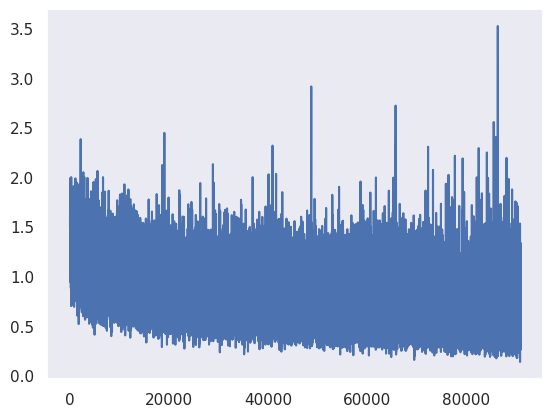

In [38]:
plt.plot(train_losses)

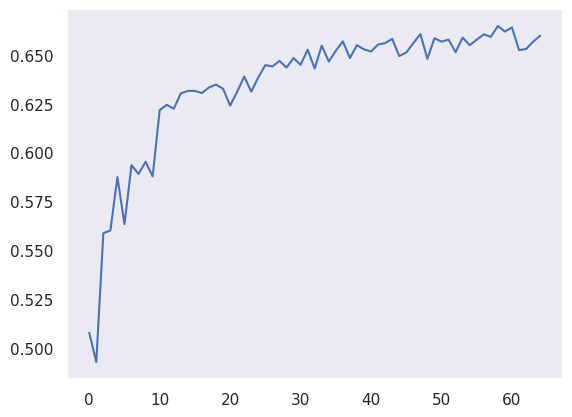

In [39]:
plt.plot(test_accuracy)

In [40]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 3698/5600 (0.6604)
{'acc_detail': tensor([0.6950, 0.6957, 0.6436, 0.6071], device='cuda:0'),
 'acc_unweighted': tensor(0.6604, device='cuda:0'),
 'acc_weighted': tensor(0.6604, device='cuda:0'),
 'f1s': tensor(0.6620, device='cuda:0'),
 'f1s_detail': tensor([0.7071, 0.6626, 0.6958, 0.5826], device='cuda:0'),
 'precision_detail': tensor([0.7197, 0.6325, 0.7571, 0.5599], device='cuda:0'),
 'recall_detail': tensor([0.6950, 0.6957, 0.6436, 0.6071], device='cuda:0'),
 'rocauc': tensor([0.9144, 0.8880, 0.9044, 0.8333], device='cuda:0'),
 'uar': tensor(0.6604, device='cuda:0'),
 'wap': tensor(0.6673, device='cuda:0')}


tensor([[973,  67,  32, 328],
        [ 52, 974, 184, 190],
        [ 59, 290, 901, 150],
        [268, 209,  73, 850]], device='cuda:0')

In [41]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m18_best_59epoch.pt
Correct: 3723/5600 (0.6648)
{'acc_detail': tensor([0.6964, 0.7079, 0.6836, 0.5714], device='cuda:0'),
 'acc_unweighted': tensor(0.6648, device='cuda:0'),
 'acc_weighted': tensor(0.6648, device='cuda:0'),
 'f1s': tensor(0.6655, device='cuda:0'),
 'f1s_detail': tensor([0.7130, 0.6660, 0.7105, 0.5725], device='cuda:0'),
 'precision_detail': tensor([0.7303, 0.6288, 0.7396, 0.5735], device='cuda:0'),
 'recall_detail': tensor([0.6964, 0.7079, 0.6836, 0.5714], device='cuda:0'),
 'rocauc': tensor([0.9143, 0.8873, 0.9033, 0.8289], device='cuda:0'),
 'uar': tensor(0.6648, device='cuda:0'),
 'wap': tensor(0.6680, device='cuda:0')}


tensor([[975,  86,  37, 302],
        [ 36, 991, 203, 170],
        [ 59, 261, 957, 123],
        [265, 238,  97, 800]], device='cuda:0')

In [42]:
checkpoint_path = '../models_esd4/esd4_m18_65epoch.ckpt'
torch.save({
    'epoch': 65,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


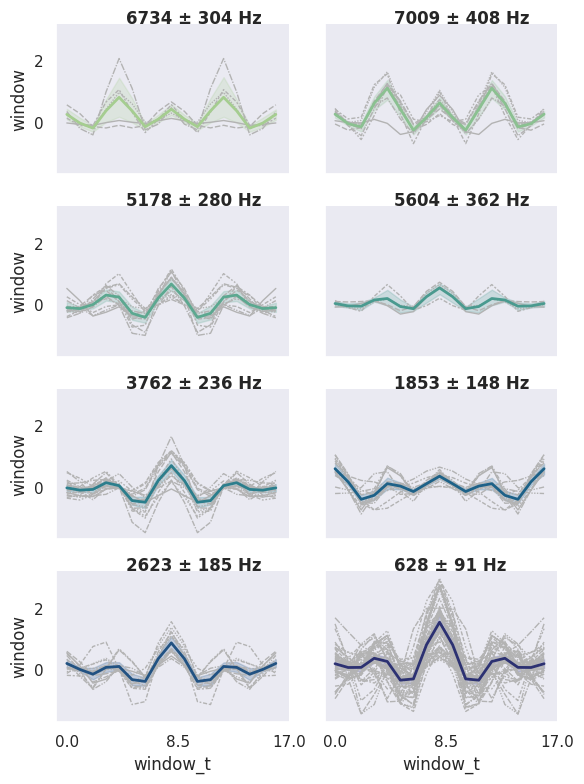

In [43]:
layer2 = best_model.fe_blocks.blocks[0].block.layer

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


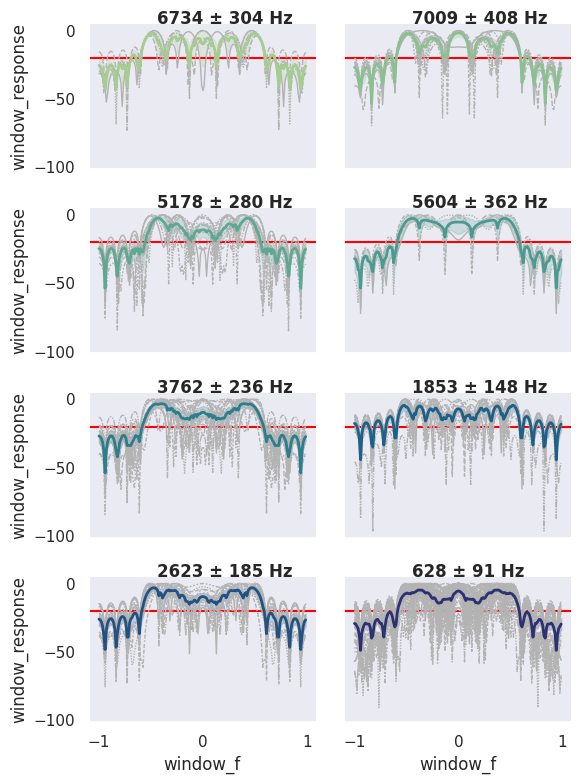

In [44]:
filtviz2.visualize_filters(filter_domain='freq')

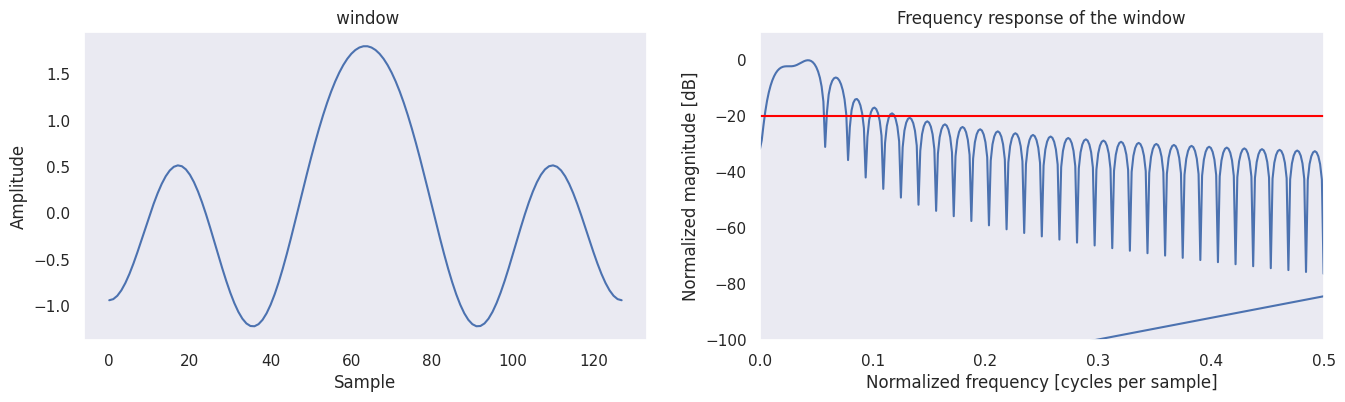

In [45]:
filtviz2.visualize_one_window(n_out=10)

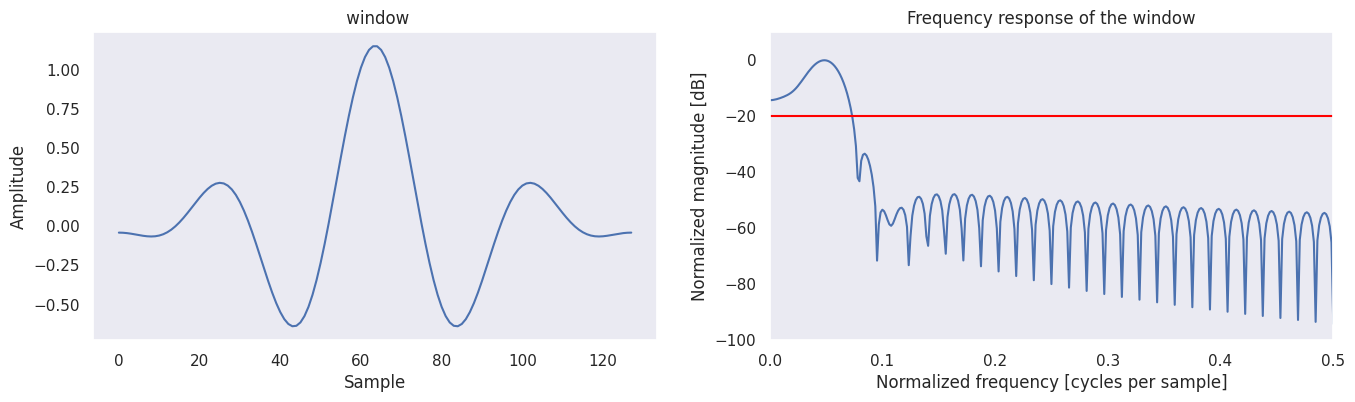

In [46]:
filtviz2.visualize_one_window(n_out=30)

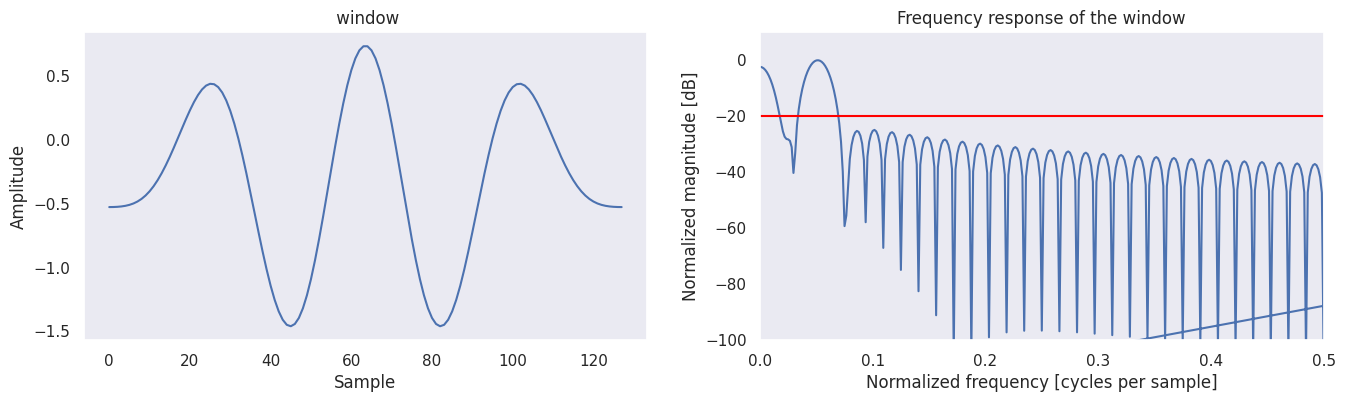

In [47]:
filtviz2.visualize_one_window(n_out=50)

In [48]:
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(66, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                   | 0.0005714285714285715/100 [00:00<19:56:48, 718.09s/it]

Train Epoch: 66 [0/22400 (0%)]	Loss: 0.520376
Mem before-during-after: 45064192 3522549760 44820992


  0%|                                    | 0.023428571428571413/100 [00:19<23:32:04, 847.45s/it]

Train Epoch: 66 [640/22400 (3%)]	Loss: 0.667966
Mem before-during-after: 44740096 3522468864 44740096


  0%|                                    | 0.046285714285714215/100 [00:37<21:43:49, 782.66s/it]

Train Epoch: 66 [1280/22400 (6%)]	Loss: 0.638157
Mem before-during-after: 44606976 3523320320 44606976


  0%|                                     | 0.06914285714285702/100 [00:53<21:23:20, 770.54s/it]

Train Epoch: 66 [1920/22400 (9%)]	Loss: 1.102320
Mem before-during-after: 44606976 3523187200 44740096


  0%|                                     | 0.09199999999999982/100 [01:09<21:29:19, 774.30s/it]

Train Epoch: 66 [2560/22400 (11%)]	Loss: 0.380054
Mem before-during-after: 44740096 3523256320 44606976


  0%|                                     | 0.11485714285714262/100 [01:26<21:48:49, 786.20s/it]

Train Epoch: 66 [3200/22400 (14%)]	Loss: 0.744818
Mem before-during-after: 44740096 3523320320 44740096


  0%|                                     | 0.13771428571428573/100 [01:42<21:34:37, 777.85s/it]

Train Epoch: 66 [3840/22400 (17%)]	Loss: 0.484886
Mem before-during-after: 44606976 3523320320 44740096


  0%|                                      | 0.1605714285714291/100 [01:59<21:24:09, 771.74s/it]

Train Epoch: 66 [4480/22400 (20%)]	Loss: 0.861855
Mem before-during-after: 44606976 3523138560 44740096


  0%|                                     | 0.18342857142857244/100 [02:16<22:50:37, 823.89s/it]

Train Epoch: 66 [5120/22400 (23%)]	Loss: 0.731511
Mem before-during-after: 44740096 3523256320 44606976


  0%|                                      | 0.2062857142857158/100 [02:33<21:53:41, 789.85s/it]

Train Epoch: 66 [5760/22400 (26%)]	Loss: 0.280477
Mem before-during-after: 44740096 3523320320 44740096


  0%|                                     | 0.22914285714285915/100 [02:49<22:47:42, 822.51s/it]

Train Epoch: 66 [6400/22400 (29%)]	Loss: 0.749026
Mem before-during-after: 44740096 3523320320 44740096


  0%|                                      | 0.2520000000000024/100 [03:08<25:55:45, 935.82s/it]

Train Epoch: 66 [7040/22400 (31%)]	Loss: 0.435465
Mem before-during-after: 44740096 3522549760 44606976


  0%|                                     | 0.27485714285714463/100 [03:27<21:31:41, 777.15s/it]

Train Epoch: 66 [7680/22400 (34%)]	Loss: 0.668850
Mem before-during-after: 44606976 3522682880 44606976


  0%|                                      | 0.2977142857142869/100 [03:43<20:17:31, 732.70s/it]

Train Epoch: 66 [8320/22400 (37%)]	Loss: 0.726346
Mem before-during-after: 44771840 3522483712 44740096


  0%|                                      | 0.3205714285714291/100 [03:59<21:33:56, 778.87s/it]

Train Epoch: 66 [8960/22400 (40%)]	Loss: 0.447070
Mem before-during-after: 44606976 3522640384 44740096


  0%|▏                                    | 0.34342857142857136/100 [04:16<21:54:34, 791.46s/it]

Train Epoch: 66 [9600/22400 (43%)]	Loss: 0.306732
Mem before-during-after: 44740096 3522682880 44606976


  0%|▏                                     | 0.3662857142857136/100 [04:32<20:38:02, 745.56s/it]

Train Epoch: 66 [10240/22400 (46%)]	Loss: 0.680651
Mem before-during-after: 44740096 3342258176 44606976


  0%|▏                                    | 0.38914285714285585/100 [04:49<21:39:01, 782.46s/it]

Train Epoch: 66 [10880/22400 (49%)]	Loss: 0.441831
Mem before-during-after: 44606976 3522507264 44740096


  0%|▏                                     | 0.4119999999999981/100 [05:05<21:09:55, 765.11s/it]

Train Epoch: 66 [11520/22400 (51%)]	Loss: 0.536032
Mem before-during-after: 44904960 3522715136 44904960


  0%|▏                                    | 0.43485714285714033/100 [05:21<20:24:21, 737.83s/it]

Train Epoch: 66 [12160/22400 (54%)]	Loss: 0.744037
Mem before-during-after: 44904960 3322944512 44606976


  0%|▏                                     | 0.4577142857142826/100 [05:37<21:43:40, 785.80s/it]

Train Epoch: 66 [12800/22400 (57%)]	Loss: 0.698041
Mem before-during-after: 44606976 3528715776 44606976


  0%|▏                                     | 0.4805714285714248/100 [05:54<21:34:53, 780.69s/it]

Train Epoch: 66 [13440/22400 (60%)]	Loss: 0.459369
Mem before-during-after: 44740096 3522682880 44606976


  1%|▏                                     | 0.5034285714285671/100 [06:10<21:37:47, 782.62s/it]

Train Epoch: 66 [14080/22400 (63%)]	Loss: 0.983681
Mem before-during-after: 44873216 3492431360 45316608


  1%|▏                                     | 0.5262857142857094/100 [06:27<23:25:24, 847.70s/it]

Train Epoch: 66 [14720/22400 (66%)]	Loss: 0.447024
Mem before-during-after: 44740096 3522640384 44740096


  1%|▏                                     | 0.5491428571428516/100 [06:43<21:36:14, 782.04s/it]

Train Epoch: 66 [15360/22400 (69%)]	Loss: 0.357814
Mem before-during-after: 44606976 3522682880 44606976


  1%|▏                                     | 0.5719999999999938/100 [06:59<21:08:03, 765.21s/it]

Train Epoch: 66 [16000/22400 (71%)]	Loss: 0.532979
Mem before-during-after: 44740096 3523320320 44606976


  1%|▏                                     | 0.5948571428571361/100 [07:16<20:32:21, 743.84s/it]

Train Epoch: 66 [16640/22400 (74%)]	Loss: 0.686565
Mem before-during-after: 44606976 3390622720 44606976


  1%|▏                                     | 0.6177142857142783/100 [07:32<21:29:36, 778.57s/it]

Train Epoch: 66 [17280/22400 (77%)]	Loss: 0.539702
Mem before-during-after: 44740096 3523256320 44606976


  1%|▏                                     | 0.6405714285714206/100 [07:48<21:13:28, 769.01s/it]

Train Epoch: 66 [17920/22400 (80%)]	Loss: 0.859521
Mem before-during-after: 44606976 3523320320 44740096


  1%|▎                                     | 0.6634285714285628/100 [08:04<21:19:57, 773.11s/it]

Train Epoch: 66 [18560/22400 (83%)]	Loss: 0.478759
Mem before-during-after: 44740096 3523320320 44606976


  1%|▎                                     | 0.6862857142857051/100 [08:20<20:34:22, 745.75s/it]

Train Epoch: 66 [19200/22400 (86%)]	Loss: 0.804638
Mem before-during-after: 44606976 3523138560 44740096


  1%|▎                                     | 0.7091428571428473/100 [08:36<21:03:05, 763.26s/it]

Train Epoch: 66 [19840/22400 (89%)]	Loss: 0.911719
Mem before-during-after: 44936704 3523209216 44904960


  1%|▎                                     | 0.7319999999999895/100 [08:52<21:30:43, 780.14s/it]

Train Epoch: 66 [20480/22400 (91%)]	Loss: 0.575489
Mem before-during-after: 44606976 3523320320 44606976


  1%|▎                                     | 0.7548571428571318/100 [09:08<21:17:38, 772.42s/it]

Train Epoch: 66 [21120/22400 (94%)]	Loss: 0.653636
Mem before-during-after: 44904960 3523159040 44936704


  1%|▎                                      | 0.777714285714274/100 [09:25<22:58:30, 833.59s/it]

Train Epoch: 66 [21760/22400 (97%)]	Loss: 1.002646
Mem before-during-after: 44985856 3522532352 44606976


  1%|▍                                     | 0.9999999999999823/100 [11:02<10:43:04, 389.74s/it]


Test Epoch: 66	Accuracy: 3709/5600 (66%)



  1%|▍                                      | 1.000571428571411/100 [11:02<13:01:56, 473.91s/it]

Train Epoch: 67 [0/22400 (0%)]	Loss: 0.729133
Mem before-during-after: 44683776 3522416640 44740096


  1%|▍                                     | 1.0234285714285576/100 [11:21<21:16:34, 773.87s/it]

Train Epoch: 67 [640/22400 (3%)]	Loss: 0.306236
Mem before-during-after: 44740096 3522549760 44606976


  1%|▍                                     | 1.0462857142857043/100 [11:37<21:12:46, 771.74s/it]

Train Epoch: 67 [1280/22400 (6%)]	Loss: 1.198924
Mem before-during-after: 44740096 3522549760 44606976


  1%|▍                                      | 1.069142857142851/100 [11:55<21:23:22, 778.34s/it]

Train Epoch: 67 [1920/22400 (9%)]	Loss: 0.479956
Mem before-during-after: 44606976 3522973184 44740096


  1%|▍                                     | 1.0919999999999976/100 [12:12<18:52:30, 687.00s/it]

Train Epoch: 67 [2560/22400 (11%)]	Loss: 0.820063
Mem before-during-after: 44740096 3003478528 44606976


  1%|▍                                     | 1.1148571428571443/100 [12:28<21:15:25, 773.89s/it]

Train Epoch: 67 [3200/22400 (14%)]	Loss: 0.397100
Mem before-during-after: 44606976 3523320320 44606976


  1%|▍                                      | 1.137714285714291/100 [12:44<21:10:21, 770.99s/it]

Train Epoch: 67 [3840/22400 (17%)]	Loss: 0.599853
Mem before-during-after: 45300224 3522977792 44740096


  1%|▍                                     | 1.1605714285714377/100 [13:00<21:17:58, 775.79s/it]

Train Epoch: 67 [4480/22400 (20%)]	Loss: 0.565130
Mem before-during-after: 44740096 3523320320 44606976


  1%|▍                                     | 1.1834285714285844/100 [13:17<22:27:36, 818.25s/it]

Train Epoch: 67 [5120/22400 (23%)]	Loss: 0.306663
Mem before-during-after: 44606976 3523320320 44606976


  1%|▍                                      | 1.206285714285731/100 [13:33<21:03:48, 767.55s/it]

Train Epoch: 67 [5760/22400 (26%)]	Loss: 0.814894
Mem before-during-after: 44740096 3522665472 44606976


  1%|▍                                     | 1.2291428571428777/100 [13:49<20:52:23, 760.79s/it]

Train Epoch: 67 [6400/22400 (29%)]	Loss: 0.393933
Mem before-during-after: 44936704 3522995200 44904960


  1%|▍                                     | 1.2520000000000244/100 [14:05<21:14:06, 774.16s/it]

Train Epoch: 67 [7040/22400 (31%)]	Loss: 0.307052
Mem before-during-after: 44606976 3523320320 44740096


  1%|▍                                      | 1.274857142857171/100 [14:21<21:44:13, 792.64s/it]

Train Epoch: 67 [7680/22400 (34%)]	Loss: 0.348302
Mem before-during-after: 44740096 3523256320 44606976


  1%|▍                                     | 1.2977142857143178/100 [14:38<20:44:45, 756.68s/it]

Train Epoch: 67 [8320/22400 (37%)]	Loss: 0.707177
Mem before-during-after: 44606976 3522763776 44904960


  1%|▌                                     | 1.3205714285714645/100 [14:54<21:33:47, 786.66s/it]

Train Epoch: 67 [8960/22400 (40%)]	Loss: 0.282443
Mem before-during-after: 44606976 3523320320 44606976


  1%|▌                                     | 1.3434285714286112/100 [15:10<21:19:45, 778.31s/it]

Train Epoch: 67 [9600/22400 (43%)]	Loss: 0.268521
Mem before-during-after: 44740096 3523256320 44606976


  1%|▌                                     | 1.3662857142857578/100 [15:26<21:19:52, 778.57s/it]

Train Epoch: 67 [10240/22400 (46%)]	Loss: 0.757083
Mem before-during-after: 44740096 3523320320 44606976


  1%|▌                                     | 1.3891428571429045/100 [15:42<19:57:11, 728.43s/it]

Train Epoch: 67 [10880/22400 (49%)]	Loss: 0.456891
Mem before-during-after: 44606976 3362830336 44606976


  1%|▌                                     | 1.4120000000000512/100 [16:00<22:26:14, 819.31s/it]

Train Epoch: 67 [11520/22400 (51%)]	Loss: 0.870847
Mem before-during-after: 44740096 3522549760 44740096


  1%|▌                                      | 1.434857142857198/100 [16:19<24:56:09, 910.76s/it]

Train Epoch: 67 [12160/22400 (54%)]	Loss: 0.644168
Mem before-during-after: 44740096 3522549760 44606976


  1%|▌                                     | 1.4577142857143446/100 [16:40<25:13:05, 921.28s/it]

Train Epoch: 67 [12800/22400 (57%)]	Loss: 0.546115
Mem before-during-after: 44740096 3522682880 44606976


  1%|▌                                     | 1.4805714285714913/100 [17:00<25:04:46, 916.44s/it]

Train Epoch: 67 [13440/22400 (60%)]	Loss: 0.581205
Mem before-during-after: 44606976 3522682880 44606976


  2%|▌                                      | 1.503428571428638/100 [17:17<21:01:34, 768.50s/it]

Train Epoch: 67 [14080/22400 (63%)]	Loss: 0.532135
Mem before-during-after: 44606976 3522640384 44740096


  2%|▌                                     | 1.5262857142857846/100 [17:36<24:41:05, 902.43s/it]

Train Epoch: 67 [14720/22400 (66%)]	Loss: 0.357295
Mem before-during-after: 44740096 3522613760 44606976


  2%|▌                                     | 1.5491428571429313/100 [17:55<21:11:44, 775.05s/it]

Train Epoch: 67 [15360/22400 (69%)]	Loss: 0.388492
Mem before-during-after: 44740096 3522640384 44606976


  2%|▌                                      | 1.572000000000078/100 [18:11<21:02:14, 769.44s/it]

Train Epoch: 67 [16000/22400 (71%)]	Loss: 0.555614
Mem before-during-after: 44740096 3522682880 44606976


  2%|▌                                     | 1.5948571428572247/100 [18:28<22:08:26, 809.99s/it]

Train Epoch: 67 [16640/22400 (74%)]	Loss: 1.062864
Mem before-during-after: 44740096 3522682880 44606976


  2%|▌                                     | 1.6177142857143714/100 [18:44<21:24:09, 783.16s/it]

Train Epoch: 67 [17280/22400 (77%)]	Loss: 0.991612
Mem before-during-after: 44606976 3493165056 44606976


  2%|▋                                      | 1.640571428571518/100 [19:01<20:32:03, 751.57s/it]

Train Epoch: 67 [17920/22400 (80%)]	Loss: 1.194862
Mem before-during-after: 44606976 3323110400 44606976


  2%|▋                                     | 1.6634285714286647/100 [19:17<20:08:58, 737.66s/it]

Train Epoch: 67 [18560/22400 (83%)]	Loss: 0.501434
Mem before-during-after: 44606976 3522350592 44606976


  2%|▋                                     | 1.6862857142858114/100 [19:34<23:11:19, 849.12s/it]

Train Epoch: 67 [19200/22400 (86%)]	Loss: 0.331464
Mem before-during-after: 44873216 3522549760 44873216


  2%|▋                                      | 1.709142857142958/100 [19:51<21:30:16, 787.63s/it]

Train Epoch: 67 [19840/22400 (89%)]	Loss: 1.153829
Mem before-during-after: 44740096 3523256320 44606976


  2%|▋                                     | 1.7320000000001048/100 [20:07<20:54:47, 766.14s/it]

Train Epoch: 67 [20480/22400 (91%)]	Loss: 0.632289
Mem before-during-after: 44740096 3523320320 44606976


  2%|▋                                     | 1.7548571428572515/100 [20:23<21:19:51, 781.63s/it]

Train Epoch: 67 [21120/22400 (94%)]	Loss: 0.926812
Mem before-during-after: 44606976 3523320320 44606976


  2%|▋                                     | 1.7777142857143982/100 [20:39<22:03:27, 808.44s/it]

Train Epoch: 67 [21760/22400 (97%)]	Loss: 0.655720
Mem before-during-after: 44873216 3523256320 44873216


  2%|▊                                     | 2.0000000000001497/100 [22:14<10:39:55, 391.79s/it]


Test Epoch: 67	Accuracy: 3712/5600 (66%)



  2%|▊                                      | 2.000571428571578/100 [22:15<12:55:36, 474.86s/it]

Train Epoch: 68 [0/22400 (0%)]	Loss: 0.438294
Mem before-during-after: 44683776 3522416640 44740096


  2%|▊                                      | 2.023428571428716/100 [22:33<20:31:56, 754.43s/it]

Train Epoch: 68 [640/22400 (3%)]	Loss: 0.465950
Mem before-during-after: 44771840 3524028928 44771840


  2%|▊                                     | 2.0462857142858537/100 [22:49<20:40:32, 759.87s/it]

Train Epoch: 68 [1280/22400 (6%)]	Loss: 0.853400
Mem before-during-after: 44606976 3328632320 44606976


  2%|▊                                     | 2.0691428571429915/100 [23:05<21:01:07, 772.66s/it]

Train Epoch: 68 [1920/22400 (9%)]	Loss: 0.663479
Mem before-during-after: 44740096 3523320320 44606976


  2%|▊                                     | 2.0920000000001293/100 [23:22<19:59:47, 735.25s/it]

Train Epoch: 68 [2560/22400 (11%)]	Loss: 0.693403
Mem before-during-after: 44606976 3420202496 44651008


  2%|▊                                      | 2.114857142857267/100 [23:38<21:03:24, 774.43s/it]

Train Epoch: 68 [3200/22400 (14%)]	Loss: 0.468458
Mem before-during-after: 44936704 3522763776 44771840


  2%|▊                                      | 2.137714285714405/100 [23:54<21:40:57, 797.63s/it]

Train Epoch: 68 [3840/22400 (17%)]	Loss: 0.881497
Mem before-during-after: 44936704 3508047360 44606976


  2%|▊                                     | 2.1605714285715427/100 [24:10<20:58:52, 772.00s/it]

Train Epoch: 68 [4480/22400 (20%)]	Loss: 0.634947
Mem before-during-after: 44606976 3523320320 44606976


  2%|▊                                     | 2.1834285714286805/100 [24:26<21:00:34, 773.23s/it]

Train Epoch: 68 [5120/22400 (23%)]	Loss: 0.618813
Mem before-during-after: 44936704 3522995200 44904960


  2%|▊                                     | 2.2062857142858183/100 [24:43<21:10:54, 779.75s/it]

Train Epoch: 68 [5760/22400 (26%)]	Loss: 0.690583
Mem before-during-after: 44740096 3523256320 44606976


  2%|▊                                      | 2.229142857142956/100 [24:59<22:44:45, 837.53s/it]

Train Epoch: 68 [6400/22400 (29%)]	Loss: 0.875901
Mem before-during-after: 44606976 3523320320 44606976


  2%|▉                                      | 2.252000000000094/100 [25:16<21:20:50, 786.21s/it]

Train Epoch: 68 [7040/22400 (31%)]	Loss: 0.475286
Mem before-during-after: 44740096 3523320320 44606976


  2%|▊                                     | 2.2748571428572317/100 [25:32<19:53:29, 732.76s/it]

Train Epoch: 68 [7680/22400 (34%)]	Loss: 0.634068
Mem before-during-after: 44740096 3259449856 44606976


  2%|▊                                     | 2.2977142857143695/100 [25:48<21:27:46, 790.84s/it]

Train Epoch: 68 [8320/22400 (37%)]	Loss: 0.628527
Mem before-during-after: 44740096 3523320320 44606976


  2%|▉                                     | 2.3205714285715073/100 [26:04<21:20:43, 786.69s/it]

Train Epoch: 68 [8960/22400 (40%)]	Loss: 0.651882
Mem before-during-after: 44606976 3523320320 44606976


  2%|▉                                      | 2.343428571428645/100 [26:20<20:58:38, 773.31s/it]

Train Epoch: 68 [9600/22400 (43%)]	Loss: 0.631310
Mem before-during-after: 44740096 3523320320 44606976


  2%|▉                                      | 2.366285714285783/100 [26:36<20:41:30, 762.96s/it]

Train Epoch: 68 [10240/22400 (46%)]	Loss: 0.671551
Mem before-during-after: 44606976 3523187200 44740096


  2%|▉                                     | 2.3891428571429207/100 [26:53<21:27:23, 791.34s/it]

Train Epoch: 68 [10880/22400 (49%)]	Loss: 0.359539
Mem before-during-after: 44606976 3523320320 44606976


  2%|▉                                     | 2.4120000000000585/100 [27:10<21:47:38, 803.98s/it]

Train Epoch: 68 [11520/22400 (51%)]	Loss: 0.565420
Mem before-during-after: 44740096 3522682880 44606976


  2%|▉                                     | 2.4348571428571963/100 [27:28<22:43:01, 838.23s/it]

Train Epoch: 68 [12160/22400 (54%)]	Loss: 1.013525
Mem before-during-after: 44904960 3522549760 44740096


  2%|▉                                      | 2.457714285714334/100 [27:45<20:57:56, 773.78s/it]

Train Epoch: 68 [12800/22400 (57%)]	Loss: 0.940404
Mem before-during-after: 44606976 3491962368 44606976


  2%|▉                                      | 2.480571428571472/100 [28:01<20:57:53, 773.93s/it]

Train Epoch: 68 [13440/22400 (60%)]	Loss: 1.078356
Mem before-during-after: 44771840 3523320320 44606976


  3%|▉                                     | 2.5034285714286098/100 [28:18<23:02:21, 850.71s/it]

Train Epoch: 68 [14080/22400 (63%)]	Loss: 0.306324
Mem before-during-after: 44606976 3522613760 44606976


  3%|▉                                     | 2.5262857142857476/100 [28:37<20:04:11, 741.24s/it]

Train Epoch: 68 [14720/22400 (66%)]	Loss: 0.597839
Mem before-during-after: 44606976 3522234880 44740096


  3%|▉                                     | 2.5491428571428854/100 [28:53<20:50:33, 769.96s/it]

Train Epoch: 68 [15360/22400 (69%)]	Loss: 0.449843
Mem before-during-after: 44606976 3522416640 44740096


  3%|█                                      | 2.572000000000023/100 [29:12<24:35:39, 908.77s/it]

Train Epoch: 68 [16000/22400 (71%)]	Loss: 0.828188
Mem before-during-after: 44606976 3522682880 44606976


  3%|█                                      | 2.594857142857161/100 [29:29<19:39:20, 726.46s/it]

Train Epoch: 68 [16640/22400 (74%)]	Loss: 0.650709
Mem before-during-after: 45567488 3522812928 44606976


  3%|▉                                     | 2.6177142857142988/100 [29:47<24:21:47, 900.65s/it]

Train Epoch: 68 [17280/22400 (77%)]	Loss: 0.783547
Mem before-during-after: 44740096 3522549760 44740096


  3%|█                                     | 2.6405714285714366/100 [30:07<25:32:20, 944.34s/it]

Train Epoch: 68 [17920/22400 (80%)]	Loss: 0.977213
Mem before-during-after: 44606976 3522682880 44606976


  3%|█                                     | 2.6634285714285744/100 [30:27<24:57:56, 923.36s/it]

Train Epoch: 68 [18560/22400 (83%)]	Loss: 0.514596
Mem before-during-after: 44873216 3522549760 44873216


  3%|█                                      | 2.686285714285712/100 [30:45<20:45:31, 767.94s/it]

Train Epoch: 68 [19200/22400 (86%)]	Loss: 0.434728
Mem before-during-after: 44740096 3522682880 44606976


  3%|█                                       | 2.70914285714285/100 [31:01<19:09:40, 709.01s/it]

Train Epoch: 68 [19840/22400 (89%)]	Loss: 0.777039
Mem before-during-after: 45228032 3412416000 44710912


  3%|█                                     | 2.7319999999999878/100 [31:21<23:43:05, 877.84s/it]

Train Epoch: 68 [20480/22400 (91%)]	Loss: 0.456684
Mem before-during-after: 44740096 3522549760 44954112


  3%|█                                     | 2.7548571428571256/100 [31:37<20:37:49, 763.73s/it]

Train Epoch: 68 [21120/22400 (94%)]	Loss: 0.562674
Mem before-during-after: 44771840 3522732544 44904960


  3%|█                                     | 2.7777142857142634/100 [31:53<20:41:34, 766.22s/it]

Train Epoch: 68 [21760/22400 (97%)]	Loss: 0.705340
Mem before-during-after: 44771840 3522878976 44771840


  3%|█▏                                    | 2.9999999999999285/100 [33:33<10:39:22, 395.49s/it]


Test Epoch: 68	Accuracy: 3742/5600 (67%)

saved model: ../models_esd4/esd4_m18_best_68epoch.pt


  3%|█▏                                     | 3.000571428571357/100 [33:34<12:53:04, 478.20s/it]

Train Epoch: 69 [0/22400 (0%)]	Loss: 0.609974
Mem before-during-after: 44950016 3522682880 44954112


  3%|█▏                                    | 3.0234285714284947/100 [33:55<25:09:44, 934.09s/it]

Train Epoch: 69 [640/22400 (3%)]	Loss: 0.707540
Mem before-during-after: 44606976 3522682880 44606976


  3%|█▏                                    | 3.0462857142856326/100 [34:13<20:52:38, 775.19s/it]

Train Epoch: 69 [1280/22400 (6%)]	Loss: 0.612950
Mem before-during-after: 44771840 3523159040 44936704


  3%|█▏                                    | 3.0691428571427704/100 [34:29<21:07:21, 784.50s/it]

Train Epoch: 69 [1920/22400 (9%)]	Loss: 0.616174
Mem before-during-after: 45591552 3523320320 45591552


  3%|█▏                                     | 3.091999999999908/100 [34:46<20:59:42, 779.94s/it]

Train Epoch: 69 [2560/22400 (11%)]	Loss: 0.477976
Mem before-during-after: 44606976 3523320320 44740096


  3%|█▏                                     | 3.114857142857046/100 [35:02<20:48:24, 773.13s/it]

Train Epoch: 69 [3200/22400 (14%)]	Loss: 0.655898
Mem before-during-after: 44606976 3523320320 44740096


  3%|█▏                                    | 3.1377142857141838/100 [35:18<20:43:30, 770.28s/it]

Train Epoch: 69 [3840/22400 (17%)]	Loss: 0.393281
Mem before-during-after: 44740096 3523256320 44606976


  3%|█▏                                    | 3.1605714285713216/100 [35:35<19:44:41, 734.01s/it]

Train Epoch: 69 [4480/22400 (20%)]	Loss: 0.686933
Mem before-during-after: 44606976 3183331328 44606976


  3%|█▏                                    | 3.1834285714284594/100 [35:55<22:20:03, 830.47s/it]

Train Epoch: 69 [5120/22400 (23%)]	Loss: 0.714278
Mem before-during-after: 44771840 3522549760 44740096


  3%|█▎                                     | 3.206285714285597/100 [36:15<24:25:38, 908.51s/it]

Train Epoch: 69 [5760/22400 (26%)]	Loss: 0.292552
Mem before-during-after: 44606976 3522416640 44740096


  3%|█▎                                     | 3.229142857142735/100 [36:36<25:03:35, 932.25s/it]

Train Epoch: 69 [6400/22400 (29%)]	Loss: 0.808809
Mem before-during-after: 44606976 3522682880 44606976


  3%|█▏                                    | 3.2519999999998728/100 [36:58<26:03:53, 969.88s/it]

Train Epoch: 69 [7040/22400 (31%)]	Loss: 0.291278
Mem before-during-after: 44606976 3522682880 44606976


  3%|█▏                                    | 3.2748571428570106/100 [37:16<20:51:13, 776.16s/it]

Train Epoch: 69 [7680/22400 (34%)]	Loss: 0.802171
Mem before-during-after: 44606976 3522416640 44740096


  3%|█▎                                    | 3.2977142857141484/100 [37:34<25:07:46, 935.51s/it]

Train Epoch: 69 [8320/22400 (37%)]	Loss: 0.672551
Mem before-during-after: 44740096 3522549760 44740096


  3%|█▎                                     | 3.320571428571286/100 [37:52<21:04:53, 785.00s/it]

Train Epoch: 69 [8960/22400 (40%)]	Loss: 0.700323
Mem before-during-after: 44606976 3522416640 44740096


  3%|█▎                                     | 3.343428571428424/100 [38:09<21:31:52, 801.94s/it]

Train Epoch: 69 [9600/22400 (43%)]	Loss: 0.456791
Mem before-during-after: 44771840 3522648064 44887552


  3%|█▎                                     | 3.366285714285562/100 [38:28<24:42:59, 920.79s/it]

Train Epoch: 69 [10240/22400 (46%)]	Loss: 0.436911
Mem before-during-after: 44606976 3522416640 44740096


  3%|█▎                                    | 3.3891428571426996/100 [38:46<21:45:27, 810.75s/it]

Train Epoch: 69 [10880/22400 (49%)]	Loss: 0.558857
Mem before-during-after: 44740096 3522682880 44606976


  3%|█▎                                    | 3.4119999999998374/100 [39:03<19:57:42, 744.01s/it]

Train Epoch: 69 [11520/22400 (51%)]	Loss: 0.755023
Mem before-during-after: 44606976 2970109952 44606976


  3%|█▎                                     | 3.434857142856975/100 [39:19<19:31:51, 728.13s/it]

Train Epoch: 69 [12160/22400 (54%)]	Loss: 0.735022
Mem before-during-after: 44606976 3522458624 44740096


  3%|█▎                                     | 3.457714285714113/100 [39:36<19:01:57, 709.72s/it]

Train Epoch: 69 [12800/22400 (57%)]	Loss: 0.684591
Mem before-during-after: 44740096 3397354496 44606976


  3%|█▎                                     | 3.480571428571251/100 [39:52<20:48:10, 775.91s/it]

Train Epoch: 69 [13440/22400 (60%)]	Loss: 0.669376
Mem before-during-after: 44904960 3523782656 44936704


  4%|█▎                                    | 3.5034285714283886/100 [40:08<20:43:57, 773.47s/it]

Train Epoch: 69 [14080/22400 (63%)]	Loss: 0.517492
Mem before-during-after: 44606976 3522640384 44740096


  4%|█▎                                    | 3.5262857142855264/100 [40:25<20:01:38, 747.33s/it]

Train Epoch: 69 [14720/22400 (66%)]	Loss: 1.163589
Mem before-during-after: 44606976 3436732416 45567488


  4%|█▍                                     | 3.549142857142664/100 [40:41<20:47:32, 776.07s/it]

Train Epoch: 69 [15360/22400 (69%)]	Loss: 0.325652
Mem before-during-after: 44606976 3522640384 44740096


  4%|█▍                                     | 3.571999999999802/100 [40:57<18:49:58, 703.10s/it]

Train Epoch: 69 [16000/22400 (71%)]	Loss: 0.599405
Mem before-during-after: 44606976 3183104000 44873216


  4%|█▍                                      | 3.59485714285694/100 [41:13<20:51:55, 779.16s/it]

Train Epoch: 69 [16640/22400 (74%)]	Loss: 0.482242
Mem before-during-after: 44856832 3522640384 44740096


  4%|█▎                                    | 3.6177142857140776/100 [41:30<21:22:38, 798.47s/it]

Train Epoch: 69 [17280/22400 (77%)]	Loss: 0.705787
Mem before-during-after: 44606976 3522640384 44606976


  4%|█▍                                    | 3.6405714285712154/100 [41:47<22:20:22, 834.61s/it]

Train Epoch: 69 [17920/22400 (80%)]	Loss: 0.427007
Mem before-during-after: 44606976 3523267072 45457408


  4%|█▍                                     | 3.663428571428353/100 [42:07<20:19:33, 759.56s/it]

Train Epoch: 69 [18560/22400 (83%)]	Loss: 0.823409
Mem before-during-after: 44740096 3170436096 44606976


  4%|█▍                                     | 3.686285714285491/100 [42:27<21:57:52, 820.99s/it]

Train Epoch: 69 [19200/22400 (86%)]	Loss: 0.913328
Mem before-during-after: 45052416 3307740160 44606976


  4%|█▍                                     | 3.709142857142629/100 [42:44<19:37:40, 733.82s/it]

Train Epoch: 69 [19840/22400 (89%)]	Loss: 0.730970
Mem before-during-after: 44606976 3522234880 44740096


  4%|█▍                                    | 3.7319999999997666/100 [43:01<23:58:44, 896.72s/it]

Train Epoch: 69 [20480/22400 (91%)]	Loss: 0.396659
Mem before-during-after: 44936704 3522879488 44936704


  4%|█▍                                    | 3.7548571428569044/100 [43:18<20:58:46, 784.73s/it]

Train Epoch: 69 [21120/22400 (94%)]	Loss: 0.904139
Mem before-during-after: 44606976 3523187200 44740096


  4%|█▍                                     | 3.777714285714042/100 [43:34<20:37:44, 771.80s/it]

Train Epoch: 69 [21760/22400 (97%)]	Loss: 0.766596
Mem before-during-after: 44740096 3523320320 44606976


  4%|█▌                                    | 3.9999999999997073/100 [45:11<10:40:24, 400.25s/it]


Test Epoch: 69	Accuracy: 3702/5600 (66%)



  4%|█▌                                     | 4.000571428571136/100 [45:12<13:05:04, 490.67s/it]

Train Epoch: 70 [0/22400 (0%)]	Loss: 0.495240
Mem before-during-after: 44683776 3522416640 44740096


  4%|█▌                                     | 4.023428571428291/100 [45:29<20:06:07, 754.01s/it]

Train Epoch: 70 [640/22400 (3%)]	Loss: 1.521776
Mem before-during-after: 45993472 3523061760 44771840


  4%|█▌                                     | 4.046285714285447/100 [45:45<19:50:04, 744.16s/it]

Train Epoch: 70 [1280/22400 (6%)]	Loss: 0.934258
Mem before-during-after: 44740096 3470174720 44886528


  4%|█▌                                    | 4.0691428571426025/100 [46:05<21:16:31, 798.41s/it]

Train Epoch: 70 [1920/22400 (9%)]	Loss: 0.334772
Mem before-during-after: 44606976 3522234880 44740096


  4%|█▌                                     | 4.091999999999758/100 [46:25<25:29:27, 956.83s/it]

Train Epoch: 70 [2560/22400 (11%)]	Loss: 0.693459
Mem before-during-after: 44606976 3522682880 44606976


  4%|█▌                                     | 4.114857142856914/100 [46:42<21:11:59, 795.94s/it]

Train Epoch: 70 [3200/22400 (14%)]	Loss: 0.664208
Mem before-during-after: 44606976 3522640384 44740096


  4%|█▌                                     | 4.137714285714069/100 [46:58<20:25:15, 766.89s/it]

Train Epoch: 70 [3840/22400 (17%)]	Loss: 0.560687
Mem before-during-after: 44936704 3523209216 44904960


  4%|█▌                                     | 4.160571428571225/100 [47:14<21:12:20, 796.55s/it]

Train Epoch: 70 [4480/22400 (20%)]	Loss: 0.810700
Mem before-during-after: 44606976 3522640384 44740096


  4%|█▋                                      | 4.18342857142838/100 [47:30<20:48:23, 781.73s/it]

Train Epoch: 70 [5120/22400 (23%)]	Loss: 0.668106
Mem before-during-after: 44771840 3522576384 44873216


  4%|█▋                                     | 4.206285714285536/100 [47:46<21:11:45, 796.56s/it]

Train Epoch: 70 [5760/22400 (26%)]	Loss: 0.576562
Mem before-during-after: 44606976 3522726912 44670976


  4%|█▌                                    | 4.2291428571426914/100 [48:02<22:02:56, 828.81s/it]

Train Epoch: 70 [6400/22400 (29%)]	Loss: 1.364433
Mem before-during-after: 44740096 3523320320 44740096


  4%|█▋                                     | 4.251999999999847/100 [48:19<20:55:13, 786.58s/it]

Train Epoch: 70 [7040/22400 (31%)]	Loss: 0.330411
Mem before-during-after: 44606976 3523320320 44740096


  4%|█▋                                     | 4.274857142857003/100 [48:35<19:49:41, 745.70s/it]

Train Epoch: 70 [7680/22400 (34%)]	Loss: 1.072391
Mem before-during-after: 44740096 3384286720 44606976


  4%|█▋                                     | 4.297714285714158/100 [48:51<20:14:38, 761.52s/it]

Train Epoch: 70 [8320/22400 (37%)]	Loss: 0.676116
Mem before-during-after: 45149696 3523271168 44606976


  4%|█▋                                     | 4.320571428571314/100 [49:08<18:50:12, 708.75s/it]

Train Epoch: 70 [8960/22400 (40%)]	Loss: 0.867083
Mem before-during-after: 44740096 3442596352 45035008


  4%|█▋                                     | 4.343428571428469/100 [49:24<20:48:00, 782.81s/it]

Train Epoch: 70 [9600/22400 (43%)]	Loss: 0.456761
Mem before-during-after: 44606976 3523187200 44740096


  4%|█▋                                     | 4.366285714285625/100 [49:41<20:34:15, 774.36s/it]

Train Epoch: 70 [10240/22400 (46%)]	Loss: 0.322562
Mem before-during-after: 44771840 3522781184 44771840


  4%|█▊                                      | 4.38914285714278/100 [49:57<19:46:05, 744.33s/it]

Train Epoch: 70 [10880/22400 (49%)]	Loss: 0.506897
Mem before-during-after: 44740096 3307706368 44606976


  4%|█▋                                     | 4.411999999999936/100 [50:13<20:31:13, 772.83s/it]

Train Epoch: 70 [11520/22400 (51%)]	Loss: 0.710063
Mem before-during-after: 44740096 3523256320 44606976


  4%|█▋                                    | 4.4348571428570915/100 [50:30<21:29:58, 809.90s/it]

Train Epoch: 70 [12160/22400 (54%)]	Loss: 0.527932
Mem before-during-after: 44606976 3523320320 44606976


  4%|█▋                                     | 4.457714285714247/100 [50:46<18:54:04, 712.19s/it]

Train Epoch: 70 [12800/22400 (57%)]	Loss: 1.188053
Mem before-during-after: 45448704 3183461376 44606976


  4%|█▋                                     | 4.480571428571403/100 [51:04<19:55:41, 751.07s/it]

Train Epoch: 70 [13440/22400 (60%)]	Loss: 0.744948
Mem before-during-after: 44606976 3425007104 44606976


  5%|█▊                                     | 4.503428571428558/100 [51:21<20:41:15, 779.88s/it]

Train Epoch: 70 [14080/22400 (63%)]	Loss: 0.492541
Mem before-during-after: 44873216 3522640384 44740096


  5%|█▊                                     | 4.526285714285714/100 [51:38<20:49:24, 785.18s/it]

Train Epoch: 70 [14720/22400 (66%)]	Loss: 0.705509
Mem before-during-after: 44606976 3522682880 44606976


  5%|█▊                                     | 4.549142857142869/100 [51:54<21:50:23, 823.71s/it]

Train Epoch: 70 [15360/22400 (69%)]	Loss: 0.361740
Mem before-during-after: 44606976 3523320320 44740096


  5%|█▊                                     | 4.572000000000025/100 [52:10<20:15:22, 764.16s/it]

Train Epoch: 70 [16000/22400 (71%)]	Loss: 0.501048
Mem before-during-after: 44606976 3522466304 44771840


  5%|█▋                                    | 4.5948571428571805/100 [52:28<21:23:18, 807.06s/it]

Train Epoch: 70 [16640/22400 (74%)]	Loss: 0.479541
Mem before-during-after: 44606976 3522416640 44740096


  5%|█▊                                     | 4.617714285714336/100 [52:45<20:27:24, 772.09s/it]

Train Epoch: 70 [17280/22400 (77%)]	Loss: 0.473254
Mem before-during-after: 44740096 3522549760 44606976


  5%|█▊                                     | 4.640571428571492/100 [53:01<18:44:00, 707.22s/it]

Train Epoch: 70 [17920/22400 (80%)]	Loss: 0.701538
Mem before-during-after: 44606976 3157126144 44606976


  5%|█▊                                     | 4.663428571428647/100 [53:17<21:09:47, 799.15s/it]

Train Epoch: 70 [18560/22400 (83%)]	Loss: 0.558395
Mem before-during-after: 44606976 3523426816 44936704


  5%|█▊                                     | 4.686285714285803/100 [53:34<19:56:32, 753.22s/it]

Train Epoch: 70 [19200/22400 (86%)]	Loss: 1.195770
Mem before-during-after: 44740096 3210668544 44606976


  5%|█▊                                     | 4.709142857142958/100 [53:51<20:37:47, 779.37s/it]

Train Epoch: 70 [19840/22400 (89%)]	Loss: 0.595106
Mem before-during-after: 44606976 3522682880 44606976


  5%|█▊                                     | 4.732000000000114/100 [54:08<20:33:41, 776.98s/it]

Train Epoch: 70 [20480/22400 (91%)]	Loss: 0.554248
Mem before-during-after: 44740096 3522682880 44606976


  5%|█▊                                    | 4.7548571428572695/100 [54:24<19:03:39, 720.45s/it]

Train Epoch: 70 [21120/22400 (94%)]	Loss: 0.695599
Mem before-during-after: 45297152 3455411200 45419008


  5%|█▊                                     | 4.777714285714425/100 [54:45<25:35:37, 967.60s/it]

Train Epoch: 70 [21760/22400 (97%)]	Loss: 0.467612
Mem before-during-after: 44606976 3522416640 44740096


  5%|█▉                                     | 5.000000000000263/100 [56:23<10:40:09, 404.31s/it]


Test Epoch: 70	Accuracy: 3669/5600 (66%)



  5%|█▉                                     | 5.000571428571692/100 [56:23<12:48:44, 485.52s/it]

Train Epoch: 71 [0/22400 (0%)]	Loss: 0.466426
Mem before-during-after: 44683776 3522416640 44740096


  5%|█▉                                     | 5.023428571428847/100 [56:43<20:51:56, 790.90s/it]

Train Epoch: 71 [640/22400 (3%)]	Loss: 0.417616
Mem before-during-after: 44606976 3522416640 44740096


  5%|█▉                                     | 5.046285714286003/100 [57:00<23:07:51, 876.97s/it]

Train Epoch: 71 [1280/22400 (6%)]	Loss: 0.800377
Mem before-during-after: 44904960 3522549760 44740096


  5%|█▉                                    | 5.0691428571431585/100 [57:16<21:01:09, 797.11s/it]

Train Epoch: 71 [1920/22400 (9%)]	Loss: 0.474873
Mem before-during-after: 44740096 3522682880 44606976


  5%|█▉                                     | 5.092000000000314/100 [57:32<20:18:23, 770.26s/it]

Train Epoch: 71 [2560/22400 (11%)]	Loss: 0.747133
Mem before-during-after: 44740096 3519743488 44606976


  5%|██                                      | 5.11485714285747/100 [57:49<24:12:09, 918.26s/it]

Train Epoch: 71 [3200/22400 (14%)]	Loss: 0.421759
Mem before-during-after: 44873216 3522682880 44606976


  5%|██                                     | 5.137714285714625/100 [58:07<21:14:23, 806.05s/it]

Train Epoch: 71 [3840/22400 (17%)]	Loss: 0.872465
Mem before-during-after: 44606976 3522729472 44670976


  5%|██                                     | 5.160571428571781/100 [58:23<20:25:03, 775.03s/it]

Train Epoch: 71 [4480/22400 (20%)]	Loss: 0.447385
Mem before-during-after: 44740096 3522682880 44606976


  5%|██                                     | 5.183428571428936/100 [58:40<19:16:54, 732.09s/it]

Train Epoch: 71 [5120/22400 (23%)]	Loss: 0.297492
Mem before-during-after: 44606976 3522234880 44740096


  5%|██                                     | 5.206285714286092/100 [58:56<20:33:39, 780.85s/it]

Train Epoch: 71 [5760/22400 (26%)]	Loss: 0.490069
Mem before-during-after: 44740096 3522665472 44740096


  5%|█▉                                    | 5.2291428571432474/100 [59:13<22:24:49, 851.41s/it]

Train Epoch: 71 [6400/22400 (29%)]	Loss: 0.553987
Mem before-during-after: 44606976 3522682880 44606976


  5%|██                                     | 5.252000000000403/100 [59:30<20:17:23, 770.93s/it]

Train Epoch: 71 [7040/22400 (31%)]	Loss: 0.410514
Mem before-during-after: 44740096 3522682880 44606976


  5%|██                                     | 5.274857142857559/100 [59:46<22:35:44, 858.74s/it]

Train Epoch: 71 [7680/22400 (34%)]	Loss: 0.553616
Mem before-during-after: 44606976 3522613760 44606976


  5%|█▉                                   | 5.297714285714714/100 [1:00:03<19:07:02, 726.72s/it]

Train Epoch: 71 [8320/22400 (37%)]	Loss: 0.697054
Mem before-during-after: 44606976 3522466304 44771840


  5%|██                                    | 5.32057142857187/100 [1:00:22<20:28:16, 778.38s/it]

Train Epoch: 71 [8960/22400 (40%)]	Loss: 0.841627
Mem before-during-after: 44740096 3522682880 44606976


  5%|█▉                                   | 5.343428571429025/100 [1:00:38<20:36:52, 784.01s/it]

Train Epoch: 71 [9600/22400 (43%)]	Loss: 0.318615
Mem before-during-after: 44740096 3523256320 44606976


  5%|█▉                                   | 5.366285714286181/100 [1:00:55<20:34:21, 782.61s/it]

Train Epoch: 71 [10240/22400 (46%)]	Loss: 0.695254
Mem before-during-after: 44606976 3523320320 44740096


  5%|█▉                                   | 5.389142857143336/100 [1:01:11<20:18:32, 772.77s/it]

Train Epoch: 71 [10880/22400 (49%)]	Loss: 0.325872
Mem before-during-after: 45609472 3523237376 45609472


  5%|██                                   | 5.412000000000492/100 [1:01:28<22:01:53, 838.51s/it]

Train Epoch: 71 [11520/22400 (51%)]	Loss: 0.636669
Mem before-during-after: 44820992 3522665472 44873216


  5%|█▉                                  | 5.4348571428576475/100 [1:01:46<19:52:16, 756.48s/it]

Train Epoch: 71 [12160/22400 (54%)]	Loss: 0.645108
Mem before-during-after: 44606976 3323242496 44606976


  5%|██                                   | 5.457714285714803/100 [1:02:02<21:22:43, 814.07s/it]

Train Epoch: 71 [12800/22400 (57%)]	Loss: 0.455425
Mem before-during-after: 44740096 3523320320 44740096


  5%|██                                   | 5.480571428571959/100 [1:02:18<20:30:57, 781.40s/it]

Train Epoch: 71 [13440/22400 (60%)]	Loss: 0.681628
Mem before-during-after: 44740096 3522665472 44740096


  6%|██                                   | 5.503428571429114/100 [1:02:35<20:27:43, 779.54s/it]

Train Epoch: 71 [14080/22400 (63%)]	Loss: 0.369309
Mem before-during-after: 44606976 3523320320 44740096


  6%|██                                    | 5.52628571428627/100 [1:02:51<20:21:28, 775.75s/it]

Train Epoch: 71 [14720/22400 (66%)]	Loss: 0.569099
Mem before-during-after: 44606976 3523320320 44740096


  6%|██                                   | 5.549142857143425/100 [1:03:09<25:07:38, 957.74s/it]

Train Epoch: 71 [15360/22400 (69%)]	Loss: 0.530704
Mem before-during-after: 44606976 3522682880 44606976


  6%|██                                   | 5.572000000000581/100 [1:03:26<20:23:04, 777.15s/it]

Train Epoch: 71 [16000/22400 (71%)]	Loss: 0.658020
Mem before-during-after: 44740096 3522682880 44606976


  6%|██                                  | 5.5948571428577365/100 [1:03:43<20:33:10, 783.76s/it]

Train Epoch: 71 [16640/22400 (74%)]	Loss: 0.349943
Mem before-during-after: 44740096 3522640384 44740096


  6%|██                                   | 5.617714285714892/100 [1:04:00<20:17:23, 773.91s/it]

Train Epoch: 71 [17280/22400 (77%)]	Loss: 0.574632
Mem before-during-after: 44904960 3523782656 44936704


  6%|██                                   | 5.640571428572048/100 [1:04:16<21:22:21, 815.41s/it]

Train Epoch: 71 [17920/22400 (80%)]	Loss: 0.287633
Mem before-during-after: 44740096 3522682880 44606976


  6%|██                                   | 5.663428571429203/100 [1:04:33<20:31:01, 782.95s/it]

Train Epoch: 71 [18560/22400 (83%)]	Loss: 0.576815
Mem before-during-after: 44606976 3522640384 44740096


  6%|██                                   | 5.686285714286359/100 [1:04:49<19:21:56, 739.19s/it]

Train Epoch: 71 [19200/22400 (86%)]	Loss: 0.665874
Mem before-during-after: 44606976 3385357824 45100544


  6%|██                                   | 5.709142857143514/100 [1:05:05<20:18:47, 775.55s/it]

Train Epoch: 71 [19840/22400 (89%)]	Loss: 0.648976
Mem before-during-after: 44740096 3522682880 44606976


  6%|██▏                                   | 5.73200000000067/100 [1:05:23<20:54:56, 798.75s/it]

Train Epoch: 71 [20480/22400 (91%)]	Loss: 0.552020
Mem before-during-after: 44606976 3522507264 44740096


  6%|██                                  | 5.7548571428578255/100 [1:05:39<19:51:55, 758.82s/it]

Train Epoch: 71 [21120/22400 (94%)]	Loss: 0.987009
Mem before-during-after: 44606976 3293423616 44606976


  6%|██▏                                  | 5.777714285714981/100 [1:05:56<20:21:09, 777.62s/it]

Train Epoch: 71 [21760/22400 (97%)]	Loss: 0.888907
Mem before-during-after: 44740096 3522682880 44606976


  6%|██▏                                  | 6.000000000000819/100 [1:07:34<10:34:24, 404.94s/it]


Test Epoch: 71	Accuracy: 3695/5600 (66%)



  6%|██▏                                  | 6.000571428572248/100 [1:07:34<14:30:47, 555.83s/it]

Train Epoch: 72 [0/22400 (0%)]	Loss: 0.492110
Mem before-during-after: 44683776 3522416640 44740096


  6%|██▏                                  | 6.023428571429403/100 [1:07:51<20:29:31, 785.00s/it]

Train Epoch: 72 [640/22400 (3%)]	Loss: 0.517787
Mem before-during-after: 44740096 3522665472 44606976


  6%|██▏                                  | 6.046285714286559/100 [1:08:07<20:06:29, 770.48s/it]

Train Epoch: 72 [1280/22400 (6%)]	Loss: 0.686422
Mem before-during-after: 44606976 3522640384 44740096


  6%|██▏                                 | 6.0691428571437145/100 [1:08:24<20:18:45, 778.50s/it]

Train Epoch: 72 [1920/22400 (9%)]	Loss: 0.641830
Mem before-during-after: 44740096 3522640384 44606976


  6%|██▎                                   | 6.09200000000087/100 [1:08:40<21:07:27, 809.81s/it]

Train Epoch: 72 [2560/22400 (11%)]	Loss: 0.513123
Mem before-during-after: 44740096 3522640384 44606976


  6%|██▎                                  | 6.114857142858026/100 [1:08:57<20:45:50, 796.19s/it]

Train Epoch: 72 [3200/22400 (14%)]	Loss: 1.205556
Mem before-during-after: 44873216 3473720320 44606976


  6%|██▎                                  | 6.137714285715181/100 [1:09:13<19:51:58, 761.95s/it]

Train Epoch: 72 [3840/22400 (17%)]	Loss: 0.738836
Mem before-during-after: 44740096 3343025152 44606976


  6%|██▎                                  | 6.160571428572337/100 [1:09:30<19:21:24, 742.59s/it]

Train Epoch: 72 [4480/22400 (20%)]	Loss: 0.972013
Mem before-during-after: 44606976 3272807936 44606976


  6%|██▎                                  | 6.183428571429492/100 [1:09:47<20:54:58, 802.61s/it]

Train Epoch: 72 [5120/22400 (23%)]	Loss: 0.559360
Mem before-during-after: 44740096 3523320320 44606976


  6%|██▎                                  | 6.206285714286648/100 [1:10:06<24:44:22, 949.55s/it]

Train Epoch: 72 [5760/22400 (26%)]	Loss: 0.532513
Mem before-during-after: 44740096 3522549760 44740096


  6%|██▏                                 | 6.2291428571438034/100 [1:10:23<23:02:35, 884.66s/it]

Train Epoch: 72 [6400/22400 (29%)]	Loss: 0.511799
Mem before-during-after: 44606976 3522640384 44606976


  6%|██▎                                  | 6.252000000000959/100 [1:10:41<21:08:00, 811.54s/it]

Train Epoch: 72 [7040/22400 (31%)]	Loss: 0.675334
Mem before-during-after: 44740096 3522640384 44740096


  6%|██▎                                  | 6.274857142858115/100 [1:10:59<21:56:29, 842.78s/it]

Train Epoch: 72 [7680/22400 (34%)]	Loss: 0.619666
Mem before-during-after: 44606976 3522416640 44740096


  6%|██▍                                   | 6.29771428571527/100 [1:11:15<20:12:39, 776.49s/it]

Train Epoch: 72 [8320/22400 (37%)]	Loss: 0.682654
Mem before-during-after: 44740096 3522549760 44606976


  6%|██▎                                  | 6.320571428572426/100 [1:11:31<20:24:07, 784.03s/it]

Train Epoch: 72 [8960/22400 (40%)]	Loss: 0.867402
Mem before-during-after: 44606976 3522416640 44740096


  6%|██▎                                  | 6.343428571429581/100 [1:11:48<19:15:47, 740.44s/it]

Train Epoch: 72 [9600/22400 (43%)]	Loss: 0.465032
Mem before-during-after: 44606976 3522234880 44740096


  6%|██▎                                  | 6.366285714286737/100 [1:12:06<23:10:08, 890.79s/it]

Train Epoch: 72 [10240/22400 (46%)]	Loss: 1.141913
Mem before-during-after: 44606976 3115090944 44606976


  6%|██▎                                  | 6.389142857143892/100 [1:12:24<19:50:28, 763.03s/it]

Train Epoch: 72 [10880/22400 (49%)]	Loss: 0.920146
Mem before-during-after: 44740096 3190168064 44606976


  6%|██▎                                  | 6.412000000001048/100 [1:12:41<19:07:56, 735.95s/it]

Train Epoch: 72 [11520/22400 (51%)]	Loss: 0.584571
Mem before-during-after: 44606976 3522911232 44771840


  6%|██▎                                 | 6.4348571428582035/100 [1:12:58<21:21:06, 821.53s/it]

Train Epoch: 72 [12160/22400 (54%)]	Loss: 0.615692
Mem before-during-after: 44820992 3522532352 44820992


  6%|██▍                                  | 6.457714285715359/100 [1:13:14<20:10:26, 776.41s/it]

Train Epoch: 72 [12800/22400 (57%)]	Loss: 0.661098
Mem before-during-after: 44771840 3522532352 44771840


  6%|██▍                                  | 6.480571428572515/100 [1:13:31<20:47:21, 800.28s/it]

Train Epoch: 72 [13440/22400 (60%)]	Loss: 0.875354
Mem before-during-after: 44606976 3522507264 44740096


  7%|██▍                                   | 6.50342857142967/100 [1:13:47<20:17:36, 781.38s/it]

Train Epoch: 72 [14080/22400 (63%)]	Loss: 0.545244
Mem before-during-after: 44606976 3522682880 44606976


  7%|██▍                                  | 6.526285714286826/100 [1:14:03<19:56:38, 768.11s/it]

Train Epoch: 72 [14720/22400 (66%)]	Loss: 0.370550
Mem before-during-after: 44740096 3522640384 44740096


  7%|██▍                                  | 6.549142857143981/100 [1:14:20<21:27:31, 826.66s/it]

Train Epoch: 72 [15360/22400 (69%)]	Loss: 0.643942
Mem before-during-after: 44606976 3523346432 44606976


  7%|██▍                                  | 6.572000000001137/100 [1:14:36<21:00:40, 809.61s/it]

Train Epoch: 72 [16000/22400 (71%)]	Loss: 0.673887
Mem before-during-after: 44606976 3523187200 44740096


  7%|██▎                                 | 6.5948571428582925/100 [1:14:53<20:13:23, 779.43s/it]

Train Epoch: 72 [16640/22400 (74%)]	Loss: 0.711162
Mem before-during-after: 44606976 3523320320 44740096


  7%|██▍                                  | 6.617714285715448/100 [1:15:10<21:44:22, 838.08s/it]

Train Epoch: 72 [17280/22400 (77%)]	Loss: 1.057123
Mem before-during-after: 44740096 3523256320 44606976


  7%|██▍                                  | 6.640571428572604/100 [1:15:26<20:14:00, 780.21s/it]

Train Epoch: 72 [17920/22400 (80%)]	Loss: 1.254328
Mem before-during-after: 44606976 3523320320 44606976


  7%|██▍                                  | 6.663428571429759/100 [1:15:42<20:02:13, 772.83s/it]

Train Epoch: 72 [18560/22400 (83%)]	Loss: 1.075186
Mem before-during-after: 44606976 3523320320 44606976


  7%|██▍                                  | 6.686285714286915/100 [1:15:59<20:30:06, 790.95s/it]

Train Epoch: 72 [19200/22400 (86%)]	Loss: 0.597676
Mem before-during-after: 44740096 3522665472 44606976


  7%|██▌                                   | 6.70914285714407/100 [1:16:16<19:08:35, 738.71s/it]

Train Epoch: 72 [19840/22400 (89%)]	Loss: 1.225457
Mem before-during-after: 44740096 3115464704 44606976


  7%|██▍                                  | 6.732000000001226/100 [1:16:32<20:44:22, 800.51s/it]

Train Epoch: 72 [20480/22400 (91%)]	Loss: 0.623248
Mem before-during-after: 44606976 3522500608 44873216


  7%|██▍                                 | 6.7548571428583815/100 [1:16:53<22:26:01, 866.12s/it]

Train Epoch: 72 [21120/22400 (94%)]	Loss: 1.116263
Mem before-during-after: 44606976 3482108416 45133312


  7%|██▌                                  | 6.777714285715537/100 [1:17:11<19:05:53, 737.52s/it]

Train Epoch: 72 [21760/22400 (97%)]	Loss: 0.358200
Mem before-during-after: 44606976 3522234880 44740096


  7%|██▌                                  | 7.000000000001375/100 [1:18:48<10:43:20, 415.06s/it]


Test Epoch: 72	Accuracy: 3683/5600 (66%)



  7%|██▌                                  | 7.000571428572804/100 [1:18:48<12:38:48, 489.55s/it]

Train Epoch: 73 [0/22400 (0%)]	Loss: 0.603793
Mem before-during-after: 44683776 3528552448 44606976


  7%|██▌                                 | 7.023428571429959/100 [1:19:09<25:53:16, 1002.36s/it]

Train Epoch: 73 [640/22400 (3%)]	Loss: 0.791445
Mem before-during-after: 44740096 3522682880 44606976


  7%|██▌                                  | 7.046285714287115/100 [1:19:27<18:45:52, 726.73s/it]

Train Epoch: 73 [1280/22400 (6%)]	Loss: 0.403686
Mem before-during-after: 44606976 3426201088 45051392


  7%|██▌                                 | 7.0691428571442705/100 [1:19:43<18:46:33, 727.35s/it]

Train Epoch: 73 [1920/22400 (9%)]	Loss: 0.708122
Mem before-during-after: 44606976 3522350592 44606976


  7%|██▌                                  | 7.092000000001426/100 [1:20:02<21:26:50, 831.05s/it]

Train Epoch: 73 [2560/22400 (11%)]	Loss: 0.716961
Mem before-during-after: 44606976 3522335744 44788736


  7%|██▋                                  | 7.114857142858582/100 [1:20:18<19:01:00, 737.04s/it]

Train Epoch: 73 [3200/22400 (14%)]	Loss: 0.696248
Mem before-during-after: 44606976 3462648832 45419008


  7%|██▋                                  | 7.137714285715737/100 [1:20:37<24:23:44, 945.75s/it]

Train Epoch: 73 [3840/22400 (17%)]	Loss: 0.410149
Mem before-during-after: 44740096 3522549760 44740096


  7%|██▌                                 | 7.160571428572893/100 [1:20:58<26:44:41, 1037.08s/it]

Train Epoch: 73 [4480/22400 (20%)]	Loss: 0.768490
Mem before-during-after: 44606976 3522416640 44740096


  7%|██▋                                  | 7.183428571430048/100 [1:21:20<23:41:19, 918.80s/it]

Train Epoch: 73 [5120/22400 (23%)]	Loss: 1.051881
Mem before-during-after: 44740096 3491112448 44781056


  7%|██▋                                  | 7.206285714287204/100 [1:21:38<22:10:44, 860.45s/it]

Train Epoch: 73 [5760/22400 (26%)]	Loss: 0.662415
Mem before-during-after: 44606976 3522416640 44740096


  7%|██▌                                 | 7.2291428571443594/100 [1:21:58<18:19:44, 711.26s/it]

Train Epoch: 73 [6400/22400 (29%)]	Loss: 0.956230
Mem before-during-after: 44606976 3523183104 44936704


  7%|██▋                                  | 7.252000000001515/100 [1:22:14<21:13:52, 824.08s/it]

Train Epoch: 73 [7040/22400 (31%)]	Loss: 0.375246
Mem before-during-after: 44837376 3522416640 44606976


  7%|██▋                                  | 7.274857142858671/100 [1:22:31<18:54:17, 733.97s/it]

Train Epoch: 73 [7680/22400 (34%)]	Loss: 0.628311
Mem before-during-after: 44606976 3522458624 44740096


  7%|██▋                                  | 7.297714285715826/100 [1:22:48<20:11:18, 783.99s/it]

Train Epoch: 73 [8320/22400 (37%)]	Loss: 0.453815
Mem before-during-after: 44606976 3522640384 44740096


  7%|██▋                                  | 7.320571428572982/100 [1:23:05<20:21:23, 790.72s/it]

Train Epoch: 73 [8960/22400 (40%)]	Loss: 0.566213
Mem before-during-after: 44740096 3522682880 44606976


  7%|██▋                                  | 7.343428571430137/100 [1:23:21<18:48:01, 730.45s/it]

Train Epoch: 73 [9600/22400 (43%)]	Loss: 1.500600
Mem before-during-after: 44606976 3315981824 44606976


  7%|██▋                                  | 7.366285714287293/100 [1:23:38<20:35:54, 800.52s/it]

Train Epoch: 73 [10240/22400 (46%)]	Loss: 0.570234
Mem before-during-after: 44606976 3522416640 44740096


  7%|██▋                                  | 7.389142857144448/100 [1:23:55<19:32:36, 759.70s/it]

Train Epoch: 73 [10880/22400 (49%)]	Loss: 1.046966
Mem before-during-after: 44740096 3169697792 44606976


  7%|██▋                                  | 7.412000000001604/100 [1:24:11<18:33:59, 721.91s/it]

Train Epoch: 73 [11520/22400 (51%)]	Loss: 1.145530
Mem before-during-after: 45497856 3232667136 44606976


  7%|██▋                                 | 7.4348571428587595/100 [1:24:28<19:30:37, 758.79s/it]

Train Epoch: 73 [12160/22400 (54%)]	Loss: 1.595031
Mem before-during-after: 44606976 3205337600 44606976


  7%|██▊                                  | 7.457714285715915/100 [1:24:44<18:23:20, 715.36s/it]

Train Epoch: 73 [12800/22400 (57%)]	Loss: 0.778517
Mem before-during-after: 44904960 3524028928 44904960


  7%|██▊                                  | 7.480571428573071/100 [1:25:02<18:54:49, 735.95s/it]

Train Epoch: 73 [13440/22400 (60%)]	Loss: 0.581012
Mem before-during-after: 44606976 3522458624 44740096


  8%|██▊                                  | 7.503428571430226/100 [1:25:19<25:06:06, 976.97s/it]

Train Epoch: 73 [14080/22400 (63%)]	Loss: 0.840580
Mem before-during-after: 44606976 3522682880 44606976


  8%|██▊                                  | 7.526285714287382/100 [1:25:39<22:02:06, 857.83s/it]

Train Epoch: 73 [14720/22400 (66%)]	Loss: 0.675595
Mem before-during-after: 44606976 3259692032 44606976


  8%|██▊                                  | 7.549142857144537/100 [1:25:56<20:17:17, 790.01s/it]

Train Epoch: 73 [15360/22400 (69%)]	Loss: 0.483239
Mem before-during-after: 44606976 3522682880 44606976


  8%|██▊                                  | 7.572000000001693/100 [1:26:12<20:30:54, 799.05s/it]

Train Epoch: 73 [16000/22400 (71%)]	Loss: 0.456243
Mem before-during-after: 44606976 3522416640 44740096


  8%|██▋                                 | 7.5948571428588485/100 [1:26:31<22:44:07, 885.75s/it]

Train Epoch: 73 [16640/22400 (74%)]	Loss: 0.506332
Mem before-during-after: 44740096 3017326592 44954112


  8%|██▊                                  | 7.617714285716004/100 [1:26:48<18:23:00, 716.37s/it]

Train Epoch: 73 [17280/22400 (77%)]	Loss: 0.423126
Mem before-during-after: 44606976 3523034624 44883456


  8%|██▉                                   | 7.64057142857316/100 [1:27:07<19:57:04, 777.66s/it]

Train Epoch: 73 [17920/22400 (80%)]	Loss: 0.697001
Mem before-during-after: 44771840 3523285504 44820992


  8%|██▊                                  | 7.663428571430315/100 [1:27:27<25:16:43, 985.56s/it]

Train Epoch: 73 [18560/22400 (83%)]	Loss: 0.750829
Mem before-during-after: 44740096 3522808320 44740096


  8%|██▊                                  | 7.686285714287471/100 [1:27:43<20:05:20, 783.42s/it]

Train Epoch: 73 [19200/22400 (86%)]	Loss: 0.892692
Mem before-during-after: 45591552 3523320320 45591552


  8%|██▊                                  | 7.709142857144626/100 [1:27:59<19:06:55, 745.64s/it]

Train Epoch: 73 [19840/22400 (89%)]	Loss: 0.825399
Mem before-during-after: 44771840 3522402816 44771840


  8%|██▊                                  | 7.732000000001782/100 [1:28:16<19:48:46, 773.03s/it]

Train Epoch: 73 [20480/22400 (91%)]	Loss: 0.859568
Mem before-during-after: 44870656 3523094528 44883456


  8%|██▊                                 | 7.7548571428589375/100 [1:28:33<20:04:40, 783.56s/it]

Train Epoch: 73 [21120/22400 (94%)]	Loss: 0.505904
Mem before-during-after: 44781056 3522640384 44616192


  8%|██▉                                  | 7.777714285716093/100 [1:28:49<19:52:12, 775.66s/it]

Train Epoch: 73 [21760/22400 (97%)]	Loss: 0.492337
Mem before-during-after: 44788736 3522640384 44788736


  8%|██▉                                  | 8.000000000001931/100 [1:30:26<10:19:47, 404.21s/it]


Test Epoch: 73	Accuracy: 3701/5600 (66%)



  8%|██▉                                  | 8.000571428573359/100 [1:30:27<12:17:17, 480.85s/it]

Train Epoch: 74 [0/22400 (0%)]	Loss: 0.658584
Mem before-during-after: 44612096 3522384384 44749312


  8%|██▉                                  | 8.023428571430479/100 [1:30:43<21:45:25, 851.58s/it]

Train Epoch: 74 [640/22400 (3%)]	Loss: 0.602644
Mem before-during-after: 45231616 3522960384 44740096


  8%|██▉                                  | 8.046285714287599/100 [1:31:00<19:52:59, 778.43s/it]

Train Epoch: 74 [1280/22400 (6%)]	Loss: 0.417808
Mem before-during-after: 44740096 3522468864 44740096


  8%|██▉                                  | 8.069142857144719/100 [1:31:21<20:55:00, 819.10s/it]

Train Epoch: 74 [1920/22400 (9%)]	Loss: 0.935891
Mem before-during-after: 44740096 3522682880 44606976


  8%|██▉                                  | 8.092000000001839/100 [1:31:38<20:43:46, 811.97s/it]

Train Epoch: 74 [2560/22400 (11%)]	Loss: 0.553023
Mem before-during-after: 44606976 3522416640 44606976


  8%|███                                  | 8.114857142858959/100 [1:31:54<19:49:04, 776.45s/it]

Train Epoch: 74 [3200/22400 (14%)]	Loss: 0.625750
Mem before-during-after: 44606976 3522416640 44740096


  8%|███                                   | 8.13771428571608/100 [1:32:11<19:02:46, 746.41s/it]

Train Epoch: 74 [3840/22400 (17%)]	Loss: 0.703564
Mem before-during-after: 44740096 3522665472 44606976


  8%|███▏                                   | 8.1605714285732/100 [1:32:30<22:33:28, 884.25s/it]

Train Epoch: 74 [4480/22400 (20%)]	Loss: 0.333266
Mem before-during-after: 44606976 3421218304 44606976


  8%|███                                   | 8.18342857143032/100 [1:32:52<25:17:59, 991.97s/it]

Train Epoch: 74 [5120/22400 (23%)]	Loss: 0.522691
Mem before-during-after: 44606976 3522416640 44740096


  8%|███                                   | 8.20628571428744/100 [1:33:11<19:21:09, 758.97s/it]

Train Epoch: 74 [5760/22400 (26%)]	Loss: 0.443078
Mem before-during-after: 44771840 3348944896 44873216


  8%|███▏                                  | 8.22914285714456/100 [1:33:28<19:57:39, 783.03s/it]

Train Epoch: 74 [6400/22400 (29%)]	Loss: 0.871868
Mem before-during-after: 44740096 3523320320 44606976


  8%|███▏                                  | 8.25200000000168/100 [1:33:44<20:16:12, 795.35s/it]

Train Epoch: 74 [7040/22400 (31%)]	Loss: 0.506344
Mem before-during-after: 44771840 3523320320 44740096


  8%|███▏                                   | 8.2748571428588/100 [1:34:01<19:33:48, 767.83s/it]

Train Epoch: 74 [7680/22400 (34%)]	Loss: 0.992335
Mem before-during-after: 44606976 3523187200 44740096


  8%|███▏                                  | 8.29771428571592/100 [1:34:17<19:51:26, 779.55s/it]

Train Epoch: 74 [8320/22400 (37%)]	Loss: 0.325778
Mem before-during-after: 44606976 3523320320 44740096


  8%|███▏                                  | 8.32057142857304/100 [1:34:34<18:28:24, 725.41s/it]

Train Epoch: 74 [8960/22400 (40%)]	Loss: 0.953014
Mem before-during-after: 44873216 3522634240 44771840


  8%|███▏                                  | 8.34342857143016/100 [1:34:50<18:52:22, 741.28s/it]

Train Epoch: 74 [9600/22400 (43%)]	Loss: 1.305362
Mem before-during-after: 44740096 2948404224 44606976


  8%|███▏                                  | 8.36628571428728/100 [1:35:06<17:30:56, 688.13s/it]

Train Epoch: 74 [10240/22400 (46%)]	Loss: 0.999948
Mem before-during-after: 44740096 3347894784 44606976


  8%|███▎                                   | 8.3891428571444/100 [1:35:22<19:48:54, 778.67s/it]

Train Epoch: 74 [10880/22400 (49%)]	Loss: 0.574344
Mem before-during-after: 44740096 3522665472 44740096


  8%|███▏                                  | 8.41200000000152/100 [1:35:39<18:16:51, 718.56s/it]

Train Epoch: 74 [11520/22400 (51%)]	Loss: 0.473095
Mem before-during-after: 44606976 3523307008 44936704


  8%|███▏                                  | 8.43485714285864/100 [1:35:55<18:57:17, 745.23s/it]

Train Epoch: 74 [12160/22400 (54%)]	Loss: 0.841377
Mem before-during-after: 44606976 3522350592 44606976


  8%|███▏                                  | 8.45771428571576/100 [1:36:11<19:39:34, 773.14s/it]

Train Epoch: 74 [12800/22400 (57%)]	Loss: 0.389878
Mem before-during-after: 44904960 3523209216 44936704


  8%|███▏                                  | 8.48057142857288/100 [1:36:27<18:05:18, 711.53s/it]

Train Epoch: 74 [13440/22400 (60%)]	Loss: 1.032095
Mem before-during-after: 44740096 3384286720 44606976


  9%|███▍                                     | 8.50342857143/100 [1:36:47<22:02:34, 867.29s/it]

Train Epoch: 74 [14080/22400 (63%)]	Loss: 0.189458
Mem before-during-after: 44740096 3522682880 44606976


  9%|███▏                                  | 8.52628571428712/100 [1:37:03<20:06:02, 791.07s/it]

Train Epoch: 74 [14720/22400 (66%)]	Loss: 0.583488
Mem before-during-after: 44740096 3522640384 44606976


  9%|███▏                                  | 8.54914285714424/100 [1:37:20<18:48:46, 740.58s/it]

Train Epoch: 74 [15360/22400 (69%)]	Loss: 1.035727
Mem before-during-after: 44606976 3238706176 44606976


  9%|███▎                                  | 8.57200000000136/100 [1:37:37<19:21:22, 762.16s/it]

Train Epoch: 74 [16000/22400 (71%)]	Loss: 0.618530
Mem before-during-after: 44771840 3522781184 44771840


  9%|███▎                                  | 8.59485714285848/100 [1:37:53<19:36:03, 771.98s/it]

Train Epoch: 74 [16640/22400 (74%)]	Loss: 0.542520
Mem before-during-after: 44936704 3523539456 44904960


  9%|███▎                                   | 8.6177142857156/100 [1:38:10<19:57:32, 786.28s/it]

Train Epoch: 74 [17280/22400 (77%)]	Loss: 0.527357
Mem before-during-after: 44740096 3522549760 44606976


  9%|███▎                                  | 8.64057142857272/100 [1:38:26<20:33:16, 809.95s/it]

Train Epoch: 74 [17920/22400 (80%)]	Loss: 0.625546
Mem before-during-after: 44606976 3522549760 44606976


  9%|███▎                                  | 8.66342857142984/100 [1:38:42<18:00:45, 709.97s/it]

Train Epoch: 74 [18560/22400 (83%)]	Loss: 0.830043
Mem before-during-after: 44606976 3377557504 44606976


  9%|███▎                                  | 8.68628571428696/100 [1:38:59<22:04:00, 869.98s/it]

Train Epoch: 74 [19200/22400 (86%)]	Loss: 1.006218
Mem before-during-after: 44954112 3522682880 44606976


  9%|███▎                                  | 8.70914285714408/100 [1:39:16<21:51:41, 862.09s/it]

Train Epoch: 74 [19840/22400 (89%)]	Loss: 0.442329
Mem before-during-after: 44606976 3522675200 44740096


  9%|███▍                                   | 8.7320000000012/100 [1:39:37<20:13:32, 797.79s/it]

Train Epoch: 74 [20480/22400 (91%)]	Loss: 0.991964
Mem before-during-after: 44606976 3522531840 44606976


  9%|███▎                                  | 8.75485714285832/100 [1:39:58<24:46:38, 977.57s/it]

Train Epoch: 74 [21120/22400 (94%)]	Loss: 0.547156
Mem before-during-after: 44740096 3522468864 44740096


  9%|███▎                                  | 8.77771428571544/100 [1:40:18<25:10:15, 993.34s/it]

Train Epoch: 74 [21760/22400 (97%)]	Loss: 0.525202
Mem before-during-after: 44606976 3522682880 44606976


  9%|███▎                                 | 9.000000000000933/100 [1:42:00<10:36:51, 419.91s/it]


Test Epoch: 74	Accuracy: 3716/5600 (66%)



  9%|███▍                                  | 9.00057142857236/100 [1:42:00<12:36:09, 498.57s/it]

Train Epoch: 75 [0/22400 (0%)]	Loss: 0.653391
Mem before-during-after: 44950016 3522682880 44954112


  9%|███▍                                  | 9.02342857142948/100 [1:42:20<18:06:31, 716.57s/it]

Train Epoch: 75 [640/22400 (3%)]	Loss: 0.742731
Mem before-during-after: 44954112 3232177664 44606976


  9%|███▌                                   | 9.0462857142866/100 [1:42:37<21:12:37, 839.52s/it]

Train Epoch: 75 [1280/22400 (6%)]	Loss: 0.592817
Mem before-during-after: 44954112 3523320320 44954112


  9%|███▍                                  | 9.06914285714372/100 [1:42:53<21:04:42, 834.51s/it]

Train Epoch: 75 [1920/22400 (9%)]	Loss: 0.824983
Mem before-during-after: 44606976 3523320320 44606976


  9%|███▍                                  | 9.09200000000084/100 [1:43:10<19:37:33, 777.20s/it]

Train Epoch: 75 [2560/22400 (11%)]	Loss: 0.414308
Mem before-during-after: 44606976 3523320320 44606976


  9%|███▍                                  | 9.11485714285796/100 [1:43:26<19:37:58, 777.67s/it]

Train Epoch: 75 [3200/22400 (14%)]	Loss: 0.517661
Mem before-during-after: 44954112 3523320320 44606976


  9%|███▍                                  | 9.13771428571508/100 [1:43:43<19:32:55, 774.53s/it]

Train Epoch: 75 [3840/22400 (17%)]	Loss: 0.696542
Mem before-during-after: 44606976 3480582656 44606976


  9%|███▌                                   | 9.1605714285722/100 [1:43:59<18:45:49, 743.61s/it]

Train Epoch: 75 [4480/22400 (20%)]	Loss: 0.689909
Mem before-during-after: 44606976 3196968960 44606976


  9%|███▍                                 | 9.183428571429321/100 [1:44:16<19:01:58, 754.47s/it]

Train Epoch: 75 [5120/22400 (23%)]	Loss: 0.460184
Mem before-during-after: 45316608 3245769216 44606976


  9%|███▍                                 | 9.206285714286441/100 [1:44:32<19:35:27, 776.79s/it]

Train Epoch: 75 [5760/22400 (26%)]	Loss: 0.924996
Mem before-during-after: 45591552 3523320320 45591552


  9%|███▍                                 | 9.229142857143561/100 [1:44:49<20:18:20, 805.33s/it]

Train Epoch: 75 [6400/22400 (29%)]	Loss: 0.450094
Mem before-during-after: 44606976 3523072000 44740096


  9%|███▍                                 | 9.252000000000681/100 [1:45:05<18:51:53, 748.38s/it]

Train Epoch: 75 [7040/22400 (31%)]	Loss: 0.917915
Mem before-during-after: 44606976 3390329856 44606976


  9%|███▍                                 | 9.274857142857801/100 [1:45:21<19:28:41, 772.90s/it]

Train Epoch: 75 [7680/22400 (34%)]	Loss: 0.509742
Mem before-during-after: 44606976 3523338240 44606976


  9%|███▍                                 | 9.297714285714921/100 [1:45:42<24:57:03, 990.31s/it]

Train Epoch: 75 [8320/22400 (37%)]	Loss: 0.460524
Mem before-during-after: 44740096 3522549760 44740096


  9%|███▍                                 | 9.320571428572041/100 [1:46:00<19:28:19, 773.05s/it]

Train Epoch: 75 [8960/22400 (40%)]	Loss: 0.640173
Mem before-during-after: 44606976 3522325504 44740096


  9%|███▍                                 | 9.343428571429161/100 [1:46:17<20:53:29, 829.61s/it]

Train Epoch: 75 [9600/22400 (43%)]	Loss: 0.847534
Mem before-during-after: 44606976 3522857472 45047808


  9%|███▍                                 | 9.366285714286281/100 [1:46:38<19:41:50, 782.38s/it]

Train Epoch: 75 [10240/22400 (46%)]	Loss: 1.144070
Mem before-during-after: 44606976 3293413376 44606976


  9%|███▍                                 | 9.389142857143401/100 [1:46:55<19:41:38, 782.45s/it]

Train Epoch: 75 [10880/22400 (49%)]	Loss: 0.523457
Mem before-during-after: 44740096 3522549760 44606976


  9%|███▍                                 | 9.412000000000521/100 [1:47:11<19:58:28, 793.80s/it]

Train Epoch: 75 [11520/22400 (51%)]	Loss: 0.402910
Mem before-during-after: 44606976 3522416640 44740096


  9%|███▍                                 | 9.434857142857641/100 [1:47:28<19:01:33, 756.29s/it]

Train Epoch: 75 [12160/22400 (54%)]	Loss: 0.526035
Mem before-during-after: 44606976 3522876416 44740096


  9%|███▍                                 | 9.457714285714761/100 [1:47:46<20:09:10, 801.29s/it]

Train Epoch: 75 [12800/22400 (57%)]	Loss: 0.791752
Mem before-during-after: 44606976 3031672832 44606976


  9%|███▌                                 | 9.480571428571881/100 [1:48:03<18:50:29, 749.34s/it]

Train Epoch: 75 [13440/22400 (60%)]	Loss: 1.173302
Mem before-during-after: 44606976 3141598720 44606976


 10%|███▌                                 | 9.503428571429001/100 [1:48:20<20:05:10, 799.04s/it]

Train Epoch: 75 [14080/22400 (63%)]	Loss: 0.491974
Mem before-during-after: 44740096 3522682880 44606976


 10%|███▌                                 | 9.526285714286121/100 [1:48:37<19:23:24, 771.54s/it]

Train Epoch: 75 [14720/22400 (66%)]	Loss: 0.718123
Mem before-during-after: 44606976 3522682880 44606976


 10%|███▌                                 | 9.549142857143242/100 [1:48:54<19:36:54, 780.70s/it]

Train Epoch: 75 [15360/22400 (69%)]	Loss: 0.490276
Mem before-during-after: 44606976 3522532352 44740096


 10%|███▌                                 | 9.572000000000362/100 [1:49:11<19:50:34, 789.96s/it]

Train Epoch: 75 [16000/22400 (71%)]	Loss: 0.446401
Mem before-during-after: 44873216 3522798592 44606976


 10%|███▌                                 | 9.594857142857482/100 [1:49:31<24:51:02, 989.57s/it]

Train Epoch: 75 [16640/22400 (74%)]	Loss: 0.639292
Mem before-during-after: 44606976 3522416640 44740096


 10%|███▌                                 | 9.617714285714602/100 [1:49:49<18:39:50, 743.41s/it]

Train Epoch: 75 [17280/22400 (77%)]	Loss: 0.877340
Mem before-during-after: 44606976 3522458624 44740096


 10%|███▌                                 | 9.640571428571722/100 [1:50:05<20:17:53, 808.69s/it]

Train Epoch: 75 [17920/22400 (80%)]	Loss: 0.473210
Mem before-during-after: 44606976 3523005952 45196288


 10%|███▌                                 | 9.663428571428842/100 [1:50:24<19:59:42, 796.82s/it]

Train Epoch: 75 [18560/22400 (83%)]	Loss: 0.639289
Mem before-during-after: 44740096 3522613760 44606976


 10%|███▌                                 | 9.686285714285962/100 [1:50:41<19:57:16, 795.41s/it]

Train Epoch: 75 [19200/22400 (86%)]	Loss: 0.635640
Mem before-during-after: 44606976 3522682880 44606976


 10%|███▌                                 | 9.709142857143082/100 [1:50:57<20:29:00, 816.70s/it]

Train Epoch: 75 [19840/22400 (89%)]	Loss: 0.550262
Mem before-during-after: 44740096 3523256320 44606976


 10%|███▌                                 | 9.732000000000202/100 [1:51:14<20:43:28, 826.53s/it]

Train Epoch: 75 [20480/22400 (91%)]	Loss: 0.377973
Mem before-during-after: 44606976 3523320320 44606976


 10%|███▌                                 | 9.754857142857322/100 [1:51:30<19:20:26, 771.52s/it]

Train Epoch: 75 [21120/22400 (94%)]	Loss: 0.438934
Mem before-during-after: 44740096 3523320320 44606976


 10%|███▌                                 | 9.777714285714442/100 [1:51:47<19:43:11, 786.85s/it]

Train Epoch: 75 [21760/22400 (97%)]	Loss: 0.711296
Mem before-during-after: 44606976 3522532352 44740096


 10%|███▊                                  | 9.999999999999934/100 [1:53:24<9:56:04, 397.38s/it]


Test Epoch: 75	Accuracy: 3744/5600 (67%)

saved model: ../models_esd4/esd4_m18_best_75epoch.pt


 10%|███▌                                | 10.000571428571362/100 [1:53:24<11:54:39, 476.45s/it]

Train Epoch: 76 [0/22400 (0%)]	Loss: 0.888913
Mem before-during-after: 44683776 3522416640 44740096


 10%|███▌                                | 10.023428571428482/100 [1:53:44<19:37:05, 784.93s/it]

Train Epoch: 76 [640/22400 (3%)]	Loss: 0.678043
Mem before-during-after: 44606976 3522416640 44740096


 10%|███▌                                | 10.046285714285602/100 [1:54:00<18:59:00, 759.73s/it]

Train Epoch: 76 [1280/22400 (6%)]	Loss: 1.147337
Mem before-during-after: 44606976 3315326464 44985856


 10%|███▌                                | 10.069142857142722/100 [1:54:17<23:51:22, 954.98s/it]

Train Epoch: 76 [1920/22400 (9%)]	Loss: 0.572381
Mem before-during-after: 44740096 3528604672 44606976


 10%|███▋                                | 10.091999999999842/100 [1:54:36<21:48:47, 873.42s/it]

Train Epoch: 76 [2560/22400 (11%)]	Loss: 1.352035
Mem before-during-after: 44606976 2989736960 44606976


 10%|███▋                                | 10.114857142856962/100 [1:54:53<19:39:02, 787.03s/it]

Train Epoch: 76 [3200/22400 (14%)]	Loss: 0.658438
Mem before-during-after: 45295104 3523535872 44740096


 10%|███▋                                | 10.137714285714083/100 [1:55:13<19:42:50, 789.77s/it]

Train Epoch: 76 [3840/22400 (17%)]	Loss: 0.823756
Mem before-during-after: 44771840 3522946048 44740096


 10%|███▋                                | 10.160571428571203/100 [1:55:30<18:00:46, 721.81s/it]

Train Epoch: 76 [4480/22400 (20%)]	Loss: 0.659419
Mem before-during-after: 44851712 3225846784 44851712


 10%|███▋                                | 10.183428571428323/100 [1:55:47<23:15:53, 932.49s/it]

Train Epoch: 76 [5120/22400 (23%)]	Loss: 0.572646
Mem before-during-after: 44606976 3522808320 44740096


 10%|███▋                                | 10.206285714285443/100 [1:56:06<18:41:30, 749.39s/it]

Train Epoch: 76 [5760/22400 (26%)]	Loss: 0.544963
Mem before-during-after: 44606976 3523058176 44904960


 10%|███▋                                | 10.229142857142563/100 [1:56:22<18:47:38, 753.68s/it]

Train Epoch: 76 [6400/22400 (29%)]	Loss: 0.730937
Mem before-during-after: 44771840 3523418624 44771840


 10%|███▋                                | 10.251999999999683/100 [1:56:39<19:23:31, 777.86s/it]

Train Epoch: 76 [7040/22400 (31%)]	Loss: 0.849815
Mem before-during-after: 44740096 3523205120 44606976


 10%|███▋                                | 10.274857142856803/100 [1:56:55<18:27:49, 740.82s/it]

Train Epoch: 76 [7680/22400 (34%)]	Loss: 0.809290
Mem before-during-after: 44606976 3384352256 44606976


 10%|███▋                                | 10.297714285713923/100 [1:57:11<18:26:45, 740.29s/it]

Train Epoch: 76 [8320/22400 (37%)]	Loss: 1.158236
Mem before-during-after: 44606976 3073091584 45272576


 10%|███▋                                | 10.320571428571043/100 [1:57:28<20:06:29, 807.21s/it]

Train Epoch: 76 [8960/22400 (40%)]	Loss: 0.291017
Mem before-during-after: 44606976 3523072000 44740096


 10%|███▋                                | 10.343428571428163/100 [1:57:44<20:11:09, 810.53s/it]

Train Epoch: 76 [9600/22400 (43%)]	Loss: 0.264856
Mem before-during-after: 44606976 3523072000 44740096


 10%|███▋                                | 10.366285714285283/100 [1:58:00<19:56:18, 800.80s/it]

Train Epoch: 76 [10240/22400 (46%)]	Loss: 0.426600
Mem before-during-after: 44771840 3523205120 44740096


 10%|███▋                                | 10.389142857142403/100 [1:58:17<19:16:33, 774.39s/it]

Train Epoch: 76 [10880/22400 (49%)]	Loss: 0.701971
Mem before-during-after: 44740096 3523205120 44606976


 10%|███▋                                | 10.411999999999523/100 [1:58:33<18:46:21, 754.35s/it]

Train Epoch: 76 [11520/22400 (51%)]	Loss: 0.563650
Mem before-during-after: 44771840 3523320320 44771840


 10%|███▊                                | 10.434857142856643/100 [1:58:52<20:20:41, 817.75s/it]

Train Epoch: 76 [12160/22400 (54%)]	Loss: 0.916892
Mem before-during-after: 44740096 3004461568 44606976


 10%|███▊                                | 10.457714285713763/100 [1:59:11<21:02:47, 846.16s/it]

Train Epoch: 76 [12800/22400 (57%)]	Loss: 0.769259
Mem before-during-after: 44740096 3522682880 44606976


 10%|███▊                                | 10.480571428570883/100 [1:59:28<19:15:16, 774.31s/it]

Train Epoch: 76 [13440/22400 (60%)]	Loss: 0.989148
Mem before-during-after: 44606976 3522682880 44606976


 11%|███▊                                | 10.503428571428003/100 [1:59:44<18:06:59, 728.74s/it]

Train Epoch: 76 [14080/22400 (63%)]	Loss: 0.923455
Mem before-during-after: 44740096 3073317376 44606976


 11%|███▊                                | 10.526285714285123/100 [2:00:01<19:28:29, 783.57s/it]

Train Epoch: 76 [14720/22400 (66%)]	Loss: 0.534779
Mem before-during-after: 44740096 3522613760 44606976


 11%|███▊                                | 10.549142857142243/100 [2:00:17<19:39:47, 791.35s/it]

Train Epoch: 76 [15360/22400 (69%)]	Loss: 0.808721
Mem before-during-after: 44740096 3522682880 44606976


 11%|███▊                                | 10.571999999999363/100 [2:00:34<21:03:48, 847.93s/it]

Train Epoch: 76 [16000/22400 (71%)]	Loss: 0.737880
Mem before-during-after: 44606976 3522549760 44873216


 11%|███▊                                | 10.594857142856483/100 [2:00:54<23:31:30, 947.26s/it]

Train Epoch: 76 [16640/22400 (74%)]	Loss: 0.754092
Mem before-during-after: 44606976 3522682880 44606976


 11%|███▊                                | 10.617714285713603/100 [2:01:11<19:27:16, 783.56s/it]

Train Epoch: 76 [17280/22400 (77%)]	Loss: 0.683027
Mem before-during-after: 44606976 3522729472 44670976


 11%|███▊                                | 10.640571428570723/100 [2:01:27<19:22:13, 780.37s/it]

Train Epoch: 76 [17920/22400 (80%)]	Loss: 0.472669
Mem before-during-after: 44740096 3522682880 44606976


 11%|███▊                                | 10.663428571427843/100 [2:01:43<17:53:58, 721.30s/it]

Train Epoch: 76 [18560/22400 (83%)]	Loss: 0.531913
Mem before-during-after: 45419008 3522812928 44887552


 11%|███▊                                | 10.686285714284963/100 [2:02:00<19:44:37, 795.82s/it]

Train Epoch: 76 [19200/22400 (86%)]	Loss: 0.687739
Mem before-during-after: 44740096 3522682880 44606976


 11%|███▊                                | 10.709142857142083/100 [2:02:16<18:33:45, 748.40s/it]

Train Epoch: 76 [19840/22400 (89%)]	Loss: 0.423297
Mem before-during-after: 44740096 3341442560 44606976


 11%|███▊                                | 10.731999999999204/100 [2:02:33<19:01:17, 767.11s/it]

Train Epoch: 76 [20480/22400 (91%)]	Loss: 0.581195
Mem before-during-after: 44740096 3522682880 44606976


 11%|███▊                                | 10.754857142856324/100 [2:02:49<19:31:36, 787.67s/it]

Train Epoch: 76 [21120/22400 (94%)]	Loss: 0.571156
Mem before-during-after: 44740096 3522665472 44740096


 11%|███▉                                | 10.777714285713444/100 [2:03:05<19:38:10, 792.29s/it]

Train Epoch: 76 [21760/22400 (97%)]	Loss: 0.723434
Mem before-during-after: 44606976 3522682880 44606976


 11%|███▉                                | 10.999999999998936/100 [2:04:43<11:34:02, 467.90s/it]


Test Epoch: 76	Accuracy: 3689/5600 (66%)



 11%|███▉                                | 11.000571428570364/100 [2:04:44<13:05:26, 529.52s/it]

Train Epoch: 77 [0/22400 (0%)]	Loss: 0.508745
Mem before-during-after: 44683776 3522416640 44740096


 11%|███▉                                | 11.023428571427484/100 [2:05:02<18:57:31, 767.07s/it]

Train Epoch: 77 [640/22400 (3%)]	Loss: 0.930625
Mem before-during-after: 44740096 3522549760 44606976


 11%|███▉                                | 11.046285714284604/100 [2:05:19<18:38:13, 754.25s/it]

Train Epoch: 77 [1280/22400 (6%)]	Loss: 1.644582
Mem before-during-after: 44606976 3196702720 44606976


 11%|███▉                                | 11.069142857141724/100 [2:05:35<19:55:50, 806.81s/it]

Train Epoch: 77 [1920/22400 (9%)]	Loss: 0.406206
Mem before-during-after: 44606976 3523187200 44740096


 11%|███▉                                | 11.091999999998844/100 [2:05:52<19:29:48, 789.45s/it]

Train Epoch: 77 [2560/22400 (11%)]	Loss: 0.448043
Mem before-during-after: 44740096 3523320320 44606976


 11%|████                                | 11.114857142855964/100 [2:06:08<19:00:14, 769.69s/it]

Train Epoch: 77 [3200/22400 (14%)]	Loss: 0.544245
Mem before-during-after: 44740096 3523320320 44740096


 11%|████                                | 11.137714285713084/100 [2:06:24<19:11:47, 777.69s/it]

Train Epoch: 77 [3840/22400 (17%)]	Loss: 0.419810
Mem before-during-after: 44606976 3522532352 44740096


 11%|████                                | 11.160571428570204/100 [2:06:40<18:26:51, 747.54s/it]

Train Epoch: 77 [4480/22400 (20%)]	Loss: 0.686178
Mem before-during-after: 44771840 3522781184 44771840


 11%|████                                | 11.183428571427324/100 [2:06:57<18:56:07, 767.51s/it]

Train Epoch: 77 [5120/22400 (23%)]	Loss: 0.269998
Mem before-during-after: 44740096 3522682880 44606976


 11%|████                                | 11.206285714284444/100 [2:07:13<18:54:48, 766.81s/it]

Train Epoch: 77 [5760/22400 (26%)]	Loss: 0.412089
Mem before-during-after: 44740096 3523320320 44740096


 11%|████                                | 11.229142857141564/100 [2:07:29<19:30:18, 791.01s/it]

Train Epoch: 77 [6400/22400 (29%)]	Loss: 0.509369
Mem before-during-after: 44606976 3523320320 44740096


 11%|████                                | 11.251999999998684/100 [2:07:46<18:59:54, 770.66s/it]

Train Epoch: 77 [7040/22400 (31%)]	Loss: 0.236516
Mem before-during-after: 44740096 3523320320 44606976


 11%|████                                | 11.274857142855804/100 [2:08:02<19:01:32, 771.96s/it]

Train Epoch: 77 [7680/22400 (34%)]	Loss: 0.543533
Mem before-during-after: 44606976 3523320320 44606976


 11%|████                                | 11.297714285712924/100 [2:08:19<19:08:50, 777.10s/it]

Train Epoch: 77 [8320/22400 (37%)]	Loss: 0.985599
Mem before-during-after: 44606976 3523320320 44606976


 11%|████                                | 11.320571428570045/100 [2:08:35<18:00:59, 731.39s/it]

Train Epoch: 77 [8960/22400 (40%)]	Loss: 0.740691
Mem before-during-after: 44606976 3523005440 44740096


 11%|████                                | 11.343428571427165/100 [2:08:52<18:43:44, 760.51s/it]

Train Epoch: 77 [9600/22400 (43%)]	Loss: 0.529996
Mem before-during-after: 44606976 3469608448 44886528


 11%|████                                | 11.366285714284285/100 [2:09:08<18:15:14, 741.42s/it]

Train Epoch: 77 [10240/22400 (46%)]	Loss: 0.537299
Mem before-during-after: 44740096 3231847936 44606976


 11%|████                                | 11.389142857141405/100 [2:09:25<19:18:20, 784.33s/it]

Train Epoch: 77 [10880/22400 (49%)]	Loss: 0.397979
Mem before-during-after: 44606976 3523320320 44606976


 11%|████                                | 11.411999999998525/100 [2:09:41<18:41:40, 759.70s/it]

Train Epoch: 77 [11520/22400 (51%)]	Loss: 1.030956
Mem before-during-after: 44606976 3197224960 44606976


 11%|████                                | 11.434857142855645/100 [2:09:57<20:45:01, 843.46s/it]

Train Epoch: 77 [12160/22400 (54%)]	Loss: 0.662327
Mem before-during-after: 44969472 3523320320 44606976


 11%|████                                | 11.457714285712765/100 [2:10:14<19:12:15, 780.82s/it]

Train Epoch: 77 [12800/22400 (57%)]	Loss: 0.403529
Mem before-during-after: 44606976 3523320320 44606976


 11%|████▏                               | 11.480571428569885/100 [2:10:30<19:58:08, 812.12s/it]

Train Epoch: 77 [13440/22400 (60%)]	Loss: 0.338060
Mem before-during-after: 44606976 3522870272 44606976


 12%|████▏                               | 11.503428571427005/100 [2:10:51<21:19:06, 867.23s/it]

Train Epoch: 77 [14080/22400 (63%)]	Loss: 0.305834
Mem before-during-after: 44740096 3522549760 44606976


 12%|████▏                               | 11.526285714284125/100 [2:11:10<19:02:27, 774.77s/it]

Train Epoch: 77 [14720/22400 (66%)]	Loss: 0.508495
Mem before-during-after: 44606976 3522682880 44606976


 12%|████▏                               | 11.549142857141245/100 [2:11:27<19:27:46, 792.15s/it]

Train Epoch: 77 [15360/22400 (69%)]	Loss: 0.882015
Mem before-during-after: 44606976 3523187200 44740096


 12%|████▏                               | 11.571999999998365/100 [2:11:44<20:05:46, 818.14s/it]

Train Epoch: 77 [16000/22400 (71%)]	Loss: 0.782669
Mem before-during-after: 44606976 3523320320 44606976


 12%|████▏                               | 11.594857142855485/100 [2:12:01<20:13:57, 823.90s/it]

Train Epoch: 77 [16640/22400 (74%)]	Loss: 0.564708
Mem before-during-after: 44606976 3523320320 44606976


 12%|████▏                               | 11.617714285712605/100 [2:12:17<19:27:15, 792.41s/it]

Train Epoch: 77 [17280/22400 (77%)]	Loss: 0.719926
Mem before-during-after: 44606976 3523320320 44606976


 12%|████▏                               | 11.640571428569725/100 [2:12:33<18:03:44, 735.91s/it]

Train Epoch: 77 [17920/22400 (80%)]	Loss: 0.580036
Mem before-during-after: 44606976 3523138560 44740096


 12%|████▏                               | 11.663428571426845/100 [2:12:50<19:32:00, 796.05s/it]

Train Epoch: 77 [18560/22400 (83%)]	Loss: 0.794226
Mem before-during-after: 44606976 3522416640 44740096


 12%|████▏                               | 11.686285714283965/100 [2:13:07<18:26:04, 751.46s/it]

Train Epoch: 77 [19200/22400 (86%)]	Loss: 0.449531
Mem before-during-after: 44606976 3522234880 44740096


 12%|████▏                               | 11.709142857141085/100 [2:13:23<17:26:20, 711.07s/it]

Train Epoch: 77 [19840/22400 (89%)]	Loss: 0.582548
Mem before-during-after: 44606976 3425576960 44606976


 12%|████▏                               | 11.731999999998205/100 [2:13:40<18:47:58, 766.74s/it]

Train Epoch: 77 [20480/22400 (91%)]	Loss: 0.720475
Mem before-during-after: 44771840 3522599424 44771840


 12%|████▏                               | 11.754857142855325/100 [2:13:56<19:09:27, 781.54s/it]

Train Epoch: 77 [21120/22400 (94%)]	Loss: 0.916600
Mem before-during-after: 44606976 3522532352 44740096


 12%|████▏                               | 11.777714285712445/100 [2:14:13<18:57:26, 773.58s/it]

Train Epoch: 77 [21760/22400 (97%)]	Loss: 0.636618
Mem before-during-after: 44740096 3523320320 44606976


 12%|████▍                                | 11.999999999997938/100 [2:15:51<9:59:49, 408.97s/it]


Test Epoch: 77	Accuracy: 3721/5600 (66%)



 12%|████▎                               | 12.000571428569366/100 [2:15:51<12:01:29, 491.92s/it]

Train Epoch: 78 [0/22400 (0%)]	Loss: 0.476255
Mem before-during-after: 44683776 3522416640 44740096


 12%|████▎                               | 12.023428571426486/100 [2:16:11<18:59:03, 776.84s/it]

Train Epoch: 78 [640/22400 (3%)]	Loss: 0.394708
Mem before-during-after: 44606976 3522507264 44740096


 12%|████▎                               | 12.046285714283606/100 [2:16:27<19:10:56, 785.14s/it]

Train Epoch: 78 [1280/22400 (6%)]	Loss: 0.690394
Mem before-during-after: 44606976 3522507264 44740096


 12%|████▎                               | 12.069142857140726/100 [2:16:44<19:48:20, 810.87s/it]

Train Epoch: 78 [1920/22400 (9%)]	Loss: 0.580431
Mem before-during-after: 44606976 3523141632 44606976


 12%|████▎                               | 12.091999999997846/100 [2:17:01<19:00:43, 778.58s/it]

Train Epoch: 78 [2560/22400 (11%)]	Loss: 0.872493
Mem before-during-after: 44606976 3519639040 44606976


 12%|████▎                               | 12.114857142854966/100 [2:17:17<19:03:45, 780.85s/it]

Train Epoch: 78 [3200/22400 (14%)]	Loss: 0.487805
Mem before-during-after: 44606976 3522682880 44606976


 12%|████▎                               | 12.137714285712086/100 [2:17:34<18:03:19, 739.79s/it]

Train Epoch: 78 [3840/22400 (17%)]	Loss: 0.603078
Mem before-during-after: 44740096 3522798592 44771840


 12%|████▍                               | 12.160571428569206/100 [2:17:51<19:04:03, 781.46s/it]

Train Epoch: 78 [4480/22400 (20%)]	Loss: 0.510103
Mem before-during-after: 44606976 3523320320 44606976


 12%|████▍                               | 12.183428571426326/100 [2:18:07<19:08:03, 784.41s/it]

Train Epoch: 78 [5120/22400 (23%)]	Loss: 0.626409
Mem before-during-after: 44740096 3523320320 44606976


 12%|████▍                               | 12.206285714283446/100 [2:18:23<18:04:52, 741.43s/it]

Train Epoch: 78 [5760/22400 (26%)]	Loss: 0.345700
Mem before-during-after: 44904960 3524028928 44904960


 12%|████▍                               | 12.229142857140566/100 [2:18:40<18:10:36, 745.54s/it]

Train Epoch: 78 [6400/22400 (29%)]	Loss: 1.049208
Mem before-during-after: 44740096 3155853312 44606976


 12%|████▍                               | 12.251999999997686/100 [2:18:56<18:54:49, 775.97s/it]

Train Epoch: 78 [7040/22400 (31%)]	Loss: 0.377976
Mem before-during-after: 44740096 3523256320 44606976


 12%|████▍                               | 12.274857142854806/100 [2:19:17<24:12:33, 993.48s/it]

Train Epoch: 78 [7680/22400 (34%)]	Loss: 0.660938
Mem before-during-after: 44606976 3522682880 44606976


 12%|████▍                               | 12.297714285711926/100 [2:19:35<18:53:14, 775.28s/it]

Train Epoch: 78 [8320/22400 (37%)]	Loss: 0.662549
Mem before-during-after: 44606976 3522682880 44606976


 12%|████▍                               | 12.320571428569046/100 [2:19:52<19:23:46, 796.39s/it]

Train Epoch: 78 [8960/22400 (40%)]	Loss: 0.677629
Mem before-during-after: 44606976 3522640384 44740096


 12%|████▍                               | 12.343428571426166/100 [2:20:08<19:12:26, 788.83s/it]

Train Epoch: 78 [9600/22400 (43%)]	Loss: 0.580252
Mem before-during-after: 44740096 3522640384 44606976


 12%|████▍                               | 12.366285714283286/100 [2:20:24<19:04:53, 783.87s/it]

Train Epoch: 78 [10240/22400 (46%)]	Loss: 0.516192
Mem before-during-after: 44606976 3522640384 44740096


 12%|████▍                               | 12.389142857140406/100 [2:20:41<17:27:30, 717.38s/it]

Train Epoch: 78 [10880/22400 (49%)]	Loss: 0.722352
Mem before-during-after: 44606976 3522458624 44740096


 12%|████▍                               | 12.411999999997526/100 [2:20:57<18:58:23, 779.83s/it]

Train Epoch: 78 [11520/22400 (51%)]	Loss: 0.399544
Mem before-during-after: 44740096 3522640384 44606976


 12%|████▍                               | 12.434857142854646/100 [2:21:14<18:43:59, 770.16s/it]

Train Epoch: 78 [12160/22400 (54%)]	Loss: 0.467895
Mem before-during-after: 44740096 3522640384 44740096


 12%|████▍                               | 12.457714285711766/100 [2:21:30<19:03:26, 783.69s/it]

Train Epoch: 78 [12800/22400 (57%)]	Loss: 0.499903
Mem before-during-after: 44740096 3522665472 44740096


 12%|████▍                               | 12.480571428568886/100 [2:21:47<18:12:27, 748.95s/it]

Train Epoch: 78 [13440/22400 (60%)]	Loss: 0.535491
Mem before-during-after: 44606976 3522350592 44606976


 13%|████▌                               | 12.503428571426006/100 [2:22:04<19:29:14, 801.80s/it]

Train Epoch: 78 [14080/22400 (63%)]	Loss: 0.323682
Mem before-during-after: 44606976 3522532352 44740096


 13%|████▌                               | 12.526285714283127/100 [2:22:20<17:38:17, 725.91s/it]

Train Epoch: 78 [14720/22400 (66%)]	Loss: 0.656254
Mem before-during-after: 44606976 3522466304 44771840


 13%|████▌                               | 12.549142857140247/100 [2:22:36<18:51:36, 776.39s/it]

Train Epoch: 78 [15360/22400 (69%)]	Loss: 0.588975
Mem before-during-after: 44606976 3522532352 44740096


 13%|████▌                               | 12.571999999997367/100 [2:22:52<19:10:53, 789.83s/it]

Train Epoch: 78 [16000/22400 (71%)]	Loss: 0.667143
Mem before-during-after: 44740096 3523320320 44606976


 13%|████▌                               | 12.594857142854487/100 [2:23:09<18:42:28, 770.53s/it]

Train Epoch: 78 [16640/22400 (74%)]	Loss: 0.836064
Mem before-during-after: 44740096 3523320320 44740096


 13%|████▌                               | 12.617714285711607/100 [2:23:25<19:04:02, 785.54s/it]

Train Epoch: 78 [17280/22400 (77%)]	Loss: 0.948148
Mem before-during-after: 44606976 3523320320 44740096


 13%|████▌                               | 12.640571428568727/100 [2:23:42<19:11:40, 790.99s/it]

Train Epoch: 78 [17920/22400 (80%)]	Loss: 0.605194
Mem before-during-after: 44771840 3523320320 44740096


 13%|████▌                               | 12.663428571425847/100 [2:23:58<19:39:42, 810.45s/it]

Train Epoch: 78 [18560/22400 (83%)]	Loss: 0.538634
Mem before-during-after: 44606976 3523320320 44740096


 13%|████▌                               | 12.686285714282967/100 [2:24:15<19:00:53, 784.00s/it]

Train Epoch: 78 [19200/22400 (86%)]	Loss: 0.815528
Mem before-during-after: 44606976 3523320320 44606976


 13%|████▌                               | 12.709142857140087/100 [2:24:31<19:44:08, 813.93s/it]

Train Epoch: 78 [19840/22400 (89%)]	Loss: 0.287029
Mem before-during-after: 44873216 3523320320 44606976


 13%|████▌                               | 12.731999999997207/100 [2:24:49<21:08:34, 872.19s/it]

Train Epoch: 78 [20480/22400 (91%)]	Loss: 0.545299
Mem before-during-after: 44606976 3522613760 44606976


 13%|████▌                               | 12.754857142854327/100 [2:25:06<23:34:44, 972.94s/it]

Train Epoch: 78 [21120/22400 (94%)]	Loss: 0.424123
Mem before-during-after: 44740096 3519743488 44606976


 13%|████▌                               | 12.777714285711447/100 [2:25:24<19:53:37, 821.09s/it]

Train Epoch: 78 [21760/22400 (97%)]	Loss: 0.386648
Mem before-during-after: 44740096 3522682880 44606976


 13%|████▉                                 | 12.99999999999694/100 [2:27:02<9:48:57, 406.17s/it]


Test Epoch: 78	Accuracy: 3731/5600 (67%)



 13%|████▋                               | 13.000571428568367/100 [2:27:02<11:53:18, 491.94s/it]

Train Epoch: 79 [0/22400 (0%)]	Loss: 0.601112
Mem before-during-after: 44683776 3522416640 44740096


 13%|████▋                               | 13.023428571425487/100 [2:27:19<17:51:06, 738.89s/it]

Train Epoch: 79 [640/22400 (3%)]	Loss: 0.353090
Mem before-during-after: 44606976 3522325504 44740096


 13%|████▋                               | 13.046285714282607/100 [2:27:36<18:24:35, 762.19s/it]

Train Epoch: 79 [1280/22400 (6%)]	Loss: 0.594965
Mem before-during-after: 44771840 3508180480 44606976


 13%|████▋                               | 13.069142857139727/100 [2:27:52<18:34:42, 769.38s/it]

Train Epoch: 79 [1920/22400 (9%)]	Loss: 0.629380
Mem before-during-after: 44606976 3522640384 44740096


 13%|████▋                               | 13.091999999996847/100 [2:28:09<20:25:15, 845.90s/it]

Train Epoch: 79 [2560/22400 (11%)]	Loss: 0.425520
Mem before-during-after: 44606976 3522781184 44771840


 13%|████▋                               | 13.114857142853968/100 [2:28:26<19:08:14, 792.93s/it]

Train Epoch: 79 [3200/22400 (14%)]	Loss: 0.727435
Mem before-during-after: 44771840 3523072000 44606976


 13%|████▋                               | 13.137714285711088/100 [2:28:42<19:55:56, 826.10s/it]

Train Epoch: 79 [3840/22400 (17%)]	Loss: 0.639404
Mem before-during-after: 44606976 3523338240 44606976


 13%|████▋                               | 13.160571428568208/100 [2:28:59<18:54:05, 783.58s/it]

Train Epoch: 79 [4480/22400 (20%)]	Loss: 0.383240
Mem before-during-after: 44740096 3523320320 44740096


 13%|████▋                               | 13.183428571425328/100 [2:29:16<17:28:02, 724.32s/it]

Train Epoch: 79 [5120/22400 (23%)]	Loss: 0.280979
Mem before-during-after: 44606976 3522697728 44771840


 13%|████▊                               | 13.206285714282448/100 [2:29:32<18:35:14, 770.96s/it]

Train Epoch: 79 [5760/22400 (26%)]	Loss: 1.075932
Mem before-during-after: 44740096 3523205120 44740096


 13%|████▊                               | 13.229142857139568/100 [2:29:49<20:49:00, 863.66s/it]

Train Epoch: 79 [6400/22400 (29%)]	Loss: 0.393980
Mem before-during-after: 44606976 3522416640 44606976


 13%|████▊                               | 13.251999999996688/100 [2:30:07<18:36:03, 771.93s/it]

Train Epoch: 79 [7040/22400 (31%)]	Loss: 0.491412
Mem before-during-after: 44606976 3522640384 44740096


 13%|████▊                               | 13.274857142853808/100 [2:30:23<17:53:31, 742.71s/it]

Train Epoch: 79 [7680/22400 (34%)]	Loss: 0.576905
Mem before-during-after: 44606976 3426854400 44606976


 13%|████▊                               | 13.297714285710928/100 [2:30:39<19:55:28, 827.30s/it]

Train Epoch: 79 [8320/22400 (37%)]	Loss: 0.639686
Mem before-during-after: 44606976 3522640384 44606976


 13%|████▊                               | 13.320571428568048/100 [2:30:56<18:31:09, 769.15s/it]

Train Epoch: 79 [8960/22400 (40%)]	Loss: 0.670403
Mem before-during-after: 44606976 3522682880 44606976


 13%|████▊                               | 13.343428571425168/100 [2:31:12<18:45:17, 779.14s/it]

Train Epoch: 79 [9600/22400 (43%)]	Loss: 0.635734
Mem before-during-after: 44904960 3522781184 44771840


 13%|████▊                               | 13.366285714282288/100 [2:31:28<18:35:56, 772.86s/it]

Train Epoch: 79 [10240/22400 (46%)]	Loss: 0.936844
Mem before-during-after: 44740096 3522682880 44606976


 13%|████▊                               | 13.389142857139408/100 [2:31:45<18:40:52, 776.50s/it]

Train Epoch: 79 [10880/22400 (49%)]	Loss: 1.095536
Mem before-during-after: 44740096 3522682880 44606976


 13%|████▊                               | 13.411999999996528/100 [2:32:01<18:48:17, 781.83s/it]

Train Epoch: 79 [11520/22400 (51%)]	Loss: 0.689703
Mem before-during-after: 44606976 3522682880 44606976


 13%|████▊                               | 13.434857142853648/100 [2:32:17<18:40:23, 776.56s/it]

Train Epoch: 79 [12160/22400 (54%)]	Loss: 0.646114
Mem before-during-after: 44606976 3522416640 44740096


 13%|████▊                               | 13.457714285710768/100 [2:32:33<18:25:29, 766.44s/it]

Train Epoch: 79 [12800/22400 (57%)]	Loss: 0.698108
Mem before-during-after: 44837376 3522416640 44606976


 13%|████▊                               | 13.480571428567888/100 [2:32:50<18:24:28, 765.94s/it]

Train Epoch: 79 [13440/22400 (60%)]	Loss: 0.880046
Mem before-during-after: 44606976 3413504512 45183488


 14%|████▊                               | 13.503428571425008/100 [2:33:06<18:11:15, 756.97s/it]

Train Epoch: 79 [14080/22400 (63%)]	Loss: 0.662140
Mem before-during-after: 44606976 3453325824 44606976


 14%|████▊                               | 13.526285714282128/100 [2:33:24<21:59:02, 915.22s/it]

Train Epoch: 79 [14720/22400 (66%)]	Loss: 0.340506
Mem before-during-after: 44936704 3522879488 44936704


 14%|████▉                               | 13.549142857139248/100 [2:33:41<18:28:13, 769.15s/it]

Train Epoch: 79 [15360/22400 (69%)]	Loss: 0.577206
Mem before-during-after: 44740096 3522665472 44740096


 14%|████▉                               | 13.571999999996368/100 [2:33:57<17:57:31, 748.04s/it]

Train Epoch: 79 [16000/22400 (71%)]	Loss: 0.934922
Mem before-during-after: 44606976 3341225984 44606976


 14%|████▉                               | 13.594857142853488/100 [2:34:14<18:36:45, 775.48s/it]

Train Epoch: 79 [16640/22400 (74%)]	Loss: 1.040746
Mem before-during-after: 44606976 3522532352 44740096


 14%|████▉                               | 13.617714285710608/100 [2:34:30<17:12:41, 717.29s/it]

Train Epoch: 79 [17280/22400 (77%)]	Loss: 1.473284
Mem before-during-after: 45101568 3323400704 44606976


 14%|████▉                               | 13.640571428567728/100 [2:34:46<16:59:26, 708.28s/it]

Train Epoch: 79 [17920/22400 (80%)]	Loss: 0.494687
Mem before-during-after: 44606976 3522848768 44740096


 14%|████▉                               | 13.663428571424848/100 [2:35:03<17:38:16, 735.46s/it]

Train Epoch: 79 [18560/22400 (83%)]	Loss: 0.570920
Mem before-during-after: 44606976 3523633152 44606976


 14%|████▉                               | 13.686285714281968/100 [2:35:19<18:33:28, 774.02s/it]

Train Epoch: 79 [19200/22400 (86%)]	Loss: 0.615437
Mem before-during-after: 44606976 3523338240 44606976


 14%|████▉                               | 13.709142857139089/100 [2:35:36<18:45:02, 782.26s/it]

Train Epoch: 79 [19840/22400 (89%)]	Loss: 0.545763
Mem before-during-after: 44740096 3523338240 44606976


 14%|████▉                               | 13.731999999996209/100 [2:35:52<16:53:01, 704.56s/it]

Train Epoch: 79 [20480/22400 (91%)]	Loss: 0.983929
Mem before-during-after: 45183488 3523794944 45183488


 14%|████▊                              | 13.754857142853329/100 [2:36:11<24:18:34, 1014.72s/it]

Train Epoch: 79 [21120/22400 (94%)]	Loss: 0.801134
Mem before-during-after: 44606976 3522416640 44740096


 14%|████▉                               | 13.777714285710449/100 [2:36:32<21:14:18, 886.76s/it]

Train Epoch: 79 [21760/22400 (97%)]	Loss: 0.724228
Mem before-during-after: 44606976 3522416640 44606976


 14%|█████                               | 13.999999999995941/100 [2:38:13<10:04:44, 421.91s/it]


Test Epoch: 79	Accuracy: 3684/5600 (66%)



 14%|█████                               | 14.000571428567369/100 [2:38:13<11:43:52, 491.08s/it]

Train Epoch: 80 [0/22400 (0%)]	Loss: 0.616081
Mem before-during-after: 44683776 3522416640 44740096


 14%|█████                               | 14.023428571424489/100 [2:38:32<21:54:08, 917.10s/it]

Train Epoch: 80 [640/22400 (3%)]	Loss: 0.633134
Mem before-during-after: 44740096 3522549760 44606976


 14%|█████                               | 14.041714285710185/100 [2:38:47<16:12:00, 678.48s/it]


KeyboardInterrupt: 

In [49]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m18_best_75epoch.pt
Correct: 3744/5600 (0.6686)
{'acc_detail': tensor([0.7393, 0.6743, 0.7357, 0.5250], device='cuda:0'),
 'acc_unweighted': tensor(0.6686, device='cuda:0'),
 'acc_weighted': tensor(0.6686, device='cuda:0'),
 'f1s': tensor(0.6660, device='cuda:0'),
 'f1s_detail': tensor([0.7200, 0.6599, 0.7158, 0.5684], device='cuda:0'),
 'precision_detail': tensor([0.7017, 0.6461, 0.6969, 0.6197], device='cuda:0'),
 'recall_detail': tensor([0.7393, 0.6743, 0.7357, 0.5250], device='cuda:0'),
 'rocauc': tensor([0.9143, 0.8830, 0.9003, 0.8311], device='cuda:0'),
 'uar': tensor(0.6686, device='cuda:0'),
 'wap': tensor(0.6661, device='cuda:0')}


tensor([[1035,   81,   55,  229],
        [  53,  944,  262,  141],
        [  62,  227, 1030,   81],
        [ 325,  209,  131,  735]], device='cuda:0')

In [50]:
checkpoint_path = '../models_esd4/esd4_m18_79epoch.ckpt'
torch.save({
    'epoch': 79,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [51]:
model.to(device)
with tqdm(total=n_epoch3-79) as pbar:
    for epoch in range(80, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                     | 0.0005714285714285715/21 [00:00<3:53:34, 667.40s/it]

Train Epoch: 80 [0/22400 (0%)]	Loss: 0.462736
Mem before-during-after: 45461504 3522814976 45219328


  0%|                                      | 0.023428571428571413/21 [00:19<5:01:12, 861.55s/it]

Train Epoch: 80 [640/22400 (3%)]	Loss: 0.716460
Mem before-during-after: 45138432 3523000320 45005312


  0%|                                      | 0.046285714285714215/21 [00:38<5:24:19, 928.67s/it]

Train Epoch: 80 [1280/22400 (6%)]	Loss: 0.511124
Mem before-during-after: 45005312 3523081216 45005312


  0%|▏                                      | 0.06914285714285702/21 [00:56<4:46:54, 822.46s/it]

Train Epoch: 80 [1920/22400 (9%)]	Loss: 0.503556
Mem before-during-after: 45005312 3523015168 45005312


  0%|▏                                      | 0.09199999999999982/21 [01:15<4:16:16, 735.44s/it]

Train Epoch: 80 [2560/22400 (11%)]	Loss: 0.338124
Mem before-during-after: 45005312 3523015168 45005312


  1%|▏                                      | 0.11485714285714262/21 [01:33<4:28:25, 771.12s/it]

Train Epoch: 80 [3200/22400 (14%)]	Loss: 0.487879
Mem before-during-after: 45005312 3523081216 45005312


  1%|▎                                      | 0.13771428571428573/21 [01:49<5:12:42, 899.35s/it]

Train Epoch: 80 [3840/22400 (17%)]	Loss: 0.755811
Mem before-during-after: 45352448 3523081216 45005312


  1%|▎                                       | 0.1605714285714291/21 [02:08<4:15:40, 736.11s/it]

Train Epoch: 80 [4480/22400 (20%)]	Loss: 0.727618
Mem before-during-after: 45138432 3294397440 45005312


  1%|▎                                      | 0.18342857142857244/21 [02:28<5:19:16, 920.28s/it]

Train Epoch: 80 [5120/22400 (23%)]	Loss: 0.581120
Mem before-during-after: 45005312 3523081216 45005312


  1%|▍                                       | 0.2062857142857158/21 [02:47<4:15:34, 737.46s/it]

Train Epoch: 80 [5760/22400 (26%)]	Loss: 1.256371
Mem before-during-after: 45384192 3267222016 45659648


  1%|▍                                      | 0.22914285714285915/21 [03:02<4:10:46, 724.43s/it]

Train Epoch: 80 [6400/22400 (29%)]	Loss: 1.115925
Mem before-during-after: 45219328 3523295232 45384192


  1%|▍                                       | 0.2520000000000024/21 [03:21<4:17:13, 743.84s/it]

Train Epoch: 80 [7040/22400 (31%)]	Loss: 0.786457
Mem before-during-after: 45271552 3522934272 45138432


  1%|▌                                      | 0.27485714285714463/21 [03:38<4:41:58, 816.31s/it]

Train Epoch: 80 [7680/22400 (34%)]	Loss: 0.654229
Mem before-during-after: 45005312 3522814976 45138432


  1%|▌                                       | 0.2977142857142869/21 [03:54<4:21:57, 759.23s/it]

Train Epoch: 80 [8320/22400 (37%)]	Loss: 0.850271
Mem before-during-after: 45303296 3523295232 45303296


  2%|▌                                       | 0.3205714285714291/21 [04:11<4:26:07, 772.14s/it]

Train Epoch: 80 [8960/22400 (40%)]	Loss: 0.513062
Mem before-during-after: 45138432 3523063808 45005312


  2%|▋                                      | 0.34342857142857136/21 [04:26<4:24:25, 768.04s/it]

Train Epoch: 80 [9600/22400 (43%)]	Loss: 0.506503
Mem before-during-after: 45138432 3523718656 45005312


  2%|▋                                       | 0.3662857142857136/21 [04:43<4:20:01, 756.12s/it]

Train Epoch: 80 [10240/22400 (46%)]	Loss: 0.695766
Mem before-during-after: 45817344 3522882048 45285888


  2%|▋                                      | 0.38914285714285585/21 [04:59<4:08:45, 724.15s/it]

Train Epoch: 80 [10880/22400 (49%)]	Loss: 0.446385
Mem before-during-after: 45318656 3245970944 45005312


  2%|▊                                       | 0.4119999999999981/21 [05:16<4:26:28, 776.57s/it]

Train Epoch: 80 [11520/22400 (51%)]	Loss: 0.556014
Mem before-during-after: 45005312 3523585536 45138432


  2%|▊                                      | 0.43485714285714033/21 [05:32<4:06:56, 720.46s/it]

Train Epoch: 80 [12160/22400 (54%)]	Loss: 0.960970
Mem before-during-after: 45005312 3328647680 45005312


  2%|▊                                       | 0.4577142857142826/21 [05:48<4:26:18, 777.84s/it]

Train Epoch: 80 [12800/22400 (57%)]	Loss: 0.420659
Mem before-during-after: 45005312 3523585536 45138432


  2%|▉                                       | 0.4805714285714248/21 [06:05<4:27:12, 781.33s/it]

Train Epoch: 80 [13440/22400 (60%)]	Loss: 0.581968
Mem before-during-after: 45138432 3523718656 45005312


  2%|▉                                       | 0.5034285714285671/21 [06:21<4:26:18, 779.56s/it]

Train Epoch: 80 [14080/22400 (63%)]	Loss: 0.926055
Mem before-during-after: 45138432 3523718656 45005312


  3%|█                                       | 0.5262857142857094/21 [06:37<4:06:55, 723.62s/it]

Train Epoch: 80 [14720/22400 (66%)]	Loss: 1.022216
Mem before-during-after: 45318656 3315692032 45005312


  3%|█                                       | 0.5491428571428516/21 [06:54<4:48:24, 846.15s/it]

Train Epoch: 80 [15360/22400 (69%)]	Loss: 0.552427
Mem before-during-after: 45005312 3523012096 45005312


  3%|█                                       | 0.5719999999999938/21 [07:10<4:22:52, 772.10s/it]

Train Epoch: 80 [16000/22400 (71%)]	Loss: 0.435516
Mem before-during-after: 45138432 3522867200 45138432


  3%|█▏                                      | 0.5948571428571361/21 [07:26<4:25:51, 781.73s/it]

Train Epoch: 80 [16640/22400 (74%)]	Loss: 0.291185
Mem before-during-after: 45005312 3522734080 45138432


  3%|█▏                                      | 0.6177142857142783/21 [07:45<5:16:44, 932.39s/it]

Train Epoch: 80 [17280/22400 (77%)]	Loss: 0.710270
Mem before-during-after: 45138432 3522867200 45138432


  3%|█▏                                      | 0.6405714285714206/21 [08:03<4:15:09, 751.96s/it]

Train Epoch: 80 [17920/22400 (80%)]	Loss: 0.543584
Mem before-during-after: 45036544 3420476416 45116928


  3%|█▎                                      | 0.6634285714285628/21 [08:19<4:14:57, 752.21s/it]

Train Epoch: 80 [18560/22400 (83%)]	Loss: 0.605810
Mem before-during-after: 45005312 3523227648 45005312


  3%|█▎                                      | 0.6862857142857051/21 [08:36<4:25:47, 785.06s/it]

Train Epoch: 80 [19200/22400 (86%)]	Loss: 0.421324
Mem before-during-after: 45005312 3523081216 45352448


  3%|█▎                                      | 0.7091428571428473/21 [08:52<4:22:51, 777.28s/it]

Train Epoch: 80 [19840/22400 (89%)]	Loss: 0.443247
Mem before-during-after: 45005312 3523081216 45005312


  3%|█▍                                      | 0.7319999999999895/21 [09:08<4:10:17, 740.92s/it]

Train Epoch: 80 [20480/22400 (91%)]	Loss: 0.540825
Mem before-during-after: 45170176 3389794816 45005312


  4%|█▍                                      | 0.7548571428571318/21 [09:24<4:18:37, 766.49s/it]

Train Epoch: 80 [21120/22400 (94%)]	Loss: 0.539076
Mem before-during-after: 45005312 3523081216 45005312


  4%|█▌                                       | 0.777714285714274/21 [09:40<4:03:03, 721.17s/it]

Train Epoch: 80 [21760/22400 (97%)]	Loss: 0.809043
Mem before-during-after: 45005312 3434226688 45352448


  5%|█▉                                      | 0.9999999999999823/21 [11:18<2:10:49, 392.50s/it]


Test Epoch: 80	Accuracy: 3714/5600 (66%)



  5%|█▉                                       | 1.000571428571411/21 [11:18<2:36:47, 470.40s/it]

Train Epoch: 81 [0/22400 (0%)]	Loss: 0.536000
Mem before-during-after: 45348352 3523081216 45352448


  5%|█▉                                      | 1.0234285714285576/21 [11:37<5:03:31, 911.65s/it]

Train Epoch: 81 [640/22400 (3%)]	Loss: 0.413132
Mem before-during-after: 45005312 3523081216 45005312


  5%|█▉                                      | 1.0462857142857043/21 [11:55<4:18:46, 778.13s/it]

Train Epoch: 81 [1280/22400 (6%)]	Loss: 0.556600
Mem before-during-after: 45005312 3523081216 45005312


  5%|██                                       | 1.069142857142851/21 [12:12<4:31:49, 818.29s/it]

Train Epoch: 81 [1920/22400 (9%)]	Loss: 0.457548
Mem before-during-after: 45005312 3523081216 45352448


  5%|██                                      | 1.0919999999999976/21 [12:29<4:21:27, 787.98s/it]

Train Epoch: 81 [2560/22400 (11%)]	Loss: 0.295648
Mem before-during-after: 45005312 3523081216 45005312


  5%|██                                      | 1.1148571428571443/21 [12:45<4:17:43, 777.64s/it]

Train Epoch: 81 [3200/22400 (14%)]	Loss: 0.677855
Mem before-during-after: 45005312 3523081216 45005312


  5%|██▏                                      | 1.137714285714291/21 [13:01<4:18:30, 780.93s/it]

Train Epoch: 81 [3840/22400 (17%)]	Loss: 0.606099
Mem before-during-after: 45005312 3523081216 45005312


  6%|██▏                                     | 1.1605714285714377/21 [13:18<4:19:42, 785.42s/it]

Train Epoch: 81 [4480/22400 (20%)]	Loss: 0.898007
Mem before-during-after: 45005312 3523081216 45005312


  6%|██▎                                     | 1.1834285714285844/21 [13:35<4:18:50, 783.69s/it]

Train Epoch: 81 [5120/22400 (23%)]	Loss: 0.297998
Mem before-during-after: 45005312 3523081216 45005312


  6%|██▎                                      | 1.206285714285731/21 [13:51<4:14:50, 772.51s/it]

Train Epoch: 81 [5760/22400 (26%)]	Loss: 0.571295
Mem before-during-after: 45005312 3523081216 45005312


  6%|██▎                                     | 1.2291428571428777/21 [14:08<4:17:52, 782.57s/it]

Train Epoch: 81 [6400/22400 (29%)]	Loss: 0.759292
Mem before-during-after: 45187072 3523038720 45187072


  6%|██▍                                     | 1.2520000000000244/21 [14:27<4:41:41, 855.86s/it]

Train Epoch: 81 [7040/22400 (31%)]	Loss: 0.779995
Mem before-during-after: 45138432 3523214336 45352448


  6%|██▍                                      | 1.274857142857171/21 [14:46<4:36:58, 842.48s/it]

Train Epoch: 81 [7680/22400 (34%)]	Loss: 0.398933
Mem before-during-after: 45352448 3523081216 45352448


  6%|██▍                                     | 1.2977142857143178/21 [15:03<4:26:17, 810.96s/it]

Train Epoch: 81 [8320/22400 (37%)]	Loss: 0.263080
Mem before-during-after: 45352448 3523081216 45005312


  6%|██▌                                     | 1.3205714285714645/21 [15:19<4:15:11, 778.05s/it]

Train Epoch: 81 [8960/22400 (40%)]	Loss: 0.133802
Mem before-during-after: 45005312 3523081216 45005312


  6%|██▌                                     | 1.3434285714286112/21 [15:36<4:14:26, 776.64s/it]

Train Epoch: 81 [9600/22400 (43%)]	Loss: 0.482630
Mem before-during-after: 45138432 3522867200 45138432


  7%|██▌                                     | 1.3662857142857578/21 [15:53<4:06:16, 752.63s/it]

Train Epoch: 81 [10240/22400 (46%)]	Loss: 0.596754
Mem before-during-after: 45271552 3522668032 45138432


  7%|██▋                                     | 1.3891428571429045/21 [16:10<4:18:57, 792.28s/it]

Train Epoch: 81 [10880/22400 (49%)]	Loss: 0.480047
Mem before-during-after: 45138432 3522982912 45138432


  7%|██▋                                     | 1.4120000000000512/21 [16:28<5:24:47, 994.87s/it]

Train Epoch: 81 [11520/22400 (51%)]	Loss: 0.624123
Mem before-during-after: 45005312 3522814976 45138432


  7%|██▊                                      | 1.434857142857198/21 [16:46<4:14:21, 780.05s/it]

Train Epoch: 81 [12160/22400 (54%)]	Loss: 0.556597
Mem before-during-after: 45005312 3523038720 45138432


  7%|██▊                                     | 1.4577142857143446/21 [17:02<4:12:10, 774.22s/it]

Train Epoch: 81 [12800/22400 (57%)]	Loss: 0.336673
Mem before-during-after: 45005312 3523038720 45138432


  7%|██▊                                     | 1.4805714285714913/21 [17:18<4:09:16, 766.21s/it]

Train Epoch: 81 [13440/22400 (60%)]	Loss: 0.581384
Mem before-during-after: 45991424 3523916800 45005312


  7%|██▉                                      | 1.503428571428638/21 [17:39<5:17:35, 977.38s/it]

Train Epoch: 81 [14080/22400 (63%)]	Loss: 0.707412
Mem before-during-after: 45005312 3523081216 45005312


  7%|██▉                                     | 1.5262857142857846/21 [17:57<4:14:10, 783.11s/it]

Train Epoch: 81 [14720/22400 (66%)]	Loss: 0.932043
Mem before-during-after: 45303296 3523557376 45335040


  7%|██▉                                     | 1.5491428571429313/21 [18:13<4:12:07, 777.75s/it]

Train Epoch: 81 [15360/22400 (69%)]	Loss: 0.590567
Mem before-during-after: 45005312 3522814976 45138432


  7%|███                                      | 1.572000000000078/21 [18:30<4:09:49, 771.56s/it]

Train Epoch: 81 [16000/22400 (71%)]	Loss: 1.054950
Mem before-during-after: 45005312 3426389504 45005312


  8%|███                                     | 1.5948571428572247/21 [18:49<4:54:45, 911.36s/it]

Train Epoch: 81 [16640/22400 (74%)]	Loss: 0.618333
Mem before-during-after: 45005312 3522884608 45005312


  8%|███                                     | 1.6177142857143714/21 [19:06<4:10:10, 774.43s/it]

Train Epoch: 81 [17280/22400 (77%)]	Loss: 0.442160
Mem before-during-after: 45005312 3523718656 45005312


  8%|███▏                                     | 1.640571428571518/21 [19:22<4:11:30, 779.49s/it]

Train Epoch: 81 [17920/22400 (80%)]	Loss: 0.834085
Mem before-during-after: 45941248 3523718656 45005312


  8%|███▏                                    | 1.6634285714286647/21 [19:39<4:14:51, 790.81s/it]

Train Epoch: 81 [18560/22400 (83%)]	Loss: 1.042439
Mem before-during-after: 45138432 3523063808 45138432


  8%|███▏                                    | 1.6862857142858114/21 [19:55<4:20:56, 810.62s/it]

Train Epoch: 81 [19200/22400 (86%)]	Loss: 0.399467
Mem before-during-after: 45069312 3522768384 45170176


  8%|███▎                                     | 1.709142857142958/21 [20:12<4:08:53, 774.14s/it]

Train Epoch: 81 [19840/22400 (89%)]	Loss: 0.505045
Mem before-during-after: 45138432 3523063808 45138432


  8%|███▎                                    | 1.7320000000001048/21 [20:28<4:12:01, 784.79s/it]

Train Epoch: 81 [20480/22400 (91%)]	Loss: 0.779946
Mem before-during-after: 45138432 3523063808 45005312


  8%|███▎                                    | 1.7548571428572515/21 [20:45<4:13:39, 790.83s/it]

Train Epoch: 81 [21120/22400 (94%)]	Loss: 0.441524
Mem before-during-after: 45138432 3523063808 45138432


  8%|███▍                                    | 1.7777142857143982/21 [21:01<4:09:27, 778.68s/it]

Train Epoch: 81 [21760/22400 (97%)]	Loss: 0.514856
Mem before-during-after: 45138432 3523063808 45138432


 10%|███▊                                    | 2.0000000000001497/21 [22:38<2:03:11, 389.02s/it]


Test Epoch: 81	Accuracy: 3689/5600 (66%)



 10%|███▉                                     | 2.000571428571578/21 [22:39<2:35:41, 491.69s/it]

Train Epoch: 82 [0/22400 (0%)]	Loss: 0.563730
Mem before-during-after: 45082112 3522814976 45138432


 10%|███▉                                     | 2.023428571428716/21 [22:58<4:03:10, 768.85s/it]

Train Epoch: 82 [640/22400 (3%)]	Loss: 0.247501
Mem before-during-after: 45303296 3524034560 45303296


 10%|███▉                                    | 2.0462857142858537/21 [23:13<4:02:23, 767.34s/it]

Train Epoch: 82 [1280/22400 (6%)]	Loss: 0.796536
Mem before-during-after: 45138432 3178196992 45005312


 10%|███▉                                    | 2.0691428571429915/21 [23:34<4:36:44, 877.12s/it]

Train Epoch: 82 [1920/22400 (9%)]	Loss: 0.753080
Mem before-during-after: 45186560 3523081216 45005312


 10%|███▉                                    | 2.0920000000001293/21 [23:55<4:47:53, 913.56s/it]

Train Epoch: 82 [2560/22400 (11%)]	Loss: 0.503953
Mem before-during-after: 45271552 3523081216 45005312


 10%|████▏                                    | 2.114857142857267/21 [24:12<4:11:37, 799.46s/it]

Train Epoch: 82 [3200/22400 (14%)]	Loss: 0.709409
Mem before-during-after: 45138432 3523012096 45005312


 10%|████▏                                    | 2.137714285714405/21 [24:28<4:37:40, 883.29s/it]

Train Epoch: 82 [3840/22400 (17%)]	Loss: 0.564363
Mem before-during-after: 45138432 3522948096 45138432


 10%|████                                    | 2.1605714285715427/21 [24:46<4:02:58, 773.83s/it]

Train Epoch: 82 [4480/22400 (20%)]	Loss: 0.617676
Mem before-during-after: 45138432 3523063808 45138432


 10%|████▏                                   | 2.1834285714286805/21 [25:02<4:18:16, 823.55s/it]

Train Epoch: 82 [5120/22400 (23%)]	Loss: 0.622249
Mem before-during-after: 45138432 3482455040 45138432


 11%|████▏                                   | 2.2062857142858183/21 [25:19<4:56:55, 947.95s/it]

Train Epoch: 82 [5760/22400 (26%)]	Loss: 0.610894
Mem before-during-after: 45138432 3523081216 45005312


 11%|████▏                                   | 2.229142857142956/21 [25:41<5:18:46, 1018.97s/it]

Train Epoch: 82 [6400/22400 (29%)]	Loss: 0.389088
Mem before-during-after: 45138432 3522948096 45138432


 11%|████▍                                    | 2.252000000000094/21 [25:58<4:01:57, 774.36s/it]

Train Epoch: 82 [7040/22400 (31%)]	Loss: 0.603112
Mem before-during-after: 45005312 3523081216 45005312


 11%|████▎                                   | 2.2748571428572317/21 [26:15<4:01:42, 774.51s/it]

Train Epoch: 82 [7680/22400 (34%)]	Loss: 0.488347
Mem before-during-after: 45138432 3522948096 45005312


 11%|████▍                                   | 2.2977142857143695/21 [26:32<4:05:00, 786.05s/it]

Train Epoch: 82 [8320/22400 (37%)]	Loss: 0.443278
Mem before-during-after: 45138432 3523038720 45138432


 11%|████▍                                   | 2.3205714285715073/21 [26:48<4:02:14, 778.08s/it]

Train Epoch: 82 [8960/22400 (40%)]	Loss: 0.521768
Mem before-during-after: 45303296 3524114944 45303296


 11%|████▌                                    | 2.343428571428645/21 [27:07<4:06:40, 793.33s/it]

Train Epoch: 82 [9600/22400 (43%)]	Loss: 0.747173
Mem before-during-after: 45005312 3522814976 45005312


 11%|████▌                                    | 2.366285714285783/21 [27:24<4:03:41, 784.70s/it]

Train Epoch: 82 [10240/22400 (46%)]	Loss: 0.488069
Mem before-during-after: 45005312 3522930688 45138432


 11%|████▌                                   | 2.3891428571429207/21 [27:40<4:00:19, 774.77s/it]

Train Epoch: 82 [10880/22400 (49%)]	Loss: 0.661898
Mem before-during-after: 45138432 3463784448 45817344


 11%|████▌                                   | 2.4120000000000585/21 [27:57<4:00:13, 775.43s/it]

Train Epoch: 82 [11520/22400 (51%)]	Loss: 0.571461
Mem before-during-after: 45005312 3522814976 45138432


 12%|████▋                                   | 2.4348571428571963/21 [28:13<4:04:31, 790.27s/it]

Train Epoch: 82 [12160/22400 (54%)]	Loss: 0.728528
Mem before-during-after: 45138432 3522948096 45005312


 12%|████▊                                    | 2.457714285714334/21 [28:30<3:48:32, 739.53s/it]

Train Epoch: 82 [12800/22400 (57%)]	Loss: 0.700951
Mem before-during-after: 45005312 3523375616 45170176


 12%|████▊                                    | 2.480571428571472/21 [28:48<4:00:14, 778.35s/it]

Train Epoch: 82 [13440/22400 (60%)]	Loss: 0.969578
Mem before-during-after: 45005312 3336523264 45005312


 12%|████▊                                   | 2.5034285714286098/21 [29:05<4:02:34, 786.89s/it]

Train Epoch: 82 [14080/22400 (63%)]	Loss: 0.523142
Mem before-during-after: 45005312 3522930688 45138432


 12%|████▊                                   | 2.5262857142857476/21 [29:21<4:05:26, 797.14s/it]

Train Epoch: 82 [14720/22400 (66%)]	Loss: 0.924441
Mem before-during-after: 45005312 3474485248 45005312


 12%|████▊                                   | 2.5491428571428854/21 [29:38<3:59:35, 779.14s/it]

Train Epoch: 82 [15360/22400 (69%)]	Loss: 0.587518
Mem before-during-after: 45138432 3522948096 45005312


 12%|█████                                    | 2.572000000000023/21 [29:54<4:04:45, 796.91s/it]

Train Epoch: 82 [16000/22400 (71%)]	Loss: 0.259925
Mem before-during-after: 45005312 3522814976 45138432


 12%|█████                                    | 2.594857142857161/21 [30:12<3:37:29, 709.00s/it]

Train Epoch: 82 [16640/22400 (74%)]	Loss: 1.218717
Mem before-during-after: 45138432 3171101184 45005312


 12%|████▉                                   | 2.6177142857142988/21 [30:29<4:58:49, 975.39s/it]

Train Epoch: 82 [17280/22400 (77%)]	Loss: 0.803078
Mem before-during-after: 45138432 3523081216 45005312


 13%|█████                                   | 2.6405714285714366/21 [30:50<4:09:53, 816.64s/it]

Train Epoch: 82 [17920/22400 (80%)]	Loss: 0.678328
Mem before-during-after: 45005312 3523196928 45005312


 13%|█████                                   | 2.6634285714285744/21 [31:10<3:43:55, 732.71s/it]

Train Epoch: 82 [18560/22400 (83%)]	Loss: 0.476612
Mem before-during-after: 45250048 3523557376 45335040


 13%|█████▏                                   | 2.686285714285712/21 [31:27<4:00:55, 789.31s/it]

Train Epoch: 82 [19200/22400 (86%)]	Loss: 0.415126
Mem before-during-after: 45005312 3523081216 45005312


 13%|█████▍                                    | 2.70914285714285/21 [31:43<3:56:16, 775.07s/it]

Train Epoch: 82 [19840/22400 (89%)]	Loss: 0.706686
Mem before-during-after: 45167104 3523194368 45005312


 13%|█████▏                                  | 2.7319999999999878/21 [31:59<3:47:42, 747.92s/it]

Train Epoch: 82 [20480/22400 (91%)]	Loss: 0.775642
Mem before-during-after: 45005312 3273698816 45005312


 13%|█████▏                                  | 2.7548571428571256/21 [32:16<3:46:26, 744.67s/it]

Train Epoch: 82 [21120/22400 (94%)]	Loss: 2.402312
Mem before-during-after: 45138432 2749130752 45434368


 13%|█████▎                                  | 2.7777142857142634/21 [32:34<3:53:59, 770.48s/it]

Train Epoch: 82 [21760/22400 (97%)]	Loss: 0.618008
Mem before-during-after: 45170176 3522997760 45170176


 14%|█████▋                                  | 2.9999999999999285/21 [34:13<2:00:07, 400.41s/it]


Test Epoch: 82	Accuracy: 3732/5600 (67%)



 14%|█████▊                                   | 3.000571428571357/21 [34:14<2:24:24, 481.35s/it]

Train Epoch: 83 [0/22400 (0%)]	Loss: 0.870254
Mem before-during-after: 45082112 3522814976 45138432


 14%|█████▊                                  | 3.0234285714284947/21 [34:35<4:25:28, 886.07s/it]

Train Epoch: 83 [640/22400 (3%)]	Loss: 0.764905
Mem before-during-after: 45005312 3314808320 45005312


 15%|█████▊                                  | 3.0462857142856326/21 [34:52<3:30:48, 704.48s/it]

Train Epoch: 83 [1280/22400 (6%)]	Loss: 0.638322
Mem before-during-after: 45005312 3523848704 45005312


 15%|█████▊                                  | 3.0691428571427704/21 [35:08<3:41:34, 741.40s/it]

Train Epoch: 83 [1920/22400 (9%)]	Loss: 0.942188
Mem before-during-after: 45698560 3463155712 45212160


 15%|██████                                   | 3.091999999999908/21 [35:25<3:45:09, 754.41s/it]

Train Epoch: 83 [2560/22400 (11%)]	Loss: 0.337258
Mem before-during-after: 45005312 3523536896 45138432


 15%|██████                                   | 3.114857142857046/21 [35:41<3:54:16, 785.93s/it]

Train Epoch: 83 [3200/22400 (14%)]	Loss: 0.456194
Mem before-during-after: 45005312 3523585536 45138432


 15%|█████▉                                  | 3.1377142857141838/21 [35:57<3:53:12, 783.36s/it]

Train Epoch: 83 [3840/22400 (17%)]	Loss: 0.605819
Mem before-during-after: 45303296 3523838976 45335040


 15%|██████                                  | 3.1605714285713216/21 [36:14<4:04:19, 821.77s/it]

Train Epoch: 83 [4480/22400 (20%)]	Loss: 0.248242
Mem before-during-after: 45170176 3523718656 45138432


 15%|██████                                  | 3.1834285714284594/21 [36:31<3:49:47, 773.88s/it]

Train Epoch: 83 [5120/22400 (23%)]	Loss: 0.659568
Mem before-during-after: 45138432 3523063808 45138432


 15%|██████▎                                  | 3.206285714285597/21 [36:47<3:42:42, 750.96s/it]

Train Epoch: 83 [5760/22400 (26%)]	Loss: 0.659564
Mem before-during-after: 45170176 3523179520 45170176


 15%|██████▎                                  | 3.229142857142735/21 [37:04<3:55:07, 793.83s/it]

Train Epoch: 83 [6400/22400 (29%)]	Loss: 0.543873
Mem before-during-after: 45138432 3522948096 45138432


 15%|██████▏                                 | 3.2519999999998728/21 [37:22<4:03:59, 824.83s/it]

Train Epoch: 83 [7040/22400 (31%)]	Loss: 0.453472
Mem before-during-after: 45170176 3523063808 45138432


 16%|██████▏                                 | 3.2748571428570106/21 [37:43<3:37:05, 734.87s/it]

Train Epoch: 83 [7680/22400 (34%)]	Loss: 1.176018
Mem before-during-after: 45138432 3059417088 45005312


 16%|██████▎                                 | 3.2977142857141484/21 [38:02<3:45:40, 764.89s/it]

Train Epoch: 83 [8320/22400 (37%)]	Loss: 0.545091
Mem before-during-after: 45285888 3267709440 45005312


 16%|██████▍                                  | 3.320571428571286/21 [38:21<4:05:14, 832.31s/it]

Train Epoch: 83 [8960/22400 (40%)]	Loss: 0.761863
Mem before-during-after: 45005312 3523211776 45170176


 16%|██████▌                                  | 3.343428571428424/21 [38:39<3:54:12, 795.86s/it]

Train Epoch: 83 [9600/22400 (43%)]	Loss: 0.526785
Mem before-during-after: 45005312 3522814976 45138432


 16%|██████▌                                  | 3.366285714285562/21 [38:58<3:51:16, 786.94s/it]

Train Epoch: 83 [10240/22400 (46%)]	Loss: 0.740791
Mem before-during-after: 45005312 3523081216 45005312


 16%|██████▍                                 | 3.3891428571426996/21 [39:15<3:53:42, 796.25s/it]

Train Epoch: 83 [10880/22400 (49%)]	Loss: 0.637958
Mem before-during-after: 45005312 3522814976 45138432


 16%|██████▍                                 | 3.4119999999998374/21 [39:32<3:47:21, 775.63s/it]

Train Epoch: 83 [11520/22400 (51%)]	Loss: 0.413287
Mem before-during-after: 45069312 3523127808 45005312


 16%|██████▋                                  | 3.434857142856975/21 [39:50<4:31:00, 925.72s/it]

Train Epoch: 83 [12160/22400 (54%)]	Loss: 0.763431
Mem before-during-after: 45138432 3483260928 45499904


 16%|██████▊                                  | 3.457714285714113/21 [40:09<3:47:22, 777.67s/it]

Train Epoch: 83 [12800/22400 (57%)]	Loss: 0.737628
Mem before-during-after: 45005312 3522905600 45138432


 17%|██████▊                                  | 3.480571428571251/21 [40:26<3:58:18, 816.17s/it]

Train Epoch: 83 [13440/22400 (60%)]	Loss: 0.583186
Mem before-during-after: 45005312 3522974720 45005312


 17%|██████▋                                 | 3.5034285714283886/21 [40:42<3:37:05, 744.48s/it]

Train Epoch: 83 [14080/22400 (63%)]	Loss: 0.821701
Mem before-during-after: 45408768 3482099200 45531648


 17%|██████▋                                 | 3.5262857142855264/21 [40:59<3:39:24, 753.37s/it]

Train Epoch: 83 [14720/22400 (66%)]	Loss: 0.392998
Mem before-during-after: 45170176 3522864640 45170176


 17%|██████▉                                  | 3.549142857142664/21 [41:15<4:16:05, 880.50s/it]

Train Epoch: 83 [15360/22400 (69%)]	Loss: 0.352815
Mem before-during-after: 45005312 3523038720 45005312


 17%|██████▉                                  | 3.571999999999802/21 [41:32<3:36:08, 744.11s/it]

Train Epoch: 83 [16000/22400 (71%)]	Loss: 0.413128
Mem before-during-after: 45049344 3522980352 45170176


 17%|███████▏                                  | 3.59485714285694/21 [41:49<3:51:11, 796.98s/it]

Train Epoch: 83 [16640/22400 (74%)]	Loss: 0.756067
Mem before-during-after: 45005312 3523038720 45138432


 17%|██████▉                                 | 3.6177142857140776/21 [42:08<3:33:19, 736.36s/it]

Train Epoch: 83 [17280/22400 (77%)]	Loss: 0.516852
Mem before-during-after: 45303296 3329863168 45005312


 17%|██████▉                                 | 3.6405714285712154/21 [42:27<3:45:19, 778.78s/it]

Train Epoch: 83 [17920/22400 (80%)]	Loss: 0.531633
Mem before-during-after: 45138432 3523038720 45138432


 17%|███████▏                                 | 3.663428571428353/21 [42:44<3:55:03, 813.48s/it]

Train Epoch: 83 [18560/22400 (83%)]	Loss: 0.759232
Mem before-during-after: 45138432 3523038720 45005312


 18%|███████▏                                 | 3.686285714285491/21 [43:04<4:14:21, 881.44s/it]

Train Epoch: 83 [19200/22400 (86%)]	Loss: 0.590547
Mem before-during-after: 45138432 3522948096 45005312


 18%|███████▏                                 | 3.709142857142629/21 [43:22<3:46:02, 784.38s/it]

Train Epoch: 83 [19840/22400 (89%)]	Loss: 0.450120
Mem before-during-after: 45005312 3523038720 45138432


 18%|███████                                 | 3.7319999999997666/21 [43:38<3:42:21, 772.63s/it]

Train Epoch: 83 [20480/22400 (91%)]	Loss: 0.389641
Mem before-during-after: 45138432 3523038720 45005312


 18%|███████▏                                | 3.7548571428569044/21 [43:55<3:44:42, 781.84s/it]

Train Epoch: 83 [21120/22400 (94%)]	Loss: 0.523472
Mem before-during-after: 45138432 3523063808 45138432


 18%|███████▍                                 | 3.777714285714042/21 [44:11<3:47:42, 793.30s/it]

Train Epoch: 83 [21760/22400 (97%)]	Loss: 0.398131
Mem before-during-after: 45005312 3523038720 45138432


 19%|███████▌                                | 3.9999999999997073/21 [45:49<1:55:01, 405.98s/it]


Test Epoch: 83	Accuracy: 3706/5600 (66%)



 19%|███████▊                                 | 4.000571428571136/21 [45:49<2:22:21, 502.46s/it]

Train Epoch: 84 [0/22400 (0%)]	Loss: 0.324953
Mem before-during-after: 45082112 3522814976 45138432


 19%|███████▊                                 | 4.023428571428291/21 [46:07<3:28:53, 738.26s/it]

Train Epoch: 84 [640/22400 (3%)]	Loss: 0.321012
Mem before-during-after: 45005312 3522864640 45170176


 19%|███████▉                                 | 4.046285714285447/21 [46:23<3:52:51, 824.09s/it]

Train Epoch: 84 [1280/22400 (6%)]	Loss: 0.512013
Mem before-during-after: 45005312 3522930688 45138432


 19%|███████▊                                | 4.0691428571426025/21 [46:39<3:39:36, 778.23s/it]

Train Epoch: 84 [1920/22400 (9%)]	Loss: 0.457992
Mem before-during-after: 45138432 3523038720 45138432


 19%|███████▉                                 | 4.091999999999758/21 [46:57<3:54:12, 831.14s/it]

Train Epoch: 84 [2560/22400 (11%)]	Loss: 0.630693
Mem before-during-after: 45005312 3522723840 45138432


 20%|████████                                 | 4.114857142856914/21 [47:14<3:39:57, 781.58s/it]

Train Epoch: 84 [3200/22400 (14%)]	Loss: 0.578821
Mem before-during-after: 45170176 3522974720 45271552


 20%|████████                                 | 4.137714285714069/21 [47:30<3:32:42, 756.84s/it]

Train Epoch: 84 [3840/22400 (17%)]	Loss: 0.782541
Mem before-during-after: 45138432 3523063808 45005312


 20%|████████                                 | 4.160571428571225/21 [47:47<3:46:26, 806.82s/it]

Train Epoch: 84 [4480/22400 (20%)]	Loss: 0.802167
Mem before-during-after: 45138432 3523038720 45005312


 20%|████████▎                                 | 4.18342857142838/21 [48:03<3:44:36, 801.36s/it]

Train Epoch: 84 [5120/22400 (23%)]	Loss: 0.308890
Mem before-during-after: 45170176 3523718656 45138432


 20%|████████▏                                | 4.206285714285536/21 [48:20<3:44:30, 802.14s/it]

Train Epoch: 84 [5760/22400 (26%)]	Loss: 0.874054
Mem before-during-after: 45005312 3523404288 45005312


 20%|████████                                | 4.2291428571426914/21 [48:41<3:59:18, 856.16s/it]

Train Epoch: 84 [6400/22400 (29%)]	Loss: 0.589317
Mem before-during-after: 45138432 3523081216 45005312


 20%|████████▎                                | 4.251999999999847/21 [48:58<3:41:07, 792.16s/it]

Train Epoch: 84 [7040/22400 (31%)]	Loss: 0.611489
Mem before-during-after: 45138432 3522948096 45138432


 20%|████████▎                                | 4.274857142857003/21 [49:14<3:29:47, 752.63s/it]

Train Epoch: 84 [7680/22400 (34%)]	Loss: 0.890378
Mem before-during-after: 45138432 3434405376 45433344


 20%|████████▍                                | 4.297714285714158/21 [49:31<3:45:12, 809.03s/it]

Train Epoch: 84 [8320/22400 (37%)]	Loss: 0.448168
Mem before-during-after: 45005312 3522814976 45138432


 21%|████████▍                                | 4.320571428571314/21 [49:47<3:36:34, 779.06s/it]

Train Epoch: 84 [8960/22400 (40%)]	Loss: 0.462063
Mem before-during-after: 45335040 3523999744 45219328


 21%|████████▍                                | 4.343428571428469/21 [50:04<3:39:07, 789.32s/it]

Train Epoch: 84 [9600/22400 (43%)]	Loss: 0.431864
Mem before-during-after: 45170176 3523127808 45005312


 21%|████████▌                                | 4.366285714285625/21 [50:22<3:37:12, 783.52s/it]

Train Epoch: 84 [10240/22400 (46%)]	Loss: 0.536343
Mem before-during-after: 45138432 3523038720 45005312


 21%|████████▊                                 | 4.38914285714278/21 [50:38<3:33:07, 769.83s/it]

Train Epoch: 84 [10880/22400 (49%)]	Loss: 0.541216
Mem before-during-after: 45005312 3523038720 45138432


 21%|████████▌                                | 4.411999999999936/21 [50:56<4:28:19, 970.58s/it]

Train Epoch: 84 [11520/22400 (51%)]	Loss: 0.458204
Mem before-during-after: 45005312 3523081216 45005312


 21%|████████▍                               | 4.4348571428570915/21 [51:17<4:30:19, 979.14s/it]

Train Epoch: 84 [12160/22400 (54%)]	Loss: 0.978702
Mem before-during-after: 45138432 3523081216 45005312


 21%|████████▋                                | 4.457714285714247/21 [51:37<3:31:08, 765.83s/it]

Train Epoch: 84 [12800/22400 (57%)]	Loss: 0.560372
Mem before-during-after: 45817344 3522882048 45285888


 21%|████████▋                                | 4.480571428571403/21 [51:54<3:41:12, 803.44s/it]

Train Epoch: 84 [13440/22400 (60%)]	Loss: 0.529292
Mem before-during-after: 45005312 3522905600 45138432


 21%|████████▊                                | 4.503428571428558/21 [52:10<3:32:56, 774.51s/it]

Train Epoch: 84 [14080/22400 (63%)]	Loss: 1.003405
Mem before-during-after: 45138432 3523081216 45005312


 22%|████████▊                                | 4.526285714285714/21 [52:27<3:32:52, 775.30s/it]

Train Epoch: 84 [14720/22400 (66%)]	Loss: 0.774249
Mem before-during-after: 45005312 3523038720 45138432


 22%|████████▉                                | 4.549142857142869/21 [52:44<3:33:09, 777.45s/it]

Train Epoch: 84 [15360/22400 (69%)]	Loss: 0.327235
Mem before-during-after: 45138432 3523063808 45005312


 22%|████████▉                                | 4.572000000000025/21 [53:02<3:28:56, 763.11s/it]

Train Epoch: 84 [16000/22400 (71%)]	Loss: 0.782959
Mem before-during-after: 45170176 2831342080 45271552


 22%|████████▊                               | 4.5948571428571805/21 [53:20<3:31:49, 774.71s/it]

Train Epoch: 84 [16640/22400 (74%)]	Loss: 0.486417
Mem before-during-after: 45170176 3523127808 45005312


 22%|█████████                                | 4.617714285714336/21 [53:37<3:32:44, 779.17s/it]

Train Epoch: 84 [17280/22400 (77%)]	Loss: 0.526562
Mem before-during-after: 45005312 3523718656 45138432


 22%|█████████                                | 4.640571428571492/21 [53:53<3:32:21, 778.83s/it]

Train Epoch: 84 [17920/22400 (80%)]	Loss: 0.420105
Mem before-during-after: 45138432 3523063808 45005312


 22%|█████████                                | 4.663428571428647/21 [54:10<3:25:34, 754.99s/it]

Train Epoch: 84 [18560/22400 (83%)]	Loss: 0.486097
Mem before-during-after: 45138432 3443414528 45433344


 22%|█████████▏                               | 4.686285714285803/21 [54:26<3:32:23, 781.15s/it]

Train Epoch: 84 [19200/22400 (86%)]	Loss: 1.347745
Mem before-during-after: 45005312 3523585536 45138432


 22%|█████████▏                               | 4.709142857142958/21 [54:43<3:17:26, 727.20s/it]

Train Epoch: 84 [19840/22400 (89%)]	Loss: 0.562752
Mem before-during-after: 45005312 3522748928 45005312


 23%|█████████▏                               | 4.732000000000114/21 [54:59<3:32:44, 784.65s/it]

Train Epoch: 84 [20480/22400 (91%)]	Loss: 0.233665
Mem before-during-after: 45005312 3523718656 45138432


 23%|█████████                               | 4.7548571428572695/21 [55:16<3:22:07, 746.53s/it]

Train Epoch: 84 [21120/22400 (94%)]	Loss: 0.504558
Mem before-during-after: 45170176 3522864640 45170176


 23%|█████████▎                               | 4.777714285714425/21 [55:33<3:33:10, 788.43s/it]

Train Epoch: 84 [21760/22400 (97%)]	Loss: 0.326048
Mem before-during-after: 45138432 3522948096 45005312


 24%|█████████▊                               | 5.000000000000263/21 [57:13<1:47:17, 402.34s/it]


Test Epoch: 84	Accuracy: 3710/5600 (66%)



 24%|█████████▊                               | 5.000571428571692/21 [57:13<2:09:03, 483.98s/it]

Train Epoch: 85 [0/22400 (0%)]	Loss: 0.465908
Mem before-during-after: 45082112 3522814976 45138432


 24%|█████████▊                               | 5.023428571428847/21 [57:34<4:23:15, 988.65s/it]

Train Epoch: 85 [640/22400 (3%)]	Loss: 0.517962
Mem before-during-after: 45005312 3523081216 45005312


 24%|█████████▊                               | 5.046285714286003/21 [57:52<3:36:00, 812.40s/it]

Train Epoch: 85 [1280/22400 (6%)]	Loss: 0.418867
Mem before-during-after: 45005312 3522814976 45138432


 24%|█████████▋                              | 5.0691428571431585/21 [58:08<3:29:06, 787.57s/it]

Train Epoch: 85 [1920/22400 (9%)]	Loss: 0.254167
Mem before-during-after: 45005312 3522814976 45138432


 24%|█████████▉                               | 5.092000000000314/21 [58:25<3:18:47, 749.76s/it]

Train Epoch: 85 [2560/22400 (11%)]	Loss: 0.559947
Mem before-during-after: 45005312 3522748928 45005312


 24%|██████████▏                               | 5.11485714285747/21 [58:42<3:31:12, 797.79s/it]

Train Epoch: 85 [3200/22400 (14%)]	Loss: 0.268383
Mem before-during-after: 45271552 3523196928 45005312


 24%|██████████                               | 5.137714285714625/21 [58:58<3:39:54, 831.81s/it]

Train Epoch: 85 [3840/22400 (17%)]	Loss: 0.863342
Mem before-during-after: 45005312 3523081216 45005312


 25%|██████████                               | 5.160571428571781/21 [59:17<3:29:22, 793.14s/it]

Train Epoch: 85 [4480/22400 (20%)]	Loss: 0.316267
Mem before-during-after: 45005312 3523038720 45138432


 25%|██████████                               | 5.183428571428936/21 [59:36<4:20:15, 987.26s/it]

Train Epoch: 85 [5120/22400 (23%)]	Loss: 0.416897
Mem before-during-after: 45138432 3523081216 45005312


 25%|██████████▏                              | 5.206285714286092/21 [59:57<3:41:27, 841.30s/it]

Train Epoch: 85 [5760/22400 (26%)]	Loss: 0.394565
Mem before-during-after: 45005312 3523683840 45170176


 25%|█████████▍                            | 5.2291428571432474/21 [1:00:16<3:26:46, 786.66s/it]

Train Epoch: 85 [6400/22400 (29%)]	Loss: 0.410323
Mem before-during-after: 45005312 3522930688 45138432


 25%|█████████▊                             | 5.252000000000403/21 [1:00:33<3:17:23, 752.06s/it]

Train Epoch: 85 [7040/22400 (31%)]	Loss: 0.732986
Mem before-during-after: 45138432 3190300160 45005312


 25%|█████████▊                             | 5.274857142857559/21 [1:00:49<3:16:03, 748.04s/it]

Train Epoch: 85 [7680/22400 (34%)]	Loss: 1.289508
Mem before-during-after: 45005312 2990816256 45991424


 25%|█████████▊                             | 5.297714285714714/21 [1:01:06<3:26:07, 787.61s/it]

Train Epoch: 85 [8320/22400 (37%)]	Loss: 0.578667
Mem before-during-after: 45005312 3469573632 45284864


 25%|██████████▏                             | 5.32057142857187/21 [1:01:23<3:29:45, 802.65s/it]

Train Epoch: 85 [8960/22400 (40%)]	Loss: 0.629609
Mem before-during-after: 45271552 3522948096 45271552


 25%|█████████▉                             | 5.343428571429025/21 [1:01:39<3:13:20, 740.91s/it]

Train Epoch: 85 [9600/22400 (43%)]	Loss: 0.676905
Mem before-during-after: 45005312 3522633216 45138432


 26%|█████████▉                             | 5.366285714286181/21 [1:01:56<3:22:19, 776.47s/it]

Train Epoch: 85 [10240/22400 (46%)]	Loss: 0.260284
Mem before-during-after: 45138432 3523081216 45005312


 26%|██████████                             | 5.389142857143336/21 [1:02:12<3:22:33, 778.54s/it]

Train Epoch: 85 [10880/22400 (49%)]	Loss: 0.474518
Mem before-during-after: 45138432 3523063808 45005312


 26%|██████████                             | 5.412000000000492/21 [1:02:28<3:15:11, 751.29s/it]

Train Epoch: 85 [11520/22400 (51%)]	Loss: 0.597484
Mem before-during-after: 45170176 3523655680 45170176


 26%|█████████▊                            | 5.4348571428576475/21 [1:02:44<3:13:48, 747.07s/it]

Train Epoch: 85 [12160/22400 (54%)]	Loss: 0.502021
Mem before-during-after: 45005312 3329018368 45005312


 26%|██████████▏                            | 5.457714285714803/21 [1:03:01<3:15:49, 755.99s/it]

Train Epoch: 85 [12800/22400 (57%)]	Loss: 0.782105
Mem before-during-after: 45303296 3524427264 45303296


 26%|██████████▏                            | 5.480571428571959/21 [1:03:17<3:20:06, 773.67s/it]

Train Epoch: 85 [13440/22400 (60%)]	Loss: 0.404931
Mem before-during-after: 45170176 3522930688 45170176


 26%|██████████▏                            | 5.503428571429114/21 [1:03:33<3:07:04, 724.31s/it]

Train Epoch: 85 [14080/22400 (63%)]	Loss: 0.495675
Mem before-during-after: 45005312 3523393536 45303296


 26%|██████████▌                             | 5.52628571428627/21 [1:03:49<3:19:14, 772.56s/it]

Train Epoch: 85 [14720/22400 (66%)]	Loss: 0.589299
Mem before-during-after: 45138432 3523654656 45005312


 26%|██████████▎                            | 5.549142857143425/21 [1:04:06<3:22:10, 785.13s/it]

Train Epoch: 85 [15360/22400 (69%)]	Loss: 0.363844
Mem before-during-after: 45138432 3523718656 45005312


 27%|██████████▎                            | 5.572000000000581/21 [1:04:22<3:23:52, 792.87s/it]

Train Epoch: 85 [16000/22400 (71%)]	Loss: 0.586308
Mem before-during-after: 45005312 3523585536 45138432


 27%|██████████                            | 5.5948571428577365/21 [1:04:39<3:23:06, 791.07s/it]

Train Epoch: 85 [16640/22400 (74%)]	Loss: 0.595807
Mem before-during-after: 45005312 3491784704 46424576


 27%|██████████▍                            | 5.617714285714892/21 [1:04:56<3:22:41, 790.62s/it]

Train Epoch: 85 [17280/22400 (77%)]	Loss: 0.682735
Mem before-during-after: 45138432 3523063808 45005312


 27%|██████████▍                            | 5.640571428572048/21 [1:05:12<3:23:20, 794.31s/it]

Train Epoch: 85 [17920/22400 (80%)]	Loss: 0.771447
Mem before-during-after: 45138432 3523654656 45005312


 27%|██████████▌                            | 5.663428571429203/21 [1:05:28<3:09:44, 742.30s/it]

Train Epoch: 85 [18560/22400 (83%)]	Loss: 0.530886
Mem before-during-after: 45005312 3523096064 45170176


 27%|██████████▌                            | 5.686285714286359/21 [1:05:45<3:40:26, 863.72s/it]

Train Epoch: 85 [19200/22400 (86%)]	Loss: 0.530319
Mem before-during-after: 45005312 3523718656 45005312


 27%|██████████▌                            | 5.709142857143514/21 [1:06:02<3:19:45, 783.87s/it]

Train Epoch: 85 [19840/22400 (89%)]	Loss: 0.416481
Mem before-during-after: 45005312 3522814976 45138432


 27%|██████████▉                             | 5.73200000000067/21 [1:06:19<3:49:36, 902.31s/it]

Train Epoch: 85 [20480/22400 (91%)]	Loss: 0.622577
Mem before-during-after: 45005312 3523012096 45005312


 27%|██████████▍                           | 5.7548571428578255/21 [1:06:37<3:43:50, 880.95s/it]

Train Epoch: 85 [21120/22400 (94%)]	Loss: 1.176298
Mem before-during-after: 45005312 2963331072 45925888


 28%|██████████▋                            | 5.777714285714981/21 [1:06:53<3:10:47, 751.99s/it]

Train Epoch: 85 [21760/22400 (97%)]	Loss: 0.452405
Mem before-during-after: 45170176 3523295232 45138432


 29%|███████████▏                           | 6.000000000000819/21 [1:08:32<1:38:24, 393.66s/it]


Test Epoch: 85	Accuracy: 3676/5600 (66%)



 29%|███████████▏                           | 6.000571428572248/21 [1:08:33<1:57:27, 469.87s/it]

Train Epoch: 86 [0/22400 (0%)]	Loss: 0.501950
Mem before-during-after: 45082112 3522814976 45138432


 29%|███████████▏                           | 6.023428571429403/21 [1:08:51<3:06:26, 746.90s/it]

Train Epoch: 86 [640/22400 (3%)]	Loss: 0.717005
Mem before-during-after: 45005312 3329272320 45005312


 29%|███████████▏                           | 6.046285714286559/21 [1:09:08<3:35:25, 864.36s/it]

Train Epoch: 86 [1280/22400 (6%)]	Loss: 0.861521
Mem before-during-after: 45271552 3522948096 45271552


 29%|██████████▉                           | 6.0691428571437145/21 [1:09:25<3:11:24, 769.15s/it]

Train Epoch: 86 [1920/22400 (9%)]	Loss: 0.665608
Mem before-during-after: 45138432 3523038720 45138432


 29%|███████████▌                            | 6.09200000000087/21 [1:09:41<3:10:56, 768.50s/it]

Train Epoch: 86 [2560/22400 (11%)]	Loss: 0.379713
Mem before-during-after: 45433344 3523038720 45005312


 29%|███████████▎                           | 6.114857142858026/21 [1:09:58<3:10:41, 768.64s/it]

Train Epoch: 86 [3200/22400 (14%)]	Loss: 0.305304
Mem before-during-after: 45170176 3523301376 45005312


 29%|███████████▍                           | 6.137714285715181/21 [1:10:14<3:20:49, 810.78s/it]

Train Epoch: 86 [3840/22400 (17%)]	Loss: 0.175305
Mem before-during-after: 45138432 3523081216 45005312


 29%|███████████▍                           | 6.160571428572337/21 [1:10:31<3:22:09, 817.36s/it]

Train Epoch: 86 [4480/22400 (20%)]	Loss: 0.888528
Mem before-during-after: 45005312 3523362816 45303296


 29%|███████████▍                           | 6.183428571429492/21 [1:10:47<3:14:07, 786.09s/it]

Train Epoch: 86 [5120/22400 (23%)]	Loss: 0.592437
Mem before-during-after: 45005312 3508762624 45005312


 30%|███████████▌                           | 6.206285714286648/21 [1:11:04<3:31:14, 856.74s/it]

Train Epoch: 86 [5760/22400 (26%)]	Loss: 0.719155
Mem before-during-after: 45005312 3492319744 45005312


 30%|███████████▎                          | 6.2291428571438034/21 [1:11:21<3:00:37, 733.68s/it]

Train Epoch: 86 [6400/22400 (29%)]	Loss: 0.755780
Mem before-during-after: 45170176 3370006016 45005312


 30%|███████████▌                           | 6.252000000000959/21 [1:11:38<3:14:05, 789.60s/it]

Train Epoch: 86 [7040/22400 (31%)]	Loss: 0.253844
Mem before-during-after: 45138432 3523038720 45005312


 30%|███████████▋                           | 6.274857142858115/21 [1:11:54<3:01:08, 738.11s/it]

Train Epoch: 86 [7680/22400 (34%)]	Loss: 0.549975
Mem before-during-after: 45005312 3522723840 45138432


 30%|███████████▉                            | 6.29771428571527/21 [1:12:10<3:08:09, 767.89s/it]

Train Epoch: 86 [8320/22400 (37%)]	Loss: 0.563084
Mem before-during-after: 45005312 3523038720 45138432


 30%|███████████▋                           | 6.320571428572426/21 [1:12:27<3:08:04, 768.71s/it]

Train Epoch: 86 [8960/22400 (40%)]	Loss: 0.522595
Mem before-during-after: 45138432 3523081216 45005312


 30%|███████████▊                           | 6.343428571429581/21 [1:12:43<3:15:30, 800.35s/it]

Train Epoch: 86 [9600/22400 (43%)]	Loss: 0.547053
Mem before-during-after: 45170176 3522948096 45138432


 30%|███████████▊                           | 6.366285714286737/21 [1:13:00<3:00:55, 741.79s/it]

Train Epoch: 86 [10240/22400 (46%)]	Loss: 0.424817
Mem before-during-after: 45005312 3523046400 45170176


 30%|███████████▊                           | 6.389142857143892/21 [1:13:17<3:24:45, 840.85s/it]

Train Epoch: 86 [10880/22400 (49%)]	Loss: 0.903920
Mem before-during-after: 45138432 3469386240 45284864


 31%|███████████▉                           | 6.412000000001048/21 [1:13:35<3:20:10, 823.33s/it]

Train Epoch: 86 [11520/22400 (51%)]	Loss: 0.476329
Mem before-during-after: 45005312 3522814976 45005312


 31%|███████████▋                          | 6.4348571428582035/21 [1:13:54<3:40:11, 907.09s/it]

Train Epoch: 86 [12160/22400 (54%)]	Loss: 0.315148
Mem before-during-after: 45005312 3522814976 45138432


 31%|███████████▉                           | 6.457714285715359/21 [1:14:11<3:13:50, 799.77s/it]

Train Epoch: 86 [12800/22400 (57%)]	Loss: 0.420802
Mem before-during-after: 45138432 3523081216 45005312


 31%|████████████                           | 6.480571428572515/21 [1:14:27<3:11:11, 790.08s/it]

Train Epoch: 86 [13440/22400 (60%)]	Loss: 0.690044
Mem before-during-after: 45138432 3522948096 45005312


 31%|████████████▍                           | 6.50342857142967/21 [1:14:44<3:06:21, 771.29s/it]

Train Epoch: 86 [14080/22400 (63%)]	Loss: 0.561548
Mem before-during-after: 45005312 3522814976 45138432


 31%|████████████                           | 6.526285714286826/21 [1:15:00<3:05:12, 767.79s/it]

Train Epoch: 86 [14720/22400 (66%)]	Loss: 0.819431
Mem before-during-after: 45005312 3523081216 45005312


 31%|████████████▏                          | 6.549142857143981/21 [1:15:17<3:23:35, 845.33s/it]

Train Epoch: 86 [15360/22400 (69%)]	Loss: 0.630047
Mem before-during-after: 45005312 3523012096 45005312


 31%|████████████▏                          | 6.572000000001137/21 [1:15:33<3:10:14, 791.15s/it]

Train Epoch: 86 [16000/22400 (71%)]	Loss: 0.527109
Mem before-during-after: 45005312 3523718656 45138432


 31%|███████████▉                          | 6.5948571428582925/21 [1:15:50<3:07:08, 779.48s/it]

Train Epoch: 86 [16640/22400 (74%)]	Loss: 0.666335
Mem before-during-after: 45005312 3523585536 45138432


 32%|████████████▎                          | 6.617714285715448/21 [1:16:06<2:58:43, 745.60s/it]

Train Epoch: 86 [17280/22400 (77%)]	Loss: 0.507980
Mem before-during-after: 45138432 3323545088 45005312


 32%|████████████▎                          | 6.640571428572604/21 [1:16:22<3:05:51, 776.63s/it]

Train Epoch: 86 [17920/22400 (80%)]	Loss: 0.879294
Mem before-during-after: 45005312 3523585536 45138432


 32%|████████████▎                          | 6.663428571429759/21 [1:16:38<3:05:17, 775.46s/it]

Train Epoch: 86 [18560/22400 (83%)]	Loss: 0.737702
Mem before-during-after: 45005312 3523718656 45005312


 32%|████████████▍                          | 6.686285714286915/21 [1:16:55<3:04:57, 775.32s/it]

Train Epoch: 86 [19200/22400 (86%)]	Loss: 0.353198
Mem before-during-after: 45138432 3523718656 45138432


 32%|████████████▊                           | 6.70914285714407/21 [1:17:11<3:04:04, 772.83s/it]

Train Epoch: 86 [19840/22400 (89%)]	Loss: 0.462348
Mem before-during-after: 45138432 3523718656 45138432


 32%|████████████▌                          | 6.732000000001226/21 [1:17:27<3:04:29, 775.85s/it]

Train Epoch: 86 [20480/22400 (91%)]	Loss: 0.697241
Mem before-during-after: 45005312 3523718656 45005312


 32%|████████████▏                         | 6.7548571428583815/21 [1:17:44<3:03:11, 771.57s/it]

Train Epoch: 86 [21120/22400 (94%)]	Loss: 0.700516
Mem before-during-after: 45138432 3523654656 45005312


 32%|████████████▌                          | 6.777714285715537/21 [1:18:00<3:03:18, 773.35s/it]

Train Epoch: 86 [21760/22400 (97%)]	Loss: 0.274678
Mem before-during-after: 45138432 3523718656 45138432


 33%|█████████████                          | 7.000000000001375/21 [1:19:37<1:35:04, 407.46s/it]


Test Epoch: 86	Accuracy: 3699/5600 (66%)



 33%|█████████████                          | 7.000571428572804/21 [1:19:38<1:53:34, 486.79s/it]

Train Epoch: 87 [0/22400 (0%)]	Loss: 0.519417
Mem before-during-after: 45082112 3522814976 45138432


 33%|█████████████                          | 7.023428571429959/21 [1:19:55<2:54:31, 749.25s/it]

Train Epoch: 87 [640/22400 (3%)]	Loss: 0.428354
Mem before-during-after: 45170176 3523081216 45005312


 34%|█████████████                          | 7.046285714287115/21 [1:20:11<3:00:05, 774.35s/it]

Train Epoch: 87 [1280/22400 (6%)]	Loss: 0.497756
Mem before-during-after: 45005312 3523081216 45005312


 34%|████████████▊                         | 7.0691428571442705/21 [1:20:28<3:01:04, 779.86s/it]

Train Epoch: 87 [1920/22400 (9%)]	Loss: 0.520318
Mem before-during-after: 45138432 3522948096 45005312


 34%|█████████████▏                         | 7.092000000001426/21 [1:20:44<3:05:50, 801.75s/it]

Train Epoch: 87 [2560/22400 (11%)]	Loss: 0.722158
Mem before-during-after: 45138432 3522867200 45005312


 34%|█████████████▏                         | 7.114857142858582/21 [1:21:00<3:03:50, 794.42s/it]

Train Epoch: 87 [3200/22400 (14%)]	Loss: 1.080398
Mem before-during-after: 45856768 3523585536 45138432


 34%|█████████████▎                         | 7.137714285715737/21 [1:21:18<3:33:12, 922.84s/it]

Train Epoch: 87 [3840/22400 (17%)]	Loss: 0.778791
Mem before-during-after: 45005312 3523081216 45005312


 34%|█████████████▎                         | 7.160571428572893/21 [1:21:36<2:59:31, 778.33s/it]

Train Epoch: 87 [4480/22400 (20%)]	Loss: 0.425190
Mem before-during-after: 45005312 3523081216 45005312


 34%|█████████████▎                         | 7.183428571430048/21 [1:21:53<2:54:21, 757.18s/it]

Train Epoch: 87 [5120/22400 (23%)]	Loss: 0.698731
Mem before-during-after: 45005312 3384576512 45005312


 34%|█████████████▍                         | 7.206285714287204/21 [1:22:09<2:57:45, 773.20s/it]

Train Epoch: 87 [5760/22400 (26%)]	Loss: 0.773032
Mem before-during-after: 45005312 3523081216 45005312


 34%|█████████████                         | 7.2291428571443594/21 [1:22:25<2:56:09, 767.55s/it]

Train Epoch: 87 [6400/22400 (29%)]	Loss: 0.260639
Mem before-during-after: 45170176 3523459072 45170176


 35%|█████████████▍                         | 7.252000000001515/21 [1:22:42<3:00:12, 786.49s/it]

Train Epoch: 87 [7040/22400 (31%)]	Loss: 0.616463
Mem before-during-after: 45005312 3522867200 45005312


 35%|█████████████▌                         | 7.274857142858671/21 [1:22:57<2:49:59, 743.15s/it]

Train Epoch: 87 [7680/22400 (34%)]	Loss: 0.614013
Mem before-during-after: 45138432 3315598848 45909504


 35%|█████████████▌                         | 7.297714285715826/21 [1:23:14<3:06:31, 816.74s/it]

Train Epoch: 87 [8320/22400 (37%)]	Loss: 1.046558
Mem before-during-after: 45138432 3523000320 45005312


 35%|█████████████▌                         | 7.320571428572982/21 [1:23:33<3:33:54, 938.21s/it]

Train Epoch: 87 [8960/22400 (40%)]	Loss: 0.631211
Mem before-during-after: 45005312 3523081216 45005312


 35%|█████████████▋                         | 7.343428571430137/21 [1:23:50<2:57:47, 781.13s/it]

Train Epoch: 87 [9600/22400 (43%)]	Loss: 0.528519
Mem before-during-after: 45138432 3523360768 45352448


 35%|█████████████▋                         | 7.366285714287293/21 [1:24:10<3:17:42, 870.11s/it]

Train Epoch: 87 [10240/22400 (46%)]	Loss: 0.434893
Mem before-during-after: 45005312 3523356672 45005312


 35%|█████████████▋                         | 7.389142857144448/21 [1:24:27<2:55:15, 772.60s/it]

Train Epoch: 87 [10880/22400 (49%)]	Loss: 0.632348
Mem before-during-after: 45005312 3523389440 45138432


 35%|█████████████▊                         | 7.412000000001604/21 [1:24:44<2:57:30, 783.79s/it]

Train Epoch: 87 [11520/22400 (51%)]	Loss: 0.338089
Mem before-during-after: 45005312 3523879424 45138432


 35%|█████████████▍                        | 7.4348571428587595/21 [1:25:00<2:43:32, 723.35s/it]

Train Epoch: 87 [12160/22400 (54%)]	Loss: 0.791975
Mem before-during-after: 45817344 3390993408 45197824


 36%|█████████████▊                         | 7.457714285715915/21 [1:25:16<2:46:27, 737.50s/it]

Train Epoch: 87 [12800/22400 (57%)]	Loss: 0.658159
Mem before-during-after: 45170176 3135136256 45138432


 36%|█████████████▉                         | 7.480571428573071/21 [1:25:33<2:57:28, 787.68s/it]

Train Epoch: 87 [13440/22400 (60%)]	Loss: 0.529552
Mem before-during-after: 45138432 3523718656 45138432


 36%|█████████████▉                         | 7.503428571430226/21 [1:25:49<2:47:04, 742.73s/it]

Train Epoch: 87 [14080/22400 (63%)]	Loss: 0.424478
Mem before-during-after: 45005312 3523753984 45170176


 36%|█████████████▉                         | 7.526285714287382/21 [1:26:05<2:54:36, 777.52s/it]

Train Epoch: 87 [14720/22400 (66%)]	Loss: 1.053565
Mem before-during-after: 45005312 3523585536 45138432


 36%|██████████████                         | 7.549142857144537/21 [1:26:21<2:53:08, 772.32s/it]

Train Epoch: 87 [15360/22400 (69%)]	Loss: 0.661600
Mem before-during-after: 45005312 3523718656 45138432


 36%|██████████████                         | 7.572000000001693/21 [1:26:37<2:46:11, 742.61s/it]

Train Epoch: 87 [16000/22400 (71%)]	Loss: 1.185210
Mem before-during-after: 45005312 3266435072 45005312


 36%|█████████████▋                        | 7.5948571428588485/21 [1:26:54<2:55:16, 784.54s/it]

Train Epoch: 87 [16640/22400 (74%)]	Loss: 0.248210
Mem before-during-after: 45138432 3523063808 45005312


 36%|██████████████▏                        | 7.617714285716004/21 [1:27:10<2:53:43, 778.90s/it]

Train Epoch: 87 [17280/22400 (77%)]	Loss: 0.331277
Mem before-during-after: 45138432 3523718656 45005312


 36%|██████████████▌                         | 7.64057142857316/21 [1:27:27<2:40:26, 720.57s/it]

Train Epoch: 87 [17920/22400 (80%)]	Loss: 0.412742
Mem before-during-after: 45005312 3522748928 45005312


 36%|██████████████▏                        | 7.663428571430315/21 [1:27:43<2:53:04, 778.62s/it]

Train Epoch: 87 [18560/22400 (83%)]	Loss: 0.436774
Mem before-during-after: 45138432 3523654656 45005312


 37%|█████████████▉                        | 7.686285714287471/21 [1:28:00<3:51:56, 1045.30s/it]

Train Epoch: 87 [19200/22400 (86%)]	Loss: 0.536072
Mem before-during-after: 45138432 3523063808 45138432


 37%|██████████████▎                        | 7.709142857144626/21 [1:28:18<2:58:52, 807.51s/it]

Train Epoch: 87 [19840/22400 (89%)]	Loss: 1.242557
Mem before-during-after: 45005312 3522814976 45138432


 37%|██████████████▎                        | 7.732000000001782/21 [1:28:34<2:43:53, 741.15s/it]

Train Epoch: 87 [20480/22400 (91%)]	Loss: 0.365112
Mem before-during-after: 45005312 3522748928 45005312


 37%|██████████████                        | 7.7548571428589375/21 [1:28:50<2:51:27, 776.66s/it]

Train Epoch: 87 [21120/22400 (94%)]	Loss: 0.698542
Mem before-during-after: 45005312 3355126784 45005312


 37%|██████████████▍                        | 7.777714285716093/21 [1:29:07<2:51:22, 777.66s/it]

Train Epoch: 87 [21760/22400 (97%)]	Loss: 0.630351
Mem before-during-after: 45005312 3523081216 45005312


 38%|██████████████▊                        | 8.000000000001931/21 [1:30:42<1:24:38, 390.63s/it]


Test Epoch: 87	Accuracy: 3705/5600 (66%)



 38%|██████████████▊                        | 8.000571428573359/21 [1:30:43<1:42:18, 472.22s/it]

Train Epoch: 88 [0/22400 (0%)]	Loss: 0.983479
Mem before-during-after: 45082112 3522814976 45138432


 38%|██████████████▉                        | 8.023428571430479/21 [1:31:01<2:41:42, 747.66s/it]

Train Epoch: 88 [640/22400 (3%)]	Loss: 0.501174
Mem before-during-after: 45138432 3425453568 45005312


 38%|██████████████▉                        | 8.046285714287599/21 [1:31:18<2:36:30, 724.96s/it]

Train Epoch: 88 [1280/22400 (6%)]	Loss: 0.601735
Mem before-during-after: 45271552 3522899456 45005312


 38%|██████████████▉                        | 8.069142857144719/21 [1:31:36<3:12:52, 894.94s/it]

Train Epoch: 88 [1920/22400 (9%)]	Loss: 0.344666
Mem before-during-after: 45005312 3522814976 45138432


 39%|███████████████                        | 8.092000000001839/21 [1:31:56<2:47:36, 779.08s/it]

Train Epoch: 88 [2560/22400 (11%)]	Loss: 0.671995
Mem before-during-after: 45138432 3523081216 45005312


 39%|███████████████                        | 8.114857142858959/21 [1:32:12<2:45:24, 770.24s/it]

Train Epoch: 88 [3200/22400 (14%)]	Loss: 0.374523
Mem before-during-after: 45005312 3522814976 45138432


 39%|███████████████▌                        | 8.13771428571608/21 [1:32:28<2:38:03, 737.35s/it]

Train Epoch: 88 [3840/22400 (17%)]	Loss: 0.602547
Mem before-during-after: 46031360 3523694080 45170176


 39%|███████████████▉                         | 8.1605714285732/21 [1:32:45<2:44:55, 770.74s/it]

Train Epoch: 88 [4480/22400 (20%)]	Loss: 0.521133
Mem before-during-after: 45138432 3523038720 45138432


 39%|███████████████▌                        | 8.18342857143032/21 [1:33:02<3:16:27, 919.68s/it]

Train Epoch: 88 [5120/22400 (23%)]	Loss: 0.568358
Mem before-during-after: 45138432 3522867200 45138432


 39%|███████████████▋                        | 8.20628571428744/21 [1:33:19<2:40:14, 751.49s/it]

Train Epoch: 88 [5760/22400 (26%)]	Loss: 0.333859
Mem before-during-after: 45138432 3522916864 45138432


 39%|███████████████▋                        | 8.22914285714456/21 [1:33:36<2:52:02, 808.28s/it]

Train Epoch: 88 [6400/22400 (29%)]	Loss: 0.416697
Mem before-during-after: 45138432 3523000320 45005312


 39%|███████████████▋                        | 8.25200000000168/21 [1:33:52<2:44:41, 775.14s/it]

Train Epoch: 88 [7040/22400 (31%)]	Loss: 0.393052
Mem before-during-after: 45138432 3523081216 45005312


 39%|████████████████▏                        | 8.2748571428588/21 [1:34:09<3:09:56, 895.62s/it]

Train Epoch: 88 [7680/22400 (34%)]	Loss: 0.458313
Mem before-during-after: 45005312 3523012096 45005312


 40%|███████████████▊                        | 8.29771428571592/21 [1:34:28<3:21:16, 950.71s/it]

Train Epoch: 88 [8320/22400 (37%)]	Loss: 0.429955
Mem before-during-after: 45005312 3522814976 45138432


 40%|███████████████▊                        | 8.32057142857304/21 [1:34:46<2:39:42, 755.77s/it]

Train Epoch: 88 [8960/22400 (40%)]	Loss: 0.651233
Mem before-during-after: 45005312 3523419648 45609984


 40%|███████████████▉                        | 8.34342857143016/21 [1:35:05<2:47:53, 795.91s/it]

Train Epoch: 88 [9600/22400 (43%)]	Loss: 0.916757
Mem before-during-after: 45271552 3523403776 45170176


 40%|███████████████▉                        | 8.36628571428728/21 [1:35:25<3:04:53, 878.12s/it]

Train Epoch: 88 [10240/22400 (46%)]	Loss: 0.789161
Mem before-during-after: 45005312 3522814976 45138432


 40%|████████████████▍                        | 8.3891428571444/21 [1:35:44<2:44:42, 783.63s/it]

Train Epoch: 88 [10880/22400 (49%)]	Loss: 0.489743
Mem before-during-after: 45138432 3523081216 45005312


 40%|████████████████                        | 8.41200000000152/21 [1:36:01<2:55:58, 838.78s/it]

Train Epoch: 88 [11520/22400 (51%)]	Loss: 0.448338
Mem before-during-after: 45271552 3523081216 45005312


 40%|████████████████                        | 8.43485714285864/21 [1:36:18<2:43:42, 781.71s/it]

Train Epoch: 88 [12160/22400 (54%)]	Loss: 0.867238
Mem before-during-after: 45138432 3523081216 45005312


 40%|████████████████                        | 8.45771428571576/21 [1:36:34<2:45:13, 790.40s/it]

Train Epoch: 88 [12800/22400 (57%)]	Loss: 1.037585
Mem before-during-after: 45005312 3522814976 45138432


 40%|████████████████▏                       | 8.48057142857288/21 [1:36:51<2:38:11, 758.14s/it]

Train Epoch: 88 [13440/22400 (60%)]	Loss: 0.821985
Mem before-during-after: 45170176 3522997760 45170176


 40%|█████████████████▍                         | 8.50342857143/21 [1:37:10<2:58:31, 857.16s/it]

Train Epoch: 88 [14080/22400 (63%)]	Loss: 0.710011
Mem before-during-after: 45271552 3523081216 45005312


 41%|████████████████▏                       | 8.52628571428712/21 [1:37:30<2:41:47, 778.24s/it]

Train Epoch: 88 [14720/22400 (66%)]	Loss: 0.584541
Mem before-during-after: 45005312 3253396480 45005312


 41%|████████████████▎                       | 8.54914285714424/21 [1:37:46<2:42:08, 781.34s/it]

Train Epoch: 88 [15360/22400 (69%)]	Loss: 0.209645
Mem before-during-after: 45005312 3523081216 45005312


 41%|████████████████▎                       | 8.57200000000136/21 [1:38:03<2:46:11, 802.32s/it]

Train Epoch: 88 [16000/22400 (71%)]	Loss: 0.473544
Mem before-during-after: 45005312 3522814976 45138432


 41%|████████████████▎                       | 8.59485714285848/21 [1:38:20<2:45:04, 798.38s/it]

Train Epoch: 88 [16640/22400 (74%)]	Loss: 0.594583
Mem before-during-after: 45005312 3523081216 45005312


 41%|████████████████▊                        | 8.6177142857156/21 [1:38:40<3:16:17, 951.16s/it]

Train Epoch: 88 [17280/22400 (77%)]	Loss: 0.473342
Mem before-during-after: 45005312 3523081216 45005312


 41%|████████████████▍                       | 8.64057142857272/21 [1:38:59<2:50:15, 826.56s/it]

Train Epoch: 88 [17920/22400 (80%)]	Loss: 0.338837
Mem before-during-after: 45005312 3522814976 45138432


 41%|████████████████▌                       | 8.66342857142984/21 [1:39:15<2:38:34, 771.26s/it]

Train Epoch: 88 [18560/22400 (83%)]	Loss: 0.632227
Mem before-during-after: 45005312 3522814976 45138432


 41%|████████████████▌                       | 8.68628571428696/21 [1:39:32<3:08:31, 918.58s/it]

Train Epoch: 88 [19200/22400 (86%)]	Loss: 0.514274
Mem before-during-after: 45005312 3523081216 45005312


 41%|████████████████▌                       | 8.70914285714408/21 [1:39:52<3:15:53, 956.26s/it]

Train Epoch: 88 [19840/22400 (89%)]	Loss: 0.358620
Mem before-during-after: 45005312 3523081216 45005312


 42%|█████████████████                        | 8.7320000000012/21 [1:40:12<3:10:50, 933.37s/it]

Train Epoch: 88 [20480/22400 (91%)]	Loss: 0.165701
Mem before-during-after: 45005312 3522814976 45138432


 42%|████████████████▋                       | 8.75485714285832/21 [1:40:32<2:35:47, 763.40s/it]

Train Epoch: 88 [21120/22400 (94%)]	Loss: 1.195638
Mem before-during-after: 45138432 3073125376 45005312


 42%|████████████████▋                       | 8.77771428571544/21 [1:40:49<2:40:17, 786.85s/it]

Train Epoch: 88 [21760/22400 (97%)]	Loss: 0.426325
Mem before-during-after: 45138432 3523081216 45005312


 43%|████████████████▋                      | 9.000000000000933/21 [1:42:27<1:21:28, 407.38s/it]


Test Epoch: 88	Accuracy: 3688/5600 (66%)



 43%|█████████████████▏                      | 9.00057142857236/21 [1:42:28<1:37:47, 488.96s/it]

Train Epoch: 89 [0/22400 (0%)]	Loss: 0.441787
Mem before-during-after: 45082112 3522814976 45138432


 43%|█████████████████▏                      | 9.02342857142948/21 [1:42:48<2:59:34, 899.62s/it]

Train Epoch: 89 [640/22400 (3%)]	Loss: 0.314571
Mem before-during-after: 45005312 3523012096 45005312


 43%|█████████████████▋                       | 9.0462857142866/21 [1:43:08<2:56:24, 885.47s/it]

Train Epoch: 89 [1280/22400 (6%)]	Loss: 0.591161
Mem before-during-after: 45005312 3522814976 45005312


 43%|█████████████████▎                      | 9.06914285714372/21 [1:43:29<2:37:51, 793.87s/it]

Train Epoch: 89 [1920/22400 (9%)]	Loss: 0.928660
Mem before-during-after: 45005312 3453337088 45005312


 43%|█████████████████▎                      | 9.09200000000084/21 [1:43:47<2:35:28, 783.35s/it]

Train Epoch: 89 [2560/22400 (11%)]	Loss: 0.535720
Mem before-during-after: 45005312 3523081216 45005312


 43%|█████████████████▎                      | 9.11485714285796/21 [1:44:04<2:37:30, 795.16s/it]

Train Epoch: 89 [3200/22400 (14%)]	Loss: 0.222813
Mem before-during-after: 45005312 3523038720 45138432


 44%|█████████████████▍                      | 9.13771428571508/21 [1:44:20<2:30:24, 760.74s/it]

Train Epoch: 89 [3840/22400 (17%)]	Loss: 0.542781
Mem before-during-after: 45005312 3170207744 45005312


 44%|█████████████████▉                       | 9.1605714285722/21 [1:44:37<2:28:11, 751.03s/it]

Train Epoch: 89 [4480/22400 (20%)]	Loss: 1.501447
Mem before-during-after: 45138432 2790963712 45005312


 44%|█████████████████                      | 9.183428571429321/21 [1:44:54<2:37:09, 797.97s/it]

Train Epoch: 89 [5120/22400 (23%)]	Loss: 0.531692
Mem before-during-after: 45138432 3523063808 45138432


 44%|█████████████████                      | 9.206285714286441/21 [1:45:10<2:32:50, 777.56s/it]

Train Epoch: 89 [5760/22400 (26%)]	Loss: 0.483793
Mem before-during-after: 45138432 3523081216 45005312


 44%|█████████████████▏                     | 9.229142857143561/21 [1:45:26<2:34:15, 786.27s/it]

Train Epoch: 89 [6400/22400 (29%)]	Loss: 0.351841
Mem before-during-after: 45271552 3523196928 45005312


 44%|█████████████████▏                     | 9.252000000000681/21 [1:45:43<2:21:48, 724.27s/it]

Train Epoch: 89 [7040/22400 (31%)]	Loss: 0.616376
Mem before-during-after: 45005312 3523078656 45138432


 44%|█████████████████▏                     | 9.274857142857801/21 [1:45:59<2:31:35, 775.75s/it]

Train Epoch: 89 [7680/22400 (34%)]	Loss: 0.355199
Mem before-during-after: 45138432 3523038720 45005312


 44%|█████████████████▎                     | 9.297714285714921/21 [1:46:15<2:31:57, 779.16s/it]

Train Epoch: 89 [8320/22400 (37%)]	Loss: 0.586171
Mem before-during-after: 45138432 3523038720 45005312


 44%|█████████████████▎                     | 9.320571428572041/21 [1:46:32<2:29:11, 766.40s/it]

Train Epoch: 89 [8960/22400 (40%)]	Loss: 0.428106
Mem before-during-after: 45005312 3523081216 45005312


 44%|█████████████████▎                     | 9.343428571429161/21 [1:46:51<3:00:16, 927.97s/it]

Train Epoch: 89 [9600/22400 (43%)]	Loss: 0.601585
Mem before-during-after: 45005312 3522814976 45138432


 45%|█████████████████▍                     | 9.366285714286281/21 [1:47:10<2:59:04, 923.60s/it]

Train Epoch: 89 [10240/22400 (46%)]	Loss: 0.327022
Mem before-during-after: 45005312 3522814976 45138432


 45%|█████████████████▍                     | 9.389142857143401/21 [1:47:32<3:00:55, 934.95s/it]

Train Epoch: 89 [10880/22400 (49%)]	Loss: 0.618616
Mem before-during-after: 45138432 3523081216 45005312


 45%|█████████████████▍                     | 9.412000000000521/21 [1:47:49<2:22:13, 736.42s/it]

Train Epoch: 89 [11520/22400 (51%)]	Loss: 0.585804
Mem before-during-after: 45005312 3523310080 45170176


 45%|█████████████████▌                     | 9.434857142857641/21 [1:48:06<2:33:52, 798.33s/it]

Train Epoch: 89 [12160/22400 (54%)]	Loss: 0.566524
Mem before-during-after: 45005312 3523718656 45138432


 45%|█████████████████▌                     | 9.457714285714761/21 [1:48:23<2:26:23, 761.00s/it]

Train Epoch: 89 [12800/22400 (57%)]	Loss: 0.847882
Mem before-during-after: 45005312 3463615488 45817344


 45%|█████████████████▌                     | 9.480571428571881/21 [1:48:39<2:25:01, 755.35s/it]

Train Epoch: 89 [13440/22400 (60%)]	Loss: 0.395697
Mem before-during-after: 45005312 3523718656 45138432


 45%|█████████████████▋                     | 9.503428571429001/21 [1:48:55<2:30:16, 784.25s/it]

Train Epoch: 89 [14080/22400 (63%)]	Loss: 0.826397
Mem before-during-after: 45005312 3523718656 45138432


 45%|█████████████████▋                     | 9.526285714286121/21 [1:49:12<2:40:41, 840.31s/it]

Train Epoch: 89 [14720/22400 (66%)]	Loss: 0.847453
Mem before-during-after: 45005312 3523718656 45005312


 45%|█████████████████▋                     | 9.549142857143242/21 [1:49:28<2:20:00, 733.57s/it]

Train Epoch: 89 [15360/22400 (69%)]	Loss: 1.126854
Mem before-during-after: 45138432 3121989120 45005312


 46%|█████████████████▊                     | 9.572000000000362/21 [1:49:45<2:19:13, 730.94s/it]

Train Epoch: 89 [16000/22400 (71%)]	Loss: 0.694427
Mem before-during-after: 45005312 3522633216 45138432


 46%|█████████████████▊                     | 9.594857142857482/21 [1:50:03<2:55:24, 922.82s/it]

Train Epoch: 89 [16640/22400 (74%)]	Loss: 0.936745
Mem before-during-after: 45005312 3522814976 45138432


 46%|█████████████████▊                     | 9.617714285714602/21 [1:50:21<2:28:08, 780.92s/it]

Train Epoch: 89 [17280/22400 (77%)]	Loss: 0.415861
Mem before-during-after: 45138432 3523081216 45005312


 46%|█████████████████▉                     | 9.640571428571722/21 [1:50:38<2:26:33, 774.08s/it]

Train Epoch: 89 [17920/22400 (80%)]	Loss: 0.718603
Mem before-during-after: 45005312 3522814976 45138432


 46%|█████████████████▉                     | 9.663428571428842/21 [1:50:54<2:29:34, 791.61s/it]

Train Epoch: 89 [18560/22400 (83%)]	Loss: 0.675054
Mem before-during-after: 45271552 3523196928 45005312


 46%|█████████████████▉                     | 9.686285714285962/21 [1:51:10<2:21:40, 751.34s/it]

Train Epoch: 89 [19200/22400 (86%)]	Loss: 0.992550
Mem before-during-after: 45138432 3443229696 45236736


 46%|██████████████████                     | 9.709142857143082/21 [1:51:27<2:13:17, 708.32s/it]

Train Epoch: 89 [19840/22400 (89%)]	Loss: 0.668726
Mem before-during-after: 45005312 3509727744 45122048


 46%|██████████████████                     | 9.732000000000202/21 [1:51:43<2:28:08, 788.82s/it]

Train Epoch: 89 [20480/22400 (91%)]	Loss: 0.348681
Mem before-during-after: 45138432 3522948096 45005312


 46%|██████████████████                     | 9.754857142857322/21 [1:52:00<2:24:19, 770.07s/it]

Train Epoch: 89 [21120/22400 (94%)]	Loss: 1.010796
Mem before-during-after: 45303296 3523410944 45303296


 47%|██████████████████▏                    | 9.777714285714442/21 [1:52:16<2:24:59, 775.23s/it]

Train Epoch: 89 [21760/22400 (97%)]	Loss: 0.476666
Mem before-during-after: 45138432 3522948096 45005312


 48%|██████████████████▌                    | 9.999999999999934/21 [1:53:55<1:14:56, 408.78s/it]


Test Epoch: 89	Accuracy: 3666/5600 (65%)



 48%|██████████████████                    | 10.000571428571362/21 [1:53:55<1:27:54, 479.50s/it]

Train Epoch: 90 [0/22400 (0%)]	Loss: 0.665146
Mem before-during-after: 45082112 3522814976 45138432


 48%|██████████████████▏                   | 10.023428571428482/21 [1:54:14<2:51:44, 938.77s/it]

Train Epoch: 90 [640/22400 (3%)]	Loss: 0.857264
Mem before-during-after: 45138432 3523081216 45005312


 48%|██████████████████▏                   | 10.046285714285602/21 [1:54:32<2:39:42, 874.81s/it]

Train Epoch: 90 [1280/22400 (6%)]	Loss: 0.747701
Mem before-during-after: 45005312 3522814976 45138432


 48%|██████████████████▏                   | 10.069142857142722/21 [1:54:50<2:48:05, 922.63s/it]

Train Epoch: 90 [1920/22400 (9%)]	Loss: 0.433291
Mem before-during-after: 45138432 3522948096 45005312


 48%|██████████████████▎                   | 10.091999999999842/21 [1:55:09<2:29:16, 821.06s/it]

Train Epoch: 90 [2560/22400 (11%)]	Loss: 0.520228
Mem before-during-after: 45367808 3523280896 45335040


 48%|██████████████████▎                   | 10.114857142856962/21 [1:55:27<2:28:14, 817.11s/it]

Train Epoch: 90 [3200/22400 (14%)]	Loss: 0.647673
Mem before-during-after: 45138432 3523081216 45005312


 48%|██████████████████▎                   | 10.137714285714083/21 [1:55:43<2:29:13, 824.25s/it]

Train Epoch: 90 [3840/22400 (17%)]	Loss: 0.607792
Mem before-during-after: 45005312 3523081216 45005312


 48%|██████████████████▍                   | 10.160571428571203/21 [1:56:00<2:23:41, 795.39s/it]

Train Epoch: 90 [4480/22400 (20%)]	Loss: 0.820336
Mem before-during-after: 45138432 3523038720 45005312


 48%|██████████████████▍                   | 10.183428571428323/21 [1:56:17<2:28:09, 821.83s/it]

Train Epoch: 90 [5120/22400 (23%)]	Loss: 0.354555
Mem before-during-after: 45138432 3522948096 45005312


 49%|██████████████████▍                   | 10.206285714285443/21 [1:56:34<2:18:49, 771.67s/it]

Train Epoch: 90 [5760/22400 (26%)]	Loss: 0.388032
Mem before-during-after: 45138432 3523081216 45005312


 49%|██████████████████▌                   | 10.229142857142563/21 [1:56:50<2:17:49, 767.77s/it]

Train Epoch: 90 [6400/22400 (29%)]	Loss: 0.278018
Mem before-during-after: 45005312 3523470336 45138432


 49%|██████████████████▌                   | 10.251999999999683/21 [1:57:06<2:18:53, 775.38s/it]

Train Epoch: 90 [7040/22400 (31%)]	Loss: 0.326479
Mem before-during-after: 45005312 3523470336 45138432


 49%|██████████████████▌                   | 10.274857142856803/21 [1:57:23<2:18:32, 775.07s/it]

Train Epoch: 90 [7680/22400 (34%)]	Loss: 0.564891
Mem before-during-after: 45138432 3523718656 45005312


 49%|██████████████████▋                   | 10.297714285713923/21 [1:57:39<2:11:25, 736.82s/it]

Train Epoch: 90 [8320/22400 (37%)]	Loss: 0.876547
Mem before-during-after: 45005312 3363425792 45005312


 49%|██████████████████▋                   | 10.320571428571043/21 [1:57:55<2:22:35, 801.08s/it]

Train Epoch: 90 [8960/22400 (40%)]	Loss: 0.682392
Mem before-during-after: 45005312 3523470336 45138432


 49%|██████████████████▋                   | 10.343428571428163/21 [1:58:11<2:23:48, 809.72s/it]

Train Epoch: 90 [9600/22400 (43%)]	Loss: 0.579073
Mem before-during-after: 45005312 3523470336 45138432


 49%|██████████████████▊                   | 10.366285714285283/21 [1:58:27<2:18:19, 780.49s/it]

Train Epoch: 90 [10240/22400 (46%)]	Loss: 0.571726
Mem before-during-after: 45005312 3523470336 45138432


 49%|██████████████████▊                   | 10.389142857142403/21 [1:58:44<2:19:21, 787.98s/it]

Train Epoch: 90 [10880/22400 (49%)]	Loss: 0.381696
Mem before-during-after: 45005312 3523470336 45138432


 50%|██████████████████▊                   | 10.411999999999523/21 [1:59:01<2:11:42, 746.34s/it]

Train Epoch: 90 [11520/22400 (51%)]	Loss: 0.201000
Mem before-during-after: 45005312 3523046400 45170176


 50%|██████████████████▉                   | 10.434857142856643/21 [1:59:20<2:25:24, 825.78s/it]

Train Epoch: 90 [12160/22400 (54%)]	Loss: 0.214009
Mem before-during-after: 45005312 3522814976 45138432


 50%|██████████████████▉                   | 10.457714285713763/21 [1:59:38<2:19:57, 796.57s/it]

Train Epoch: 90 [12800/22400 (57%)]	Loss: 0.499773
Mem before-during-after: 45005312 3522633216 45138432


 50%|██████████████████▉                   | 10.480571428570883/21 [1:59:57<2:30:58, 861.15s/it]

Train Epoch: 90 [13440/22400 (60%)]	Loss: 0.327594
Mem before-during-after: 45138432 3522948096 45138432


 50%|███████████████████                   | 10.503428571428003/21 [2:00:14<2:17:58, 788.73s/it]

Train Epoch: 90 [14080/22400 (63%)]	Loss: 0.735077
Mem before-during-after: 45138432 3523038720 45005312


 50%|███████████████████                   | 10.526285714285123/21 [2:00:31<2:18:53, 795.62s/it]

Train Epoch: 90 [14720/22400 (66%)]	Loss: 0.500539
Mem before-during-after: 45005312 3523038720 45138432


 50%|███████████████████                   | 10.549142857142243/21 [2:00:47<2:14:11, 770.46s/it]

Train Epoch: 90 [15360/22400 (69%)]	Loss: 0.761983
Mem before-during-after: 45005312 3523081216 45005312


 50%|███████████████████▏                  | 10.571999999999363/21 [2:01:03<2:12:18, 761.25s/it]

Train Epoch: 90 [16000/22400 (71%)]	Loss: 0.512736
Mem before-during-after: 45170176 3523179520 45170176


 50%|███████████████████▏                  | 10.594857142856483/21 [2:01:19<2:13:39, 770.76s/it]

Train Epoch: 90 [16640/22400 (74%)]	Loss: 0.403106
Mem before-during-after: 45170176 3523295232 45219328


 51%|██████████████████▋                  | 10.617714285713603/21 [2:01:41<3:33:16, 1232.56s/it]

Train Epoch: 90 [17280/22400 (77%)]	Loss: 0.319142
Mem before-during-after: 45005312 3474110464 45005312


 51%|██████████████████▋                  | 10.640571428570723/21 [2:02:08<3:36:12, 1252.21s/it]

Train Epoch: 90 [17920/22400 (80%)]	Loss: 0.477762
Mem before-during-after: 45138432 3523603456 45005312


 51%|██████████████████▊                  | 10.663428571427843/21 [2:02:36<3:39:27, 1273.91s/it]

Train Epoch: 90 [18560/22400 (83%)]	Loss: 0.326188
Mem before-during-after: 45138432 3523736576 45005312


 51%|██████████████████▊                  | 10.686285714284963/21 [2:03:03<3:39:17, 1275.69s/it]

Train Epoch: 90 [19200/22400 (86%)]	Loss: 0.930717
Mem before-during-after: 45170176 3522997760 45170176


 51%|██████████████████▊                  | 10.709142857142083/21 [2:03:31<3:40:14, 1284.07s/it]

Train Epoch: 90 [19840/22400 (89%)]	Loss: 0.768173
Mem before-during-after: 45138432 3523736576 45005312


 51%|██████████████████▉                  | 10.731999999999204/21 [2:03:57<3:41:58, 1297.08s/it]

Train Epoch: 90 [20480/22400 (91%)]	Loss: 0.495596
Mem before-during-after: 45138432 3523718656 45005312


 51%|██████████████████▉                  | 10.754857142856324/21 [2:04:25<3:33:47, 1252.09s/it]

Train Epoch: 90 [21120/22400 (94%)]	Loss: 0.587143
Mem before-during-after: 45005312 3523081216 45005312


 51%|██████████████████▉                  | 10.777714285713444/21 [2:04:52<3:21:06, 1180.39s/it]

Train Epoch: 90 [21760/22400 (97%)]	Loss: 0.866832
Mem before-during-after: 45005312 3522882048 45271552


 52%|███████████████████▉                  | 10.999999999998936/21 [2:08:12<2:27:51, 887.20s/it]


Test Epoch: 90	Accuracy: 3667/5600 (65%)



 52%|███████████████████▉                  | 11.000571428570364/21 [2:08:13<2:42:55, 977.64s/it]

Train Epoch: 91 [0/22400 (0%)]	Loss: 0.423851
Mem before-during-after: 45082112 3522814976 45138432


 52%|███████████████████▍                 | 11.023428571427484/21 [2:08:41<3:26:46, 1243.52s/it]

Train Epoch: 91 [640/22400 (3%)]	Loss: 0.484930
Mem before-during-after: 45005312 3523081216 45005312


 53%|███████████████████▍                 | 11.046285714284604/21 [2:09:09<3:29:25, 1262.42s/it]

Train Epoch: 91 [1280/22400 (6%)]	Loss: 0.747729
Mem before-during-after: 45005312 3522856960 45138432


 53%|███████████████████▌                 | 11.069142857141724/21 [2:09:35<3:25:35, 1242.14s/it]

Train Epoch: 91 [1920/22400 (9%)]	Loss: 0.356644
Mem before-during-after: 45005312 3523038720 45138432


 53%|████████████████████                  | 11.091999999998844/21 [2:09:53<2:10:17, 789.03s/it]

Train Epoch: 91 [2560/22400 (11%)]	Loss: 0.580392
Mem before-during-after: 45138432 3523081216 45005312


 53%|████████████████████                  | 11.114857142855964/21 [2:10:10<2:15:54, 824.88s/it]

Train Epoch: 91 [3200/22400 (14%)]	Loss: 0.348052
Mem before-during-after: 45005312 3523038720 45138432


 53%|████████████████████▏                 | 11.137714285713084/21 [2:10:27<2:14:24, 817.72s/it]

Train Epoch: 91 [3840/22400 (17%)]	Loss: 0.301374
Mem before-during-after: 45005312 3522905600 45138432


 53%|████████████████████▏                 | 11.160571428570204/21 [2:10:44<2:12:43, 809.34s/it]

Train Epoch: 91 [4480/22400 (20%)]	Loss: 0.313363
Mem before-during-after: 45138432 3523038720 45005312


 53%|████████████████████▏                 | 11.183428571427324/21 [2:11:00<2:12:47, 811.64s/it]

Train Epoch: 91 [5120/22400 (23%)]	Loss: 0.416712
Mem before-during-after: 45303296 3523179520 45170176


 53%|████████████████████▎                 | 11.206285714284444/21 [2:11:17<2:13:12, 816.04s/it]

Train Epoch: 91 [5760/22400 (26%)]	Loss: 0.592582
Mem before-during-after: 45005312 3522974720 45005312


 53%|████████████████████▎                 | 11.229142857141564/21 [2:11:34<2:09:51, 797.43s/it]

Train Epoch: 91 [6400/22400 (29%)]	Loss: 0.439357
Mem before-during-after: 45170176 3523038720 45138432


 54%|████████████████████▎                 | 11.251999999998684/21 [2:11:51<2:07:02, 781.93s/it]

Train Epoch: 91 [7040/22400 (31%)]	Loss: 0.499576
Mem before-during-after: 45714944 3369996800 45005312


 54%|████████████████████▍                 | 11.274857142855804/21 [2:12:08<2:11:57, 814.08s/it]

Train Epoch: 91 [7680/22400 (34%)]	Loss: 0.496776
Mem before-during-after: 45138432 3523063808 45138432


 54%|████████████████████▍                 | 11.297714285712924/21 [2:12:27<2:30:00, 927.66s/it]

Train Epoch: 91 [8320/22400 (37%)]	Loss: 0.623158
Mem before-during-after: 45005312 3522814976 45138432


 54%|████████████████████▍                 | 11.320571428570045/21 [2:12:46<2:08:18, 795.30s/it]

Train Epoch: 91 [8960/22400 (40%)]	Loss: 0.417214
Mem before-during-after: 45005312 3522930688 45138432


 54%|████████████████████▌                 | 11.343428571427165/21 [2:13:03<2:08:54, 800.96s/it]

Train Epoch: 91 [9600/22400 (43%)]	Loss: 0.491888
Mem before-during-after: 45335040 3523393536 45303296


 54%|████████████████████▌                 | 11.366285714284285/21 [2:13:19<1:58:39, 739.01s/it]

Train Epoch: 91 [10240/22400 (46%)]	Loss: 0.544958
Mem before-during-after: 45005312 3522864640 45170176


 54%|████████████████████▌                 | 11.389142857141405/21 [2:13:36<2:12:03, 824.48s/it]

Train Epoch: 91 [10880/22400 (49%)]	Loss: 0.358329
Mem before-during-after: 45335040 3523607552 45303296


 54%|████████████████████▋                 | 11.411999999998525/21 [2:13:53<2:06:21, 790.77s/it]

Train Epoch: 91 [11520/22400 (51%)]	Loss: 0.404348
Mem before-during-after: 45138432 3522948096 45005312


 54%|████████████████████▋                 | 11.434857142855645/21 [2:14:10<2:06:58, 796.50s/it]

Train Epoch: 91 [12160/22400 (54%)]	Loss: 0.910313
Mem before-during-after: 45005312 3522814976 45138432


 55%|████████████████████▋                 | 11.457714285712765/21 [2:14:27<2:11:26, 826.45s/it]

Train Epoch: 91 [12800/22400 (57%)]	Loss: 0.351272
Mem before-during-after: 45138432 3523081216 45005312


 55%|████████████████████▊                 | 11.480571428569885/21 [2:14:44<2:27:35, 930.30s/it]

Train Epoch: 91 [13440/22400 (60%)]	Loss: 0.303589
Mem before-during-after: 45138432 3522948096 45005312


 55%|████████████████████▊                 | 11.503428571427005/21 [2:15:03<2:09:42, 819.50s/it]

Train Epoch: 91 [14080/22400 (63%)]	Loss: 0.392028
Mem before-during-after: 45138432 3523038720 45005312


 55%|████████████████████▊                 | 11.526285714284125/21 [2:15:20<1:58:23, 749.80s/it]

Train Epoch: 91 [14720/22400 (66%)]	Loss: 0.449491
Mem before-during-after: 45005312 3522856960 45138432


 55%|████████████████████▉                 | 11.549142857141245/21 [2:15:37<1:59:33, 759.01s/it]

Train Epoch: 91 [15360/22400 (69%)]	Loss: 1.045379
Mem before-during-after: 45005312 3232710144 45005312


 55%|████████████████████▉                 | 11.571999999998365/21 [2:15:54<1:58:20, 753.15s/it]

Train Epoch: 91 [16000/22400 (71%)]	Loss: 0.392655
Mem before-during-after: 45005312 3523180032 45170176


 55%|████████████████████▉                 | 11.594857142855485/21 [2:16:12<2:02:40, 782.63s/it]

Train Epoch: 91 [16640/22400 (74%)]	Loss: 0.459127
Mem before-during-after: 45138432 3370126848 45005312


 55%|█████████████████████                 | 11.617714285712605/21 [2:16:29<1:57:12, 749.57s/it]

Train Epoch: 91 [17280/22400 (77%)]	Loss: 0.481743
Mem before-during-after: 45005312 3522856960 45138432


 55%|█████████████████████                 | 11.640571428569725/21 [2:16:46<2:04:10, 796.02s/it]

Train Epoch: 91 [17920/22400 (80%)]	Loss: 0.627197
Mem before-during-after: 45138432 3523038720 45005312


 56%|█████████████████████                 | 11.663428571426845/21 [2:17:03<2:06:22, 812.11s/it]

Train Epoch: 91 [18560/22400 (83%)]	Loss: 0.672735
Mem before-during-after: 45170176 3523127808 45005312


 56%|█████████████████████▏                | 11.686285714283965/21 [2:17:19<1:59:35, 770.41s/it]

Train Epoch: 91 [19200/22400 (86%)]	Loss: 0.260481
Mem before-during-after: 45335040 3522930688 45005312


 56%|█████████████████████▏                | 11.709142857141085/21 [2:17:36<1:54:49, 741.49s/it]

Train Epoch: 91 [19840/22400 (89%)]	Loss: 0.425893
Mem before-during-after: 45005312 3523211776 45303296


 56%|█████████████████████▏                | 11.731999999998205/21 [2:17:53<2:02:56, 795.96s/it]

Train Epoch: 91 [20480/22400 (91%)]	Loss: 1.480539
Mem before-during-after: 45005312 3522930688 45138432


 56%|█████████████████████▎                | 11.754857142855325/21 [2:18:09<1:57:36, 763.29s/it]

Train Epoch: 91 [21120/22400 (94%)]	Loss: 1.200616
Mem before-during-after: 45138432 2894953984 45005312


 56%|█████████████████████▎                | 11.777714285712445/21 [2:18:26<1:55:12, 749.57s/it]

Train Epoch: 91 [21760/22400 (97%)]	Loss: 0.626749
Mem before-during-after: 45005312 3342502912 45005312


 57%|█████████████████████▋                | 11.999999999997938/21 [2:20:04<1:04:47, 431.90s/it]


Test Epoch: 91	Accuracy: 3660/5600 (65%)



 57%|█████████████████████▋                | 12.000571428569366/21 [2:20:04<1:14:37, 497.58s/it]

Train Epoch: 92 [0/22400 (0%)]	Loss: 0.341718
Mem before-during-after: 45082112 3522814976 45138432


 57%|█████████████████████▊                | 12.023428571426486/21 [2:20:23<2:02:07, 816.28s/it]

Train Epoch: 92 [640/22400 (3%)]	Loss: 0.515168
Mem before-during-after: 45138432 3523736576 45005312


 57%|█████████████████████▊                | 12.046285714283606/21 [2:20:40<1:58:50, 796.33s/it]

Train Epoch: 92 [1280/22400 (6%)]	Loss: 0.409879
Mem before-during-after: 45138432 3523718656 45138432


 57%|█████████████████████▊                | 12.069142857140726/21 [2:20:58<1:59:00, 799.50s/it]

Train Epoch: 92 [1920/22400 (9%)]	Loss: 0.635094
Mem before-during-after: 45005312 3523081216 45005312


 58%|█████████████████████▉                | 12.091999999997846/21 [2:21:15<1:59:05, 802.15s/it]

Train Epoch: 92 [2560/22400 (11%)]	Loss: 0.497279
Mem before-during-after: 45005312 3522814976 45138432


 58%|█████████████████████▉                | 12.114857142854966/21 [2:21:32<1:58:04, 797.36s/it]

Train Epoch: 92 [3200/22400 (14%)]	Loss: 0.554190
Mem before-during-after: 45138432 3522948096 45005312


 58%|█████████████████████▉                | 12.137714285712086/21 [2:21:48<1:52:05, 758.84s/it]

Train Epoch: 92 [3840/22400 (17%)]	Loss: 0.436710
Mem before-during-after: 45284864 3523096064 45170176


 58%|██████████████████████                | 12.160571428569206/21 [2:22:06<2:16:35, 927.20s/it]

Train Epoch: 92 [4480/22400 (20%)]	Loss: 0.560250
Mem before-during-after: 45138432 3523081216 45005312


 58%|██████████████████████                | 12.183428571426326/21 [2:22:23<1:55:43, 787.59s/it]

Train Epoch: 92 [5120/22400 (23%)]	Loss: 0.787974
Mem before-during-after: 45138432 3523081216 45005312


 58%|██████████████████████                | 12.206285714283446/21 [2:22:39<1:49:22, 746.28s/it]

Train Epoch: 92 [5760/22400 (26%)]	Loss: 0.876898
Mem before-during-after: 45005312 3446718976 45005312


 58%|██████████████████████▏               | 12.229142857140566/21 [2:22:56<1:47:05, 732.60s/it]

Train Epoch: 92 [6400/22400 (29%)]	Loss: 0.277145
Mem before-during-after: 45005312 3522882048 45005312


 58%|██████████████████████▏               | 12.251999999997686/21 [2:23:16<2:23:26, 983.86s/it]

Train Epoch: 92 [7040/22400 (31%)]	Loss: 0.528697
Mem before-during-after: 45005312 3522814976 45138432


 58%|██████████████████████▏               | 12.274857142854806/21 [2:23:33<1:54:26, 786.96s/it]

Train Epoch: 92 [7680/22400 (34%)]	Loss: 0.536039
Mem before-during-after: 45138432 3522948096 45005312


 59%|██████████████████████▎               | 12.297714285711926/21 [2:23:50<1:50:44, 763.49s/it]

Train Epoch: 92 [8320/22400 (37%)]	Loss: 0.597136
Mem before-during-after: 45005312 3190230528 45005312


 59%|██████████████████████▎               | 12.320571428569046/21 [2:24:06<1:51:52, 773.36s/it]

Train Epoch: 92 [8960/22400 (40%)]	Loss: 0.500302
Mem before-during-after: 45138432 3522948096 45005312


 59%|██████████████████████▎               | 12.343428571426166/21 [2:24:23<2:01:04, 839.24s/it]

Train Epoch: 92 [9600/22400 (43%)]	Loss: 1.417622
Mem before-during-after: 45138432 3162952192 45005312


 59%|██████████████████████▍               | 12.366285714283286/21 [2:24:42<1:51:39, 775.91s/it]

Train Epoch: 92 [10240/22400 (46%)]	Loss: 0.584234
Mem before-during-after: 45005312 3523196928 45138432


 59%|██████████████████████▍               | 12.389142857140406/21 [2:25:01<2:00:21, 838.60s/it]

Train Epoch: 92 [10880/22400 (49%)]	Loss: 0.505111
Mem before-during-after: 45030912 3522693632 45138432


 59%|██████████████████████▍               | 12.411999999997526/21 [2:25:20<1:53:26, 792.55s/it]

Train Epoch: 92 [11520/22400 (51%)]	Loss: 0.328961
Mem before-during-after: 45005312 3522948096 45036544


 59%|██████████████████████▌               | 12.434857142854646/21 [2:25:40<2:12:12, 926.13s/it]

Train Epoch: 92 [12160/22400 (54%)]	Loss: 0.833282
Mem before-during-after: 45005312 3523081216 45005312


 59%|██████████████████████▌               | 12.457714285711766/21 [2:25:58<1:50:23, 775.33s/it]

Train Epoch: 92 [12800/22400 (57%)]	Loss: 0.288518
Mem before-during-after: 45457920 3523758080 45138432


 59%|██████████████████████▌               | 12.480571428568886/21 [2:26:15<1:44:48, 738.13s/it]

Train Epoch: 92 [13440/22400 (60%)]	Loss: 0.651858
Mem before-during-after: 45005312 3523573760 45830144


 60%|██████████████████████▋               | 12.503428571426006/21 [2:26:31<1:52:14, 792.66s/it]

Train Epoch: 92 [14080/22400 (63%)]	Loss: 0.671232
Mem before-during-after: 45005312 3523718656 45138432


 60%|██████████████████████▋               | 12.526285714283127/21 [2:26:48<1:50:52, 785.07s/it]

Train Epoch: 92 [14720/22400 (66%)]	Loss: 0.505177
Mem before-during-after: 45005312 3523718656 45005312


 60%|██████████████████████▋               | 12.549142857140247/21 [2:27:07<2:11:25, 933.07s/it]

Train Epoch: 92 [15360/22400 (69%)]	Loss: 0.488649
Mem before-during-after: 45138432 3522948096 45005312


 60%|██████████████████████▋               | 12.571999999997367/21 [2:27:27<1:54:46, 817.14s/it]

Train Epoch: 92 [16000/22400 (71%)]	Loss: 0.634744
Mem before-during-after: 45335040 3523180032 45170176


 60%|██████████████████████▊               | 12.594857142854487/21 [2:27:44<1:48:43, 776.11s/it]

Train Epoch: 92 [16640/22400 (74%)]	Loss: 0.541021
Mem before-during-after: 45005312 3523081216 45005312


 60%|██████████████████████▊               | 12.617714285711607/21 [2:28:00<1:49:47, 785.94s/it]

Train Epoch: 92 [17280/22400 (77%)]	Loss: 0.278241
Mem before-during-after: 45005312 3523046400 45170176


 60%|██████████████████████▊               | 12.640571428568727/21 [2:28:17<1:49:44, 787.69s/it]

Train Epoch: 92 [17920/22400 (80%)]	Loss: 0.464144
Mem before-during-after: 45005312 3523196928 45005312


 60%|██████████████████████▉               | 12.663428571425847/21 [2:28:35<1:40:41, 724.69s/it]

Train Epoch: 92 [18560/22400 (83%)]	Loss: 0.404707
Mem before-during-after: 45005312 3522856960 45138432


 60%|██████████████████████▉               | 12.686285714282967/21 [2:28:52<1:38:58, 714.32s/it]

Train Epoch: 92 [19200/22400 (86%)]	Loss: 0.265537
Mem before-during-after: 45005312 3523407872 45005312


 61%|██████████████████████▉               | 12.709142857140087/21 [2:29:08<1:48:40, 786.45s/it]

Train Epoch: 92 [19840/22400 (89%)]	Loss: 0.511783
Mem before-during-after: 45335040 3524017152 45303296


 61%|███████████████████████               | 12.731999999997207/21 [2:29:25<1:48:37, 788.26s/it]

Train Epoch: 92 [20480/22400 (91%)]	Loss: 0.162727
Mem before-during-after: 45138432 3523081216 45005312


 61%|███████████████████████               | 12.754857142854327/21 [2:29:41<1:47:11, 780.08s/it]

Train Epoch: 92 [21120/22400 (94%)]	Loss: 0.545567
Mem before-during-after: 45138432 3523063808 45138432


 61%|███████████████████████               | 12.777714285711447/21 [2:29:57<1:47:26, 784.08s/it]

Train Epoch: 92 [21760/22400 (97%)]	Loss: 0.533291
Mem before-during-after: 45005312 3523081216 45005312


 62%|█████████████████████████▍               | 12.99999999999694/21 [2:31:40<55:04, 413.09s/it]


Test Epoch: 92	Accuracy: 3690/5600 (66%)



 62%|███████████████████████▌              | 13.000571428568367/21 [2:31:40<1:06:24, 498.09s/it]

Train Epoch: 93 [0/22400 (0%)]	Loss: 0.246906
Mem before-during-after: 45082112 3522814976 45138432


 62%|███████████████████████▌              | 13.023428571425487/21 [2:31:58<1:48:37, 817.10s/it]

Train Epoch: 93 [640/22400 (3%)]	Loss: 0.521769
Mem before-during-after: 45271552 3523081216 45005312


 62%|███████████████████████▌              | 13.046285714282607/21 [2:32:15<1:45:36, 796.69s/it]

Train Epoch: 93 [1280/22400 (6%)]	Loss: 0.520358
Mem before-during-after: 45069312 3523127808 45005312


 62%|███████████████████████▋              | 13.069142857139727/21 [2:32:31<1:44:38, 791.71s/it]

Train Epoch: 93 [1920/22400 (9%)]	Loss: 0.504503
Mem before-during-after: 45138432 3523179520 45138432


 62%|███████████████████████▋              | 13.091999999996847/21 [2:32:47<1:37:12, 737.49s/it]

Train Epoch: 93 [2560/22400 (11%)]	Loss: 0.650001
Mem before-during-after: 45005312 3523536896 45138432


 62%|███████████████████████▋              | 13.114857142853968/21 [2:33:04<1:32:42, 705.44s/it]

Train Epoch: 93 [3200/22400 (14%)]	Loss: 0.526871
Mem before-during-after: 45005312 3523443200 45170176


 63%|███████████████████████▊              | 13.137714285711088/21 [2:33:21<1:41:03, 771.17s/it]

Train Epoch: 93 [3840/22400 (17%)]	Loss: 1.616233
Mem before-during-after: 45005312 3093808128 45005312


 63%|███████████████████████▊              | 13.160571428568208/21 [2:33:37<1:37:59, 750.00s/it]

Train Epoch: 93 [4480/22400 (20%)]	Loss: 0.871149
Mem before-during-after: 45005312 3445752320 45005312


 63%|███████████████████████▊              | 13.183428571425328/21 [2:33:56<2:05:05, 960.23s/it]

Train Epoch: 93 [5120/22400 (23%)]	Loss: 0.391917
Mem before-during-after: 45005312 3523081216 45005312


 63%|███████████████████████▉              | 13.206285714282448/21 [2:34:17<2:03:12, 948.50s/it]

Train Epoch: 93 [5760/22400 (26%)]	Loss: 0.364180
Mem before-during-after: 45005312 3522814976 45138432


 63%|███████████████████████▉              | 13.229142857139568/21 [2:34:38<2:09:20, 998.70s/it]

Train Epoch: 93 [6400/22400 (29%)]	Loss: 0.424346
Mem before-during-after: 45138432 3523081216 45005312


 63%|███████████████████████▉              | 13.251999999996688/21 [2:34:59<1:48:52, 843.06s/it]

Train Epoch: 93 [7040/22400 (31%)]	Loss: 0.518439
Mem before-during-after: 45170176 3522948096 45271552


 63%|████████████████████████              | 13.274857142853808/21 [2:35:18<1:40:24, 779.88s/it]

Train Epoch: 93 [7680/22400 (34%)]	Loss: 0.592215
Mem before-during-after: 45005312 3522814976 45138432


 63%|████████████████████████              | 13.297714285710928/21 [2:35:35<1:54:55, 895.27s/it]

Train Epoch: 93 [8320/22400 (37%)]	Loss: 0.248402
Mem before-during-after: 45138432 3523718656 45138432


 63%|████████████████████████              | 13.320571428568048/21 [2:35:52<1:36:38, 755.12s/it]

Train Epoch: 93 [8960/22400 (40%)]	Loss: 1.332196
Mem before-during-after: 45335040 3425401344 45260288


 64%|████████████████████████▏             | 13.343428571425168/21 [2:36:08<1:39:31, 779.89s/it]

Train Epoch: 93 [9600/22400 (43%)]	Loss: 0.345317
Mem before-during-after: 45005312 3523470336 45138432


 64%|████████████████████████▏             | 13.366285714282288/21 [2:36:25<1:42:20, 804.33s/it]

Train Epoch: 93 [10240/22400 (46%)]	Loss: 0.180904
Mem before-during-after: 45170176 3522814976 45005312


 64%|████████████████████████▏             | 13.389142857139408/21 [2:36:43<1:40:04, 788.93s/it]

Train Epoch: 93 [10880/22400 (49%)]	Loss: 0.694671
Mem before-during-after: 45138432 3523063808 45005312


 64%|████████████████████████▎             | 13.411999999996528/21 [2:37:03<2:06:18, 998.80s/it]

Train Epoch: 93 [11520/22400 (51%)]	Loss: 0.335340
Mem before-during-after: 45005312 3523081216 45005312


 64%|████████████████████████▎             | 13.434857142853648/21 [2:37:25<2:05:04, 991.95s/it]

Train Epoch: 93 [12160/22400 (54%)]	Loss: 0.741703
Mem before-during-after: 45138432 3522948096 45138432


 64%|████████████████████████▎             | 13.457714285710768/21 [2:37:42<1:38:56, 787.06s/it]

Train Epoch: 93 [12800/22400 (57%)]	Loss: 0.473360
Mem before-during-after: 45005312 3523718656 45138432


 64%|████████████████████████▍             | 13.480571428567888/21 [2:37:59<1:37:49, 780.57s/it]

Train Epoch: 93 [13440/22400 (60%)]	Loss: 0.324183
Mem before-during-after: 45303296 3523557376 45335040


 64%|████████████████████████▍             | 13.503428571425008/21 [2:38:15<1:37:42, 781.99s/it]

Train Epoch: 93 [14080/22400 (63%)]	Loss: 0.673544
Mem before-during-after: 45005312 3523718656 45138432


 64%|████████████████████████▍             | 13.526285714282128/21 [2:38:32<1:38:35, 791.45s/it]

Train Epoch: 93 [14720/22400 (66%)]	Loss: 0.388777
Mem before-during-after: 45005312 3522930688 45138432


 65%|████████████████████████▌             | 13.549142857139248/21 [2:38:49<1:36:14, 774.96s/it]

Train Epoch: 93 [15360/22400 (69%)]	Loss: 0.522873
Mem before-during-after: 45138432 3523718656 45005312


 65%|████████████████████████▌             | 13.571999999996368/21 [2:39:06<1:55:58, 936.77s/it]

Train Epoch: 93 [16000/22400 (71%)]	Loss: 0.531898
Mem before-during-after: 45005312 3523012096 45005312


 65%|████████████████████████▌             | 13.594857142853488/21 [2:39:24<1:48:08, 876.19s/it]

Train Epoch: 93 [16640/22400 (74%)]	Loss: 0.377105
Mem before-during-after: 45303296 3522948096 45138432


 65%|████████████████████████▋             | 13.617714285710608/21 [2:39:41<1:31:55, 747.19s/it]

Train Epoch: 93 [17280/22400 (77%)]	Loss: 1.200153
Mem before-during-after: 45005312 3470312960 45284864


 65%|████████████████████████▋             | 13.640571428567728/21 [2:39:57<1:37:16, 793.09s/it]

Train Epoch: 93 [17920/22400 (80%)]	Loss: 1.009615
Mem before-during-after: 45005312 3522814976 45138432


 65%|████████████████████████▋             | 13.663428571424848/21 [2:40:14<1:35:13, 778.79s/it]

Train Epoch: 93 [18560/22400 (83%)]	Loss: 0.218140
Mem before-during-after: 45335040 3523393536 45303296


 65%|████████████████████████▊             | 13.686285714281968/21 [2:40:31<1:37:35, 800.65s/it]

Train Epoch: 93 [19200/22400 (86%)]	Loss: 1.291769
Mem before-during-after: 45005312 3342523392 45005312


 65%|████████████████████████▊             | 13.709142857139089/21 [2:40:48<1:38:12, 808.23s/it]

Train Epoch: 93 [19840/22400 (89%)]	Loss: 0.264802
Mem before-during-after: 45005312 3523081216 45005312


 65%|████████████████████████▊             | 13.731999999996209/21 [2:41:05<1:36:48, 799.14s/it]

Train Epoch: 93 [20480/22400 (91%)]	Loss: 0.644108
Mem before-during-after: 45138432 3523038720 45138432


 65%|████████████████████████▏            | 13.754857142853329/21 [2:41:26<2:00:53, 1001.13s/it]

Train Epoch: 93 [21120/22400 (94%)]	Loss: 0.399958
Mem before-during-after: 45005312 3522814976 45138432


 66%|████████████████████████▉             | 13.777714285710449/21 [2:41:44<1:29:18, 741.89s/it]

Train Epoch: 93 [21760/22400 (97%)]	Loss: 0.528389
Mem before-during-after: 45005312 3522633216 45138432


 67%|██████████████████████████▋             | 13.999999999995941/21 [2:43:23<48:24, 414.98s/it]


Test Epoch: 93	Accuracy: 3663/5600 (65%)



 67%|██████████████████████████▋             | 14.000571428567369/21 [2:43:23<57:59, 497.07s/it]

Train Epoch: 94 [0/22400 (0%)]	Loss: 0.598054
Mem before-during-after: 45082112 3522814976 45138432


 67%|█████████████████████████▍            | 14.023428571424489/21 [2:43:40<1:28:06, 757.78s/it]

Train Epoch: 94 [640/22400 (3%)]	Loss: 1.040438
Mem before-during-after: 45005312 3469988352 45284864


 67%|█████████████████████████▍            | 14.046285714281609/21 [2:43:56<1:31:00, 785.28s/it]

Train Epoch: 94 [1280/22400 (6%)]	Loss: 0.581264
Mem before-during-after: 45138432 3523038720 45005312


 67%|██████████████████████████▏            | 14.06914285713873/21 [2:44:14<1:32:06, 797.35s/it]

Train Epoch: 94 [1920/22400 (9%)]	Loss: 0.529929
Mem before-during-after: 45138432 3523081216 45005312


 67%|██████████████████████████▏            | 14.09199999999585/21 [2:44:31<1:33:13, 809.76s/it]

Train Epoch: 94 [2560/22400 (11%)]	Loss: 0.437991
Mem before-during-after: 45005312 3522633216 45138432


 67%|██████████████████████████▏            | 14.11485714285297/21 [2:44:47<1:32:10, 803.20s/it]

Train Epoch: 94 [3200/22400 (14%)]	Loss: 0.802606
Mem before-during-after: 45169664 3523031552 45138432


 67%|██████████████████████████▎            | 14.13771428571009/21 [2:45:06<1:38:17, 859.41s/it]

Train Epoch: 94 [3840/22400 (17%)]	Loss: 0.504437
Mem before-during-after: 45005312 3523081216 45352448


 67%|██████████████████████████▎            | 14.16057142856721/21 [2:45:25<1:36:01, 842.42s/it]

Train Epoch: 94 [4480/22400 (20%)]	Loss: 0.392687
Mem before-during-after: 45005312 3523015168 45005312


 68%|██████████████████████████▎            | 14.18342857142433/21 [2:45:45<1:31:11, 802.67s/it]

Train Epoch: 94 [5120/22400 (23%)]	Loss: 0.757547
Mem before-during-after: 45303296 3523476480 45170176


 68%|██████████████████████████▍            | 14.20628571428145/21 [2:46:02<1:48:10, 955.42s/it]

Train Epoch: 94 [5760/22400 (26%)]	Loss: 0.615086
Mem before-during-after: 45005312 3523081216 45005312


 68%|██████████████████████████▍            | 14.22914285713857/21 [2:46:21<1:21:36, 723.18s/it]

Train Epoch: 94 [6400/22400 (29%)]	Loss: 0.358753
Mem before-during-after: 45318656 3523327488 45170176


 68%|██████████████████████████▍            | 14.25199999999569/21 [2:46:37<1:28:32, 787.20s/it]

Train Epoch: 94 [7040/22400 (31%)]	Loss: 0.746423
Mem before-during-after: 45005312 3523081216 45005312


 68%|██████████████████████████▌            | 14.27485714285281/21 [2:46:54<1:18:49, 703.23s/it]

Train Epoch: 94 [7680/22400 (34%)]	Loss: 0.589587
Mem before-during-after: 45005312 3426567168 45005312


 68%|██████████████████████████▌            | 14.29771428570993/21 [2:47:11<1:21:57, 733.78s/it]

Train Epoch: 94 [8320/22400 (37%)]	Loss: 0.202895
Mem before-during-after: 45005312 3522856960 45138432


 68%|██████████████████████████▌            | 14.32057142856705/21 [2:47:28<1:30:09, 809.88s/it]

Train Epoch: 94 [8960/22400 (40%)]	Loss: 0.191582
Mem before-during-after: 45170176 3522974720 45271552


 68%|██████████████████████████▋            | 14.34342857142417/21 [2:47:48<1:30:28, 815.48s/it]

Train Epoch: 94 [9600/22400 (43%)]	Loss: 0.571430
Mem before-during-after: 45005312 3522814976 45138432


 68%|██████████████████████████▋            | 14.36628571428129/21 [2:48:05<1:31:24, 826.83s/it]

Train Epoch: 94 [10240/22400 (46%)]	Loss: 0.412677
Mem before-during-after: 45138432 3523038720 45005312


 69%|██████████████████████████▋            | 14.38914285713841/21 [2:48:22<1:26:06, 781.52s/it]

Train Epoch: 94 [10880/22400 (49%)]	Loss: 0.382672
Mem before-during-after: 45005312 3523038720 45138432


 69%|██████████████████████████▊            | 14.41199999999553/21 [2:48:39<1:46:17, 968.03s/it]

Train Epoch: 94 [11520/22400 (51%)]	Loss: 0.688183
Mem before-during-after: 45138432 3523081216 45005312


 69%|██████████████████████████▊            | 14.43485714285265/21 [2:48:58<1:28:03, 804.81s/it]

Train Epoch: 94 [12160/22400 (54%)]	Loss: 0.486801
Mem before-during-after: 45138432 3523038720 45005312


 69%|██████████████████████████▊            | 14.45771428570977/21 [2:49:15<1:26:48, 796.10s/it]

Train Epoch: 94 [12800/22400 (57%)]	Loss: 0.272478
Mem before-during-after: 45005312 3523081216 45005312


 69%|██████████████████████████▉            | 14.48057142856689/21 [2:49:32<1:26:01, 791.69s/it]

Train Epoch: 94 [13440/22400 (60%)]	Loss: 0.595269
Mem before-during-after: 45138432 3523718656 45005312


 69%|██████████████████████████▉            | 14.50342857142401/21 [2:49:48<1:21:35, 753.59s/it]

Train Epoch: 94 [14080/22400 (63%)]	Loss: 0.395094
Mem before-during-after: 45005312 3363193856 45005312


 69%|██████████████████████████▉            | 14.52628571428113/21 [2:50:05<1:25:02, 788.14s/it]

Train Epoch: 94 [14720/22400 (66%)]	Loss: 0.390843
Mem before-during-after: 45005312 3523736576 45005312


 69%|███████████████████████████            | 14.54914285713825/21 [2:50:24<1:31:21, 849.79s/it]

Train Epoch: 94 [15360/22400 (69%)]	Loss: 0.468836
Mem before-during-after: 45005312 3522814976 45138432


 69%|███████████████████████████            | 14.57199999999537/21 [2:50:40<1:23:58, 783.89s/it]

Train Epoch: 94 [16000/22400 (71%)]	Loss: 0.419442
Mem before-during-after: 45138432 3522948096 45005312


 69%|███████████████████████████            | 14.59485714285249/21 [2:50:58<1:45:56, 992.43s/it]

Train Epoch: 94 [16640/22400 (74%)]	Loss: 0.481794
Mem before-during-after: 45005312 3522814976 45138432


 70%|███████████████████████████▏           | 14.61771428570961/21 [2:51:16<1:30:27, 850.44s/it]

Train Epoch: 94 [17280/22400 (77%)]	Loss: 0.474734
Mem before-during-after: 45138432 3523012096 45005312


 70%|███████████████████████████▏           | 14.64057142856673/21 [2:51:33<1:19:41, 751.93s/it]

Train Epoch: 94 [17920/22400 (80%)]	Loss: 0.493664
Mem before-during-after: 45285888 3523491840 45170176


 70%|███████████████████████████▏           | 14.66342857142385/21 [2:51:49<1:19:04, 748.81s/it]

Train Epoch: 94 [18560/22400 (83%)]	Loss: 0.650706
Mem before-during-after: 45005312 3391074304 45294080


 70%|███████████████████████████▎           | 14.68628571428097/21 [2:52:06<1:23:37, 794.78s/it]

Train Epoch: 94 [19200/22400 (86%)]	Loss: 0.599634
Mem before-during-after: 45005312 3523718656 45138432


 70%|███████████████████████████▎           | 14.70914285713809/21 [2:52:23<1:21:58, 781.82s/it]

Train Epoch: 94 [19840/22400 (89%)]	Loss: 0.420096
Mem before-during-after: 45005312 3522883584 45170176


 70%|███████████████████████████▎           | 14.73199999999521/21 [2:52:39<1:23:39, 800.82s/it]

Train Epoch: 94 [20480/22400 (91%)]	Loss: 0.638839
Mem before-during-after: 45005312 3523718656 45138432


 70%|███████████████████████████▍           | 14.75485714285233/21 [2:52:56<1:19:18, 762.02s/it]

Train Epoch: 94 [21120/22400 (94%)]	Loss: 0.877514
Mem before-during-after: 45005312 3245776384 45271552


 70%|███████████████████████████▍           | 14.77771428570945/21 [2:53:12<1:16:48, 740.69s/it]

Train Epoch: 94 [21760/22400 (97%)]	Loss: 0.850499
Mem before-during-after: 45303296 3523838976 45335040


 71%|████████████████████████████▌           | 14.999999999994943/21 [2:54:51<40:51, 408.64s/it]


Test Epoch: 94	Accuracy: 3643/5600 (65%)



 71%|█████████████████████████████▎           | 15.00057142856637/21 [2:54:52<49:02, 490.42s/it]

Train Epoch: 95 [0/22400 (0%)]	Loss: 0.455962
Mem before-during-after: 45082112 3522814976 45138432


 72%|███████████████████████████▉           | 15.02342857142349/21 [2:55:09<1:15:02, 753.42s/it]

Train Epoch: 95 [640/22400 (3%)]	Loss: 0.680928
Mem before-during-after: 45005312 3522633216 45138432


 72%|███████████████████████████▉           | 15.04628571428061/21 [2:55:28<1:38:40, 994.46s/it]

Train Epoch: 95 [1280/22400 (6%)]	Loss: 0.222449
Mem before-during-after: 45005312 3523081216 45005312


 72%|███████████████████████████▉           | 15.06914285713773/21 [2:55:47<1:17:15, 781.52s/it]

Train Epoch: 95 [1920/22400 (9%)]	Loss: 0.254705
Mem before-during-after: 45138432 3523038720 45138432


 72%|████████████████████████████           | 15.09199999999485/21 [2:56:04<1:18:58, 802.11s/it]

Train Epoch: 95 [2560/22400 (11%)]	Loss: 0.300083
Mem before-during-after: 45138432 3523081216 45005312


 72%|███████████████████████████▎          | 15.114857142851971/21 [2:56:21<1:16:02, 775.30s/it]

Train Epoch: 95 [3200/22400 (14%)]	Loss: 0.355888
Mem before-during-after: 45170176 3523683840 45170176


 72%|███████████████████████████▍          | 15.137714285709091/21 [2:56:40<1:35:31, 977.64s/it]

Train Epoch: 95 [3840/22400 (17%)]	Loss: 0.323467
Mem before-during-after: 45005312 3523081216 45005312


 72%|███████████████████████████▍          | 15.160571428566211/21 [2:57:02<1:35:29, 981.14s/it]

Train Epoch: 95 [4480/22400 (20%)]	Loss: 0.506669
Mem before-during-after: 45138432 3522948096 45005312


 72%|███████████████████████████▍          | 15.183428571423331/21 [2:57:23<1:35:37, 986.44s/it]

Train Epoch: 95 [5120/22400 (23%)]	Loss: 0.485821
Mem before-during-after: 45005312 3522814976 45138432


 72%|███████████████████████████▌          | 15.206285714280451/21 [2:57:41<1:17:47, 805.63s/it]

Train Epoch: 95 [5760/22400 (26%)]	Loss: 0.529462
Mem before-during-after: 45005312 3523127808 45069312


 73%|███████████████████████████▌          | 15.229142857137571/21 [2:57:57<1:17:16, 803.37s/it]

Train Epoch: 95 [6400/22400 (29%)]	Loss: 0.435998
Mem before-during-after: 45138432 3523081216 45005312


 73%|███████████████████████████▌          | 15.251999999994691/21 [2:58:14<1:15:54, 792.43s/it]

Train Epoch: 95 [7040/22400 (31%)]	Loss: 0.442234
Mem before-during-after: 45005312 3523038720 45005312


 73%|███████████████████████████▋          | 15.274857142851811/21 [2:58:31<1:14:12, 777.65s/it]

Train Epoch: 95 [7680/22400 (34%)]	Loss: 0.193001
Mem before-during-after: 45005312 3523038720 45138432


 73%|███████████████████████████▋          | 15.297714285708931/21 [2:58:48<1:16:55, 809.40s/it]

Train Epoch: 95 [8320/22400 (37%)]	Loss: 0.456982
Mem before-during-after: 45005312 3523038720 45138432


 73%|███████████████████████████▋          | 15.320571428566051/21 [2:59:05<1:16:26, 807.56s/it]

Train Epoch: 95 [8960/22400 (40%)]	Loss: 0.248669
Mem before-during-after: 45069312 3523127808 45005312


 73%|███████████████████████████▊          | 15.343428571423171/21 [2:59:23<1:16:48, 814.78s/it]

Train Epoch: 95 [9600/22400 (43%)]	Loss: 0.851554
Mem before-during-after: 45138432 3523038720 45005312


 73%|███████████████████████████▊          | 15.366285714280291/21 [2:59:40<1:17:45, 828.12s/it]

Train Epoch: 95 [10240/22400 (46%)]	Loss: 0.266002
Mem before-during-after: 45005312 3523038720 45138432


 73%|███████████████████████████▊          | 15.389142857137411/21 [2:59:57<1:14:49, 800.20s/it]

Train Epoch: 95 [10880/22400 (49%)]	Loss: 0.384858
Mem before-during-after: 45005312 3522905600 45138432


 73%|███████████████████████████▉          | 15.411999999994531/21 [3:00:14<1:14:15, 797.30s/it]

Train Epoch: 95 [11520/22400 (51%)]	Loss: 0.850762
Mem before-during-after: 45138432 3523063808 45138432


 73%|███████████████████████████▉          | 15.434857142851651/21 [3:00:30<1:15:00, 808.61s/it]

Train Epoch: 95 [12160/22400 (54%)]	Loss: 0.830833
Mem before-during-after: 45005312 3523038720 45138432


 74%|███████████████████████████▉          | 15.457714285708771/21 [3:00:46<1:09:18, 750.31s/it]

Train Epoch: 95 [12800/22400 (57%)]	Loss: 0.369490
Mem before-during-after: 45005312 3523260416 45303296


 74%|████████████████████████████          | 15.480571428565892/21 [3:01:03<1:19:41, 866.39s/it]

Train Epoch: 95 [13440/22400 (60%)]	Loss: 0.343189
Mem before-during-after: 45005312 3523585536 45138432


 74%|████████████████████████████          | 15.503428571423012/21 [3:01:19<1:07:55, 741.48s/it]

Train Epoch: 95 [14080/22400 (63%)]	Loss: 0.567227
Mem before-during-after: 45005312 3253837824 45005312


 74%|████████████████████████████          | 15.526285714280132/21 [3:01:36<1:11:41, 785.90s/it]

Train Epoch: 95 [14720/22400 (66%)]	Loss: 0.743964
Mem before-during-after: 45005312 3523585536 45138432


 74%|████████████████████████████▏         | 15.549142857137252/21 [3:01:53<1:10:24, 774.93s/it]

Train Epoch: 95 [15360/22400 (69%)]	Loss: 0.444873
Mem before-during-after: 45138432 3523718656 45005312


 74%|████████████████████████████▏         | 15.571999999994372/21 [3:02:09<1:10:03, 774.34s/it]

Train Epoch: 95 [16000/22400 (71%)]	Loss: 0.742223
Mem before-during-after: 45138432 3469966848 45284864


 74%|████████████████████████████▏         | 15.594857142851492/21 [3:02:25<1:06:21, 736.53s/it]

Train Epoch: 95 [16640/22400 (74%)]	Loss: 0.533297
Mem before-during-after: 45698048 3523721216 45170176


 74%|████████████████████████████▎         | 15.617714285708612/21 [3:02:42<1:05:16, 727.68s/it]

Train Epoch: 95 [17280/22400 (77%)]	Loss: 0.284768
Mem before-during-after: 45005312 3522650624 45005312


 74%|████████████████████████████▎         | 15.640571428565732/21 [3:02:59<1:06:26, 743.90s/it]

Train Epoch: 95 [17920/22400 (80%)]	Loss: 0.774956
Mem before-during-after: 45005312 3523211264 45285888


 75%|████████████████████████████▎         | 15.663428571422852/21 [3:03:16<1:13:09, 822.60s/it]

Train Epoch: 95 [18560/22400 (83%)]	Loss: 0.711413
Mem before-during-after: 45285888 3522849792 45271552


 75%|████████████████████████████▍         | 15.686285714279972/21 [3:03:32<1:10:11, 792.64s/it]

Train Epoch: 95 [19200/22400 (86%)]	Loss: 0.408864
Mem before-during-after: 45005312 3523585536 45138432


 75%|████████████████████████████▍         | 15.709142857137092/21 [3:03:49<1:10:23, 798.27s/it]

Train Epoch: 95 [19840/22400 (89%)]	Loss: 0.413227
Mem before-during-after: 45138432 3523063808 45138432


 75%|████████████████████████████▍         | 15.731999999994212/21 [3:04:05<1:08:11, 776.66s/it]

Train Epoch: 95 [20480/22400 (91%)]	Loss: 0.601535
Mem before-during-after: 45138432 3523718656 45005312


 75%|████████████████████████████▌         | 15.754857142851332/21 [3:04:21<1:11:47, 821.29s/it]

Train Epoch: 95 [21120/22400 (94%)]	Loss: 0.973983
Mem before-during-after: 45138432 3463784448 45817344


 75%|████████████████████████████▌         | 15.777714285708452/21 [3:04:38<1:07:38, 777.24s/it]

Train Epoch: 95 [21760/22400 (97%)]	Loss: 0.747398
Mem before-during-after: 45138432 3523654656 45005312


 76%|██████████████████████████████▍         | 15.999999999993944/21 [3:06:17<34:06, 409.27s/it]


Test Epoch: 95	Accuracy: 3678/5600 (66%)



 76%|██████████████████████████████▍         | 16.000571428565372/21 [3:06:17<40:08, 481.76s/it]

Train Epoch: 96 [0/22400 (0%)]	Loss: 0.380672
Mem before-during-after: 45082112 3522814976 45138432


 76%|████████████████████████████▉         | 16.023428571422563/21 [3:06:38<1:17:49, 938.34s/it]

Train Epoch: 96 [640/22400 (3%)]	Loss: 0.569537
Mem before-during-after: 45138432 3522948096 45005312


 76%|█████████████████████████████         | 16.046285714279755/21 [3:07:00<1:07:37, 819.02s/it]

Train Epoch: 96 [1280/22400 (6%)]	Loss: 0.341492
Mem before-during-after: 45005312 3523063808 45005312


 77%|█████████████████████████████         | 16.069142857136946/21 [3:07:21<1:06:09, 805.03s/it]

Train Epoch: 96 [1920/22400 (9%)]	Loss: 0.303555
Mem before-during-after: 45005312 3523180032 45303296


 77%|█████████████████████████████         | 16.091999999994137/21 [3:07:37<1:03:27, 775.74s/it]

Train Epoch: 96 [2560/22400 (11%)]	Loss: 0.382307
Mem before-during-after: 45138432 3523038720 45005312


 77%|█████████████████████████████▏        | 16.114857142851328/21 [3:07:54<1:00:43, 745.93s/it]

Train Epoch: 96 [3200/22400 (14%)]	Loss: 0.406353
Mem before-during-after: 45005312 3522856960 45138432


 77%|███████████████████████████████▌         | 16.13771428570852/21 [3:08:10<58:08, 717.50s/it]

Train Epoch: 96 [3840/22400 (17%)]	Loss: 0.277175
Mem before-during-after: 45005312 3522882048 45170176


 77%|██████████████████████████████         | 16.16057142856571/21 [3:08:26<1:03:02, 781.70s/it]

Train Epoch: 96 [4480/22400 (20%)]	Loss: 0.247621
Mem before-during-after: 45170176 3524279296 45170176


 77%|████████████████████████████████▎         | 16.1834285714229/21 [3:08:42<58:40, 730.84s/it]

Train Epoch: 96 [5120/22400 (23%)]	Loss: 0.776423
Mem before-during-after: 45005312 3522723840 45138432


 77%|█████████████████████████████▎        | 16.206285714280092/21 [3:08:59<1:02:05, 777.08s/it]

Train Epoch: 96 [5760/22400 (26%)]	Loss: 0.338347
Mem before-during-after: 45138432 3523063808 45138432


 77%|█████████████████████████████▎        | 16.229142857137283/21 [3:09:16<1:01:57, 779.30s/it]

Train Epoch: 96 [6400/22400 (29%)]	Loss: 0.657655
Mem before-during-after: 45005312 3397474816 45005312


 77%|██████████████████████████████▉         | 16.251999999994474/21 [3:09:33<57:21, 724.92s/it]

Train Epoch: 96 [7040/22400 (31%)]	Loss: 1.310124
Mem before-during-after: 45005312 3343809024 45351424


 77%|█████████████████████████████▍        | 16.274857142851666/21 [3:09:50<1:02:57, 799.35s/it]

Train Epoch: 96 [7680/22400 (34%)]	Loss: 0.485786
Mem before-during-after: 45005312 3523736576 45005312


 78%|███████████████████████████████         | 16.297714285708857/21 [3:10:06<57:56, 739.36s/it]

Train Epoch: 96 [8320/22400 (37%)]	Loss: 0.330933
Mem before-during-after: 45303296 3524708864 45335040


 78%|███████████████████████████████         | 16.320571428566048/21 [3:10:23<59:22, 761.34s/it]

Train Epoch: 96 [8960/22400 (40%)]	Loss: 0.637689
Mem before-during-after: 45005312 3462231552 45284864


 78%|███████████████████████████████▉         | 16.34342857142324/21 [3:10:39<56:18, 725.48s/it]

Train Epoch: 96 [9600/22400 (43%)]	Loss: 0.619237
Mem before-during-after: 45005312 3522601472 45005312


 78%|███████████████████████████████▉         | 16.36628571428043/21 [3:10:55<55:11, 714.74s/it]

Train Epoch: 96 [10240/22400 (46%)]	Loss: 0.553551
Mem before-during-after: 45005312 3522882048 45005312


 78%|██████████████████████████████▍        | 16.38914285713762/21 [3:11:12<1:00:08, 782.69s/it]

Train Epoch: 96 [10880/22400 (49%)]	Loss: 0.530305
Mem before-during-after: 45138432 3523603456 45005312


 78%|███████████████████████████████▎        | 16.411999999994812/21 [3:11:28<59:26, 777.40s/it]

Train Epoch: 96 [11520/22400 (51%)]	Loss: 0.461944
Mem before-during-after: 45005312 3523470336 45138432


 78%|█████████████████████████████▋        | 16.434857142852003/21 [3:11:45<1:13:50, 970.58s/it]

Train Epoch: 96 [12160/22400 (54%)]	Loss: 0.173900
Mem before-during-after: 45138432 3523081216 45005312


 78%|███████████████████████████████▎        | 16.457714285709194/21 [3:12:03<59:12, 782.01s/it]

Train Epoch: 96 [12800/22400 (57%)]	Loss: 0.399625
Mem before-during-after: 45005312 3522814976 45138432


 78%|███████████████████████████████▍        | 16.480571428566385/21 [3:12:20<59:58, 796.26s/it]

Train Epoch: 96 [13440/22400 (60%)]	Loss: 0.379031
Mem before-during-after: 45138432 3523063808 45138432


 79%|███████████████████████████████▍        | 16.503428571423576/21 [3:12:37<57:56, 773.04s/it]

Train Epoch: 96 [14080/22400 (63%)]	Loss: 0.513090
Mem before-during-after: 45005312 3522930688 45138432


 79%|█████████████████████████████▉        | 16.526285714280768/21 [3:12:53<1:00:21, 809.51s/it]

Train Epoch: 96 [14720/22400 (66%)]	Loss: 0.352731
Mem before-during-after: 45965824 3522814976 45005312


 79%|████████████████████████████████▎        | 16.54914285713796/21 [3:13:12<57:26, 774.36s/it]

Train Epoch: 96 [15360/22400 (69%)]	Loss: 0.238527
Mem before-during-after: 45303296 3523557376 45335040


 79%|██████████████████████████████▊        | 16.57199999999515/21 [3:13:30<1:00:12, 815.90s/it]

Train Epoch: 96 [16000/22400 (71%)]	Loss: 0.889907
Mem before-during-after: 45005312 3522930688 45138432


 79%|████████████████████████████████▍        | 16.59485714285234/21 [3:13:47<55:21, 753.94s/it]

Train Epoch: 96 [16640/22400 (74%)]	Loss: 2.149415
Mem before-during-after: 45005312 3266587648 45005312


 79%|███████████████████████████████▋        | 16.617714285709532/21 [3:14:03<57:21, 785.37s/it]

Train Epoch: 96 [17280/22400 (77%)]	Loss: 0.334518
Mem before-during-after: 45005312 3522814976 45138432


 79%|██████████████████████████████        | 16.640571428566723/21 [3:14:20<1:02:10, 855.62s/it]

Train Epoch: 96 [17920/22400 (80%)]	Loss: 0.655613
Mem before-during-after: 45005312 3523012096 45005312


 79%|███████████████████████████████▋        | 16.663428571423914/21 [3:14:37<57:38, 797.46s/it]

Train Epoch: 96 [18560/22400 (83%)]	Loss: 0.424936
Mem before-during-after: 45138432 3522948096 45138432


 79%|███████████████████████████████▊        | 16.686285714281105/21 [3:14:53<56:31, 786.32s/it]

Train Epoch: 96 [19200/22400 (86%)]	Loss: 0.480280
Mem before-during-after: 45005312 3523081216 45005312


 80%|███████████████████████████████▊        | 16.709142857138296/21 [3:15:10<54:16, 758.89s/it]

Train Epoch: 96 [19840/22400 (89%)]	Loss: 0.846950
Mem before-during-after: 45138432 3420502528 45049344


 80%|███████████████████████████████▊        | 16.731999999995487/21 [3:15:27<56:46, 798.24s/it]

Train Epoch: 96 [20480/22400 (91%)]	Loss: 0.389669
Mem before-during-after: 45335040 3523393536 45303296


 80%|████████████████████████████████▋        | 16.75485714285268/21 [3:15:43<52:29, 741.90s/it]

Train Epoch: 96 [21120/22400 (94%)]	Loss: 1.011472
Mem before-during-after: 45335040 2997485056 45005312


 80%|███████████████████████████████▏       | 16.77771428570987/21 [3:16:04<1:09:38, 989.63s/it]

Train Epoch: 96 [21760/22400 (97%)]	Loss: 0.615752
Mem before-during-after: 45005312 3522814976 45138432


 81%|████████████████████████████████▍       | 16.999999999996053/21 [3:17:44<27:11, 407.77s/it]


Test Epoch: 96	Accuracy: 3673/5600 (66%)



 81%|████████████████████████████████▍       | 17.000571428567483/21 [3:17:44<32:37, 489.45s/it]

Train Epoch: 97 [0/22400 (0%)]	Loss: 0.567953
Mem before-during-after: 45082112 3522814976 45138432


 81%|██████████████████████████████▊       | 17.023428571424674/21 [3:18:04<1:03:12, 953.82s/it]

Train Epoch: 97 [640/22400 (3%)]	Loss: 0.467187
Mem before-during-after: 45005312 3522814976 45138432


 81%|██████████████████████████████▊       | 17.046285714281865/21 [3:18:25<1:05:29, 994.00s/it]

Train Epoch: 97 [1280/22400 (6%)]	Loss: 0.473123
Mem before-during-after: 45138432 3522948096 45005312


 81%|████████████████████████████████▌       | 17.069142857139056/21 [3:18:44<51:36, 787.68s/it]

Train Epoch: 97 [1920/22400 (9%)]	Loss: 0.443326
Mem before-during-after: 45138432 3522948096 45005312


 81%|████████████████████████████████▌       | 17.091999999996247/21 [3:19:01<51:07, 785.00s/it]

Train Epoch: 97 [2560/22400 (11%)]	Loss: 0.693297
Mem before-during-after: 45138432 3523081216 45005312


 81%|████████████████████████████████▌       | 17.114857142853438/21 [3:19:18<51:19, 792.63s/it]

Train Epoch: 97 [3200/22400 (14%)]	Loss: 0.374321
Mem before-during-after: 45005312 3522905600 45138432


 82%|█████████████████████████████████▍       | 17.13771428571063/21 [3:19:34<58:12, 904.30s/it]

Train Epoch: 97 [3840/22400 (17%)]	Loss: 0.925853
Mem before-during-after: 45271552 3523081216 45005312


 82%|███████████████████████████████▊       | 17.16057142856782/21 [3:19:54<1:00:15, 941.66s/it]

Train Epoch: 97 [4480/22400 (20%)]	Loss: 0.319850
Mem before-during-after: 45005312 3522814976 45138432


 82%|█████████████████████████████████▌       | 17.18342857142501/21 [3:20:12<51:41, 812.59s/it]

Train Epoch: 97 [5120/22400 (23%)]	Loss: 1.860361
Mem before-during-after: 45005312 3425662464 45005312


 82%|████████████████████████████████▊       | 17.206285714282203/21 [3:20:29<49:15, 779.08s/it]

Train Epoch: 97 [5760/22400 (26%)]	Loss: 0.370132
Mem before-during-after: 45005312 3523081216 45005312


 82%|████████████████████████████████▊       | 17.229142857139394/21 [3:20:45<47:02, 748.63s/it]

Train Epoch: 97 [6400/22400 (29%)]	Loss: 0.801883
Mem before-during-after: 45138432 3323607040 45005312


 82%|████████████████████████████████▊       | 17.251999999996585/21 [3:21:02<50:34, 809.73s/it]

Train Epoch: 97 [7040/22400 (31%)]	Loss: 0.463335
Mem before-during-after: 45170176 3529083392 45005312


 82%|████████████████████████████████▉       | 17.274857142853776/21 [3:21:18<49:22, 795.23s/it]

Train Epoch: 97 [7680/22400 (34%)]	Loss: 0.369403
Mem before-during-after: 45138432 3523012096 45005312


 82%|████████████████████████████████▉       | 17.297714285710967/21 [3:21:36<49:02, 794.90s/it]

Train Epoch: 97 [8320/22400 (37%)]	Loss: 0.703870
Mem before-during-after: 45138432 3523081216 45005312


 82%|████████████████████████████████▉       | 17.320571428568158/21 [3:21:52<48:57, 798.36s/it]

Train Epoch: 97 [8960/22400 (40%)]	Loss: 0.855573
Mem before-during-after: 45005312 3522814976 45138432


 83%|█████████████████████████████████▊       | 17.34342857142535/21 [3:22:08<47:07, 773.40s/it]

Train Epoch: 97 [9600/22400 (43%)]	Loss: 0.449076
Mem before-during-after: 45170176 3522997760 45170176


 83%|█████████████████████████████████▉       | 17.36628571428254/21 [3:22:25<49:24, 815.85s/it]

Train Epoch: 97 [10240/22400 (46%)]	Loss: 0.201612
Mem before-during-after: 45170176 3523603456 45138432


 83%|█████████████████████████████████▉       | 17.38914285713973/21 [3:22:42<52:11, 867.34s/it]

Train Epoch: 97 [10880/22400 (49%)]	Loss: 0.776866
Mem before-during-after: 45138432 3529409536 45005312


 83%|█████████████████████████████████▏      | 17.411999999996922/21 [3:22:58<47:12, 789.38s/it]

Train Epoch: 97 [11520/22400 (51%)]	Loss: 0.447361
Mem before-during-after: 45005312 3523470336 45138432


 83%|█████████████████████████████████▏      | 17.434857142854113/21 [3:23:15<46:17, 778.94s/it]

Train Epoch: 97 [12160/22400 (54%)]	Loss: 0.581902
Mem before-during-after: 45138432 3523603456 45138432


 83%|█████████████████████████████████▎      | 17.457714285711305/21 [3:23:31<52:48, 894.53s/it]

Train Epoch: 97 [12800/22400 (57%)]	Loss: 0.883850
Mem before-during-after: 45005312 3523667456 45005312


 83%|█████████████████████████████████▎      | 17.480571428568496/21 [3:23:47<43:20, 738.78s/it]

Train Epoch: 97 [13440/22400 (60%)]	Loss: 0.411071
Mem before-during-after: 45005312 3523288576 45138432


 83%|█████████████████████████████████▎      | 17.503428571425687/21 [3:24:05<45:46, 785.55s/it]

Train Epoch: 97 [14080/22400 (63%)]	Loss: 0.507179
Mem before-during-after: 45005312 3523470336 45138432


 83%|█████████████████████████████████▍      | 17.526285714282878/21 [3:24:22<56:25, 974.63s/it]

Train Epoch: 97 [14720/22400 (66%)]	Loss: 0.478679
Mem before-during-after: 45005312 3523081216 45005312


 84%|██████████████████████████████████▎      | 17.54914285714007/21 [3:24:43<55:47, 969.91s/it]

Train Epoch: 97 [15360/22400 (69%)]	Loss: 0.930229
Mem before-during-after: 45138432 3523081216 45005312


 84%|██████████████████████████████████▎      | 17.57199999999726/21 [3:24:59<43:02, 753.29s/it]

Train Epoch: 97 [16000/22400 (71%)]	Loss: 0.557589
Mem before-during-after: 45303296 3523557376 45335040


 84%|██████████████████████████████████▎      | 17.59485714285445/21 [3:25:16<44:59, 792.67s/it]

Train Epoch: 97 [16640/22400 (74%)]	Loss: 0.421156
Mem before-during-after: 45138432 3523038720 45005312


 84%|█████████████████████████████████▌      | 17.617714285711642/21 [3:25:32<47:58, 850.96s/it]

Train Epoch: 97 [17280/22400 (77%)]	Loss: 0.383308
Mem before-during-after: 45005312 3523038720 45005312


 84%|█████████████████████████████████▌      | 17.640571428568833/21 [3:25:49<43:40, 779.96s/it]

Train Epoch: 97 [17920/22400 (80%)]	Loss: 0.548586
Mem before-during-after: 45138432 3523081216 45005312


 84%|█████████████████████████████████▋      | 17.663428571426024/21 [3:26:06<43:23, 780.25s/it]

Train Epoch: 97 [18560/22400 (83%)]	Loss: 0.590618
Mem before-during-after: 45138432 3523736576 45005312


 84%|█████████████████████████████████▋      | 17.686285714283215/21 [3:26:22<39:35, 716.82s/it]

Train Epoch: 97 [19200/22400 (86%)]	Loss: 0.538711
Mem before-during-after: 45271552 3523130880 45170176


 84%|█████████████████████████████████▋      | 17.709142857140407/21 [3:26:39<41:35, 758.17s/it]

Train Epoch: 97 [19840/22400 (89%)]	Loss: 0.996169
Mem before-during-after: 45005312 3033436160 45721088


 84%|█████████████████████████████████▊      | 17.731999999997598/21 [3:26:59<44:45, 821.65s/it]

Train Epoch: 97 [20480/22400 (91%)]	Loss: 0.464087
Mem before-during-after: 45005312 3522633216 45138432


 85%|██████████████████████████████████▋      | 17.75485714285479/21 [3:27:16<42:21, 783.19s/it]

Train Epoch: 97 [21120/22400 (94%)]	Loss: 0.461682
Mem before-during-after: 45005312 3523081216 45005312


 85%|██████████████████████████████████▋      | 17.77771428571198/21 [3:27:33<43:17, 805.97s/it]

Train Epoch: 97 [21760/22400 (97%)]	Loss: 0.287208
Mem before-during-after: 45005312 3523718656 45005312


 86%|██████████████████████████████████▎     | 17.999999999998163/21 [3:29:12<20:48, 416.00s/it]


Test Epoch: 97	Accuracy: 3709/5600 (66%)



 86%|██████████████████████████████████▎     | 18.000571428569593/21 [3:29:13<24:56, 498.99s/it]

Train Epoch: 98 [0/22400 (0%)]	Loss: 0.591737
Mem before-during-after: 45082112 3522814976 45138432


 86%|██████████████████████████████████▎     | 18.023428571426784/21 [3:29:30<38:02, 766.97s/it]

Train Epoch: 98 [640/22400 (3%)]	Loss: 0.450687
Mem before-during-after: 45170176 3522997760 45170176


 86%|██████████████████████████████████▎     | 18.046285714283975/21 [3:29:47<38:15, 777.04s/it]

Train Epoch: 98 [1280/22400 (6%)]	Loss: 0.541294
Mem before-during-after: 45138432 3522948096 45138432


 86%|██████████████████████████████████▍     | 18.069142857141166/21 [3:30:03<38:38, 791.03s/it]

Train Epoch: 98 [1920/22400 (9%)]	Loss: 0.745792
Mem before-during-after: 45138432 3523081216 45005312


 86%|██████████████████████████████████▍     | 18.091999999998357/21 [3:30:19<39:15, 809.95s/it]

Train Epoch: 98 [2560/22400 (11%)]	Loss: 0.468867
Mem before-during-after: 45005312 3522814976 45138432


 86%|███████████████████████████████████▎     | 18.11485714285555/21 [3:30:36<37:22, 777.14s/it]

Train Epoch: 98 [3200/22400 (14%)]	Loss: 0.624520
Mem before-during-after: 45005312 3523081216 45005312


 86%|███████████████████████████████████▍     | 18.13771428571274/21 [3:30:53<39:08, 820.39s/it]

Train Epoch: 98 [3840/22400 (17%)]	Loss: 0.443542
Mem before-during-after: 45138432 3523081216 45005312


 86%|███████████████████████████████████▍     | 18.16057142856993/21 [3:31:09<37:15, 787.35s/it]

Train Epoch: 98 [4480/22400 (20%)]	Loss: 0.461506
Mem before-during-after: 45138432 3523063808 45138432


 87%|███████████████████████████████████▌     | 18.18342857142712/21 [3:31:26<37:56, 808.32s/it]

Train Epoch: 98 [5120/22400 (23%)]	Loss: 0.682863
Mem before-during-after: 45138432 3523063808 45138432


 87%|██████████████████████████████████▋     | 18.206285714284313/21 [3:31:43<36:43, 788.87s/it]

Train Epoch: 98 [5760/22400 (26%)]	Loss: 0.249743
Mem before-during-after: 45005312 3522814976 45138432


 87%|██████████████████████████████████▋     | 18.229142857141504/21 [3:32:00<34:45, 752.59s/it]

Train Epoch: 98 [6400/22400 (29%)]	Loss: 1.443360
Mem before-during-after: 45005312 3238857728 45005312


 87%|██████████████████████████████████▊     | 18.251999999998695/21 [3:32:16<37:04, 809.63s/it]

Train Epoch: 98 [7040/22400 (31%)]	Loss: 0.372113
Mem before-during-after: 45005312 3522814976 45005312


 87%|██████████████████████████████████▊     | 18.274857142855886/21 [3:32:33<34:01, 748.99s/it]

Train Epoch: 98 [7680/22400 (34%)]	Loss: 0.791804
Mem before-during-after: 45005312 3523719680 45170176


 87%|██████████████████████████████████▊     | 18.297714285713077/21 [3:32:50<32:15, 716.09s/it]

Train Epoch: 98 [8320/22400 (37%)]	Loss: 1.347157
Mem before-during-after: 45005312 3205918208 45711872


 87%|███████████████████████████████████▊     | 18.32057142857027/21 [3:33:07<33:34, 751.81s/it]

Train Epoch: 98 [8960/22400 (40%)]	Loss: 0.569144
Mem before-during-after: 45005312 3522748928 45005312


 87%|███████████████████████████████████▊     | 18.34342857142746/21 [3:33:24<34:38, 782.44s/it]

Train Epoch: 98 [9600/22400 (43%)]	Loss: 0.501709
Mem before-during-after: 45005312 3522814976 45138432


 87%|███████████████████████████████████▊     | 18.36628571428465/21 [3:33:41<34:19, 782.01s/it]

Train Epoch: 98 [10240/22400 (46%)]	Loss: 1.201008
Mem before-during-after: 45005312 3523081216 45005312


 88%|███████████████████████████████████▉     | 18.38914285714184/21 [3:33:57<32:16, 741.60s/it]

Train Epoch: 98 [10880/22400 (49%)]	Loss: 0.768049
Mem before-during-after: 45005312 3128598528 45005312


 88%|███████████████████████████████████     | 18.411999999999033/21 [3:34:14<34:09, 791.87s/it]

Train Epoch: 98 [11520/22400 (51%)]	Loss: 0.154671
Mem before-during-after: 45005312 3522930688 45138432


 88%|███████████████████████████████████     | 18.434857142856224/21 [3:34:31<33:59, 794.99s/it]

Train Epoch: 98 [12160/22400 (54%)]	Loss: 0.631238
Mem before-during-after: 45138432 3522948096 45005312


 88%|███████████████████████████████████▏    | 18.457714285713415/21 [3:34:47<35:42, 842.64s/it]

Train Epoch: 98 [12800/22400 (57%)]	Loss: 0.460747
Mem before-during-after: 45170176 3523718656 45138432


 88%|███████████████████████████████████▏    | 18.480571428570606/21 [3:35:03<30:31, 726.93s/it]

Train Epoch: 98 [13440/22400 (60%)]	Loss: 0.792824
Mem before-during-after: 45005312 3523046400 45170176


 88%|███████████████████████████████████▏    | 18.503428571427797/21 [3:35:20<32:30, 781.31s/it]

Train Epoch: 98 [14080/22400 (63%)]	Loss: 0.530413
Mem before-during-after: 45303296 3523557376 45335040


 88%|███████████████████████████████████▎    | 18.526285714284988/21 [3:35:36<32:39, 792.13s/it]

Train Epoch: 98 [14720/22400 (66%)]	Loss: 0.409409
Mem before-during-after: 45170176 3523179520 45170176


 88%|████████████████████████████████████▏    | 18.54914285714218/21 [3:35:53<30:51, 755.46s/it]

Train Epoch: 98 [15360/22400 (69%)]	Loss: 0.714965
Mem before-during-after: 45138432 3273351680 45005312


 88%|████████████████████████████████████▎    | 18.57199999999937/21 [3:36:10<33:22, 824.59s/it]

Train Epoch: 98 [16000/22400 (71%)]	Loss: 0.444246
Mem before-during-after: 45138432 3523654656 45005312


 89%|████████████████████████████████████▎    | 18.59485714285656/21 [3:36:26<30:32, 761.89s/it]

Train Epoch: 98 [16640/22400 (74%)]	Loss: 0.352292
Mem before-during-after: 45005312 3329284608 45005312


 89%|███████████████████████████████████▍    | 18.617714285713753/21 [3:36:42<31:20, 789.46s/it]

Train Epoch: 98 [17280/22400 (77%)]	Loss: 0.901654
Mem before-during-after: 45138432 3501217792 45005312


 89%|███████████████████████████████████▌    | 18.640571428570944/21 [3:36:59<30:21, 772.13s/it]

Train Epoch: 98 [17920/22400 (80%)]	Loss: 0.569414
Mem before-during-after: 45138432 3363317760 45005312


 89%|███████████████████████████████████▌    | 18.663428571428135/21 [3:37:15<30:37, 786.62s/it]

Train Epoch: 98 [18560/22400 (83%)]	Loss: 0.227199
Mem before-during-after: 45138432 3523063808 45005312


 89%|███████████████████████████████████▌    | 18.686285714285326/21 [3:37:32<29:22, 761.74s/it]

Train Epoch: 98 [19200/22400 (86%)]	Loss: 0.772058
Mem before-during-after: 45138432 3232686080 45005312


 89%|███████████████████████████████████▋    | 18.709142857142517/21 [3:37:49<28:30, 746.48s/it]

Train Epoch: 98 [19840/22400 (89%)]	Loss: 0.674942
Mem before-during-after: 45303296 3523557376 45335040


 89%|███████████████████████████████████▋    | 18.731999999999708/21 [3:38:06<27:25, 725.33s/it]

Train Epoch: 98 [20480/22400 (91%)]	Loss: 1.012531
Mem before-during-after: 45005312 3247192576 45662720


 89%|█████████████████████████████████████▌    | 18.7548571428569/21 [3:38:22<27:37, 738.46s/it]

Train Epoch: 98 [21120/22400 (94%)]	Loss: 1.444940
Mem before-during-after: 45005312 3491367936 45183488


 89%|████████████████████████████████████▋    | 18.77771428571409/21 [3:38:39<29:19, 791.85s/it]

Train Epoch: 98 [21760/22400 (97%)]	Loss: 0.883782
Mem before-during-after: 45138432 3523063808 45005312


 90%|████████████████████████████████████▏   | 19.000000000000274/21 [3:40:18<14:03, 422.00s/it]


Test Epoch: 98	Accuracy: 3668/5600 (66%)



 90%|████████████████████████████████████▏   | 19.000571428571703/21 [3:40:18<16:46, 503.47s/it]

Train Epoch: 99 [0/22400 (0%)]	Loss: 0.683472
Mem before-during-after: 45082112 3522814976 45138432


 91%|████████████████████████████████████▏   | 19.023428571428894/21 [3:40:35<26:26, 802.40s/it]

Train Epoch: 99 [640/22400 (3%)]	Loss: 0.476211
Mem before-during-after: 45138432 3523063808 45138432


 91%|████████████████████████████████████▎   | 19.046285714286086/21 [3:40:51<23:53, 733.72s/it]

Train Epoch: 99 [1280/22400 (6%)]	Loss: 0.535405
Mem before-during-after: 45005312 3522856960 45138432


 91%|████████████████████████████████████▎   | 19.069142857143277/21 [3:41:08<24:59, 776.40s/it]

Train Epoch: 99 [1920/22400 (9%)]	Loss: 0.218649
Mem before-during-after: 45005312 3523046400 45170176


 91%|████████████████████████████████████▎   | 19.092000000000468/21 [3:41:25<25:17, 795.22s/it]

Train Epoch: 99 [2560/22400 (11%)]	Loss: 0.479673
Mem before-during-after: 45005312 3522930688 45138432


 91%|█████████████████████████████████████▎   | 19.11485714285766/21 [3:41:42<24:59, 795.51s/it]

Train Epoch: 99 [3200/22400 (14%)]	Loss: 0.522868
Mem before-during-after: 45005312 3523038720 45138432


 91%|█████████████████████████████████████▎   | 19.13771428571485/21 [3:41:59<24:11, 779.44s/it]

Train Epoch: 99 [3840/22400 (17%)]	Loss: 0.660215
Mem before-during-after: 45170176 3523179520 45170176


 91%|████████████████████████████████████▍   | 19.16057142857204/21 [3:42:19<31:28, 1026.62s/it]

Train Epoch: 99 [4480/22400 (20%)]	Loss: 0.588066
Mem before-during-after: 45005312 3523081216 45005312


 91%|████████████████████████████████████▌   | 19.183428571429232/21 [3:42:36<27:44, 916.42s/it]

Train Epoch: 99 [5120/22400 (23%)]	Loss: 0.221761
Mem before-during-after: 45138432 3522948096 45005312


 91%|████████████████████████████████████▌   | 19.206285714286423/21 [3:42:57<29:01, 970.61s/it]

Train Epoch: 99 [5760/22400 (26%)]	Loss: 0.669887
Mem before-during-after: 45138432 3522948096 45138432


 92%|████████████████████████████████████▋   | 19.229142857143614/21 [3:43:17<25:05, 850.38s/it]

Train Epoch: 99 [6400/22400 (29%)]	Loss: 0.371805
Mem before-during-after: 45005312 3523718656 45005312


 92%|████████████████████████████████████▋   | 19.252000000000805/21 [3:43:33<22:39, 777.89s/it]

Train Epoch: 99 [7040/22400 (31%)]	Loss: 0.456651
Mem before-during-after: 45005312 3523718656 45138432


 92%|████████████████████████████████████▋   | 19.274857142857996/21 [3:43:50<22:49, 794.02s/it]

Train Epoch: 99 [7680/22400 (34%)]	Loss: 0.420386
Mem before-during-after: 45138432 3523063808 45138432


 92%|████████████████████████████████████▊   | 19.297714285715188/21 [3:44:06<22:49, 804.35s/it]

Train Epoch: 99 [8320/22400 (37%)]	Loss: 0.313944
Mem before-during-after: 45005312 3523718656 45138432


 92%|█████████████████████████████████████▋   | 19.32057142857238/21 [3:44:23<21:30, 768.40s/it]

Train Epoch: 99 [8960/22400 (40%)]	Loss: 0.644488
Mem before-during-after: 45303296 3523295232 45303296


 92%|█████████████████████████████████████▊   | 19.34342857142957/21 [3:44:39<22:03, 799.15s/it]

Train Epoch: 99 [9600/22400 (43%)]	Loss: 0.533303
Mem before-during-after: 45138432 3523063808 45138432


 92%|█████████████████████████████████████▊   | 19.36628571428676/21 [3:44:56<21:23, 785.46s/it]

Train Epoch: 99 [10240/22400 (46%)]	Loss: 0.360209
Mem before-during-after: 45138432 3523063808 45005312


 92%|████████████████████████████████████▉   | 19.389142857143952/21 [3:45:12<21:24, 797.40s/it]

Train Epoch: 99 [10880/22400 (49%)]	Loss: 0.449710
Mem before-during-after: 45005312 3522930688 45138432


 92%|████████████████████████████████████▉   | 19.412000000001143/21 [3:45:29<20:44, 783.71s/it]

Train Epoch: 99 [11520/22400 (51%)]	Loss: 0.174971
Mem before-during-after: 45138432 3523718656 45005312


 93%|█████████████████████████████████████   | 19.434857142858334/21 [3:45:46<21:17, 816.03s/it]

Train Epoch: 99 [12160/22400 (54%)]	Loss: 0.408883
Mem before-during-after: 45005312 3523718656 45138432


 93%|█████████████████████████████████████   | 19.457714285715525/21 [3:46:03<19:10, 746.19s/it]

Train Epoch: 99 [12800/22400 (57%)]	Loss: 1.086297
Mem before-during-after: 45170176 3315923456 45005312


 93%|█████████████████████████████████████   | 19.480571428572716/21 [3:46:24<25:02, 988.65s/it]

Train Epoch: 99 [13440/22400 (60%)]	Loss: 0.292184
Mem before-during-after: 45138432 3522948096 45005312


 93%|█████████████████████████████████████▏  | 19.503428571429907/21 [3:46:43<19:15, 772.36s/it]

Train Epoch: 99 [14080/22400 (63%)]	Loss: 0.937035
Mem before-during-after: 45005312 3447258112 45005312


 93%|███████████████████████████████████████   | 19.5262857142871/21 [3:46:59<19:22, 789.12s/it]

Train Epoch: 99 [14720/22400 (66%)]	Loss: 0.578639
Mem before-during-after: 45005312 3523038720 45138432


 93%|██████████████████████████████████████▏  | 19.54914285714429/21 [3:47:17<19:01, 787.04s/it]

Train Epoch: 99 [15360/22400 (69%)]	Loss: 0.437558
Mem before-during-after: 45138432 3523038720 45005312


 93%|██████████████████████████████████████▏  | 19.57200000000148/21 [3:47:33<18:46, 789.13s/it]

Train Epoch: 99 [16000/22400 (71%)]	Loss: 0.581696
Mem before-during-after: 45138432 3523038720 45005312


 93%|██████████████████████████████████████▎  | 19.59485714285867/21 [3:47:50<17:40, 754.77s/it]

Train Epoch: 99 [16640/22400 (74%)]	Loss: 0.571888
Mem before-during-after: 45170176 3523179520 45170176


 93%|█████████████████████████████████████▎  | 19.617714285715863/21 [3:48:06<18:27, 801.01s/it]

Train Epoch: 99 [17280/22400 (77%)]	Loss: 0.337972
Mem before-during-after: 45005312 3523179520 45170176


 94%|█████████████████████████████████████▍  | 19.640571428573054/21 [3:48:22<17:07, 756.18s/it]

Train Epoch: 99 [17920/22400 (80%)]	Loss: 1.963125
Mem before-during-after: 45138432 3226766336 45005312


 94%|█████████████████████████████████████▍  | 19.663428571430245/21 [3:48:39<17:39, 792.99s/it]

Train Epoch: 99 [18560/22400 (83%)]	Loss: 0.780773
Mem before-during-after: 45005312 3523718656 45138432


 94%|█████████████████████████████████████▍  | 19.686285714287436/21 [3:48:55<18:50, 860.30s/it]

Train Epoch: 99 [19200/22400 (86%)]	Loss: 0.606743
Mem before-during-after: 45005312 3523470336 45138432


 94%|█████████████████████████████████████▌  | 19.709142857144627/21 [3:49:15<19:05, 887.40s/it]

Train Epoch: 99 [19840/22400 (89%)]	Loss: 0.378324
Mem before-during-after: 45138432 3522948096 45138432


 94%|██████████████████████████████████████▌  | 19.73200000000182/21 [3:49:32<16:03, 759.76s/it]

Train Epoch: 99 [20480/22400 (91%)]	Loss: 0.411584
Mem before-during-after: 45138432 3523063808 45005312


 94%|██████████████████████████████████████▌  | 19.75485714285901/21 [3:49:49<18:37, 897.59s/it]

Train Epoch: 99 [21120/22400 (94%)]	Loss: 0.720600
Mem before-during-after: 45005312 3523718656 45005312


 94%|███████████████████████████████████████▌  | 19.7777142857162/21 [3:50:05<16:12, 795.58s/it]

Train Epoch: 99 [21760/22400 (97%)]	Loss: 0.473304
Mem before-during-after: 45138432 3523718656 45138432


 95%|██████████████████████████████████████  | 20.000000000002384/21 [3:51:44<06:49, 409.30s/it]


Test Epoch: 99	Accuracy: 3684/5600 (66%)



 95%|██████████████████████████████████████  | 20.000571428573814/21 [3:51:44<08:14, 494.36s/it]

Train Epoch: 100 [0/22400 (0%)]	Loss: 0.361761
Mem before-during-after: 45082112 3522814976 45138432


 95%|██████████████████████████████████████▏ | 20.023428571431005/21 [3:52:06<15:48, 971.22s/it]

Train Epoch: 100 [640/22400 (3%)]	Loss: 0.423244
Mem before-during-after: 45005312 3523081216 45005312


 95%|██████████████████████████████████████▏ | 20.046285714288196/21 [3:52:26<15:30, 976.01s/it]

Train Epoch: 100 [1280/22400 (6%)]	Loss: 0.147012
Mem before-during-after: 45138432 3522948096 45005312


 96%|██████████████████████████████████████▏ | 20.069142857145387/21 [3:52:47<11:59, 773.36s/it]

Train Epoch: 100 [1920/22400 (9%)]	Loss: 0.687883
Mem before-during-after: 45138432 3523063808 45138432


 96%|██████████████████████████████████████▎ | 20.092000000002578/21 [3:53:03<11:19, 747.81s/it]

Train Epoch: 100 [2560/22400 (11%)]	Loss: 1.146662
Mem before-during-after: 45170176 3204566528 45005312


 96%|███████████████████████████████████████▎ | 20.11485714285977/21 [3:53:20<12:40, 858.93s/it]

Train Epoch: 100 [3200/22400 (14%)]	Loss: 0.445214
Mem before-during-after: 45271552 3523081216 45005312


 96%|███████████████████████████████████████▎ | 20.13771428571696/21 [3:53:37<11:08, 775.37s/it]

Train Epoch: 100 [3840/22400 (17%)]	Loss: 0.453373
Mem before-during-after: 45219328 3523491328 45138432


 96%|███████████████████████████████████████▎ | 20.16057142857415/21 [3:53:54<10:53, 778.15s/it]

Train Epoch: 100 [4480/22400 (20%)]	Loss: 0.352915
Mem before-during-after: 45005312 3523885568 45271552


 96%|██████████████████████████████████████▍ | 20.183428571431342/21 [3:54:10<10:52, 798.76s/it]

Train Epoch: 100 [5120/22400 (23%)]	Loss: 0.583645
Mem before-during-after: 45005312 3522814976 45005312


 96%|██████████████████████████████████████▍ | 20.206285714288533/21 [3:54:28<10:15, 775.63s/it]

Train Epoch: 100 [5760/22400 (26%)]	Loss: 0.532441
Mem before-during-after: 45005312 3522814976 45138432


 96%|██████████████████████████████████████▌ | 20.229142857145725/21 [3:54:45<10:15, 797.91s/it]

Train Epoch: 100 [6400/22400 (29%)]	Loss: 0.573879
Mem before-during-after: 45138432 3523081216 45005312


 96%|██████████████████████████████████████▌ | 20.252000000002916/21 [3:55:02<09:39, 775.14s/it]

Train Epoch: 100 [7040/22400 (31%)]	Loss: 0.503147
Mem before-during-after: 45005312 3522814976 45138432


 97%|██████████████████████████████████████▌ | 20.274857142860107/21 [3:55:18<09:32, 789.92s/it]

Train Epoch: 100 [7680/22400 (34%)]	Loss: 0.719039
Mem before-during-after: 45138432 3522948096 45005312


 97%|██████████████████████████████████████▋ | 20.297714285717298/21 [3:55:34<09:20, 797.62s/it]

Train Epoch: 100 [8320/22400 (37%)]	Loss: 0.264742
Mem before-during-after: 45005312 3523081216 45005312


 97%|███████████████████████████████████████▋ | 20.32057142857449/21 [3:55:51<09:03, 800.13s/it]

Train Epoch: 100 [8960/22400 (40%)]	Loss: 0.996367
Mem before-during-after: 45005312 3522814976 45138432


 97%|███████████████████████████████████████▋ | 20.34342857143168/21 [3:56:07<08:41, 793.65s/it]

Train Epoch: 100 [9600/22400 (43%)]	Loss: 0.657551
Mem before-during-after: 45138432 3523081216 45005312


 97%|███████████████████████████████████████▊ | 20.36628571428887/21 [3:56:24<08:10, 773.81s/it]

Train Epoch: 100 [10240/22400 (46%)]	Loss: 1.408722
Mem before-during-after: 45005312 3017403904 45005312


 97%|██████████████████████████████████████▊ | 20.389142857146062/21 [3:56:40<07:39, 752.85s/it]

Train Epoch: 100 [10880/22400 (49%)]	Loss: 0.640003
Mem before-during-after: 45170176 3260024320 45646336


 97%|██████████████████████████████████████▉ | 20.412000000003253/21 [3:56:57<07:39, 780.67s/it]

Train Epoch: 100 [11520/22400 (51%)]	Loss: 0.315553
Mem before-during-after: 45138432 3523063808 45005312


 97%|██████████████████████████████████████▉ | 20.434857142860444/21 [3:57:14<06:56, 736.72s/it]

Train Epoch: 100 [12160/22400 (54%)]	Loss: 0.627761
Mem before-during-after: 45005312 3522633216 45138432


 97%|██████████████████████████████████████▉ | 20.457714285717636/21 [3:57:31<07:22, 815.26s/it]

Train Epoch: 100 [12800/22400 (57%)]	Loss: 0.316713
Mem before-during-after: 45005312 3522948096 45005312


 98%|███████████████████████████████████████ | 20.480571428574827/21 [3:57:47<06:45, 781.01s/it]

Train Epoch: 100 [13440/22400 (60%)]	Loss: 0.321850
Mem before-during-after: 45138432 3522948096 45005312


 98%|███████████████████████████████████████ | 20.503428571432018/21 [3:58:04<06:28, 783.10s/it]

Train Epoch: 100 [14080/22400 (63%)]	Loss: 0.578878
Mem before-during-after: 45138432 3522948096 45005312


 98%|████████████████████████████████████████ | 20.52628571428921/21 [3:58:21<05:52, 745.15s/it]

Train Epoch: 100 [14720/22400 (66%)]	Loss: 0.488245
Mem before-during-after: 45005312 3522748928 45005312


 98%|█████████████████████████████████████████ | 20.5491428571464/21 [3:58:37<05:45, 766.90s/it]

Train Epoch: 100 [15360/22400 (69%)]	Loss: 0.442591
Mem before-during-after: 45138432 3377013760 45005312


 98%|████████████████████████████████████████▏| 20.57200000000359/21 [3:58:54<05:33, 778.63s/it]

Train Epoch: 100 [16000/22400 (71%)]	Loss: 0.482986
Mem before-during-after: 45138432 3523603456 45138432


 98%|███████████████████████████████████████▏| 20.594857142860782/21 [3:59:10<05:12, 771.59s/it]

Train Epoch: 100 [16640/22400 (74%)]	Loss: 0.583339
Mem before-during-after: 45138432 3128917504 45005312


 98%|███████████████████████████████████████▎| 20.617714285717973/21 [3:59:27<05:03, 792.79s/it]

Train Epoch: 100 [17280/22400 (77%)]	Loss: 0.240611
Mem before-during-after: 45138432 3523063808 45005312


 98%|██████████████████████████████████████▎| 20.640571428575164/21 [3:59:49<06:02, 1008.92s/it]

Train Epoch: 100 [17920/22400 (80%)]	Loss: 0.313310
Mem before-during-after: 45005312 3522814976 45138432


 98%|███████████████████████████████████████▎| 20.663428571432355/21 [4:00:08<04:26, 791.49s/it]

Train Epoch: 100 [18560/22400 (83%)]	Loss: 0.270217
Mem before-during-after: 45005312 3522905600 45138432


 99%|███████████████████████████████████████▍| 20.686285714289546/21 [4:00:26<04:08, 792.65s/it]

Train Epoch: 100 [19200/22400 (86%)]	Loss: 0.463393
Mem before-during-after: 45138432 3523038720 45005312


 99%|███████████████████████████████████████▍| 20.709142857146738/21 [4:00:42<03:47, 781.20s/it]

Train Epoch: 100 [19840/22400 (89%)]	Loss: 0.333380
Mem before-during-after: 45005312 3523081216 45005312


 99%|████████████████████████████████████████▍| 20.73200000000393/21 [4:00:59<03:27, 775.88s/it]

Train Epoch: 100 [20480/22400 (91%)]	Loss: 0.691911
Mem before-during-after: 45138432 3523038720 45005312


 99%|████████████████████████████████████████▌| 20.75485714286112/21 [4:01:16<03:21, 823.99s/it]

Train Epoch: 100 [21120/22400 (94%)]	Loss: 0.488724
Mem before-during-after: 45005312 3523038720 45138432


 99%|████████████████████████████████████████▌| 20.77771428571831/21 [4:01:34<03:09, 853.86s/it]

Train Epoch: 100 [21760/22400 (97%)]	Loss: 0.538751
Mem before-during-after: 45138432 3522948096 45138432


100%|███████████████████████████████████████▉| 20.999428571433064/21 [4:03:16<00:00, 408.56s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████| 21.000000000004494/21 [4:03:16<00:00, 400.85s/it]


Test Epoch: 100	Accuracy: 3676/5600 (66%)



100%|████████████████████████████████████████| 21.000571428575924/21 [4:03:16<00:00, 493.58s/it]

Train Epoch: 101 [0/22400 (0%)]	Loss: 0.466737
Mem before-during-after: 45082112 3522814976 45138432


100%|█████████████████████████████████████| 21.023428571433115/21 [4:03:33<-1:59:42, 794.41s/it]

Train Epoch: 101 [640/22400 (3%)]	Loss: 0.704971
Mem before-during-after: 45138432 3523038720 45138432


100%|█████████████████████████████████████| 21.046285714290306/21 [4:03:52<-1:59:23, 818.89s/it]

Train Epoch: 101 [1280/22400 (6%)]	Loss: 0.439839
Mem before-during-after: 45285888 3523038720 45005312


100%|█████████████████████████████████████| 21.069142857147497/21 [4:04:08<-1:59:03, 838.40s/it]

Train Epoch: 101 [1920/22400 (9%)]	Loss: 0.275929
Mem before-during-after: 45138432 3523038720 45005312


100%|██████████████████████████████████████| 21.09200000000469/21 [4:04:25<-1:58:49, 780.97s/it]

Train Epoch: 101 [2560/22400 (11%)]	Loss: 0.490143
Mem before-during-after: 45005312 3523038720 45138432


101%|██████████████████████████████████████| 21.11485714286188/21 [4:04:41<-1:58:31, 780.97s/it]

Train Epoch: 101 [3200/22400 (14%)]	Loss: 0.272869
Mem before-during-after: 45005312 3522930688 45138432


101%|██████████████████████████████████████| 21.13771428571907/21 [4:04:58<-1:58:11, 792.37s/it]

Train Epoch: 101 [3840/22400 (17%)]	Loss: 0.297107
Mem before-during-after: 45138432 3523081216 45005312


101%|██████████████████████████████████████| 21.16057142857626/21 [4:05:14<-1:57:57, 767.30s/it]

Train Epoch: 101 [4480/22400 (20%)]	Loss: 0.304020
Mem before-during-after: 45069312 3523502080 45170176


101%|█████████████████████████████████████| 21.183428571433453/21 [4:05:32<-1:57:11, 925.92s/it]

Train Epoch: 101 [5120/22400 (23%)]	Loss: 0.688927
Mem before-during-after: 45005312 3523081216 45005312


101%|█████████████████████████████████████| 21.206285714290644/21 [4:05:52<-1:57:10, 825.73s/it]

Train Epoch: 101 [5760/22400 (26%)]	Loss: 0.589566
Mem before-during-after: 45271552 3523081216 45005312


101%|█████████████████████████████████████| 21.229142857147835/21 [4:06:08<-1:57:03, 776.29s/it]

Train Epoch: 101 [6400/22400 (29%)]	Loss: 0.443832
Mem before-during-after: 45303296 3524034560 45303296


101%|█████████████████████████████████████| 21.252000000005026/21 [4:06:24<-1:56:45, 774.81s/it]

Train Epoch: 101 [7040/22400 (31%)]	Loss: 0.497223
Mem before-during-after: 45138432 3523081216 45005312


101%|█████████████████████████████████████| 21.274857142862217/21 [4:06:40<-1:56:26, 781.10s/it]

Train Epoch: 101 [7680/22400 (34%)]	Loss: 0.744093
Mem before-during-after: 45138432 3523081216 45005312


101%|█████████████████████████████████████| 21.297714285719408/21 [4:06:57<-1:55:59, 811.18s/it]

Train Epoch: 101 [8320/22400 (37%)]	Loss: 0.531941
Mem before-during-after: 45271552 3523718656 45005312


102%|███████████████████████████████████████| 21.3205714285766/21 [4:07:13<-1:55:53, 773.37s/it]

Train Epoch: 101 [8960/22400 (40%)]	Loss: 0.425280
Mem before-during-after: 45170176 3522997760 45170176


102%|██████████████████████████████████████| 21.34342857143379/21 [4:07:30<-1:55:50, 730.55s/it]

Train Epoch: 101 [9600/22400 (43%)]	Loss: 0.473723
Mem before-during-after: 45005312 3523536896 45138432


102%|██████████████████████████████████████| 21.36628571429098/21 [4:07:47<-1:55:49, 686.66s/it]

Train Epoch: 101 [10240/22400 (46%)]	Loss: 0.290977
Mem before-during-after: 45005312 3523891200 45170176


102%|█████████████████████████████████████| 21.389142857148173/21 [4:08:04<-1:54:48, 802.40s/it]

Train Epoch: 101 [10880/22400 (49%)]	Loss: 0.823370
Mem before-during-after: 45005312 3522814976 45138432


102%|█████████████████████████████████████| 21.412000000005364/21 [4:08:20<-1:54:22, 821.16s/it]

Train Epoch: 101 [11520/22400 (51%)]	Loss: 0.475943
Mem before-during-after: 45235712 3522814976 45005312


102%|█████████████████████████████████████| 21.434857142862555/21 [4:08:37<-1:54:37, 744.60s/it]

Train Epoch: 101 [12160/22400 (54%)]	Loss: 0.668271
Mem before-during-after: 45005312 3135485440 45005312


102%|█████████████████████████████████████| 21.457714285719746/21 [4:08:53<-1:54:27, 727.96s/it]

Train Epoch: 101 [12800/22400 (57%)]	Loss: 0.777905
Mem before-during-after: 45005312 3404655616 45005312


102%|█████████████████████████████████████| 21.480571428576937/21 [4:09:10<-1:53:32, 809.39s/it]

Train Epoch: 101 [13440/22400 (60%)]	Loss: 0.505535
Mem before-during-after: 45005312 3522814976 45138432


21.503428571434128it [4:09:26, 811.30s/it]                                                      

Train Epoch: 101 [14080/22400 (63%)]	Loss: 0.649356
Mem before-during-after: 45005312 3522814976 45138432


21.52628571429132it [4:09:43, 781.03s/it] 

Train Epoch: 101 [14720/22400 (66%)]	Loss: 0.431041
Mem before-during-after: 45005312 3523046400 45170176


21.54914285714851it [4:09:58, 777.83s/it] 

Train Epoch: 101 [15360/22400 (69%)]	Loss: 0.542120
Mem before-during-after: 45335040 3523393536 45303296


21.5720000000057it [4:10:16, 733.24s/it]  

Train Epoch: 101 [16000/22400 (71%)]	Loss: 1.232386
Mem before-during-after: 45005312 3376779264 45005312


21.594857142862892it [4:10:34, 810.54s/it]

Train Epoch: 101 [16640/22400 (74%)]	Loss: 0.550682
Mem before-during-after: 45138432 3523081216 45005312


21.617714285720083it [4:10:52, 809.01s/it]

Train Epoch: 101 [17280/22400 (77%)]	Loss: 0.452407
Mem before-during-after: 45138432 3523063808 45138432


21.640571428577275it [4:11:08, 820.76s/it]

Train Epoch: 101 [17920/22400 (80%)]	Loss: 0.305042
Mem before-during-after: 45170176 3523038720 45138432


21.663428571434466it [4:11:25, 792.30s/it]

Train Epoch: 101 [18560/22400 (83%)]	Loss: 0.348822
Mem before-during-after: 45005312 3523081216 45005312


21.686285714291657it [4:11:43, 797.60s/it]

Train Epoch: 101 [19200/22400 (86%)]	Loss: 0.171181
Mem before-during-after: 45138432 3523038720 45005312


21.709142857148848it [4:12:00, 784.97s/it]

Train Epoch: 101 [19840/22400 (89%)]	Loss: 0.823859
Mem before-during-after: 45005312 3523718656 45005312


21.73200000000604it [4:12:16, 730.74s/it] 

Train Epoch: 101 [20480/22400 (91%)]	Loss: 0.595976
Mem before-during-after: 45303296 3523557376 45335040


21.75485714286323it [4:12:33, 833.31s/it] 

Train Epoch: 101 [21120/22400 (94%)]	Loss: 0.327612
Mem before-during-after: 45138432 3523654656 45005312


21.77771428572042it [4:12:49, 800.88s/it] 

Train Epoch: 101 [21760/22400 (97%)]	Loss: 0.369146
Mem before-during-after: 45005312 3523585536 45138432


22.000000000006604it [4:14:28, 415.08s/it]


Test Epoch: 101	Accuracy: 3682/5600 (66%)



22.000571428578034it [4:14:28, 497.21s/it]

Train Epoch: 102 [0/22400 (0%)]	Loss: 0.524052
Mem before-during-after: 45082112 3522814976 45138432


22.023428571435225it [4:14:45, 735.05s/it]

Train Epoch: 102 [640/22400 (3%)]	Loss: 0.901038
Mem before-during-after: 45005312 3523119616 45170176


22.046285714292416it [4:15:02, 761.55s/it]

Train Epoch: 102 [1280/22400 (6%)]	Loss: 0.222808
Mem before-during-after: 45005312 3522792960 45170176


22.069142857149608it [4:15:19, 821.18s/it]

Train Epoch: 102 [1920/22400 (9%)]	Loss: 0.266774
Mem before-during-after: 45005312 3523081216 45005312


22.0920000000068it [4:15:38, 721.81s/it]   

Train Epoch: 102 [2560/22400 (11%)]	Loss: 0.426452
Mem before-during-after: 45303296 3253849088 45005312


22.11485714286399it [4:15:54, 749.57s/it] 

Train Epoch: 102 [3200/22400 (14%)]	Loss: 0.950654
Mem before-during-after: 45335040 3377061888 45005312


22.13771428572118it [4:16:14, 799.56s/it]  

Train Epoch: 102 [3840/22400 (17%)]	Loss: 0.311210
Mem before-during-after: 45303296 3523557376 45335040


22.160571428578372it [4:16:33, 777.76s/it] 

Train Epoch: 102 [4480/22400 (20%)]	Loss: 0.310782
Mem before-during-after: 45303296 3523838976 45335040


22.183428571435563it [4:16:51, 751.35s/it]

Train Epoch: 102 [5120/22400 (23%)]	Loss: 0.493319
Mem before-during-after: 45005312 3128576000 45005312


22.206285714292754it [4:17:08, 784.89s/it]

Train Epoch: 102 [5760/22400 (26%)]	Loss: 0.492872
Mem before-during-after: 45138432 3523063808 45138432


22.229142857149945it [4:17:25, 745.80s/it]

Train Epoch: 102 [6400/22400 (29%)]	Loss: 0.540502
Mem before-during-after: 45005312 3522882048 45285888


22.252000000007136it [4:17:41, 758.01s/it]

Train Epoch: 102 [7040/22400 (31%)]	Loss: 0.246114
Mem before-during-after: 45303296 3524462592 45335040


22.274857142864327it [4:17:58, 801.73s/it]

Train Epoch: 102 [7680/22400 (34%)]	Loss: 0.412438
Mem before-during-after: 45138432 3523038720 45005312


22.29771428572152it [4:18:14, 805.12s/it] 

Train Epoch: 102 [8320/22400 (37%)]	Loss: 0.604844
Mem before-during-after: 45005312 3523038720 45138432


22.32057142857871it [4:18:31, 779.19s/it] 

Train Epoch: 102 [8960/22400 (40%)]	Loss: 0.470658
Mem before-during-after: 45138432 3523038720 45005312


22.3434285714359it [4:18:48, 781.15s/it]  

Train Epoch: 102 [9600/22400 (43%)]	Loss: 0.457021
Mem before-during-after: 45005312 3523038720 45138432


22.36628571429309it [4:19:04, 810.82s/it] 

Train Epoch: 102 [10240/22400 (46%)]	Loss: 0.523869
Mem before-during-after: 45138432 3523038720 45005312


22.389142857150283it [4:19:21, 809.41s/it]

Train Epoch: 102 [10880/22400 (49%)]	Loss: 0.440094
Mem before-during-after: 45005312 3523038720 45138432


22.412000000007474it [4:19:38, 779.93s/it]

Train Epoch: 102 [11520/22400 (51%)]	Loss: 0.839329
Mem before-during-after: 45005312 3522930688 45138432


22.434857142864665it [4:19:54, 797.47s/it]

Train Epoch: 102 [12160/22400 (54%)]	Loss: 0.986990
Mem before-during-after: 45005312 3495385600 45186560


22.457714285721856it [4:20:11, 789.23s/it]

Train Epoch: 102 [12800/22400 (57%)]	Loss: 0.356211
Mem before-during-after: 45138432 3523038720 45138432


22.480571428579047it [4:20:27, 775.46s/it]

Train Epoch: 102 [13440/22400 (60%)]	Loss: 0.531578
Mem before-during-after: 45170176 3523295232 45138432


22.50342857143624it [4:20:43, 829.10s/it] 

Train Epoch: 102 [14080/22400 (63%)]	Loss: 0.471568
Mem before-during-after: 45138432 3523718656 45138432


22.52628571429343it [4:21:00, 790.75s/it] 

Train Epoch: 102 [14720/22400 (66%)]	Loss: 0.368269
Mem before-during-after: 45138432 3523063808 45138432


22.54914285715062it [4:21:16, 794.80s/it] 

Train Epoch: 102 [15360/22400 (69%)]	Loss: 0.235071
Mem before-during-after: 45005312 3523718656 45138432


22.57200000000781it [4:21:33, 846.93s/it] 

Train Epoch: 102 [16000/22400 (71%)]	Loss: 0.550630
Mem before-during-after: 45005312 3523718656 45005312


22.594857142865003it [4:21:50, 782.97s/it]

Train Epoch: 102 [16640/22400 (74%)]	Loss: 0.348767
Mem before-during-after: 45138432 3523063808 45138432


22.617714285722194it [4:22:07, 857.27s/it]

Train Epoch: 102 [17280/22400 (77%)]	Loss: 0.210875
Mem before-during-after: 45005312 3523585536 45138432


22.640571428579385it [4:22:23, 727.93s/it]

Train Epoch: 102 [17920/22400 (80%)]	Loss: 0.220350
Mem before-during-after: 45005312 3522748928 45005312


22.663428571436576it [4:22:40, 738.03s/it]

Train Epoch: 102 [18560/22400 (83%)]	Loss: 0.734882
Mem before-during-after: 45581824 3522748928 45005312


22.686285714293767it [4:22:57, 748.11s/it]

Train Epoch: 102 [19200/22400 (86%)]	Loss: 0.762976
Mem before-during-after: 45138432 3245594112 45005312


22.709142857150958it [4:23:13, 732.85s/it]

Train Epoch: 102 [19840/22400 (89%)]	Loss: 0.218174
Mem before-during-after: 45170176 3523113472 45138432


22.73200000000815it [4:23:30, 796.32s/it] 

Train Epoch: 102 [20480/22400 (91%)]	Loss: 0.628109
Mem before-during-after: 45005312 3523585536 45138432


22.75485714286534it [4:23:46, 751.83s/it] 

Train Epoch: 102 [21120/22400 (94%)]	Loss: 1.237540
Mem before-during-after: 45138432 3453724160 45005312


22.77771428572253it [4:24:03, 808.29s/it] 

Train Epoch: 102 [21760/22400 (97%)]	Loss: 0.640427
Mem before-during-after: 45138432 3508565504 45235712


23.000000000008715it [4:25:41, 397.00s/it]


Test Epoch: 102	Accuracy: 3680/5600 (66%)



23.000571428580145it [4:25:41, 475.09s/it]

Train Epoch: 103 [0/22400 (0%)]	Loss: 0.274022
Mem before-during-after: 45082112 3522814976 45138432


23.023428571437336it [4:26:03, 856.74s/it] 

Train Epoch: 103 [640/22400 (3%)]	Loss: 0.168621
Mem before-during-after: 45138432 3509068288 45235712


23.046285714294527it [4:26:20, 768.64s/it]

Train Epoch: 103 [1280/22400 (6%)]	Loss: 0.440867
Mem before-during-after: 45138432 3523196928 45170176


23.069142857151718it [4:26:36, 739.25s/it]

Train Epoch: 103 [1920/22400 (9%)]	Loss: 0.605591
Mem before-during-after: 45005312 3523309568 45170176


23.09200000000891it [4:26:53, 777.28s/it] 

Train Epoch: 103 [2560/22400 (11%)]	Loss: 0.634446
Mem before-during-after: 45005312 3523081216 45005312


23.1148571428661it [4:27:10, 789.91s/it]  

Train Epoch: 103 [3200/22400 (14%)]	Loss: 0.503401
Mem before-during-after: 45138432 3523063808 45138432


23.13771428572329it [4:27:26, 728.40s/it] 

Train Epoch: 103 [3840/22400 (17%)]	Loss: 0.485902
Mem before-during-after: 45335040 3404680192 45005312


23.160571428580482it [4:27:42, 754.46s/it]

Train Epoch: 103 [4480/22400 (20%)]	Loss: 0.331666
Mem before-during-after: 45170176 3522997760 45170176


23.183428571437673it [4:28:03, 954.54s/it] 

Train Epoch: 103 [5120/22400 (23%)]	Loss: 0.492368
Mem before-during-after: 45005312 3523081216 45005312


23.206285714294864it [4:28:20, 802.72s/it]

Train Epoch: 103 [5760/22400 (26%)]	Loss: 0.258807
Mem before-during-after: 45005312 3523038720 45138432


23.229142857152056it [4:28:37, 893.41s/it]

Train Epoch: 103 [6400/22400 (29%)]	Loss: 0.334758
Mem before-during-after: 45005312 3523718656 45005312


23.252000000009247it [4:28:53, 775.86s/it]

Train Epoch: 103 [7040/22400 (31%)]	Loss: 0.222704
Mem before-during-after: 45138432 3523063808 45005312


23.274857142866438it [4:29:10, 939.90s/it]

Train Epoch: 103 [7680/22400 (34%)]	Loss: 0.336417
Mem before-during-after: 45005312 3522814976 45138432


23.29771428572363it [4:29:31, 766.04s/it] 

Train Epoch: 103 [8320/22400 (37%)]	Loss: 0.751565
Mem before-during-after: 45005312 3522882048 45170176


23.32057142858082it [4:29:50, 800.22s/it]  

Train Epoch: 103 [8960/22400 (40%)]	Loss: 0.935491
Mem before-during-after: 45138432 3523038720 45005312


23.34342857143801it [4:30:07, 786.83s/it] 

Train Epoch: 103 [9600/22400 (43%)]	Loss: 0.482080
Mem before-during-after: 45138432 3523063808 45005312


23.366285714295202it [4:30:24, 939.76s/it]

Train Epoch: 103 [10240/22400 (46%)]	Loss: 0.326839
Mem before-during-after: 45138432 3474057216 45005312


23.389142857152393it [4:30:44, 795.20s/it] 

Train Epoch: 103 [10880/22400 (49%)]	Loss: 0.232364
Mem before-during-after: 45138432 3523081216 45005312


23.412000000009584it [4:31:01, 797.27s/it]

Train Epoch: 103 [11520/22400 (51%)]	Loss: 0.790199
Mem before-during-after: 45005312 3523081216 45005312


23.434857142866775it [4:31:17, 771.75s/it]

Train Epoch: 103 [12160/22400 (54%)]	Loss: 0.210553
Mem before-during-after: 45005312 3523271680 45170176


23.457714285723966it [4:31:35, 817.45s/it]

Train Epoch: 103 [12800/22400 (57%)]	Loss: 0.552554
Mem before-during-after: 45005312 3522748928 45005312


23.480571428581158it [4:31:54, 791.32s/it] 

Train Epoch: 103 [13440/22400 (60%)]	Loss: 0.424020
Mem before-during-after: 45005312 3522814976 45138432


23.50342857143835it [4:32:12, 974.33s/it] 

Train Epoch: 103 [14080/22400 (63%)]	Loss: 0.500740
Mem before-during-after: 45138432 3522948096 45005312


23.52628571429554it [4:32:29, 792.81s/it]  

Train Epoch: 103 [14720/22400 (66%)]	Loss: 0.438675
Mem before-during-after: 45005312 3522930688 45138432


23.54914285715273it [4:32:46, 784.39s/it] 

Train Epoch: 103 [15360/22400 (69%)]	Loss: 0.315192
Mem before-during-after: 45303296 3523410944 45303296


23.572000000009922it [4:33:02, 783.70s/it]

Train Epoch: 103 [16000/22400 (71%)]	Loss: 0.370395
Mem before-during-after: 45303296 3523557376 45335040


23.594857142867113it [4:33:23, 866.26s/it] 

Train Epoch: 103 [16640/22400 (74%)]	Loss: 0.692106
Mem before-during-after: 45005312 3522633216 45138432


23.617714285724304it [4:33:41, 836.71s/it] 

Train Epoch: 103 [17280/22400 (77%)]	Loss: 0.407092
Mem before-during-after: 45005312 3522633216 45138432


23.640571428581495it [4:33:58, 751.65s/it]

Train Epoch: 103 [17920/22400 (80%)]	Loss: 0.300212
Mem before-during-after: 45005312 3522633216 45138432


23.663428571438686it [4:34:17, 909.74s/it]

Train Epoch: 103 [18560/22400 (83%)]	Loss: 0.545582
Mem before-during-after: 45138432 3522948096 45138432


23.686285714295877it [4:34:37, 779.51s/it]

Train Epoch: 103 [19200/22400 (86%)]	Loss: 0.803629
Mem before-during-after: 45138432 3523063808 45005312


23.70914285715307it [4:34:58, 1017.56s/it] 

Train Epoch: 103 [19840/22400 (89%)]	Loss: 0.476727
Mem before-during-after: 45005312 3523081216 45005312


23.73200000001026it [4:35:19, 946.22s/it]  

Train Epoch: 103 [20480/22400 (91%)]	Loss: 0.530179
Mem before-during-after: 45271552 3522948096 45271552


23.75485714286745it [4:35:37, 792.31s/it] 

Train Epoch: 103 [21120/22400 (94%)]	Loss: 1.290727
Mem before-during-after: 45138432 3492744704 45848064


23.77771428572464it [4:35:54, 805.22s/it] 

Train Epoch: 103 [21760/22400 (97%)]	Loss: 0.336043
Mem before-during-after: 45005312 3523081216 45005312


24.000000000010825it [4:37:33, 419.08s/it]


Test Epoch: 103	Accuracy: 3692/5600 (66%)



24.000571428582255it [4:37:33, 500.99s/it]

Train Epoch: 104 [0/22400 (0%)]	Loss: 0.900839
Mem before-during-after: 45082112 3522814976 45138432


24.023428571439446it [4:37:50, 751.40s/it]

Train Epoch: 104 [640/22400 (3%)]	Loss: 0.714259
Mem before-during-after: 45138432 3523196928 45170176


24.046285714296637it [4:38:08, 859.50s/it]

Train Epoch: 104 [1280/22400 (6%)]	Loss: 0.313024
Mem before-during-after: 45005312 3522814976 45005312


24.069142857153828it [4:38:26, 796.05s/it] 

Train Epoch: 104 [1920/22400 (9%)]	Loss: 0.447461
Mem before-during-after: 45005312 3522930688 45138432


24.09200000001102it [4:38:43, 784.99s/it] 

Train Epoch: 104 [2560/22400 (11%)]	Loss: 0.457754
Mem before-during-after: 45005312 3523718656 45005312


24.11485714286821it [4:39:00, 775.83s/it] 

Train Epoch: 104 [3200/22400 (14%)]	Loss: 0.483569
Mem before-during-after: 45138432 3522948096 45138432


24.1377142857254it [4:39:16, 757.88s/it]  

Train Epoch: 104 [3840/22400 (17%)]	Loss: 0.413679
Mem before-during-after: 45303296 3523607552 45335040


24.160571428582593it [4:39:33, 755.01s/it]

Train Epoch: 104 [4480/22400 (20%)]	Loss: 0.241076
Mem before-during-after: 45005312 3523179520 45170176


24.183428571439784it [4:39:49, 784.77s/it]

Train Epoch: 104 [5120/22400 (23%)]	Loss: 0.195669
Mem before-during-after: 45170176 3522930688 45170176


24.206285714296975it [4:40:08, 976.59s/it] 

Train Epoch: 104 [5760/22400 (26%)]	Loss: 0.850945
Mem before-during-after: 45005312 3522814976 45138432


24.229142857154166it [4:40:30, 842.73s/it] 

Train Epoch: 104 [6400/22400 (29%)]	Loss: 0.564607
Mem before-during-after: 45005312 3528950784 45005312


24.252000000011357it [4:40:46, 813.16s/it]

Train Epoch: 104 [7040/22400 (31%)]	Loss: 0.449478
Mem before-during-after: 45138432 3523081216 45005312


24.274857142868548it [4:41:03, 782.66s/it]

Train Epoch: 104 [7680/22400 (34%)]	Loss: 0.405421
Mem before-during-after: 45005312 3523038720 45138432


24.29771428572574it [4:41:19, 780.33s/it] 

Train Epoch: 104 [8320/22400 (37%)]	Loss: 0.316272
Mem before-during-after: 45005312 3523229184 45170176


24.32057142858293it [4:41:36, 728.81s/it] 

Train Epoch: 104 [8960/22400 (40%)]	Loss: 0.358436
Mem before-during-after: 45005312 3522856960 45138432


24.34342857144012it [4:41:54, 805.55s/it] 

Train Epoch: 104 [9600/22400 (43%)]	Loss: 0.547171
Mem before-during-after: 45005312 3522882048 45005312


24.366285714297312it [4:42:15, 977.34s/it]

Train Epoch: 104 [10240/22400 (46%)]	Loss: 0.489537
Mem before-during-after: 45005312 3523081216 45005312


24.389142857154503it [4:42:35, 917.90s/it] 

Train Epoch: 104 [10880/22400 (49%)]	Loss: 0.818565
Mem before-during-after: 45005312 3522814976 45138432


24.412000000011695it [4:42:54, 898.95s/it] 

Train Epoch: 104 [11520/22400 (51%)]	Loss: 0.185573
Mem before-during-after: 45005312 3522814976 45138432


24.434857142868886it [4:43:12, 810.92s/it] 

Train Epoch: 104 [12160/22400 (54%)]	Loss: 0.241528
Mem before-during-after: 45005312 3522974720 45005312


24.457714285726077it [4:43:29, 781.28s/it]

Train Epoch: 104 [12800/22400 (57%)]	Loss: 0.324575
Mem before-during-after: 45138432 3523081216 45005312


24.480571428583268it [4:43:47, 902.48s/it]

Train Epoch: 104 [13440/22400 (60%)]	Loss: 0.651255
Mem before-during-after: 45138432 3522948096 45138432


24.50342857144046it [4:44:05, 774.77s/it]  

Train Epoch: 104 [14080/22400 (63%)]	Loss: 0.524271
Mem before-during-after: 45303296 3523410944 45303296


24.52628571429765it [4:44:21, 769.74s/it] 

Train Epoch: 104 [14720/22400 (66%)]	Loss: 0.593409
Mem before-during-after: 45170176 3523655680 45170176


24.54914285715484it [4:44:40, 1025.71s/it] 

Train Epoch: 104 [15360/22400 (69%)]	Loss: 0.585905
Mem before-during-after: 45005312 3523081216 45005312


24.572000000012032it [4:44:57, 751.02s/it]

Train Epoch: 104 [16000/22400 (71%)]	Loss: 0.607711
Mem before-during-after: 45138432 3523196928 45170176


24.594857142869223it [4:45:15, 800.74s/it]

Train Epoch: 104 [16640/22400 (74%)]	Loss: 0.441641
Mem before-during-after: 45005312 3522930688 45138432


24.617714285726414it [4:45:31, 793.21s/it]

Train Epoch: 104 [17280/22400 (77%)]	Loss: 0.410837
Mem before-during-after: 45138432 3523081216 45005312


24.640571428583605it [4:45:48, 814.42s/it]

Train Epoch: 104 [17920/22400 (80%)]	Loss: 0.269485
Mem before-during-after: 45138432 3523081216 45005312


24.663428571440797it [4:46:04, 729.35s/it]

Train Epoch: 104 [18560/22400 (83%)]	Loss: 0.767680
Mem before-during-after: 45005312 3183312384 45005312


24.686285714297988it [4:46:21, 782.77s/it]

Train Epoch: 104 [19200/22400 (86%)]	Loss: 0.436971
Mem before-during-after: 45138432 3523081216 45005312


24.70914285715518it [4:46:39, 712.97s/it]  

Train Epoch: 104 [19840/22400 (89%)]	Loss: 0.294691
Mem before-during-after: 45170176 3523229184 45170176


24.73200000001237it [4:46:57, 798.38s/it] 

Train Epoch: 104 [20480/22400 (91%)]	Loss: 0.768785
Mem before-during-after: 45005312 3523081216 45005312


24.75485714286956it [4:47:14, 779.18s/it] 

Train Epoch: 104 [21120/22400 (94%)]	Loss: 0.522217
Mem before-during-after: 45170176 3522997760 45170176


24.777714285726752it [4:47:31, 805.04s/it]

Train Epoch: 104 [21760/22400 (97%)]	Loss: 0.525717
Mem before-during-after: 45138432 3523063808 45138432


25.000000000012935it [4:49:10, 411.34s/it]


Test Epoch: 104	Accuracy: 3715/5600 (66%)



25.000571428584365it [4:49:10, 490.42s/it]

Train Epoch: 105 [0/22400 (0%)]	Loss: 0.564797
Mem before-during-after: 45082112 3522814976 45138432


25.023428571441556it [4:49:30, 781.39s/it] 

Train Epoch: 105 [640/22400 (3%)]	Loss: 0.343711
Mem before-during-after: 45138432 3523081216 45005312


25.046285714298747it [4:49:46, 755.76s/it]

Train Epoch: 105 [1280/22400 (6%)]	Loss: 0.756437
Mem before-during-after: 45138432 3396836352 45005312


25.06914285715594it [4:50:03, 782.59s/it] 

Train Epoch: 105 [1920/22400 (9%)]	Loss: 0.335405
Mem before-during-after: 45138432 3522948096 45005312


25.09200000001313it [4:50:19, 801.12s/it] 

Train Epoch: 105 [2560/22400 (11%)]	Loss: 0.255769
Mem before-during-after: 45138432 3523063808 45138432


25.11485714287032it [4:50:36, 728.10s/it] 

Train Epoch: 105 [3200/22400 (14%)]	Loss: 0.391414
Mem before-during-after: 45005312 3522748928 45005312


25.13771428572751it [4:50:52, 792.84s/it] 

Train Epoch: 105 [3840/22400 (17%)]	Loss: 0.327417
Mem before-during-after: 45138432 3523063808 45005312


25.160571428584703it [4:51:08, 765.91s/it]

Train Epoch: 105 [4480/22400 (20%)]	Loss: 0.571362
Mem before-during-after: 45170176 3523295232 45138432


25.183428571441894it [4:51:24, 774.78s/it]

Train Epoch: 105 [5120/22400 (23%)]	Loss: 0.627347
Mem before-during-after: 45335040 3523393536 45303296


25.206285714299085it [4:51:41, 720.74s/it]

Train Epoch: 105 [5760/22400 (26%)]	Loss: 0.345634
Mem before-during-after: 45138432 3436156928 45965824


25.229142857156276it [4:51:57, 784.49s/it]

Train Epoch: 105 [6400/22400 (29%)]	Loss: 0.618928
Mem before-during-after: 45005312 3523718656 45138432


25.252000000013467it [4:52:14, 756.15s/it]

Train Epoch: 105 [7040/22400 (31%)]	Loss: 0.638123
Mem before-during-after: 45138432 3447571456 45005312


25.27485714287066it [4:52:31, 802.97s/it] 

Train Epoch: 105 [7680/22400 (34%)]	Loss: 0.419397
Mem before-during-after: 45005312 3523585536 45138432


25.29771428572785it [4:52:47, 803.99s/it] 

Train Epoch: 105 [8320/22400 (37%)]	Loss: 0.554667
Mem before-during-after: 45170176 3523179520 45170176


25.32057142858504it [4:53:04, 795.82s/it] 

Train Epoch: 105 [8960/22400 (40%)]	Loss: 0.458259
Mem before-during-after: 45138432 3523063808 45005312


25.34342857144223it [4:53:21, 950.74s/it] 

Train Epoch: 105 [9600/22400 (43%)]	Loss: 0.410496
Mem before-during-after: 45005312 3523081216 45005312


25.366285714299423it [4:53:38, 783.47s/it]

Train Epoch: 105 [10240/22400 (46%)]	Loss: 0.517339
Mem before-during-after: 45005312 3523081216 45005312


25.389142857156614it [4:53:54, 835.74s/it]

Train Epoch: 105 [10880/22400 (49%)]	Loss: 0.601574
Mem before-during-after: 45170176 3522948096 45138432


25.412000000013805it [4:54:11, 776.16s/it]

Train Epoch: 105 [11520/22400 (51%)]	Loss: 0.597963
Mem before-during-after: 45335040 3523393536 45303296


25.434857142870996it [4:54:27, 773.73s/it]

Train Epoch: 105 [12160/22400 (54%)]	Loss: 0.739912
Mem before-during-after: 45138432 3302121472 45005312


25.457714285728187it [4:54:44, 781.21s/it]

Train Epoch: 105 [12800/22400 (57%)]	Loss: 0.474057
Mem before-during-after: 45138432 3522948096 45005312


25.480571428585378it [4:55:00, 796.84s/it]

Train Epoch: 105 [13440/22400 (60%)]	Loss: 0.739966
Mem before-during-after: 45138432 3522948096 45138432


25.50342857144257it [4:55:21, 819.01s/it]  

Train Epoch: 105 [14080/22400 (63%)]	Loss: 0.934197
Mem before-during-after: 45005312 3508576768 45235712


25.52628571429976it [4:55:41, 788.78s/it]  

Train Epoch: 105 [14720/22400 (66%)]	Loss: 0.413601
Mem before-during-after: 45138432 3523063808 45138432


25.54914285715695it [4:55:57, 808.87s/it] 

Train Epoch: 105 [15360/22400 (69%)]	Loss: 0.208944
Mem before-during-after: 45138432 3523038720 45005312


25.572000000014143it [4:56:14, 744.35s/it]

Train Epoch: 105 [16000/22400 (71%)]	Loss: 0.690404
Mem before-during-after: 45138432 3523196928 45170176


25.594857142871334it [4:56:30, 787.31s/it]

Train Epoch: 105 [16640/22400 (74%)]	Loss: 0.249815
Mem before-during-after: 45005312 3523081216 45005312


25.617714285728525it [4:56:47, 761.71s/it]

Train Epoch: 105 [17280/22400 (77%)]	Loss: 0.974389
Mem before-during-after: 45005312 3266410496 45005312


25.640571428585716it [4:57:04, 809.70s/it]

Train Epoch: 105 [17920/22400 (80%)]	Loss: 0.652280
Mem before-during-after: 45138432 3523038720 45005312


25.663428571442907it [4:57:21, 779.23s/it]

Train Epoch: 105 [18560/22400 (83%)]	Loss: 0.730512
Mem before-during-after: 45138432 3523038720 45005312


25.686285714300098it [4:57:39, 887.12s/it]

Train Epoch: 105 [19200/22400 (86%)]	Loss: 0.474534
Mem before-during-after: 45498880 3523394048 45335040


25.70914285715729it [4:57:58, 757.45s/it]  

Train Epoch: 105 [19840/22400 (89%)]	Loss: 0.271751
Mem before-during-after: 45170176 3523179520 45170176


25.73200000001448it [4:58:15, 822.47s/it] 

Train Epoch: 105 [20480/22400 (91%)]	Loss: 0.538486
Mem before-during-after: 45138432 3523038720 45005312


25.75485714287167it [4:58:32, 811.56s/it] 

Train Epoch: 105 [21120/22400 (94%)]	Loss: 0.260764
Mem before-during-after: 45138432 3523038720 45005312


25.777714285728862it [4:58:48, 792.52s/it]

Train Epoch: 105 [21760/22400 (97%)]	Loss: 0.591005
Mem before-during-after: 45138432 3522948096 45138432


26.000000000015046it [5:00:27, 433.99s/it]


Test Epoch: 105	Accuracy: 3663/5600 (65%)



26.000571428586476it [5:00:28, 513.67s/it]

Train Epoch: 106 [0/22400 (0%)]	Loss: 0.419062
Mem before-during-after: 45082112 3522814976 45138432


26.023428571443667it [5:00:48, 774.08s/it]

Train Epoch: 106 [640/22400 (3%)]	Loss: 0.434274
Mem before-during-after: 45335040 3523393536 45303296


26.046285714300858it [5:01:04, 750.20s/it]

Train Epoch: 106 [1280/22400 (6%)]	Loss: 0.789190
Mem before-during-after: 45005312 3336523264 45005312


26.06914285715805it [5:01:20, 728.40s/it] 

Train Epoch: 106 [1920/22400 (9%)]	Loss: 0.516401
Mem before-during-after: 45170176 3523046400 45170176


26.09200000001524it [5:01:37, 790.32s/it] 

Train Epoch: 106 [2560/22400 (11%)]	Loss: 0.287730
Mem before-during-after: 45005312 3523718656 45138432


26.11485714287243it [5:01:54, 783.89s/it] 

Train Epoch: 106 [3200/22400 (14%)]	Loss: 0.487697
Mem before-during-after: 45005312 3523718656 45138432


26.137714285729622it [5:02:10, 764.28s/it]

Train Epoch: 106 [3840/22400 (17%)]	Loss: 0.496828
Mem before-during-after: 45005312 3442678272 45433344


26.160571428586813it [5:02:27, 794.57s/it]

Train Epoch: 106 [4480/22400 (20%)]	Loss: 0.755022
Mem before-during-after: 45138432 3523718656 45005312


26.183428571444004it [5:02:44, 785.81s/it]

Train Epoch: 106 [5120/22400 (23%)]	Loss: 0.424655
Mem before-during-after: 45138432 3523063808 45138432


26.206285714301195it [5:03:01, 857.41s/it]

Train Epoch: 106 [5760/22400 (26%)]	Loss: 0.209777
Mem before-during-after: 45138432 3523038720 45138432


26.229142857158386it [5:03:19, 776.00s/it]

Train Epoch: 106 [6400/22400 (29%)]	Loss: 0.397811
Mem before-during-after: 45303296 3524462592 45335040


26.252000000015578it [5:03:36, 811.08s/it]

Train Epoch: 106 [7040/22400 (31%)]	Loss: 0.739072
Mem before-during-after: 45138432 3523081216 45005312


26.27485714287277it [5:03:53, 759.83s/it] 

Train Epoch: 106 [7680/22400 (34%)]	Loss: 0.422958
Mem before-during-after: 45005312 3523393536 45170176


26.29771428572996it [5:04:09, 736.42s/it] 

Train Epoch: 106 [8320/22400 (37%)]	Loss: 0.153303
Mem before-during-after: 45005312 3522856960 45138432


26.32057142858715it [5:04:26, 815.00s/it] 

Train Epoch: 106 [8960/22400 (40%)]	Loss: 0.574691
Mem before-during-after: 45138432 3523038720 45138432


26.343428571444342it [5:04:43, 791.23s/it]

Train Epoch: 106 [9600/22400 (43%)]	Loss: 0.698442
Mem before-during-after: 45138432 3523081216 45005312


26.366285714301533it [5:05:00, 785.34s/it]

Train Epoch: 106 [10240/22400 (46%)]	Loss: 0.182190
Mem before-during-after: 45138432 3523038720 45005312


26.389142857158724it [5:05:17, 786.50s/it]

Train Epoch: 106 [10880/22400 (49%)]	Loss: 0.405554
Mem before-during-after: 45005312 3522930688 45138432


26.412000000015915it [5:05:33, 802.67s/it]

Train Epoch: 106 [11520/22400 (51%)]	Loss: 0.440806
Mem before-during-after: 45170176 3523038720 45138432


26.434857142873106it [5:05:50, 730.01s/it]

Train Epoch: 106 [12160/22400 (54%)]	Loss: 0.773510
Mem before-during-after: 45005312 3522864640 45170176


26.457714285730297it [5:06:07, 877.69s/it]

Train Epoch: 106 [12800/22400 (57%)]	Loss: 0.507716
Mem before-during-after: 45138432 3523038720 45138432


26.48057142858749it [5:06:24, 820.52s/it] 

Train Epoch: 106 [13440/22400 (60%)]	Loss: 0.299282
Mem before-during-after: 45170176 3523038720 45138432


26.50342857144468it [5:06:40, 774.52s/it] 

Train Epoch: 106 [14080/22400 (63%)]	Loss: 0.444629
Mem before-during-after: 45005312 3522930688 45138432


26.52628571430187it [5:06:56, 748.36s/it] 

Train Epoch: 106 [14720/22400 (66%)]	Loss: 0.317343
Mem before-during-after: 45138432 3523063808 45005312


26.54914285715906it [5:07:13, 746.69s/it] 

Train Epoch: 106 [15360/22400 (69%)]	Loss: 1.116418
Mem before-during-after: 45005312 3437130752 45965824


26.572000000016253it [5:07:29, 783.81s/it]

Train Epoch: 106 [16000/22400 (71%)]	Loss: 0.356383
Mem before-during-after: 45005312 3522905600 45138432


26.594857142873444it [5:07:49, 907.43s/it] 

Train Epoch: 106 [16640/22400 (74%)]	Loss: 0.920793
Mem before-during-after: 45138432 3280478208 45005312


26.617714285730635it [5:08:08, 769.64s/it]

Train Epoch: 106 [17280/22400 (77%)]	Loss: 1.262104
Mem before-during-after: 45005312 3329309184 45005312


26.640571428587826it [5:08:24, 794.22s/it]

Train Epoch: 106 [17920/22400 (80%)]	Loss: 0.239254
Mem before-during-after: 45760000 3523718656 45005312


26.663428571445017it [5:08:41, 811.39s/it]

Train Epoch: 106 [18560/22400 (83%)]	Loss: 0.490729
Mem before-during-after: 45138432 3523654656 45005312


26.68628571430221it [5:08:57, 743.22s/it] 

Train Epoch: 106 [19200/22400 (86%)]	Loss: 0.402144
Mem before-during-after: 45170176 3523295232 45138432


26.7091428571594it [5:09:18, 731.06s/it]   

Train Epoch: 106 [19840/22400 (89%)]	Loss: 0.915975
Mem before-during-after: 45271552 3523260928 45170176


26.73200000001659it [5:09:38, 823.74s/it]  

Train Epoch: 106 [20480/22400 (91%)]	Loss: 0.603449
Mem before-during-after: 45005312 3523081216 45005312


26.75485714287378it [5:09:56, 817.85s/it] 

Train Epoch: 106 [21120/22400 (94%)]	Loss: 0.607653
Mem before-during-after: 45271552 3529217024 45271552


26.777714285730973it [5:10:13, 788.41s/it]

Train Epoch: 106 [21760/22400 (97%)]	Loss: 0.229356
Mem before-during-after: 45005312 3523081216 45005312


27.000000000017156it [5:11:52, 422.72s/it]


Test Epoch: 106	Accuracy: 3667/5600 (65%)



27.000571428588586it [5:11:53, 506.01s/it]

Train Epoch: 107 [0/22400 (0%)]	Loss: 0.384508
Mem before-during-after: 45082112 3522814976 45138432


27.023428571445777it [5:12:11, 746.09s/it]

Train Epoch: 107 [640/22400 (3%)]	Loss: 0.349297
Mem before-during-after: 45005312 3135556096 45005312


27.046285714302968it [5:12:29, 771.05s/it]

Train Epoch: 107 [1280/22400 (6%)]	Loss: 0.773490
Mem before-during-after: 45005312 3522633216 45138432


27.06914285716016it [5:12:45, 779.64s/it] 

Train Epoch: 107 [1920/22400 (9%)]	Loss: 0.814760
Mem before-during-after: 45005312 3522930688 45138432


27.09200000001735it [5:13:03, 829.17s/it] 

Train Epoch: 107 [2560/22400 (11%)]	Loss: 0.418638
Mem before-during-after: 45138432 3523063808 45138432


27.11485714287454it [5:13:22, 1010.57s/it]

Train Epoch: 107 [3200/22400 (14%)]	Loss: 0.476721
Mem before-during-after: 45005312 3522814976 45138432


27.137714285731732it [5:13:41, 773.23s/it]

Train Epoch: 107 [3840/22400 (17%)]	Loss: 0.511579
Mem before-during-after: 45170176 3522997760 45170176


27.160571428588923it [5:13:59, 836.84s/it]

Train Epoch: 107 [4480/22400 (20%)]	Loss: 0.289107
Mem before-during-after: 45005312 3523038720 45005312


27.183428571446115it [5:14:16, 775.49s/it]

Train Epoch: 107 [5120/22400 (23%)]	Loss: 0.437275
Mem before-during-after: 45005312 3523038720 45138432


27.206285714303306it [5:14:33, 867.17s/it]

Train Epoch: 107 [5760/22400 (26%)]	Loss: 0.372152
Mem before-during-after: 45170176 3522948096 45138432


27.229142857160497it [5:14:52, 702.05s/it] 

Train Epoch: 107 [6400/22400 (29%)]	Loss: 0.585072
Mem before-during-after: 45005312 3522748928 45005312


27.252000000017688it [5:15:09, 733.45s/it]

Train Epoch: 107 [7040/22400 (31%)]	Loss: 0.745281
Mem before-during-after: 45005312 3358171648 45415936


27.27485714287488it [5:15:25, 775.89s/it] 

Train Epoch: 107 [7680/22400 (34%)]	Loss: 0.366278
Mem before-during-after: 45138432 3523063808 45138432


27.29771428573207it [5:15:43, 934.88s/it] 

Train Epoch: 107 [8320/22400 (37%)]	Loss: 0.426599
Mem before-during-after: 45271552 3523081216 45005312


27.32057142858926it [5:16:04, 1007.67s/it]

Train Epoch: 107 [8960/22400 (40%)]	Loss: 0.665146
Mem before-during-after: 45005312 3522814976 45138432


27.343428571446452it [5:16:22, 1017.05s/it]

Train Epoch: 107 [9600/22400 (43%)]	Loss: 0.316472
Mem before-during-after: 45138432 3523081216 45005312


27.366285714303643it [5:16:41, 728.10s/it] 

Train Epoch: 107 [10240/22400 (46%)]	Loss: 0.513378
Mem before-during-after: 45005312 3523113472 45303296


27.389142857160834it [5:16:59, 977.57s/it]

Train Epoch: 107 [10880/22400 (49%)]	Loss: 0.289924
Mem before-during-after: 45005312 3523081216 45005312


27.412000000018026it [5:17:17, 848.90s/it]

Train Epoch: 107 [11520/22400 (51%)]	Loss: 0.351719
Mem before-during-after: 45005312 3523081216 45005312


27.434857142875217it [5:17:33, 791.70s/it]

Train Epoch: 107 [12160/22400 (54%)]	Loss: 0.218841
Mem before-during-after: 45005312 3523081216 45005312


27.457714285732408it [5:17:50, 754.59s/it]

Train Epoch: 107 [12800/22400 (57%)]	Loss: 0.508457
Mem before-during-after: 45581824 3522748928 45005312


27.4805714285896it [5:18:07, 799.39s/it]  

Train Epoch: 107 [13440/22400 (60%)]	Loss: 0.297856
Mem before-during-after: 45005312 3523038720 45138432


27.50342857144679it [5:18:23, 784.25s/it] 

Train Epoch: 107 [14080/22400 (63%)]	Loss: 0.238147
Mem before-during-after: 45005312 3523038720 45138432


27.52628571430398it [5:18:42, 997.36s/it]  

Train Epoch: 107 [14720/22400 (66%)]	Loss: 0.411403
Mem before-during-after: 45138432 3523081216 45005312


27.549142857161172it [5:19:00, 794.86s/it]

Train Epoch: 107 [15360/22400 (69%)]	Loss: 0.339430
Mem before-during-after: 45138432 3523063808 45005312


27.572000000018363it [5:19:17, 754.79s/it]

Train Epoch: 107 [16000/22400 (71%)]	Loss: 0.997827
Mem before-during-after: 45138432 3442442240 45433344


27.594857142875554it [5:19:36, 1000.82s/it]

Train Epoch: 107 [16640/22400 (74%)]	Loss: 0.939541
Mem before-during-after: 45005312 3522814976 45138432


27.617714285732745it [5:19:58, 993.97s/it] 

Train Epoch: 107 [17280/22400 (77%)]	Loss: 0.739231
Mem before-during-after: 45005312 3522814976 45138432


27.640571428589936it [5:20:15, 835.66s/it] 

Train Epoch: 107 [17920/22400 (80%)]	Loss: 0.374966
Mem before-during-after: 45005312 3523470336 45138432


27.663428571447128it [5:20:31, 809.67s/it]

Train Epoch: 107 [18560/22400 (83%)]	Loss: 0.264937
Mem before-during-after: 45005312 3523470336 45138432


27.68628571430432it [5:20:48, 735.16s/it] 

Train Epoch: 107 [19200/22400 (86%)]	Loss: 0.211742
Mem before-during-after: 45005312 3522997760 45170176


27.70914285716151it [5:21:04, 795.39s/it] 

Train Epoch: 107 [19840/22400 (89%)]	Loss: 0.254210
Mem before-during-after: 45138432 3523736576 45005312


27.7320000000187it [5:21:21, 776.53s/it]  

Train Epoch: 107 [20480/22400 (91%)]	Loss: 0.327832
Mem before-during-after: 45271552 3523736576 45005312


27.754857142875892it [5:21:40, 821.67s/it] 

Train Epoch: 107 [21120/22400 (94%)]	Loss: 0.225714
Mem before-during-after: 45005312 3522814976 45138432


27.777714285733083it [5:21:56, 790.12s/it]

Train Epoch: 107 [21760/22400 (97%)]	Loss: 0.981980
Mem before-during-after: 45170176 3495667200 45319680


28.000000000019266it [5:23:35, 415.15s/it]


Test Epoch: 107	Accuracy: 3702/5600 (66%)



28.000571428590696it [5:23:36, 500.24s/it]

Train Epoch: 108 [0/22400 (0%)]	Loss: 0.249609
Mem before-during-after: 45082112 3522814976 45138432


28.023428571447887it [5:23:53, 814.16s/it]

Train Epoch: 108 [640/22400 (3%)]	Loss: 0.458449
Mem before-during-after: 45005312 3522814976 45138432


28.04628571430508it [5:24:09, 777.74s/it] 

Train Epoch: 108 [1280/22400 (6%)]	Loss: 0.508343
Mem before-during-after: 45138432 3522948096 45005312


28.06914285716227it [5:24:26, 797.88s/it] 

Train Epoch: 108 [1920/22400 (9%)]	Loss: 0.342230
Mem before-during-after: 45138432 3523063808 45005312


28.09200000001946it [5:24:42, 779.28s/it] 

Train Epoch: 108 [2560/22400 (11%)]	Loss: 0.363601
Mem before-during-after: 45005312 3522930688 45138432


28.11485714287665it [5:24:59, 826.43s/it] 

Train Epoch: 108 [3200/22400 (14%)]	Loss: 0.298782
Mem before-during-after: 45170176 3522948096 45138432


28.137714285733843it [5:25:15, 777.99s/it]

Train Epoch: 108 [3840/22400 (17%)]	Loss: 0.394898
Mem before-during-after: 45005312 3523718656 45005312


28.160571428591034it [5:25:36, 1010.63s/it]

Train Epoch: 108 [4480/22400 (20%)]	Loss: 0.695199
Mem before-during-after: 45138432 3522948096 45138432


28.183428571448225it [5:25:57, 888.94s/it] 

Train Epoch: 108 [5120/22400 (23%)]	Loss: 0.476885
Mem before-during-after: 45005312 3522814976 45138432


28.206285714305416it [5:26:15, 786.67s/it] 

Train Epoch: 108 [5760/22400 (26%)]	Loss: 0.342185
Mem before-during-after: 45005312 3523046400 45170176


28.229142857162607it [5:26:32, 861.44s/it]

Train Epoch: 108 [6400/22400 (29%)]	Loss: 0.437941
Mem before-during-after: 45138432 3529217024 45271552


28.252000000019798it [5:26:49, 822.61s/it]

Train Epoch: 108 [7040/22400 (31%)]	Loss: 0.247164
Mem before-during-after: 45138432 3523063808 45138432


28.27485714287699it [5:27:05, 778.43s/it] 

Train Epoch: 108 [7680/22400 (34%)]	Loss: 0.146995
Mem before-during-after: 45005312 3522930688 45138432


28.29771428573418it [5:27:22, 803.40s/it] 

Train Epoch: 108 [8320/22400 (37%)]	Loss: 0.471642
Mem before-during-after: 45170176 3523063808 45138432


28.32057142859137it [5:27:38, 786.55s/it] 

Train Epoch: 108 [8960/22400 (40%)]	Loss: 0.457501
Mem before-during-after: 45005312 3523081216 45005312


28.343428571448563it [5:27:55, 773.41s/it]

Train Epoch: 108 [9600/22400 (43%)]	Loss: 0.494312
Mem before-during-after: 45005312 3523038720 45138432


28.366285714305754it [5:28:12, 798.11s/it]

Train Epoch: 108 [10240/22400 (46%)]	Loss: 0.994992
Mem before-during-after: 45069312 3523127808 45005312


28.389142857162945it [5:28:28, 790.23s/it]

Train Epoch: 108 [10880/22400 (49%)]	Loss: 0.714647
Mem before-during-after: 45005312 3522905600 45138432


28.412000000020136it [5:28:45, 794.24s/it]

Train Epoch: 108 [11520/22400 (51%)]	Loss: 0.184746
Mem before-during-after: 45138432 3523038720 45005312


28.434857142877327it [5:29:01, 732.70s/it]

Train Epoch: 108 [12160/22400 (54%)]	Loss: 0.322918
Mem before-during-after: 45005312 3522856960 45138432


28.457714285734518it [5:29:18, 777.06s/it]

Train Epoch: 108 [12800/22400 (57%)]	Loss: 0.468403
Mem before-during-after: 45303296 3524556288 45335040


28.48057142859171it [5:29:34, 815.62s/it] 

Train Epoch: 108 [13440/22400 (60%)]	Loss: 0.494245
Mem before-during-after: 45005312 3522905600 45138432


28.5034285714489it [5:29:53, 901.48s/it]  

Train Epoch: 108 [14080/22400 (63%)]	Loss: 0.304510
Mem before-during-after: 45271552 3523081216 45005312


28.52628571430609it [5:30:12, 776.40s/it]  

Train Epoch: 108 [14720/22400 (66%)]	Loss: 0.159248
Mem before-during-after: 45005312 3523211776 45335040


28.549142857163282it [5:30:29, 744.21s/it]

Train Epoch: 108 [15360/22400 (69%)]	Loss: 1.055223
Mem before-during-after: 45005312 2831857152 45005312


28.572000000020473it [5:30:46, 775.00s/it]

Train Epoch: 108 [16000/22400 (71%)]	Loss: 0.704082
Mem before-during-after: 45005312 3522814976 45138432


28.594857142877665it [5:31:03, 820.42s/it]

Train Epoch: 108 [16640/22400 (74%)]	Loss: 0.629113
Mem before-during-after: 45138432 3523081216 45005312


28.617714285734856it [5:31:19, 780.72s/it]

Train Epoch: 108 [17280/22400 (77%)]	Loss: 0.263250
Mem before-during-after: 45170176 3523683840 45170176


28.640571428592047it [5:31:36, 777.68s/it]

Train Epoch: 108 [17920/22400 (80%)]	Loss: 0.267892
Mem before-during-after: 45138432 3523081216 45005312


28.663428571449238it [5:31:53, 783.76s/it]

Train Epoch: 108 [18560/22400 (83%)]	Loss: 0.231709
Mem before-during-after: 45138432 3523063808 45138432


28.68628571430643it [5:32:09, 823.30s/it] 

Train Epoch: 108 [19200/22400 (86%)]	Loss: 0.527242
Mem before-during-after: 45069312 3523012096 45005312


28.70914285716362it [5:32:28, 783.77s/it] 

Train Epoch: 108 [19840/22400 (89%)]	Loss: 0.399979
Mem before-during-after: 45138432 3523081216 45005312


28.73200000002081it [5:32:44, 743.57s/it] 

Train Epoch: 108 [20480/22400 (91%)]	Loss: 0.907447
Mem before-during-after: 45138432 3260259840 45005312


28.754857142878002it [5:33:00, 782.03s/it]

Train Epoch: 108 [21120/22400 (94%)]	Loss: 0.353013
Mem before-during-after: 45138432 3523603456 45005312


28.777714285735193it [5:33:17, 761.29s/it]

Train Epoch: 108 [21760/22400 (97%)]	Loss: 0.781645
Mem before-during-after: 45303296 3523295232 45303296


29.000000000021377it [5:34:56, 418.40s/it]


Test Epoch: 108	Accuracy: 3638/5600 (65%)



29.000571428592806it [5:34:56, 506.23s/it]

Train Epoch: 109 [0/22400 (0%)]	Loss: 0.327370
Mem before-during-after: 45082112 3522814976 45138432


29.023428571449998it [5:35:18, 901.64s/it] 

Train Epoch: 109 [640/22400 (3%)]	Loss: 0.326068
Mem before-during-after: 45138432 3522948096 45005312


29.04628571430719it [5:35:39, 803.14s/it]  

Train Epoch: 109 [1280/22400 (6%)]	Loss: 0.422596
Mem before-during-after: 45138432 3522948096 45005312


29.06914285716438it [5:35:56, 748.48s/it] 

Train Epoch: 109 [1920/22400 (9%)]	Loss: 0.364989
Mem before-during-after: 45005312 3523162112 45303296


29.09200000002157it [5:36:13, 971.36s/it] 

Train Epoch: 109 [2560/22400 (11%)]	Loss: 0.264468
Mem before-during-after: 45005312 3522814976 45138432


29.114857142878762it [5:36:31, 886.74s/it]

Train Epoch: 109 [3200/22400 (14%)]	Loss: 0.254030
Mem before-during-after: 45005312 3522814976 45138432


29.137714285735953it [5:36:53, 813.60s/it] 

Train Epoch: 109 [3840/22400 (17%)]	Loss: 0.436087
Mem before-during-after: 45005312 3522633216 45138432


29.160571428593144it [5:37:11, 761.40s/it]

Train Epoch: 109 [4480/22400 (20%)]	Loss: 0.226552
Mem before-during-after: 45138432 3523063808 45005312


29.183428571450335it [5:37:27, 737.20s/it]

Train Epoch: 109 [5120/22400 (23%)]	Loss: 0.271558
Mem before-during-after: 45005312 3522856960 45138432


29.206285714307526it [5:37:45, 780.23s/it]

Train Epoch: 109 [5760/22400 (26%)]	Loss: 0.656894
Mem before-during-after: 45005312 3523736576 45005312


29.229142857164717it [5:38:01, 741.67s/it]

Train Epoch: 109 [6400/22400 (29%)]	Loss: 0.255270
Mem before-during-after: 45005312 3523288576 45138432


29.25200000002191it [5:38:18, 721.48s/it] 

Train Epoch: 109 [7040/22400 (31%)]	Loss: 1.328809
Mem before-during-after: 45005312 3233828352 45005312


29.2748571428791it [5:38:35, 817.40s/it]  

Train Epoch: 109 [7680/22400 (34%)]	Loss: 0.434712
Mem before-during-after: 45170176 3523038720 45138432


29.29771428573629it [5:38:52, 767.81s/it] 

Train Epoch: 109 [8320/22400 (37%)]	Loss: 1.287701
Mem before-during-after: 45005312 3053246464 45005312


29.32057142859348it [5:39:14, 854.56s/it]  

Train Epoch: 109 [8960/22400 (40%)]	Loss: 1.276210
Mem before-during-after: 45049344 3523502080 45170176


29.343428571450673it [5:39:32, 831.27s/it] 

Train Epoch: 109 [9600/22400 (43%)]	Loss: 0.391553
Mem before-during-after: 45138432 3523063808 45005312


29.366285714307864it [5:39:53, 961.41s/it]

Train Epoch: 109 [10240/22400 (46%)]	Loss: 0.535370
Mem before-during-after: 45138432 3520139776 45005312


29.389142857165055it [5:40:09, 776.98s/it]

Train Epoch: 109 [10880/22400 (49%)]	Loss: 1.156068
Mem before-during-after: 45303296 3425464832 45005312


29.412000000022246it [5:40:26, 730.86s/it]

Train Epoch: 109 [11520/22400 (51%)]	Loss: 0.468583
Mem before-during-after: 45005312 3523046400 45170176


29.434857142879437it [5:40:42, 758.41s/it]

Train Epoch: 109 [12160/22400 (54%)]	Loss: 1.167731
Mem before-during-after: 45005312 3218258432 45005312


29.45771428573663it [5:40:59, 782.79s/it] 

Train Epoch: 109 [12800/22400 (57%)]	Loss: 0.343578
Mem before-during-after: 45005312 3523718656 45138432


29.48057142859382it [5:41:16, 755.60s/it] 

Train Epoch: 109 [13440/22400 (60%)]	Loss: 0.815131
Mem before-during-after: 45005312 3308026880 45005312


29.50342857145101it [5:41:37, 975.51s/it]  

Train Epoch: 109 [14080/22400 (63%)]	Loss: 0.475648
Mem before-during-after: 45005312 3522814976 45138432


29.5262857143082it [5:41:54, 847.64s/it]  

Train Epoch: 109 [14720/22400 (66%)]	Loss: 0.366559
Mem before-during-after: 45138432 3523012096 45005312


29.549142857165393it [5:42:11, 802.72s/it]

Train Epoch: 109 [15360/22400 (69%)]	Loss: 0.467924
Mem before-during-after: 45303296 3523309568 45303296


29.572000000022584it [5:42:27, 803.98s/it]

Train Epoch: 109 [16000/22400 (71%)]	Loss: 0.473314
Mem before-during-after: 45005312 3522814976 45138432


29.594857142879775it [5:42:47, 1012.56s/it]

Train Epoch: 109 [16640/22400 (74%)]	Loss: 0.308377
Mem before-during-after: 45005312 3522814976 45138432


29.617714285736966it [5:43:08, 1012.40s/it]

Train Epoch: 109 [17280/22400 (77%)]	Loss: 0.450643
Mem before-during-after: 45138432 3523081216 45005312


29.640571428594157it [5:43:29, 990.89s/it] 

Train Epoch: 109 [17920/22400 (80%)]	Loss: 0.229070
Mem before-during-after: 45138432 3523081216 45005312


29.663428571451348it [5:43:51, 942.59s/it] 

Train Epoch: 109 [18560/22400 (83%)]	Loss: 0.522226
Mem before-during-after: 45005312 3523081216 45005312


29.68628571430854it [5:44:08, 787.91s/it] 

Train Epoch: 109 [19200/22400 (86%)]	Loss: 0.505384
Mem before-during-after: 45005312 3523081216 45005312


29.70914285716573it [5:44:25, 791.77s/it] 

Train Epoch: 109 [19840/22400 (89%)]	Loss: 0.471380
Mem before-during-after: 45005312 3523081216 45005312


29.73200000002292it [5:44:41, 778.55s/it] 

Train Epoch: 109 [20480/22400 (91%)]	Loss: 0.292249
Mem before-during-after: 45170176 3523127808 45005312


29.754857142880113it [5:44:58, 794.06s/it]

Train Epoch: 109 [21120/22400 (94%)]	Loss: 0.362707
Mem before-during-after: 45005312 3523081216 45005312


29.777714285737304it [5:45:14, 757.91s/it]

Train Epoch: 109 [21760/22400 (97%)]	Loss: 0.975346
Mem before-during-after: 45005312 3046691328 45005312


30.000000000023487it [5:46:54, 418.66s/it]


Test Epoch: 109	Accuracy: 3698/5600 (66%)



30.000571428594917it [5:46:54, 500.97s/it]

Train Epoch: 110 [0/22400 (0%)]	Loss: 0.657608
Mem before-during-after: 45082112 3522814976 45138432


30.023428571452108it [5:47:12, 778.35s/it]

Train Epoch: 110 [640/22400 (3%)]	Loss: 0.381042
Mem before-during-after: 45005312 3522814976 45138432


30.0462857143093it [5:47:28, 770.68s/it]  

Train Epoch: 110 [1280/22400 (6%)]	Loss: 0.598477
Mem before-during-after: 45303296 3523838976 45335040


30.06914285716649it [5:47:45, 838.35s/it] 

Train Epoch: 110 [1920/22400 (9%)]	Loss: 0.536885
Mem before-during-after: 45005312 3522814976 45138432


30.09200000002368it [5:48:01, 783.18s/it] 

Train Epoch: 110 [2560/22400 (11%)]	Loss: 0.320559
Mem before-during-after: 45450752 3523491840 45170176


30.114857142880872it [5:48:19, 984.18s/it]

Train Epoch: 110 [3200/22400 (14%)]	Loss: 0.295358
Mem before-during-after: 45005312 3522814976 45138432


30.137714285738063it [5:48:41, 981.09s/it] 

Train Epoch: 110 [3840/22400 (17%)]	Loss: 0.222676
Mem before-during-after: 45005312 3522814976 45138432


30.160571428595254it [5:48:59, 800.22s/it]

Train Epoch: 110 [4480/22400 (20%)]	Loss: 0.248512
Mem before-during-after: 45005312 3522633216 45138432


30.183428571452446it [5:49:15, 791.67s/it]

Train Epoch: 110 [5120/22400 (23%)]	Loss: 1.015938
Mem before-during-after: 45005312 3522814976 45138432


30.206285714309637it [5:49:32, 773.90s/it]

Train Epoch: 110 [5760/22400 (26%)]	Loss: 0.290402
Mem before-during-after: 45005312 3523081216 45005312


30.229142857166828it [5:49:49, 750.64s/it]

Train Epoch: 110 [6400/22400 (29%)]	Loss: 0.337578
Mem before-during-after: 45005312 3522633216 45138432


30.25200000002402it [5:50:06, 792.83s/it] 

Train Epoch: 110 [7040/22400 (31%)]	Loss: 0.550383
Mem before-during-after: 45005312 3523081216 45005312


30.27485714288121it [5:50:24, 901.31s/it] 

Train Epoch: 110 [7680/22400 (34%)]	Loss: 1.292958
Mem before-during-after: 45005312 3349126144 45005312


30.2977142857384it [5:50:45, 1025.39s/it]  

Train Epoch: 110 [8320/22400 (37%)]	Loss: 0.051805
Mem before-during-after: 45005312 3522814976 45138432


30.320571428595592it [5:51:06, 821.23s/it] 

Train Epoch: 110 [8960/22400 (40%)]	Loss: 0.422300
Mem before-during-after: 45138432 3491082240 45714944


30.343428571452783it [5:51:26, 789.40s/it]

Train Epoch: 110 [9600/22400 (43%)]	Loss: 0.595619
Mem before-during-after: 45138432 3522948096 45005312


30.366285714309974it [5:51:42, 793.77s/it]

Train Epoch: 110 [10240/22400 (46%)]	Loss: 0.300363
Mem before-during-after: 45138432 3522948096 45005312


30.389142857167165it [5:51:59, 820.89s/it]

Train Epoch: 110 [10880/22400 (49%)]	Loss: 0.681892
Mem before-during-after: 45285888 3523427328 45285888


30.412000000024356it [5:52:15, 752.77s/it]

Train Epoch: 110 [11520/22400 (51%)]	Loss: 0.215735
Mem before-during-after: 45005312 3523012096 45005312


30.434857142881548it [5:52:32, 794.69s/it]

Train Epoch: 110 [12160/22400 (54%)]	Loss: 0.505532
Mem before-during-after: 45138432 3523081216 45005312


30.45771428573874it [5:52:48, 850.53s/it] 

Train Epoch: 110 [12800/22400 (57%)]	Loss: 0.493284
Mem before-during-after: 45005312 3522814976 45138432


30.48057142859593it [5:53:09, 1021.83s/it] 

Train Epoch: 110 [13440/22400 (60%)]	Loss: 0.547907
Mem before-during-after: 45005312 3522814976 45138432


30.50342857145312it [5:53:27, 742.39s/it] 

Train Epoch: 110 [14080/22400 (63%)]	Loss: 0.920183
Mem before-during-after: 45005312 3197195776 45005312


30.526285714310312it [5:53:43, 761.58s/it]

Train Epoch: 110 [14720/22400 (66%)]	Loss: 0.504138
Mem before-during-after: 45170176 3522997760 45170176


30.549142857167503it [5:54:00, 787.53s/it]

Train Epoch: 110 [15360/22400 (69%)]	Loss: 0.369180
Mem before-during-after: 45005312 3523081216 45005312


30.572000000024694it [5:54:16, 734.49s/it]

Train Epoch: 110 [16000/22400 (71%)]	Loss: 0.455966
Mem before-during-after: 45005312 3523544576 45005312


30.594857142881885it [5:54:32, 769.88s/it]

Train Epoch: 110 [16640/22400 (74%)]	Loss: 0.439353
Mem before-during-after: 45335040 3523393536 45303296


30.617714285739076it [5:54:48, 791.23s/it]

Train Epoch: 110 [17280/22400 (77%)]	Loss: 1.166595
Mem before-during-after: 45303296 3523557376 45335040


30.640571428596267it [5:55:05, 816.48s/it]

Train Epoch: 110 [17920/22400 (80%)]	Loss: 0.378904
Mem before-during-after: 45138432 3522948096 45138432


30.66342857145346it [5:55:24, 918.04s/it]  

Train Epoch: 110 [18560/22400 (83%)]	Loss: 0.250912
Mem before-during-after: 45005312 3522814976 45138432


30.68628571431065it [5:55:42, 773.06s/it]  

Train Epoch: 110 [19200/22400 (86%)]	Loss: 0.618167
Mem before-during-after: 45170176 3523127808 45005312


30.70914285716784it [5:55:59, 741.72s/it] 

Train Epoch: 110 [19840/22400 (89%)]	Loss: 1.393661
Mem before-during-after: 45303296 3135474176 45005312


30.73200000002503it [5:56:19, 887.37s/it]  

Train Epoch: 110 [20480/22400 (91%)]	Loss: 0.293594
Mem before-during-after: 45005312 3523012096 45005312


30.754857142882223it [5:56:36, 735.92s/it]

Train Epoch: 110 [21120/22400 (94%)]	Loss: 0.851976
Mem before-during-after: 45005312 3522748928 45005312


30.777714285739414it [5:56:53, 878.30s/it]

Train Epoch: 110 [21760/22400 (97%)]	Loss: 0.502025
Mem before-during-after: 45005312 3523012096 45005312


31.000000000025597it [5:58:33, 422.34s/it]


Test Epoch: 110	Accuracy: 3704/5600 (66%)



31.000571428597027it [5:58:33, 503.96s/it]

Train Epoch: 111 [0/22400 (0%)]	Loss: 0.285348
Mem before-during-after: 45082112 3522814976 45138432


31.023428571454218it [5:58:53, 867.22s/it] 

Train Epoch: 111 [640/22400 (3%)]	Loss: 0.349550
Mem before-during-after: 45138432 3523683840 45138432


31.04628571431141it [5:59:11, 787.05s/it] 

Train Epoch: 111 [1280/22400 (6%)]	Loss: 0.254079
Mem before-during-after: 45005312 3522930688 45138432


31.0691428571686it [5:59:27, 784.91s/it]  

Train Epoch: 111 [1920/22400 (9%)]	Loss: 0.339198
Mem before-during-after: 45005312 3523081216 45005312


31.09200000002579it [5:59:44, 782.85s/it] 

Train Epoch: 111 [2560/22400 (11%)]	Loss: 0.306211
Mem before-during-after: 45138432 3523063808 45138432


31.114857142882983it [6:00:00, 780.40s/it]

Train Epoch: 111 [3200/22400 (14%)]	Loss: 0.570709
Mem before-during-after: 45138432 3523081216 45005312


31.137714285740174it [6:00:17, 784.30s/it]

Train Epoch: 111 [3840/22400 (17%)]	Loss: 0.716122
Mem before-during-after: 45005312 3522814976 45138432


31.160571428597365it [6:00:34, 765.90s/it]

Train Epoch: 111 [4480/22400 (20%)]	Loss: 0.336098
Mem before-during-after: 45005312 3522633216 45138432


31.183428571454556it [6:00:50, 776.98s/it]

Train Epoch: 111 [5120/22400 (23%)]	Loss: 0.111053
Mem before-during-after: 45138432 3523081216 45005312


31.206285714311747it [6:01:06, 734.06s/it]

Train Epoch: 111 [5760/22400 (26%)]	Loss: 0.651327
Mem before-during-after: 45271552 3522899456 45005312


31.229142857168938it [6:01:22, 692.31s/it]

Train Epoch: 111 [6400/22400 (29%)]	Loss: 0.990107
Mem before-during-after: 45005312 3184813568 45005312


31.25200000002613it [6:01:39, 759.71s/it] 

Train Epoch: 111 [7040/22400 (31%)]	Loss: 0.693451
Mem before-during-after: 45138432 3523063808 45005312


31.27485714288332it [6:01:55, 816.17s/it] 

Train Epoch: 111 [7680/22400 (34%)]	Loss: 0.268341
Mem before-during-after: 45005312 3523012096 45005312


31.29771428574051it [6:02:12, 828.27s/it] 

Train Epoch: 111 [8320/22400 (37%)]	Loss: 0.378693
Mem before-during-after: 45170176 3522948096 45138432


31.320571428597702it [6:02:28, 757.89s/it]

Train Epoch: 111 [8960/22400 (40%)]	Loss: 0.364961
Mem before-during-after: 45138432 3523063808 45005312


31.343428571454893it [6:02:45, 830.59s/it]

Train Epoch: 111 [9600/22400 (43%)]	Loss: 0.816567
Mem before-during-after: 45005312 3464000000 45215232


31.366285714312085it [6:03:02, 739.42s/it]

Train Epoch: 111 [10240/22400 (46%)]	Loss: 0.971738
Mem before-during-after: 45005312 3480887808 45005312


31.389142857169276it [6:03:21, 790.73s/it]

Train Epoch: 111 [10880/22400 (49%)]	Loss: 0.440331
Mem before-during-after: 45271552 3523081216 45005312


31.412000000026467it [6:03:37, 780.73s/it]

Train Epoch: 111 [11520/22400 (51%)]	Loss: 0.684154
Mem before-during-after: 45138432 3523081216 45005312


31.434857142883658it [6:03:56, 1000.22s/it]

Train Epoch: 111 [12160/22400 (54%)]	Loss: 0.495010
Mem before-during-after: 45005312 3522814976 45138432


31.45771428574085it [6:04:13, 827.02s/it]  

Train Epoch: 111 [12800/22400 (57%)]	Loss: 0.570544
Mem before-during-after: 45271552 3523081216 45005312


31.48057142859804it [6:04:30, 885.45s/it] 

Train Epoch: 111 [13440/22400 (60%)]	Loss: 0.254161
Mem before-during-after: 45005312 3522905600 45138432


31.50342857145523it [6:04:49, 993.65s/it]  

Train Epoch: 111 [14080/22400 (63%)]	Loss: 0.524043
Mem before-during-after: 45005312 3523081216 45005312


31.526285714312422it [6:05:05, 792.28s/it]

Train Epoch: 111 [14720/22400 (66%)]	Loss: 0.608921
Mem before-during-after: 45138432 3470521856 45284864


31.549142857169613it [6:05:22, 759.90s/it]

Train Epoch: 111 [15360/22400 (69%)]	Loss: 0.686409
Mem before-during-after: 45005312 3404678144 45005312


31.572000000026804it [6:05:38, 772.15s/it]

Train Epoch: 111 [16000/22400 (71%)]	Loss: 0.653633
Mem before-during-after: 45170176 3523655680 45170176


31.594857142883995it [6:05:55, 810.23s/it]

Train Epoch: 111 [16640/22400 (74%)]	Loss: 0.621833
Mem before-during-after: 45138432 3523718656 45005312


31.617714285741187it [6:06:11, 759.73s/it]

Train Epoch: 111 [17280/22400 (77%)]	Loss: 0.378244
Mem before-during-after: 45005312 3523164160 45138432


31.640571428598378it [6:06:29, 779.41s/it]

Train Epoch: 111 [17920/22400 (80%)]	Loss: 0.752111
Mem before-during-after: 45138432 3447359488 45005312


31.66342857145557it [6:06:46, 773.52s/it] 

Train Epoch: 111 [18560/22400 (83%)]	Loss: 0.518881
Mem before-during-after: 45335040 3523393536 45303296


31.68628571431276it [6:07:02, 722.03s/it] 

Train Epoch: 111 [19200/22400 (86%)]	Loss: 0.348214
Mem before-during-after: 45005312 3522748928 45005312


31.70914285716995it [6:07:19, 787.18s/it] 

Train Epoch: 111 [19840/22400 (89%)]	Loss: 0.584336
Mem before-during-after: 45005312 3522930688 45138432


31.732000000027142it [6:07:35, 744.04s/it]

Train Epoch: 111 [20480/22400 (91%)]	Loss: 0.333145
Mem before-during-after: 45581824 3523536896 45005312


31.754857142884333it [6:07:51, 786.00s/it]

Train Epoch: 111 [21120/22400 (94%)]	Loss: 0.565977
Mem before-during-after: 45069312 3523127808 45005312


31.777714285741524it [6:08:08, 787.31s/it]

Train Epoch: 111 [21760/22400 (97%)]	Loss: 0.377109
Mem before-during-after: 45138432 3523654656 45005312


32.000000000027704it [6:09:47, 404.43s/it]


Test Epoch: 111	Accuracy: 3650/5600 (65%)



32.00057142859913it [6:09:48, 490.71s/it] 

Train Epoch: 112 [0/22400 (0%)]	Loss: 0.343560
Mem before-during-after: 45082112 3522814976 45138432


32.02342857145618it [6:10:06, 772.84s/it] 

Train Epoch: 112 [640/22400 (3%)]	Loss: 0.420008
Mem before-during-after: 45005312 3523162112 45303296


32.04628571431323it [6:10:24, 783.47s/it]  

Train Epoch: 112 [1280/22400 (6%)]	Loss: 0.402421
Mem before-during-after: 45005312 3523081216 45005312


32.06914285717028it [6:10:41, 806.50s/it] 

Train Epoch: 112 [1920/22400 (9%)]	Loss: 0.370182
Mem before-during-after: 45138432 3523081216 45005312


32.092000000027326it [6:10:58, 805.38s/it]

Train Epoch: 112 [2560/22400 (11%)]	Loss: 0.533705
Mem before-during-after: 45138432 3523038720 45005312


32.114857142884375it [6:11:14, 765.80s/it]

Train Epoch: 112 [3200/22400 (14%)]	Loss: 1.387610
Mem before-during-after: 45138432 3260248576 45005312


32.137714285741424it [6:11:34, 996.80s/it]

Train Epoch: 112 [3840/22400 (17%)]	Loss: 0.443361
Mem before-during-after: 45138432 3522948096 45138432


32.16057142859847it [6:11:54, 1015.53s/it] 

Train Epoch: 112 [4480/22400 (20%)]	Loss: 0.461030
Mem before-during-after: 45005312 3522814976 45138432


32.18342857145552it [6:12:15, 842.98s/it]  

Train Epoch: 112 [5120/22400 (23%)]	Loss: 0.694839
Mem before-during-after: 45005312 3522633216 45138432


32.20628571431257it [6:12:32, 802.77s/it] 

Train Epoch: 112 [5760/22400 (26%)]	Loss: 0.437502
Mem before-during-after: 45005312 3523585536 45138432


32.22914285716962it [6:12:48, 800.27s/it] 

Train Epoch: 112 [6400/22400 (29%)]	Loss: 0.379180
Mem before-during-after: 45138432 3523063808 45005312


32.25200000002667it [6:13:04, 766.23s/it] 

Train Epoch: 112 [7040/22400 (31%)]	Loss: 0.249502
Mem before-during-after: 45303296 3523557376 45335040


32.27485714288372it [6:13:21, 814.44s/it] 

Train Epoch: 112 [7680/22400 (34%)]	Loss: 0.834107
Mem before-during-after: 45005312 3523718656 45138432


32.29771428574077it [6:13:38, 793.95s/it] 

Train Epoch: 112 [8320/22400 (37%)]	Loss: 0.524391
Mem before-during-after: 45138432 3523063808 45138432


32.320571428597816it [6:13:54, 781.16s/it]

Train Epoch: 112 [8960/22400 (40%)]	Loss: 0.247835
Mem before-during-after: 45138432 3523718656 45138432


32.343428571454865it [6:14:11, 734.33s/it]

Train Epoch: 112 [9600/22400 (43%)]	Loss: 0.476911
Mem before-during-after: 45005312 3523403776 45138432


32.366285714311914it [6:14:27, 747.76s/it]

Train Epoch: 112 [10240/22400 (46%)]	Loss: 0.399465
Mem before-during-after: 45005312 3396516864 45005312


32.38914285716896it [6:14:44, 752.75s/it] 

Train Epoch: 112 [10880/22400 (49%)]	Loss: 0.190166
Mem before-during-after: 45138432 3523063808 45138432


32.41200000002601it [6:15:01, 786.64s/it] 

Train Epoch: 112 [11520/22400 (51%)]	Loss: 0.461771
Mem before-during-after: 45138432 3523063808 45005312


32.43485714288306it [6:15:18, 750.15s/it] 

Train Epoch: 112 [12160/22400 (54%)]	Loss: 0.479563
Mem before-during-after: 45170176 3523081216 45005312


32.45771428574011it [6:15:34, 746.30s/it] 

Train Epoch: 112 [12800/22400 (57%)]	Loss: 0.263237
Mem before-during-after: 45005312 3522650624 45005312


32.48057142859716it [6:15:51, 743.69s/it] 

Train Epoch: 112 [13440/22400 (60%)]	Loss: 0.475778
Mem before-during-after: 45335040 3267900928 45005312


32.50342857145421it [6:16:10, 887.86s/it] 

Train Epoch: 112 [14080/22400 (63%)]	Loss: 0.790799
Mem before-during-after: 45138432 3349681664 45005312


32.52628571431126it [6:16:27, 767.73s/it] 

Train Epoch: 112 [14720/22400 (66%)]	Loss: 0.791579
Mem before-during-after: 45303296 3523607552 45335040


32.549142857168306it [6:16:43, 775.69s/it]

Train Epoch: 112 [15360/22400 (69%)]	Loss: 0.584594
Mem before-during-after: 45138432 3523081216 45005312


32.572000000025355it [6:17:00, 825.19s/it]

Train Epoch: 112 [16000/22400 (71%)]	Loss: 0.406565
Mem before-during-after: 45138432 3522948096 45138432


32.594857142882404it [6:17:16, 776.94s/it]

Train Epoch: 112 [16640/22400 (74%)]	Loss: 0.681657
Mem before-during-after: 45138432 3523063808 45005312


32.61771428573945it [6:17:32, 797.88s/it] 

Train Epoch: 112 [17280/22400 (77%)]	Loss: 0.423949
Mem before-during-after: 45005312 3522814976 45138432


32.6405714285965it [6:17:48, 831.80s/it]  

Train Epoch: 112 [17920/22400 (80%)]	Loss: 0.764998
Mem before-during-after: 45303296 3522948096 45138432


32.66342857145355it [6:18:05, 759.64s/it] 

Train Epoch: 112 [18560/22400 (83%)]	Loss: 0.645514
Mem before-during-after: 45005312 3238609920 45005312


32.6862857143106it [6:18:22, 784.77s/it]  

Train Epoch: 112 [19200/22400 (86%)]	Loss: 0.582856
Mem before-during-after: 45005312 3522814976 45138432


32.70914285716765it [6:18:39, 764.57s/it] 

Train Epoch: 112 [19840/22400 (89%)]	Loss: 0.480150
Mem before-during-after: 45138432 3436137472 45138432


32.7320000000247it [6:18:56, 784.87s/it]  

Train Epoch: 112 [20480/22400 (91%)]	Loss: 0.291481
Mem before-during-after: 45005312 3522814976 45138432


32.75485714288175it [6:19:12, 832.62s/it] 

Train Epoch: 112 [21120/22400 (94%)]	Loss: 0.515946
Mem before-during-after: 45138432 3522948096 45005312


32.777714285738796it [6:19:29, 750.35s/it]

Train Epoch: 112 [21760/22400 (97%)]	Loss: 1.618916
Mem before-during-after: 45138432 2985679360 45005312


33.0000000000236it [6:21:09, 423.30s/it]  


Test Epoch: 112	Accuracy: 3662/5600 (65%)



33.00057142859502it [6:21:09, 495.78s/it]

Train Epoch: 113 [0/22400 (0%)]	Loss: 0.700768
Mem before-during-after: 45082112 3379220992 45761024


33.02342857145207it [6:21:27, 811.57s/it] 

Train Epoch: 113 [640/22400 (3%)]	Loss: 0.214664
Mem before-during-after: 45005312 3523038720 45005312


33.04628571430912it [6:21:44, 737.08s/it] 

Train Epoch: 113 [1280/22400 (6%)]	Loss: 1.601214
Mem before-during-after: 45005312 3508736512 45005312


33.06914285716617it [6:22:00, 775.31s/it] 

Train Epoch: 113 [1920/22400 (9%)]	Loss: 0.740085
Mem before-during-after: 45138432 3397620224 45005312


33.09200000002322it [6:22:18, 798.26s/it] 

Train Epoch: 113 [2560/22400 (11%)]	Loss: 0.414166
Mem before-during-after: 45005312 3522930688 45138432


33.11485714288027it [6:22:35, 788.50s/it] 

Train Epoch: 113 [3200/22400 (14%)]	Loss: 0.507106
Mem before-during-after: 45005312 3443374592 45433344


33.13771428573732it [6:22:51, 767.98s/it] 

Train Epoch: 113 [3840/22400 (17%)]	Loss: 0.489658
Mem before-during-after: 45170176 3523179520 45170176


33.160571428594366it [6:23:09, 741.17s/it] 

Train Epoch: 113 [4480/22400 (20%)]	Loss: 1.518901
Mem before-during-after: 45005312 3357294592 45005312


33.183428571451415it [6:23:25, 778.27s/it]

Train Epoch: 113 [5120/22400 (23%)]	Loss: 0.794401
Mem before-during-after: 45005312 3522930688 45138432


33.206285714308464it [6:23:42, 780.77s/it]

Train Epoch: 113 [5760/22400 (26%)]	Loss: 0.117575
Mem before-during-after: 45005312 3522930688 45138432


33.22914285716551it [6:23:58, 740.50s/it] 

Train Epoch: 113 [6400/22400 (29%)]	Loss: 0.773944
Mem before-during-after: 45138432 3082276352 45005312


33.25200000002256it [6:24:15, 777.45s/it] 

Train Epoch: 113 [7040/22400 (31%)]	Loss: 0.874510
Mem before-during-after: 45005312 3471205888 45318656


33.27485714287961it [6:24:32, 811.22s/it] 

Train Epoch: 113 [7680/22400 (34%)]	Loss: 0.565520
Mem before-during-after: 45005312 3522814976 45138432


33.29771428573666it [6:24:49, 810.46s/it] 

Train Epoch: 113 [8320/22400 (37%)]	Loss: 0.577856
Mem before-during-after: 45138432 3523081216 45005312


33.32057142859371it [6:25:06, 783.47s/it] 

Train Epoch: 113 [8960/22400 (40%)]	Loss: 0.358447
Mem before-during-after: 45138432 3508565504 45235712


33.34342857145076it [6:25:25, 811.50s/it] 

Train Epoch: 113 [9600/22400 (43%)]	Loss: 0.258016
Mem before-during-after: 45303296 3522948096 45138432


33.36628571430781it [6:25:45, 890.93s/it]  

Train Epoch: 113 [10240/22400 (46%)]	Loss: 0.635999
Mem before-during-after: 45138432 3522948096 45138432


33.389142857164856it [6:26:02, 742.28s/it]

Train Epoch: 113 [10880/22400 (49%)]	Loss: 0.955803
Mem before-during-after: 45005312 3480958464 45189632


33.412000000021905it [6:26:19, 753.25s/it]

Train Epoch: 113 [11520/22400 (51%)]	Loss: 0.254982
Mem before-during-after: 45005312 3523211264 45285888


33.434857142878954it [6:26:36, 790.00s/it]

Train Epoch: 113 [12160/22400 (54%)]	Loss: 0.809715
Mem before-during-after: 45138432 3522948096 45005312


33.457714285736it [6:26:53, 844.47s/it]   

Train Epoch: 113 [12800/22400 (57%)]	Loss: 0.682665
Mem before-during-after: 45005312 3522814976 45005312


33.48057142859305it [6:27:11, 746.49s/it] 

Train Epoch: 113 [13440/22400 (60%)]	Loss: 0.224307
Mem before-during-after: 45138432 3523196928 45170176


33.5034285714501it [6:27:27, 786.78s/it]  

Train Epoch: 113 [14080/22400 (63%)]	Loss: 0.491504
Mem before-during-after: 45138432 3523038720 45005312


33.52628571430715it [6:27:44, 768.49s/it] 

Train Epoch: 113 [14720/22400 (66%)]	Loss: 0.370543
Mem before-during-after: 45170176 3522997760 45170176


33.5491428571642it [6:28:00, 736.07s/it]  

Train Epoch: 113 [15360/22400 (69%)]	Loss: 0.195220
Mem before-during-after: 45005312 3522633216 45138432


33.57200000002125it [6:28:16, 791.80s/it] 

Train Epoch: 113 [16000/22400 (71%)]	Loss: 0.636049
Mem before-during-after: 45005312 3522814976 45138432


33.5948571428783it [6:28:35, 795.62s/it]   

Train Epoch: 113 [16640/22400 (74%)]	Loss: 0.289414
Mem before-during-after: 45138432 3523063808 45005312


33.617714285735346it [6:28:52, 753.20s/it]

Train Epoch: 113 [17280/22400 (77%)]	Loss: 1.365317
Mem before-during-after: 45005312 3384707584 45005312


33.640571428592395it [6:29:09, 825.18s/it]

Train Epoch: 113 [17920/22400 (80%)]	Loss: 0.474140
Mem before-during-after: 45170176 3523038720 45138432


33.663428571449444it [6:29:27, 740.13s/it]

Train Epoch: 113 [18560/22400 (83%)]	Loss: 0.507440
Mem before-during-after: 45005312 3522748928 45005312


33.68628571430649it [6:29:45, 786.77s/it] 

Train Epoch: 113 [19200/22400 (86%)]	Loss: 0.361344
Mem before-during-after: 45138432 3523063808 45138432


33.70914285716354it [6:30:01, 773.01s/it] 

Train Epoch: 113 [19840/22400 (89%)]	Loss: 0.428916
Mem before-during-after: 45170176 3523981824 45170176


33.73200000002059it [6:30:20, 1026.70s/it] 

Train Epoch: 113 [20480/22400 (91%)]	Loss: 0.293434
Mem before-during-after: 45005312 3522814976 45138432


33.75485714287764it [6:30:43, 1016.69s/it] 

Train Epoch: 113 [21120/22400 (94%)]	Loss: 0.549471
Mem before-during-after: 45005312 3522814976 45138432


33.77771428573469it [6:31:02, 809.72s/it]  

Train Epoch: 113 [21760/22400 (97%)]	Loss: 0.429937
Mem before-during-after: 45138432 3523081216 45005312


34.00000000001949it [6:32:43, 475.72s/it] 


Test Epoch: 113	Accuracy: 3682/5600 (66%)



34.000571428590916it [6:32:43, 528.71s/it]

Train Epoch: 114 [0/22400 (0%)]	Loss: 0.399181
Mem before-during-after: 45082112 3522814976 45138432


34.023428571447965it [6:33:00, 800.97s/it]

Train Epoch: 114 [640/22400 (3%)]	Loss: 0.350474
Mem before-during-after: 45172224 3523034112 45138432


34.046285714305014it [6:33:18, 952.56s/it]

Train Epoch: 114 [1280/22400 (6%)]	Loss: 0.257486
Mem before-during-after: 45138432 3522867200 45138432


34.06914285716206it [6:33:34, 747.26s/it] 

Train Epoch: 114 [1920/22400 (9%)]	Loss: 0.690854
Mem before-during-after: 45607424 3523003904 45138432


34.09200000001911it [6:33:51, 795.34s/it] 

Train Epoch: 114 [2560/22400 (11%)]	Loss: 0.314413
Mem before-during-after: 45138432 3522867200 45138432


34.11485714287616it [6:34:08, 783.95s/it] 

Train Epoch: 114 [3200/22400 (14%)]	Loss: 0.282817
Mem before-during-after: 45215744 3522867200 45271552


34.13771428573321it [6:34:27, 988.03s/it] 

Train Epoch: 114 [3840/22400 (17%)]	Loss: 0.516386
Mem before-during-after: 45139456 3523001344 45139456


34.16057142859026it [6:34:48, 981.93s/it]  

Train Epoch: 114 [4480/22400 (20%)]	Loss: 0.149745
Mem before-during-after: 45138432 3522867200 45138432


34.18342857144731it [6:35:09, 1020.41s/it] 

Train Epoch: 114 [5120/22400 (23%)]	Loss: 0.362476
Mem before-during-after: 45005312 3523081216 45005312


34.20628571430436it [6:35:26, 799.34s/it]  

Train Epoch: 114 [5760/22400 (26%)]	Loss: 0.404848
Mem before-during-after: 45352448 3523081216 45005312


34.229142857161406it [6:35:43, 725.06s/it]

Train Epoch: 114 [6400/22400 (29%)]	Loss: 0.550491
Mem before-during-after: 45030912 3315845632 45164032


34.252000000018455it [6:36:01, 927.60s/it]

Train Epoch: 114 [7040/22400 (31%)]	Loss: 0.292208
Mem before-during-after: 45005312 3522940416 45138432


34.274857142875504it [6:36:20, 761.46s/it] 

Train Epoch: 114 [7680/22400 (34%)]	Loss: 0.290824
Mem before-during-after: 45352448 3523196928 45138432


34.29771428573255it [6:36:40, 949.64s/it]  

Train Epoch: 114 [8320/22400 (37%)]	Loss: 0.257198
Mem before-during-after: 45352448 3523081216 45005312


34.3205714285896it [6:37:00, 868.79s/it]  

Train Epoch: 114 [8960/22400 (40%)]	Loss: 0.304524
Mem before-during-after: 45005312 3523684352 45679104


34.34342857144665it [6:37:21, 1021.80s/it] 

Train Epoch: 114 [9600/22400 (43%)]	Loss: 0.377016
Mem before-during-after: 45138432 3522867200 45138432


34.3662857143037it [6:37:38, 805.39s/it]  

Train Epoch: 114 [10240/22400 (46%)]	Loss: 0.187060
Mem before-during-after: 45005312 3522814976 45138432


34.38914285716075it [6:37:55, 789.99s/it] 

Train Epoch: 114 [10880/22400 (49%)]	Loss: 0.431434
Mem before-during-after: 45005312 3522814976 45138432


34.4120000000178it [6:38:11, 850.14s/it]  

Train Epoch: 114 [11520/22400 (51%)]	Loss: 0.624370
Mem before-during-after: 45303296 3522948096 45138432


34.43485714287485it [6:38:28, 778.02s/it] 

Train Epoch: 114 [12160/22400 (54%)]	Loss: 0.650349
Mem before-during-after: 45138432 3239176704 45005312


34.457714285731896it [6:38:45, 800.43s/it]

Train Epoch: 114 [12800/22400 (57%)]	Loss: 0.244038
Mem before-during-after: 45138432 3523654656 45005312


34.480571428588945it [6:39:01, 782.94s/it]

Train Epoch: 114 [13440/22400 (60%)]	Loss: 1.975027
Mem before-during-after: 45005312 2942469120 45005312


34.503428571445994it [6:39:17, 731.62s/it]

Train Epoch: 114 [14080/22400 (63%)]	Loss: 0.221223
Mem before-during-after: 45005312 3522997760 45005312


34.52628571430304it [6:39:34, 798.39s/it] 

Train Epoch: 114 [14720/22400 (66%)]	Loss: 0.546569
Mem before-during-after: 45138432 3523063808 45138432


34.54914285716009it [6:39:50, 776.56s/it] 

Train Epoch: 114 [15360/22400 (69%)]	Loss: 0.324955
Mem before-during-after: 45138432 3523654656 45005312


34.57200000001714it [6:40:06, 768.35s/it] 

Train Epoch: 114 [16000/22400 (71%)]	Loss: 1.823037
Mem before-during-after: 45138432 3355779584 45005312


34.59485714287419it [6:40:23, 707.88s/it] 

Train Epoch: 114 [16640/22400 (74%)]	Loss: 0.825621
Mem before-during-after: 45005312 2907754496 45005312


34.61771428573124it [6:40:40, 753.55s/it] 

Train Epoch: 114 [17280/22400 (77%)]	Loss: 0.367604
Mem before-during-after: 45138432 3412580864 45049344


34.64057142858829it [6:40:56, 781.62s/it] 

Train Epoch: 114 [17920/22400 (80%)]	Loss: 0.225234
Mem before-during-after: 45138432 3523654656 45005312


34.66342857144534it [6:41:13, 798.66s/it] 

Train Epoch: 114 [18560/22400 (83%)]	Loss: 0.456693
Mem before-during-after: 45170176 3523718656 45005312


34.686285714302386it [6:41:29, 740.03s/it]

Train Epoch: 114 [19200/22400 (86%)]	Loss: 0.203530
Mem before-during-after: 45005312 3522864640 45170176


34.709142857159435it [6:41:45, 729.15s/it]

Train Epoch: 114 [19840/22400 (89%)]	Loss: 0.404646
Mem before-during-after: 45005312 3523536896 45138432


34.732000000016484it [6:42:02, 750.37s/it]

Train Epoch: 114 [20480/22400 (91%)]	Loss: 0.431518
Mem before-during-after: 45005312 3522962944 45219328


34.75485714287353it [6:42:19, 798.60s/it] 

Train Epoch: 114 [21120/22400 (94%)]	Loss: 0.544090
Mem before-during-after: 45005312 3523718656 45138432


34.77771428573058it [6:42:35, 773.86s/it] 

Train Epoch: 114 [21760/22400 (97%)]	Loss: 0.238243
Mem before-during-after: 45005312 3523585536 45138432


35.00000000001538it [6:44:15, 431.02s/it] 


Test Epoch: 114	Accuracy: 3669/5600 (66%)



35.00057142858681it [6:44:15, 491.34s/it]

Train Epoch: 115 [0/22400 (0%)]	Loss: 0.553213
Mem before-during-after: 45082112 3380930560 45005312


35.02342857144386it [6:44:34, 813.93s/it] 

Train Epoch: 115 [640/22400 (3%)]	Loss: 0.851782
Mem before-during-after: 45138432 3523038720 45005312


35.04628571430091it [6:44:51, 788.00s/it] 

Train Epoch: 115 [1280/22400 (6%)]	Loss: 0.405267
Mem before-during-after: 45138432 3523063808 45005312


35.069142857157956it [6:45:08, 778.39s/it]

Train Epoch: 115 [1920/22400 (9%)]	Loss: 0.743105
Mem before-during-after: 45138432 3523654656 45005312


35.092000000015005it [6:45:24, 814.10s/it]

Train Epoch: 115 [2560/22400 (11%)]	Loss: 0.192496
Mem before-during-after: 45005312 3523718656 45138432


35.114857142872054it [6:45:40, 745.88s/it]

Train Epoch: 115 [3200/22400 (14%)]	Loss: 0.474780
Mem before-during-after: 45005312 3522748928 45005312


35.1377142857291it [6:45:57, 887.42s/it]  

Train Epoch: 115 [3840/22400 (17%)]	Loss: 0.290011
Mem before-during-after: 45005312 3523081216 45005312


35.16057142858615it [6:46:14, 815.31s/it] 

Train Epoch: 115 [4480/22400 (20%)]	Loss: 0.129066
Mem before-during-after: 45005312 3522839040 45138432


35.1834285714432it [6:46:34, 1008.53s/it]  

Train Epoch: 115 [5120/22400 (23%)]	Loss: 1.033096
Mem before-during-after: 45138432 3492192256 45005312


35.20628571430025it [6:46:53, 722.65s/it]  

Train Epoch: 115 [5760/22400 (26%)]	Loss: 0.351243
Mem before-during-after: 45005312 3522748928 45005312


35.2291428571573it [6:47:14, 942.45s/it]   

Train Epoch: 115 [6400/22400 (29%)]	Loss: 0.324712
Mem before-during-after: 45005312 3522814976 45138432


35.25200000001435it [6:47:31, 944.19s/it] 

Train Epoch: 115 [7040/22400 (31%)]	Loss: 0.294861
Mem before-during-after: 45005312 3523081216 45005312


35.2748571428714it [6:47:48, 781.79s/it]  

Train Epoch: 115 [7680/22400 (34%)]	Loss: 0.454125
Mem before-during-after: 45138432 3523081216 45005312


35.297714285728446it [6:48:05, 790.04s/it]

Train Epoch: 115 [8320/22400 (37%)]	Loss: 0.068935
Mem before-during-after: 45005312 3523081216 45005312


35.320571428585495it [6:48:22, 789.73s/it]

Train Epoch: 115 [8960/22400 (40%)]	Loss: 0.167974
Mem before-during-after: 45005312 3522814976 45138432


35.343428571442544it [6:48:38, 856.98s/it]

Train Epoch: 115 [9600/22400 (43%)]	Loss: 0.575535
Mem before-during-after: 45005312 3523260416 45450752


35.36628571429959it [6:48:55, 753.64s/it] 

Train Epoch: 115 [10240/22400 (46%)]	Loss: 0.482183
Mem before-during-after: 45005312 3523162112 45303296


35.38914285715664it [6:49:11, 702.17s/it] 

Train Epoch: 115 [10880/22400 (49%)]	Loss: 0.306708
Mem before-during-after: 45005312 3523373568 45252096


35.41200000001369it [6:49:28, 794.96s/it] 

Train Epoch: 115 [11520/22400 (51%)]	Loss: 0.565510
Mem before-during-after: 45138432 3523718656 45005312


35.43485714287074it [6:49:44, 796.10s/it] 

Train Epoch: 115 [12160/22400 (54%)]	Loss: 0.463423
Mem before-during-after: 45138432 3523063808 45005312


35.45771428572779it [6:50:00, 783.77s/it] 

Train Epoch: 115 [12800/22400 (57%)]	Loss: 0.561367
Mem before-during-after: 45303296 3524171264 45303296


35.48057142858484it [6:50:17, 790.97s/it] 

Train Epoch: 115 [13440/22400 (60%)]	Loss: 0.540829
Mem before-during-after: 45138432 3523718656 45005312


35.50342857144189it [6:50:34, 795.43s/it] 

Train Epoch: 115 [14080/22400 (63%)]	Loss: 0.365715
Mem before-during-after: 45138432 3523654656 45005312


35.526285714298936it [6:50:50, 754.36s/it]

Train Epoch: 115 [14720/22400 (66%)]	Loss: 0.831977
Mem before-during-after: 45170176 3404860928 45005312


35.549142857155985it [6:51:07, 744.04s/it]

Train Epoch: 115 [15360/22400 (69%)]	Loss: 0.923282
Mem before-during-after: 45303296 3350265344 45005312


35.572000000013034it [6:51:25, 729.70s/it]

Train Epoch: 115 [16000/22400 (71%)]	Loss: 0.695618
Mem before-during-after: 45335040 3469629952 45209088


35.59485714287008it [6:51:41, 743.80s/it] 

Train Epoch: 115 [16640/22400 (74%)]	Loss: 0.237619
Mem before-during-after: 45170176 3523918848 45138432


35.61771428572713it [6:51:58, 745.78s/it] 

Train Epoch: 115 [17280/22400 (77%)]	Loss: 0.818206
Mem before-during-after: 45170176 3523887616 45170176


35.64057142858418it [6:52:15, 778.82s/it] 

Train Epoch: 115 [17920/22400 (80%)]	Loss: 0.323918
Mem before-during-after: 45005312 3522930688 45138432


35.66342857144123it [6:52:32, 767.86s/it] 

Train Epoch: 115 [18560/22400 (83%)]	Loss: 0.961556
Mem before-during-after: 45138432 3205579264 45005312


35.68628571429828it [6:52:48, 803.72s/it] 

Train Epoch: 115 [19200/22400 (86%)]	Loss: 0.400991
Mem before-during-after: 45138432 3523038720 45138432


35.70914285715533it [6:53:05, 768.83s/it] 

Train Epoch: 115 [19840/22400 (89%)]	Loss: 0.429915
Mem before-during-after: 45170176 3522997760 45170176


35.73200000001238it [6:53:21, 808.93s/it] 

Train Epoch: 115 [20480/22400 (91%)]	Loss: 0.260799
Mem before-during-after: 45005312 3522905600 45138432


35.754857142869426it [6:53:38, 805.92s/it]

Train Epoch: 115 [21120/22400 (94%)]	Loss: 0.208698
Mem before-during-after: 45138432 3523038720 45138432


35.777714285726475it [6:53:55, 776.04s/it]

Train Epoch: 115 [21760/22400 (97%)]	Loss: 0.296846
Mem before-during-after: 45005312 3523586048 45138432


36.000000000011276it [6:55:35, 436.00s/it]


Test Epoch: 115	Accuracy: 3638/5600 (65%)



36.0005714285827it [6:55:36, 516.95s/it]  

Train Epoch: 116 [0/22400 (0%)]	Loss: 0.665900
Mem before-during-after: 45082112 3522814976 45138432


36.02342857143975it [6:55:57, 784.14s/it]  

Train Epoch: 116 [640/22400 (3%)]	Loss: 0.244783
Mem before-during-after: 45138432 3523063808 45005312


36.0462857142968it [6:56:14, 789.55s/it]  

Train Epoch: 116 [1280/22400 (6%)]	Loss: 0.520024
Mem before-during-after: 45005312 3522930688 45138432


36.06914285715385it [6:56:30, 718.84s/it] 

Train Epoch: 116 [1920/22400 (9%)]	Loss: 0.741738
Mem before-during-after: 45254144 3343548928 45271552


36.0920000000109it [6:56:47, 790.89s/it]  

Train Epoch: 116 [2560/22400 (11%)]	Loss: 0.351346
Mem before-during-after: 45005312 3523162624 45401600


36.11485714286795it [6:57:06, 832.55s/it] 

Train Epoch: 116 [3200/22400 (14%)]	Loss: 0.530659
Mem before-during-after: 45005312 3522814976 45138432


36.137714285724996it [6:57:25, 838.98s/it] 

Train Epoch: 116 [3840/22400 (17%)]	Loss: 0.414382
Mem before-during-after: 45695488 3522814976 45005312


36.160571428582045it [6:57:45, 785.97s/it] 

Train Epoch: 116 [4480/22400 (20%)]	Loss: 0.272160
Mem before-during-after: 45138432 3523063808 45005312


36.183428571439094it [6:58:02, 756.30s/it]

Train Epoch: 116 [5120/22400 (23%)]	Loss: 0.580444
Mem before-during-after: 45138432 3523852288 45170176


36.20628571429614it [6:58:20, 862.52s/it] 

Train Epoch: 116 [5760/22400 (26%)]	Loss: 0.363070
Mem before-during-after: 45005312 3413751296 45005312


36.22914285715319it [6:58:37, 932.13s/it] 

Train Epoch: 116 [6400/22400 (29%)]	Loss: 0.286448
Mem before-during-after: 45005312 3522814976 45138432


36.25200000001024it [6:58:59, 893.55s/it]  

Train Epoch: 116 [7040/22400 (31%)]	Loss: 0.698269
Mem before-during-after: 45005312 3464441856 45847040


36.27485714286729it [6:59:19, 810.18s/it]  

Train Epoch: 116 [7680/22400 (34%)]	Loss: 0.556051
Mem before-during-after: 45005312 3522905600 45138432


36.29771428572434it [6:59:36, 836.18s/it] 

Train Epoch: 116 [8320/22400 (37%)]	Loss: 0.219397
Mem before-during-after: 45138432 3523081216 45005312


36.32057142858139it [6:59:53, 780.25s/it] 

Train Epoch: 116 [8960/22400 (40%)]	Loss: 0.507352
Mem before-during-after: 45005312 3522905600 45138432


36.34342857143844it [7:00:10, 779.34s/it] 

Train Epoch: 116 [9600/22400 (43%)]	Loss: 1.703830
Mem before-during-after: 45138432 3198118400 45005312


36.366285714295486it [7:00:26, 747.12s/it]

Train Epoch: 116 [10240/22400 (46%)]	Loss: 0.374686
Mem before-during-after: 45005312 3522946048 45069312


36.389142857152535it [7:00:43, 840.36s/it]

Train Epoch: 116 [10880/22400 (49%)]	Loss: 0.505594
Mem before-during-after: 45235712 3523038720 45005312


36.412000000009584it [7:01:00, 788.69s/it]

Train Epoch: 116 [11520/22400 (51%)]	Loss: 0.397304
Mem before-during-after: 45138432 3523063808 45138432


36.43485714286663it [7:01:16, 776.31s/it] 

Train Epoch: 116 [12160/22400 (54%)]	Loss: 0.190539
Mem before-during-after: 45170176 3522997760 45170176


36.45771428572368it [7:01:33, 779.75s/it] 

Train Epoch: 116 [12800/22400 (57%)]	Loss: 0.205867
Mem before-during-after: 45005312 3523038720 45138432


36.48057142858073it [7:01:49, 711.46s/it] 

Train Epoch: 116 [13440/22400 (60%)]	Loss: 1.905986
Mem before-during-after: 45170176 3128598528 45005312


36.50342857143778it [7:02:06, 779.51s/it] 

Train Epoch: 116 [14080/22400 (63%)]	Loss: 0.278169
Mem before-during-after: 45138432 3523063808 45005312


36.52628571429483it [7:02:24, 812.49s/it] 

Train Epoch: 116 [14720/22400 (66%)]	Loss: 0.567357
Mem before-during-after: 45005312 3523081216 45005312


36.54914285715188it [7:02:40, 745.29s/it] 

Train Epoch: 116 [15360/22400 (69%)]	Loss: 0.436107
Mem before-during-after: 45965824 3522864640 45170176


36.57200000000893it [7:02:57, 760.11s/it] 

Train Epoch: 116 [16000/22400 (71%)]	Loss: 0.241638
Mem before-during-after: 45138432 3523063808 45005312


36.594857142865976it [7:03:15, 896.81s/it]

Train Epoch: 116 [16640/22400 (74%)]	Loss: 0.524369
Mem before-during-after: 45005312 3523012096 45005312


36.617714285723025it [7:03:31, 869.80s/it]

Train Epoch: 116 [17280/22400 (77%)]	Loss: 0.499539
Mem before-during-after: 45005312 3523038720 45005312


36.640571428580074it [7:03:48, 767.14s/it]

Train Epoch: 116 [17920/22400 (80%)]	Loss: 0.410072
Mem before-during-after: 45005312 3522633216 45138432


36.66342857143712it [7:04:06, 752.20s/it] 

Train Epoch: 116 [18560/22400 (83%)]	Loss: 0.375243
Mem before-during-after: 45335040 3523393536 45303296


36.68628571429417it [7:04:24, 776.93s/it] 

Train Epoch: 116 [19200/22400 (86%)]	Loss: 0.309806
Mem before-during-after: 45138432 3523038720 45138432


36.70914285715122it [7:04:40, 790.14s/it] 

Train Epoch: 116 [19840/22400 (89%)]	Loss: 0.291027
Mem before-during-after: 45138432 3523038720 45138432


36.73200000000827it [7:04:57, 856.86s/it] 

Train Epoch: 116 [20480/22400 (91%)]	Loss: 0.448377
Mem before-during-after: 45089280 3523038720 45138432


36.75485714286532it [7:05:14, 835.14s/it] 

Train Epoch: 116 [21120/22400 (94%)]	Loss: 0.275730
Mem before-during-after: 45005312 3523038720 45138432


36.77771428572237it [7:05:31, 810.37s/it] 

Train Epoch: 116 [21760/22400 (97%)]	Loss: 0.532867
Mem before-during-after: 45138432 3523063808 45138432


37.00000000000717it [7:07:11, 426.24s/it] 


Test Epoch: 116	Accuracy: 3670/5600 (66%)



37.000571428578596it [7:07:11, 511.15s/it]

Train Epoch: 117 [0/22400 (0%)]	Loss: 0.505168
Mem before-during-after: 45082112 3522814976 45138432


37.023428571435645it [7:07:29, 815.40s/it]

Train Epoch: 117 [640/22400 (3%)]	Loss: 0.716510
Mem before-during-after: 45005312 3523081216 45005312


37.046285714292694it [7:07:46, 752.86s/it]

Train Epoch: 117 [1280/22400 (6%)]	Loss: 0.609024
Mem before-during-after: 45005312 3362915328 45005312


37.06914285714974it [7:08:02, 741.35s/it] 

Train Epoch: 117 [1920/22400 (9%)]	Loss: 0.276603
Mem before-during-after: 45005312 3522882048 45285888


37.09200000000679it [7:08:19, 784.29s/it] 

Train Epoch: 117 [2560/22400 (11%)]	Loss: 0.595799
Mem before-during-after: 45138432 3523081216 45005312


37.11485714286384it [7:08:36, 699.42s/it] 

Train Epoch: 117 [3200/22400 (14%)]	Loss: 0.433153
Mem before-during-after: 45005312 3522748928 45005312


37.13771428572089it [7:08:53, 782.47s/it] 

Train Epoch: 117 [3840/22400 (17%)]	Loss: 0.527475
Mem before-during-after: 45005312 3523081216 45005312


37.16057142857794it [7:09:10, 786.30s/it] 

Train Epoch: 117 [4480/22400 (20%)]	Loss: 0.196897
Mem before-during-after: 45138432 3523063808 45138432


37.18342857143499it [7:09:26, 844.40s/it] 

Train Epoch: 117 [5120/22400 (23%)]	Loss: 0.520960
Mem before-during-after: 45005312 3522905600 45138432


37.20628571429204it [7:09:43, 793.61s/it] 

Train Epoch: 117 [5760/22400 (26%)]	Loss: 0.372188
Mem before-during-after: 45138432 3523038720 45005312


37.229142857149085it [7:09:59, 733.82s/it]

Train Epoch: 117 [6400/22400 (29%)]	Loss: 0.446171
Mem before-during-after: 45138432 3446948864 45005312


37.252000000006134it [7:10:18, 892.21s/it]

Train Epoch: 117 [7040/22400 (31%)]	Loss: 0.422446
Mem before-during-after: 45138432 3522948096 45138432


37.27485714286318it [7:10:38, 851.00s/it]  

Train Epoch: 117 [7680/22400 (34%)]	Loss: 0.308063
Mem before-during-after: 45005312 3522814976 45138432


37.29771428572023it [7:10:55, 782.73s/it] 

Train Epoch: 117 [8320/22400 (37%)]	Loss: 0.356531
Mem before-during-after: 45005312 3522814976 45138432


37.32057142857728it [7:11:15, 780.47s/it]  

Train Epoch: 117 [8960/22400 (40%)]	Loss: 0.610763
Mem before-during-after: 45170176 3523502080 45170176


37.34342857143433it [7:11:33, 898.51s/it]  

Train Epoch: 117 [9600/22400 (43%)]	Loss: 0.321277
Mem before-during-after: 45005312 3522814976 45138432


37.36628571429138it [7:11:52, 856.36s/it]  

Train Epoch: 117 [10240/22400 (46%)]	Loss: 0.140306
Mem before-during-after: 45005312 3523081216 45005312


37.38914285714843it [7:12:13, 822.90s/it]  

Train Epoch: 117 [10880/22400 (49%)]	Loss: 0.517057
Mem before-during-after: 45005312 3523063808 45005312


37.41200000000548it [7:12:33, 992.97s/it] 

Train Epoch: 117 [11520/22400 (51%)]	Loss: 0.346313
Mem before-during-after: 45005312 3522814976 45138432


37.434857142862526it [7:12:52, 729.30s/it] 

Train Epoch: 117 [12160/22400 (54%)]	Loss: 0.119550
Mem before-during-after: 45005312 3522748928 45005312


37.457714285719575it [7:13:09, 775.52s/it]

Train Epoch: 117 [12800/22400 (57%)]	Loss: 0.197121
Mem before-during-after: 45138432 3523654656 45005312


37.480571428576624it [7:13:26, 738.30s/it]

Train Epoch: 117 [13440/22400 (60%)]	Loss: 0.322004
Mem before-during-after: 45005312 3523536896 45138432


37.50342857143367it [7:13:42, 791.88s/it] 

Train Epoch: 117 [14080/22400 (63%)]	Loss: 0.437700
Mem before-during-after: 45170176 3523718656 45138432


37.52628571429072it [7:13:59, 739.25s/it] 

Train Epoch: 117 [14720/22400 (66%)]	Loss: 0.313483
Mem before-during-after: 45005312 3523403776 45138432


37.54914285714777it [7:14:16, 799.44s/it] 

Train Epoch: 117 [15360/22400 (69%)]	Loss: 0.361384
Mem before-during-after: 45005312 3523718656 45005312


37.57200000000482it [7:14:32, 757.14s/it] 

Train Epoch: 117 [16000/22400 (71%)]	Loss: 1.682682
Mem before-during-after: 45138432 2791115776 45005312


37.59485714286187it [7:14:49, 802.17s/it] 

Train Epoch: 117 [16640/22400 (74%)]	Loss: 0.280363
Mem before-during-after: 45271552 3523196928 45005312


37.61771428571892it [7:15:06, 827.94s/it] 

Train Epoch: 117 [17280/22400 (77%)]	Loss: 0.270362
Mem before-during-after: 45005312 3523718656 45005312


37.64057142857597it [7:15:23, 808.54s/it] 

Train Epoch: 117 [17920/22400 (80%)]	Loss: 0.612437
Mem before-during-after: 45005312 3522930688 45138432


37.663428571433016it [7:15:39, 746.12s/it]

Train Epoch: 117 [18560/22400 (83%)]	Loss: 0.830303
Mem before-during-after: 45138432 3501217792 45005312


37.686285714290065it [7:15:58, 726.39s/it] 

Train Epoch: 117 [19200/22400 (86%)]	Loss: 0.216768
Mem before-during-after: 45005312 3522965504 45005312


37.709142857147114it [7:16:15, 763.55s/it]

Train Epoch: 117 [19840/22400 (89%)]	Loss: 0.599972
Mem before-during-after: 45170176 3523063808 45138432


37.73200000000416it [7:16:31, 774.42s/it] 

Train Epoch: 117 [20480/22400 (91%)]	Loss: 0.283817
Mem before-during-after: 45138432 3523063808 45005312


37.75485714286121it [7:16:48, 811.53s/it] 

Train Epoch: 117 [21120/22400 (94%)]	Loss: 0.135869
Mem before-during-after: 45005312 3523718656 45005312


37.77771428571826it [7:17:05, 813.34s/it] 

Train Epoch: 117 [21760/22400 (97%)]	Loss: 0.320584
Mem before-during-after: 45138432 3523063808 45138432


38.00000000000306it [7:18:45, 428.80s/it] 


Test Epoch: 117	Accuracy: 3658/5600 (65%)



38.00057142857449it [7:18:46, 511.45s/it]

Train Epoch: 118 [0/22400 (0%)]	Loss: 0.429083
Mem before-during-after: 45082112 3522814976 45138432


38.02342857143154it [7:19:07, 1005.75s/it] 

Train Epoch: 118 [640/22400 (3%)]	Loss: 0.338535
Mem before-during-after: 45138432 3522948096 45138432


38.04628571428859it [7:19:25, 841.24s/it]  

Train Epoch: 118 [1280/22400 (6%)]	Loss: 0.373904
Mem before-during-after: 45005312 3444789760 45005312


38.069142857145636it [7:19:44, 835.53s/it] 

Train Epoch: 118 [1920/22400 (9%)]	Loss: 0.222293
Mem before-during-after: 45005312 3522814976 45005312


38.092000000002685it [7:20:01, 789.49s/it]

Train Epoch: 118 [2560/22400 (11%)]	Loss: 0.152837
Mem before-during-after: 45005312 3522930688 45138432


38.114857142859734it [7:20:18, 780.68s/it]

Train Epoch: 118 [3200/22400 (14%)]	Loss: 0.422483
Mem before-during-after: 45170176 3522930688 45170176


38.13771428571678it [7:20:36, 791.52s/it]  

Train Epoch: 118 [3840/22400 (17%)]	Loss: 0.440682
Mem before-during-after: 45138432 3523081216 45005312


38.16057142857383it [7:20:53, 771.89s/it] 

Train Epoch: 118 [4480/22400 (20%)]	Loss: 0.631014
Mem before-during-after: 45005312 3439195136 45005312


38.18342857143088it [7:21:10, 878.52s/it] 

Train Epoch: 118 [5120/22400 (23%)]	Loss: 0.487411
Mem before-during-after: 45005312 3523012096 45005312


38.20628571428793it [7:21:26, 807.85s/it] 

Train Epoch: 118 [5760/22400 (26%)]	Loss: 0.489983
Mem before-during-after: 45138432 3522948096 45005312


38.22914285714498it [7:21:43, 813.72s/it] 

Train Epoch: 118 [6400/22400 (29%)]	Loss: 0.457618
Mem before-during-after: 45005312 3522814976 45138432


38.25200000000203it [7:21:59, 741.48s/it] 

Train Epoch: 118 [7040/22400 (31%)]	Loss: 1.352711
Mem before-during-after: 45138432 3348701696 45005312


38.27485714285908it [7:22:16, 810.07s/it] 

Train Epoch: 118 [7680/22400 (34%)]	Loss: 0.206735
Mem before-during-after: 45138432 3523081216 45005312


38.297714285716125it [7:22:33, 839.34s/it]

Train Epoch: 118 [8320/22400 (37%)]	Loss: 0.267093
Mem before-during-after: 45138432 3523081216 45005312


38.320571428573174it [7:22:51, 785.98s/it]

Train Epoch: 118 [8960/22400 (40%)]	Loss: 0.357724
Mem before-during-after: 45005312 3522814976 45138432


38.34342857143022it [7:23:07, 781.46s/it] 

Train Epoch: 118 [9600/22400 (43%)]	Loss: 0.270930
Mem before-during-after: 45170176 3523655680 45170176


38.36628571428727it [7:23:23, 798.38s/it] 

Train Epoch: 118 [10240/22400 (46%)]	Loss: 0.128050
Mem before-during-after: 45138432 3522948096 45005312


38.38914285714432it [7:23:40, 805.12s/it] 

Train Epoch: 118 [10880/22400 (49%)]	Loss: 0.517473
Mem before-during-after: 45005312 3522814976 45138432


38.41200000000137it [7:23:57, 790.59s/it] 

Train Epoch: 118 [11520/22400 (51%)]	Loss: 0.705992
Mem before-during-after: 45005312 3523081216 45005312


38.43485714285842it [7:24:15, 803.93s/it] 

Train Epoch: 118 [12160/22400 (54%)]	Loss: 0.479157
Mem before-during-after: 45138432 3523063808 45005312


38.45771428571547it [7:24:36, 961.10s/it]  

Train Epoch: 118 [12800/22400 (57%)]	Loss: 0.404819
Mem before-during-after: 45138432 3523081216 45005312


38.48057142857252it [7:24:56, 925.25s/it]  

Train Epoch: 118 [13440/22400 (60%)]	Loss: 0.721467
Mem before-during-after: 45138432 3377025024 45005312


38.503428571429566it [7:25:14, 773.65s/it] 

Train Epoch: 118 [14080/22400 (63%)]	Loss: 0.592485
Mem before-during-after: 45170176 3523179520 45170176


38.526285714286615it [7:25:31, 784.53s/it]

Train Epoch: 118 [14720/22400 (66%)]	Loss: 0.352723
Mem before-during-after: 45138432 3523081216 45005312


38.549142857143664it [7:25:48, 761.02s/it]

Train Epoch: 118 [15360/22400 (69%)]	Loss: 2.902101
Mem before-during-after: 45235712 3469601280 45207040


38.57200000000071it [7:26:04, 755.27s/it] 

Train Epoch: 118 [16000/22400 (71%)]	Loss: 0.263791
Mem before-during-after: 45005312 3522997760 45005312


38.59485714285776it [7:26:21, 777.79s/it] 

Train Epoch: 118 [16640/22400 (74%)]	Loss: 0.296270
Mem before-during-after: 45335040 3523393536 45303296


38.61771428571481it [7:26:38, 783.87s/it] 

Train Epoch: 118 [17280/22400 (77%)]	Loss: 0.452579
Mem before-during-after: 45005312 3522814976 45138432


38.64057142857186it [7:26:55, 763.81s/it] 

Train Epoch: 118 [17920/22400 (80%)]	Loss: 0.830282
Mem before-during-after: 45170176 3523473920 45170176


38.66342857142891it [7:27:12, 867.39s/it] 

Train Epoch: 118 [18560/22400 (83%)]	Loss: 0.299330
Mem before-during-after: 45138432 3523038720 45138432


38.68628571428596it [7:27:29, 752.45s/it] 

Train Epoch: 118 [19200/22400 (86%)]	Loss: 1.344316
Mem before-during-after: 45138432 3316219904 45005312


38.70914285714301it [7:27:47, 770.15s/it] 

Train Epoch: 118 [19840/22400 (89%)]	Loss: 0.454166
Mem before-during-after: 45170176 3522997760 45170176


38.732000000000056it [7:28:07, 765.88s/it] 

Train Epoch: 118 [20480/22400 (91%)]	Loss: 1.135441
Mem before-during-after: 45303296 3204532736 45005312


38.754857142857105it [7:28:23, 784.45s/it]

Train Epoch: 118 [21120/22400 (94%)]	Loss: 0.200706
Mem before-during-after: 45170176 3522997760 45170176


38.777714285714154it [7:28:40, 816.64s/it]

Train Epoch: 118 [21760/22400 (97%)]	Loss: 0.361460
Mem before-during-after: 45170176 3523038720 45138432


38.999999999998956it [7:30:20, 427.27s/it]


Test Epoch: 118	Accuracy: 3615/5600 (65%)



39.00057142857038it [7:30:20, 488.53s/it] 

Train Epoch: 119 [0/22400 (0%)]	Loss: 4.246312
Mem before-during-after: 45082112 2819347968 45007360


39.02342857142743it [7:30:40, 947.38s/it]  

Train Epoch: 119 [640/22400 (3%)]	Loss: 0.286564
Mem before-during-after: 45138432 3522948096 45005312


39.04628571428448it [7:30:59, 817.08s/it]  

Train Epoch: 119 [1280/22400 (6%)]	Loss: 0.114838
Mem before-during-after: 45138432 3523012096 45005312


39.06914285714153it [7:31:15, 742.18s/it] 

Train Epoch: 119 [1920/22400 (9%)]	Loss: 0.154509
Mem before-during-after: 45005312 3523211264 45271552


39.09199999999858it [7:31:31, 790.71s/it] 

Train Epoch: 119 [2560/22400 (11%)]	Loss: 0.482240
Mem before-during-after: 45138432 3522948096 45138432


39.11485714285563it [7:31:48, 780.00s/it] 

Train Epoch: 119 [3200/22400 (14%)]	Loss: 0.278401
Mem before-during-after: 45138432 3523081216 45005312


39.137714285712676it [7:32:05, 782.33s/it]

Train Epoch: 119 [3840/22400 (17%)]	Loss: 0.215221
Mem before-during-after: 45005312 3523081216 45005312


39.160571428569725it [7:32:21, 779.06s/it]

Train Epoch: 119 [4480/22400 (20%)]	Loss: 0.343357
Mem before-during-after: 45005312 3522983424 45401600


39.183428571426774it [7:32:38, 695.49s/it]

Train Epoch: 119 [5120/22400 (23%)]	Loss: 0.471305
Mem before-during-after: 45965824 3455703552 45532672


39.20628571428382it [7:32:54, 749.39s/it] 

Train Epoch: 119 [5760/22400 (26%)]	Loss: 0.284687
Mem before-during-after: 45005312 3315724800 45384192


39.22914285714087it [7:33:11, 777.59s/it] 

Train Epoch: 119 [6400/22400 (29%)]	Loss: 0.408270
Mem before-during-after: 45005312 3523718656 45138432


39.25199999999792it [7:33:27, 769.87s/it] 

Train Epoch: 119 [7040/22400 (31%)]	Loss: 0.414027
Mem before-during-after: 45138432 3524708864 45335040


39.27485714285497it [7:33:43, 806.30s/it] 

Train Epoch: 119 [7680/22400 (34%)]	Loss: 0.576658
Mem before-during-after: 45138432 3523718656 45138432


39.29771428571202it [7:34:00, 813.76s/it] 

Train Epoch: 119 [8320/22400 (37%)]	Loss: 0.324962
Mem before-during-after: 45005312 3523127808 45069312


39.32057142856907it [7:34:17, 849.93s/it] 

Train Epoch: 119 [8960/22400 (40%)]	Loss: 1.448529
Mem before-during-after: 45138432 3487474176 45319680


39.34342857142612it [7:34:34, 809.95s/it] 

Train Epoch: 119 [9600/22400 (43%)]	Loss: 0.257405
Mem before-during-after: 45138432 3523718656 45005312


39.366285714283165it [7:34:51, 745.76s/it]

Train Epoch: 119 [10240/22400 (46%)]	Loss: 0.762538
Mem before-during-after: 45005312 3287294464 45005312


39.389142857140214it [7:35:07, 741.95s/it]

Train Epoch: 119 [10880/22400 (49%)]	Loss: 0.237173
Mem before-during-after: 45005312 3522748928 45005312


39.41199999999726it [7:35:24, 810.70s/it] 

Train Epoch: 119 [11520/22400 (51%)]	Loss: 0.261794
Mem before-during-after: 45170176 3523718656 45005312


39.43485714285431it [7:35:41, 786.78s/it] 

Train Epoch: 119 [12160/22400 (54%)]	Loss: 0.111359
Mem before-during-after: 45005312 3523718656 45138432


39.45771428571136it [7:35:57, 745.61s/it] 

Train Epoch: 119 [12800/22400 (57%)]	Loss: 1.019150
Mem before-during-after: 45138432 3032678400 45005312


39.48057142856841it [7:36:14, 832.91s/it] 

Train Epoch: 119 [13440/22400 (60%)]	Loss: 0.344964
Mem before-during-after: 45170176 3523718656 45138432


39.50342857142546it [7:36:31, 890.74s/it] 

Train Epoch: 119 [14080/22400 (63%)]	Loss: 0.485037
Mem before-during-after: 45005312 3523718656 45005312


39.52628571428251it [7:36:47, 798.32s/it] 

Train Epoch: 119 [14720/22400 (66%)]	Loss: 0.421784
Mem before-during-after: 45005312 3523718656 45138432


39.54914285713956it [7:37:04, 804.76s/it] 

Train Epoch: 119 [15360/22400 (69%)]	Loss: 0.266217
Mem before-during-after: 45005312 3522930688 45138432


39.571999999996606it [7:37:21, 795.68s/it]

Train Epoch: 119 [16000/22400 (71%)]	Loss: 0.435887
Mem before-during-after: 45005312 3523585536 45138432


39.594857142853655it [7:37:39, 826.96s/it]

Train Epoch: 119 [16640/22400 (74%)]	Loss: 0.301589
Mem before-during-after: 45138432 3523081216 45005312


39.617714285710704it [7:38:00, 927.17s/it] 

Train Epoch: 119 [17280/22400 (77%)]	Loss: 0.621301
Mem before-during-after: 45138432 3523012096 45005312


39.64057142856775it [7:38:19, 794.73s/it]  

Train Epoch: 119 [17920/22400 (80%)]	Loss: 0.284192
Mem before-during-after: 45005312 3522930688 45138432


39.6634285714248it [7:38:35, 745.29s/it]  

Train Epoch: 119 [18560/22400 (83%)]	Loss: 0.458123
Mem before-during-after: 45005312 3522864640 45170176


39.68628571428185it [7:38:55, 773.67s/it]  

Train Epoch: 119 [19200/22400 (86%)]	Loss: 0.868769
Mem before-during-after: 45138432 3254457344 45005312


39.7091428571389it [7:39:11, 833.80s/it]  

Train Epoch: 119 [19840/22400 (89%)]	Loss: 0.134444
Mem before-during-after: 45847040 3522814976 45005312


39.73199999999595it [7:39:29, 785.24s/it] 

Train Epoch: 119 [20480/22400 (91%)]	Loss: 0.586740
Mem before-during-after: 45170176 3523683840 45170176


39.754857142853it [7:39:47, 778.02s/it]    

Train Epoch: 119 [21120/22400 (94%)]	Loss: 0.364288
Mem before-during-after: 45303296 3523557376 45335040


39.77771428571005it [7:40:04, 788.32s/it] 

Train Epoch: 119 [21760/22400 (97%)]	Loss: 0.650066
Mem before-during-after: 45303296 3524427264 45335040


39.99999999999485it [7:41:44, 433.23s/it] 


Test Epoch: 119	Accuracy: 3660/5600 (65%)



40.000571428566275it [7:41:45, 516.36s/it]

Train Epoch: 120 [0/22400 (0%)]	Loss: 0.471601
Mem before-during-after: 45082112 3522814976 45138432


40.023428571423324it [7:42:06, 782.28s/it] 

Train Epoch: 120 [640/22400 (3%)]	Loss: 0.344715
Mem before-during-after: 45005312 3522633216 45138432


40.04628571428037it [7:42:23, 787.05s/it] 

Train Epoch: 120 [1280/22400 (6%)]	Loss: 0.224358
Mem before-during-after: 45138432 3523063808 45138432


40.06914285713742it [7:42:39, 781.80s/it] 

Train Epoch: 120 [1920/22400 (9%)]	Loss: 0.513732
Mem before-during-after: 45005312 3522905600 45138432


40.09199999999447it [7:42:56, 789.98s/it] 

Train Epoch: 120 [2560/22400 (11%)]	Loss: 0.343663
Mem before-during-after: 45005312 3523081216 45005312


40.11485714285152it [7:43:13, 757.75s/it] 

Train Epoch: 120 [3200/22400 (14%)]	Loss: 2.014354
Mem before-during-after: 45005312 2991539200 45005312


40.13771428570857it [7:43:29, 777.83s/it] 

Train Epoch: 120 [3840/22400 (17%)]	Loss: 0.436251
Mem before-during-after: 45005312 3523081216 45005312


40.16057142856562it [7:43:45, 784.32s/it] 

Train Epoch: 120 [4480/22400 (20%)]	Loss: 0.099419
Mem before-during-after: 45170176 3523179520 45170176


40.18342857142267it [7:44:02, 792.68s/it] 

Train Epoch: 120 [5120/22400 (23%)]	Loss: 0.142801
Mem before-during-after: 45271552 3523081216 45005312


40.206285714279716it [7:44:18, 828.09s/it]

Train Epoch: 120 [5760/22400 (26%)]	Loss: 0.238159
Mem before-during-after: 45005312 3523081216 45005312


40.229142857136765it [7:44:35, 791.29s/it]

Train Epoch: 120 [6400/22400 (29%)]	Loss: 0.277593
Mem before-during-after: 45005312 3523081216 45005312


40.251999999993814it [7:44:52, 776.27s/it]

Train Epoch: 120 [7040/22400 (31%)]	Loss: 0.508726
Mem before-during-after: 45005312 3523081216 45005312


40.27485714285086it [7:45:08, 752.96s/it] 

Train Epoch: 120 [7680/22400 (34%)]	Loss: 0.786528
Mem before-during-after: 45005312 3447023616 45005312


40.29771428570791it [7:45:25, 759.20s/it] 

Train Epoch: 120 [8320/22400 (37%)]	Loss: 0.202374
Mem before-during-after: 45352448 3523277312 45170176


40.32057142856496it [7:45:42, 817.76s/it] 

Train Epoch: 120 [8960/22400 (40%)]	Loss: 0.196675
Mem before-during-after: 45352448 3523081216 45005312


40.34342857142201it [7:45:58, 785.71s/it] 

Train Epoch: 120 [9600/22400 (43%)]	Loss: 0.456267
Mem before-during-after: 45005312 3523081216 45005312


40.36628571427906it [7:46:14, 748.96s/it] 

Train Epoch: 120 [10240/22400 (46%)]	Loss: 0.457150
Mem before-during-after: 45005312 3523094528 45005312


40.38914285713611it [7:46:31, 786.32s/it] 

Train Epoch: 120 [10880/22400 (49%)]	Loss: 0.552145
Mem before-during-after: 45005312 3522734080 45053952


40.41199999999316it [7:46:48, 784.57s/it] 

Train Epoch: 120 [11520/22400 (51%)]	Loss: 0.367858
Mem before-during-after: 45138432 3522867200 45138432


40.434857142850205it [7:47:06, 828.84s/it]

Train Epoch: 120 [12160/22400 (54%)]	Loss: 0.770729
Mem before-during-after: 45138432 3523081216 45005312


40.457714285707254it [7:47:23, 869.83s/it]

Train Epoch: 120 [12800/22400 (57%)]	Loss: 0.917848
Mem before-during-after: 45294080 3522814976 45005312


40.4805714285643it [7:47:41, 990.32s/it]  

Train Epoch: 120 [13440/22400 (60%)]	Loss: 0.595162
Mem before-during-after: 45138432 3523081216 45005312


40.50342857142135it [7:48:01, 1003.57s/it] 

Train Epoch: 120 [14080/22400 (63%)]	Loss: 0.297657
Mem before-during-after: 45005312 3522814976 45138432


40.5262857142784it [7:48:18, 788.07s/it]  

Train Epoch: 120 [14720/22400 (66%)]	Loss: 0.391167
Mem before-during-after: 45005312 3522814976 45138432


40.54914285713545it [7:48:35, 788.01s/it] 

Train Epoch: 120 [15360/22400 (69%)]	Loss: 0.313699
Mem before-during-after: 45005312 3523081216 45005312


40.5719999999925it [7:48:51, 776.08s/it]  

Train Epoch: 120 [16000/22400 (71%)]	Loss: 1.217211
Mem before-during-after: 45138432 3370126848 45005312


40.59485714284955it [7:49:10, 789.92s/it]  

Train Epoch: 120 [16640/22400 (74%)]	Loss: 0.739576
Mem before-during-after: 45138432 3523063808 45138432


40.6177142857066it [7:49:26, 779.56s/it]  

Train Epoch: 120 [17280/22400 (77%)]	Loss: 0.343461
Mem before-during-after: 45005312 3522930688 45138432


40.640571428563646it [7:49:43, 756.75s/it]

Train Epoch: 120 [17920/22400 (80%)]	Loss: 0.444532
Mem before-during-after: 45005312 3522748928 45005312


40.663428571420695it [7:50:00, 775.99s/it]

Train Epoch: 120 [18560/22400 (83%)]	Loss: 0.216503
Mem before-during-after: 45005312 3523718656 45138432


40.686285714277744it [7:50:16, 783.30s/it]

Train Epoch: 120 [19200/22400 (86%)]	Loss: 0.170051
Mem before-during-after: 45138432 3523063808 45005312


40.70914285713479it [7:50:33, 775.63s/it] 

Train Epoch: 120 [19840/22400 (89%)]	Loss: 0.319873
Mem before-during-after: 45335040 3523393536 45303296


40.73199999999184it [7:50:50, 786.65s/it] 

Train Epoch: 120 [20480/22400 (91%)]	Loss: 0.218183
Mem before-during-after: 45138432 3523718656 45138432


40.75485714284889it [7:51:06, 792.94s/it] 

Train Epoch: 120 [21120/22400 (94%)]	Loss: 0.383994
Mem before-during-after: 45005312 3523718656 45138432


40.77771428570594it [7:51:23, 788.45s/it] 

Train Epoch: 120 [21760/22400 (97%)]	Loss: 0.429801
Mem before-during-after: 45138432 3523718656 45138432


40.99999999999074it [7:53:02, 692.26s/it] 


Test Epoch: 120	Accuracy: 3643/5600 (65%)



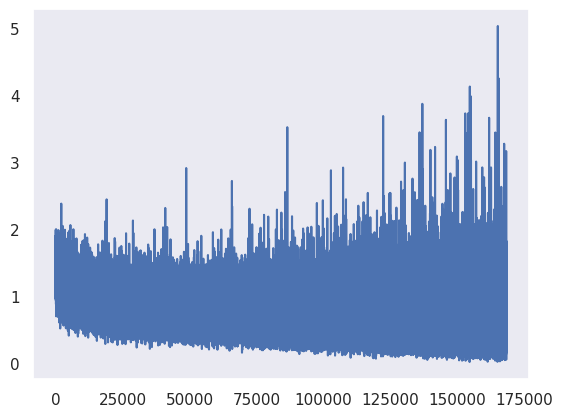

In [52]:
plt.plot(train_losses)

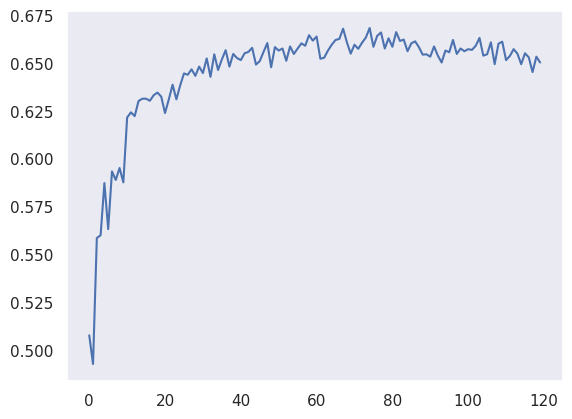

In [53]:
plt.plot(test_accuracy)

In [54]:
best_epoch

75

In [55]:
checkpoint_path = '../models_esd4/esd4_m18_120epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)